In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("FF", "SI") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("FF", "SI")')

# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [7]:
train_data = training_features.drop(['line_drive'], axis=1).copy()
train_label = training_features['line_drive'].copy()
testing_data = testing_features.drop(['line_drive'], axis=1).copy()
testing_label = testing_features['line_drive'].copy()

In [8]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [9]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [10]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [11]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [12]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5040437678401523
Log Loss: 0.6816703453145277


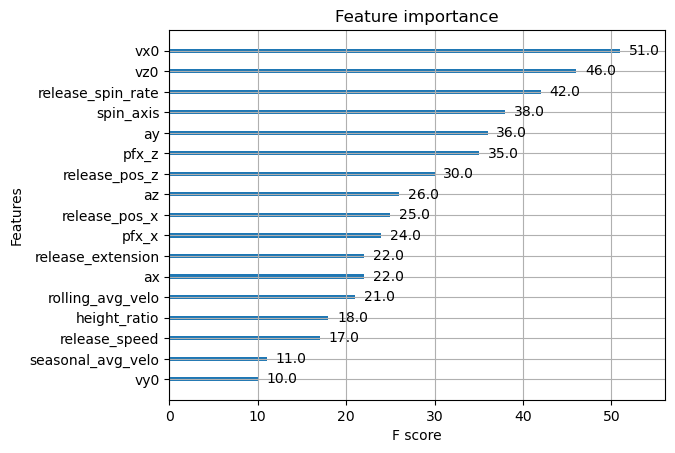

In [13]:
xgb.plot_importance(model)
plt.show()

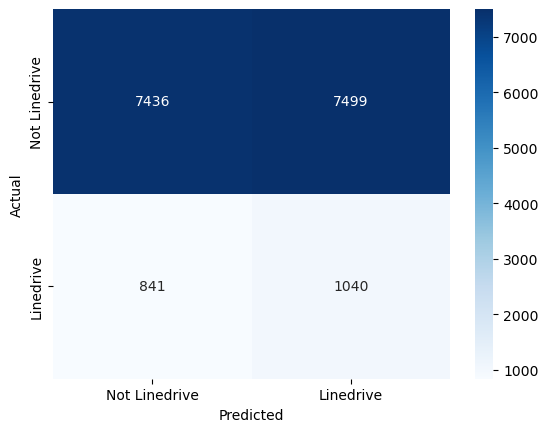

In [14]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [15]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [16]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 17:05:15,611] A new study created in memory with name: no-name-ab735d0e-03aa-4af8-ab04-dabf526b7386


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68262
[6]	eval-logloss:0.68070
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67663
[9]	eval-logloss:0.67494
[10]	eval-logloss:0.67436
[11]	eval-logloss:0.67333
[12]	eval-logloss:0.67222
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66994
[15]	eval-logloss:0.66952
[16]	eval-logloss:0.66869
[17]	eval-logloss:0.66856
[18]	eval-logloss:0.66731
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66499
[21]	eval-logloss:0.66389
[22]	eval-logloss:0.66296
[23]	eval-logloss:0.66217
[24]	eval-logloss:0.66147
[25]	eval-logloss:0.66093
[26]	eval-logloss:0.66026
[27]	eval-logloss:0.65903
[28]	eval-logloss:0.65817
[29]	eval-logloss:0.65765
[30]	eval-logloss:0.65742
[31]	eval-logloss:0.65732
[32]	eval-logloss:0.65731
[33]	eval-logloss:0.65618
[34]	eval-logloss:0.65611
[35]	eval-logloss:0.65522
[36]	eval-logloss:0.65470
[37]	eval-logloss:0.65357
[38]	eval-logloss:0.65

[I 2023-11-14 17:05:20,054] Trial 0 finished with value: 0.6165618969393588 and parameters: {'max_depth': 8, 'eta': 0.054014692970018166, 'subsample': 0.6293334913442359, 'colsample_bytree': 0.9626565291005117}. Best is trial 0 with value: 0.6165618969393588.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68624
[6]	eval-logloss:0.68476
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68182
[9]	eval-logloss:0.68154
[10]	eval-logloss:0.68251
[11]	eval-logloss:0.68234
[12]	eval-logloss:0.68298
[13]	eval-logloss:0.68001
[14]	eval-logloss:0.68032
[15]	eval-logloss:0.67916
[16]	eval-logloss:0.67821
[17]	eval-logloss:0.67706
[18]	eval-logloss:0.67704
[19]	eval-logloss:0.67801
[20]	eval-logloss:0.67639
[21]	eval-logloss:0.67498
[22]	eval-logloss:0.67532
[23]	eval-logloss:0.67465
[24]	eval-logloss:0.67447
[25]	eval-logloss:0.67348
[26]	eval-logloss:0.67327
[27]	eval-logloss:0.67048
[28]	eval-logloss:0.66975
[29]	eval-logloss:0.66815
[30]	eval-logloss:0.66801
[31]	eval-logloss:0.66848
[32]	eval-logloss:0.66731
[33]	eval-logloss:0.66545
[34]	eval-logloss:0.66512
[35]	eval-logloss:0.66517
[36]	eval-logloss:0.66410
[37]	eval-logloss:0.66358
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:22,984] Trial 1 finished with value: 0.6362595449182402 and parameters: {'max_depth': 5, 'eta': 0.2552429640534011, 'subsample': 0.7478667425727337, 'colsample_bytree': 0.5647411070334137}. Best is trial 0 with value: 0.6165618969393588.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68900
[6]	eval-logloss:0.68795
[7]	eval-logloss:0.68766
[8]	eval-logloss:0.68750
[9]	eval-logloss:0.68759
[10]	eval-logloss:0.68747
[11]	eval-logloss:0.68703
[12]	eval-logloss:0.68702
[13]	eval-logloss:0.68543
[14]	eval-logloss:0.68543
[15]	eval-logloss:0.68510
[16]	eval-logloss:0.68508
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68383
[19]	eval-logloss:0.68389
[20]	eval-logloss:0.68330
[21]	eval-logloss:0.68286
[22]	eval-logloss:0.68311
[23]	eval-logloss:0.68307
[24]	eval-logloss:0.68292
[25]	eval-logloss:0.68197
[26]	eval-logloss:0.68188
[27]	eval-logloss:0.68054
[28]	eval-logloss:0.68042
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67973
[31]	eval-logloss:0.68017
[32]	eval-logloss:0.67930
[33]	eval-logloss:0.67800
[34]	eval-logloss:0.67773
[35]	eval-logloss:0.67773
[36]	eval-logloss:0.67717
[37]	eval-logloss:0.67680
[38]	eval-logloss:0.67

[I 2023-11-14 17:05:25,364] Trial 2 finished with value: 0.6617856580525885 and parameters: {'max_depth': 4, 'eta': 0.17654122569865371, 'subsample': 0.8127885193963132, 'colsample_bytree': 0.8630375719596886}. Best is trial 0 with value: 0.6165618969393588.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68982
[7]	eval-logloss:0.68934
[8]	eval-logloss:0.68885
[9]	eval-logloss:0.68846
[10]	eval-logloss:0.68804
[11]	eval-logloss:0.68782
[12]	eval-logloss:0.68751
[13]	eval-logloss:0.68698
[14]	eval-logloss:0.68677
[15]	eval-logloss:0.68630
[16]	eval-logloss:0.68610
[17]	eval-logloss:0.68563
[18]	eval-logloss:0.68530
[19]	eval-logloss:0.68516
[20]	eval-logloss:0.68480
[21]	eval-logloss:0.68455
[22]	eval-logloss:0.68439
[23]	eval-logloss:0.68423
[24]	eval-logloss:0.68392
[25]	eval-logloss:0.68363
[26]	eval-logloss:0.68329
[27]	eval-logloss:0.68287
[28]	eval-logloss:0.68248
[29]	eval-logloss:0.68221
[30]	eval-logloss:0.68193
[31]	eval-logloss:0.68182
[32]	eval-logloss:0.68139
[33]	eval-logloss:0.68102
[34]	eval-logloss:0.68087
[35]	eval-logloss:0.68056
[36]	eval-logloss:0.68030
[37]	eval-logloss:0.67985
[38]	eval-logloss:0.67

[I 2023-11-14 17:05:28,822] Trial 3 finished with value: 0.6682088280945546 and parameters: {'max_depth': 6, 'eta': 0.03364031694380833, 'subsample': 0.8389208548622001, 'colsample_bytree': 0.6659478725560957}. Best is trial 0 with value: 0.6165618969393588.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.68214
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67000
[5]	eval-logloss:0.66508
[6]	eval-logloss:0.66294
[7]	eval-logloss:0.66143
[8]	eval-logloss:0.65910
[9]	eval-logloss:0.65653
[10]	eval-logloss:0.65659
[11]	eval-logloss:0.65246
[12]	eval-logloss:0.65023
[13]	eval-logloss:0.64659
[14]	eval-logloss:0.64643
[15]	eval-logloss:0.64472
[16]	eval-logloss:0.64298
[17]	eval-logloss:0.64182
[18]	eval-logloss:0.63942
[19]	eval-logloss:0.63957
[20]	eval-logloss:0.63814
[21]	eval-logloss:0.63582
[22]	eval-logloss:0.63368
[23]	eval-logloss:0.63007
[24]	eval-logloss:0.62884
[25]	eval-logloss:0.62741
[26]	eval-logloss:0.62667
[27]	eval-logloss:0.62371
[28]	eval-logloss:0.62196
[29]	eval-logloss:0.62069
[30]	eval-logloss:0.61965
[31]	eval-logloss:0.61801
[32]	eval-logloss:0.61635
[33]	eval-logloss:0.61494
[34]	eval-logloss:0.61402
[35]	eval-logloss:0.61206
[36]	eval-logloss:0.61057
[37]	eval-logloss:0.60902
[38]	eval-logloss:0.60

[I 2023-11-14 17:05:32,987] Trial 4 finished with value: 0.5409948815744243 and parameters: {'max_depth': 8, 'eta': 0.2028977601204382, 'subsample': 0.6932694094347185, 'colsample_bytree': 0.7754163457282399}. Best is trial 4 with value: 0.5409948815744243.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68939
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68246
[6]	eval-logloss:0.68122
[7]	eval-logloss:0.68026
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67847
[10]	eval-logloss:0.67787
[11]	eval-logloss:0.67645
[12]	eval-logloss:0.67623
[13]	eval-logloss:0.67442
[14]	eval-logloss:0.67367
[15]	eval-logloss:0.67230
[16]	eval-logloss:0.67221
[17]	eval-logloss:0.67094
[18]	eval-logloss:0.66987
[19]	eval-logloss:0.66893
[20]	eval-logloss:0.66789
[21]	eval-logloss:0.66676
[22]	eval-logloss:0.66623
[23]	eval-logloss:0.66580
[24]	eval-logloss:0.66508
[25]	eval-logloss:0.66431
[26]	eval-logloss:0.66346
[27]	eval-logloss:0.66225
[28]	eval-logloss:0.66035
[29]	eval-logloss:0.65973
[30]	eval-logloss:0.65915
[31]	eval-logloss:0.65846
[32]	eval-logloss:0.65688
[33]	eval-logloss:0.65560
[34]	eval-logloss:0.65465
[35]	eval-logloss:0.65472
[36]	eval-logloss:0.65354
[37]	eval-logloss:0.65187
[38]	eval-logloss:0.64

[I 2023-11-14 17:05:36,353] Trial 5 finished with value: 0.610379846844854 and parameters: {'max_depth': 6, 'eta': 0.19579324327760703, 'subsample': 0.8945142479825954, 'colsample_bytree': 0.5900406544517667}. Best is trial 4 with value: 0.5409948815744243.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68621
[2]	eval-logloss:0.68485
[3]	eval-logloss:0.68244
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67665
[7]	eval-logloss:0.67528
[8]	eval-logloss:0.67405
[9]	eval-logloss:0.67296
[10]	eval-logloss:0.67141
[11]	eval-logloss:0.67027
[12]	eval-logloss:0.66871
[13]	eval-logloss:0.66670
[14]	eval-logloss:0.66570
[15]	eval-logloss:0.66417
[16]	eval-logloss:0.66244
[17]	eval-logloss:0.66102
[18]	eval-logloss:0.66063
[19]	eval-logloss:0.66072
[20]	eval-logloss:0.65939
[21]	eval-logloss:0.65811
[22]	eval-logloss:0.65781
[23]	eval-logloss:0.65520
[24]	eval-logloss:0.65468
[25]	eval-logloss:0.65265
[26]	eval-logloss:0.65151
[27]	eval-logloss:0.64877
[28]	eval-logloss:0.64792
[29]	eval-logloss:0.64730
[30]	eval-logloss:0.64583
[31]	eval-logloss:0.64550
[32]	eval-logloss:0.64350
[33]	eval-logloss:0.64080
[34]	eval-logloss:0.63977
[35]	eval-logloss:0.63893
[36]	eval-logloss:0.63695
[37]	eval-logloss:0.63617
[38]	eval-logloss:0.63

[I 2023-11-14 17:05:40,158] Trial 6 finished with value: 0.5822566685420246 and parameters: {'max_depth': 7, 'eta': 0.18678490208797455, 'subsample': 0.8256095836979176, 'colsample_bytree': 0.7169363511086746}. Best is trial 4 with value: 0.5409948815744243.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68484
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.67999
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67484
[9]	eval-logloss:0.67330
[10]	eval-logloss:0.67284
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67014
[13]	eval-logloss:0.66773
[14]	eval-logloss:0.66750
[15]	eval-logloss:0.66631
[16]	eval-logloss:0.66545
[17]	eval-logloss:0.66442
[18]	eval-logloss:0.66330
[19]	eval-logloss:0.66335
[20]	eval-logloss:0.66216
[21]	eval-logloss:0.66139
[22]	eval-logloss:0.66099
[23]	eval-logloss:0.65935
[24]	eval-logloss:0.65851
[25]	eval-logloss:0.65776
[26]	eval-logloss:0.65634
[27]	eval-logloss:0.65441
[28]	eval-logloss:0.65293
[29]	eval-logloss:0.65242
[30]	eval-logloss:0.65181
[31]	eval-logloss:0.65015
[32]	eval-logloss:0.64938
[33]	eval-logloss:0.64822
[34]	eval-logloss:0.64788
[35]	eval-logloss:0.64630
[36]	eval-logloss:0.64522
[37]	eval-logloss:0.64436
[38]	eval-logloss:0.64

[I 2023-11-14 17:05:44,348] Trial 7 finished with value: 0.6001738609907058 and parameters: {'max_depth': 8, 'eta': 0.08019937447304909, 'subsample': 0.6998470838441792, 'colsample_bytree': 0.5511620920023228}. Best is trial 4 with value: 0.5409948815744243.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69305
[2]	eval-logloss:0.69301
[3]	eval-logloss:0.69301
[4]	eval-logloss:0.69296
[5]	eval-logloss:0.69286
[6]	eval-logloss:0.69275
[7]	eval-logloss:0.69266
[8]	eval-logloss:0.69257
[9]	eval-logloss:0.69251
[10]	eval-logloss:0.69255
[11]	eval-logloss:0.69255
[12]	eval-logloss:0.69249
[13]	eval-logloss:0.69232
[14]	eval-logloss:0.69227
[15]	eval-logloss:0.69227
[16]	eval-logloss:0.69221
[17]	eval-logloss:0.69216
[18]	eval-logloss:0.69211
[19]	eval-logloss:0.69212
[20]	eval-logloss:0.69209
[21]	eval-logloss:0.69204
[22]	eval-logloss:0.69198
[23]	eval-logloss:0.69197
[24]	eval-logloss:0.69193
[25]	eval-logloss:0.69188
[26]	eval-logloss:0.69183
[27]	eval-logloss:0.69175
[28]	eval-logloss:0.69168
[29]	eval-logloss:0.69157
[30]	eval-logloss:0.69157
[31]	eval-logloss:0.69154
[32]	eval-logloss:0.69155
[33]	eval-logloss:0.69145
[34]	eval-logloss:0.69147
[35]	eval-logloss:0.69144
[36]	eval-logloss:0.69133
[37]	eval-logloss:0.69123
[38]	eval-logloss:0.69

[I 2023-11-14 17:05:46,826] Trial 8 finished with value: 0.6891881273144455 and parameters: {'max_depth': 3, 'eta': 0.01184763422137097, 'subsample': 0.6761118850431139, 'colsample_bytree': 0.99330493835629}. Best is trial 4 with value: 0.5409948815744243.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68682
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68179
[5]	eval-logloss:0.68008
[6]	eval-logloss:0.67772
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67467
[9]	eval-logloss:0.67433
[10]	eval-logloss:0.67316
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67144
[13]	eval-logloss:0.66897
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66692
[16]	eval-logloss:0.66655
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66481
[19]	eval-logloss:0.66505
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66248
[22]	eval-logloss:0.66294
[23]	eval-logloss:0.66226
[24]	eval-logloss:0.66154
[25]	eval-logloss:0.65998
[26]	eval-logloss:0.65907
[27]	eval-logloss:0.65729
[28]	eval-logloss:0.65555
[29]	eval-logloss:0.65496
[30]	eval-logloss:0.65480
[31]	eval-logloss:0.65515
[32]	eval-logloss:0.65285
[33]	eval-logloss:0.65072
[34]	eval-logloss:0.65043
[35]	eval-logloss:0.65034
[36]	eval-logloss:0.64874
[37]	eval-logloss:0.64804
[38]	eval-logloss:0.64

[I 2023-11-14 17:05:50,157] Trial 9 finished with value: 0.6023432323319642 and parameters: {'max_depth': 6, 'eta': 0.237826733915108, 'subsample': 0.8333366728600333, 'colsample_bytree': 0.8305704794867181}. Best is trial 4 with value: 0.5409948815744243.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.67416
[3]	eval-logloss:0.67100
[4]	eval-logloss:0.66843
[5]	eval-logloss:0.66110
[6]	eval-logloss:0.65886
[7]	eval-logloss:0.65374
[8]	eval-logloss:0.64816
[9]	eval-logloss:0.64646
[10]	eval-logloss:0.64027
[11]	eval-logloss:0.64043
[12]	eval-logloss:0.63553
[13]	eval-logloss:0.63119
[14]	eval-logloss:0.63192
[15]	eval-logloss:0.63328
[16]	eval-logloss:0.62912
[17]	eval-logloss:0.62883
[18]	eval-logloss:0.62692
[19]	eval-logloss:0.62667
[20]	eval-logloss:0.62442
[21]	eval-logloss:0.61950
[22]	eval-logloss:0.61513
[23]	eval-logloss:0.61173
[24]	eval-logloss:0.61170
[25]	eval-logloss:0.60881
[26]	eval-logloss:0.60612
[27]	eval-logloss:0.60469
[28]	eval-logloss:0.60102
[29]	eval-logloss:0.59614
[30]	eval-logloss:0.59549
[31]	eval-logloss:0.59720
[32]	eval-logloss:0.59372
[33]	eval-logloss:0.58781
[34]	eval-logloss:0.58716
[35]	eval-logloss:0.58687
[36]	eval-logloss:0.58380
[37]	eval-logloss:0.58065
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:55,493] Trial 10 finished with value: 0.5094590449432992 and parameters: {'max_depth': 9, 'eta': 0.282386294567891, 'subsample': 0.6035706250118326, 'colsample_bytree': 0.7818470467073616}. Best is trial 10 with value: 0.5094590449432992.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.67490
[2]	eval-logloss:0.67166
[3]	eval-logloss:0.66755
[4]	eval-logloss:0.66376
[5]	eval-logloss:0.65742
[6]	eval-logloss:0.65545
[7]	eval-logloss:0.65060
[8]	eval-logloss:0.64664
[9]	eval-logloss:0.64058
[10]	eval-logloss:0.63669
[11]	eval-logloss:0.63444
[12]	eval-logloss:0.63036
[13]	eval-logloss:0.62700
[14]	eval-logloss:0.62704
[15]	eval-logloss:0.62725
[16]	eval-logloss:0.62688
[17]	eval-logloss:0.62321
[18]	eval-logloss:0.61949
[19]	eval-logloss:0.62037
[20]	eval-logloss:0.61782
[21]	eval-logloss:0.61654
[22]	eval-logloss:0.61554
[23]	eval-logloss:0.61300
[24]	eval-logloss:0.61143
[25]	eval-logloss:0.60950
[26]	eval-logloss:0.60629
[27]	eval-logloss:0.60366
[28]	eval-logloss:0.60200
[29]	eval-logloss:0.59965
[30]	eval-logloss:0.59875
[31]	eval-logloss:0.59663
[32]	eval-logloss:0.59149
[33]	eval-logloss:0.58870
[34]	eval-logloss:0.58627
[35]	eval-logloss:0.58345
[36]	eval-logloss:0.58147
[37]	eval-logloss:0.57923
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:00,576] Trial 11 finished with value: 0.5136273926837067 and parameters: {'max_depth': 9, 'eta': 0.2761371012151699, 'subsample': 0.6018192256164439, 'colsample_bytree': 0.7835764738581227}. Best is trial 10 with value: 0.5094590449432992.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.67385
[2]	eval-logloss:0.67083
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.66119
[5]	eval-logloss:0.65435
[6]	eval-logloss:0.65222
[7]	eval-logloss:0.64897
[8]	eval-logloss:0.64585
[9]	eval-logloss:0.63999
[10]	eval-logloss:0.64166
[11]	eval-logloss:0.64223
[12]	eval-logloss:0.63897
[13]	eval-logloss:0.63508
[14]	eval-logloss:0.63276
[15]	eval-logloss:0.63282
[16]	eval-logloss:0.62560
[17]	eval-logloss:0.62274
[18]	eval-logloss:0.62185
[19]	eval-logloss:0.61903
[20]	eval-logloss:0.61640
[21]	eval-logloss:0.61477
[22]	eval-logloss:0.61276
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60890
[25]	eval-logloss:0.60568
[26]	eval-logloss:0.60033
[27]	eval-logloss:0.59669
[28]	eval-logloss:0.59302
[29]	eval-logloss:0.59209
[30]	eval-logloss:0.59031
[31]	eval-logloss:0.59151
[32]	eval-logloss:0.58671
[33]	eval-logloss:0.58092
[34]	eval-logloss:0.58028
[35]	eval-logloss:0.57895
[36]	eval-logloss:0.57458
[37]	eval-logloss:0.57269
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:05,361] Trial 12 finished with value: 0.5130357408307682 and parameters: {'max_depth': 9, 'eta': 0.29452317103321574, 'subsample': 0.6016751933093281, 'colsample_bytree': 0.745756830677609}. Best is trial 10 with value: 0.5094590449432992.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.67526
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66591
[4]	eval-logloss:0.66396
[5]	eval-logloss:0.65584
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.64998
[8]	eval-logloss:0.64737
[9]	eval-logloss:0.64506
[10]	eval-logloss:0.64374
[11]	eval-logloss:0.64443
[12]	eval-logloss:0.63958
[13]	eval-logloss:0.63618
[14]	eval-logloss:0.63657
[15]	eval-logloss:0.63486
[16]	eval-logloss:0.63296
[17]	eval-logloss:0.62977
[18]	eval-logloss:0.62657
[19]	eval-logloss:0.62352
[20]	eval-logloss:0.62038
[21]	eval-logloss:0.61842
[22]	eval-logloss:0.61485
[23]	eval-logloss:0.61162
[24]	eval-logloss:0.61003
[25]	eval-logloss:0.60898
[26]	eval-logloss:0.60664
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60169
[29]	eval-logloss:0.59956
[30]	eval-logloss:0.59663
[31]	eval-logloss:0.59446
[32]	eval-logloss:0.59163
[33]	eval-logloss:0.58928
[34]	eval-logloss:0.58677
[35]	eval-logloss:0.58375
[36]	eval-logloss:0.58068
[37]	eval-logloss:0.57948
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:09,571] Trial 13 finished with value: 0.5135491176398088 and parameters: {'max_depth': 9, 'eta': 0.29589570435989465, 'subsample': 0.6003362860245117, 'colsample_bytree': 0.6914326714668525}. Best is trial 10 with value: 0.5094590449432992.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67503
[2]	eval-logloss:0.66964
[3]	eval-logloss:0.66457
[4]	eval-logloss:0.66220
[5]	eval-logloss:0.65201
[6]	eval-logloss:0.65059
[7]	eval-logloss:0.64492
[8]	eval-logloss:0.64355
[9]	eval-logloss:0.64262
[10]	eval-logloss:0.64292
[11]	eval-logloss:0.63932
[12]	eval-logloss:0.63706
[13]	eval-logloss:0.63336
[14]	eval-logloss:0.63430
[15]	eval-logloss:0.63398
[16]	eval-logloss:0.63017
[17]	eval-logloss:0.62659
[18]	eval-logloss:0.62371
[19]	eval-logloss:0.62354
[20]	eval-logloss:0.62031
[21]	eval-logloss:0.61786
[22]	eval-logloss:0.61694
[23]	eval-logloss:0.61536
[24]	eval-logloss:0.61362
[25]	eval-logloss:0.60999
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60164
[28]	eval-logloss:0.59872
[29]	eval-logloss:0.59450
[30]	eval-logloss:0.59357
[31]	eval-logloss:0.59264
[32]	eval-logloss:0.58962
[33]	eval-logloss:0.58626
[34]	eval-logloss:0.58733
[35]	eval-logloss:0.58549
[36]	eval-logloss:0.58297
[37]	eval-logloss:0.58053
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:13,925] Trial 14 finished with value: 0.5067329398202132 and parameters: {'max_depth': 9, 'eta': 0.28460808418456474, 'subsample': 0.6421633688062562, 'colsample_bytree': 0.644203648486284}. Best is trial 14 with value: 0.5067329398202132.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68518
[2]	eval-logloss:0.68335
[3]	eval-logloss:0.68034
[4]	eval-logloss:0.67891
[5]	eval-logloss:0.67584
[6]	eval-logloss:0.67321
[7]	eval-logloss:0.67022
[8]	eval-logloss:0.66775
[9]	eval-logloss:0.66722
[10]	eval-logloss:0.66692
[11]	eval-logloss:0.66768
[12]	eval-logloss:0.66553
[13]	eval-logloss:0.66059
[14]	eval-logloss:0.66191
[15]	eval-logloss:0.66202
[16]	eval-logloss:0.66039
[17]	eval-logloss:0.65938
[18]	eval-logloss:0.65836
[19]	eval-logloss:0.65834
[20]	eval-logloss:0.65567
[21]	eval-logloss:0.65419
[22]	eval-logloss:0.65314
[23]	eval-logloss:0.65074
[24]	eval-logloss:0.64884
[25]	eval-logloss:0.64594
[26]	eval-logloss:0.64451
[27]	eval-logloss:0.64222
[28]	eval-logloss:0.64056
[29]	eval-logloss:0.63956
[30]	eval-logloss:0.63737
[31]	eval-logloss:0.63751
[32]	eval-logloss:0.63780
[33]	eval-logloss:0.63481
[34]	eval-logloss:0.63480
[35]	eval-logloss:0.63230
[36]	eval-logloss:0.62993
[37]	eval-logloss:0.62715
[38]	eval-logloss:0.62

[I 2023-11-14 17:06:17,325] Trial 15 finished with value: 0.5722907278491451 and parameters: {'max_depth': 7, 'eta': 0.2435802855507367, 'subsample': 0.6353163060547461, 'colsample_bytree': 0.6284785178529091}. Best is trial 14 with value: 0.5067329398202132.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68475
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.67983
[6]	eval-logloss:0.67811
[7]	eval-logloss:0.67579
[8]	eval-logloss:0.67471
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67346
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67223
[13]	eval-logloss:0.67000
[14]	eval-logloss:0.66937
[15]	eval-logloss:0.66874
[16]	eval-logloss:0.66813
[17]	eval-logloss:0.66706
[18]	eval-logloss:0.66530
[19]	eval-logloss:0.66534
[20]	eval-logloss:0.66324
[21]	eval-logloss:0.66155
[22]	eval-logloss:0.66065
[23]	eval-logloss:0.66017
[24]	eval-logloss:0.65945
[25]	eval-logloss:0.65819
[26]	eval-logloss:0.65716
[27]	eval-logloss:0.65562
[28]	eval-logloss:0.65451
[29]	eval-logloss:0.65347
[30]	eval-logloss:0.65341
[31]	eval-logloss:0.65312
[32]	eval-logloss:0.65285
[33]	eval-logloss:0.65128
[34]	eval-logloss:0.65045
[35]	eval-logloss:0.64987
[36]	eval-logloss:0.64801
[37]	eval-logloss:0.64672
[38]	eval-logloss:0.64

[I 2023-11-14 17:06:20,561] Trial 16 finished with value: 0.6022599597743077 and parameters: {'max_depth': 7, 'eta': 0.136746949433875, 'subsample': 0.6581335220834613, 'colsample_bytree': 0.5013587774567059}. Best is trial 14 with value: 0.5067329398202132.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.67323
[3]	eval-logloss:0.66938
[4]	eval-logloss:0.66354
[5]	eval-logloss:0.65620
[6]	eval-logloss:0.65429
[7]	eval-logloss:0.65182
[8]	eval-logloss:0.64935
[9]	eval-logloss:0.64659
[10]	eval-logloss:0.64322
[11]	eval-logloss:0.63942
[12]	eval-logloss:0.63684
[13]	eval-logloss:0.62996
[14]	eval-logloss:0.62899
[15]	eval-logloss:0.62758
[16]	eval-logloss:0.62225
[17]	eval-logloss:0.62053
[18]	eval-logloss:0.61764
[19]	eval-logloss:0.61810
[20]	eval-logloss:0.61404
[21]	eval-logloss:0.61130
[22]	eval-logloss:0.61057
[23]	eval-logloss:0.60845
[24]	eval-logloss:0.60743
[25]	eval-logloss:0.60150
[26]	eval-logloss:0.59839
[27]	eval-logloss:0.59538
[28]	eval-logloss:0.59304
[29]	eval-logloss:0.59219
[30]	eval-logloss:0.58875
[31]	eval-logloss:0.58751
[32]	eval-logloss:0.58393
[33]	eval-logloss:0.58180
[34]	eval-logloss:0.58155
[35]	eval-logloss:0.57575
[36]	eval-logloss:0.57258
[37]	eval-logloss:0.57050
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:24,822] Trial 17 finished with value: 0.49513923398297804 and parameters: {'max_depth': 9, 'eta': 0.2629965342086412, 'subsample': 0.7184968321386395, 'colsample_bytree': 0.6492135860222288}. Best is trial 17 with value: 0.49513923398297804.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68239
[2]	eval-logloss:0.67956
[3]	eval-logloss:0.67654
[4]	eval-logloss:0.67267
[5]	eval-logloss:0.66805
[6]	eval-logloss:0.66538
[7]	eval-logloss:0.66224
[8]	eval-logloss:0.65897
[9]	eval-logloss:0.65677
[10]	eval-logloss:0.65550
[11]	eval-logloss:0.65361
[12]	eval-logloss:0.65195
[13]	eval-logloss:0.64853
[14]	eval-logloss:0.64828
[15]	eval-logloss:0.64695
[16]	eval-logloss:0.64246
[17]	eval-logloss:0.64082
[18]	eval-logloss:0.63861
[19]	eval-logloss:0.63933
[20]	eval-logloss:0.63527
[21]	eval-logloss:0.63357
[22]	eval-logloss:0.63214
[23]	eval-logloss:0.62938
[24]	eval-logloss:0.62848
[25]	eval-logloss:0.62548
[26]	eval-logloss:0.62362
[27]	eval-logloss:0.61979
[28]	eval-logloss:0.61648
[29]	eval-logloss:0.61545
[30]	eval-logloss:0.61319
[31]	eval-logloss:0.61155
[32]	eval-logloss:0.61047
[33]	eval-logloss:0.60795
[34]	eval-logloss:0.60803
[35]	eval-logloss:0.60622
[36]	eval-logloss:0.60374
[37]	eval-logloss:0.60206
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:28,543] Trial 18 finished with value: 0.5347045967469181 and parameters: {'max_depth': 8, 'eta': 0.2267598825323076, 'subsample': 0.7223749237495606, 'colsample_bytree': 0.6273122742865138}. Best is trial 17 with value: 0.49513923398297804.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67582
[2]	eval-logloss:0.67369
[3]	eval-logloss:0.66779
[4]	eval-logloss:0.66310
[5]	eval-logloss:0.65617
[6]	eval-logloss:0.65445
[7]	eval-logloss:0.65228
[8]	eval-logloss:0.64847
[9]	eval-logloss:0.64515
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64014
[12]	eval-logloss:0.63862
[13]	eval-logloss:0.63537
[14]	eval-logloss:0.63515
[15]	eval-logloss:0.63289
[16]	eval-logloss:0.62845
[17]	eval-logloss:0.62705
[18]	eval-logloss:0.62369
[19]	eval-logloss:0.62347
[20]	eval-logloss:0.61841
[21]	eval-logloss:0.61647
[22]	eval-logloss:0.61330
[23]	eval-logloss:0.61002
[24]	eval-logloss:0.60930
[25]	eval-logloss:0.60678
[26]	eval-logloss:0.60509
[27]	eval-logloss:0.60144
[28]	eval-logloss:0.59856
[29]	eval-logloss:0.59585
[30]	eval-logloss:0.59345
[31]	eval-logloss:0.59156
[32]	eval-logloss:0.58809
[33]	eval-logloss:0.58557
[34]	eval-logloss:0.58516
[35]	eval-logloss:0.58086
[36]	eval-logloss:0.57748
[37]	eval-logloss:0.57547
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:32,815] Trial 19 finished with value: 0.4944484387670063 and parameters: {'max_depth': 9, 'eta': 0.2626927768853987, 'subsample': 0.7254882273342517, 'colsample_bytree': 0.6588794927782885}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68676
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68404
[7]	eval-logloss:0.68230
[8]	eval-logloss:0.68256
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68290
[11]	eval-logloss:0.68221
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.68057
[15]	eval-logloss:0.67991
[16]	eval-logloss:0.67869
[17]	eval-logloss:0.67824
[18]	eval-logloss:0.67833
[19]	eval-logloss:0.67927
[20]	eval-logloss:0.67763
[21]	eval-logloss:0.67698
[22]	eval-logloss:0.67678
[23]	eval-logloss:0.67643
[24]	eval-logloss:0.67636
[25]	eval-logloss:0.67545
[26]	eval-logloss:0.67512
[27]	eval-logloss:0.67277
[28]	eval-logloss:0.67189
[29]	eval-logloss:0.67126
[30]	eval-logloss:0.67078
[31]	eval-logloss:0.67101
[32]	eval-logloss:0.67027
[33]	eval-logloss:0.66870
[34]	eval-logloss:0.66869
[35]	eval-logloss:0.66856
[36]	eval-logloss:0.66730
[37]	eval-logloss:0.66702
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:35,452] Trial 20 finished with value: 0.6408679811570419 and parameters: {'max_depth': 5, 'eta': 0.21979168665599103, 'subsample': 0.7557146970755362, 'colsample_bytree': 0.679490466151884}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67490
[2]	eval-logloss:0.67195
[3]	eval-logloss:0.66901
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.65956
[6]	eval-logloss:0.65737
[7]	eval-logloss:0.65548
[8]	eval-logloss:0.65146
[9]	eval-logloss:0.64806
[10]	eval-logloss:0.64798
[11]	eval-logloss:0.64347
[12]	eval-logloss:0.64160
[13]	eval-logloss:0.63549
[14]	eval-logloss:0.63388
[15]	eval-logloss:0.63095
[16]	eval-logloss:0.62646
[17]	eval-logloss:0.62464
[18]	eval-logloss:0.62156
[19]	eval-logloss:0.62146
[20]	eval-logloss:0.61903
[21]	eval-logloss:0.61568
[22]	eval-logloss:0.61382
[23]	eval-logloss:0.61093
[24]	eval-logloss:0.60968
[25]	eval-logloss:0.60557
[26]	eval-logloss:0.60315
[27]	eval-logloss:0.59835
[28]	eval-logloss:0.59830
[29]	eval-logloss:0.59513
[30]	eval-logloss:0.59053
[31]	eval-logloss:0.58822
[32]	eval-logloss:0.58595
[33]	eval-logloss:0.58311
[34]	eval-logloss:0.58080
[35]	eval-logloss:0.57901
[36]	eval-logloss:0.57541
[37]	eval-logloss:0.57442
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:39,708] Trial 21 finished with value: 0.49629632770689025 and parameters: {'max_depth': 9, 'eta': 0.26042913339585677, 'subsample': 0.7238365579836658, 'colsample_bytree': 0.6493918370610093}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68751
[1]	eval-logloss:0.68170
[2]	eval-logloss:0.67957
[3]	eval-logloss:0.67602
[4]	eval-logloss:0.67039
[5]	eval-logloss:0.66788
[6]	eval-logloss:0.66612
[7]	eval-logloss:0.66282
[8]	eval-logloss:0.66029
[9]	eval-logloss:0.65944
[10]	eval-logloss:0.65947
[11]	eval-logloss:0.65633
[12]	eval-logloss:0.65508
[13]	eval-logloss:0.64944
[14]	eval-logloss:0.64831
[15]	eval-logloss:0.64532
[16]	eval-logloss:0.64065
[17]	eval-logloss:0.63994
[18]	eval-logloss:0.63956
[19]	eval-logloss:0.64012
[20]	eval-logloss:0.63631
[21]	eval-logloss:0.63433
[22]	eval-logloss:0.63167
[23]	eval-logloss:0.62922
[24]	eval-logloss:0.62841
[25]	eval-logloss:0.62599
[26]	eval-logloss:0.62542
[27]	eval-logloss:0.62139
[28]	eval-logloss:0.61775
[29]	eval-logloss:0.61616
[30]	eval-logloss:0.61477
[31]	eval-logloss:0.61306
[32]	eval-logloss:0.61070
[33]	eval-logloss:0.60768
[34]	eval-logloss:0.60744
[35]	eval-logloss:0.60514
[36]	eval-logloss:0.60300
[37]	eval-logloss:0.60135
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:43,444] Trial 22 finished with value: 0.5261196579441911 and parameters: {'max_depth': 8, 'eta': 0.25672785951508253, 'subsample': 0.7323588271953585, 'colsample_bytree': 0.6169400438076738}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67178
[4]	eval-logloss:0.66562
[5]	eval-logloss:0.66284
[6]	eval-logloss:0.66102
[7]	eval-logloss:0.65507
[8]	eval-logloss:0.65078
[9]	eval-logloss:0.64686
[10]	eval-logloss:0.64417
[11]	eval-logloss:0.64032
[12]	eval-logloss:0.63741
[13]	eval-logloss:0.63194
[14]	eval-logloss:0.63169
[15]	eval-logloss:0.62940
[16]	eval-logloss:0.62515
[17]	eval-logloss:0.62024
[18]	eval-logloss:0.61875
[19]	eval-logloss:0.61848
[20]	eval-logloss:0.61559
[21]	eval-logloss:0.61308
[22]	eval-logloss:0.60994
[23]	eval-logloss:0.60661
[24]	eval-logloss:0.60540
[25]	eval-logloss:0.60124
[26]	eval-logloss:0.60050
[27]	eval-logloss:0.59631
[28]	eval-logloss:0.59264
[29]	eval-logloss:0.58957
[30]	eval-logloss:0.58645
[31]	eval-logloss:0.58388
[32]	eval-logloss:0.58209
[33]	eval-logloss:0.58080
[34]	eval-logloss:0.58087
[35]	eval-logloss:0.57806
[36]	eval-logloss:0.57424
[37]	eval-logloss:0.57304
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:47,876] Trial 23 finished with value: 0.4957380155672349 and parameters: {'max_depth': 9, 'eta': 0.2623497086814533, 'subsample': 0.7657178260070165, 'colsample_bytree': 0.6983804540611959}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68468
[3]	eval-logloss:0.68279
[4]	eval-logloss:0.67981
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67583
[7]	eval-logloss:0.67267
[8]	eval-logloss:0.67211
[9]	eval-logloss:0.67173
[10]	eval-logloss:0.67118
[11]	eval-logloss:0.66946
[12]	eval-logloss:0.66759
[13]	eval-logloss:0.66531
[14]	eval-logloss:0.66464
[15]	eval-logloss:0.66264
[16]	eval-logloss:0.66048
[17]	eval-logloss:0.65889
[18]	eval-logloss:0.65770
[19]	eval-logloss:0.65785
[20]	eval-logloss:0.65634
[21]	eval-logloss:0.65430
[22]	eval-logloss:0.65238
[23]	eval-logloss:0.65032
[24]	eval-logloss:0.64822
[25]	eval-logloss:0.64667
[26]	eval-logloss:0.64639
[27]	eval-logloss:0.64381
[28]	eval-logloss:0.64069
[29]	eval-logloss:0.64016
[30]	eval-logloss:0.64005
[31]	eval-logloss:0.63894
[32]	eval-logloss:0.63681
[33]	eval-logloss:0.63472
[34]	eval-logloss:0.63345
[35]	eval-logloss:0.63154
[36]	eval-logloss:0.62947
[37]	eval-logloss:0.62874
[38]	eval-logloss:0.62

[I 2023-11-14 17:06:51,117] Trial 24 finished with value: 0.5719768022944205 and parameters: {'max_depth': 7, 'eta': 0.22267403199336908, 'subsample': 0.7729597508038858, 'colsample_bytree': 0.713298963908617}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68612
[1]	eval-logloss:0.68138
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67373
[4]	eval-logloss:0.66954
[5]	eval-logloss:0.66694
[6]	eval-logloss:0.66423
[7]	eval-logloss:0.66018
[8]	eval-logloss:0.65663
[9]	eval-logloss:0.65465
[10]	eval-logloss:0.65323
[11]	eval-logloss:0.65051
[12]	eval-logloss:0.64877
[13]	eval-logloss:0.64473
[14]	eval-logloss:0.64449
[15]	eval-logloss:0.64193
[16]	eval-logloss:0.63838
[17]	eval-logloss:0.63629
[18]	eval-logloss:0.63499
[19]	eval-logloss:0.63485
[20]	eval-logloss:0.63437
[21]	eval-logloss:0.63233
[22]	eval-logloss:0.63002
[23]	eval-logloss:0.62913
[24]	eval-logloss:0.62638
[25]	eval-logloss:0.62242
[26]	eval-logloss:0.62136
[27]	eval-logloss:0.61810
[28]	eval-logloss:0.61545
[29]	eval-logloss:0.61485
[30]	eval-logloss:0.61381
[31]	eval-logloss:0.61176
[32]	eval-logloss:0.60933
[33]	eval-logloss:0.60631
[34]	eval-logloss:0.60567
[35]	eval-logloss:0.60302
[36]	eval-logloss:0.60099
[37]	eval-logloss:0.59904
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:54,793] Trial 25 finished with value: 0.5259048194123571 and parameters: {'max_depth': 8, 'eta': 0.2596980578411932, 'subsample': 0.772203722386862, 'colsample_bytree': 0.7090248713605305}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67680
[2]	eval-logloss:0.67334
[3]	eval-logloss:0.66597
[4]	eval-logloss:0.65924
[5]	eval-logloss:0.65332
[6]	eval-logloss:0.65052
[7]	eval-logloss:0.64833
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64193
[10]	eval-logloss:0.64014
[11]	eval-logloss:0.63711
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.62712
[14]	eval-logloss:0.62528
[15]	eval-logloss:0.62114
[16]	eval-logloss:0.61708
[17]	eval-logloss:0.61732
[18]	eval-logloss:0.61601
[19]	eval-logloss:0.61605
[20]	eval-logloss:0.61044
[21]	eval-logloss:0.60719
[22]	eval-logloss:0.60380
[23]	eval-logloss:0.59989
[24]	eval-logloss:0.59824
[25]	eval-logloss:0.59632
[26]	eval-logloss:0.59374
[27]	eval-logloss:0.58996
[28]	eval-logloss:0.58797
[29]	eval-logloss:0.58750
[30]	eval-logloss:0.58541
[31]	eval-logloss:0.58512
[32]	eval-logloss:0.58279
[33]	eval-logloss:0.58060
[34]	eval-logloss:0.58055
[35]	eval-logloss:0.57671
[36]	eval-logloss:0.57356
[37]	eval-logloss:0.57092
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:58,908] Trial 26 finished with value: 0.5015758441461934 and parameters: {'max_depth': 9, 'eta': 0.29926778809527127, 'subsample': 0.7018885700925613, 'colsample_bytree': 0.6629261037865877}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.67958
[2]	eval-logloss:0.67839
[3]	eval-logloss:0.67498
[4]	eval-logloss:0.67233
[5]	eval-logloss:0.66791
[6]	eval-logloss:0.66560
[7]	eval-logloss:0.66311
[8]	eval-logloss:0.66082
[9]	eval-logloss:0.66018
[10]	eval-logloss:0.66008
[11]	eval-logloss:0.65848
[12]	eval-logloss:0.65457
[13]	eval-logloss:0.64892
[14]	eval-logloss:0.64847
[15]	eval-logloss:0.64946
[16]	eval-logloss:0.64561
[17]	eval-logloss:0.64525
[18]	eval-logloss:0.64354
[19]	eval-logloss:0.64290
[20]	eval-logloss:0.63933
[21]	eval-logloss:0.63609
[22]	eval-logloss:0.63386
[23]	eval-logloss:0.63237
[24]	eval-logloss:0.62997
[25]	eval-logloss:0.62725
[26]	eval-logloss:0.62544
[27]	eval-logloss:0.62347
[28]	eval-logloss:0.62056
[29]	eval-logloss:0.61849
[30]	eval-logloss:0.61822
[31]	eval-logloss:0.61500
[32]	eval-logloss:0.61319
[33]	eval-logloss:0.61087
[34]	eval-logloss:0.61054
[35]	eval-logloss:0.60805
[36]	eval-logloss:0.60501
[37]	eval-logloss:0.60344
[38]	eval-logloss:0.60

[I 2023-11-14 17:07:02,535] Trial 27 finished with value: 0.5344431612416265 and parameters: {'max_depth': 8, 'eta': 0.266904664462794, 'subsample': 0.6795910345679983, 'colsample_bytree': 0.6068112977310053}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67667
[2]	eval-logloss:0.67314
[3]	eval-logloss:0.66941
[4]	eval-logloss:0.66497
[5]	eval-logloss:0.65914
[6]	eval-logloss:0.65658
[7]	eval-logloss:0.65200
[8]	eval-logloss:0.65074
[9]	eval-logloss:0.64889
[10]	eval-logloss:0.64754
[11]	eval-logloss:0.64215
[12]	eval-logloss:0.63684
[13]	eval-logloss:0.63284
[14]	eval-logloss:0.63274
[15]	eval-logloss:0.62958
[16]	eval-logloss:0.62615
[17]	eval-logloss:0.62577
[18]	eval-logloss:0.62300
[19]	eval-logloss:0.62183
[20]	eval-logloss:0.61975
[21]	eval-logloss:0.61493
[22]	eval-logloss:0.61353
[23]	eval-logloss:0.61055
[24]	eval-logloss:0.60918
[25]	eval-logloss:0.60629
[26]	eval-logloss:0.60404
[27]	eval-logloss:0.60112
[28]	eval-logloss:0.59587
[29]	eval-logloss:0.59349
[30]	eval-logloss:0.59189
[31]	eval-logloss:0.58898
[32]	eval-logloss:0.58725
[33]	eval-logloss:0.58516
[34]	eval-logloss:0.58502
[35]	eval-logloss:0.58065
[36]	eval-logloss:0.57618
[37]	eval-logloss:0.57413
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:06,759] Trial 28 finished with value: 0.49616396384527084 and parameters: {'max_depth': 9, 'eta': 0.23811179183750059, 'subsample': 0.7188751009848533, 'colsample_bytree': 0.6823873915254597}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.68050
[3]	eval-logloss:0.67689
[4]	eval-logloss:0.67164
[5]	eval-logloss:0.66817
[6]	eval-logloss:0.66659
[7]	eval-logloss:0.66304
[8]	eval-logloss:0.66060
[9]	eval-logloss:0.65941
[10]	eval-logloss:0.65861
[11]	eval-logloss:0.65635
[12]	eval-logloss:0.65367
[13]	eval-logloss:0.65073
[14]	eval-logloss:0.65076
[15]	eval-logloss:0.64831
[16]	eval-logloss:0.64475
[17]	eval-logloss:0.64407
[18]	eval-logloss:0.64241
[19]	eval-logloss:0.64257
[20]	eval-logloss:0.63947
[21]	eval-logloss:0.63779
[22]	eval-logloss:0.63676
[23]	eval-logloss:0.63522
[24]	eval-logloss:0.63338
[25]	eval-logloss:0.63249
[26]	eval-logloss:0.63036
[27]	eval-logloss:0.62779
[28]	eval-logloss:0.62460
[29]	eval-logloss:0.62349
[30]	eval-logloss:0.62276
[31]	eval-logloss:0.62162
[32]	eval-logloss:0.61971
[33]	eval-logloss:0.61743
[34]	eval-logloss:0.61671
[35]	eval-logloss:0.61460
[36]	eval-logloss:0.61231
[37]	eval-logloss:0.61218
[38]	eval-logloss:0.60

[I 2023-11-14 17:07:10,338] Trial 29 finished with value: 0.5430775673345429 and parameters: {'max_depth': 8, 'eta': 0.21106436279638788, 'subsample': 0.7467290507069104, 'colsample_bytree': 0.5735919961199809}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68708
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68187
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67523
[7]	eval-logloss:0.67292
[8]	eval-logloss:0.67065
[9]	eval-logloss:0.67011
[10]	eval-logloss:0.66887
[11]	eval-logloss:0.66647
[12]	eval-logloss:0.66484
[13]	eval-logloss:0.66231
[14]	eval-logloss:0.66053
[15]	eval-logloss:0.65895
[16]	eval-logloss:0.65758
[17]	eval-logloss:0.65609
[18]	eval-logloss:0.65474
[19]	eval-logloss:0.65503
[20]	eval-logloss:0.65234
[21]	eval-logloss:0.65071
[22]	eval-logloss:0.64991
[23]	eval-logloss:0.64950
[24]	eval-logloss:0.64814
[25]	eval-logloss:0.64613
[26]	eval-logloss:0.64330
[27]	eval-logloss:0.63900
[28]	eval-logloss:0.63744
[29]	eval-logloss:0.63576
[30]	eval-logloss:0.63609
[31]	eval-logloss:0.63466
[32]	eval-logloss:0.63247
[33]	eval-logloss:0.62970
[34]	eval-logloss:0.62843
[35]	eval-logloss:0.62740
[36]	eval-logloss:0.62615
[37]	eval-logloss:0.62562
[38]	eval-logloss:0.62

[I 2023-11-14 17:07:13,636] Trial 30 finished with value: 0.5638262312983313 and parameters: {'max_depth': 7, 'eta': 0.24274050436631697, 'subsample': 0.7903609849683892, 'colsample_bytree': 0.7478528167417947}. Best is trial 19 with value: 0.4944484387670063.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.67209
[3]	eval-logloss:0.66942
[4]	eval-logloss:0.66167
[5]	eval-logloss:0.65576
[6]	eval-logloss:0.65267
[7]	eval-logloss:0.64792
[8]	eval-logloss:0.64269
[9]	eval-logloss:0.64114
[10]	eval-logloss:0.64007
[11]	eval-logloss:0.63687
[12]	eval-logloss:0.63442
[13]	eval-logloss:0.63192
[14]	eval-logloss:0.63143
[15]	eval-logloss:0.62876
[16]	eval-logloss:0.62131
[17]	eval-logloss:0.61903
[18]	eval-logloss:0.61916
[19]	eval-logloss:0.61919
[20]	eval-logloss:0.61312
[21]	eval-logloss:0.61034
[22]	eval-logloss:0.60653
[23]	eval-logloss:0.60303
[24]	eval-logloss:0.59966
[25]	eval-logloss:0.59762
[26]	eval-logloss:0.59673
[27]	eval-logloss:0.59201
[28]	eval-logloss:0.58967
[29]	eval-logloss:0.58780
[30]	eval-logloss:0.58298
[31]	eval-logloss:0.58000
[32]	eval-logloss:0.57953
[33]	eval-logloss:0.57433
[34]	eval-logloss:0.57448
[35]	eval-logloss:0.57118
[36]	eval-logloss:0.56820
[37]	eval-logloss:0.56553
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:17,846] Trial 31 finished with value: 0.48993567004826494 and parameters: {'max_depth': 9, 'eta': 0.27613763352817994, 'subsample': 0.7182658251111089, 'colsample_bytree': 0.6872609902977116}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67661
[2]	eval-logloss:0.67264
[3]	eval-logloss:0.66756
[4]	eval-logloss:0.66038
[5]	eval-logloss:0.65600
[6]	eval-logloss:0.65297
[7]	eval-logloss:0.64633
[8]	eval-logloss:0.64246
[9]	eval-logloss:0.63876
[10]	eval-logloss:0.63886
[11]	eval-logloss:0.63488
[12]	eval-logloss:0.63165
[13]	eval-logloss:0.62893
[14]	eval-logloss:0.62739
[15]	eval-logloss:0.62586
[16]	eval-logloss:0.61834
[17]	eval-logloss:0.61615
[18]	eval-logloss:0.61382
[19]	eval-logloss:0.61308
[20]	eval-logloss:0.60983
[21]	eval-logloss:0.60653
[22]	eval-logloss:0.60505
[23]	eval-logloss:0.60235
[24]	eval-logloss:0.60142
[25]	eval-logloss:0.59870
[26]	eval-logloss:0.59727
[27]	eval-logloss:0.59475
[28]	eval-logloss:0.59195
[29]	eval-logloss:0.59077
[30]	eval-logloss:0.58856
[31]	eval-logloss:0.58722
[32]	eval-logloss:0.58369
[33]	eval-logloss:0.57988
[34]	eval-logloss:0.57868
[35]	eval-logloss:0.57538
[36]	eval-logloss:0.57230
[37]	eval-logloss:0.57178
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:22,106] Trial 32 finished with value: 0.49480875898310445 and parameters: {'max_depth': 9, 'eta': 0.2712330428779756, 'subsample': 0.7363292421839871, 'colsample_bytree': 0.6511407293866143}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.68202
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67610
[4]	eval-logloss:0.67302
[5]	eval-logloss:0.66703
[6]	eval-logloss:0.66523
[7]	eval-logloss:0.66119
[8]	eval-logloss:0.65811
[9]	eval-logloss:0.65597
[10]	eval-logloss:0.65655
[11]	eval-logloss:0.65583
[12]	eval-logloss:0.65129
[13]	eval-logloss:0.64587
[14]	eval-logloss:0.64585
[15]	eval-logloss:0.64426
[16]	eval-logloss:0.64175
[17]	eval-logloss:0.64063
[18]	eval-logloss:0.63862
[19]	eval-logloss:0.63858
[20]	eval-logloss:0.63574
[21]	eval-logloss:0.63314
[22]	eval-logloss:0.63163
[23]	eval-logloss:0.62964
[24]	eval-logloss:0.62817
[25]	eval-logloss:0.62336
[26]	eval-logloss:0.62252
[27]	eval-logloss:0.61885
[28]	eval-logloss:0.61625
[29]	eval-logloss:0.61628
[30]	eval-logloss:0.61412
[31]	eval-logloss:0.61260
[32]	eval-logloss:0.61136
[33]	eval-logloss:0.60946
[34]	eval-logloss:0.60805
[35]	eval-logloss:0.60649
[36]	eval-logloss:0.60295
[37]	eval-logloss:0.60041
[38]	eval-logloss:0.59

[I 2023-11-14 17:07:25,835] Trial 33 finished with value: 0.5303240731539473 and parameters: {'max_depth': 8, 'eta': 0.28339691900231995, 'subsample': 0.7121079616838714, 'colsample_bytree': 0.6503533435930482}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67170
[3]	eval-logloss:0.66511
[4]	eval-logloss:0.66101
[5]	eval-logloss:0.65524
[6]	eval-logloss:0.65322
[7]	eval-logloss:0.64823
[8]	eval-logloss:0.64246
[9]	eval-logloss:0.64263
[10]	eval-logloss:0.64250
[11]	eval-logloss:0.63807
[12]	eval-logloss:0.63263
[13]	eval-logloss:0.62782
[14]	eval-logloss:0.62434
[15]	eval-logloss:0.62102
[16]	eval-logloss:0.61747
[17]	eval-logloss:0.61632
[18]	eval-logloss:0.61498
[19]	eval-logloss:0.61417
[20]	eval-logloss:0.60918
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60656
[23]	eval-logloss:0.60400
[24]	eval-logloss:0.60274
[25]	eval-logloss:0.59960
[26]	eval-logloss:0.59543
[27]	eval-logloss:0.59125
[28]	eval-logloss:0.58872
[29]	eval-logloss:0.58610
[30]	eval-logloss:0.58416
[31]	eval-logloss:0.58236
[32]	eval-logloss:0.57914
[33]	eval-logloss:0.57563
[34]	eval-logloss:0.57345
[35]	eval-logloss:0.57057
[36]	eval-logloss:0.56868
[37]	eval-logloss:0.56725
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:30,032] Trial 34 finished with value: 0.49713522503230173 and parameters: {'max_depth': 9, 'eta': 0.26763863371181473, 'subsample': 0.7393583757131166, 'colsample_bytree': 0.6043942820076343}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68830
[4]	eval-logloss:0.68598
[5]	eval-logloss:0.68454
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68154
[8]	eval-logloss:0.68171
[9]	eval-logloss:0.68210
[10]	eval-logloss:0.68242
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.68176
[13]	eval-logloss:0.67878
[14]	eval-logloss:0.67878
[15]	eval-logloss:0.67798
[16]	eval-logloss:0.67669
[17]	eval-logloss:0.67547
[18]	eval-logloss:0.67571
[19]	eval-logloss:0.67654
[20]	eval-logloss:0.67415
[21]	eval-logloss:0.67308
[22]	eval-logloss:0.67347
[23]	eval-logloss:0.67288
[24]	eval-logloss:0.67323
[25]	eval-logloss:0.67254
[26]	eval-logloss:0.67261
[27]	eval-logloss:0.66986
[28]	eval-logloss:0.66852
[29]	eval-logloss:0.66706
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66591
[32]	eval-logloss:0.66517
[33]	eval-logloss:0.66299
[34]	eval-logloss:0.66273
[35]	eval-logloss:0.66194
[36]	eval-logloss:0.66103
[37]	eval-logloss:0.66062
[38]	eval-logloss:0.65

[I 2023-11-14 17:07:32,673] Trial 35 finished with value: 0.6315418685522416 and parameters: {'max_depth': 5, 'eta': 0.2755680284720896, 'subsample': 0.7428964274446163, 'colsample_bytree': 0.6549307757349976}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68773
[6]	eval-logloss:0.68610
[7]	eval-logloss:0.68537
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68603
[12]	eval-logloss:0.68585
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68377
[15]	eval-logloss:0.68350
[16]	eval-logloss:0.68279
[17]	eval-logloss:0.68211
[18]	eval-logloss:0.68189
[19]	eval-logloss:0.68314
[20]	eval-logloss:0.68217
[21]	eval-logloss:0.68146
[22]	eval-logloss:0.68126
[23]	eval-logloss:0.68155
[24]	eval-logloss:0.68088
[25]	eval-logloss:0.68127
[26]	eval-logloss:0.68137
[27]	eval-logloss:0.67924
[28]	eval-logloss:0.67848
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67770
[31]	eval-logloss:0.67818
[32]	eval-logloss:0.67837
[33]	eval-logloss:0.67684
[34]	eval-logloss:0.67700
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67536
[37]	eval-logloss:0.67446
[38]	eval-logloss:0.67

[I 2023-11-14 17:07:34,981] Trial 36 finished with value: 0.6572949128589293 and parameters: {'max_depth': 4, 'eta': 0.242179381356408, 'subsample': 0.709941208474097, 'colsample_bytree': 0.678722933057284}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.68382
[2]	eval-logloss:0.68115
[3]	eval-logloss:0.67827
[4]	eval-logloss:0.67524
[5]	eval-logloss:0.67105
[6]	eval-logloss:0.66892
[7]	eval-logloss:0.66599
[8]	eval-logloss:0.66491
[9]	eval-logloss:0.66235
[10]	eval-logloss:0.66257
[11]	eval-logloss:0.66146
[12]	eval-logloss:0.65932
[13]	eval-logloss:0.65617
[14]	eval-logloss:0.65525
[15]	eval-logloss:0.65393
[16]	eval-logloss:0.65151
[17]	eval-logloss:0.65101
[18]	eval-logloss:0.64992
[19]	eval-logloss:0.65004
[20]	eval-logloss:0.64576
[21]	eval-logloss:0.64467
[22]	eval-logloss:0.64283
[23]	eval-logloss:0.64030
[24]	eval-logloss:0.63932
[25]	eval-logloss:0.63815
[26]	eval-logloss:0.63682
[27]	eval-logloss:0.63459
[28]	eval-logloss:0.63184
[29]	eval-logloss:0.63080
[30]	eval-logloss:0.62968
[31]	eval-logloss:0.62684
[32]	eval-logloss:0.62569
[33]	eval-logloss:0.62285
[34]	eval-logloss:0.62258
[35]	eval-logloss:0.62076
[36]	eval-logloss:0.61792
[37]	eval-logloss:0.61755
[38]	eval-logloss:0.61

[I 2023-11-14 17:07:38,758] Trial 37 finished with value: 0.5518310059069489 and parameters: {'max_depth': 8, 'eta': 0.1738307194578315, 'subsample': 0.6872893102618859, 'colsample_bytree': 0.7311123533108626}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.67832
[2]	eval-logloss:0.67412
[3]	eval-logloss:0.67074
[4]	eval-logloss:0.66642
[5]	eval-logloss:0.66251
[6]	eval-logloss:0.66077
[7]	eval-logloss:0.65732
[8]	eval-logloss:0.65488
[9]	eval-logloss:0.65137
[10]	eval-logloss:0.65081
[11]	eval-logloss:0.64648
[12]	eval-logloss:0.64456
[13]	eval-logloss:0.64069
[14]	eval-logloss:0.63865
[15]	eval-logloss:0.63723
[16]	eval-logloss:0.63348
[17]	eval-logloss:0.63076
[18]	eval-logloss:0.62740
[19]	eval-logloss:0.62639
[20]	eval-logloss:0.62147
[21]	eval-logloss:0.62047
[22]	eval-logloss:0.61820
[23]	eval-logloss:0.61475
[24]	eval-logloss:0.61333
[25]	eval-logloss:0.61064
[26]	eval-logloss:0.60954
[27]	eval-logloss:0.60479
[28]	eval-logloss:0.60310
[29]	eval-logloss:0.60205
[30]	eval-logloss:0.59892
[31]	eval-logloss:0.59628
[32]	eval-logloss:0.59356
[33]	eval-logloss:0.59192
[34]	eval-logloss:0.59088
[35]	eval-logloss:0.58841
[36]	eval-logloss:0.58561
[37]	eval-logloss:0.58379
[38]	eval-logloss:0.58

[I 2023-11-14 17:07:42,849] Trial 38 finished with value: 0.5041387579782524 and parameters: {'max_depth': 9, 'eta': 0.20476364933424226, 'subsample': 0.7309392794464994, 'colsample_bytree': 0.5847538650610036}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.68072
[3]	eval-logloss:0.67818
[4]	eval-logloss:0.67168
[5]	eval-logloss:0.66625
[6]	eval-logloss:0.66437
[7]	eval-logloss:0.66069
[8]	eval-logloss:0.65935
[9]	eval-logloss:0.65707
[10]	eval-logloss:0.65679
[11]	eval-logloss:0.65456
[12]	eval-logloss:0.65097
[13]	eval-logloss:0.64711
[14]	eval-logloss:0.64703
[15]	eval-logloss:0.64629
[16]	eval-logloss:0.64300
[17]	eval-logloss:0.64293
[18]	eval-logloss:0.64146
[19]	eval-logloss:0.64211
[20]	eval-logloss:0.63898
[21]	eval-logloss:0.63684
[22]	eval-logloss:0.63458
[23]	eval-logloss:0.63243
[24]	eval-logloss:0.62934
[25]	eval-logloss:0.62786
[26]	eval-logloss:0.62704
[27]	eval-logloss:0.62358
[28]	eval-logloss:0.62264
[29]	eval-logloss:0.62001
[30]	eval-logloss:0.61870
[31]	eval-logloss:0.61780
[32]	eval-logloss:0.61622
[33]	eval-logloss:0.61440
[34]	eval-logloss:0.61353
[35]	eval-logloss:0.61094
[36]	eval-logloss:0.60887
[37]	eval-logloss:0.60755
[38]	eval-logloss:0.60

[I 2023-11-14 17:07:46,544] Trial 39 finished with value: 0.5329615323707265 and parameters: {'max_depth': 8, 'eta': 0.25033784582332425, 'subsample': 0.6969678188156635, 'colsample_bytree': 0.5560157628563941}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.67919
[2]	eval-logloss:0.67567
[3]	eval-logloss:0.66965
[4]	eval-logloss:0.66556
[5]	eval-logloss:0.66028
[6]	eval-logloss:0.65854
[7]	eval-logloss:0.65417
[8]	eval-logloss:0.65142
[9]	eval-logloss:0.64954
[10]	eval-logloss:0.64964
[11]	eval-logloss:0.64897
[12]	eval-logloss:0.64701
[13]	eval-logloss:0.64280
[14]	eval-logloss:0.64233
[15]	eval-logloss:0.64031
[16]	eval-logloss:0.63615
[17]	eval-logloss:0.63422
[18]	eval-logloss:0.63306
[19]	eval-logloss:0.63166
[20]	eval-logloss:0.62854
[21]	eval-logloss:0.62480
[22]	eval-logloss:0.62149
[23]	eval-logloss:0.61683
[24]	eval-logloss:0.61422
[25]	eval-logloss:0.61205
[26]	eval-logloss:0.61092
[27]	eval-logloss:0.60827
[28]	eval-logloss:0.60634
[29]	eval-logloss:0.60478
[30]	eval-logloss:0.60149
[31]	eval-logloss:0.59994
[32]	eval-logloss:0.59602
[33]	eval-logloss:0.59444
[34]	eval-logloss:0.59484
[35]	eval-logloss:0.59172
[36]	eval-logloss:0.58869
[37]	eval-logloss:0.58814
[38]	eval-logloss:0.58

[I 2023-11-14 17:07:50,754] Trial 40 finished with value: 0.5095369668983957 and parameters: {'max_depth': 9, 'eta': 0.2266669610857446, 'subsample': 0.6697801876326486, 'colsample_bytree': 0.7232966919821835}. Best is trial 31 with value: 0.48993567004826494.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67762
[2]	eval-logloss:0.67299
[3]	eval-logloss:0.66803
[4]	eval-logloss:0.66165
[5]	eval-logloss:0.65561
[6]	eval-logloss:0.65216
[7]	eval-logloss:0.64689
[8]	eval-logloss:0.64381
[9]	eval-logloss:0.64040
[10]	eval-logloss:0.63958
[11]	eval-logloss:0.63616
[12]	eval-logloss:0.63469
[13]	eval-logloss:0.63090
[14]	eval-logloss:0.62999
[15]	eval-logloss:0.62762
[16]	eval-logloss:0.62169
[17]	eval-logloss:0.61990
[18]	eval-logloss:0.61768
[19]	eval-logloss:0.61636
[20]	eval-logloss:0.61240
[21]	eval-logloss:0.61050
[22]	eval-logloss:0.60829
[23]	eval-logloss:0.60637
[24]	eval-logloss:0.60476
[25]	eval-logloss:0.59986
[26]	eval-logloss:0.59802
[27]	eval-logloss:0.59382
[28]	eval-logloss:0.58987
[29]	eval-logloss:0.58720
[30]	eval-logloss:0.58343
[31]	eval-logloss:0.58264
[32]	eval-logloss:0.57820
[33]	eval-logloss:0.57465
[34]	eval-logloss:0.57233
[35]	eval-logloss:0.56905
[36]	eval-logloss:0.56419
[37]	eval-logloss:0.56422
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:55,217] Trial 41 finished with value: 0.48885434989682713 and parameters: {'max_depth': 9, 'eta': 0.2671304966114403, 'subsample': 0.7554623053073638, 'colsample_bytree': 0.7068768553531901}. Best is trial 41 with value: 0.48885434989682713.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.67348
[3]	eval-logloss:0.67054
[4]	eval-logloss:0.66291
[5]	eval-logloss:0.65942
[6]	eval-logloss:0.65470
[7]	eval-logloss:0.64710
[8]	eval-logloss:0.64563
[9]	eval-logloss:0.64304
[10]	eval-logloss:0.64346
[11]	eval-logloss:0.63815
[12]	eval-logloss:0.63793
[13]	eval-logloss:0.63428
[14]	eval-logloss:0.63318
[15]	eval-logloss:0.62728
[16]	eval-logloss:0.62327
[17]	eval-logloss:0.61956
[18]	eval-logloss:0.61806
[19]	eval-logloss:0.61783
[20]	eval-logloss:0.61475
[21]	eval-logloss:0.61142
[22]	eval-logloss:0.60890
[23]	eval-logloss:0.60513
[24]	eval-logloss:0.60343
[25]	eval-logloss:0.59959
[26]	eval-logloss:0.59574
[27]	eval-logloss:0.59044
[28]	eval-logloss:0.58887
[29]	eval-logloss:0.58875
[30]	eval-logloss:0.58800
[31]	eval-logloss:0.58562
[32]	eval-logloss:0.58285
[33]	eval-logloss:0.57931
[34]	eval-logloss:0.57767
[35]	eval-logloss:0.57659
[36]	eval-logloss:0.57307
[37]	eval-logloss:0.56997
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:59,529] Trial 42 finished with value: 0.4911875221551392 and parameters: {'max_depth': 9, 'eta': 0.2793906427968734, 'subsample': 0.7490449016227221, 'colsample_bytree': 0.6727895903760004}. Best is trial 41 with value: 0.48885434989682713.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.68120
[2]	eval-logloss:0.67819
[3]	eval-logloss:0.67463
[4]	eval-logloss:0.66908
[5]	eval-logloss:0.66645
[6]	eval-logloss:0.66517
[7]	eval-logloss:0.66065
[8]	eval-logloss:0.65928
[9]	eval-logloss:0.65742
[10]	eval-logloss:0.65551
[11]	eval-logloss:0.65280
[12]	eval-logloss:0.65146
[13]	eval-logloss:0.64718
[14]	eval-logloss:0.64768
[15]	eval-logloss:0.64427
[16]	eval-logloss:0.63915
[17]	eval-logloss:0.63682
[18]	eval-logloss:0.63473
[19]	eval-logloss:0.63504
[20]	eval-logloss:0.63191
[21]	eval-logloss:0.62858
[22]	eval-logloss:0.62663
[23]	eval-logloss:0.62581
[24]	eval-logloss:0.62467
[25]	eval-logloss:0.62246
[26]	eval-logloss:0.62226
[27]	eval-logloss:0.61713
[28]	eval-logloss:0.61472
[29]	eval-logloss:0.61304
[30]	eval-logloss:0.61135
[31]	eval-logloss:0.61091
[32]	eval-logloss:0.60824
[33]	eval-logloss:0.60631
[34]	eval-logloss:0.60574
[35]	eval-logloss:0.60263
[36]	eval-logloss:0.60029
[37]	eval-logloss:0.59832
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:03,318] Trial 43 finished with value: 0.5248598765936934 and parameters: {'max_depth': 8, 'eta': 0.2850421333101058, 'subsample': 0.7521693685602449, 'colsample_bytree': 0.6953137117550646}. Best is trial 41 with value: 0.48885434989682713.


[0]	eval-logloss:0.68319
[1]	eval-logloss:0.67697
[2]	eval-logloss:0.67336
[3]	eval-logloss:0.66807
[4]	eval-logloss:0.66173
[5]	eval-logloss:0.66006
[6]	eval-logloss:0.65810
[7]	eval-logloss:0.65322
[8]	eval-logloss:0.64728
[9]	eval-logloss:0.64458
[10]	eval-logloss:0.64199
[11]	eval-logloss:0.63932
[12]	eval-logloss:0.63503
[13]	eval-logloss:0.63160
[14]	eval-logloss:0.62964
[15]	eval-logloss:0.62721
[16]	eval-logloss:0.62453
[17]	eval-logloss:0.62187
[18]	eval-logloss:0.62048
[19]	eval-logloss:0.61909
[20]	eval-logloss:0.61491
[21]	eval-logloss:0.61163
[22]	eval-logloss:0.60932
[23]	eval-logloss:0.60536
[24]	eval-logloss:0.60283
[25]	eval-logloss:0.59959
[26]	eval-logloss:0.59634
[27]	eval-logloss:0.59398
[28]	eval-logloss:0.58897
[29]	eval-logloss:0.58733
[30]	eval-logloss:0.58517
[31]	eval-logloss:0.58369
[32]	eval-logloss:0.58068
[33]	eval-logloss:0.57675
[34]	eval-logloss:0.57700
[35]	eval-logloss:0.57373
[36]	eval-logloss:0.57228
[37]	eval-logloss:0.57137
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:07,600] Trial 44 finished with value: 0.48634196336761876 and parameters: {'max_depth': 9, 'eta': 0.2704751041214596, 'subsample': 0.7937781836670559, 'colsample_bytree': 0.6728250217127048}. Best is trial 44 with value: 0.48634196336761876.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68722
[3]	eval-logloss:0.68441
[4]	eval-logloss:0.68180
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67884
[8]	eval-logloss:0.67613
[9]	eval-logloss:0.67509
[10]	eval-logloss:0.67443
[11]	eval-logloss:0.67334
[12]	eval-logloss:0.67330
[13]	eval-logloss:0.67030
[14]	eval-logloss:0.66999
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66801
[17]	eval-logloss:0.66660
[18]	eval-logloss:0.66572
[19]	eval-logloss:0.66666
[20]	eval-logloss:0.66362
[21]	eval-logloss:0.66261
[22]	eval-logloss:0.66182
[23]	eval-logloss:0.66121
[24]	eval-logloss:0.65999
[25]	eval-logloss:0.65852
[26]	eval-logloss:0.65760
[27]	eval-logloss:0.65440
[28]	eval-logloss:0.65202
[29]	eval-logloss:0.65075
[30]	eval-logloss:0.65059
[31]	eval-logloss:0.65106
[32]	eval-logloss:0.64926
[33]	eval-logloss:0.64694
[34]	eval-logloss:0.64690
[35]	eval-logloss:0.64642
[36]	eval-logloss:0.64541
[37]	eval-logloss:0.64462
[38]	eval-logloss:0.64

[I 2023-11-14 17:08:10,678] Trial 45 finished with value: 0.5902380316529799 and parameters: {'max_depth': 6, 'eta': 0.2991437957789436, 'subsample': 0.8033235022208636, 'colsample_bytree': 0.7723035176716011}. Best is trial 44 with value: 0.48634196336761876.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67271
[3]	eval-logloss:0.66671
[4]	eval-logloss:0.65940
[5]	eval-logloss:0.65634
[6]	eval-logloss:0.65421
[7]	eval-logloss:0.64937
[8]	eval-logloss:0.64647
[9]	eval-logloss:0.64455
[10]	eval-logloss:0.63992
[11]	eval-logloss:0.63341
[12]	eval-logloss:0.63253
[13]	eval-logloss:0.62674
[14]	eval-logloss:0.62624
[15]	eval-logloss:0.62496
[16]	eval-logloss:0.62042
[17]	eval-logloss:0.61639
[18]	eval-logloss:0.61586
[19]	eval-logloss:0.61591
[20]	eval-logloss:0.61301
[21]	eval-logloss:0.60984
[22]	eval-logloss:0.60738
[23]	eval-logloss:0.60518
[24]	eval-logloss:0.60361
[25]	eval-logloss:0.60080
[26]	eval-logloss:0.59770
[27]	eval-logloss:0.59353
[28]	eval-logloss:0.59105
[29]	eval-logloss:0.59055
[30]	eval-logloss:0.58650
[31]	eval-logloss:0.58572
[32]	eval-logloss:0.58228
[33]	eval-logloss:0.57900
[34]	eval-logloss:0.57731
[35]	eval-logloss:0.57514
[36]	eval-logloss:0.57236
[37]	eval-logloss:0.57195
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:15,044] Trial 46 finished with value: 0.49253066173154936 and parameters: {'max_depth': 9, 'eta': 0.28100072701305817, 'subsample': 0.7863986226950958, 'colsample_bytree': 0.7307392609123047}. Best is trial 44 with value: 0.48634196336761876.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69049
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68895
[8]	eval-logloss:0.68891
[9]	eval-logloss:0.68905
[10]	eval-logloss:0.68959
[11]	eval-logloss:0.68901
[12]	eval-logloss:0.68940
[13]	eval-logloss:0.68778
[14]	eval-logloss:0.68776
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68728
[17]	eval-logloss:0.68609
[18]	eval-logloss:0.68681
[19]	eval-logloss:0.68829
[20]	eval-logloss:0.68709
[21]	eval-logloss:0.68603
[22]	eval-logloss:0.68659
[23]	eval-logloss:0.68671
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68621
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68436
[28]	eval-logloss:0.68399
[29]	eval-logloss:0.68327
[30]	eval-logloss:0.68332
[31]	eval-logloss:0.68399
[32]	eval-logloss:0.68360
[33]	eval-logloss:0.68168
[34]	eval-logloss:0.68171
[35]	eval-logloss:0.68199
[36]	eval-logloss:0.68149
[37]	eval-logloss:0.68145
[38]	eval-logloss:0.68

[I 2023-11-14 17:08:17,217] Trial 47 finished with value: 0.6729319630199948 and parameters: {'max_depth': 3, 'eta': 0.2817085421709641, 'subsample': 0.7850098296308865, 'colsample_bytree': 0.7305684469973671}. Best is trial 44 with value: 0.48634196336761876.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.68048
[2]	eval-logloss:0.67790
[3]	eval-logloss:0.67245
[4]	eval-logloss:0.66710
[5]	eval-logloss:0.66636
[6]	eval-logloss:0.66347
[7]	eval-logloss:0.66035
[8]	eval-logloss:0.65604
[9]	eval-logloss:0.65522
[10]	eval-logloss:0.65115
[11]	eval-logloss:0.64868
[12]	eval-logloss:0.64613
[13]	eval-logloss:0.64145
[14]	eval-logloss:0.63995
[15]	eval-logloss:0.63777
[16]	eval-logloss:0.63593
[17]	eval-logloss:0.63295
[18]	eval-logloss:0.63096
[19]	eval-logloss:0.63089
[20]	eval-logloss:0.62926
[21]	eval-logloss:0.62707
[22]	eval-logloss:0.62570
[23]	eval-logloss:0.62270
[24]	eval-logloss:0.62183
[25]	eval-logloss:0.61996
[26]	eval-logloss:0.61744
[27]	eval-logloss:0.61525
[28]	eval-logloss:0.61246
[29]	eval-logloss:0.60964
[30]	eval-logloss:0.60855
[31]	eval-logloss:0.60686
[32]	eval-logloss:0.60387
[33]	eval-logloss:0.60064
[34]	eval-logloss:0.59944
[35]	eval-logloss:0.59896
[36]	eval-logloss:0.59631
[37]	eval-logloss:0.59456
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:21,456] Trial 48 finished with value: 0.5159777008969906 and parameters: {'max_depth': 8, 'eta': 0.24811969303192827, 'subsample': 0.8130855044238016, 'colsample_bytree': 0.7654043509257875}. Best is trial 44 with value: 0.48634196336761876.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66922
[4]	eval-logloss:0.66189
[5]	eval-logloss:0.65687
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.64961
[8]	eval-logloss:0.64446
[9]	eval-logloss:0.63942
[10]	eval-logloss:0.63945
[11]	eval-logloss:0.63352
[12]	eval-logloss:0.63160
[13]	eval-logloss:0.62635
[14]	eval-logloss:0.62539
[15]	eval-logloss:0.62228
[16]	eval-logloss:0.61861
[17]	eval-logloss:0.61709
[18]	eval-logloss:0.61369
[19]	eval-logloss:0.61335
[20]	eval-logloss:0.61010
[21]	eval-logloss:0.60742
[22]	eval-logloss:0.60247
[23]	eval-logloss:0.59993
[24]	eval-logloss:0.59875
[25]	eval-logloss:0.59428
[26]	eval-logloss:0.59359
[27]	eval-logloss:0.58843
[28]	eval-logloss:0.58422
[29]	eval-logloss:0.58127
[30]	eval-logloss:0.57863
[31]	eval-logloss:0.57617
[32]	eval-logloss:0.57212
[33]	eval-logloss:0.56930
[34]	eval-logloss:0.56832
[35]	eval-logloss:0.56567
[36]	eval-logloss:0.56297
[37]	eval-logloss:0.56110
[38]	eval-logloss:0.55

[I 2023-11-14 17:08:26,376] Trial 49 finished with value: 0.49295250818732694 and parameters: {'max_depth': 9, 'eta': 0.29160123204688976, 'subsample': 0.7594745458014036, 'colsample_bytree': 0.7981814852224673}. Best is trial 44 with value: 0.48634196336761876.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69172
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68691
[8]	eval-logloss:0.68676
[9]	eval-logloss:0.68679
[10]	eval-logloss:0.68700
[11]	eval-logloss:0.68622
[12]	eval-logloss:0.68679
[13]	eval-logloss:0.68468
[14]	eval-logloss:0.68462
[15]	eval-logloss:0.68377
[16]	eval-logloss:0.68307
[17]	eval-logloss:0.68223
[18]	eval-logloss:0.68286
[19]	eval-logloss:0.68445
[20]	eval-logloss:0.68288
[21]	eval-logloss:0.68156
[22]	eval-logloss:0.68157
[23]	eval-logloss:0.68199
[24]	eval-logloss:0.68183
[25]	eval-logloss:0.68121
[26]	eval-logloss:0.68119
[27]	eval-logloss:0.67913
[28]	eval-logloss:0.67798
[29]	eval-logloss:0.67723
[30]	eval-logloss:0.67743
[31]	eval-logloss:0.67765
[32]	eval-logloss:0.67683
[33]	eval-logloss:0.67432
[34]	eval-logloss:0.67457
[35]	eval-logloss:0.67459
[36]	eval-logloss:0.67383
[37]	eval-logloss:0.67365
[38]	eval-logloss:0.67

[I 2023-11-14 17:08:29,043] Trial 50 finished with value: 0.655823885179984 and parameters: {'max_depth': 4, 'eta': 0.2758788010873976, 'subsample': 0.7821003965420879, 'colsample_bytree': 0.7074326832430895}. Best is trial 44 with value: 0.48634196336761876.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67766
[2]	eval-logloss:0.66957
[3]	eval-logloss:0.66373
[4]	eval-logloss:0.65786
[5]	eval-logloss:0.65128
[6]	eval-logloss:0.64720
[7]	eval-logloss:0.64313
[8]	eval-logloss:0.63856
[9]	eval-logloss:0.63422
[10]	eval-logloss:0.63437
[11]	eval-logloss:0.63226
[12]	eval-logloss:0.63057
[13]	eval-logloss:0.62622
[14]	eval-logloss:0.62443
[15]	eval-logloss:0.62152
[16]	eval-logloss:0.62002
[17]	eval-logloss:0.61800
[18]	eval-logloss:0.61436
[19]	eval-logloss:0.61355
[20]	eval-logloss:0.61118
[21]	eval-logloss:0.61100
[22]	eval-logloss:0.60809
[23]	eval-logloss:0.60353
[24]	eval-logloss:0.59850
[25]	eval-logloss:0.59546
[26]	eval-logloss:0.59480
[27]	eval-logloss:0.59183
[28]	eval-logloss:0.58864
[29]	eval-logloss:0.58557
[30]	eval-logloss:0.58451
[31]	eval-logloss:0.58061
[32]	eval-logloss:0.57608
[33]	eval-logloss:0.57163
[34]	eval-logloss:0.56975
[35]	eval-logloss:0.56915
[36]	eval-logloss:0.56611
[37]	eval-logloss:0.56385
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:34,334] Trial 51 finished with value: 0.4843560827459266 and parameters: {'max_depth': 9, 'eta': 0.2899502226955463, 'subsample': 0.7633530859427545, 'colsample_bytree': 0.796296789402946}. Best is trial 51 with value: 0.4843560827459266.


[0]	eval-logloss:0.68370
[1]	eval-logloss:0.67605
[2]	eval-logloss:0.67151
[3]	eval-logloss:0.66339
[4]	eval-logloss:0.65799
[5]	eval-logloss:0.65430
[6]	eval-logloss:0.64992
[7]	eval-logloss:0.64401
[8]	eval-logloss:0.64011
[9]	eval-logloss:0.63588
[10]	eval-logloss:0.63435
[11]	eval-logloss:0.63122
[12]	eval-logloss:0.62649
[13]	eval-logloss:0.62093
[14]	eval-logloss:0.61954
[15]	eval-logloss:0.61740
[16]	eval-logloss:0.61176
[17]	eval-logloss:0.60954
[18]	eval-logloss:0.60777
[19]	eval-logloss:0.60696
[20]	eval-logloss:0.60137
[21]	eval-logloss:0.59726
[22]	eval-logloss:0.59605
[23]	eval-logloss:0.59532
[24]	eval-logloss:0.59462
[25]	eval-logloss:0.59198
[26]	eval-logloss:0.59124
[27]	eval-logloss:0.58737
[28]	eval-logloss:0.58464
[29]	eval-logloss:0.58214
[30]	eval-logloss:0.57777
[31]	eval-logloss:0.57697
[32]	eval-logloss:0.57288
[33]	eval-logloss:0.57010
[34]	eval-logloss:0.56891
[35]	eval-logloss:0.56689
[36]	eval-logloss:0.56333
[37]	eval-logloss:0.56180
[38]	eval-logloss:0.55

[I 2023-11-14 17:08:39,304] Trial 52 finished with value: 0.4857640002219571 and parameters: {'max_depth': 9, 'eta': 0.2890154342627057, 'subsample': 0.7601784802855108, 'colsample_bytree': 0.7368160239486566}. Best is trial 51 with value: 0.4843560827459266.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67860
[2]	eval-logloss:0.66998
[3]	eval-logloss:0.66652
[4]	eval-logloss:0.66129
[5]	eval-logloss:0.65411
[6]	eval-logloss:0.65048
[7]	eval-logloss:0.64486
[8]	eval-logloss:0.63939
[9]	eval-logloss:0.63503
[10]	eval-logloss:0.63222
[11]	eval-logloss:0.63031
[12]	eval-logloss:0.62948
[13]	eval-logloss:0.62411
[14]	eval-logloss:0.62420
[15]	eval-logloss:0.61970
[16]	eval-logloss:0.61407
[17]	eval-logloss:0.61243
[18]	eval-logloss:0.61029
[19]	eval-logloss:0.61008
[20]	eval-logloss:0.60652
[21]	eval-logloss:0.60356
[22]	eval-logloss:0.60014
[23]	eval-logloss:0.59873
[24]	eval-logloss:0.59760
[25]	eval-logloss:0.59348
[26]	eval-logloss:0.59101
[27]	eval-logloss:0.58431
[28]	eval-logloss:0.58138
[29]	eval-logloss:0.57951
[30]	eval-logloss:0.57648
[31]	eval-logloss:0.57476
[32]	eval-logloss:0.57143
[33]	eval-logloss:0.56725
[34]	eval-logloss:0.56684
[35]	eval-logloss:0.56413
[36]	eval-logloss:0.56033
[37]	eval-logloss:0.56015
[38]	eval-logloss:0.55

[I 2023-11-14 17:08:44,073] Trial 53 finished with value: 0.48807345954964726 and parameters: {'max_depth': 9, 'eta': 0.2991625875882622, 'subsample': 0.7600728175232435, 'colsample_bytree': 0.8028784571017714}. Best is trial 51 with value: 0.4843560827459266.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.67151
[3]	eval-logloss:0.66498
[4]	eval-logloss:0.66052
[5]	eval-logloss:0.65772
[6]	eval-logloss:0.65254
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.64037
[9]	eval-logloss:0.63778
[10]	eval-logloss:0.63483
[11]	eval-logloss:0.63211
[12]	eval-logloss:0.62956
[13]	eval-logloss:0.62709
[14]	eval-logloss:0.62436
[15]	eval-logloss:0.62058
[16]	eval-logloss:0.61626
[17]	eval-logloss:0.61468
[18]	eval-logloss:0.61115
[19]	eval-logloss:0.61030
[20]	eval-logloss:0.60625
[21]	eval-logloss:0.60408
[22]	eval-logloss:0.60176
[23]	eval-logloss:0.60206
[24]	eval-logloss:0.59946
[25]	eval-logloss:0.59680
[26]	eval-logloss:0.59394
[27]	eval-logloss:0.59051
[28]	eval-logloss:0.58710
[29]	eval-logloss:0.58499
[30]	eval-logloss:0.58295
[31]	eval-logloss:0.58049
[32]	eval-logloss:0.57732
[33]	eval-logloss:0.57447
[34]	eval-logloss:0.57184
[35]	eval-logloss:0.56912
[36]	eval-logloss:0.56463
[37]	eval-logloss:0.56277
[38]	eval-logloss:0.55

[I 2023-11-14 17:08:48,953] Trial 54 finished with value: 0.4934632450400098 and parameters: {'max_depth': 9, 'eta': 0.2904332213757909, 'subsample': 0.762950676489529, 'colsample_bytree': 0.8085001056070996}. Best is trial 51 with value: 0.4843560827459266.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67777
[2]	eval-logloss:0.66975
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.65949
[5]	eval-logloss:0.65661
[6]	eval-logloss:0.65226
[7]	eval-logloss:0.64985
[8]	eval-logloss:0.64806
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.63982
[11]	eval-logloss:0.63351
[12]	eval-logloss:0.62913
[13]	eval-logloss:0.62467
[14]	eval-logloss:0.62489
[15]	eval-logloss:0.62031
[16]	eval-logloss:0.62017
[17]	eval-logloss:0.61796
[18]	eval-logloss:0.61648
[19]	eval-logloss:0.61384
[20]	eval-logloss:0.60900
[21]	eval-logloss:0.60727
[22]	eval-logloss:0.60507
[23]	eval-logloss:0.60232
[24]	eval-logloss:0.59961
[25]	eval-logloss:0.59589
[26]	eval-logloss:0.59439
[27]	eval-logloss:0.58904
[28]	eval-logloss:0.58718
[29]	eval-logloss:0.58577
[30]	eval-logloss:0.58176
[31]	eval-logloss:0.58026
[32]	eval-logloss:0.57648
[33]	eval-logloss:0.57331
[34]	eval-logloss:0.57245
[35]	eval-logloss:0.56918
[36]	eval-logloss:0.56633
[37]	eval-logloss:0.56383
[38]	eval-logloss:0.55

[I 2023-11-14 17:08:53,610] Trial 55 finished with value: 0.48827062803186466 and parameters: {'max_depth': 9, 'eta': 0.29793899718977734, 'subsample': 0.7673809738721478, 'colsample_bytree': 0.8483519918761266}. Best is trial 51 with value: 0.4843560827459266.


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.68233
[2]	eval-logloss:0.67889
[3]	eval-logloss:0.67621
[4]	eval-logloss:0.67224
[5]	eval-logloss:0.66654
[6]	eval-logloss:0.66410
[7]	eval-logloss:0.66240
[8]	eval-logloss:0.65899
[9]	eval-logloss:0.65752
[10]	eval-logloss:0.65652
[11]	eval-logloss:0.65159
[12]	eval-logloss:0.64907
[13]	eval-logloss:0.64496
[14]	eval-logloss:0.64200
[15]	eval-logloss:0.64063
[16]	eval-logloss:0.63733
[17]	eval-logloss:0.63534
[18]	eval-logloss:0.63336
[19]	eval-logloss:0.63201
[20]	eval-logloss:0.62907
[21]	eval-logloss:0.62516
[22]	eval-logloss:0.62389
[23]	eval-logloss:0.62381
[24]	eval-logloss:0.62217
[25]	eval-logloss:0.61746
[26]	eval-logloss:0.61745
[27]	eval-logloss:0.61223
[28]	eval-logloss:0.61028
[29]	eval-logloss:0.60941
[30]	eval-logloss:0.60769
[31]	eval-logloss:0.60652
[32]	eval-logloss:0.60428
[33]	eval-logloss:0.60152
[34]	eval-logloss:0.60132
[35]	eval-logloss:0.59908
[36]	eval-logloss:0.59610
[37]	eval-logloss:0.59476
[38]	eval-logloss:0.59

[I 2023-11-14 17:08:58,163] Trial 56 finished with value: 0.5186069126786691 and parameters: {'max_depth': 8, 'eta': 0.2945347544224369, 'subsample': 0.7696931578709673, 'colsample_bytree': 0.853892840145661}. Best is trial 51 with value: 0.4843560827459266.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.66945
[3]	eval-logloss:0.66465
[4]	eval-logloss:0.66051
[5]	eval-logloss:0.65622
[6]	eval-logloss:0.64984
[7]	eval-logloss:0.64448
[8]	eval-logloss:0.63892
[9]	eval-logloss:0.63484
[10]	eval-logloss:0.63265
[11]	eval-logloss:0.62967
[12]	eval-logloss:0.62552
[13]	eval-logloss:0.61921
[14]	eval-logloss:0.61517
[15]	eval-logloss:0.61451
[16]	eval-logloss:0.61019
[17]	eval-logloss:0.60693
[18]	eval-logloss:0.60410
[19]	eval-logloss:0.60183
[20]	eval-logloss:0.60080
[21]	eval-logloss:0.59900
[22]	eval-logloss:0.59731
[23]	eval-logloss:0.59440
[24]	eval-logloss:0.59376
[25]	eval-logloss:0.59134
[26]	eval-logloss:0.59073
[27]	eval-logloss:0.58616
[28]	eval-logloss:0.58261
[29]	eval-logloss:0.58004
[30]	eval-logloss:0.57867
[31]	eval-logloss:0.57720
[32]	eval-logloss:0.57384
[33]	eval-logloss:0.56976
[34]	eval-logloss:0.56715
[35]	eval-logloss:0.56598
[36]	eval-logloss:0.56230
[37]	eval-logloss:0.56159
[38]	eval-logloss:0.55

[I 2023-11-14 17:09:03,433] Trial 57 finished with value: 0.48711298442549805 and parameters: {'max_depth': 9, 'eta': 0.29984798378727223, 'subsample': 0.7983822789375744, 'colsample_bytree': 0.8986743706495937}. Best is trial 51 with value: 0.4843560827459266.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67725
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.67006
[5]	eval-logloss:0.66703
[6]	eval-logloss:0.66371
[7]	eval-logloss:0.66141
[8]	eval-logloss:0.65790
[9]	eval-logloss:0.65514
[10]	eval-logloss:0.65368
[11]	eval-logloss:0.64999
[12]	eval-logloss:0.64867
[13]	eval-logloss:0.64370
[14]	eval-logloss:0.64250
[15]	eval-logloss:0.63821
[16]	eval-logloss:0.63505
[17]	eval-logloss:0.63334
[18]	eval-logloss:0.63232
[19]	eval-logloss:0.63233
[20]	eval-logloss:0.62904
[21]	eval-logloss:0.62689
[22]	eval-logloss:0.62444
[23]	eval-logloss:0.62381
[24]	eval-logloss:0.62247
[25]	eval-logloss:0.61964
[26]	eval-logloss:0.61920
[27]	eval-logloss:0.61575
[28]	eval-logloss:0.61295
[29]	eval-logloss:0.60921
[30]	eval-logloss:0.60818
[31]	eval-logloss:0.60831
[32]	eval-logloss:0.60636
[33]	eval-logloss:0.60251
[34]	eval-logloss:0.60196
[35]	eval-logloss:0.59898
[36]	eval-logloss:0.59670
[37]	eval-logloss:0.59524
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:08,200] Trial 58 finished with value: 0.5126890007475585 and parameters: {'max_depth': 8, 'eta': 0.2988067492370453, 'subsample': 0.7980688344076179, 'colsample_bytree': 0.8883451368502004}. Best is trial 51 with value: 0.4843560827459266.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.67430
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66441
[4]	eval-logloss:0.65953
[5]	eval-logloss:0.65358
[6]	eval-logloss:0.64983
[7]	eval-logloss:0.64824
[8]	eval-logloss:0.64399
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.63829
[11]	eval-logloss:0.63151
[12]	eval-logloss:0.62594
[13]	eval-logloss:0.62126
[14]	eval-logloss:0.61922
[15]	eval-logloss:0.61578
[16]	eval-logloss:0.61283
[17]	eval-logloss:0.60895
[18]	eval-logloss:0.60550
[19]	eval-logloss:0.60518
[20]	eval-logloss:0.60282
[21]	eval-logloss:0.60076
[22]	eval-logloss:0.59693
[23]	eval-logloss:0.59430
[24]	eval-logloss:0.59301
[25]	eval-logloss:0.58965
[26]	eval-logloss:0.58911
[27]	eval-logloss:0.58461
[28]	eval-logloss:0.58090
[29]	eval-logloss:0.57748
[30]	eval-logloss:0.57618
[31]	eval-logloss:0.57314
[32]	eval-logloss:0.56872
[33]	eval-logloss:0.56545
[34]	eval-logloss:0.56432
[35]	eval-logloss:0.56275
[36]	eval-logloss:0.56012
[37]	eval-logloss:0.55800
[38]	eval-logloss:0.55

[I 2023-11-14 17:09:13,193] Trial 59 finished with value: 0.48375519978780024 and parameters: {'max_depth': 9, 'eta': 0.2930366635746589, 'subsample': 0.8201450165934335, 'colsample_bytree': 0.9040756468079533}. Best is trial 59 with value: 0.48375519978780024.


[0]	eval-logloss:0.68731
[1]	eval-logloss:0.68460
[2]	eval-logloss:0.68096
[3]	eval-logloss:0.67884
[4]	eval-logloss:0.67629
[5]	eval-logloss:0.67428
[6]	eval-logloss:0.67155
[7]	eval-logloss:0.66957
[8]	eval-logloss:0.66654
[9]	eval-logloss:0.66577
[10]	eval-logloss:0.66444
[11]	eval-logloss:0.66269
[12]	eval-logloss:0.66030
[13]	eval-logloss:0.65682
[14]	eval-logloss:0.65521
[15]	eval-logloss:0.65307
[16]	eval-logloss:0.65326
[17]	eval-logloss:0.65176
[18]	eval-logloss:0.64994
[19]	eval-logloss:0.64933
[20]	eval-logloss:0.64681
[21]	eval-logloss:0.64626
[22]	eval-logloss:0.64516
[23]	eval-logloss:0.64441
[24]	eval-logloss:0.64268
[25]	eval-logloss:0.64157
[26]	eval-logloss:0.64096
[27]	eval-logloss:0.63954
[28]	eval-logloss:0.63841
[29]	eval-logloss:0.63797
[30]	eval-logloss:0.63798
[31]	eval-logloss:0.63713
[32]	eval-logloss:0.63365
[33]	eval-logloss:0.63231
[34]	eval-logloss:0.63108
[35]	eval-logloss:0.63045
[36]	eval-logloss:0.62843
[37]	eval-logloss:0.62749
[38]	eval-logloss:0.62

[I 2023-11-14 17:09:16,919] Trial 60 finished with value: 0.5623228380646327 and parameters: {'max_depth': 7, 'eta': 0.2527241166686522, 'subsample': 0.8430097028583711, 'colsample_bytree': 0.8909062188337481}. Best is trial 59 with value: 0.48375519978780024.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67738
[2]	eval-logloss:0.67068
[3]	eval-logloss:0.66680
[4]	eval-logloss:0.66155
[5]	eval-logloss:0.65704
[6]	eval-logloss:0.65199
[7]	eval-logloss:0.64720
[8]	eval-logloss:0.64509
[9]	eval-logloss:0.64025
[10]	eval-logloss:0.63751
[11]	eval-logloss:0.63435
[12]	eval-logloss:0.63347
[13]	eval-logloss:0.62962
[14]	eval-logloss:0.62829
[15]	eval-logloss:0.62643
[16]	eval-logloss:0.61977
[17]	eval-logloss:0.61433
[18]	eval-logloss:0.61324
[19]	eval-logloss:0.61239
[20]	eval-logloss:0.60649
[21]	eval-logloss:0.60389
[22]	eval-logloss:0.60139
[23]	eval-logloss:0.60012
[24]	eval-logloss:0.59822
[25]	eval-logloss:0.59536
[26]	eval-logloss:0.59473
[27]	eval-logloss:0.59219
[28]	eval-logloss:0.58730
[29]	eval-logloss:0.58554
[30]	eval-logloss:0.58448
[31]	eval-logloss:0.58037
[32]	eval-logloss:0.57710
[33]	eval-logloss:0.57359
[34]	eval-logloss:0.57233
[35]	eval-logloss:0.56910
[36]	eval-logloss:0.56676
[37]	eval-logloss:0.56449
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:21,738] Trial 61 finished with value: 0.48256220010832 and parameters: {'max_depth': 9, 'eta': 0.28916671596331806, 'subsample': 0.7788682963716925, 'colsample_bytree': 0.8369226169487191}. Best is trial 61 with value: 0.48256220010832.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.67151
[3]	eval-logloss:0.66652
[4]	eval-logloss:0.66098
[5]	eval-logloss:0.65852
[6]	eval-logloss:0.65535
[7]	eval-logloss:0.65126
[8]	eval-logloss:0.64841
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.64043
[11]	eval-logloss:0.63454
[12]	eval-logloss:0.63173
[13]	eval-logloss:0.62880
[14]	eval-logloss:0.62725
[15]	eval-logloss:0.62405
[16]	eval-logloss:0.62146
[17]	eval-logloss:0.61521
[18]	eval-logloss:0.61097
[19]	eval-logloss:0.61054
[20]	eval-logloss:0.60734
[21]	eval-logloss:0.60318
[22]	eval-logloss:0.60172
[23]	eval-logloss:0.60070
[24]	eval-logloss:0.59932
[25]	eval-logloss:0.59591
[26]	eval-logloss:0.59558
[27]	eval-logloss:0.58974
[28]	eval-logloss:0.58663
[29]	eval-logloss:0.58559
[30]	eval-logloss:0.58030
[31]	eval-logloss:0.58034
[32]	eval-logloss:0.57710
[33]	eval-logloss:0.57251
[34]	eval-logloss:0.57028
[35]	eval-logloss:0.56912
[36]	eval-logloss:0.56696
[37]	eval-logloss:0.56583
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:26,378] Trial 62 finished with value: 0.48196784002167675 and parameters: {'max_depth': 9, 'eta': 0.28798505444943473, 'subsample': 0.8143368825062762, 'colsample_bytree': 0.8177253404053026}. Best is trial 62 with value: 0.48196784002167675.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67404
[3]	eval-logloss:0.66797
[4]	eval-logloss:0.66225
[5]	eval-logloss:0.65805
[6]	eval-logloss:0.65273
[7]	eval-logloss:0.64831
[8]	eval-logloss:0.64309
[9]	eval-logloss:0.64003
[10]	eval-logloss:0.63541
[11]	eval-logloss:0.63171
[12]	eval-logloss:0.62725
[13]	eval-logloss:0.62189
[14]	eval-logloss:0.62011
[15]	eval-logloss:0.61836
[16]	eval-logloss:0.61689
[17]	eval-logloss:0.61269
[18]	eval-logloss:0.60990
[19]	eval-logloss:0.60962
[20]	eval-logloss:0.60687
[21]	eval-logloss:0.60198
[22]	eval-logloss:0.59965
[23]	eval-logloss:0.59897
[24]	eval-logloss:0.59690
[25]	eval-logloss:0.59407
[26]	eval-logloss:0.59269
[27]	eval-logloss:0.58661
[28]	eval-logloss:0.58398
[29]	eval-logloss:0.58158
[30]	eval-logloss:0.57763
[31]	eval-logloss:0.57719
[32]	eval-logloss:0.57413
[33]	eval-logloss:0.57026
[34]	eval-logloss:0.56893
[35]	eval-logloss:0.56700
[36]	eval-logloss:0.56396
[37]	eval-logloss:0.56059
[38]	eval-logloss:0.55

[I 2023-11-14 17:09:30,895] Trial 63 finished with value: 0.48263222497830777 and parameters: {'max_depth': 9, 'eta': 0.28779803421447386, 'subsample': 0.8188346279158264, 'colsample_bytree': 0.8329941384513682}. Best is trial 62 with value: 0.48196784002167675.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.66407
[4]	eval-logloss:0.65961
[5]	eval-logloss:0.65693
[6]	eval-logloss:0.65436
[7]	eval-logloss:0.65144
[8]	eval-logloss:0.64765
[9]	eval-logloss:0.64611
[10]	eval-logloss:0.64147
[11]	eval-logloss:0.63633
[12]	eval-logloss:0.63528
[13]	eval-logloss:0.62967
[14]	eval-logloss:0.62925
[15]	eval-logloss:0.62507
[16]	eval-logloss:0.62103
[17]	eval-logloss:0.61805
[18]	eval-logloss:0.61593
[19]	eval-logloss:0.61650
[20]	eval-logloss:0.61281
[21]	eval-logloss:0.60918
[22]	eval-logloss:0.60800
[23]	eval-logloss:0.60590
[24]	eval-logloss:0.60326
[25]	eval-logloss:0.60132
[26]	eval-logloss:0.59989
[27]	eval-logloss:0.59549
[28]	eval-logloss:0.59081
[29]	eval-logloss:0.58895
[30]	eval-logloss:0.58441
[31]	eval-logloss:0.58293
[32]	eval-logloss:0.57859
[33]	eval-logloss:0.57330
[34]	eval-logloss:0.57188
[35]	eval-logloss:0.57061
[36]	eval-logloss:0.56842
[37]	eval-logloss:0.56700
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:35,409] Trial 64 finished with value: 0.48319750852682575 and parameters: {'max_depth': 9, 'eta': 0.288126828614284, 'subsample': 0.8250498537031054, 'colsample_bytree': 0.8313434038293149}. Best is trial 62 with value: 0.48196784002167675.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67200
[3]	eval-logloss:0.66711
[4]	eval-logloss:0.66195
[5]	eval-logloss:0.65920
[6]	eval-logloss:0.65314
[7]	eval-logloss:0.65015
[8]	eval-logloss:0.64659
[9]	eval-logloss:0.64372
[10]	eval-logloss:0.64189
[11]	eval-logloss:0.63748
[12]	eval-logloss:0.63652
[13]	eval-logloss:0.63291
[14]	eval-logloss:0.63076
[15]	eval-logloss:0.63027
[16]	eval-logloss:0.62731
[17]	eval-logloss:0.62557
[18]	eval-logloss:0.62123
[19]	eval-logloss:0.61980
[20]	eval-logloss:0.61735
[21]	eval-logloss:0.61513
[22]	eval-logloss:0.61279
[23]	eval-logloss:0.61001
[24]	eval-logloss:0.60707
[25]	eval-logloss:0.60429
[26]	eval-logloss:0.60356
[27]	eval-logloss:0.60091
[28]	eval-logloss:0.59682
[29]	eval-logloss:0.59384
[30]	eval-logloss:0.59246
[31]	eval-logloss:0.59160
[32]	eval-logloss:0.58867
[33]	eval-logloss:0.58421
[34]	eval-logloss:0.58309
[35]	eval-logloss:0.57954
[36]	eval-logloss:0.57565
[37]	eval-logloss:0.57416
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:40,091] Trial 65 finished with value: 0.48792954643255504 and parameters: {'max_depth': 9, 'eta': 0.28597839270234304, 'subsample': 0.8195223730631734, 'colsample_bytree': 0.8231944112425358}. Best is trial 62 with value: 0.48196784002167675.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67564
[3]	eval-logloss:0.67172
[4]	eval-logloss:0.66792
[5]	eval-logloss:0.66571
[6]	eval-logloss:0.66310
[7]	eval-logloss:0.66107
[8]	eval-logloss:0.65744
[9]	eval-logloss:0.65600
[10]	eval-logloss:0.65307
[11]	eval-logloss:0.64852
[12]	eval-logloss:0.64630
[13]	eval-logloss:0.64166
[14]	eval-logloss:0.64043
[15]	eval-logloss:0.63970
[16]	eval-logloss:0.63931
[17]	eval-logloss:0.63713
[18]	eval-logloss:0.63437
[19]	eval-logloss:0.63426
[20]	eval-logloss:0.63122
[21]	eval-logloss:0.62835
[22]	eval-logloss:0.62706
[23]	eval-logloss:0.62495
[24]	eval-logloss:0.62351
[25]	eval-logloss:0.62116
[26]	eval-logloss:0.62016
[27]	eval-logloss:0.61785
[28]	eval-logloss:0.61533
[29]	eval-logloss:0.61404
[30]	eval-logloss:0.61206
[31]	eval-logloss:0.61098
[32]	eval-logloss:0.60804
[33]	eval-logloss:0.60510
[34]	eval-logloss:0.60306
[35]	eval-logloss:0.60138
[36]	eval-logloss:0.59902
[37]	eval-logloss:0.59756
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:44,303] Trial 66 finished with value: 0.5163010579503677 and parameters: {'max_depth': 8, 'eta': 0.2566871252408668, 'subsample': 0.8323994135071895, 'colsample_bytree': 0.8305383468085518}. Best is trial 62 with value: 0.48196784002167675.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67549
[2]	eval-logloss:0.67018
[3]	eval-logloss:0.66562
[4]	eval-logloss:0.66014
[5]	eval-logloss:0.65549
[6]	eval-logloss:0.65260
[7]	eval-logloss:0.64987
[8]	eval-logloss:0.64680
[9]	eval-logloss:0.64462
[10]	eval-logloss:0.64166
[11]	eval-logloss:0.63754
[12]	eval-logloss:0.63630
[13]	eval-logloss:0.63185
[14]	eval-logloss:0.63039
[15]	eval-logloss:0.62585
[16]	eval-logloss:0.62499
[17]	eval-logloss:0.62232
[18]	eval-logloss:0.61928
[19]	eval-logloss:0.61783
[20]	eval-logloss:0.61469
[21]	eval-logloss:0.61113
[22]	eval-logloss:0.60821
[23]	eval-logloss:0.60489
[24]	eval-logloss:0.60284
[25]	eval-logloss:0.59844
[26]	eval-logloss:0.59668
[27]	eval-logloss:0.59213
[28]	eval-logloss:0.58848
[29]	eval-logloss:0.58730
[30]	eval-logloss:0.58534
[31]	eval-logloss:0.58410
[32]	eval-logloss:0.58042
[33]	eval-logloss:0.57668
[34]	eval-logloss:0.57477
[35]	eval-logloss:0.57087
[36]	eval-logloss:0.56833
[37]	eval-logloss:0.56664
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:48,809] Trial 67 finished with value: 0.4833158801376356 and parameters: {'max_depth': 9, 'eta': 0.27200556893832945, 'subsample': 0.8457749692241414, 'colsample_bytree': 0.7879584179622002}. Best is trial 62 with value: 0.48196784002167675.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.66880
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.65995
[5]	eval-logloss:0.65623
[6]	eval-logloss:0.65194
[7]	eval-logloss:0.64731
[8]	eval-logloss:0.64465
[9]	eval-logloss:0.64387
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63332
[12]	eval-logloss:0.63084
[13]	eval-logloss:0.62562
[14]	eval-logloss:0.62375
[15]	eval-logloss:0.61960
[16]	eval-logloss:0.61570
[17]	eval-logloss:0.61142
[18]	eval-logloss:0.60794
[19]	eval-logloss:0.60654
[20]	eval-logloss:0.60599
[21]	eval-logloss:0.60421
[22]	eval-logloss:0.59982
[23]	eval-logloss:0.59626
[24]	eval-logloss:0.59285
[25]	eval-logloss:0.59191
[26]	eval-logloss:0.59021
[27]	eval-logloss:0.58592
[28]	eval-logloss:0.58347
[29]	eval-logloss:0.58132
[30]	eval-logloss:0.58003
[31]	eval-logloss:0.57950
[32]	eval-logloss:0.57647
[33]	eval-logloss:0.57406
[34]	eval-logloss:0.57161
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56671
[37]	eval-logloss:0.56551
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:53,542] Trial 68 finished with value: 0.48726181209402636 and parameters: {'max_depth': 9, 'eta': 0.2715564700414982, 'subsample': 0.8442553070585559, 'colsample_bytree': 0.8426322250528185}. Best is trial 62 with value: 0.48196784002167675.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.68060
[2]	eval-logloss:0.67663
[3]	eval-logloss:0.67346
[4]	eval-logloss:0.67018
[5]	eval-logloss:0.66641
[6]	eval-logloss:0.66463
[7]	eval-logloss:0.66189
[8]	eval-logloss:0.66076
[9]	eval-logloss:0.65748
[10]	eval-logloss:0.65535
[11]	eval-logloss:0.64944
[12]	eval-logloss:0.64663
[13]	eval-logloss:0.64371
[14]	eval-logloss:0.64213
[15]	eval-logloss:0.64030
[16]	eval-logloss:0.63766
[17]	eval-logloss:0.63465
[18]	eval-logloss:0.63230
[19]	eval-logloss:0.63076
[20]	eval-logloss:0.62857
[21]	eval-logloss:0.62658
[22]	eval-logloss:0.62391
[23]	eval-logloss:0.62211
[24]	eval-logloss:0.61982
[25]	eval-logloss:0.61690
[26]	eval-logloss:0.61546
[27]	eval-logloss:0.61258
[28]	eval-logloss:0.61219
[29]	eval-logloss:0.61058
[30]	eval-logloss:0.60934
[31]	eval-logloss:0.60862
[32]	eval-logloss:0.60425
[33]	eval-logloss:0.60166
[34]	eval-logloss:0.60045
[35]	eval-logloss:0.59792
[36]	eval-logloss:0.59456
[37]	eval-logloss:0.59071
[38]	eval-logloss:0.58

[I 2023-11-14 17:09:57,713] Trial 69 finished with value: 0.5132713639295056 and parameters: {'max_depth': 8, 'eta': 0.28889309701385457, 'subsample': 0.8521598711609584, 'colsample_bytree': 0.869597008631014}. Best is trial 62 with value: 0.48196784002167675.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67320
[2]	eval-logloss:0.66645
[3]	eval-logloss:0.66187
[4]	eval-logloss:0.65745
[5]	eval-logloss:0.65478
[6]	eval-logloss:0.65241
[7]	eval-logloss:0.64737
[8]	eval-logloss:0.64201
[9]	eval-logloss:0.63952
[10]	eval-logloss:0.63683
[11]	eval-logloss:0.63146
[12]	eval-logloss:0.62777
[13]	eval-logloss:0.62329
[14]	eval-logloss:0.62035
[15]	eval-logloss:0.61879
[16]	eval-logloss:0.61651
[17]	eval-logloss:0.61314
[18]	eval-logloss:0.60995
[19]	eval-logloss:0.60868
[20]	eval-logloss:0.60560
[21]	eval-logloss:0.60396
[22]	eval-logloss:0.60191
[23]	eval-logloss:0.60020
[24]	eval-logloss:0.59841
[25]	eval-logloss:0.59621
[26]	eval-logloss:0.59420
[27]	eval-logloss:0.58855
[28]	eval-logloss:0.58638
[29]	eval-logloss:0.58383
[30]	eval-logloss:0.58022
[31]	eval-logloss:0.57980
[32]	eval-logloss:0.57711
[33]	eval-logloss:0.57332
[34]	eval-logloss:0.57077
[35]	eval-logloss:0.56815
[36]	eval-logloss:0.56593
[37]	eval-logloss:0.56354
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:02,259] Trial 70 finished with value: 0.4793389265553212 and parameters: {'max_depth': 9, 'eta': 0.2565831070236016, 'subsample': 0.8098231914072004, 'colsample_bytree': 0.7909119985601573}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66861
[3]	eval-logloss:0.66427
[4]	eval-logloss:0.65981
[5]	eval-logloss:0.65517
[6]	eval-logloss:0.65273
[7]	eval-logloss:0.64966
[8]	eval-logloss:0.64553
[9]	eval-logloss:0.64432
[10]	eval-logloss:0.63960
[11]	eval-logloss:0.63290
[12]	eval-logloss:0.62842
[13]	eval-logloss:0.62253
[14]	eval-logloss:0.61965
[15]	eval-logloss:0.61550
[16]	eval-logloss:0.61348
[17]	eval-logloss:0.61182
[18]	eval-logloss:0.60814
[19]	eval-logloss:0.60736
[20]	eval-logloss:0.60540
[21]	eval-logloss:0.60110
[22]	eval-logloss:0.59856
[23]	eval-logloss:0.59654
[24]	eval-logloss:0.59518
[25]	eval-logloss:0.59372
[26]	eval-logloss:0.59257
[27]	eval-logloss:0.59059
[28]	eval-logloss:0.58710
[29]	eval-logloss:0.58466
[30]	eval-logloss:0.58330
[31]	eval-logloss:0.58222
[32]	eval-logloss:0.57848
[33]	eval-logloss:0.57373
[34]	eval-logloss:0.57225
[35]	eval-logloss:0.57087
[36]	eval-logloss:0.56698
[37]	eval-logloss:0.56576
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:06,867] Trial 71 finished with value: 0.4869138580670206 and parameters: {'max_depth': 9, 'eta': 0.2627154937873747, 'subsample': 0.8214797335399097, 'colsample_bytree': 0.7915717234107793}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67748
[2]	eval-logloss:0.67029
[3]	eval-logloss:0.66534
[4]	eval-logloss:0.66138
[5]	eval-logloss:0.65786
[6]	eval-logloss:0.65331
[7]	eval-logloss:0.65003
[8]	eval-logloss:0.64497
[9]	eval-logloss:0.64183
[10]	eval-logloss:0.63810
[11]	eval-logloss:0.63326
[12]	eval-logloss:0.62951
[13]	eval-logloss:0.62584
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62030
[16]	eval-logloss:0.61663
[17]	eval-logloss:0.61353
[18]	eval-logloss:0.60962
[19]	eval-logloss:0.60784
[20]	eval-logloss:0.60530
[21]	eval-logloss:0.60051
[22]	eval-logloss:0.59907
[23]	eval-logloss:0.59801
[24]	eval-logloss:0.59665
[25]	eval-logloss:0.59295
[26]	eval-logloss:0.59048
[27]	eval-logloss:0.58626
[28]	eval-logloss:0.58309
[29]	eval-logloss:0.58100
[30]	eval-logloss:0.57962
[31]	eval-logloss:0.57963
[32]	eval-logloss:0.57643
[33]	eval-logloss:0.57308
[34]	eval-logloss:0.57114
[35]	eval-logloss:0.56729
[36]	eval-logloss:0.56247
[37]	eval-logloss:0.56078
[38]	eval-logloss:0.55

[I 2023-11-14 17:10:11,763] Trial 72 finished with value: 0.4815847108116949 and parameters: {'max_depth': 9, 'eta': 0.276684968002695, 'subsample': 0.813432116983241, 'colsample_bytree': 0.8097421855553698}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66474
[4]	eval-logloss:0.65951
[5]	eval-logloss:0.65637
[6]	eval-logloss:0.65396
[7]	eval-logloss:0.64662
[8]	eval-logloss:0.64128
[9]	eval-logloss:0.63807
[10]	eval-logloss:0.63446
[11]	eval-logloss:0.63067
[12]	eval-logloss:0.62896
[13]	eval-logloss:0.62332
[14]	eval-logloss:0.62135
[15]	eval-logloss:0.61753
[16]	eval-logloss:0.61470
[17]	eval-logloss:0.61070
[18]	eval-logloss:0.60704
[19]	eval-logloss:0.60710
[20]	eval-logloss:0.60186
[21]	eval-logloss:0.59892
[22]	eval-logloss:0.59818
[23]	eval-logloss:0.59499
[24]	eval-logloss:0.59347
[25]	eval-logloss:0.59112
[26]	eval-logloss:0.58936
[27]	eval-logloss:0.58487
[28]	eval-logloss:0.57953
[29]	eval-logloss:0.57683
[30]	eval-logloss:0.57561
[31]	eval-logloss:0.57477
[32]	eval-logloss:0.57326
[33]	eval-logloss:0.57035
[34]	eval-logloss:0.56951
[35]	eval-logloss:0.56769
[36]	eval-logloss:0.56462
[37]	eval-logloss:0.56399
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:16,343] Trial 73 finished with value: 0.48381620441683504 and parameters: {'max_depth': 9, 'eta': 0.2764364078487614, 'subsample': 0.8058304437129232, 'colsample_bytree': 0.8146610298247534}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67576
[2]	eval-logloss:0.67072
[3]	eval-logloss:0.66409
[4]	eval-logloss:0.66039
[5]	eval-logloss:0.65828
[6]	eval-logloss:0.65387
[7]	eval-logloss:0.65048
[8]	eval-logloss:0.64510
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.63991
[11]	eval-logloss:0.63452
[12]	eval-logloss:0.63393
[13]	eval-logloss:0.62844
[14]	eval-logloss:0.62317
[15]	eval-logloss:0.62101
[16]	eval-logloss:0.61910
[17]	eval-logloss:0.61465
[18]	eval-logloss:0.61058
[19]	eval-logloss:0.61012
[20]	eval-logloss:0.60860
[21]	eval-logloss:0.60534
[22]	eval-logloss:0.60410
[23]	eval-logloss:0.60111
[24]	eval-logloss:0.59898
[25]	eval-logloss:0.59637
[26]	eval-logloss:0.59516
[27]	eval-logloss:0.59153
[28]	eval-logloss:0.58829
[29]	eval-logloss:0.58616
[30]	eval-logloss:0.58312
[31]	eval-logloss:0.58105
[32]	eval-logloss:0.57773
[33]	eval-logloss:0.57438
[34]	eval-logloss:0.57218
[35]	eval-logloss:0.57049
[36]	eval-logloss:0.56646
[37]	eval-logloss:0.56510
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:20,995] Trial 74 finished with value: 0.48672305906205715 and parameters: {'max_depth': 9, 'eta': 0.25476197939904105, 'subsample': 0.8290304138968262, 'colsample_bytree': 0.8196575268489212}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.68047
[2]	eval-logloss:0.67780
[3]	eval-logloss:0.67154
[4]	eval-logloss:0.66715
[5]	eval-logloss:0.66630
[6]	eval-logloss:0.66479
[7]	eval-logloss:0.66252
[8]	eval-logloss:0.65883
[9]	eval-logloss:0.65610
[10]	eval-logloss:0.65356
[11]	eval-logloss:0.65178
[12]	eval-logloss:0.65015
[13]	eval-logloss:0.64618
[14]	eval-logloss:0.64550
[15]	eval-logloss:0.64318
[16]	eval-logloss:0.63917
[17]	eval-logloss:0.63704
[18]	eval-logloss:0.63561
[19]	eval-logloss:0.63529
[20]	eval-logloss:0.63202
[21]	eval-logloss:0.62973
[22]	eval-logloss:0.62811
[23]	eval-logloss:0.62606
[24]	eval-logloss:0.62475
[25]	eval-logloss:0.62214
[26]	eval-logloss:0.61992
[27]	eval-logloss:0.61534
[28]	eval-logloss:0.61261
[29]	eval-logloss:0.61050
[30]	eval-logloss:0.60662
[31]	eval-logloss:0.60474
[32]	eval-logloss:0.60315
[33]	eval-logloss:0.60024
[34]	eval-logloss:0.59913
[35]	eval-logloss:0.59777
[36]	eval-logloss:0.59457
[37]	eval-logloss:0.59287
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:25,018] Trial 75 finished with value: 0.515766521175888 and parameters: {'max_depth': 8, 'eta': 0.26837470151274984, 'subsample': 0.8135112116568483, 'colsample_bytree': 0.7800008612029725}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67590
[2]	eval-logloss:0.67112
[3]	eval-logloss:0.66752
[4]	eval-logloss:0.66202
[5]	eval-logloss:0.65967
[6]	eval-logloss:0.65642
[7]	eval-logloss:0.65387
[8]	eval-logloss:0.64849
[9]	eval-logloss:0.64611
[10]	eval-logloss:0.64362
[11]	eval-logloss:0.63851
[12]	eval-logloss:0.63641
[13]	eval-logloss:0.63286
[14]	eval-logloss:0.63237
[15]	eval-logloss:0.63111
[16]	eval-logloss:0.62831
[17]	eval-logloss:0.62284
[18]	eval-logloss:0.61962
[19]	eval-logloss:0.61787
[20]	eval-logloss:0.61292
[21]	eval-logloss:0.60914
[22]	eval-logloss:0.60697
[23]	eval-logloss:0.60515
[24]	eval-logloss:0.60337
[25]	eval-logloss:0.60076
[26]	eval-logloss:0.59986
[27]	eval-logloss:0.59546
[28]	eval-logloss:0.59138
[29]	eval-logloss:0.58956
[30]	eval-logloss:0.58730
[31]	eval-logloss:0.58577
[32]	eval-logloss:0.58197
[33]	eval-logloss:0.57881
[34]	eval-logloss:0.57737
[35]	eval-logloss:0.57630
[36]	eval-logloss:0.57217
[37]	eval-logloss:0.56999
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:29,722] Trial 76 finished with value: 0.49117635497246687 and parameters: {'max_depth': 9, 'eta': 0.23636738019336445, 'subsample': 0.8244653905704815, 'colsample_bytree': 0.7657384929035136}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67599
[2]	eval-logloss:0.66911
[3]	eval-logloss:0.66597
[4]	eval-logloss:0.66163
[5]	eval-logloss:0.65778
[6]	eval-logloss:0.65501
[7]	eval-logloss:0.64914
[8]	eval-logloss:0.64567
[9]	eval-logloss:0.64270
[10]	eval-logloss:0.63779
[11]	eval-logloss:0.63179
[12]	eval-logloss:0.62883
[13]	eval-logloss:0.62472
[14]	eval-logloss:0.62069
[15]	eval-logloss:0.61682
[16]	eval-logloss:0.61406
[17]	eval-logloss:0.61135
[18]	eval-logloss:0.60869
[19]	eval-logloss:0.60727
[20]	eval-logloss:0.60445
[21]	eval-logloss:0.60229
[22]	eval-logloss:0.60083
[23]	eval-logloss:0.59829
[24]	eval-logloss:0.59715
[25]	eval-logloss:0.59469
[26]	eval-logloss:0.59309
[27]	eval-logloss:0.58948
[28]	eval-logloss:0.58641
[29]	eval-logloss:0.58520
[30]	eval-logloss:0.58434
[31]	eval-logloss:0.58399
[32]	eval-logloss:0.58003
[33]	eval-logloss:0.57617
[34]	eval-logloss:0.57291
[35]	eval-logloss:0.57048
[36]	eval-logloss:0.56856
[37]	eval-logloss:0.56646
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:34,342] Trial 77 finished with value: 0.484279887396612 and parameters: {'max_depth': 9, 'eta': 0.2813192366693965, 'subsample': 0.8554822192134166, 'colsample_bytree': 0.8338124289125771}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66287
[4]	eval-logloss:0.65828
[5]	eval-logloss:0.65517
[6]	eval-logloss:0.65131
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.64174
[9]	eval-logloss:0.63989
[10]	eval-logloss:0.63567
[11]	eval-logloss:0.63352
[12]	eval-logloss:0.63044
[13]	eval-logloss:0.62610
[14]	eval-logloss:0.62146
[15]	eval-logloss:0.61972
[16]	eval-logloss:0.61503
[17]	eval-logloss:0.61159
[18]	eval-logloss:0.60838
[19]	eval-logloss:0.60731
[20]	eval-logloss:0.60504
[21]	eval-logloss:0.60079
[22]	eval-logloss:0.59779
[23]	eval-logloss:0.59449
[24]	eval-logloss:0.59379
[25]	eval-logloss:0.59022
[26]	eval-logloss:0.58924
[27]	eval-logloss:0.58560
[28]	eval-logloss:0.58327
[29]	eval-logloss:0.58054
[30]	eval-logloss:0.57810
[31]	eval-logloss:0.57659
[32]	eval-logloss:0.57221
[33]	eval-logloss:0.56952
[34]	eval-logloss:0.56813
[35]	eval-logloss:0.56616
[36]	eval-logloss:0.56275
[37]	eval-logloss:0.56210
[38]	eval-logloss:0.55

[I 2023-11-14 17:10:39,084] Trial 78 finished with value: 0.4830059864467204 and parameters: {'max_depth': 9, 'eta': 0.2584669854186979, 'subsample': 0.83432176753737, 'colsample_bytree': 0.8128945159138758}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68561
[3]	eval-logloss:0.68406
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67654
[9]	eval-logloss:0.67556
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67297
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.66924
[14]	eval-logloss:0.66785
[15]	eval-logloss:0.66663
[16]	eval-logloss:0.66693
[17]	eval-logloss:0.66510
[18]	eval-logloss:0.66419
[19]	eval-logloss:0.66425
[20]	eval-logloss:0.66232
[21]	eval-logloss:0.66102
[22]	eval-logloss:0.66068
[23]	eval-logloss:0.66006
[24]	eval-logloss:0.65934
[25]	eval-logloss:0.65807
[26]	eval-logloss:0.65707
[27]	eval-logloss:0.65461
[28]	eval-logloss:0.65295
[29]	eval-logloss:0.65287
[30]	eval-logloss:0.65273
[31]	eval-logloss:0.65297
[32]	eval-logloss:0.65086
[33]	eval-logloss:0.64860
[34]	eval-logloss:0.64844
[35]	eval-logloss:0.64816
[36]	eval-logloss:0.64678
[37]	eval-logloss:0.64530
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:42,328] Trial 79 finished with value: 0.5994348537031612 and parameters: {'max_depth': 6, 'eta': 0.24858601895979093, 'subsample': 0.8355212700572459, 'colsample_bytree': 0.8076805922580407}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67915
[2]	eval-logloss:0.67532
[3]	eval-logloss:0.67235
[4]	eval-logloss:0.66795
[5]	eval-logloss:0.66569
[6]	eval-logloss:0.66309
[7]	eval-logloss:0.65826
[8]	eval-logloss:0.65435
[9]	eval-logloss:0.65301
[10]	eval-logloss:0.65078
[11]	eval-logloss:0.64667
[12]	eval-logloss:0.64488
[13]	eval-logloss:0.64010
[14]	eval-logloss:0.63820
[15]	eval-logloss:0.63537
[16]	eval-logloss:0.63351
[17]	eval-logloss:0.63160
[18]	eval-logloss:0.62867
[19]	eval-logloss:0.62833
[20]	eval-logloss:0.62680
[21]	eval-logloss:0.62497
[22]	eval-logloss:0.62444
[23]	eval-logloss:0.62314
[24]	eval-logloss:0.62170
[25]	eval-logloss:0.61871
[26]	eval-logloss:0.61768
[27]	eval-logloss:0.61414
[28]	eval-logloss:0.61264
[29]	eval-logloss:0.61104
[30]	eval-logloss:0.60981
[31]	eval-logloss:0.60873
[32]	eval-logloss:0.60647
[33]	eval-logloss:0.60248
[34]	eval-logloss:0.60039
[35]	eval-logloss:0.59989
[36]	eval-logloss:0.59698
[37]	eval-logloss:0.59548
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:46,318] Trial 80 finished with value: 0.5182162753321533 and parameters: {'max_depth': 8, 'eta': 0.2580852367101882, 'subsample': 0.8066240895279805, 'colsample_bytree': 0.7896802630566273}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67743
[2]	eval-logloss:0.67146
[3]	eval-logloss:0.66698
[4]	eval-logloss:0.66279
[5]	eval-logloss:0.65990
[6]	eval-logloss:0.65462
[7]	eval-logloss:0.65060
[8]	eval-logloss:0.64700
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64229
[11]	eval-logloss:0.63732
[12]	eval-logloss:0.63435
[13]	eval-logloss:0.63034
[14]	eval-logloss:0.62983
[15]	eval-logloss:0.62734
[16]	eval-logloss:0.62146
[17]	eval-logloss:0.61733
[18]	eval-logloss:0.61567
[19]	eval-logloss:0.61435
[20]	eval-logloss:0.60878
[21]	eval-logloss:0.60423
[22]	eval-logloss:0.60157
[23]	eval-logloss:0.60099
[24]	eval-logloss:0.59934
[25]	eval-logloss:0.59730
[26]	eval-logloss:0.59573
[27]	eval-logloss:0.59237
[28]	eval-logloss:0.58847
[29]	eval-logloss:0.58604
[30]	eval-logloss:0.58401
[31]	eval-logloss:0.58318
[32]	eval-logloss:0.58137
[33]	eval-logloss:0.57747
[34]	eval-logloss:0.57426
[35]	eval-logloss:0.57315
[36]	eval-logloss:0.56891
[37]	eval-logloss:0.56649
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:51,101] Trial 81 finished with value: 0.4817166297026172 and parameters: {'max_depth': 9, 'eta': 0.2724450625115483, 'subsample': 0.8144667499951971, 'colsample_bytree': 0.8320843056533149}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.66953
[3]	eval-logloss:0.66571
[4]	eval-logloss:0.66083
[5]	eval-logloss:0.65769
[6]	eval-logloss:0.65351
[7]	eval-logloss:0.65268
[8]	eval-logloss:0.64803
[9]	eval-logloss:0.64744
[10]	eval-logloss:0.64332
[11]	eval-logloss:0.64070
[12]	eval-logloss:0.63696
[13]	eval-logloss:0.63231
[14]	eval-logloss:0.63086
[15]	eval-logloss:0.62697
[16]	eval-logloss:0.62240
[17]	eval-logloss:0.61963
[18]	eval-logloss:0.61389
[19]	eval-logloss:0.61346
[20]	eval-logloss:0.61126
[21]	eval-logloss:0.60949
[22]	eval-logloss:0.60659
[23]	eval-logloss:0.60520
[24]	eval-logloss:0.60297
[25]	eval-logloss:0.59903
[26]	eval-logloss:0.59737
[27]	eval-logloss:0.59472
[28]	eval-logloss:0.59145
[29]	eval-logloss:0.58858
[30]	eval-logloss:0.58426
[31]	eval-logloss:0.58401
[32]	eval-logloss:0.58151
[33]	eval-logloss:0.57854
[34]	eval-logloss:0.57729
[35]	eval-logloss:0.57556
[36]	eval-logloss:0.57395
[37]	eval-logloss:0.57309
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:55,845] Trial 82 finished with value: 0.483050365801048 and parameters: {'max_depth': 9, 'eta': 0.26496067747212876, 'subsample': 0.8141065691632382, 'colsample_bytree': 0.8240361493875216}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67781
[2]	eval-logloss:0.67105
[3]	eval-logloss:0.66635
[4]	eval-logloss:0.66113
[5]	eval-logloss:0.65846
[6]	eval-logloss:0.65356
[7]	eval-logloss:0.65189
[8]	eval-logloss:0.64728
[9]	eval-logloss:0.64463
[10]	eval-logloss:0.64235
[11]	eval-logloss:0.63784
[12]	eval-logloss:0.63465
[13]	eval-logloss:0.63062
[14]	eval-logloss:0.62796
[15]	eval-logloss:0.62489
[16]	eval-logloss:0.62312
[17]	eval-logloss:0.61783
[18]	eval-logloss:0.61530
[19]	eval-logloss:0.61420
[20]	eval-logloss:0.61056
[21]	eval-logloss:0.60614
[22]	eval-logloss:0.60483
[23]	eval-logloss:0.60355
[24]	eval-logloss:0.60256
[25]	eval-logloss:0.59988
[26]	eval-logloss:0.59874
[27]	eval-logloss:0.59528
[28]	eval-logloss:0.59294
[29]	eval-logloss:0.59071
[30]	eval-logloss:0.58624
[31]	eval-logloss:0.58594
[32]	eval-logloss:0.58403
[33]	eval-logloss:0.58053
[34]	eval-logloss:0.57760
[35]	eval-logloss:0.57582
[36]	eval-logloss:0.57388
[37]	eval-logloss:0.57081
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:00,505] Trial 83 finished with value: 0.48239626293040433 and parameters: {'max_depth': 9, 'eta': 0.2623548993067174, 'subsample': 0.8125335264080483, 'colsample_bytree': 0.8146602208744893}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67723
[2]	eval-logloss:0.66993
[3]	eval-logloss:0.66528
[4]	eval-logloss:0.65953
[5]	eval-logloss:0.65645
[6]	eval-logloss:0.65177
[7]	eval-logloss:0.64814
[8]	eval-logloss:0.64477
[9]	eval-logloss:0.64316
[10]	eval-logloss:0.63827
[11]	eval-logloss:0.63414
[12]	eval-logloss:0.63278
[13]	eval-logloss:0.62886
[14]	eval-logloss:0.62756
[15]	eval-logloss:0.62432
[16]	eval-logloss:0.61937
[17]	eval-logloss:0.61737
[18]	eval-logloss:0.61454
[19]	eval-logloss:0.61480
[20]	eval-logloss:0.61054
[21]	eval-logloss:0.60606
[22]	eval-logloss:0.60319
[23]	eval-logloss:0.60266
[24]	eval-logloss:0.60158
[25]	eval-logloss:0.59865
[26]	eval-logloss:0.59786
[27]	eval-logloss:0.59237
[28]	eval-logloss:0.58908
[29]	eval-logloss:0.58454
[30]	eval-logloss:0.58116
[31]	eval-logloss:0.57979
[32]	eval-logloss:0.57691
[33]	eval-logloss:0.57209
[34]	eval-logloss:0.57019
[35]	eval-logloss:0.56948
[36]	eval-logloss:0.56605
[37]	eval-logloss:0.56548
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:05,191] Trial 84 finished with value: 0.4843283958739996 and parameters: {'max_depth': 9, 'eta': 0.2651151765209145, 'subsample': 0.8113550822648935, 'colsample_bytree': 0.8156149816403283}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67825
[2]	eval-logloss:0.67123
[3]	eval-logloss:0.66559
[4]	eval-logloss:0.65984
[5]	eval-logloss:0.65714
[6]	eval-logloss:0.65405
[7]	eval-logloss:0.64960
[8]	eval-logloss:0.64673
[9]	eval-logloss:0.64255
[10]	eval-logloss:0.64119
[11]	eval-logloss:0.63993
[12]	eval-logloss:0.63596
[13]	eval-logloss:0.63191
[14]	eval-logloss:0.62813
[15]	eval-logloss:0.62471
[16]	eval-logloss:0.61978
[17]	eval-logloss:0.61721
[18]	eval-logloss:0.61573
[19]	eval-logloss:0.61500
[20]	eval-logloss:0.61288
[21]	eval-logloss:0.61002
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60550
[24]	eval-logloss:0.60450
[25]	eval-logloss:0.60046
[26]	eval-logloss:0.59939
[27]	eval-logloss:0.59713
[28]	eval-logloss:0.59415
[29]	eval-logloss:0.59274
[30]	eval-logloss:0.58922
[31]	eval-logloss:0.58768
[32]	eval-logloss:0.58477
[33]	eval-logloss:0.58027
[34]	eval-logloss:0.57782
[35]	eval-logloss:0.57592
[36]	eval-logloss:0.57347
[37]	eval-logloss:0.57224
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:09,903] Trial 85 finished with value: 0.4826100722622725 and parameters: {'max_depth': 9, 'eta': 0.2384837827377902, 'subsample': 0.7783637194252524, 'colsample_bytree': 0.839602479706609}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67825
[2]	eval-logloss:0.67086
[3]	eval-logloss:0.66699
[4]	eval-logloss:0.66115
[5]	eval-logloss:0.65778
[6]	eval-logloss:0.65523
[7]	eval-logloss:0.65030
[8]	eval-logloss:0.64722
[9]	eval-logloss:0.64651
[10]	eval-logloss:0.64505
[11]	eval-logloss:0.63904
[12]	eval-logloss:0.63753
[13]	eval-logloss:0.63301
[14]	eval-logloss:0.63224
[15]	eval-logloss:0.63105
[16]	eval-logloss:0.62703
[17]	eval-logloss:0.62345
[18]	eval-logloss:0.62193
[19]	eval-logloss:0.62169
[20]	eval-logloss:0.61739
[21]	eval-logloss:0.61547
[22]	eval-logloss:0.61368
[23]	eval-logloss:0.61115
[24]	eval-logloss:0.61048
[25]	eval-logloss:0.60755
[26]	eval-logloss:0.60706
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.59922
[29]	eval-logloss:0.59780
[30]	eval-logloss:0.59513
[31]	eval-logloss:0.59312
[32]	eval-logloss:0.59003
[33]	eval-logloss:0.58716
[34]	eval-logloss:0.58556
[35]	eval-logloss:0.58352
[36]	eval-logloss:0.58139
[37]	eval-logloss:0.58057
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:14,493] Trial 86 finished with value: 0.4939501489172308 and parameters: {'max_depth': 9, 'eta': 0.23340003167765067, 'subsample': 0.7783248798608187, 'colsample_bytree': 0.8386452084077445}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.67888
[2]	eval-logloss:0.67205
[3]	eval-logloss:0.66524
[4]	eval-logloss:0.65982
[5]	eval-logloss:0.65675
[6]	eval-logloss:0.65249
[7]	eval-logloss:0.64706
[8]	eval-logloss:0.64263
[9]	eval-logloss:0.63853
[10]	eval-logloss:0.63542
[11]	eval-logloss:0.63218
[12]	eval-logloss:0.63107
[13]	eval-logloss:0.62555
[14]	eval-logloss:0.62322
[15]	eval-logloss:0.62011
[16]	eval-logloss:0.61624
[17]	eval-logloss:0.61437
[18]	eval-logloss:0.61334
[19]	eval-logloss:0.61279
[20]	eval-logloss:0.61112
[21]	eval-logloss:0.60884
[22]	eval-logloss:0.60631
[23]	eval-logloss:0.60476
[24]	eval-logloss:0.60070
[25]	eval-logloss:0.59865
[26]	eval-logloss:0.59638
[27]	eval-logloss:0.59234
[28]	eval-logloss:0.58698
[29]	eval-logloss:0.58431
[30]	eval-logloss:0.58269
[31]	eval-logloss:0.58147
[32]	eval-logloss:0.57844
[33]	eval-logloss:0.57518
[34]	eval-logloss:0.57343
[35]	eval-logloss:0.57036
[36]	eval-logloss:0.56778
[37]	eval-logloss:0.56692
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:19,052] Trial 87 finished with value: 0.4834661598792073 and parameters: {'max_depth': 9, 'eta': 0.2478130772201397, 'subsample': 0.7903218145544135, 'colsample_bytree': 0.8510947821756878}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.67681
[3]	eval-logloss:0.67164
[4]	eval-logloss:0.66795
[5]	eval-logloss:0.66676
[6]	eval-logloss:0.66352
[7]	eval-logloss:0.66112
[8]	eval-logloss:0.65922
[9]	eval-logloss:0.65658
[10]	eval-logloss:0.65550
[11]	eval-logloss:0.65132
[12]	eval-logloss:0.64958
[13]	eval-logloss:0.64602
[14]	eval-logloss:0.64553
[15]	eval-logloss:0.64361
[16]	eval-logloss:0.64135
[17]	eval-logloss:0.63746
[18]	eval-logloss:0.63559
[19]	eval-logloss:0.63464
[20]	eval-logloss:0.63247
[21]	eval-logloss:0.63041
[22]	eval-logloss:0.62872
[23]	eval-logloss:0.62809
[24]	eval-logloss:0.62511
[25]	eval-logloss:0.62214
[26]	eval-logloss:0.62132
[27]	eval-logloss:0.61754
[28]	eval-logloss:0.61630
[29]	eval-logloss:0.61506
[30]	eval-logloss:0.61403
[31]	eval-logloss:0.61395
[32]	eval-logloss:0.61125
[33]	eval-logloss:0.60868
[34]	eval-logloss:0.60743
[35]	eval-logloss:0.60530
[36]	eval-logloss:0.60398
[37]	eval-logloss:0.60276
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:23,147] Trial 88 finished with value: 0.5235304187622907 and parameters: {'max_depth': 8, 'eta': 0.24288474464832904, 'subsample': 0.7927499017799446, 'colsample_bytree': 0.8639823785067481}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67679
[2]	eval-logloss:0.66982
[3]	eval-logloss:0.66656
[4]	eval-logloss:0.65922
[5]	eval-logloss:0.65505
[6]	eval-logloss:0.65117
[7]	eval-logloss:0.64787
[8]	eval-logloss:0.64694
[9]	eval-logloss:0.64309
[10]	eval-logloss:0.64100
[11]	eval-logloss:0.63666
[12]	eval-logloss:0.63631
[13]	eval-logloss:0.63144
[14]	eval-logloss:0.63037
[15]	eval-logloss:0.62510
[16]	eval-logloss:0.62372
[17]	eval-logloss:0.62029
[18]	eval-logloss:0.61693
[19]	eval-logloss:0.61653
[20]	eval-logloss:0.61397
[21]	eval-logloss:0.61140
[22]	eval-logloss:0.60755
[23]	eval-logloss:0.60544
[24]	eval-logloss:0.60220
[25]	eval-logloss:0.59918
[26]	eval-logloss:0.59846
[27]	eval-logloss:0.59337
[28]	eval-logloss:0.58877
[29]	eval-logloss:0.58679
[30]	eval-logloss:0.58403
[31]	eval-logloss:0.58304
[32]	eval-logloss:0.58107
[33]	eval-logloss:0.57748
[34]	eval-logloss:0.57585
[35]	eval-logloss:0.57289
[36]	eval-logloss:0.57097
[37]	eval-logloss:0.56855
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:27,934] Trial 89 finished with value: 0.4882307309617996 and parameters: {'max_depth': 9, 'eta': 0.2568990621962354, 'subsample': 0.8012149298337334, 'colsample_bytree': 0.8043331668426903}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67805
[2]	eval-logloss:0.67455
[3]	eval-logloss:0.66914
[4]	eval-logloss:0.66276
[5]	eval-logloss:0.65809
[6]	eval-logloss:0.65551
[7]	eval-logloss:0.64861
[8]	eval-logloss:0.64519
[9]	eval-logloss:0.63880
[10]	eval-logloss:0.63694
[11]	eval-logloss:0.63458
[12]	eval-logloss:0.63177
[13]	eval-logloss:0.62753
[14]	eval-logloss:0.62716
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62182
[17]	eval-logloss:0.61839
[18]	eval-logloss:0.61622
[19]	eval-logloss:0.61569
[20]	eval-logloss:0.61229
[21]	eval-logloss:0.61047
[22]	eval-logloss:0.60837
[23]	eval-logloss:0.60600
[24]	eval-logloss:0.60427
[25]	eval-logloss:0.60076
[26]	eval-logloss:0.59728
[27]	eval-logloss:0.59314
[28]	eval-logloss:0.58872
[29]	eval-logloss:0.58699
[30]	eval-logloss:0.58367
[31]	eval-logloss:0.58135
[32]	eval-logloss:0.57943
[33]	eval-logloss:0.57754
[34]	eval-logloss:0.57591
[35]	eval-logloss:0.57501
[36]	eval-logloss:0.57159
[37]	eval-logloss:0.57008
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:32,781] Trial 90 finished with value: 0.4869150515396109 and parameters: {'max_depth': 9, 'eta': 0.2762136788723987, 'subsample': 0.777990209465601, 'colsample_bytree': 0.7592220387457519}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67731
[2]	eval-logloss:0.67166
[3]	eval-logloss:0.66728
[4]	eval-logloss:0.66271
[5]	eval-logloss:0.65873
[6]	eval-logloss:0.65316
[7]	eval-logloss:0.64947
[8]	eval-logloss:0.64443
[9]	eval-logloss:0.64214
[10]	eval-logloss:0.63872
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63202
[13]	eval-logloss:0.62702
[14]	eval-logloss:0.62580
[15]	eval-logloss:0.62008
[16]	eval-logloss:0.61665
[17]	eval-logloss:0.61256
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.61130
[20]	eval-logloss:0.60847
[21]	eval-logloss:0.60599
[22]	eval-logloss:0.60471
[23]	eval-logloss:0.60319
[24]	eval-logloss:0.60099
[25]	eval-logloss:0.59602
[26]	eval-logloss:0.59375
[27]	eval-logloss:0.58907
[28]	eval-logloss:0.58561
[29]	eval-logloss:0.58472
[30]	eval-logloss:0.58191
[31]	eval-logloss:0.58152
[32]	eval-logloss:0.57974
[33]	eval-logloss:0.57542
[34]	eval-logloss:0.57312
[35]	eval-logloss:0.57045
[36]	eval-logloss:0.56873
[37]	eval-logloss:0.56784
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:37,361] Trial 91 finished with value: 0.4876391211290247 and parameters: {'max_depth': 9, 'eta': 0.2636984783214902, 'subsample': 0.8118887951374958, 'colsample_bytree': 0.8260417513794662}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67426
[2]	eval-logloss:0.66914
[3]	eval-logloss:0.66344
[4]	eval-logloss:0.65883
[5]	eval-logloss:0.65255
[6]	eval-logloss:0.64882
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.64173
[9]	eval-logloss:0.63761
[10]	eval-logloss:0.63496
[11]	eval-logloss:0.63069
[12]	eval-logloss:0.62878
[13]	eval-logloss:0.62471
[14]	eval-logloss:0.62382
[15]	eval-logloss:0.62057
[16]	eval-logloss:0.61816
[17]	eval-logloss:0.61613
[18]	eval-logloss:0.61394
[19]	eval-logloss:0.61347
[20]	eval-logloss:0.60988
[21]	eval-logloss:0.60649
[22]	eval-logloss:0.60443
[23]	eval-logloss:0.60140
[24]	eval-logloss:0.59929
[25]	eval-logloss:0.59619
[26]	eval-logloss:0.59488
[27]	eval-logloss:0.59080
[28]	eval-logloss:0.58597
[29]	eval-logloss:0.58192
[30]	eval-logloss:0.57962
[31]	eval-logloss:0.57791
[32]	eval-logloss:0.57382
[33]	eval-logloss:0.57129
[34]	eval-logloss:0.57025
[35]	eval-logloss:0.56979
[36]	eval-logloss:0.56718
[37]	eval-logloss:0.56451
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:42,003] Trial 92 finished with value: 0.4804221016910322 and parameters: {'max_depth': 9, 'eta': 0.27976511062157655, 'subsample': 0.830333016586498, 'colsample_bytree': 0.8246678799083137}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66893
[3]	eval-logloss:0.66422
[4]	eval-logloss:0.65977
[5]	eval-logloss:0.65621
[6]	eval-logloss:0.65216
[7]	eval-logloss:0.64836
[8]	eval-logloss:0.64643
[9]	eval-logloss:0.64392
[10]	eval-logloss:0.64038
[11]	eval-logloss:0.63727
[12]	eval-logloss:0.63436
[13]	eval-logloss:0.62987
[14]	eval-logloss:0.62703
[15]	eval-logloss:0.62382
[16]	eval-logloss:0.62210
[17]	eval-logloss:0.61760
[18]	eval-logloss:0.61450
[19]	eval-logloss:0.61323
[20]	eval-logloss:0.60964
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60605
[23]	eval-logloss:0.60206
[24]	eval-logloss:0.60060
[25]	eval-logloss:0.59617
[26]	eval-logloss:0.59494
[27]	eval-logloss:0.59135
[28]	eval-logloss:0.58772
[29]	eval-logloss:0.58536
[30]	eval-logloss:0.58458
[31]	eval-logloss:0.58377
[32]	eval-logloss:0.58093
[33]	eval-logloss:0.57656
[34]	eval-logloss:0.57519
[35]	eval-logloss:0.57386
[36]	eval-logloss:0.57052
[37]	eval-logloss:0.56959
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:46,602] Trial 93 finished with value: 0.4894690027568288 and parameters: {'max_depth': 9, 'eta': 0.27940737893349654, 'subsample': 0.8334928971000237, 'colsample_bytree': 0.779317086723288}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.67426
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66491
[4]	eval-logloss:0.65897
[5]	eval-logloss:0.65527
[6]	eval-logloss:0.65310
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64415
[9]	eval-logloss:0.63971
[10]	eval-logloss:0.63565
[11]	eval-logloss:0.63350
[12]	eval-logloss:0.63042
[13]	eval-logloss:0.62432
[14]	eval-logloss:0.62194
[15]	eval-logloss:0.61844
[16]	eval-logloss:0.61668
[17]	eval-logloss:0.61265
[18]	eval-logloss:0.60871
[19]	eval-logloss:0.60761
[20]	eval-logloss:0.60441
[21]	eval-logloss:0.59993
[22]	eval-logloss:0.59909
[23]	eval-logloss:0.59608
[24]	eval-logloss:0.59493
[25]	eval-logloss:0.59352
[26]	eval-logloss:0.59304
[27]	eval-logloss:0.58995
[28]	eval-logloss:0.58674
[29]	eval-logloss:0.58524
[30]	eval-logloss:0.58333
[31]	eval-logloss:0.58260
[32]	eval-logloss:0.57882
[33]	eval-logloss:0.57585
[34]	eval-logloss:0.57440
[35]	eval-logloss:0.57308
[36]	eval-logloss:0.57089
[37]	eval-logloss:0.56997
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:51,276] Trial 94 finished with value: 0.4851877085746768 and parameters: {'max_depth': 9, 'eta': 0.2848172629824617, 'subsample': 0.8056825424216101, 'colsample_bytree': 0.8117535559389634}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67490
[2]	eval-logloss:0.67082
[3]	eval-logloss:0.66524
[4]	eval-logloss:0.66143
[5]	eval-logloss:0.65720
[6]	eval-logloss:0.65040
[7]	eval-logloss:0.64803
[8]	eval-logloss:0.64179
[9]	eval-logloss:0.63771
[10]	eval-logloss:0.63504
[11]	eval-logloss:0.62820
[12]	eval-logloss:0.62438
[13]	eval-logloss:0.61972
[14]	eval-logloss:0.61725
[15]	eval-logloss:0.61677
[16]	eval-logloss:0.61544
[17]	eval-logloss:0.61106
[18]	eval-logloss:0.60727
[19]	eval-logloss:0.60670
[20]	eval-logloss:0.60434
[21]	eval-logloss:0.60172
[22]	eval-logloss:0.59823
[23]	eval-logloss:0.59629
[24]	eval-logloss:0.59311
[25]	eval-logloss:0.58961
[26]	eval-logloss:0.58668
[27]	eval-logloss:0.58348
[28]	eval-logloss:0.57912
[29]	eval-logloss:0.57793
[30]	eval-logloss:0.57705
[31]	eval-logloss:0.57566
[32]	eval-logloss:0.57257
[33]	eval-logloss:0.56826
[34]	eval-logloss:0.56714
[35]	eval-logloss:0.56577
[36]	eval-logloss:0.56262
[37]	eval-logloss:0.56131
[38]	eval-logloss:0.55

[I 2023-11-14 17:11:56,072] Trial 95 finished with value: 0.48198972524846523 and parameters: {'max_depth': 9, 'eta': 0.270569167423847, 'subsample': 0.8303088400768948, 'colsample_bytree': 0.7972521722280417}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68044
[2]	eval-logloss:0.67538
[3]	eval-logloss:0.67113
[4]	eval-logloss:0.66770
[5]	eval-logloss:0.66555
[6]	eval-logloss:0.66295
[7]	eval-logloss:0.66091
[8]	eval-logloss:0.65744
[9]	eval-logloss:0.65641
[10]	eval-logloss:0.65195
[11]	eval-logloss:0.64765
[12]	eval-logloss:0.64490
[13]	eval-logloss:0.64084
[14]	eval-logloss:0.63900
[15]	eval-logloss:0.63676
[16]	eval-logloss:0.63450
[17]	eval-logloss:0.63156
[18]	eval-logloss:0.62910
[19]	eval-logloss:0.62899
[20]	eval-logloss:0.62660
[21]	eval-logloss:0.62504
[22]	eval-logloss:0.62385
[23]	eval-logloss:0.62297
[24]	eval-logloss:0.62069
[25]	eval-logloss:0.61764
[26]	eval-logloss:0.61668
[27]	eval-logloss:0.61445
[28]	eval-logloss:0.61305
[29]	eval-logloss:0.61175
[30]	eval-logloss:0.61053
[31]	eval-logloss:0.60805
[32]	eval-logloss:0.60490
[33]	eval-logloss:0.60170
[34]	eval-logloss:0.60080
[35]	eval-logloss:0.59952
[36]	eval-logloss:0.59773
[37]	eval-logloss:0.59678
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:00,185] Trial 96 finished with value: 0.5162656517345056 and parameters: {'max_depth': 8, 'eta': 0.2748798770573217, 'subsample': 0.8285716450574011, 'colsample_bytree': 0.798980282485655}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.67051
[3]	eval-logloss:0.66515
[4]	eval-logloss:0.65979
[5]	eval-logloss:0.65568
[6]	eval-logloss:0.65236
[7]	eval-logloss:0.64640
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.64123
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63234
[13]	eval-logloss:0.62889
[14]	eval-logloss:0.62629
[15]	eval-logloss:0.62398
[16]	eval-logloss:0.62031
[17]	eval-logloss:0.61853
[18]	eval-logloss:0.61654
[19]	eval-logloss:0.61550
[20]	eval-logloss:0.61332
[21]	eval-logloss:0.61090
[22]	eval-logloss:0.61027
[23]	eval-logloss:0.60849
[24]	eval-logloss:0.60735
[25]	eval-logloss:0.60186
[26]	eval-logloss:0.60185
[27]	eval-logloss:0.59765
[28]	eval-logloss:0.59631
[29]	eval-logloss:0.59210
[30]	eval-logloss:0.58919
[31]	eval-logloss:0.58941
[32]	eval-logloss:0.58453
[33]	eval-logloss:0.57964
[34]	eval-logloss:0.57549
[35]	eval-logloss:0.57258
[36]	eval-logloss:0.57077
[37]	eval-logloss:0.56972
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:04,990] Trial 97 finished with value: 0.49399736604548566 and parameters: {'max_depth': 9, 'eta': 0.2702928677319285, 'subsample': 0.7962808325168709, 'colsample_bytree': 0.8422476129211186}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.67747
[2]	eval-logloss:0.67112
[3]	eval-logloss:0.66594
[4]	eval-logloss:0.66012
[5]	eval-logloss:0.65712
[6]	eval-logloss:0.65316
[7]	eval-logloss:0.65115
[8]	eval-logloss:0.64596
[9]	eval-logloss:0.64384
[10]	eval-logloss:0.64071
[11]	eval-logloss:0.63693
[12]	eval-logloss:0.63558
[13]	eval-logloss:0.63009
[14]	eval-logloss:0.62921
[15]	eval-logloss:0.62545
[16]	eval-logloss:0.62198
[17]	eval-logloss:0.61710
[18]	eval-logloss:0.61409
[19]	eval-logloss:0.61330
[20]	eval-logloss:0.60938
[21]	eval-logloss:0.60565
[22]	eval-logloss:0.60146
[23]	eval-logloss:0.59949
[24]	eval-logloss:0.59778
[25]	eval-logloss:0.59363
[26]	eval-logloss:0.59152
[27]	eval-logloss:0.58649
[28]	eval-logloss:0.58125
[29]	eval-logloss:0.57685
[30]	eval-logloss:0.57600
[31]	eval-logloss:0.57452
[32]	eval-logloss:0.57214
[33]	eval-logloss:0.56988
[34]	eval-logloss:0.56841
[35]	eval-logloss:0.56587
[36]	eval-logloss:0.56309
[37]	eval-logloss:0.56314
[38]	eval-logloss:0.55

[I 2023-11-14 17:12:09,656] Trial 98 finished with value: 0.4882981989053905 and parameters: {'max_depth': 9, 'eta': 0.2829436589574262, 'subsample': 0.7911599259512092, 'colsample_bytree': 0.7882714535980485}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67742
[2]	eval-logloss:0.67242
[3]	eval-logloss:0.66922
[4]	eval-logloss:0.66277
[5]	eval-logloss:0.65915
[6]	eval-logloss:0.65405
[7]	eval-logloss:0.64933
[8]	eval-logloss:0.64458
[9]	eval-logloss:0.64327
[10]	eval-logloss:0.63911
[11]	eval-logloss:0.63740
[12]	eval-logloss:0.63370
[13]	eval-logloss:0.62837
[14]	eval-logloss:0.62445
[15]	eval-logloss:0.62246
[16]	eval-logloss:0.61896
[17]	eval-logloss:0.61445
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.61165
[20]	eval-logloss:0.60770
[21]	eval-logloss:0.60289
[22]	eval-logloss:0.60031
[23]	eval-logloss:0.59984
[24]	eval-logloss:0.59859
[25]	eval-logloss:0.59586
[26]	eval-logloss:0.59391
[27]	eval-logloss:0.58990
[28]	eval-logloss:0.58659
[29]	eval-logloss:0.58393
[30]	eval-logloss:0.58188
[31]	eval-logloss:0.58069
[32]	eval-logloss:0.57719
[33]	eval-logloss:0.57394
[34]	eval-logloss:0.57259
[35]	eval-logloss:0.56966
[36]	eval-logloss:0.56634
[37]	eval-logloss:0.56472
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:14,386] Trial 99 finished with value: 0.4867556682360668 and parameters: {'max_depth': 9, 'eta': 0.2932626104260886, 'subsample': 0.8166420505471277, 'colsample_bytree': 0.8557321358552155}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67807
[2]	eval-logloss:0.67212
[3]	eval-logloss:0.66685
[4]	eval-logloss:0.66168
[5]	eval-logloss:0.66009
[6]	eval-logloss:0.65528
[7]	eval-logloss:0.65050
[8]	eval-logloss:0.64676
[9]	eval-logloss:0.64534
[10]	eval-logloss:0.64071
[11]	eval-logloss:0.63810
[12]	eval-logloss:0.63549
[13]	eval-logloss:0.63075
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62604
[16]	eval-logloss:0.62293
[17]	eval-logloss:0.61980
[18]	eval-logloss:0.61692
[19]	eval-logloss:0.61626
[20]	eval-logloss:0.61494
[21]	eval-logloss:0.61203
[22]	eval-logloss:0.61035
[23]	eval-logloss:0.60838
[24]	eval-logloss:0.60326
[25]	eval-logloss:0.59944
[26]	eval-logloss:0.59661
[27]	eval-logloss:0.59264
[28]	eval-logloss:0.59123
[29]	eval-logloss:0.58979
[30]	eval-logloss:0.58800
[31]	eval-logloss:0.58599
[32]	eval-logloss:0.58342
[33]	eval-logloss:0.57921
[34]	eval-logloss:0.57881
[35]	eval-logloss:0.57755
[36]	eval-logloss:0.57393
[37]	eval-logloss:0.57283
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:19,125] Trial 100 finished with value: 0.49286269810403466 and parameters: {'max_depth': 9, 'eta': 0.2528629558765689, 'subsample': 0.802503166860746, 'colsample_bytree': 0.8398054270340582}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66403
[4]	eval-logloss:0.65898
[5]	eval-logloss:0.65456
[6]	eval-logloss:0.64939
[7]	eval-logloss:0.64462
[8]	eval-logloss:0.64103
[9]	eval-logloss:0.63739
[10]	eval-logloss:0.63447
[11]	eval-logloss:0.62865
[12]	eval-logloss:0.62888
[13]	eval-logloss:0.62333
[14]	eval-logloss:0.62156
[15]	eval-logloss:0.61895
[16]	eval-logloss:0.61771
[17]	eval-logloss:0.61575
[18]	eval-logloss:0.61109
[19]	eval-logloss:0.60926
[20]	eval-logloss:0.60420
[21]	eval-logloss:0.60200
[22]	eval-logloss:0.60033
[23]	eval-logloss:0.59825
[24]	eval-logloss:0.59547
[25]	eval-logloss:0.59353
[26]	eval-logloss:0.59215
[27]	eval-logloss:0.58847
[28]	eval-logloss:0.58644
[29]	eval-logloss:0.58509
[30]	eval-logloss:0.58284
[31]	eval-logloss:0.58221
[32]	eval-logloss:0.57889
[33]	eval-logloss:0.57557
[34]	eval-logloss:0.57374
[35]	eval-logloss:0.57105
[36]	eval-logloss:0.56719
[37]	eval-logloss:0.56556
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:23,753] Trial 101 finished with value: 0.4797390405385968 and parameters: {'max_depth': 9, 'eta': 0.26191284351701105, 'subsample': 0.8373750198403246, 'colsample_bytree': 0.8151580895444033}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.66839
[3]	eval-logloss:0.66466
[4]	eval-logloss:0.66085
[5]	eval-logloss:0.65738
[6]	eval-logloss:0.65147
[7]	eval-logloss:0.64861
[8]	eval-logloss:0.64531
[9]	eval-logloss:0.64120
[10]	eval-logloss:0.63887
[11]	eval-logloss:0.63454
[12]	eval-logloss:0.63222
[13]	eval-logloss:0.62712
[14]	eval-logloss:0.62367
[15]	eval-logloss:0.62083
[16]	eval-logloss:0.61877
[17]	eval-logloss:0.61579
[18]	eval-logloss:0.61103
[19]	eval-logloss:0.61087
[20]	eval-logloss:0.60675
[21]	eval-logloss:0.60198
[22]	eval-logloss:0.59958
[23]	eval-logloss:0.59927
[24]	eval-logloss:0.59766
[25]	eval-logloss:0.59578
[26]	eval-logloss:0.59388
[27]	eval-logloss:0.59171
[28]	eval-logloss:0.58702
[29]	eval-logloss:0.58503
[30]	eval-logloss:0.58480
[31]	eval-logloss:0.58441
[32]	eval-logloss:0.58198
[33]	eval-logloss:0.57814
[34]	eval-logloss:0.57791
[35]	eval-logloss:0.57477
[36]	eval-logloss:0.57264
[37]	eval-logloss:0.57158
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:28,518] Trial 102 finished with value: 0.4895731057033782 and parameters: {'max_depth': 9, 'eta': 0.27070023737961113, 'subsample': 0.8236799762649635, 'colsample_bytree': 0.8245735906987192}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.67518
[2]	eval-logloss:0.66887
[3]	eval-logloss:0.66481
[4]	eval-logloss:0.65952
[5]	eval-logloss:0.65479
[6]	eval-logloss:0.65075
[7]	eval-logloss:0.64669
[8]	eval-logloss:0.64476
[9]	eval-logloss:0.64268
[10]	eval-logloss:0.63958
[11]	eval-logloss:0.63471
[12]	eval-logloss:0.63130
[13]	eval-logloss:0.62643
[14]	eval-logloss:0.62413
[15]	eval-logloss:0.62129
[16]	eval-logloss:0.62021
[17]	eval-logloss:0.61462
[18]	eval-logloss:0.61273
[19]	eval-logloss:0.61126
[20]	eval-logloss:0.60826
[21]	eval-logloss:0.60666
[22]	eval-logloss:0.60234
[23]	eval-logloss:0.60024
[24]	eval-logloss:0.59801
[25]	eval-logloss:0.59467
[26]	eval-logloss:0.59178
[27]	eval-logloss:0.58783
[28]	eval-logloss:0.58520
[29]	eval-logloss:0.58345
[30]	eval-logloss:0.58111
[31]	eval-logloss:0.58022
[32]	eval-logloss:0.57605
[33]	eval-logloss:0.57416
[34]	eval-logloss:0.57308
[35]	eval-logloss:0.57046
[36]	eval-logloss:0.56854
[37]	eval-logloss:0.56752
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:33,291] Trial 103 finished with value: 0.48831051605569276 and parameters: {'max_depth': 9, 'eta': 0.2606710970914922, 'subsample': 0.8402280682479525, 'colsample_bytree': 0.8030264190151911}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67732
[2]	eval-logloss:0.67438
[3]	eval-logloss:0.66757
[4]	eval-logloss:0.66209
[5]	eval-logloss:0.65942
[6]	eval-logloss:0.65661
[7]	eval-logloss:0.65129
[8]	eval-logloss:0.64436
[9]	eval-logloss:0.64028
[10]	eval-logloss:0.63668
[11]	eval-logloss:0.63150
[12]	eval-logloss:0.63032
[13]	eval-logloss:0.62549
[14]	eval-logloss:0.62473
[15]	eval-logloss:0.62169
[16]	eval-logloss:0.61912
[17]	eval-logloss:0.61531
[18]	eval-logloss:0.61334
[19]	eval-logloss:0.61366
[20]	eval-logloss:0.61110
[21]	eval-logloss:0.60666
[22]	eval-logloss:0.60449
[23]	eval-logloss:0.60134
[24]	eval-logloss:0.60058
[25]	eval-logloss:0.59708
[26]	eval-logloss:0.59538
[27]	eval-logloss:0.59000
[28]	eval-logloss:0.58594
[29]	eval-logloss:0.58410
[30]	eval-logloss:0.58116
[31]	eval-logloss:0.57834
[32]	eval-logloss:0.57549
[33]	eval-logloss:0.57192
[34]	eval-logloss:0.57042
[35]	eval-logloss:0.56977
[36]	eval-logloss:0.56682
[37]	eval-logloss:0.56568
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:38,074] Trial 104 finished with value: 0.48314377483693705 and parameters: {'max_depth': 9, 'eta': 0.28010592808160434, 'subsample': 0.8095319048516858, 'colsample_bytree': 0.7783286423114089}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67492
[2]	eval-logloss:0.67045
[3]	eval-logloss:0.66572
[4]	eval-logloss:0.66168
[5]	eval-logloss:0.65610
[6]	eval-logloss:0.65225
[7]	eval-logloss:0.64842
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64151
[10]	eval-logloss:0.63687
[11]	eval-logloss:0.63252
[12]	eval-logloss:0.62922
[13]	eval-logloss:0.62347
[14]	eval-logloss:0.62171
[15]	eval-logloss:0.61893
[16]	eval-logloss:0.61674
[17]	eval-logloss:0.61322
[18]	eval-logloss:0.60890
[19]	eval-logloss:0.60812
[20]	eval-logloss:0.60557
[21]	eval-logloss:0.60138
[22]	eval-logloss:0.59870
[23]	eval-logloss:0.59609
[24]	eval-logloss:0.59408
[25]	eval-logloss:0.59196
[26]	eval-logloss:0.59109
[27]	eval-logloss:0.58838
[28]	eval-logloss:0.58551
[29]	eval-logloss:0.58282
[30]	eval-logloss:0.57894
[31]	eval-logloss:0.57668
[32]	eval-logloss:0.57485
[33]	eval-logloss:0.57163
[34]	eval-logloss:0.57071
[35]	eval-logloss:0.56922
[36]	eval-logloss:0.56758
[37]	eval-logloss:0.56709
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:42,756] Trial 105 finished with value: 0.483906899800069 and parameters: {'max_depth': 9, 'eta': 0.27431566834965493, 'subsample': 0.8267759944678855, 'colsample_bytree': 0.8331972674283715}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67760
[2]	eval-logloss:0.67056
[3]	eval-logloss:0.66526
[4]	eval-logloss:0.65926
[5]	eval-logloss:0.65634
[6]	eval-logloss:0.65234
[7]	eval-logloss:0.64902
[8]	eval-logloss:0.64328
[9]	eval-logloss:0.63926
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63300
[12]	eval-logloss:0.63040
[13]	eval-logloss:0.62402
[14]	eval-logloss:0.62147
[15]	eval-logloss:0.61996
[16]	eval-logloss:0.61724
[17]	eval-logloss:0.61362
[18]	eval-logloss:0.61090
[19]	eval-logloss:0.61092
[20]	eval-logloss:0.60795
[21]	eval-logloss:0.60360
[22]	eval-logloss:0.59957
[23]	eval-logloss:0.59875
[24]	eval-logloss:0.59634
[25]	eval-logloss:0.59250
[26]	eval-logloss:0.59075
[27]	eval-logloss:0.58888
[28]	eval-logloss:0.58579
[29]	eval-logloss:0.58203
[30]	eval-logloss:0.57982
[31]	eval-logloss:0.57849
[32]	eval-logloss:0.57514
[33]	eval-logloss:0.57251
[34]	eval-logloss:0.57138
[35]	eval-logloss:0.57007
[36]	eval-logloss:0.56730
[37]	eval-logloss:0.56512
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:47,409] Trial 106 finished with value: 0.4813915517634367 and parameters: {'max_depth': 9, 'eta': 0.2868646394368002, 'subsample': 0.819214442713675, 'colsample_bytree': 0.8195046197834206}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68260
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67305
[4]	eval-logloss:0.67008
[5]	eval-logloss:0.66668
[6]	eval-logloss:0.66285
[7]	eval-logloss:0.66007
[8]	eval-logloss:0.65580
[9]	eval-logloss:0.65457
[10]	eval-logloss:0.65258
[11]	eval-logloss:0.64836
[12]	eval-logloss:0.64504
[13]	eval-logloss:0.64278
[14]	eval-logloss:0.64176
[15]	eval-logloss:0.64012
[16]	eval-logloss:0.63888
[17]	eval-logloss:0.63555
[18]	eval-logloss:0.63388
[19]	eval-logloss:0.63389
[20]	eval-logloss:0.63005
[21]	eval-logloss:0.62773
[22]	eval-logloss:0.62605
[23]	eval-logloss:0.62356
[24]	eval-logloss:0.62141
[25]	eval-logloss:0.61934
[26]	eval-logloss:0.61893
[27]	eval-logloss:0.61491
[28]	eval-logloss:0.61304
[29]	eval-logloss:0.61142
[30]	eval-logloss:0.60916
[31]	eval-logloss:0.60861
[32]	eval-logloss:0.60657
[33]	eval-logloss:0.60331
[34]	eval-logloss:0.60145
[35]	eval-logloss:0.60009
[36]	eval-logloss:0.59637
[37]	eval-logloss:0.59527
[38]	eval-logloss:0.59

[I 2023-11-14 17:12:51,472] Trial 107 finished with value: 0.5235491244716162 and parameters: {'max_depth': 8, 'eta': 0.26706341506324627, 'subsample': 0.8170678779927678, 'colsample_bytree': 0.817645165113159}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69040
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68836
[9]	eval-logloss:0.68869
[10]	eval-logloss:0.68916
[11]	eval-logloss:0.68889
[12]	eval-logloss:0.68902
[13]	eval-logloss:0.68740
[14]	eval-logloss:0.68755
[15]	eval-logloss:0.68707
[16]	eval-logloss:0.68683
[17]	eval-logloss:0.68639
[18]	eval-logloss:0.68644
[19]	eval-logloss:0.68723
[20]	eval-logloss:0.68661
[21]	eval-logloss:0.68612
[22]	eval-logloss:0.68680
[23]	eval-logloss:0.68726
[24]	eval-logloss:0.68704
[25]	eval-logloss:0.68619
[26]	eval-logloss:0.68626
[27]	eval-logloss:0.68455
[28]	eval-logloss:0.68445
[29]	eval-logloss:0.68368
[30]	eval-logloss:0.68396
[31]	eval-logloss:0.68484
[32]	eval-logloss:0.68404
[33]	eval-logloss:0.68226
[34]	eval-logloss:0.68204
[35]	eval-logloss:0.68237
[36]	eval-logloss:0.68158
[37]	eval-logloss:0.68127
[38]	eval-logloss:0.68

[I 2023-11-14 17:12:53,988] Trial 108 finished with value: 0.6724542360383017 and parameters: {'max_depth': 3, 'eta': 0.24730799362138778, 'subsample': 0.8075692413527873, 'colsample_bytree': 0.8014145663295671}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66933
[3]	eval-logloss:0.66432
[4]	eval-logloss:0.65844
[5]	eval-logloss:0.65626
[6]	eval-logloss:0.65364
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.64168
[10]	eval-logloss:0.63957
[11]	eval-logloss:0.63273
[12]	eval-logloss:0.63116
[13]	eval-logloss:0.62597
[14]	eval-logloss:0.62510
[15]	eval-logloss:0.62312
[16]	eval-logloss:0.61876
[17]	eval-logloss:0.61418
[18]	eval-logloss:0.61106
[19]	eval-logloss:0.60939
[20]	eval-logloss:0.60847
[21]	eval-logloss:0.60551
[22]	eval-logloss:0.60265
[23]	eval-logloss:0.60154
[24]	eval-logloss:0.59983
[25]	eval-logloss:0.59622
[26]	eval-logloss:0.59484
[27]	eval-logloss:0.59069
[28]	eval-logloss:0.58810
[29]	eval-logloss:0.58550
[30]	eval-logloss:0.58358
[31]	eval-logloss:0.58232
[32]	eval-logloss:0.57853
[33]	eval-logloss:0.57408
[34]	eval-logloss:0.57275
[35]	eval-logloss:0.56955
[36]	eval-logloss:0.56656
[37]	eval-logloss:0.56520
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:58,743] Trial 109 finished with value: 0.4842464093091851 and parameters: {'max_depth': 9, 'eta': 0.293928088411815, 'subsample': 0.7995357884606595, 'colsample_bytree': 0.7926536941120954}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67212
[3]	eval-logloss:0.66760
[4]	eval-logloss:0.66007
[5]	eval-logloss:0.65763
[6]	eval-logloss:0.65316
[7]	eval-logloss:0.64872
[8]	eval-logloss:0.64335
[9]	eval-logloss:0.64205
[10]	eval-logloss:0.63767
[11]	eval-logloss:0.63219
[12]	eval-logloss:0.62895
[13]	eval-logloss:0.62453
[14]	eval-logloss:0.62286
[15]	eval-logloss:0.62102
[16]	eval-logloss:0.61923
[17]	eval-logloss:0.61434
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.60888
[20]	eval-logloss:0.60629
[21]	eval-logloss:0.60300
[22]	eval-logloss:0.60017
[23]	eval-logloss:0.59789
[24]	eval-logloss:0.59734
[25]	eval-logloss:0.59462
[26]	eval-logloss:0.59254
[27]	eval-logloss:0.58851
[28]	eval-logloss:0.58638
[29]	eval-logloss:0.58369
[30]	eval-logloss:0.58174
[31]	eval-logloss:0.58007
[32]	eval-logloss:0.57714
[33]	eval-logloss:0.57403
[34]	eval-logloss:0.57181
[35]	eval-logloss:0.56960
[36]	eval-logloss:0.56766
[37]	eval-logloss:0.56570
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:03,559] Trial 110 finished with value: 0.48443503219366074 and parameters: {'max_depth': 9, 'eta': 0.28459335497153565, 'subsample': 0.7846338328849015, 'colsample_bytree': 0.7723007737279289}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67529
[2]	eval-logloss:0.66718
[3]	eval-logloss:0.66223
[4]	eval-logloss:0.65753
[5]	eval-logloss:0.65430
[6]	eval-logloss:0.64908
[7]	eval-logloss:0.64637
[8]	eval-logloss:0.64360
[9]	eval-logloss:0.64176
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63389
[12]	eval-logloss:0.63105
[13]	eval-logloss:0.62569
[14]	eval-logloss:0.62299
[15]	eval-logloss:0.61859
[16]	eval-logloss:0.61158
[17]	eval-logloss:0.60761
[18]	eval-logloss:0.60579
[19]	eval-logloss:0.60579
[20]	eval-logloss:0.60340
[21]	eval-logloss:0.59880
[22]	eval-logloss:0.59859
[23]	eval-logloss:0.59736
[24]	eval-logloss:0.59515
[25]	eval-logloss:0.59366
[26]	eval-logloss:0.59243
[27]	eval-logloss:0.58809
[28]	eval-logloss:0.58379
[29]	eval-logloss:0.58115
[30]	eval-logloss:0.57966
[31]	eval-logloss:0.57572
[32]	eval-logloss:0.57356
[33]	eval-logloss:0.57024
[34]	eval-logloss:0.56896
[35]	eval-logloss:0.56693
[36]	eval-logloss:0.56477
[37]	eval-logloss:0.56346
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:08,347] Trial 111 finished with value: 0.48842086292885195 and parameters: {'max_depth': 9, 'eta': 0.2883104604874739, 'subsample': 0.8164360328085698, 'colsample_bytree': 0.8211568197779878}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.66903
[3]	eval-logloss:0.66457
[4]	eval-logloss:0.66073
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.64790
[7]	eval-logloss:0.64504
[8]	eval-logloss:0.64046
[9]	eval-logloss:0.63727
[10]	eval-logloss:0.63369
[11]	eval-logloss:0.62857
[12]	eval-logloss:0.62450
[13]	eval-logloss:0.61853
[14]	eval-logloss:0.61664
[15]	eval-logloss:0.61400
[16]	eval-logloss:0.61188
[17]	eval-logloss:0.60932
[18]	eval-logloss:0.60615
[19]	eval-logloss:0.60562
[20]	eval-logloss:0.60119
[21]	eval-logloss:0.59696
[22]	eval-logloss:0.59566
[23]	eval-logloss:0.59384
[24]	eval-logloss:0.59203
[25]	eval-logloss:0.58989
[26]	eval-logloss:0.58863
[27]	eval-logloss:0.58509
[28]	eval-logloss:0.58234
[29]	eval-logloss:0.57944
[30]	eval-logloss:0.57892
[31]	eval-logloss:0.57895
[32]	eval-logloss:0.57487
[33]	eval-logloss:0.57023
[34]	eval-logloss:0.56824
[35]	eval-logloss:0.56709
[36]	eval-logloss:0.56508
[37]	eval-logloss:0.56150
[38]	eval-logloss:0.55

[I 2023-11-14 17:13:13,190] Trial 112 finished with value: 0.48380270120564606 and parameters: {'max_depth': 9, 'eta': 0.2749670107933858, 'subsample': 0.8220692472149225, 'colsample_bytree': 0.8342150524365564}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67475
[2]	eval-logloss:0.66610
[3]	eval-logloss:0.66241
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.65136
[6]	eval-logloss:0.64916
[7]	eval-logloss:0.64488
[8]	eval-logloss:0.64108
[9]	eval-logloss:0.63834
[10]	eval-logloss:0.63609
[11]	eval-logloss:0.62934
[12]	eval-logloss:0.62802
[13]	eval-logloss:0.62246
[14]	eval-logloss:0.62146
[15]	eval-logloss:0.61868
[16]	eval-logloss:0.61586
[17]	eval-logloss:0.61241
[18]	eval-logloss:0.60799
[19]	eval-logloss:0.60677
[20]	eval-logloss:0.60399
[21]	eval-logloss:0.60198
[22]	eval-logloss:0.59847
[23]	eval-logloss:0.59715
[24]	eval-logloss:0.59540
[25]	eval-logloss:0.59236
[26]	eval-logloss:0.59042
[27]	eval-logloss:0.58765
[28]	eval-logloss:0.58226
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.58088
[31]	eval-logloss:0.57951
[32]	eval-logloss:0.57608
[33]	eval-logloss:0.57298
[34]	eval-logloss:0.57190
[35]	eval-logloss:0.57022
[36]	eval-logloss:0.56758
[37]	eval-logloss:0.56610
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:17,968] Trial 113 finished with value: 0.48784271269023904 and parameters: {'max_depth': 9, 'eta': 0.2795021564482814, 'subsample': 0.8383314757664341, 'colsample_bytree': 0.8468101746708372}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67462
[2]	eval-logloss:0.66980
[3]	eval-logloss:0.66499
[4]	eval-logloss:0.66162
[5]	eval-logloss:0.65559
[6]	eval-logloss:0.65326
[7]	eval-logloss:0.65033
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64248
[10]	eval-logloss:0.63965
[11]	eval-logloss:0.63574
[12]	eval-logloss:0.63131
[13]	eval-logloss:0.62631
[14]	eval-logloss:0.62376
[15]	eval-logloss:0.62321
[16]	eval-logloss:0.61705
[17]	eval-logloss:0.61539
[18]	eval-logloss:0.61223
[19]	eval-logloss:0.61154
[20]	eval-logloss:0.60804
[21]	eval-logloss:0.60571
[22]	eval-logloss:0.60392
[23]	eval-logloss:0.60128
[24]	eval-logloss:0.59967
[25]	eval-logloss:0.59657
[26]	eval-logloss:0.59561
[27]	eval-logloss:0.59268
[28]	eval-logloss:0.59050
[29]	eval-logloss:0.58910
[30]	eval-logloss:0.58730
[31]	eval-logloss:0.58669
[32]	eval-logloss:0.58126
[33]	eval-logloss:0.57961
[34]	eval-logloss:0.57780
[35]	eval-logloss:0.57679
[36]	eval-logloss:0.57438
[37]	eval-logloss:0.57285
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:22,679] Trial 114 finished with value: 0.48476163694914415 and parameters: {'max_depth': 9, 'eta': 0.2620817103819773, 'subsample': 0.8300933488336265, 'colsample_bytree': 0.8599077838336303}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68707
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68423
[6]	eval-logloss:0.68282
[7]	eval-logloss:0.68262
[8]	eval-logloss:0.68149
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68057
[11]	eval-logloss:0.67953
[12]	eval-logloss:0.67968
[13]	eval-logloss:0.67700
[14]	eval-logloss:0.67591
[15]	eval-logloss:0.67496
[16]	eval-logloss:0.67474
[17]	eval-logloss:0.67379
[18]	eval-logloss:0.67422
[19]	eval-logloss:0.67448
[20]	eval-logloss:0.67259
[21]	eval-logloss:0.67156
[22]	eval-logloss:0.67258
[23]	eval-logloss:0.67213
[24]	eval-logloss:0.67145
[25]	eval-logloss:0.67070
[26]	eval-logloss:0.67000
[27]	eval-logloss:0.66755
[28]	eval-logloss:0.66627
[29]	eval-logloss:0.66515
[30]	eval-logloss:0.66428
[31]	eval-logloss:0.66444
[32]	eval-logloss:0.66257
[33]	eval-logloss:0.66034
[34]	eval-logloss:0.65997
[35]	eval-logloss:0.66047
[36]	eval-logloss:0.65948
[37]	eval-logloss:0.65867
[38]	eval-logloss:0.65

[I 2023-11-14 17:13:25,691] Trial 115 finished with value: 0.6278965473683316 and parameters: {'max_depth': 5, 'eta': 0.28755706485788624, 'subsample': 0.8206959416343733, 'colsample_bytree': 0.8128292408265703}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67288
[2]	eval-logloss:0.66735
[3]	eval-logloss:0.66353
[4]	eval-logloss:0.65760
[5]	eval-logloss:0.65415
[6]	eval-logloss:0.64950
[7]	eval-logloss:0.64434
[8]	eval-logloss:0.64301
[9]	eval-logloss:0.63968
[10]	eval-logloss:0.63427
[11]	eval-logloss:0.62859
[12]	eval-logloss:0.62627
[13]	eval-logloss:0.62240
[14]	eval-logloss:0.61867
[15]	eval-logloss:0.61835
[16]	eval-logloss:0.61646
[17]	eval-logloss:0.61182
[18]	eval-logloss:0.60692
[19]	eval-logloss:0.60524
[20]	eval-logloss:0.60116
[21]	eval-logloss:0.59914
[22]	eval-logloss:0.59672
[23]	eval-logloss:0.59605
[24]	eval-logloss:0.59280
[25]	eval-logloss:0.58857
[26]	eval-logloss:0.58701
[27]	eval-logloss:0.58410
[28]	eval-logloss:0.58049
[29]	eval-logloss:0.57948
[30]	eval-logloss:0.57714
[31]	eval-logloss:0.57663
[32]	eval-logloss:0.57202
[33]	eval-logloss:0.56879
[34]	eval-logloss:0.56771
[35]	eval-logloss:0.56572
[36]	eval-logloss:0.56328
[37]	eval-logloss:0.56145
[38]	eval-logloss:0.55

[I 2023-11-14 17:13:30,268] Trial 116 finished with value: 0.4834470739499853 and parameters: {'max_depth': 9, 'eta': 0.2937317561423025, 'subsample': 0.8082919591626305, 'colsample_bytree': 0.8298008782624844}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67771
[2]	eval-logloss:0.67166
[3]	eval-logloss:0.66666
[4]	eval-logloss:0.66092
[5]	eval-logloss:0.65795
[6]	eval-logloss:0.65439
[7]	eval-logloss:0.65113
[8]	eval-logloss:0.64783
[9]	eval-logloss:0.64631
[10]	eval-logloss:0.64303
[11]	eval-logloss:0.63835
[12]	eval-logloss:0.63654
[13]	eval-logloss:0.63124
[14]	eval-logloss:0.62874
[15]	eval-logloss:0.62574
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62037
[18]	eval-logloss:0.61885
[19]	eval-logloss:0.61950
[20]	eval-logloss:0.61780
[21]	eval-logloss:0.61588
[22]	eval-logloss:0.61375
[23]	eval-logloss:0.61201
[24]	eval-logloss:0.61123
[25]	eval-logloss:0.60933
[26]	eval-logloss:0.60794
[27]	eval-logloss:0.60391
[28]	eval-logloss:0.60204
[29]	eval-logloss:0.59950
[30]	eval-logloss:0.59512
[31]	eval-logloss:0.59425
[32]	eval-logloss:0.59121
[33]	eval-logloss:0.58887
[34]	eval-logloss:0.58686
[35]	eval-logloss:0.58301
[36]	eval-logloss:0.58135
[37]	eval-logloss:0.57976
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:34,924] Trial 117 finished with value: 0.49387928847341395 and parameters: {'max_depth': 9, 'eta': 0.252957256374569, 'subsample': 0.7967072759207547, 'colsample_bytree': 0.8431249529503163}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.68033
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67274
[4]	eval-logloss:0.66867
[5]	eval-logloss:0.66622
[6]	eval-logloss:0.66302
[7]	eval-logloss:0.66092
[8]	eval-logloss:0.65902
[9]	eval-logloss:0.65560
[10]	eval-logloss:0.65349
[11]	eval-logloss:0.64929
[12]	eval-logloss:0.64799
[13]	eval-logloss:0.64362
[14]	eval-logloss:0.64268
[15]	eval-logloss:0.64088
[16]	eval-logloss:0.64100
[17]	eval-logloss:0.63964
[18]	eval-logloss:0.63770
[19]	eval-logloss:0.63649
[20]	eval-logloss:0.63442
[21]	eval-logloss:0.63147
[22]	eval-logloss:0.63074
[23]	eval-logloss:0.62761
[24]	eval-logloss:0.62507
[25]	eval-logloss:0.62189
[26]	eval-logloss:0.62059
[27]	eval-logloss:0.61613
[28]	eval-logloss:0.61375
[29]	eval-logloss:0.61236
[30]	eval-logloss:0.61162
[31]	eval-logloss:0.61072
[32]	eval-logloss:0.60762
[33]	eval-logloss:0.60561
[34]	eval-logloss:0.60437
[35]	eval-logloss:0.60211
[36]	eval-logloss:0.59905
[37]	eval-logloss:0.59681
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:39,051] Trial 118 finished with value: 0.5212695976140759 and parameters: {'max_depth': 8, 'eta': 0.2701306157224558, 'subsample': 0.8517320962398348, 'colsample_bytree': 0.7958503003514443}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66264
[4]	eval-logloss:0.65946
[5]	eval-logloss:0.65261
[6]	eval-logloss:0.65045
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.64287
[9]	eval-logloss:0.64064
[10]	eval-logloss:0.63839
[11]	eval-logloss:0.63280
[12]	eval-logloss:0.63233
[13]	eval-logloss:0.62748
[14]	eval-logloss:0.62451
[15]	eval-logloss:0.62355
[16]	eval-logloss:0.61975
[17]	eval-logloss:0.61689
[18]	eval-logloss:0.61356
[19]	eval-logloss:0.61212
[20]	eval-logloss:0.60813
[21]	eval-logloss:0.60401
[22]	eval-logloss:0.60174
[23]	eval-logloss:0.60084
[24]	eval-logloss:0.59941
[25]	eval-logloss:0.59565
[26]	eval-logloss:0.59354
[27]	eval-logloss:0.59075
[28]	eval-logloss:0.58715
[29]	eval-logloss:0.58538
[30]	eval-logloss:0.58540
[31]	eval-logloss:0.58378
[32]	eval-logloss:0.57922
[33]	eval-logloss:0.57658
[34]	eval-logloss:0.57356
[35]	eval-logloss:0.57235
[36]	eval-logloss:0.56993
[37]	eval-logloss:0.56820
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:43,688] Trial 119 finished with value: 0.48394448073043883 and parameters: {'max_depth': 9, 'eta': 0.2812983312549925, 'subsample': 0.8289447846419224, 'colsample_bytree': 0.8731303271142722}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66858
[3]	eval-logloss:0.66166
[4]	eval-logloss:0.65596
[5]	eval-logloss:0.65143
[6]	eval-logloss:0.64712
[7]	eval-logloss:0.64100
[8]	eval-logloss:0.63923
[9]	eval-logloss:0.63686
[10]	eval-logloss:0.63447
[11]	eval-logloss:0.63093
[12]	eval-logloss:0.62908
[13]	eval-logloss:0.62327
[14]	eval-logloss:0.62287
[15]	eval-logloss:0.61909
[16]	eval-logloss:0.61571
[17]	eval-logloss:0.61390
[18]	eval-logloss:0.61095
[19]	eval-logloss:0.61089
[20]	eval-logloss:0.60804
[21]	eval-logloss:0.60292
[22]	eval-logloss:0.59994
[23]	eval-logloss:0.59879
[24]	eval-logloss:0.59673
[25]	eval-logloss:0.59471
[26]	eval-logloss:0.59402
[27]	eval-logloss:0.59083
[28]	eval-logloss:0.58822
[29]	eval-logloss:0.58408
[30]	eval-logloss:0.58376
[31]	eval-logloss:0.58276
[32]	eval-logloss:0.57991
[33]	eval-logloss:0.57479
[34]	eval-logloss:0.57352
[35]	eval-logloss:0.57038
[36]	eval-logloss:0.56760
[37]	eval-logloss:0.56440
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:48,476] Trial 120 finished with value: 0.4853737573740854 and parameters: {'max_depth': 9, 'eta': 0.2658364498461565, 'subsample': 0.8035013277820494, 'colsample_bytree': 0.8078526821265041}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68228
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.67179
[3]	eval-logloss:0.66874
[4]	eval-logloss:0.66378
[5]	eval-logloss:0.66120
[6]	eval-logloss:0.65684
[7]	eval-logloss:0.65397
[8]	eval-logloss:0.65016
[9]	eval-logloss:0.64944
[10]	eval-logloss:0.64398
[11]	eval-logloss:0.63766
[12]	eval-logloss:0.63263
[13]	eval-logloss:0.62951
[14]	eval-logloss:0.62956
[15]	eval-logloss:0.62651
[16]	eval-logloss:0.62353
[17]	eval-logloss:0.62106
[18]	eval-logloss:0.61721
[19]	eval-logloss:0.61735
[20]	eval-logloss:0.61320
[21]	eval-logloss:0.60996
[22]	eval-logloss:0.60697
[23]	eval-logloss:0.60533
[24]	eval-logloss:0.60323
[25]	eval-logloss:0.59956
[26]	eval-logloss:0.59806
[27]	eval-logloss:0.59415
[28]	eval-logloss:0.58954
[29]	eval-logloss:0.58773
[30]	eval-logloss:0.58645
[31]	eval-logloss:0.58544
[32]	eval-logloss:0.58245
[33]	eval-logloss:0.57735
[34]	eval-logloss:0.57546
[35]	eval-logloss:0.57530
[36]	eval-logloss:0.57106
[37]	eval-logloss:0.56839
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:53,220] Trial 121 finished with value: 0.4846398918538835 and parameters: {'max_depth': 9, 'eta': 0.26032612447304726, 'subsample': 0.8157549855462247, 'colsample_bytree': 0.8158077238418782}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68334
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66915
[3]	eval-logloss:0.66483
[4]	eval-logloss:0.66009
[5]	eval-logloss:0.65812
[6]	eval-logloss:0.65578
[7]	eval-logloss:0.65105
[8]	eval-logloss:0.64686
[9]	eval-logloss:0.64542
[10]	eval-logloss:0.64181
[11]	eval-logloss:0.63668
[12]	eval-logloss:0.63603
[13]	eval-logloss:0.62980
[14]	eval-logloss:0.62923
[15]	eval-logloss:0.62590
[16]	eval-logloss:0.62088
[17]	eval-logloss:0.61794
[18]	eval-logloss:0.61336
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.60763
[21]	eval-logloss:0.60684
[22]	eval-logloss:0.60510
[23]	eval-logloss:0.60215
[24]	eval-logloss:0.60054
[25]	eval-logloss:0.59831
[26]	eval-logloss:0.59699
[27]	eval-logloss:0.59469
[28]	eval-logloss:0.59227
[29]	eval-logloss:0.59112
[30]	eval-logloss:0.58997
[31]	eval-logloss:0.58919
[32]	eval-logloss:0.58483
[33]	eval-logloss:0.58090
[34]	eval-logloss:0.57813
[35]	eval-logloss:0.57474
[36]	eval-logloss:0.57169
[37]	eval-logloss:0.56895
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:57,987] Trial 122 finished with value: 0.48686897537121687 and parameters: {'max_depth': 9, 'eta': 0.25775104142905486, 'subsample': 0.8365037883770877, 'colsample_bytree': 0.8238842375023578}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67594
[2]	eval-logloss:0.67171
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.66153
[5]	eval-logloss:0.65948
[6]	eval-logloss:0.65679
[7]	eval-logloss:0.65405
[8]	eval-logloss:0.65045
[9]	eval-logloss:0.64970
[10]	eval-logloss:0.64757
[11]	eval-logloss:0.64374
[12]	eval-logloss:0.64270
[13]	eval-logloss:0.63867
[14]	eval-logloss:0.63827
[15]	eval-logloss:0.63637
[16]	eval-logloss:0.63180
[17]	eval-logloss:0.62851
[18]	eval-logloss:0.62666
[19]	eval-logloss:0.62677
[20]	eval-logloss:0.62296
[21]	eval-logloss:0.62110
[22]	eval-logloss:0.61827
[23]	eval-logloss:0.61498
[24]	eval-logloss:0.61329
[25]	eval-logloss:0.60842
[26]	eval-logloss:0.60578
[27]	eval-logloss:0.60285
[28]	eval-logloss:0.60011
[29]	eval-logloss:0.59865
[30]	eval-logloss:0.59767
[31]	eval-logloss:0.59627
[32]	eval-logloss:0.59303
[33]	eval-logloss:0.58935
[34]	eval-logloss:0.58745
[35]	eval-logloss:0.58620
[36]	eval-logloss:0.58156
[37]	eval-logloss:0.58075
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:02,579] Trial 123 finished with value: 0.49459651353217127 and parameters: {'max_depth': 9, 'eta': 0.23317489171270492, 'subsample': 0.8338611333996433, 'colsample_bytree': 0.7832344494522026}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.67599
[2]	eval-logloss:0.66993
[3]	eval-logloss:0.66682
[4]	eval-logloss:0.66256
[5]	eval-logloss:0.65923
[6]	eval-logloss:0.65669
[7]	eval-logloss:0.65356
[8]	eval-logloss:0.64921
[9]	eval-logloss:0.64806
[10]	eval-logloss:0.64399
[11]	eval-logloss:0.63859
[12]	eval-logloss:0.63496
[13]	eval-logloss:0.62966
[14]	eval-logloss:0.62815
[15]	eval-logloss:0.62501
[16]	eval-logloss:0.62314
[17]	eval-logloss:0.62009
[18]	eval-logloss:0.61898
[19]	eval-logloss:0.61823
[20]	eval-logloss:0.61307
[21]	eval-logloss:0.60894
[22]	eval-logloss:0.60751
[23]	eval-logloss:0.60636
[24]	eval-logloss:0.60410
[25]	eval-logloss:0.60107
[26]	eval-logloss:0.59917
[27]	eval-logloss:0.59452
[28]	eval-logloss:0.59051
[29]	eval-logloss:0.58858
[30]	eval-logloss:0.58642
[31]	eval-logloss:0.58504
[32]	eval-logloss:0.58237
[33]	eval-logloss:0.57736
[34]	eval-logloss:0.57459
[35]	eval-logloss:0.57250
[36]	eval-logloss:0.56957
[37]	eval-logloss:0.56791
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:07,126] Trial 124 finished with value: 0.4880031277874992 and parameters: {'max_depth': 9, 'eta': 0.24116178924377923, 'subsample': 0.8247667160145279, 'colsample_bytree': 0.8496598606815062}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67445
[2]	eval-logloss:0.66811
[3]	eval-logloss:0.66328
[4]	eval-logloss:0.65732
[5]	eval-logloss:0.65464
[6]	eval-logloss:0.65088
[7]	eval-logloss:0.64785
[8]	eval-logloss:0.64528
[9]	eval-logloss:0.64303
[10]	eval-logloss:0.63888
[11]	eval-logloss:0.63045
[12]	eval-logloss:0.62901
[13]	eval-logloss:0.62354
[14]	eval-logloss:0.62069
[15]	eval-logloss:0.61707
[16]	eval-logloss:0.61546
[17]	eval-logloss:0.61157
[18]	eval-logloss:0.60839
[19]	eval-logloss:0.60708
[20]	eval-logloss:0.60418
[21]	eval-logloss:0.60040
[22]	eval-logloss:0.59742
[23]	eval-logloss:0.59354
[24]	eval-logloss:0.59150
[25]	eval-logloss:0.59017
[26]	eval-logloss:0.58830
[27]	eval-logloss:0.58473
[28]	eval-logloss:0.57865
[29]	eval-logloss:0.57802
[30]	eval-logloss:0.57503
[31]	eval-logloss:0.57448
[32]	eval-logloss:0.57059
[33]	eval-logloss:0.56815
[34]	eval-logloss:0.56662
[35]	eval-logloss:0.56441
[36]	eval-logloss:0.56170
[37]	eval-logloss:0.55909
[38]	eval-logloss:0.55

[I 2023-11-14 17:14:11,846] Trial 125 finished with value: 0.48479773134620213 and parameters: {'max_depth': 9, 'eta': 0.2741632017237615, 'subsample': 0.8453094393200756, 'colsample_bytree': 0.8089738529989711}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68213
[1]	eval-logloss:0.67890
[2]	eval-logloss:0.67261
[3]	eval-logloss:0.66849
[4]	eval-logloss:0.66405
[5]	eval-logloss:0.66210
[6]	eval-logloss:0.65637
[7]	eval-logloss:0.65039
[8]	eval-logloss:0.64718
[9]	eval-logloss:0.64447
[10]	eval-logloss:0.64209
[11]	eval-logloss:0.63604
[12]	eval-logloss:0.63450
[13]	eval-logloss:0.63001
[14]	eval-logloss:0.62886
[15]	eval-logloss:0.62647
[16]	eval-logloss:0.62372
[17]	eval-logloss:0.62022
[18]	eval-logloss:0.61676
[19]	eval-logloss:0.61602
[20]	eval-logloss:0.61313
[21]	eval-logloss:0.60990
[22]	eval-logloss:0.60859
[23]	eval-logloss:0.60761
[24]	eval-logloss:0.60524
[25]	eval-logloss:0.60241
[26]	eval-logloss:0.60090
[27]	eval-logloss:0.59704
[28]	eval-logloss:0.59410
[29]	eval-logloss:0.59077
[30]	eval-logloss:0.58877
[31]	eval-logloss:0.58874
[32]	eval-logloss:0.58418
[33]	eval-logloss:0.57911
[34]	eval-logloss:0.57742
[35]	eval-logloss:0.57537
[36]	eval-logloss:0.57225
[37]	eval-logloss:0.57077
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:16,492] Trial 126 finished with value: 0.4886689231703845 and parameters: {'max_depth': 9, 'eta': 0.25418244890939223, 'subsample': 0.8108077376391271, 'colsample_bytree': 0.8294839576853612}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67412
[2]	eval-logloss:0.66554
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65524
[5]	eval-logloss:0.65224
[6]	eval-logloss:0.64883
[7]	eval-logloss:0.64470
[8]	eval-logloss:0.64149
[9]	eval-logloss:0.64043
[10]	eval-logloss:0.63697
[11]	eval-logloss:0.63056
[12]	eval-logloss:0.62782
[13]	eval-logloss:0.62275
[14]	eval-logloss:0.62015
[15]	eval-logloss:0.61480
[16]	eval-logloss:0.61093
[17]	eval-logloss:0.60821
[18]	eval-logloss:0.60383
[19]	eval-logloss:0.60286
[20]	eval-logloss:0.60015
[21]	eval-logloss:0.59819
[22]	eval-logloss:0.59440
[23]	eval-logloss:0.59247
[24]	eval-logloss:0.59063
[25]	eval-logloss:0.58727
[26]	eval-logloss:0.58446
[27]	eval-logloss:0.58216
[28]	eval-logloss:0.57818
[29]	eval-logloss:0.57550
[30]	eval-logloss:0.57302
[31]	eval-logloss:0.57218
[32]	eval-logloss:0.56725
[33]	eval-logloss:0.56466
[34]	eval-logloss:0.56314
[35]	eval-logloss:0.56179
[36]	eval-logloss:0.55819
[37]	eval-logloss:0.55663
[38]	eval-logloss:0.55

[I 2023-11-14 17:14:21,322] Trial 127 finished with value: 0.47982760665464685 and parameters: {'max_depth': 9, 'eta': 0.28715760016797776, 'subsample': 0.8386701961785278, 'colsample_bytree': 0.7976738441105139}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67539
[2]	eval-logloss:0.66738
[3]	eval-logloss:0.66262
[4]	eval-logloss:0.65665
[5]	eval-logloss:0.65244
[6]	eval-logloss:0.64954
[7]	eval-logloss:0.64364
[8]	eval-logloss:0.64099
[9]	eval-logloss:0.63920
[10]	eval-logloss:0.63571
[11]	eval-logloss:0.63063
[12]	eval-logloss:0.62879
[13]	eval-logloss:0.62410
[14]	eval-logloss:0.62181
[15]	eval-logloss:0.61732
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61082
[18]	eval-logloss:0.60918
[19]	eval-logloss:0.60731
[20]	eval-logloss:0.60460
[21]	eval-logloss:0.60192
[22]	eval-logloss:0.59972
[23]	eval-logloss:0.59679
[24]	eval-logloss:0.59371
[25]	eval-logloss:0.59025
[26]	eval-logloss:0.58755
[27]	eval-logloss:0.58386
[28]	eval-logloss:0.58108
[29]	eval-logloss:0.57820
[30]	eval-logloss:0.57710
[31]	eval-logloss:0.57523
[32]	eval-logloss:0.57149
[33]	eval-logloss:0.56942
[34]	eval-logloss:0.56760
[35]	eval-logloss:0.56478
[36]	eval-logloss:0.56105
[37]	eval-logloss:0.55974
[38]	eval-logloss:0.55

[I 2023-11-14 17:14:26,028] Trial 128 finished with value: 0.4838637650983871 and parameters: {'max_depth': 9, 'eta': 0.2900834666103077, 'subsample': 0.8399047851134992, 'colsample_bytree': 0.7967597692860647}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67671
[2]	eval-logloss:0.67193
[3]	eval-logloss:0.66623
[4]	eval-logloss:0.66191
[5]	eval-logloss:0.65564
[6]	eval-logloss:0.65333
[7]	eval-logloss:0.64819
[8]	eval-logloss:0.64354
[9]	eval-logloss:0.63784
[10]	eval-logloss:0.63609
[11]	eval-logloss:0.63476
[12]	eval-logloss:0.63272
[13]	eval-logloss:0.62759
[14]	eval-logloss:0.62808
[15]	eval-logloss:0.62744
[16]	eval-logloss:0.62348
[17]	eval-logloss:0.62052
[18]	eval-logloss:0.62067
[19]	eval-logloss:0.61729
[20]	eval-logloss:0.61363
[21]	eval-logloss:0.61074
[22]	eval-logloss:0.60755
[23]	eval-logloss:0.60622
[24]	eval-logloss:0.60331
[25]	eval-logloss:0.59906
[26]	eval-logloss:0.59765
[27]	eval-logloss:0.59420
[28]	eval-logloss:0.58998
[29]	eval-logloss:0.58861
[30]	eval-logloss:0.58561
[31]	eval-logloss:0.58317
[32]	eval-logloss:0.58192
[33]	eval-logloss:0.57803
[34]	eval-logloss:0.57783
[35]	eval-logloss:0.57488
[36]	eval-logloss:0.57233
[37]	eval-logloss:0.57093
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:30,789] Trial 129 finished with value: 0.4881593458996007 and parameters: {'max_depth': 9, 'eta': 0.29904652876722043, 'subsample': 0.7743765894960015, 'colsample_bytree': 0.7860603197586903}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67397
[4]	eval-logloss:0.67115
[5]	eval-logloss:0.66873
[6]	eval-logloss:0.66669
[7]	eval-logloss:0.66383
[8]	eval-logloss:0.66018
[9]	eval-logloss:0.65706
[10]	eval-logloss:0.65394
[11]	eval-logloss:0.64972
[12]	eval-logloss:0.64792
[13]	eval-logloss:0.64342
[14]	eval-logloss:0.64078
[15]	eval-logloss:0.63728
[16]	eval-logloss:0.63565
[17]	eval-logloss:0.63384
[18]	eval-logloss:0.63117
[19]	eval-logloss:0.63100
[20]	eval-logloss:0.62873
[21]	eval-logloss:0.62650
[22]	eval-logloss:0.62580
[23]	eval-logloss:0.62343
[24]	eval-logloss:0.62120
[25]	eval-logloss:0.61894
[26]	eval-logloss:0.61695
[27]	eval-logloss:0.61363
[28]	eval-logloss:0.61088
[29]	eval-logloss:0.60895
[30]	eval-logloss:0.60747
[31]	eval-logloss:0.60710
[32]	eval-logloss:0.60392
[33]	eval-logloss:0.60195
[34]	eval-logloss:0.60000
[35]	eval-logloss:0.59902
[36]	eval-logloss:0.59700
[37]	eval-logloss:0.59494
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:34,989] Trial 130 finished with value: 0.5149965910809804 and parameters: {'max_depth': 8, 'eta': 0.2851813811349399, 'subsample': 0.8604418114589514, 'colsample_bytree': 0.8385067658114698}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66867
[3]	eval-logloss:0.66477
[4]	eval-logloss:0.66045
[5]	eval-logloss:0.65714
[6]	eval-logloss:0.65365
[7]	eval-logloss:0.64794
[8]	eval-logloss:0.64364
[9]	eval-logloss:0.63895
[10]	eval-logloss:0.63654
[11]	eval-logloss:0.63118
[12]	eval-logloss:0.62737
[13]	eval-logloss:0.62272
[14]	eval-logloss:0.62163
[15]	eval-logloss:0.61934
[16]	eval-logloss:0.61661
[17]	eval-logloss:0.61379
[18]	eval-logloss:0.61164
[19]	eval-logloss:0.61053
[20]	eval-logloss:0.60690
[21]	eval-logloss:0.60483
[22]	eval-logloss:0.60222
[23]	eval-logloss:0.60128
[24]	eval-logloss:0.59803
[25]	eval-logloss:0.59531
[26]	eval-logloss:0.59310
[27]	eval-logloss:0.58808
[28]	eval-logloss:0.58552
[29]	eval-logloss:0.58385
[30]	eval-logloss:0.57977
[31]	eval-logloss:0.57882
[32]	eval-logloss:0.57548
[33]	eval-logloss:0.57086
[34]	eval-logloss:0.56973
[35]	eval-logloss:0.56800
[36]	eval-logloss:0.56416
[37]	eval-logloss:0.56171
[38]	eval-logloss:0.55

[I 2023-11-14 17:14:39,746] Trial 131 finished with value: 0.4844946276716829 and parameters: {'max_depth': 9, 'eta': 0.27738720956877155, 'subsample': 0.8330714170950289, 'colsample_bytree': 0.8156061292399558}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66901
[3]	eval-logloss:0.66382
[4]	eval-logloss:0.65777
[5]	eval-logloss:0.65475
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64380
[9]	eval-logloss:0.64074
[10]	eval-logloss:0.63763
[11]	eval-logloss:0.63257
[12]	eval-logloss:0.63042
[13]	eval-logloss:0.62556
[14]	eval-logloss:0.62380
[15]	eval-logloss:0.62100
[16]	eval-logloss:0.61738
[17]	eval-logloss:0.61571
[18]	eval-logloss:0.61212
[19]	eval-logloss:0.61189
[20]	eval-logloss:0.60935
[21]	eval-logloss:0.60693
[22]	eval-logloss:0.60529
[23]	eval-logloss:0.60258
[24]	eval-logloss:0.60025
[25]	eval-logloss:0.59905
[26]	eval-logloss:0.59739
[27]	eval-logloss:0.59257
[28]	eval-logloss:0.58873
[29]	eval-logloss:0.58631
[30]	eval-logloss:0.58335
[31]	eval-logloss:0.58234
[32]	eval-logloss:0.58012
[33]	eval-logloss:0.57689
[34]	eval-logloss:0.57541
[35]	eval-logloss:0.57205
[36]	eval-logloss:0.57066
[37]	eval-logloss:0.56922
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:44,517] Trial 132 finished with value: 0.4884576974794972 and parameters: {'max_depth': 9, 'eta': 0.2679037821987046, 'subsample': 0.8186092826429092, 'colsample_bytree': 0.8066792630138685}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67457
[2]	eval-logloss:0.66786
[3]	eval-logloss:0.66301
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.65058
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64269
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63760
[11]	eval-logloss:0.63299
[12]	eval-logloss:0.63082
[13]	eval-logloss:0.62680
[14]	eval-logloss:0.62478
[15]	eval-logloss:0.62120
[16]	eval-logloss:0.61905
[17]	eval-logloss:0.61766
[18]	eval-logloss:0.61535
[19]	eval-logloss:0.61426
[20]	eval-logloss:0.61031
[21]	eval-logloss:0.60581
[22]	eval-logloss:0.60248
[23]	eval-logloss:0.60209
[24]	eval-logloss:0.59837
[25]	eval-logloss:0.59547
[26]	eval-logloss:0.59368
[27]	eval-logloss:0.58803
[28]	eval-logloss:0.58570
[29]	eval-logloss:0.58476
[30]	eval-logloss:0.58152
[31]	eval-logloss:0.58114
[32]	eval-logloss:0.57702
[33]	eval-logloss:0.57479
[34]	eval-logloss:0.57349
[35]	eval-logloss:0.57090
[36]	eval-logloss:0.56834
[37]	eval-logloss:0.56633
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:49,358] Trial 133 finished with value: 0.48356067863789504 and parameters: {'max_depth': 9, 'eta': 0.282069249209391, 'subsample': 0.8269932878901438, 'colsample_bytree': 0.8209012889859366}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67262
[3]	eval-logloss:0.66516
[4]	eval-logloss:0.65916
[5]	eval-logloss:0.65587
[6]	eval-logloss:0.65264
[7]	eval-logloss:0.64907
[8]	eval-logloss:0.64625
[9]	eval-logloss:0.64293
[10]	eval-logloss:0.64058
[11]	eval-logloss:0.63542
[12]	eval-logloss:0.63316
[13]	eval-logloss:0.62890
[14]	eval-logloss:0.62736
[15]	eval-logloss:0.62426
[16]	eval-logloss:0.62051
[17]	eval-logloss:0.61773
[18]	eval-logloss:0.61360
[19]	eval-logloss:0.61084
[20]	eval-logloss:0.60769
[21]	eval-logloss:0.60495
[22]	eval-logloss:0.60234
[23]	eval-logloss:0.60143
[24]	eval-logloss:0.60024
[25]	eval-logloss:0.59703
[26]	eval-logloss:0.59628
[27]	eval-logloss:0.59331
[28]	eval-logloss:0.59036
[29]	eval-logloss:0.58713
[30]	eval-logloss:0.58379
[31]	eval-logloss:0.58329
[32]	eval-logloss:0.57966
[33]	eval-logloss:0.57691
[34]	eval-logloss:0.57478
[35]	eval-logloss:0.57267
[36]	eval-logloss:0.56859
[37]	eval-logloss:0.56652
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:54,175] Trial 134 finished with value: 0.4917581568150805 and parameters: {'max_depth': 9, 'eta': 0.24694342046985251, 'subsample': 0.7906234391568647, 'colsample_bytree': 0.7975173798428753}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66961
[3]	eval-logloss:0.66150
[4]	eval-logloss:0.65818
[5]	eval-logloss:0.65433
[6]	eval-logloss:0.65007
[7]	eval-logloss:0.64584
[8]	eval-logloss:0.64337
[9]	eval-logloss:0.64050
[10]	eval-logloss:0.63656
[11]	eval-logloss:0.63066
[12]	eval-logloss:0.62844
[13]	eval-logloss:0.62345
[14]	eval-logloss:0.62090
[15]	eval-logloss:0.61978
[16]	eval-logloss:0.61633
[17]	eval-logloss:0.61469
[18]	eval-logloss:0.61143
[19]	eval-logloss:0.61063
[20]	eval-logloss:0.60805
[21]	eval-logloss:0.60629
[22]	eval-logloss:0.60380
[23]	eval-logloss:0.60004
[24]	eval-logloss:0.59742
[25]	eval-logloss:0.59534
[26]	eval-logloss:0.59272
[27]	eval-logloss:0.58961
[28]	eval-logloss:0.58525
[29]	eval-logloss:0.58224
[30]	eval-logloss:0.57917
[31]	eval-logloss:0.57757
[32]	eval-logloss:0.57469
[33]	eval-logloss:0.57125
[34]	eval-logloss:0.56946
[35]	eval-logloss:0.56805
[36]	eval-logloss:0.56622
[37]	eval-logloss:0.56454
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:58,855] Trial 135 finished with value: 0.4836185614780753 and parameters: {'max_depth': 9, 'eta': 0.2917328693973132, 'subsample': 0.8199556046259071, 'colsample_bytree': 0.7560213653187081}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.66844
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65531
[5]	eval-logloss:0.65358
[6]	eval-logloss:0.65151
[7]	eval-logloss:0.64441
[8]	eval-logloss:0.64148
[9]	eval-logloss:0.63716
[10]	eval-logloss:0.63491
[11]	eval-logloss:0.63020
[12]	eval-logloss:0.63002
[13]	eval-logloss:0.62609
[14]	eval-logloss:0.62492
[15]	eval-logloss:0.62047
[16]	eval-logloss:0.61859
[17]	eval-logloss:0.61638
[18]	eval-logloss:0.61308
[19]	eval-logloss:0.61308
[20]	eval-logloss:0.60793
[21]	eval-logloss:0.60653
[22]	eval-logloss:0.60437
[23]	eval-logloss:0.60208
[24]	eval-logloss:0.60122
[25]	eval-logloss:0.59816
[26]	eval-logloss:0.59622
[27]	eval-logloss:0.59324
[28]	eval-logloss:0.58760
[29]	eval-logloss:0.58594
[30]	eval-logloss:0.58481
[31]	eval-logloss:0.58405
[32]	eval-logloss:0.58122
[33]	eval-logloss:0.57769
[34]	eval-logloss:0.57650
[35]	eval-logloss:0.57408
[36]	eval-logloss:0.57127
[37]	eval-logloss:0.56951
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:03,673] Trial 136 finished with value: 0.4818973509239047 and parameters: {'max_depth': 9, 'eta': 0.2631975698595686, 'subsample': 0.8034220193350791, 'colsample_bytree': 0.85830180513756}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66850
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65251
[5]	eval-logloss:0.64933
[6]	eval-logloss:0.64669
[7]	eval-logloss:0.64291
[8]	eval-logloss:0.63932
[9]	eval-logloss:0.63566
[10]	eval-logloss:0.63347
[11]	eval-logloss:0.62740
[12]	eval-logloss:0.62688
[13]	eval-logloss:0.62237
[14]	eval-logloss:0.62058
[15]	eval-logloss:0.61690
[16]	eval-logloss:0.61524
[17]	eval-logloss:0.61235
[18]	eval-logloss:0.61017
[19]	eval-logloss:0.60847
[20]	eval-logloss:0.60699
[21]	eval-logloss:0.60491
[22]	eval-logloss:0.60215
[23]	eval-logloss:0.59973
[24]	eval-logloss:0.59656
[25]	eval-logloss:0.59223
[26]	eval-logloss:0.59117
[27]	eval-logloss:0.58798
[28]	eval-logloss:0.58527
[29]	eval-logloss:0.58404
[30]	eval-logloss:0.58315
[31]	eval-logloss:0.58144
[32]	eval-logloss:0.57774
[33]	eval-logloss:0.57558
[34]	eval-logloss:0.57484
[35]	eval-logloss:0.57181
[36]	eval-logloss:0.56955
[37]	eval-logloss:0.56720
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:08,415] Trial 137 finished with value: 0.48799541205675906 and parameters: {'max_depth': 9, 'eta': 0.2715871018378357, 'subsample': 0.8036267569408606, 'colsample_bytree': 0.8582130183622267}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67767
[2]	eval-logloss:0.67081
[3]	eval-logloss:0.66799
[4]	eval-logloss:0.66397
[5]	eval-logloss:0.66203
[6]	eval-logloss:0.65639
[7]	eval-logloss:0.65204
[8]	eval-logloss:0.64616
[9]	eval-logloss:0.64298
[10]	eval-logloss:0.63983
[11]	eval-logloss:0.63263
[12]	eval-logloss:0.63047
[13]	eval-logloss:0.62580
[14]	eval-logloss:0.62340
[15]	eval-logloss:0.61969
[16]	eval-logloss:0.61793
[17]	eval-logloss:0.61418
[18]	eval-logloss:0.60970
[19]	eval-logloss:0.60964
[20]	eval-logloss:0.60624
[21]	eval-logloss:0.60498
[22]	eval-logloss:0.60285
[23]	eval-logloss:0.60210
[24]	eval-logloss:0.59944
[25]	eval-logloss:0.59752
[26]	eval-logloss:0.59481
[27]	eval-logloss:0.59037
[28]	eval-logloss:0.58632
[29]	eval-logloss:0.58495
[30]	eval-logloss:0.58356
[31]	eval-logloss:0.58324
[32]	eval-logloss:0.58087
[33]	eval-logloss:0.57467
[34]	eval-logloss:0.57203
[35]	eval-logloss:0.56940
[36]	eval-logloss:0.56661
[37]	eval-logloss:0.56568
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:13,147] Trial 138 finished with value: 0.4856371599993039 and parameters: {'max_depth': 9, 'eta': 0.2783859614286087, 'subsample': 0.8131602337085315, 'colsample_bytree': 0.8700925460894414}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67547
[2]	eval-logloss:0.66893
[3]	eval-logloss:0.66516
[4]	eval-logloss:0.66096
[5]	eval-logloss:0.65596
[6]	eval-logloss:0.65287
[7]	eval-logloss:0.64923
[8]	eval-logloss:0.64460
[9]	eval-logloss:0.64355
[10]	eval-logloss:0.63968
[11]	eval-logloss:0.63486
[12]	eval-logloss:0.63130
[13]	eval-logloss:0.62686
[14]	eval-logloss:0.62405
[15]	eval-logloss:0.62385
[16]	eval-logloss:0.62152
[17]	eval-logloss:0.61628
[18]	eval-logloss:0.61339
[19]	eval-logloss:0.61185
[20]	eval-logloss:0.61030
[21]	eval-logloss:0.60767
[22]	eval-logloss:0.60684
[23]	eval-logloss:0.60700
[24]	eval-logloss:0.60480
[25]	eval-logloss:0.60175
[26]	eval-logloss:0.60124
[27]	eval-logloss:0.59755
[28]	eval-logloss:0.59624
[29]	eval-logloss:0.59237
[30]	eval-logloss:0.58767
[31]	eval-logloss:0.58413
[32]	eval-logloss:0.58220
[33]	eval-logloss:0.57885
[34]	eval-logloss:0.57801
[35]	eval-logloss:0.57665
[36]	eval-logloss:0.57498
[37]	eval-logloss:0.57396
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:18,013] Trial 139 finished with value: 0.4906251036748786 and parameters: {'max_depth': 9, 'eta': 0.26340116291364485, 'subsample': 0.7991034087172039, 'colsample_bytree': 0.8465112471503854}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68646
[1]	eval-logloss:0.68410
[2]	eval-logloss:0.68046
[3]	eval-logloss:0.67726
[4]	eval-logloss:0.67513
[5]	eval-logloss:0.67160
[6]	eval-logloss:0.66991
[7]	eval-logloss:0.66698
[8]	eval-logloss:0.66523
[9]	eval-logloss:0.66521
[10]	eval-logloss:0.66336
[11]	eval-logloss:0.66175
[12]	eval-logloss:0.65982
[13]	eval-logloss:0.65695
[14]	eval-logloss:0.65540
[15]	eval-logloss:0.65320
[16]	eval-logloss:0.64991
[17]	eval-logloss:0.64677
[18]	eval-logloss:0.64562
[19]	eval-logloss:0.64587
[20]	eval-logloss:0.64411
[21]	eval-logloss:0.64269
[22]	eval-logloss:0.64120
[23]	eval-logloss:0.63904
[24]	eval-logloss:0.63806
[25]	eval-logloss:0.63656
[26]	eval-logloss:0.63549
[27]	eval-logloss:0.63202
[28]	eval-logloss:0.63073
[29]	eval-logloss:0.62951
[30]	eval-logloss:0.62731
[31]	eval-logloss:0.62697
[32]	eval-logloss:0.62506
[33]	eval-logloss:0.62344
[34]	eval-logloss:0.62261
[35]	eval-logloss:0.62209
[36]	eval-logloss:0.62034
[37]	eval-logloss:0.61972
[38]	eval-logloss:0.61

[I 2023-11-14 17:15:21,684] Trial 140 finished with value: 0.5581682241024658 and parameters: {'max_depth': 7, 'eta': 0.2857427883771949, 'subsample': 0.7856554021321859, 'colsample_bytree': 0.8337849999944836}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67306
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66171
[4]	eval-logloss:0.65728
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.65261
[7]	eval-logloss:0.64665
[8]	eval-logloss:0.64100
[9]	eval-logloss:0.63866
[10]	eval-logloss:0.63641
[11]	eval-logloss:0.63155
[12]	eval-logloss:0.62881
[13]	eval-logloss:0.62406
[14]	eval-logloss:0.62196
[15]	eval-logloss:0.62064
[16]	eval-logloss:0.61907
[17]	eval-logloss:0.61465
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.61092
[20]	eval-logloss:0.60817
[21]	eval-logloss:0.60429
[22]	eval-logloss:0.60148
[23]	eval-logloss:0.60107
[24]	eval-logloss:0.59997
[25]	eval-logloss:0.59544
[26]	eval-logloss:0.59201
[27]	eval-logloss:0.58691
[28]	eval-logloss:0.58173
[29]	eval-logloss:0.58011
[30]	eval-logloss:0.57836
[31]	eval-logloss:0.57790
[32]	eval-logloss:0.57431
[33]	eval-logloss:0.57162
[34]	eval-logloss:0.56843
[35]	eval-logloss:0.56595
[36]	eval-logloss:0.56258
[37]	eval-logloss:0.56021
[38]	eval-logloss:0.55

[I 2023-11-14 17:15:26,401] Trial 141 finished with value: 0.4841573419574868 and parameters: {'max_depth': 9, 'eta': 0.2577561963146251, 'subsample': 0.8097959387767306, 'colsample_bytree': 0.8245479272828169}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66958
[3]	eval-logloss:0.66616
[4]	eval-logloss:0.66116
[5]	eval-logloss:0.65798
[6]	eval-logloss:0.65351
[7]	eval-logloss:0.64920
[8]	eval-logloss:0.64516
[9]	eval-logloss:0.64403
[10]	eval-logloss:0.63983
[11]	eval-logloss:0.63585
[12]	eval-logloss:0.63223
[13]	eval-logloss:0.62896
[14]	eval-logloss:0.62908
[15]	eval-logloss:0.62573
[16]	eval-logloss:0.62280
[17]	eval-logloss:0.61921
[18]	eval-logloss:0.61731
[19]	eval-logloss:0.61769
[20]	eval-logloss:0.61409
[21]	eval-logloss:0.60866
[22]	eval-logloss:0.60523
[23]	eval-logloss:0.60357
[24]	eval-logloss:0.60168
[25]	eval-logloss:0.59983
[26]	eval-logloss:0.59835
[27]	eval-logloss:0.59498
[28]	eval-logloss:0.59132
[29]	eval-logloss:0.58796
[30]	eval-logloss:0.58582
[31]	eval-logloss:0.58381
[32]	eval-logloss:0.58005
[33]	eval-logloss:0.57636
[34]	eval-logloss:0.57495
[35]	eval-logloss:0.57314
[36]	eval-logloss:0.56808
[37]	eval-logloss:0.56675
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:31,139] Trial 142 finished with value: 0.4865102666202089 and parameters: {'max_depth': 9, 'eta': 0.26815161634618945, 'subsample': 0.8240161659542269, 'colsample_bytree': 0.768688644417872}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66830
[4]	eval-logloss:0.66398
[5]	eval-logloss:0.65912
[6]	eval-logloss:0.65495
[7]	eval-logloss:0.65233
[8]	eval-logloss:0.64833
[9]	eval-logloss:0.64446
[10]	eval-logloss:0.64137
[11]	eval-logloss:0.63573
[12]	eval-logloss:0.63436
[13]	eval-logloss:0.62808
[14]	eval-logloss:0.62615
[15]	eval-logloss:0.62353
[16]	eval-logloss:0.61958
[17]	eval-logloss:0.61702
[18]	eval-logloss:0.61124
[19]	eval-logloss:0.61113
[20]	eval-logloss:0.60948
[21]	eval-logloss:0.60660
[22]	eval-logloss:0.60305
[23]	eval-logloss:0.60146
[24]	eval-logloss:0.60018
[25]	eval-logloss:0.59798
[26]	eval-logloss:0.59567
[27]	eval-logloss:0.59239
[28]	eval-logloss:0.58982
[29]	eval-logloss:0.58901
[30]	eval-logloss:0.58697
[31]	eval-logloss:0.58489
[32]	eval-logloss:0.58026
[33]	eval-logloss:0.57674
[34]	eval-logloss:0.57515
[35]	eval-logloss:0.57110
[36]	eval-logloss:0.56768
[37]	eval-logloss:0.56622
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:35,921] Trial 143 finished with value: 0.48735755531331715 and parameters: {'max_depth': 9, 'eta': 0.25268615468312644, 'subsample': 0.8309306974006012, 'colsample_bytree': 0.809476167751463}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.67730
[2]	eval-logloss:0.67086
[3]	eval-logloss:0.66583
[4]	eval-logloss:0.66061
[5]	eval-logloss:0.65807
[6]	eval-logloss:0.65388
[7]	eval-logloss:0.64831
[8]	eval-logloss:0.64712
[9]	eval-logloss:0.64399
[10]	eval-logloss:0.64117
[11]	eval-logloss:0.63889
[12]	eval-logloss:0.63447
[13]	eval-logloss:0.63131
[14]	eval-logloss:0.62766
[15]	eval-logloss:0.62617
[16]	eval-logloss:0.62296
[17]	eval-logloss:0.61972
[18]	eval-logloss:0.61749
[19]	eval-logloss:0.61699
[20]	eval-logloss:0.61145
[21]	eval-logloss:0.61040
[22]	eval-logloss:0.60707
[23]	eval-logloss:0.60618
[24]	eval-logloss:0.60291
[25]	eval-logloss:0.60014
[26]	eval-logloss:0.59976
[27]	eval-logloss:0.59643
[28]	eval-logloss:0.59312
[29]	eval-logloss:0.59038
[30]	eval-logloss:0.58721
[31]	eval-logloss:0.58543
[32]	eval-logloss:0.58317
[33]	eval-logloss:0.58069
[34]	eval-logloss:0.57878
[35]	eval-logloss:0.57605
[36]	eval-logloss:0.57304
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:40,731] Trial 144 finished with value: 0.49015641684696276 and parameters: {'max_depth': 9, 'eta': 0.2737565325142077, 'subsample': 0.7954073785841571, 'colsample_bytree': 0.8394314988907942}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.66960
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.65959
[5]	eval-logloss:0.65693
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.64909
[8]	eval-logloss:0.64465
[9]	eval-logloss:0.64347
[10]	eval-logloss:0.63919
[11]	eval-logloss:0.63600
[12]	eval-logloss:0.63295
[13]	eval-logloss:0.62707
[14]	eval-logloss:0.62726
[15]	eval-logloss:0.62386
[16]	eval-logloss:0.62108
[17]	eval-logloss:0.61598
[18]	eval-logloss:0.61304
[19]	eval-logloss:0.61179
[20]	eval-logloss:0.60854
[21]	eval-logloss:0.60512
[22]	eval-logloss:0.60330
[23]	eval-logloss:0.60085
[24]	eval-logloss:0.59712
[25]	eval-logloss:0.59390
[26]	eval-logloss:0.59175
[27]	eval-logloss:0.58882
[28]	eval-logloss:0.58701
[29]	eval-logloss:0.58243
[30]	eval-logloss:0.58097
[31]	eval-logloss:0.57875
[32]	eval-logloss:0.57633
[33]	eval-logloss:0.57363
[34]	eval-logloss:0.57233
[35]	eval-logloss:0.57126
[36]	eval-logloss:0.56913
[37]	eval-logloss:0.56801
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:45,388] Trial 145 finished with value: 0.4870154797682367 and parameters: {'max_depth': 9, 'eta': 0.29376183937262396, 'subsample': 0.8395660702698872, 'colsample_bytree': 0.780092789324513}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.66692
[3]	eval-logloss:0.66436
[4]	eval-logloss:0.66148
[5]	eval-logloss:0.65682
[6]	eval-logloss:0.65418
[7]	eval-logloss:0.64986
[8]	eval-logloss:0.64456
[9]	eval-logloss:0.64269
[10]	eval-logloss:0.63933
[11]	eval-logloss:0.63453
[12]	eval-logloss:0.63355
[13]	eval-logloss:0.62826
[14]	eval-logloss:0.62567
[15]	eval-logloss:0.62275
[16]	eval-logloss:0.61690
[17]	eval-logloss:0.61471
[18]	eval-logloss:0.61175
[19]	eval-logloss:0.61196
[20]	eval-logloss:0.60907
[21]	eval-logloss:0.60498
[22]	eval-logloss:0.60359
[23]	eval-logloss:0.60187
[24]	eval-logloss:0.59870
[25]	eval-logloss:0.59691
[26]	eval-logloss:0.59545
[27]	eval-logloss:0.59121
[28]	eval-logloss:0.58763
[29]	eval-logloss:0.58544
[30]	eval-logloss:0.58312
[31]	eval-logloss:0.58062
[32]	eval-logloss:0.57629
[33]	eval-logloss:0.57161
[34]	eval-logloss:0.56983
[35]	eval-logloss:0.56763
[36]	eval-logloss:0.56561
[37]	eval-logloss:0.56528
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:50,265] Trial 146 finished with value: 0.4855521239810725 and parameters: {'max_depth': 9, 'eta': 0.2627896695912415, 'subsample': 0.8153041595267325, 'colsample_bytree': 0.854906055877305}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67935
[2]	eval-logloss:0.67222
[3]	eval-logloss:0.66788
[4]	eval-logloss:0.66267
[5]	eval-logloss:0.65959
[6]	eval-logloss:0.65529
[7]	eval-logloss:0.64769
[8]	eval-logloss:0.64561
[9]	eval-logloss:0.64473
[10]	eval-logloss:0.64316
[11]	eval-logloss:0.64039
[12]	eval-logloss:0.63851
[13]	eval-logloss:0.63409
[14]	eval-logloss:0.62841
[15]	eval-logloss:0.62596
[16]	eval-logloss:0.62332
[17]	eval-logloss:0.61917
[18]	eval-logloss:0.61711
[19]	eval-logloss:0.61697
[20]	eval-logloss:0.61504
[21]	eval-logloss:0.61100
[22]	eval-logloss:0.60802
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60527
[25]	eval-logloss:0.60171
[26]	eval-logloss:0.60035
[27]	eval-logloss:0.59675
[28]	eval-logloss:0.59339
[29]	eval-logloss:0.59228
[30]	eval-logloss:0.59014
[31]	eval-logloss:0.58815
[32]	eval-logloss:0.58482
[33]	eval-logloss:0.58214
[34]	eval-logloss:0.58019
[35]	eval-logloss:0.57861
[36]	eval-logloss:0.57524
[37]	eval-logloss:0.57283
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:55,102] Trial 147 finished with value: 0.49227132504404025 and parameters: {'max_depth': 9, 'eta': 0.24247143731902326, 'subsample': 0.7799477284798839, 'colsample_bytree': 0.8173602381499033}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67736
[2]	eval-logloss:0.67270
[3]	eval-logloss:0.66667
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65448
[6]	eval-logloss:0.64958
[7]	eval-logloss:0.64517
[8]	eval-logloss:0.64069
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63275
[11]	eval-logloss:0.62805
[12]	eval-logloss:0.62811
[13]	eval-logloss:0.62261
[14]	eval-logloss:0.62149
[15]	eval-logloss:0.61945
[16]	eval-logloss:0.61627
[17]	eval-logloss:0.61366
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.61228
[20]	eval-logloss:0.60866
[21]	eval-logloss:0.60521
[22]	eval-logloss:0.60257
[23]	eval-logloss:0.59970
[24]	eval-logloss:0.59638
[25]	eval-logloss:0.59219
[26]	eval-logloss:0.58983
[27]	eval-logloss:0.58671
[28]	eval-logloss:0.58356
[29]	eval-logloss:0.58236
[30]	eval-logloss:0.58199
[31]	eval-logloss:0.57969
[32]	eval-logloss:0.57690
[33]	eval-logloss:0.57369
[34]	eval-logloss:0.57313
[35]	eval-logloss:0.56958
[36]	eval-logloss:0.56736
[37]	eval-logloss:0.56541
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:59,878] Trial 148 finished with value: 0.489128719549466 and parameters: {'max_depth': 9, 'eta': 0.2815422293194946, 'subsample': 0.8052289799568402, 'colsample_bytree': 0.7893817229528867}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67484
[2]	eval-logloss:0.66890
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65965
[5]	eval-logloss:0.65654
[6]	eval-logloss:0.65353
[7]	eval-logloss:0.65053
[8]	eval-logloss:0.64492
[9]	eval-logloss:0.64174
[10]	eval-logloss:0.63831
[11]	eval-logloss:0.63179
[12]	eval-logloss:0.62861
[13]	eval-logloss:0.62410
[14]	eval-logloss:0.62290
[15]	eval-logloss:0.62152
[16]	eval-logloss:0.62040
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61464
[19]	eval-logloss:0.61035
[20]	eval-logloss:0.60627
[21]	eval-logloss:0.60368
[22]	eval-logloss:0.60055
[23]	eval-logloss:0.59791
[24]	eval-logloss:0.59332
[25]	eval-logloss:0.59173
[26]	eval-logloss:0.58815
[27]	eval-logloss:0.58734
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.58148
[30]	eval-logloss:0.57945
[31]	eval-logloss:0.57903
[32]	eval-logloss:0.57529
[33]	eval-logloss:0.57081
[34]	eval-logloss:0.56994
[35]	eval-logloss:0.56717
[36]	eval-logloss:0.56435
[37]	eval-logloss:0.56147
[38]	eval-logloss:0.55

[I 2023-11-14 17:16:04,665] Trial 149 finished with value: 0.4805442037881798 and parameters: {'max_depth': 9, 'eta': 0.2872042964513692, 'subsample': 0.8481653328491634, 'colsample_bytree': 0.8024136846694755}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.66855
[3]	eval-logloss:0.66273
[4]	eval-logloss:0.65917
[5]	eval-logloss:0.65536
[6]	eval-logloss:0.65130
[7]	eval-logloss:0.64833
[8]	eval-logloss:0.64526
[9]	eval-logloss:0.64421
[10]	eval-logloss:0.64067
[11]	eval-logloss:0.63404
[12]	eval-logloss:0.63135
[13]	eval-logloss:0.62621
[14]	eval-logloss:0.62533
[15]	eval-logloss:0.62195
[16]	eval-logloss:0.61954
[17]	eval-logloss:0.61790
[18]	eval-logloss:0.61546
[19]	eval-logloss:0.61161
[20]	eval-logloss:0.60780
[21]	eval-logloss:0.60515
[22]	eval-logloss:0.60126
[23]	eval-logloss:0.59753
[24]	eval-logloss:0.59480
[25]	eval-logloss:0.59190
[26]	eval-logloss:0.58619
[27]	eval-logloss:0.58383
[28]	eval-logloss:0.58185
[29]	eval-logloss:0.57913
[30]	eval-logloss:0.57893
[31]	eval-logloss:0.57668
[32]	eval-logloss:0.57291
[33]	eval-logloss:0.56886
[34]	eval-logloss:0.56753
[35]	eval-logloss:0.56713
[36]	eval-logloss:0.56343
[37]	eval-logloss:0.56078
[38]	eval-logloss:0.55

[I 2023-11-14 17:16:09,393] Trial 150 finished with value: 0.48457062365889325 and parameters: {'max_depth': 9, 'eta': 0.2872260914911878, 'subsample': 0.8464694763622106, 'colsample_bytree': 0.799267963550664}. Best is trial 70 with value: 0.4793389265553212.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66681
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.65418
[6]	eval-logloss:0.65154
[7]	eval-logloss:0.64559
[8]	eval-logloss:0.64102
[9]	eval-logloss:0.63987
[10]	eval-logloss:0.63792
[11]	eval-logloss:0.63259
[12]	eval-logloss:0.62966
[13]	eval-logloss:0.62411
[14]	eval-logloss:0.62227
[15]	eval-logloss:0.61770
[16]	eval-logloss:0.61514
[17]	eval-logloss:0.61240
[18]	eval-logloss:0.61038
[19]	eval-logloss:0.60990
[20]	eval-logloss:0.60768
[21]	eval-logloss:0.60308
[22]	eval-logloss:0.59753
[23]	eval-logloss:0.59352
[24]	eval-logloss:0.59235
[25]	eval-logloss:0.59034
[26]	eval-logloss:0.58821
[27]	eval-logloss:0.58420
[28]	eval-logloss:0.58184
[29]	eval-logloss:0.57904
[30]	eval-logloss:0.57560
[31]	eval-logloss:0.57488
[32]	eval-logloss:0.57199
[33]	eval-logloss:0.56732
[34]	eval-logloss:0.56495
[35]	eval-logloss:0.56304
[36]	eval-logloss:0.55947
[37]	eval-logloss:0.55752
[38]	eval-logloss:0.55

[I 2023-11-14 17:16:14,152] Trial 151 finished with value: 0.4789158528804215 and parameters: {'max_depth': 9, 'eta': 0.2949872276499102, 'subsample': 0.834687362226858, 'colsample_bytree': 0.8290042688560295}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67492
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.66299
[4]	eval-logloss:0.65747
[5]	eval-logloss:0.65334
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64760
[8]	eval-logloss:0.64369
[9]	eval-logloss:0.63984
[10]	eval-logloss:0.63763
[11]	eval-logloss:0.63581
[12]	eval-logloss:0.63159
[13]	eval-logloss:0.62428
[14]	eval-logloss:0.61985
[15]	eval-logloss:0.61783
[16]	eval-logloss:0.61334
[17]	eval-logloss:0.60841
[18]	eval-logloss:0.60738
[19]	eval-logloss:0.60541
[20]	eval-logloss:0.60038
[21]	eval-logloss:0.59674
[22]	eval-logloss:0.59386
[23]	eval-logloss:0.59234
[24]	eval-logloss:0.58960
[25]	eval-logloss:0.58753
[26]	eval-logloss:0.58572
[27]	eval-logloss:0.58306
[28]	eval-logloss:0.57993
[29]	eval-logloss:0.57856
[30]	eval-logloss:0.57569
[31]	eval-logloss:0.57412
[32]	eval-logloss:0.57016
[33]	eval-logloss:0.56773
[34]	eval-logloss:0.56630
[35]	eval-logloss:0.56379
[36]	eval-logloss:0.56123
[37]	eval-logloss:0.55943
[38]	eval-logloss:0.55

[I 2023-11-14 17:16:18,891] Trial 152 finished with value: 0.478923520734863 and parameters: {'max_depth': 9, 'eta': 0.29956685491133783, 'subsample': 0.8216678053897647, 'colsample_bytree': 0.8249599918383907}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.65816
[5]	eval-logloss:0.65308
[6]	eval-logloss:0.64917
[7]	eval-logloss:0.64587
[8]	eval-logloss:0.64071
[9]	eval-logloss:0.63761
[10]	eval-logloss:0.63502
[11]	eval-logloss:0.62827
[12]	eval-logloss:0.62724
[13]	eval-logloss:0.62181
[14]	eval-logloss:0.62069
[15]	eval-logloss:0.61655
[16]	eval-logloss:0.61461
[17]	eval-logloss:0.60974
[18]	eval-logloss:0.60704
[19]	eval-logloss:0.60792
[20]	eval-logloss:0.60447
[21]	eval-logloss:0.60080
[22]	eval-logloss:0.59847
[23]	eval-logloss:0.59664
[24]	eval-logloss:0.59543
[25]	eval-logloss:0.59183
[26]	eval-logloss:0.59083
[27]	eval-logloss:0.58694
[28]	eval-logloss:0.58352
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.57974
[31]	eval-logloss:0.57717
[32]	eval-logloss:0.57360
[33]	eval-logloss:0.56988
[34]	eval-logloss:0.56876
[35]	eval-logloss:0.56744
[36]	eval-logloss:0.56374
[37]	eval-logloss:0.56218
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:23,518] Trial 153 finished with value: 0.48847219427749844 and parameters: {'max_depth': 9, 'eta': 0.29990103710054905, 'subsample': 0.83041186526476, 'colsample_bytree': 0.8286715361487599}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.67425
[2]	eval-logloss:0.66946
[3]	eval-logloss:0.66543
[4]	eval-logloss:0.66174
[5]	eval-logloss:0.65694
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64774
[8]	eval-logloss:0.64497
[9]	eval-logloss:0.64234
[10]	eval-logloss:0.63976
[11]	eval-logloss:0.63495
[12]	eval-logloss:0.63278
[13]	eval-logloss:0.62748
[14]	eval-logloss:0.62500
[15]	eval-logloss:0.62190
[16]	eval-logloss:0.61898
[17]	eval-logloss:0.61624
[18]	eval-logloss:0.61221
[19]	eval-logloss:0.61193
[20]	eval-logloss:0.61055
[21]	eval-logloss:0.60761
[22]	eval-logloss:0.60539
[23]	eval-logloss:0.60302
[24]	eval-logloss:0.60230
[25]	eval-logloss:0.59876
[26]	eval-logloss:0.59785
[27]	eval-logloss:0.59187
[28]	eval-logloss:0.58880
[29]	eval-logloss:0.58699
[30]	eval-logloss:0.58330
[31]	eval-logloss:0.58262
[32]	eval-logloss:0.57949
[33]	eval-logloss:0.57653
[34]	eval-logloss:0.57571
[35]	eval-logloss:0.57324
[36]	eval-logloss:0.56907
[37]	eval-logloss:0.56536
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:28,314] Trial 154 finished with value: 0.4859503778665125 and parameters: {'max_depth': 9, 'eta': 0.2936814654840563, 'subsample': 0.8252049074704134, 'colsample_bytree': 0.844541636728998}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.66801
[3]	eval-logloss:0.66181
[4]	eval-logloss:0.65818
[5]	eval-logloss:0.65471
[6]	eval-logloss:0.64910
[7]	eval-logloss:0.64536
[8]	eval-logloss:0.64396
[9]	eval-logloss:0.64175
[10]	eval-logloss:0.63897
[11]	eval-logloss:0.63568
[12]	eval-logloss:0.63339
[13]	eval-logloss:0.62812
[14]	eval-logloss:0.62507
[15]	eval-logloss:0.61980
[16]	eval-logloss:0.61838
[17]	eval-logloss:0.61540
[18]	eval-logloss:0.61271
[19]	eval-logloss:0.61144
[20]	eval-logloss:0.60920
[21]	eval-logloss:0.60348
[22]	eval-logloss:0.60056
[23]	eval-logloss:0.59862
[24]	eval-logloss:0.59435
[25]	eval-logloss:0.59215
[26]	eval-logloss:0.59073
[27]	eval-logloss:0.58632
[28]	eval-logloss:0.58299
[29]	eval-logloss:0.58026
[30]	eval-logloss:0.58051
[31]	eval-logloss:0.57940
[32]	eval-logloss:0.57568
[33]	eval-logloss:0.57308
[34]	eval-logloss:0.57239
[35]	eval-logloss:0.56918
[36]	eval-logloss:0.56622
[37]	eval-logloss:0.56431
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:33,148] Trial 155 finished with value: 0.4854386678587328 and parameters: {'max_depth': 9, 'eta': 0.2944371991666568, 'subsample': 0.8495064631732925, 'colsample_bytree': 0.8055159712854599}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.66778
[3]	eval-logloss:0.66371
[4]	eval-logloss:0.65944
[5]	eval-logloss:0.65402
[6]	eval-logloss:0.65184
[7]	eval-logloss:0.64883
[8]	eval-logloss:0.64357
[9]	eval-logloss:0.64137
[10]	eval-logloss:0.63792
[11]	eval-logloss:0.63340
[12]	eval-logloss:0.63210
[13]	eval-logloss:0.62747
[14]	eval-logloss:0.62593
[15]	eval-logloss:0.62288
[16]	eval-logloss:0.62131
[17]	eval-logloss:0.61818
[18]	eval-logloss:0.61445
[19]	eval-logloss:0.61468
[20]	eval-logloss:0.61263
[21]	eval-logloss:0.60656
[22]	eval-logloss:0.60365
[23]	eval-logloss:0.60306
[24]	eval-logloss:0.60082
[25]	eval-logloss:0.59933
[26]	eval-logloss:0.59675
[27]	eval-logloss:0.59319
[28]	eval-logloss:0.58900
[29]	eval-logloss:0.58504
[30]	eval-logloss:0.58421
[31]	eval-logloss:0.58118
[32]	eval-logloss:0.57841
[33]	eval-logloss:0.57622
[34]	eval-logloss:0.57369
[35]	eval-logloss:0.57128
[36]	eval-logloss:0.56879
[37]	eval-logloss:0.56563
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:37,909] Trial 156 finished with value: 0.48401970324282284 and parameters: {'max_depth': 9, 'eta': 0.2760340549973979, 'subsample': 0.8422660565678645, 'colsample_bytree': 0.8190558791968234}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.67080
[3]	eval-logloss:0.66261
[4]	eval-logloss:0.65723
[5]	eval-logloss:0.65327
[6]	eval-logloss:0.65099
[7]	eval-logloss:0.64797
[8]	eval-logloss:0.64357
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.63872
[11]	eval-logloss:0.63598
[12]	eval-logloss:0.63400
[13]	eval-logloss:0.62634
[14]	eval-logloss:0.62120
[15]	eval-logloss:0.61696
[16]	eval-logloss:0.61599
[17]	eval-logloss:0.61172
[18]	eval-logloss:0.60892
[19]	eval-logloss:0.60893
[20]	eval-logloss:0.60446
[21]	eval-logloss:0.60057
[22]	eval-logloss:0.59692
[23]	eval-logloss:0.59532
[24]	eval-logloss:0.59204
[25]	eval-logloss:0.59047
[26]	eval-logloss:0.58895
[27]	eval-logloss:0.58530
[28]	eval-logloss:0.58102
[29]	eval-logloss:0.57895
[30]	eval-logloss:0.57890
[31]	eval-logloss:0.57843
[32]	eval-logloss:0.57547
[33]	eval-logloss:0.57264
[34]	eval-logloss:0.56963
[35]	eval-logloss:0.56795
[36]	eval-logloss:0.56455
[37]	eval-logloss:0.56227
[38]	eval-logloss:0.55

[I 2023-11-14 17:16:42,634] Trial 157 finished with value: 0.4833129118827987 and parameters: {'max_depth': 9, 'eta': 0.2996863909783439, 'subsample': 0.8558391773944818, 'colsample_bytree': 0.7756938334050549}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67980
[2]	eval-logloss:0.67045
[3]	eval-logloss:0.66790
[4]	eval-logloss:0.66119
[5]	eval-logloss:0.65814
[6]	eval-logloss:0.65492
[7]	eval-logloss:0.64945
[8]	eval-logloss:0.64889
[9]	eval-logloss:0.64607
[10]	eval-logloss:0.64355
[11]	eval-logloss:0.63962
[12]	eval-logloss:0.63788
[13]	eval-logloss:0.63197
[14]	eval-logloss:0.62968
[15]	eval-logloss:0.62556
[16]	eval-logloss:0.62148
[17]	eval-logloss:0.61730
[18]	eval-logloss:0.61496
[19]	eval-logloss:0.61510
[20]	eval-logloss:0.61224
[21]	eval-logloss:0.61020
[22]	eval-logloss:0.60830
[23]	eval-logloss:0.60703
[24]	eval-logloss:0.60429
[25]	eval-logloss:0.60100
[26]	eval-logloss:0.59829
[27]	eval-logloss:0.59384
[28]	eval-logloss:0.59019
[29]	eval-logloss:0.58674
[30]	eval-logloss:0.58362
[31]	eval-logloss:0.58328
[32]	eval-logloss:0.58054
[33]	eval-logloss:0.57761
[34]	eval-logloss:0.57600
[35]	eval-logloss:0.57330
[36]	eval-logloss:0.57039
[37]	eval-logloss:0.56797
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:47,417] Trial 158 finished with value: 0.48905829215441454 and parameters: {'max_depth': 9, 'eta': 0.2888859400144554, 'subsample': 0.7688732796436218, 'colsample_bytree': 0.836762163260465}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.66892
[3]	eval-logloss:0.66390
[4]	eval-logloss:0.65978
[5]	eval-logloss:0.65662
[6]	eval-logloss:0.65301
[7]	eval-logloss:0.64865
[8]	eval-logloss:0.64523
[9]	eval-logloss:0.63951
[10]	eval-logloss:0.63526
[11]	eval-logloss:0.62985
[12]	eval-logloss:0.62853
[13]	eval-logloss:0.62589
[14]	eval-logloss:0.62328
[15]	eval-logloss:0.62239
[16]	eval-logloss:0.61851
[17]	eval-logloss:0.61499
[18]	eval-logloss:0.61019
[19]	eval-logloss:0.61016
[20]	eval-logloss:0.60674
[21]	eval-logloss:0.60410
[22]	eval-logloss:0.60146
[23]	eval-logloss:0.59909
[24]	eval-logloss:0.59683
[25]	eval-logloss:0.59511
[26]	eval-logloss:0.59266
[27]	eval-logloss:0.58776
[28]	eval-logloss:0.58425
[29]	eval-logloss:0.58033
[30]	eval-logloss:0.57835
[31]	eval-logloss:0.57729
[32]	eval-logloss:0.57348
[33]	eval-logloss:0.56930
[34]	eval-logloss:0.56720
[35]	eval-logloss:0.56523
[36]	eval-logloss:0.56393
[37]	eval-logloss:0.56181
[38]	eval-logloss:0.55

[I 2023-11-14 17:16:52,306] Trial 159 finished with value: 0.4881450797132927 and parameters: {'max_depth': 9, 'eta': 0.280751482576443, 'subsample': 0.8208059761364295, 'colsample_bytree': 0.7937273368666024}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66925
[3]	eval-logloss:0.66459
[4]	eval-logloss:0.66000
[5]	eval-logloss:0.65687
[6]	eval-logloss:0.65236
[7]	eval-logloss:0.64896
[8]	eval-logloss:0.64341
[9]	eval-logloss:0.63914
[10]	eval-logloss:0.63648
[11]	eval-logloss:0.63041
[12]	eval-logloss:0.62934
[13]	eval-logloss:0.62433
[14]	eval-logloss:0.62304
[15]	eval-logloss:0.62058
[16]	eval-logloss:0.61560
[17]	eval-logloss:0.61180
[18]	eval-logloss:0.60536
[19]	eval-logloss:0.60580
[20]	eval-logloss:0.60427
[21]	eval-logloss:0.60013
[22]	eval-logloss:0.59653
[23]	eval-logloss:0.59320
[24]	eval-logloss:0.59198
[25]	eval-logloss:0.58912
[26]	eval-logloss:0.58753
[27]	eval-logloss:0.58577
[28]	eval-logloss:0.58239
[29]	eval-logloss:0.58062
[30]	eval-logloss:0.57707
[31]	eval-logloss:0.57458
[32]	eval-logloss:0.57046
[33]	eval-logloss:0.56771
[34]	eval-logloss:0.56656
[35]	eval-logloss:0.56430
[36]	eval-logloss:0.56069
[37]	eval-logloss:0.55918
[38]	eval-logloss:0.55

[I 2023-11-14 17:16:57,071] Trial 160 finished with value: 0.48079922389204754 and parameters: {'max_depth': 9, 'eta': 0.27038157562522447, 'subsample': 0.8368975748776537, 'colsample_bytree': 0.826799469007223}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.66928
[3]	eval-logloss:0.66497
[4]	eval-logloss:0.65995
[5]	eval-logloss:0.65725
[6]	eval-logloss:0.65290
[7]	eval-logloss:0.64809
[8]	eval-logloss:0.64475
[9]	eval-logloss:0.64309
[10]	eval-logloss:0.63959
[11]	eval-logloss:0.63299
[12]	eval-logloss:0.62975
[13]	eval-logloss:0.62498
[14]	eval-logloss:0.62271
[15]	eval-logloss:0.61935
[16]	eval-logloss:0.61608
[17]	eval-logloss:0.61378
[18]	eval-logloss:0.61154
[19]	eval-logloss:0.61113
[20]	eval-logloss:0.60781
[21]	eval-logloss:0.60582
[22]	eval-logloss:0.60247
[23]	eval-logloss:0.60080
[24]	eval-logloss:0.59894
[25]	eval-logloss:0.59625
[26]	eval-logloss:0.59459
[27]	eval-logloss:0.58925
[28]	eval-logloss:0.58530
[29]	eval-logloss:0.58321
[30]	eval-logloss:0.58131
[31]	eval-logloss:0.57852
[32]	eval-logloss:0.57495
[33]	eval-logloss:0.57231
[34]	eval-logloss:0.57152
[35]	eval-logloss:0.56875
[36]	eval-logloss:0.56619
[37]	eval-logloss:0.56353
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:01,855] Trial 161 finished with value: 0.4848922163244955 and parameters: {'max_depth': 9, 'eta': 0.2716695696130784, 'subsample': 0.8353846596761968, 'colsample_bytree': 0.8244049440582989}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67430
[2]	eval-logloss:0.66771
[3]	eval-logloss:0.66407
[4]	eval-logloss:0.65829
[5]	eval-logloss:0.65460
[6]	eval-logloss:0.65262
[7]	eval-logloss:0.64735
[8]	eval-logloss:0.64369
[9]	eval-logloss:0.64177
[10]	eval-logloss:0.63675
[11]	eval-logloss:0.63190
[12]	eval-logloss:0.62874
[13]	eval-logloss:0.62430
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62241
[16]	eval-logloss:0.61983
[17]	eval-logloss:0.61770
[18]	eval-logloss:0.61408
[19]	eval-logloss:0.61429
[20]	eval-logloss:0.61063
[21]	eval-logloss:0.60698
[22]	eval-logloss:0.60575
[23]	eval-logloss:0.60380
[24]	eval-logloss:0.60108
[25]	eval-logloss:0.59669
[26]	eval-logloss:0.59468
[27]	eval-logloss:0.59078
[28]	eval-logloss:0.58774
[29]	eval-logloss:0.58490
[30]	eval-logloss:0.58365
[31]	eval-logloss:0.58321
[32]	eval-logloss:0.57984
[33]	eval-logloss:0.57676
[34]	eval-logloss:0.57530
[35]	eval-logloss:0.57166
[36]	eval-logloss:0.56893
[37]	eval-logloss:0.56733
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:06,538] Trial 162 finished with value: 0.4833175282234629 and parameters: {'max_depth': 9, 'eta': 0.28495648716996025, 'subsample': 0.8430546654980644, 'colsample_bytree': 0.8110141423886658}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67779
[2]	eval-logloss:0.67340
[3]	eval-logloss:0.66948
[4]	eval-logloss:0.66538
[5]	eval-logloss:0.66038
[6]	eval-logloss:0.65663
[7]	eval-logloss:0.65345
[8]	eval-logloss:0.65192
[9]	eval-logloss:0.64967
[10]	eval-logloss:0.64662
[11]	eval-logloss:0.64223
[12]	eval-logloss:0.64016
[13]	eval-logloss:0.63689
[14]	eval-logloss:0.63289
[15]	eval-logloss:0.62999
[16]	eval-logloss:0.62951
[17]	eval-logloss:0.62640
[18]	eval-logloss:0.62267
[19]	eval-logloss:0.61904
[20]	eval-logloss:0.61685
[21]	eval-logloss:0.61276
[22]	eval-logloss:0.61054
[23]	eval-logloss:0.60773
[24]	eval-logloss:0.60634
[25]	eval-logloss:0.60374
[26]	eval-logloss:0.60285
[27]	eval-logloss:0.60183
[28]	eval-logloss:0.59791
[29]	eval-logloss:0.59630
[30]	eval-logloss:0.59499
[31]	eval-logloss:0.59511
[32]	eval-logloss:0.59230
[33]	eval-logloss:0.58871
[34]	eval-logloss:0.58817
[35]	eval-logloss:0.58664
[36]	eval-logloss:0.58307
[37]	eval-logloss:0.58091
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:11,277] Trial 163 finished with value: 0.4950067745111717 and parameters: {'max_depth': 9, 'eta': 0.22020304918938466, 'subsample': 0.8615770967997677, 'colsample_bytree': 0.8486039630522996}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.67882
[2]	eval-logloss:0.67229
[3]	eval-logloss:0.66824
[4]	eval-logloss:0.66431
[5]	eval-logloss:0.66150
[6]	eval-logloss:0.65767
[7]	eval-logloss:0.65472
[8]	eval-logloss:0.65154
[9]	eval-logloss:0.64992
[10]	eval-logloss:0.64742
[11]	eval-logloss:0.64338
[12]	eval-logloss:0.64092
[13]	eval-logloss:0.63660
[14]	eval-logloss:0.63586
[15]	eval-logloss:0.63328
[16]	eval-logloss:0.63055
[17]	eval-logloss:0.62610
[18]	eval-logloss:0.62290
[19]	eval-logloss:0.62253
[20]	eval-logloss:0.61976
[21]	eval-logloss:0.61856
[22]	eval-logloss:0.61473
[23]	eval-logloss:0.61332
[24]	eval-logloss:0.61156
[25]	eval-logloss:0.60982
[26]	eval-logloss:0.60826
[27]	eval-logloss:0.60600
[28]	eval-logloss:0.60273
[29]	eval-logloss:0.60048
[30]	eval-logloss:0.59948
[31]	eval-logloss:0.59745
[32]	eval-logloss:0.59462
[33]	eval-logloss:0.59101
[34]	eval-logloss:0.58863
[35]	eval-logloss:0.58657
[36]	eval-logloss:0.58389
[37]	eval-logloss:0.58275
[38]	eval-logloss:0.58

[I 2023-11-14 17:17:16,032] Trial 164 finished with value: 0.5019427250619486 and parameters: {'max_depth': 9, 'eta': 0.19778080028911016, 'subsample': 0.8366750998226555, 'colsample_bytree': 0.8293002550781091}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.67838
[2]	eval-logloss:0.67202
[3]	eval-logloss:0.66740
[4]	eval-logloss:0.66347
[5]	eval-logloss:0.65917
[6]	eval-logloss:0.65463
[7]	eval-logloss:0.65312
[8]	eval-logloss:0.64957
[9]	eval-logloss:0.64647
[10]	eval-logloss:0.64370
[11]	eval-logloss:0.63783
[12]	eval-logloss:0.63619
[13]	eval-logloss:0.63171
[14]	eval-logloss:0.62876
[15]	eval-logloss:0.62488
[16]	eval-logloss:0.62169
[17]	eval-logloss:0.61655
[18]	eval-logloss:0.61391
[19]	eval-logloss:0.61282
[20]	eval-logloss:0.60822
[21]	eval-logloss:0.60633
[22]	eval-logloss:0.60576
[23]	eval-logloss:0.60446
[24]	eval-logloss:0.60274
[25]	eval-logloss:0.59959
[26]	eval-logloss:0.59747
[27]	eval-logloss:0.59378
[28]	eval-logloss:0.59119
[29]	eval-logloss:0.58988
[30]	eval-logloss:0.58721
[31]	eval-logloss:0.58615
[32]	eval-logloss:0.58347
[33]	eval-logloss:0.57869
[34]	eval-logloss:0.57700
[35]	eval-logloss:0.57523
[36]	eval-logloss:0.57267
[37]	eval-logloss:0.57149
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:20,734] Trial 165 finished with value: 0.48495635757647204 and parameters: {'max_depth': 9, 'eta': 0.2674614436846406, 'subsample': 0.812381558286623, 'colsample_bytree': 0.8029719883736012}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67418
[2]	eval-logloss:0.66847
[3]	eval-logloss:0.66237
[4]	eval-logloss:0.65801
[5]	eval-logloss:0.65399
[6]	eval-logloss:0.65235
[7]	eval-logloss:0.64939
[8]	eval-logloss:0.64479
[9]	eval-logloss:0.64100
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63059
[12]	eval-logloss:0.62545
[13]	eval-logloss:0.61986
[14]	eval-logloss:0.61808
[15]	eval-logloss:0.61767
[16]	eval-logloss:0.61342
[17]	eval-logloss:0.61202
[18]	eval-logloss:0.60949
[19]	eval-logloss:0.60763
[20]	eval-logloss:0.60447
[21]	eval-logloss:0.60286
[22]	eval-logloss:0.60079
[23]	eval-logloss:0.59839
[24]	eval-logloss:0.59595
[25]	eval-logloss:0.59314
[26]	eval-logloss:0.59080
[27]	eval-logloss:0.58661
[28]	eval-logloss:0.58330
[29]	eval-logloss:0.58017
[30]	eval-logloss:0.57802
[31]	eval-logloss:0.57604
[32]	eval-logloss:0.57169
[33]	eval-logloss:0.56906
[34]	eval-logloss:0.56678
[35]	eval-logloss:0.56382
[36]	eval-logloss:0.56213
[37]	eval-logloss:0.55892
[38]	eval-logloss:0.55

[I 2023-11-14 17:17:25,681] Trial 166 finished with value: 0.4803277998146353 and parameters: {'max_depth': 9, 'eta': 0.27761574191582283, 'subsample': 0.8273777801737123, 'colsample_bytree': 0.865650374736819}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67382
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66159
[4]	eval-logloss:0.65770
[5]	eval-logloss:0.65282
[6]	eval-logloss:0.64887
[7]	eval-logloss:0.64734
[8]	eval-logloss:0.64590
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.63801
[11]	eval-logloss:0.63081
[12]	eval-logloss:0.62708
[13]	eval-logloss:0.62171
[14]	eval-logloss:0.61879
[15]	eval-logloss:0.61513
[16]	eval-logloss:0.61293
[17]	eval-logloss:0.61028
[18]	eval-logloss:0.60762
[19]	eval-logloss:0.60664
[20]	eval-logloss:0.60425
[21]	eval-logloss:0.60138
[22]	eval-logloss:0.59726
[23]	eval-logloss:0.59473
[24]	eval-logloss:0.59299
[25]	eval-logloss:0.58973
[26]	eval-logloss:0.58895
[27]	eval-logloss:0.58677
[28]	eval-logloss:0.58331
[29]	eval-logloss:0.57887
[30]	eval-logloss:0.57548
[31]	eval-logloss:0.57465
[32]	eval-logloss:0.57052
[33]	eval-logloss:0.56840
[34]	eval-logloss:0.56733
[35]	eval-logloss:0.56602
[36]	eval-logloss:0.56272
[37]	eval-logloss:0.56088
[38]	eval-logloss:0.55

[I 2023-11-14 17:17:30,475] Trial 167 finished with value: 0.47912959744914074 and parameters: {'max_depth': 9, 'eta': 0.27849217083544725, 'subsample': 0.828099195089028, 'colsample_bytree': 0.8735586108914136}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.66855
[3]	eval-logloss:0.66336
[4]	eval-logloss:0.65996
[5]	eval-logloss:0.65432
[6]	eval-logloss:0.65165
[7]	eval-logloss:0.64884
[8]	eval-logloss:0.64611
[9]	eval-logloss:0.64395
[10]	eval-logloss:0.64106
[11]	eval-logloss:0.63558
[12]	eval-logloss:0.63325
[13]	eval-logloss:0.62871
[14]	eval-logloss:0.62493
[15]	eval-logloss:0.62135
[16]	eval-logloss:0.61851
[17]	eval-logloss:0.61611
[18]	eval-logloss:0.61450
[19]	eval-logloss:0.61211
[20]	eval-logloss:0.60951
[21]	eval-logloss:0.60482
[22]	eval-logloss:0.60295
[23]	eval-logloss:0.60245
[24]	eval-logloss:0.60049
[25]	eval-logloss:0.59593
[26]	eval-logloss:0.59457
[27]	eval-logloss:0.58929
[28]	eval-logloss:0.58628
[29]	eval-logloss:0.58553
[30]	eval-logloss:0.58113
[31]	eval-logloss:0.57973
[32]	eval-logloss:0.57535
[33]	eval-logloss:0.57205
[34]	eval-logloss:0.57072
[35]	eval-logloss:0.56870
[36]	eval-logloss:0.56544
[37]	eval-logloss:0.56410
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:35,408] Trial 168 finished with value: 0.4817304211785644 and parameters: {'max_depth': 9, 'eta': 0.27845244169682953, 'subsample': 0.8298656092643799, 'colsample_bytree': 0.8615705397750416}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67406
[2]	eval-logloss:0.66825
[3]	eval-logloss:0.66341
[4]	eval-logloss:0.65961
[5]	eval-logloss:0.65651
[6]	eval-logloss:0.65121
[7]	eval-logloss:0.64784
[8]	eval-logloss:0.64318
[9]	eval-logloss:0.63983
[10]	eval-logloss:0.63712
[11]	eval-logloss:0.63140
[12]	eval-logloss:0.62782
[13]	eval-logloss:0.62294
[14]	eval-logloss:0.62117
[15]	eval-logloss:0.61887
[16]	eval-logloss:0.61809
[17]	eval-logloss:0.61615
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.61125
[20]	eval-logloss:0.60872
[21]	eval-logloss:0.60607
[22]	eval-logloss:0.60299
[23]	eval-logloss:0.60252
[24]	eval-logloss:0.60085
[25]	eval-logloss:0.59763
[26]	eval-logloss:0.59670
[27]	eval-logloss:0.59444
[28]	eval-logloss:0.58857
[29]	eval-logloss:0.58468
[30]	eval-logloss:0.58162
[31]	eval-logloss:0.58074
[32]	eval-logloss:0.57608
[33]	eval-logloss:0.57210
[34]	eval-logloss:0.57086
[35]	eval-logloss:0.56856
[36]	eval-logloss:0.56452
[37]	eval-logloss:0.56223
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:40,114] Trial 169 finished with value: 0.48069987824541727 and parameters: {'max_depth': 9, 'eta': 0.2767555005580757, 'subsample': 0.8287786554589427, 'colsample_bytree': 0.8659651747715064}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67510
[2]	eval-logloss:0.66915
[3]	eval-logloss:0.66361
[4]	eval-logloss:0.65882
[5]	eval-logloss:0.65545
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64685
[8]	eval-logloss:0.64259
[9]	eval-logloss:0.63992
[10]	eval-logloss:0.63794
[11]	eval-logloss:0.63115
[12]	eval-logloss:0.63016
[13]	eval-logloss:0.62563
[14]	eval-logloss:0.62456
[15]	eval-logloss:0.62157
[16]	eval-logloss:0.61820
[17]	eval-logloss:0.61579
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61259
[20]	eval-logloss:0.60924
[21]	eval-logloss:0.60458
[22]	eval-logloss:0.60205
[23]	eval-logloss:0.60026
[24]	eval-logloss:0.59761
[25]	eval-logloss:0.59513
[26]	eval-logloss:0.59337
[27]	eval-logloss:0.58964
[28]	eval-logloss:0.58637
[29]	eval-logloss:0.58379
[30]	eval-logloss:0.58217
[31]	eval-logloss:0.57985
[32]	eval-logloss:0.57795
[33]	eval-logloss:0.57477
[34]	eval-logloss:0.57250
[35]	eval-logloss:0.57017
[36]	eval-logloss:0.56776
[37]	eval-logloss:0.56499
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:44,944] Trial 170 finished with value: 0.48587095255342583 and parameters: {'max_depth': 9, 'eta': 0.28441122368819294, 'subsample': 0.8266141291302355, 'colsample_bytree': 0.8759840654995464}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.66803
[3]	eval-logloss:0.66335
[4]	eval-logloss:0.65806
[5]	eval-logloss:0.65492
[6]	eval-logloss:0.65201
[7]	eval-logloss:0.64854
[8]	eval-logloss:0.64396
[9]	eval-logloss:0.64331
[10]	eval-logloss:0.64082
[11]	eval-logloss:0.63624
[12]	eval-logloss:0.63524
[13]	eval-logloss:0.62976
[14]	eval-logloss:0.62662
[15]	eval-logloss:0.62460
[16]	eval-logloss:0.62060
[17]	eval-logloss:0.61682
[18]	eval-logloss:0.61194
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.60907
[21]	eval-logloss:0.60537
[22]	eval-logloss:0.60131
[23]	eval-logloss:0.59892
[24]	eval-logloss:0.59657
[25]	eval-logloss:0.59255
[26]	eval-logloss:0.59066
[27]	eval-logloss:0.58457
[28]	eval-logloss:0.58104
[29]	eval-logloss:0.57965
[30]	eval-logloss:0.57833
[31]	eval-logloss:0.57435
[32]	eval-logloss:0.57116
[33]	eval-logloss:0.56800
[34]	eval-logloss:0.56634
[35]	eval-logloss:0.56425
[36]	eval-logloss:0.56243
[37]	eval-logloss:0.56037
[38]	eval-logloss:0.55

[I 2023-11-14 17:17:49,752] Trial 171 finished with value: 0.48197058590679326 and parameters: {'max_depth': 9, 'eta': 0.27729081025457486, 'subsample': 0.8312795111898871, 'colsample_bytree': 0.8629103205877968}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67424
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66435
[4]	eval-logloss:0.65808
[5]	eval-logloss:0.65474
[6]	eval-logloss:0.65105
[7]	eval-logloss:0.64588
[8]	eval-logloss:0.64334
[9]	eval-logloss:0.64227
[10]	eval-logloss:0.63712
[11]	eval-logloss:0.63011
[12]	eval-logloss:0.62627
[13]	eval-logloss:0.62237
[14]	eval-logloss:0.61920
[15]	eval-logloss:0.61718
[16]	eval-logloss:0.61551
[17]	eval-logloss:0.61422
[18]	eval-logloss:0.61102
[19]	eval-logloss:0.60991
[20]	eval-logloss:0.60662
[21]	eval-logloss:0.60172
[22]	eval-logloss:0.59789
[23]	eval-logloss:0.59665
[24]	eval-logloss:0.59469
[25]	eval-logloss:0.59266
[26]	eval-logloss:0.58995
[27]	eval-logloss:0.58887
[28]	eval-logloss:0.58611
[29]	eval-logloss:0.58544
[30]	eval-logloss:0.58395
[31]	eval-logloss:0.58312
[32]	eval-logloss:0.57766
[33]	eval-logloss:0.57317
[34]	eval-logloss:0.57182
[35]	eval-logloss:0.57033
[36]	eval-logloss:0.56721
[37]	eval-logloss:0.56479
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:54,580] Trial 172 finished with value: 0.4803579230180198 and parameters: {'max_depth': 9, 'eta': 0.27786376850539657, 'subsample': 0.8489597960066998, 'colsample_bytree': 0.8791812131549187}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67468
[2]	eval-logloss:0.66731
[3]	eval-logloss:0.66311
[4]	eval-logloss:0.65714
[5]	eval-logloss:0.65408
[6]	eval-logloss:0.65093
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64400
[9]	eval-logloss:0.64129
[10]	eval-logloss:0.63756
[11]	eval-logloss:0.63374
[12]	eval-logloss:0.63093
[13]	eval-logloss:0.62480
[14]	eval-logloss:0.62318
[15]	eval-logloss:0.61737
[16]	eval-logloss:0.61333
[17]	eval-logloss:0.61118
[18]	eval-logloss:0.60930
[19]	eval-logloss:0.60633
[20]	eval-logloss:0.60267
[21]	eval-logloss:0.59797
[22]	eval-logloss:0.59503
[23]	eval-logloss:0.59315
[24]	eval-logloss:0.59020
[25]	eval-logloss:0.58749
[26]	eval-logloss:0.58541
[27]	eval-logloss:0.58326
[28]	eval-logloss:0.58008
[29]	eval-logloss:0.57880
[30]	eval-logloss:0.57765
[31]	eval-logloss:0.57540
[32]	eval-logloss:0.57079
[33]	eval-logloss:0.56858
[34]	eval-logloss:0.56581
[35]	eval-logloss:0.56439
[36]	eval-logloss:0.56213
[37]	eval-logloss:0.55902
[38]	eval-logloss:0.55

[I 2023-11-14 17:17:59,422] Trial 173 finished with value: 0.4818586549580064 and parameters: {'max_depth': 9, 'eta': 0.27856969599573955, 'subsample': 0.8464404008828833, 'colsample_bytree': 0.8826964134225286}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68488
[3]	eval-logloss:0.68373
[4]	eval-logloss:0.68143
[5]	eval-logloss:0.67991
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67631
[10]	eval-logloss:0.67538
[11]	eval-logloss:0.67462
[12]	eval-logloss:0.67405
[13]	eval-logloss:0.67080
[14]	eval-logloss:0.66962
[15]	eval-logloss:0.66825
[16]	eval-logloss:0.66790
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66565
[19]	eval-logloss:0.66484
[20]	eval-logloss:0.66298
[21]	eval-logloss:0.66181
[22]	eval-logloss:0.66082
[23]	eval-logloss:0.65982
[24]	eval-logloss:0.65792
[25]	eval-logloss:0.65623
[26]	eval-logloss:0.65518
[27]	eval-logloss:0.65377
[28]	eval-logloss:0.65227
[29]	eval-logloss:0.65158
[30]	eval-logloss:0.65100
[31]	eval-logloss:0.65100
[32]	eval-logloss:0.64820
[33]	eval-logloss:0.64622
[34]	eval-logloss:0.64580
[35]	eval-logloss:0.64519
[36]	eval-logloss:0.64325
[37]	eval-logloss:0.64200
[38]	eval-logloss:0.64

[I 2023-11-14 17:18:03,022] Trial 174 finished with value: 0.593583075487467 and parameters: {'max_depth': 6, 'eta': 0.2779035099105411, 'subsample': 0.8461677561822407, 'colsample_bytree': 0.8803628951773854}. Best is trial 151 with value: 0.4789158528804215.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67517
[2]	eval-logloss:0.66926
[3]	eval-logloss:0.66254
[4]	eval-logloss:0.65563
[5]	eval-logloss:0.65148
[6]	eval-logloss:0.64479
[7]	eval-logloss:0.64203
[8]	eval-logloss:0.64006
[9]	eval-logloss:0.63700
[10]	eval-logloss:0.63121
[11]	eval-logloss:0.62926
[12]	eval-logloss:0.62699
[13]	eval-logloss:0.62222
[14]	eval-logloss:0.62094
[15]	eval-logloss:0.61716
[16]	eval-logloss:0.61472
[17]	eval-logloss:0.61033
[18]	eval-logloss:0.60729
[19]	eval-logloss:0.60318
[20]	eval-logloss:0.59964
[21]	eval-logloss:0.59787
[22]	eval-logloss:0.59352
[23]	eval-logloss:0.59104
[24]	eval-logloss:0.58794
[25]	eval-logloss:0.58424
[26]	eval-logloss:0.58098
[27]	eval-logloss:0.57728
[28]	eval-logloss:0.57431
[29]	eval-logloss:0.57192
[30]	eval-logloss:0.57002
[31]	eval-logloss:0.56896
[32]	eval-logloss:0.56691
[33]	eval-logloss:0.56476
[34]	eval-logloss:0.56255
[35]	eval-logloss:0.56006
[36]	eval-logloss:0.55737
[37]	eval-logloss:0.55566
[38]	eval-logloss:0.55

[I 2023-11-14 17:18:07,859] Trial 175 finished with value: 0.4769179145602382 and parameters: {'max_depth': 9, 'eta': 0.293642514520052, 'subsample': 0.8539598570552593, 'colsample_bytree': 0.8832025039659422}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67475
[2]	eval-logloss:0.66736
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65647
[5]	eval-logloss:0.65433
[6]	eval-logloss:0.65185
[7]	eval-logloss:0.64810
[8]	eval-logloss:0.64105
[9]	eval-logloss:0.63929
[10]	eval-logloss:0.63668
[11]	eval-logloss:0.63073
[12]	eval-logloss:0.62588
[13]	eval-logloss:0.62015
[14]	eval-logloss:0.61918
[15]	eval-logloss:0.61757
[16]	eval-logloss:0.61613
[17]	eval-logloss:0.61402
[18]	eval-logloss:0.61094
[19]	eval-logloss:0.60888
[20]	eval-logloss:0.60707
[21]	eval-logloss:0.60059
[22]	eval-logloss:0.59686
[23]	eval-logloss:0.59549
[24]	eval-logloss:0.59396
[25]	eval-logloss:0.59070
[26]	eval-logloss:0.58890
[27]	eval-logloss:0.58388
[28]	eval-logloss:0.58053
[29]	eval-logloss:0.57787
[30]	eval-logloss:0.57632
[31]	eval-logloss:0.57521
[32]	eval-logloss:0.57216
[33]	eval-logloss:0.57038
[34]	eval-logloss:0.56871
[35]	eval-logloss:0.56648
[36]	eval-logloss:0.56253
[37]	eval-logloss:0.56049
[38]	eval-logloss:0.55

[I 2023-11-14 17:18:12,730] Trial 176 finished with value: 0.4827098014776138 and parameters: {'max_depth': 9, 'eta': 0.29535589499014997, 'subsample': 0.8514350493766306, 'colsample_bytree': 0.8862153694463789}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68558
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68444
[10]	eval-logloss:0.68461
[11]	eval-logloss:0.68386
[12]	eval-logloss:0.68420
[13]	eval-logloss:0.68231
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68215
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68119
[20]	eval-logloss:0.67998
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67939
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67818
[26]	eval-logloss:0.67766
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67562
[29]	eval-logloss:0.67550
[30]	eval-logloss:0.67527
[31]	eval-logloss:0.67563
[32]	eval-logloss:0.67440
[33]	eval-logloss:0.67343
[34]	eval-logloss:0.67274
[35]	eval-logloss:0.67352
[36]	eval-logloss:0.67193
[37]	eval-logloss:0.67078
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:15,386] Trial 177 finished with value: 0.6546485790214673 and parameters: {'max_depth': 4, 'eta': 0.29008051713099076, 'subsample': 0.8617470597674443, 'colsample_bytree': 0.8791487170643641}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67540
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.66201
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64356
[8]	eval-logloss:0.64171
[9]	eval-logloss:0.63846
[10]	eval-logloss:0.63550
[11]	eval-logloss:0.63172
[12]	eval-logloss:0.62874
[13]	eval-logloss:0.62305
[14]	eval-logloss:0.62053
[15]	eval-logloss:0.61792
[16]	eval-logloss:0.61383
[17]	eval-logloss:0.61021
[18]	eval-logloss:0.60436
[19]	eval-logloss:0.60450
[20]	eval-logloss:0.60239
[21]	eval-logloss:0.59988
[22]	eval-logloss:0.59715
[23]	eval-logloss:0.59552
[24]	eval-logloss:0.59371
[25]	eval-logloss:0.59096
[26]	eval-logloss:0.58904
[27]	eval-logloss:0.58639
[28]	eval-logloss:0.58442
[29]	eval-logloss:0.58197
[30]	eval-logloss:0.57842
[31]	eval-logloss:0.57706
[32]	eval-logloss:0.57384
[33]	eval-logloss:0.57166
[34]	eval-logloss:0.56929
[35]	eval-logloss:0.56826
[36]	eval-logloss:0.56470
[37]	eval-logloss:0.56289
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:20,447] Trial 178 finished with value: 0.47986069846590435 and parameters: {'max_depth': 9, 'eta': 0.2817901143706334, 'subsample': 0.8402409890149696, 'colsample_bytree': 0.9017209560573856}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.67638
[2]	eval-logloss:0.66827
[3]	eval-logloss:0.66394
[4]	eval-logloss:0.65956
[5]	eval-logloss:0.65482
[6]	eval-logloss:0.65065
[7]	eval-logloss:0.64774
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.64067
[10]	eval-logloss:0.63679
[11]	eval-logloss:0.63364
[12]	eval-logloss:0.62871
[13]	eval-logloss:0.62382
[14]	eval-logloss:0.62172
[15]	eval-logloss:0.61655
[16]	eval-logloss:0.61409
[17]	eval-logloss:0.61049
[18]	eval-logloss:0.60812
[19]	eval-logloss:0.60681
[20]	eval-logloss:0.60426
[21]	eval-logloss:0.60361
[22]	eval-logloss:0.60126
[23]	eval-logloss:0.59962
[24]	eval-logloss:0.59640
[25]	eval-logloss:0.59332
[26]	eval-logloss:0.59212
[27]	eval-logloss:0.58718
[28]	eval-logloss:0.58328
[29]	eval-logloss:0.58168
[30]	eval-logloss:0.58035
[31]	eval-logloss:0.57920
[32]	eval-logloss:0.57505
[33]	eval-logloss:0.57116
[34]	eval-logloss:0.56936
[35]	eval-logloss:0.56670
[36]	eval-logloss:0.56359
[37]	eval-logloss:0.56308
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:25,395] Trial 179 finished with value: 0.4838881757236421 and parameters: {'max_depth': 9, 'eta': 0.2839441733107997, 'subsample': 0.840580544904889, 'colsample_bytree': 0.9026441244845366}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68953
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68614
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68412
[8]	eval-logloss:0.68333
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68242
[11]	eval-logloss:0.68101
[12]	eval-logloss:0.68025
[13]	eval-logloss:0.67861
[14]	eval-logloss:0.67795
[15]	eval-logloss:0.67757
[16]	eval-logloss:0.67740
[17]	eval-logloss:0.67714
[18]	eval-logloss:0.67641
[19]	eval-logloss:0.67589
[20]	eval-logloss:0.67481
[21]	eval-logloss:0.67457
[22]	eval-logloss:0.67435
[23]	eval-logloss:0.67356
[24]	eval-logloss:0.67253
[25]	eval-logloss:0.67190
[26]	eval-logloss:0.67080
[27]	eval-logloss:0.66976
[28]	eval-logloss:0.66840
[29]	eval-logloss:0.66786
[30]	eval-logloss:0.66775
[31]	eval-logloss:0.66742
[32]	eval-logloss:0.66637
[33]	eval-logloss:0.66569
[34]	eval-logloss:0.66446
[35]	eval-logloss:0.66487
[36]	eval-logloss:0.66400
[37]	eval-logloss:0.66283
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:28,543] Trial 180 finished with value: 0.6353676629303827 and parameters: {'max_depth': 5, 'eta': 0.21231870875701564, 'subsample': 0.8676867033646003, 'colsample_bytree': 0.9112774849739401}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67423
[2]	eval-logloss:0.66786
[3]	eval-logloss:0.66429
[4]	eval-logloss:0.65876
[5]	eval-logloss:0.65533
[6]	eval-logloss:0.65084
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.64393
[9]	eval-logloss:0.64248
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63209
[12]	eval-logloss:0.62794
[13]	eval-logloss:0.62323
[14]	eval-logloss:0.62183
[15]	eval-logloss:0.61710
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61225
[18]	eval-logloss:0.60883
[19]	eval-logloss:0.60790
[20]	eval-logloss:0.60419
[21]	eval-logloss:0.60095
[22]	eval-logloss:0.59817
[23]	eval-logloss:0.59580
[24]	eval-logloss:0.59424
[25]	eval-logloss:0.59186
[26]	eval-logloss:0.58968
[27]	eval-logloss:0.58399
[28]	eval-logloss:0.58102
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.57948
[31]	eval-logloss:0.57791
[32]	eval-logloss:0.57400
[33]	eval-logloss:0.57021
[34]	eval-logloss:0.56889
[35]	eval-logloss:0.56666
[36]	eval-logloss:0.56401
[37]	eval-logloss:0.56253
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:33,357] Trial 181 finished with value: 0.4857028067787835 and parameters: {'max_depth': 9, 'eta': 0.2793712526119662, 'subsample': 0.8483502468535036, 'colsample_bytree': 0.8859607770330303}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68238
[1]	eval-logloss:0.67499
[2]	eval-logloss:0.66771
[3]	eval-logloss:0.66396
[4]	eval-logloss:0.65882
[5]	eval-logloss:0.65430
[6]	eval-logloss:0.65133
[7]	eval-logloss:0.64668
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.64128
[10]	eval-logloss:0.63890
[11]	eval-logloss:0.63180
[12]	eval-logloss:0.62850
[13]	eval-logloss:0.62447
[14]	eval-logloss:0.62213
[15]	eval-logloss:0.61985
[16]	eval-logloss:0.61795
[17]	eval-logloss:0.61504
[18]	eval-logloss:0.61048
[19]	eval-logloss:0.60949
[20]	eval-logloss:0.60487
[21]	eval-logloss:0.60275
[22]	eval-logloss:0.60084
[23]	eval-logloss:0.59935
[24]	eval-logloss:0.59755
[25]	eval-logloss:0.59374
[26]	eval-logloss:0.59191
[27]	eval-logloss:0.58812
[28]	eval-logloss:0.58094
[29]	eval-logloss:0.57867
[30]	eval-logloss:0.57792
[31]	eval-logloss:0.57637
[32]	eval-logloss:0.57392
[33]	eval-logloss:0.57117
[34]	eval-logloss:0.56920
[35]	eval-logloss:0.56835
[36]	eval-logloss:0.56595
[37]	eval-logloss:0.56440
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:38,167] Trial 182 finished with value: 0.4821764972045374 and parameters: {'max_depth': 9, 'eta': 0.2739174041270443, 'subsample': 0.8360838414879279, 'colsample_bytree': 0.8678693100729978}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66733
[3]	eval-logloss:0.66272
[4]	eval-logloss:0.65777
[5]	eval-logloss:0.65359
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64659
[8]	eval-logloss:0.64293
[9]	eval-logloss:0.64079
[10]	eval-logloss:0.63735
[11]	eval-logloss:0.63123
[12]	eval-logloss:0.62878
[13]	eval-logloss:0.62369
[14]	eval-logloss:0.62248
[15]	eval-logloss:0.61949
[16]	eval-logloss:0.61533
[17]	eval-logloss:0.61231
[18]	eval-logloss:0.60961
[19]	eval-logloss:0.60803
[20]	eval-logloss:0.60632
[21]	eval-logloss:0.59974
[22]	eval-logloss:0.59756
[23]	eval-logloss:0.59401
[24]	eval-logloss:0.59132
[25]	eval-logloss:0.58921
[26]	eval-logloss:0.58731
[27]	eval-logloss:0.58358
[28]	eval-logloss:0.58093
[29]	eval-logloss:0.57999
[30]	eval-logloss:0.57930
[31]	eval-logloss:0.57773
[32]	eval-logloss:0.57431
[33]	eval-logloss:0.56993
[34]	eval-logloss:0.56910
[35]	eval-logloss:0.56616
[36]	eval-logloss:0.56477
[37]	eval-logloss:0.56332
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:43,114] Trial 183 finished with value: 0.48529053211194567 and parameters: {'max_depth': 9, 'eta': 0.2917427143430623, 'subsample': 0.8412462091770304, 'colsample_bytree': 0.8956391376347964}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67553
[2]	eval-logloss:0.66852
[3]	eval-logloss:0.66558
[4]	eval-logloss:0.66018
[5]	eval-logloss:0.65624
[6]	eval-logloss:0.65407
[7]	eval-logloss:0.64731
[8]	eval-logloss:0.64481
[9]	eval-logloss:0.64343
[10]	eval-logloss:0.64102
[11]	eval-logloss:0.63533
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.62620
[14]	eval-logloss:0.62511
[15]	eval-logloss:0.62275
[16]	eval-logloss:0.62208
[17]	eval-logloss:0.61904
[18]	eval-logloss:0.61654
[19]	eval-logloss:0.61477
[20]	eval-logloss:0.61013
[21]	eval-logloss:0.60851
[22]	eval-logloss:0.60616
[23]	eval-logloss:0.60501
[24]	eval-logloss:0.60156
[25]	eval-logloss:0.59746
[26]	eval-logloss:0.59622
[27]	eval-logloss:0.59101
[28]	eval-logloss:0.58815
[29]	eval-logloss:0.58594
[30]	eval-logloss:0.58288
[31]	eval-logloss:0.58179
[32]	eval-logloss:0.57782
[33]	eval-logloss:0.57511
[34]	eval-logloss:0.57265
[35]	eval-logloss:0.56858
[36]	eval-logloss:0.56489
[37]	eval-logloss:0.56245
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:48,062] Trial 184 finished with value: 0.48454957880918353 and parameters: {'max_depth': 9, 'eta': 0.2820338989664293, 'subsample': 0.8547922978375659, 'colsample_bytree': 0.9124778695819381}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67370
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.66271
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.64732
[7]	eval-logloss:0.64483
[8]	eval-logloss:0.64097
[9]	eval-logloss:0.63577
[10]	eval-logloss:0.63380
[11]	eval-logloss:0.62930
[12]	eval-logloss:0.62890
[13]	eval-logloss:0.62247
[14]	eval-logloss:0.61958
[15]	eval-logloss:0.61742
[16]	eval-logloss:0.61349
[17]	eval-logloss:0.61082
[18]	eval-logloss:0.60764
[19]	eval-logloss:0.60485
[20]	eval-logloss:0.60172
[21]	eval-logloss:0.59952
[22]	eval-logloss:0.59722
[23]	eval-logloss:0.59539
[24]	eval-logloss:0.59330
[25]	eval-logloss:0.59165
[26]	eval-logloss:0.58972
[27]	eval-logloss:0.58481
[28]	eval-logloss:0.58329
[29]	eval-logloss:0.58215
[30]	eval-logloss:0.57983
[31]	eval-logloss:0.57835
[32]	eval-logloss:0.57392
[33]	eval-logloss:0.57061
[34]	eval-logloss:0.56948
[35]	eval-logloss:0.56674
[36]	eval-logloss:0.56262
[37]	eval-logloss:0.55966
[38]	eval-logloss:0.55

[I 2023-11-14 17:18:52,857] Trial 185 finished with value: 0.48041359998013505 and parameters: {'max_depth': 9, 'eta': 0.29559490500338576, 'subsample': 0.8460453503343087, 'colsample_bytree': 0.8709720572842369}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67497
[2]	eval-logloss:0.66808
[3]	eval-logloss:0.66309
[4]	eval-logloss:0.65778
[5]	eval-logloss:0.65077
[6]	eval-logloss:0.64711
[7]	eval-logloss:0.64359
[8]	eval-logloss:0.64107
[9]	eval-logloss:0.63895
[10]	eval-logloss:0.63628
[11]	eval-logloss:0.63056
[12]	eval-logloss:0.62640
[13]	eval-logloss:0.62153
[14]	eval-logloss:0.62045
[15]	eval-logloss:0.61559
[16]	eval-logloss:0.61516
[17]	eval-logloss:0.61134
[18]	eval-logloss:0.60857
[19]	eval-logloss:0.60715
[20]	eval-logloss:0.60346
[21]	eval-logloss:0.60005
[22]	eval-logloss:0.59755
[23]	eval-logloss:0.59617
[24]	eval-logloss:0.59395
[25]	eval-logloss:0.59181
[26]	eval-logloss:0.59026
[27]	eval-logloss:0.58417
[28]	eval-logloss:0.58187
[29]	eval-logloss:0.58067
[30]	eval-logloss:0.57828
[31]	eval-logloss:0.57589
[32]	eval-logloss:0.57294
[33]	eval-logloss:0.56952
[34]	eval-logloss:0.56721
[35]	eval-logloss:0.56499
[36]	eval-logloss:0.56128
[37]	eval-logloss:0.55789
[38]	eval-logloss:0.55

[I 2023-11-14 17:18:57,696] Trial 186 finished with value: 0.48316859016801145 and parameters: {'max_depth': 9, 'eta': 0.2949797400751625, 'subsample': 0.8334530167917863, 'colsample_bytree': 0.8711640125462485}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67446
[2]	eval-logloss:0.66794
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.65756
[5]	eval-logloss:0.65200
[6]	eval-logloss:0.64963
[7]	eval-logloss:0.64581
[8]	eval-logloss:0.64248
[9]	eval-logloss:0.63986
[10]	eval-logloss:0.63653
[11]	eval-logloss:0.63189
[12]	eval-logloss:0.62721
[13]	eval-logloss:0.62280
[14]	eval-logloss:0.62108
[15]	eval-logloss:0.61730
[16]	eval-logloss:0.61502
[17]	eval-logloss:0.61094
[18]	eval-logloss:0.60916
[19]	eval-logloss:0.60904
[20]	eval-logloss:0.60748
[21]	eval-logloss:0.60130
[22]	eval-logloss:0.59917
[23]	eval-logloss:0.59821
[24]	eval-logloss:0.59515
[25]	eval-logloss:0.59267
[26]	eval-logloss:0.59106
[27]	eval-logloss:0.58849
[28]	eval-logloss:0.58384
[29]	eval-logloss:0.58084
[30]	eval-logloss:0.57982
[31]	eval-logloss:0.57702
[32]	eval-logloss:0.57239
[33]	eval-logloss:0.56819
[34]	eval-logloss:0.56726
[35]	eval-logloss:0.56447
[36]	eval-logloss:0.56093
[37]	eval-logloss:0.55865
[38]	eval-logloss:0.55

[I 2023-11-14 17:19:02,569] Trial 187 finished with value: 0.48230252252227196 and parameters: {'max_depth': 9, 'eta': 0.28824031147669854, 'subsample': 0.8411785751173174, 'colsample_bytree': 0.8625175706707531}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67467
[2]	eval-logloss:0.66733
[3]	eval-logloss:0.66451
[4]	eval-logloss:0.65883
[5]	eval-logloss:0.65206
[6]	eval-logloss:0.64973
[7]	eval-logloss:0.64517
[8]	eval-logloss:0.64379
[9]	eval-logloss:0.63943
[10]	eval-logloss:0.63445
[11]	eval-logloss:0.63039
[12]	eval-logloss:0.62726
[13]	eval-logloss:0.62152
[14]	eval-logloss:0.61911
[15]	eval-logloss:0.61570
[16]	eval-logloss:0.61360
[17]	eval-logloss:0.60981
[18]	eval-logloss:0.60677
[19]	eval-logloss:0.60507
[20]	eval-logloss:0.60313
[21]	eval-logloss:0.59937
[22]	eval-logloss:0.59708
[23]	eval-logloss:0.59369
[24]	eval-logloss:0.59164
[25]	eval-logloss:0.58866
[26]	eval-logloss:0.58630
[27]	eval-logloss:0.58216
[28]	eval-logloss:0.57847
[29]	eval-logloss:0.57663
[30]	eval-logloss:0.57654
[31]	eval-logloss:0.57451
[32]	eval-logloss:0.57213
[33]	eval-logloss:0.56895
[34]	eval-logloss:0.56767
[35]	eval-logloss:0.56505
[36]	eval-logloss:0.56093
[37]	eval-logloss:0.56068
[38]	eval-logloss:0.55

[I 2023-11-14 17:19:07,398] Trial 188 finished with value: 0.48220801517303635 and parameters: {'max_depth': 9, 'eta': 0.29430591154534436, 'subsample': 0.8508503744318492, 'colsample_bytree': 0.8953416484265835}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.67684
[3]	eval-logloss:0.67336
[4]	eval-logloss:0.66972
[5]	eval-logloss:0.66676
[6]	eval-logloss:0.66381
[7]	eval-logloss:0.65951
[8]	eval-logloss:0.65656
[9]	eval-logloss:0.65550
[10]	eval-logloss:0.65290
[11]	eval-logloss:0.65120
[12]	eval-logloss:0.64872
[13]	eval-logloss:0.64498
[14]	eval-logloss:0.64433
[15]	eval-logloss:0.64154
[16]	eval-logloss:0.64041
[17]	eval-logloss:0.63766
[18]	eval-logloss:0.63309
[19]	eval-logloss:0.63241
[20]	eval-logloss:0.62990
[21]	eval-logloss:0.62816
[22]	eval-logloss:0.62663
[23]	eval-logloss:0.62463
[24]	eval-logloss:0.62301
[25]	eval-logloss:0.62112
[26]	eval-logloss:0.61882
[27]	eval-logloss:0.61526
[28]	eval-logloss:0.61128
[29]	eval-logloss:0.61007
[30]	eval-logloss:0.60919
[31]	eval-logloss:0.60764
[32]	eval-logloss:0.60472
[33]	eval-logloss:0.60090
[34]	eval-logloss:0.59911
[35]	eval-logloss:0.59782
[36]	eval-logloss:0.59494
[37]	eval-logloss:0.59336
[38]	eval-logloss:0.59

[I 2023-11-14 17:19:12,061] Trial 189 finished with value: 0.5176888266480512 and parameters: {'max_depth': 9, 'eta': 0.1503707181545046, 'subsample': 0.8264859449275231, 'colsample_bytree': 0.8709976968775639}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67464
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66271
[4]	eval-logloss:0.65588
[5]	eval-logloss:0.65145
[6]	eval-logloss:0.64748
[7]	eval-logloss:0.64484
[8]	eval-logloss:0.64160
[9]	eval-logloss:0.64060
[10]	eval-logloss:0.63731
[11]	eval-logloss:0.63016
[12]	eval-logloss:0.62656
[13]	eval-logloss:0.62182
[14]	eval-logloss:0.62014
[15]	eval-logloss:0.61568
[16]	eval-logloss:0.61295
[17]	eval-logloss:0.60977
[18]	eval-logloss:0.60519
[19]	eval-logloss:0.60314
[20]	eval-logloss:0.59997
[21]	eval-logloss:0.59512
[22]	eval-logloss:0.59253
[23]	eval-logloss:0.59114
[24]	eval-logloss:0.58983
[25]	eval-logloss:0.58744
[26]	eval-logloss:0.58518
[27]	eval-logloss:0.58290
[28]	eval-logloss:0.57894
[29]	eval-logloss:0.57656
[30]	eval-logloss:0.57530
[31]	eval-logloss:0.57150
[32]	eval-logloss:0.56683
[33]	eval-logloss:0.56378
[34]	eval-logloss:0.56231
[35]	eval-logloss:0.55999
[36]	eval-logloss:0.55658
[37]	eval-logloss:0.55374
[38]	eval-logloss:0.55

[I 2023-11-14 17:19:16,841] Trial 190 finished with value: 0.48395387401739265 and parameters: {'max_depth': 9, 'eta': 0.28509215626224366, 'subsample': 0.8373088634869587, 'colsample_bytree': 0.8571445472440898}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.67429
[2]	eval-logloss:0.66811
[3]	eval-logloss:0.66326
[4]	eval-logloss:0.65815
[5]	eval-logloss:0.65416
[6]	eval-logloss:0.65132
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64024
[10]	eval-logloss:0.63588
[11]	eval-logloss:0.63256
[12]	eval-logloss:0.63055
[13]	eval-logloss:0.62588
[14]	eval-logloss:0.62406
[15]	eval-logloss:0.61991
[16]	eval-logloss:0.61707
[17]	eval-logloss:0.61375
[18]	eval-logloss:0.60973
[19]	eval-logloss:0.60857
[20]	eval-logloss:0.60480
[21]	eval-logloss:0.60257
[22]	eval-logloss:0.59935
[23]	eval-logloss:0.59760
[24]	eval-logloss:0.59453
[25]	eval-logloss:0.59212
[26]	eval-logloss:0.59055
[27]	eval-logloss:0.58772
[28]	eval-logloss:0.58403
[29]	eval-logloss:0.58205
[30]	eval-logloss:0.58147
[31]	eval-logloss:0.58075
[32]	eval-logloss:0.57663
[33]	eval-logloss:0.57401
[34]	eval-logloss:0.57136
[35]	eval-logloss:0.56874
[36]	eval-logloss:0.56626
[37]	eval-logloss:0.56485
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:21,617] Trial 191 finished with value: 0.4818641735423167 and parameters: {'max_depth': 9, 'eta': 0.27459150379711944, 'subsample': 0.8456063989863468, 'colsample_bytree': 0.8794315366235143}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67487
[2]	eval-logloss:0.66890
[3]	eval-logloss:0.66521
[4]	eval-logloss:0.65961
[5]	eval-logloss:0.65587
[6]	eval-logloss:0.65241
[7]	eval-logloss:0.64882
[8]	eval-logloss:0.64646
[9]	eval-logloss:0.64494
[10]	eval-logloss:0.64169
[11]	eval-logloss:0.63543
[12]	eval-logloss:0.63165
[13]	eval-logloss:0.62582
[14]	eval-logloss:0.62295
[15]	eval-logloss:0.61875
[16]	eval-logloss:0.61509
[17]	eval-logloss:0.61081
[18]	eval-logloss:0.60758
[19]	eval-logloss:0.60710
[20]	eval-logloss:0.60126
[21]	eval-logloss:0.59586
[22]	eval-logloss:0.59426
[23]	eval-logloss:0.59372
[24]	eval-logloss:0.58934
[25]	eval-logloss:0.58624
[26]	eval-logloss:0.58456
[27]	eval-logloss:0.58266
[28]	eval-logloss:0.57983
[29]	eval-logloss:0.57677
[30]	eval-logloss:0.57331
[31]	eval-logloss:0.57204
[32]	eval-logloss:0.56790
[33]	eval-logloss:0.56448
[34]	eval-logloss:0.56244
[35]	eval-logloss:0.56171
[36]	eval-logloss:0.55773
[37]	eval-logloss:0.55539
[38]	eval-logloss:0.55

[I 2023-11-14 17:19:26,663] Trial 192 finished with value: 0.4802754986032241 and parameters: {'max_depth': 9, 'eta': 0.2801184660194962, 'subsample': 0.8469305699779605, 'colsample_bytree': 0.869686225949395}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.67533
[2]	eval-logloss:0.66973
[3]	eval-logloss:0.66190
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65323
[6]	eval-logloss:0.64987
[7]	eval-logloss:0.64617
[8]	eval-logloss:0.64202
[9]	eval-logloss:0.63846
[10]	eval-logloss:0.63485
[11]	eval-logloss:0.63102
[12]	eval-logloss:0.62734
[13]	eval-logloss:0.62306
[14]	eval-logloss:0.62231
[15]	eval-logloss:0.61840
[16]	eval-logloss:0.61717
[17]	eval-logloss:0.61448
[18]	eval-logloss:0.61116
[19]	eval-logloss:0.60813
[20]	eval-logloss:0.60409
[21]	eval-logloss:0.60137
[22]	eval-logloss:0.59934
[23]	eval-logloss:0.59684
[24]	eval-logloss:0.59458
[25]	eval-logloss:0.59006
[26]	eval-logloss:0.58718
[27]	eval-logloss:0.58181
[28]	eval-logloss:0.57946
[29]	eval-logloss:0.57735
[30]	eval-logloss:0.57392
[31]	eval-logloss:0.57277
[32]	eval-logloss:0.56943
[33]	eval-logloss:0.56634
[34]	eval-logloss:0.56298
[35]	eval-logloss:0.56017
[36]	eval-logloss:0.55851
[37]	eval-logloss:0.55753
[38]	eval-logloss:0.55

[I 2023-11-14 17:19:31,418] Trial 193 finished with value: 0.4828565508001309 and parameters: {'max_depth': 9, 'eta': 0.2897631892012287, 'subsample': 0.8537804835736273, 'colsample_bytree': 0.8902398953062519}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66436
[4]	eval-logloss:0.65899
[5]	eval-logloss:0.65666
[6]	eval-logloss:0.65322
[7]	eval-logloss:0.64971
[8]	eval-logloss:0.64423
[9]	eval-logloss:0.64106
[10]	eval-logloss:0.63820
[11]	eval-logloss:0.63333
[12]	eval-logloss:0.63202
[13]	eval-logloss:0.62485
[14]	eval-logloss:0.62305
[15]	eval-logloss:0.61861
[16]	eval-logloss:0.61679
[17]	eval-logloss:0.61414
[18]	eval-logloss:0.61197
[19]	eval-logloss:0.61150
[20]	eval-logloss:0.60784
[21]	eval-logloss:0.60596
[22]	eval-logloss:0.60351
[23]	eval-logloss:0.60269
[24]	eval-logloss:0.60043
[25]	eval-logloss:0.59639
[26]	eval-logloss:0.59448
[27]	eval-logloss:0.59047
[28]	eval-logloss:0.58773
[29]	eval-logloss:0.58595
[30]	eval-logloss:0.58340
[31]	eval-logloss:0.58247
[32]	eval-logloss:0.58016
[33]	eval-logloss:0.57646
[34]	eval-logloss:0.57560
[35]	eval-logloss:0.57292
[36]	eval-logloss:0.57032
[37]	eval-logloss:0.56985
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:36,158] Trial 194 finished with value: 0.48797443216468034 and parameters: {'max_depth': 9, 'eta': 0.29925277847644394, 'subsample': 0.8218052766978013, 'colsample_bytree': 0.8515558045500051}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.66788
[3]	eval-logloss:0.66422
[4]	eval-logloss:0.65812
[5]	eval-logloss:0.65331
[6]	eval-logloss:0.64828
[7]	eval-logloss:0.64508
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.63906
[10]	eval-logloss:0.63726
[11]	eval-logloss:0.63399
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.62614
[14]	eval-logloss:0.62393
[15]	eval-logloss:0.62108
[16]	eval-logloss:0.61854
[17]	eval-logloss:0.61741
[18]	eval-logloss:0.61180
[19]	eval-logloss:0.60893
[20]	eval-logloss:0.60650
[21]	eval-logloss:0.60379
[22]	eval-logloss:0.59967
[23]	eval-logloss:0.59733
[24]	eval-logloss:0.59529
[25]	eval-logloss:0.59310
[26]	eval-logloss:0.59045
[27]	eval-logloss:0.58722
[28]	eval-logloss:0.58433
[29]	eval-logloss:0.58264
[30]	eval-logloss:0.58010
[31]	eval-logloss:0.57925
[32]	eval-logloss:0.57586
[33]	eval-logloss:0.57486
[34]	eval-logloss:0.57154
[35]	eval-logloss:0.57053
[36]	eval-logloss:0.56858
[37]	eval-logloss:0.56444
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:40,971] Trial 195 finished with value: 0.482169023910493 and parameters: {'max_depth': 9, 'eta': 0.2696701910775233, 'subsample': 0.8679469552642104, 'colsample_bytree': 0.8624562919253963}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67411
[2]	eval-logloss:0.66700
[3]	eval-logloss:0.66339
[4]	eval-logloss:0.65992
[5]	eval-logloss:0.65586
[6]	eval-logloss:0.65028
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64087
[9]	eval-logloss:0.63769
[10]	eval-logloss:0.63557
[11]	eval-logloss:0.63201
[12]	eval-logloss:0.62953
[13]	eval-logloss:0.62433
[14]	eval-logloss:0.62418
[15]	eval-logloss:0.62236
[16]	eval-logloss:0.62051
[17]	eval-logloss:0.61769
[18]	eval-logloss:0.61347
[19]	eval-logloss:0.61144
[20]	eval-logloss:0.60463
[21]	eval-logloss:0.60070
[22]	eval-logloss:0.59664
[23]	eval-logloss:0.59496
[24]	eval-logloss:0.59337
[25]	eval-logloss:0.58743
[26]	eval-logloss:0.58571
[27]	eval-logloss:0.58098
[28]	eval-logloss:0.57840
[29]	eval-logloss:0.57678
[30]	eval-logloss:0.57545
[31]	eval-logloss:0.57453
[32]	eval-logloss:0.57048
[33]	eval-logloss:0.56841
[34]	eval-logloss:0.56679
[35]	eval-logloss:0.56263
[36]	eval-logloss:0.55995
[37]	eval-logloss:0.55800
[38]	eval-logloss:0.55

[I 2023-11-14 17:19:45,810] Trial 196 finished with value: 0.4795058678426944 and parameters: {'max_depth': 9, 'eta': 0.28157837686516124, 'subsample': 0.8325572954235128, 'colsample_bytree': 0.8703345944455075}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67888
[2]	eval-logloss:0.67414
[3]	eval-logloss:0.67131
[4]	eval-logloss:0.66761
[5]	eval-logloss:0.66472
[6]	eval-logloss:0.66120
[7]	eval-logloss:0.65884
[8]	eval-logloss:0.65634
[9]	eval-logloss:0.65248
[10]	eval-logloss:0.64943
[11]	eval-logloss:0.64717
[12]	eval-logloss:0.64398
[13]	eval-logloss:0.63916
[14]	eval-logloss:0.63651
[15]	eval-logloss:0.63546
[16]	eval-logloss:0.63193
[17]	eval-logloss:0.63037
[18]	eval-logloss:0.62625
[19]	eval-logloss:0.62620
[20]	eval-logloss:0.62294
[21]	eval-logloss:0.62163
[22]	eval-logloss:0.62002
[23]	eval-logloss:0.61781
[24]	eval-logloss:0.61677
[25]	eval-logloss:0.61356
[26]	eval-logloss:0.61217
[27]	eval-logloss:0.60907
[28]	eval-logloss:0.60531
[29]	eval-logloss:0.60446
[30]	eval-logloss:0.60352
[31]	eval-logloss:0.60248
[32]	eval-logloss:0.59911
[33]	eval-logloss:0.59615
[34]	eval-logloss:0.59447
[35]	eval-logloss:0.59326
[36]	eval-logloss:0.58863
[37]	eval-logloss:0.58676
[38]	eval-logloss:0.58

[I 2023-11-14 17:19:50,532] Trial 197 finished with value: 0.5036155802182888 and parameters: {'max_depth': 9, 'eta': 0.1899620178716538, 'subsample': 0.8333835187315837, 'colsample_bytree': 0.9067025860564852}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67551
[2]	eval-logloss:0.66735
[3]	eval-logloss:0.66148
[4]	eval-logloss:0.65759
[5]	eval-logloss:0.65374
[6]	eval-logloss:0.65039
[7]	eval-logloss:0.64624
[8]	eval-logloss:0.64466
[9]	eval-logloss:0.64251
[10]	eval-logloss:0.63923
[11]	eval-logloss:0.63736
[12]	eval-logloss:0.63324
[13]	eval-logloss:0.62624
[14]	eval-logloss:0.62417
[15]	eval-logloss:0.62092
[16]	eval-logloss:0.61749
[17]	eval-logloss:0.61332
[18]	eval-logloss:0.60890
[19]	eval-logloss:0.60634
[20]	eval-logloss:0.60421
[21]	eval-logloss:0.59910
[22]	eval-logloss:0.59667
[23]	eval-logloss:0.59596
[24]	eval-logloss:0.59417
[25]	eval-logloss:0.59279
[26]	eval-logloss:0.59070
[27]	eval-logloss:0.58853
[28]	eval-logloss:0.58642
[29]	eval-logloss:0.58176
[30]	eval-logloss:0.58013
[31]	eval-logloss:0.57879
[32]	eval-logloss:0.57577
[33]	eval-logloss:0.57214
[34]	eval-logloss:0.56926
[35]	eval-logloss:0.56806
[36]	eval-logloss:0.56381
[37]	eval-logloss:0.56203
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:55,308] Trial 198 finished with value: 0.48424068460644265 and parameters: {'max_depth': 9, 'eta': 0.2836742359464969, 'subsample': 0.8398771617066861, 'colsample_bytree': 0.9211980966423275}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.67358
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66239
[4]	eval-logloss:0.65466
[5]	eval-logloss:0.65116
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64476
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.64045
[10]	eval-logloss:0.63675
[11]	eval-logloss:0.62992
[12]	eval-logloss:0.62660
[13]	eval-logloss:0.62226
[14]	eval-logloss:0.61986
[15]	eval-logloss:0.61555
[16]	eval-logloss:0.61388
[17]	eval-logloss:0.61248
[18]	eval-logloss:0.61049
[19]	eval-logloss:0.60967
[20]	eval-logloss:0.60646
[21]	eval-logloss:0.60041
[22]	eval-logloss:0.59651
[23]	eval-logloss:0.59384
[24]	eval-logloss:0.59031
[25]	eval-logloss:0.58940
[26]	eval-logloss:0.58797
[27]	eval-logloss:0.58493
[28]	eval-logloss:0.58182
[29]	eval-logloss:0.57948
[30]	eval-logloss:0.57606
[31]	eval-logloss:0.57434
[32]	eval-logloss:0.56976
[33]	eval-logloss:0.56686
[34]	eval-logloss:0.56634
[35]	eval-logloss:0.56445
[36]	eval-logloss:0.56241
[37]	eval-logloss:0.56154
[38]	eval-logloss:0.55

[I 2023-11-14 17:20:00,232] Trial 199 finished with value: 0.48367236139131026 and parameters: {'max_depth': 9, 'eta': 0.2995517831226837, 'subsample': 0.8474811400006003, 'colsample_bytree': 0.8737840899384772}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66857
[3]	eval-logloss:0.66501
[4]	eval-logloss:0.66062
[5]	eval-logloss:0.65755
[6]	eval-logloss:0.65388
[7]	eval-logloss:0.65091
[8]	eval-logloss:0.64532
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.63705
[11]	eval-logloss:0.63372
[12]	eval-logloss:0.62984
[13]	eval-logloss:0.62585
[14]	eval-logloss:0.62375
[15]	eval-logloss:0.61984
[16]	eval-logloss:0.61678
[17]	eval-logloss:0.61406
[18]	eval-logloss:0.61119
[19]	eval-logloss:0.61083
[20]	eval-logloss:0.60824
[21]	eval-logloss:0.60433
[22]	eval-logloss:0.60055
[23]	eval-logloss:0.59837
[24]	eval-logloss:0.59692
[25]	eval-logloss:0.59250
[26]	eval-logloss:0.59154
[27]	eval-logloss:0.58778
[28]	eval-logloss:0.58398
[29]	eval-logloss:0.58137
[30]	eval-logloss:0.57991
[31]	eval-logloss:0.57822
[32]	eval-logloss:0.57435
[33]	eval-logloss:0.56835
[34]	eval-logloss:0.56764
[35]	eval-logloss:0.56362
[36]	eval-logloss:0.56139
[37]	eval-logloss:0.55942
[38]	eval-logloss:0.55

[I 2023-11-14 17:20:05,084] Trial 200 finished with value: 0.48330073828736597 and parameters: {'max_depth': 9, 'eta': 0.2891225358545998, 'subsample': 0.8237760251695188, 'colsample_bytree': 0.8920865108402921}. Best is trial 175 with value: 0.4769179145602382.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67377
[2]	eval-logloss:0.66855
[3]	eval-logloss:0.66318
[4]	eval-logloss:0.65960
[5]	eval-logloss:0.65405
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64470
[8]	eval-logloss:0.64140
[9]	eval-logloss:0.63985
[10]	eval-logloss:0.63782
[11]	eval-logloss:0.63159
[12]	eval-logloss:0.62902
[13]	eval-logloss:0.62300
[14]	eval-logloss:0.62089
[15]	eval-logloss:0.61826
[16]	eval-logloss:0.61636
[17]	eval-logloss:0.61349
[18]	eval-logloss:0.61142
[19]	eval-logloss:0.60985
[20]	eval-logloss:0.60774
[21]	eval-logloss:0.60251
[22]	eval-logloss:0.59962
[23]	eval-logloss:0.59703
[24]	eval-logloss:0.59433
[25]	eval-logloss:0.59104
[26]	eval-logloss:0.58933
[27]	eval-logloss:0.58713
[28]	eval-logloss:0.58339
[29]	eval-logloss:0.58285
[30]	eval-logloss:0.58094
[31]	eval-logloss:0.57647
[32]	eval-logloss:0.57299
[33]	eval-logloss:0.57024
[34]	eval-logloss:0.56890
[35]	eval-logloss:0.56712
[36]	eval-logloss:0.56485
[37]	eval-logloss:0.56186
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:09,914] Trial 201 finished with value: 0.476346884738634 and parameters: {'max_depth': 9, 'eta': 0.27877267145687135, 'subsample': 0.8296416401221172, 'colsample_bytree': 0.8642243701512207}. Best is trial 201 with value: 0.476346884738634.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.67496
[2]	eval-logloss:0.66660
[3]	eval-logloss:0.66310
[4]	eval-logloss:0.65830
[5]	eval-logloss:0.65228
[6]	eval-logloss:0.64905
[7]	eval-logloss:0.64467
[8]	eval-logloss:0.63950
[9]	eval-logloss:0.63758
[10]	eval-logloss:0.63576
[11]	eval-logloss:0.62751
[12]	eval-logloss:0.62533
[13]	eval-logloss:0.61953
[14]	eval-logloss:0.61935
[15]	eval-logloss:0.61524
[16]	eval-logloss:0.61196
[17]	eval-logloss:0.60852
[18]	eval-logloss:0.60662
[19]	eval-logloss:0.60496
[20]	eval-logloss:0.60259
[21]	eval-logloss:0.60029
[22]	eval-logloss:0.59779
[23]	eval-logloss:0.59607
[24]	eval-logloss:0.59423
[25]	eval-logloss:0.59006
[26]	eval-logloss:0.58969
[27]	eval-logloss:0.58574
[28]	eval-logloss:0.58251
[29]	eval-logloss:0.57876
[30]	eval-logloss:0.57706
[31]	eval-logloss:0.57666
[32]	eval-logloss:0.57106
[33]	eval-logloss:0.56828
[34]	eval-logloss:0.56524
[35]	eval-logloss:0.56217
[36]	eval-logloss:0.55861
[37]	eval-logloss:0.55533
[38]	eval-logloss:0.55

[I 2023-11-14 17:20:14,870] Trial 202 finished with value: 0.47373951085972166 and parameters: {'max_depth': 9, 'eta': 0.2732488118990381, 'subsample': 0.8366161996865015, 'colsample_bytree': 0.8696978186766081}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.66708
[3]	eval-logloss:0.66324
[4]	eval-logloss:0.65838
[5]	eval-logloss:0.65302
[6]	eval-logloss:0.64826
[7]	eval-logloss:0.64506
[8]	eval-logloss:0.64250
[9]	eval-logloss:0.63903
[10]	eval-logloss:0.63686
[11]	eval-logloss:0.63181
[12]	eval-logloss:0.62940
[13]	eval-logloss:0.62519
[14]	eval-logloss:0.62299
[15]	eval-logloss:0.61802
[16]	eval-logloss:0.61554
[17]	eval-logloss:0.61217
[18]	eval-logloss:0.60921
[19]	eval-logloss:0.60860
[20]	eval-logloss:0.60311
[21]	eval-logloss:0.60039
[22]	eval-logloss:0.59764
[23]	eval-logloss:0.59463
[24]	eval-logloss:0.59381
[25]	eval-logloss:0.59095
[26]	eval-logloss:0.58932
[27]	eval-logloss:0.58724
[28]	eval-logloss:0.58256
[29]	eval-logloss:0.58081
[30]	eval-logloss:0.58011
[31]	eval-logloss:0.57924
[32]	eval-logloss:0.57599
[33]	eval-logloss:0.57300
[34]	eval-logloss:0.57113
[35]	eval-logloss:0.56765
[36]	eval-logloss:0.56508
[37]	eval-logloss:0.56212
[38]	eval-logloss:0.55

[I 2023-11-14 17:20:19,678] Trial 203 finished with value: 0.47577256415474106 and parameters: {'max_depth': 9, 'eta': 0.28165980627426895, 'subsample': 0.835976236905082, 'colsample_bytree': 0.8797046940566855}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67907
[2]	eval-logloss:0.67335
[3]	eval-logloss:0.66999
[4]	eval-logloss:0.66624
[5]	eval-logloss:0.66345
[6]	eval-logloss:0.65983
[7]	eval-logloss:0.65653
[8]	eval-logloss:0.65237
[9]	eval-logloss:0.65124
[10]	eval-logloss:0.64886
[11]	eval-logloss:0.64485
[12]	eval-logloss:0.64334
[13]	eval-logloss:0.63988
[14]	eval-logloss:0.63688
[15]	eval-logloss:0.63374
[16]	eval-logloss:0.63147
[17]	eval-logloss:0.62958
[18]	eval-logloss:0.62594
[19]	eval-logloss:0.62579
[20]	eval-logloss:0.62332
[21]	eval-logloss:0.62110
[22]	eval-logloss:0.61764
[23]	eval-logloss:0.61665
[24]	eval-logloss:0.61542
[25]	eval-logloss:0.61411
[26]	eval-logloss:0.61297
[27]	eval-logloss:0.61005
[28]	eval-logloss:0.60622
[29]	eval-logloss:0.60478
[30]	eval-logloss:0.60421
[31]	eval-logloss:0.60276
[32]	eval-logloss:0.59873
[33]	eval-logloss:0.59713
[34]	eval-logloss:0.59592
[35]	eval-logloss:0.59365
[36]	eval-logloss:0.59044
[37]	eval-logloss:0.58852
[38]	eval-logloss:0.58

[I 2023-11-14 17:20:24,400] Trial 204 finished with value: 0.5085106773733594 and parameters: {'max_depth': 9, 'eta': 0.179908809219076, 'subsample': 0.8375229522315235, 'colsample_bytree': 0.8801652007562469}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67517
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.66272
[4]	eval-logloss:0.65762
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.64914
[7]	eval-logloss:0.64512
[8]	eval-logloss:0.64026
[9]	eval-logloss:0.63840
[10]	eval-logloss:0.63626
[11]	eval-logloss:0.62987
[12]	eval-logloss:0.62742
[13]	eval-logloss:0.62305
[14]	eval-logloss:0.62103
[15]	eval-logloss:0.61809
[16]	eval-logloss:0.61637
[17]	eval-logloss:0.61310
[18]	eval-logloss:0.61092
[19]	eval-logloss:0.60661
[20]	eval-logloss:0.60246
[21]	eval-logloss:0.59997
[22]	eval-logloss:0.59779
[23]	eval-logloss:0.59676
[24]	eval-logloss:0.59568
[25]	eval-logloss:0.59436
[26]	eval-logloss:0.59118
[27]	eval-logloss:0.58849
[28]	eval-logloss:0.58482
[29]	eval-logloss:0.58293
[30]	eval-logloss:0.58074
[31]	eval-logloss:0.57834
[32]	eval-logloss:0.57590
[33]	eval-logloss:0.57273
[34]	eval-logloss:0.57016
[35]	eval-logloss:0.56766
[36]	eval-logloss:0.56556
[37]	eval-logloss:0.56436
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:29,219] Trial 205 finished with value: 0.4820374638011478 and parameters: {'max_depth': 9, 'eta': 0.282829467919929, 'subsample': 0.8419484866907432, 'colsample_bytree': 0.8711992294917327}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67317
[2]	eval-logloss:0.66671
[3]	eval-logloss:0.66291
[4]	eval-logloss:0.65729
[5]	eval-logloss:0.65187
[6]	eval-logloss:0.64816
[7]	eval-logloss:0.64455
[8]	eval-logloss:0.64017
[9]	eval-logloss:0.63468
[10]	eval-logloss:0.63101
[11]	eval-logloss:0.62748
[12]	eval-logloss:0.62664
[13]	eval-logloss:0.61966
[14]	eval-logloss:0.61787
[15]	eval-logloss:0.61656
[16]	eval-logloss:0.61256
[17]	eval-logloss:0.60937
[18]	eval-logloss:0.60400
[19]	eval-logloss:0.60416
[20]	eval-logloss:0.60269
[21]	eval-logloss:0.59781
[22]	eval-logloss:0.59500
[23]	eval-logloss:0.59370
[24]	eval-logloss:0.59156
[25]	eval-logloss:0.58718
[26]	eval-logloss:0.58563
[27]	eval-logloss:0.58263
[28]	eval-logloss:0.58041
[29]	eval-logloss:0.57874
[30]	eval-logloss:0.57610
[31]	eval-logloss:0.57435
[32]	eval-logloss:0.57013
[33]	eval-logloss:0.56702
[34]	eval-logloss:0.56527
[35]	eval-logloss:0.56402
[36]	eval-logloss:0.56198
[37]	eval-logloss:0.56048
[38]	eval-logloss:0.55

[I 2023-11-14 17:20:33,982] Trial 206 finished with value: 0.485005099958273 and parameters: {'max_depth': 9, 'eta': 0.29054741091256925, 'subsample': 0.8337241225328631, 'colsample_bytree': 0.8762838393627612}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68340
[2]	eval-logloss:0.67939
[3]	eval-logloss:0.67565
[4]	eval-logloss:0.67305
[5]	eval-logloss:0.67043
[6]	eval-logloss:0.66685
[7]	eval-logloss:0.66420
[8]	eval-logloss:0.66166
[9]	eval-logloss:0.66033
[10]	eval-logloss:0.65820
[11]	eval-logloss:0.65549
[12]	eval-logloss:0.65200
[13]	eval-logloss:0.64972
[14]	eval-logloss:0.64853
[15]	eval-logloss:0.64577
[16]	eval-logloss:0.64455
[17]	eval-logloss:0.64317
[18]	eval-logloss:0.63950
[19]	eval-logloss:0.63893
[20]	eval-logloss:0.63563
[21]	eval-logloss:0.63320
[22]	eval-logloss:0.63265
[23]	eval-logloss:0.63148
[24]	eval-logloss:0.62996
[25]	eval-logloss:0.62852
[26]	eval-logloss:0.62756
[27]	eval-logloss:0.62471
[28]	eval-logloss:0.62098
[29]	eval-logloss:0.62022
[30]	eval-logloss:0.61899
[31]	eval-logloss:0.61881
[32]	eval-logloss:0.61612
[33]	eval-logloss:0.61382
[34]	eval-logloss:0.61310
[35]	eval-logloss:0.61208
[36]	eval-logloss:0.61009
[37]	eval-logloss:0.60828
[38]	eval-logloss:0.60

[I 2023-11-14 17:20:38,735] Trial 207 finished with value: 0.5355233073442428 and parameters: {'max_depth': 9, 'eta': 0.12586537823417077, 'subsample': 0.8567617111571866, 'colsample_bytree': 0.8886221254982667}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67431
[2]	eval-logloss:0.66895
[3]	eval-logloss:0.66348
[4]	eval-logloss:0.65970
[5]	eval-logloss:0.65541
[6]	eval-logloss:0.65112
[7]	eval-logloss:0.64766
[8]	eval-logloss:0.64672
[9]	eval-logloss:0.64349
[10]	eval-logloss:0.64047
[11]	eval-logloss:0.63499
[12]	eval-logloss:0.63093
[13]	eval-logloss:0.62629
[14]	eval-logloss:0.62357
[15]	eval-logloss:0.62089
[16]	eval-logloss:0.61991
[17]	eval-logloss:0.61733
[18]	eval-logloss:0.61422
[19]	eval-logloss:0.61250
[20]	eval-logloss:0.60906
[21]	eval-logloss:0.60505
[22]	eval-logloss:0.60293
[23]	eval-logloss:0.60054
[24]	eval-logloss:0.59758
[25]	eval-logloss:0.59537
[26]	eval-logloss:0.59434
[27]	eval-logloss:0.59191
[28]	eval-logloss:0.58817
[29]	eval-logloss:0.58734
[30]	eval-logloss:0.58425
[31]	eval-logloss:0.58262
[32]	eval-logloss:0.57900
[33]	eval-logloss:0.57532
[34]	eval-logloss:0.57340
[35]	eval-logloss:0.57056
[36]	eval-logloss:0.56781
[37]	eval-logloss:0.56670
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:43,614] Trial 208 finished with value: 0.48495085712405545 and parameters: {'max_depth': 9, 'eta': 0.2721121019458489, 'subsample': 0.8291314263397496, 'colsample_bytree': 0.8544860601379953}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67402
[2]	eval-logloss:0.66698
[3]	eval-logloss:0.66264
[4]	eval-logloss:0.65757
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.65178
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.64202
[10]	eval-logloss:0.63846
[11]	eval-logloss:0.63424
[12]	eval-logloss:0.63066
[13]	eval-logloss:0.62631
[14]	eval-logloss:0.62245
[15]	eval-logloss:0.62005
[16]	eval-logloss:0.61812
[17]	eval-logloss:0.61558
[18]	eval-logloss:0.61167
[19]	eval-logloss:0.60946
[20]	eval-logloss:0.60728
[21]	eval-logloss:0.60367
[22]	eval-logloss:0.60194
[23]	eval-logloss:0.60006
[24]	eval-logloss:0.59771
[25]	eval-logloss:0.59516
[26]	eval-logloss:0.59049
[27]	eval-logloss:0.58643
[28]	eval-logloss:0.58289
[29]	eval-logloss:0.58203
[30]	eval-logloss:0.58071
[31]	eval-logloss:0.57886
[32]	eval-logloss:0.57477
[33]	eval-logloss:0.57328
[34]	eval-logloss:0.57130
[35]	eval-logloss:0.56939
[36]	eval-logloss:0.56627
[37]	eval-logloss:0.56375
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:48,471] Trial 209 finished with value: 0.4846329868696338 and parameters: {'max_depth': 9, 'eta': 0.28081204877918375, 'subsample': 0.8499227655532667, 'colsample_bytree': 0.866363551333251}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.66834
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65810
[5]	eval-logloss:0.65458
[6]	eval-logloss:0.65260
[7]	eval-logloss:0.64855
[8]	eval-logloss:0.64407
[9]	eval-logloss:0.64097
[10]	eval-logloss:0.63691
[11]	eval-logloss:0.63230
[12]	eval-logloss:0.62990
[13]	eval-logloss:0.62522
[14]	eval-logloss:0.62453
[15]	eval-logloss:0.62164
[16]	eval-logloss:0.61999
[17]	eval-logloss:0.61559
[18]	eval-logloss:0.61196
[19]	eval-logloss:0.61046
[20]	eval-logloss:0.60631
[21]	eval-logloss:0.60411
[22]	eval-logloss:0.60109
[23]	eval-logloss:0.59918
[24]	eval-logloss:0.59690
[25]	eval-logloss:0.59310
[26]	eval-logloss:0.59162
[27]	eval-logloss:0.58851
[28]	eval-logloss:0.58561
[29]	eval-logloss:0.58406
[30]	eval-logloss:0.58181
[31]	eval-logloss:0.57955
[32]	eval-logloss:0.57659
[33]	eval-logloss:0.57421
[34]	eval-logloss:0.57291
[35]	eval-logloss:0.56908
[36]	eval-logloss:0.56525
[37]	eval-logloss:0.56340
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:53,342] Trial 210 finished with value: 0.48372093097597807 and parameters: {'max_depth': 9, 'eta': 0.26738326240094007, 'subsample': 0.8426266838301818, 'colsample_bytree': 0.8854393255977613}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67420
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66500
[4]	eval-logloss:0.66115
[5]	eval-logloss:0.65649
[6]	eval-logloss:0.65512
[7]	eval-logloss:0.65080
[8]	eval-logloss:0.64795
[9]	eval-logloss:0.64544
[10]	eval-logloss:0.64215
[11]	eval-logloss:0.63828
[12]	eval-logloss:0.63485
[13]	eval-logloss:0.62961
[14]	eval-logloss:0.62807
[15]	eval-logloss:0.62449
[16]	eval-logloss:0.62129
[17]	eval-logloss:0.61658
[18]	eval-logloss:0.61281
[19]	eval-logloss:0.61192
[20]	eval-logloss:0.60828
[21]	eval-logloss:0.60665
[22]	eval-logloss:0.60443
[23]	eval-logloss:0.60349
[24]	eval-logloss:0.60132
[25]	eval-logloss:0.59822
[26]	eval-logloss:0.59583
[27]	eval-logloss:0.59291
[28]	eval-logloss:0.58967
[29]	eval-logloss:0.58561
[30]	eval-logloss:0.58229
[31]	eval-logloss:0.58064
[32]	eval-logloss:0.57805
[33]	eval-logloss:0.57498
[34]	eval-logloss:0.57217
[35]	eval-logloss:0.57007
[36]	eval-logloss:0.56828
[37]	eval-logloss:0.56680
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:58,124] Trial 211 finished with value: 0.4823229037490535 and parameters: {'max_depth': 9, 'eta': 0.2763356200731582, 'subsample': 0.8273616319950332, 'colsample_bytree': 0.8985056425116801}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67462
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.66121
[4]	eval-logloss:0.65748
[5]	eval-logloss:0.65421
[6]	eval-logloss:0.65014
[7]	eval-logloss:0.64640
[8]	eval-logloss:0.64089
[9]	eval-logloss:0.63767
[10]	eval-logloss:0.63573
[11]	eval-logloss:0.63156
[12]	eval-logloss:0.62712
[13]	eval-logloss:0.62148
[14]	eval-logloss:0.61847
[15]	eval-logloss:0.61567
[16]	eval-logloss:0.61158
[17]	eval-logloss:0.60727
[18]	eval-logloss:0.60316
[19]	eval-logloss:0.60208
[20]	eval-logloss:0.59799
[21]	eval-logloss:0.59512
[22]	eval-logloss:0.59328
[23]	eval-logloss:0.59282
[24]	eval-logloss:0.59138
[25]	eval-logloss:0.58861
[26]	eval-logloss:0.58801
[27]	eval-logloss:0.58575
[28]	eval-logloss:0.58277
[29]	eval-logloss:0.58058
[30]	eval-logloss:0.57825
[31]	eval-logloss:0.57611
[32]	eval-logloss:0.57162
[33]	eval-logloss:0.56842
[34]	eval-logloss:0.56689
[35]	eval-logloss:0.56469
[36]	eval-logloss:0.56106
[37]	eval-logloss:0.55979
[38]	eval-logloss:0.55

[I 2023-11-14 17:21:03,029] Trial 212 finished with value: 0.4837509858647083 and parameters: {'max_depth': 9, 'eta': 0.286125021898803, 'subsample': 0.8364852208154308, 'colsample_bytree': 0.8490872521950663}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67530
[2]	eval-logloss:0.66800
[3]	eval-logloss:0.66431
[4]	eval-logloss:0.65939
[5]	eval-logloss:0.65561
[6]	eval-logloss:0.65265
[7]	eval-logloss:0.64982
[8]	eval-logloss:0.64666
[9]	eval-logloss:0.64427
[10]	eval-logloss:0.64043
[11]	eval-logloss:0.63464
[12]	eval-logloss:0.63068
[13]	eval-logloss:0.62469
[14]	eval-logloss:0.62137
[15]	eval-logloss:0.61698
[16]	eval-logloss:0.61451
[17]	eval-logloss:0.61207
[18]	eval-logloss:0.60934
[19]	eval-logloss:0.60847
[20]	eval-logloss:0.60576
[21]	eval-logloss:0.60203
[22]	eval-logloss:0.59948
[23]	eval-logloss:0.59797
[24]	eval-logloss:0.59435
[25]	eval-logloss:0.59134
[26]	eval-logloss:0.58869
[27]	eval-logloss:0.58394
[28]	eval-logloss:0.57984
[29]	eval-logloss:0.57694
[30]	eval-logloss:0.57460
[31]	eval-logloss:0.57282
[32]	eval-logloss:0.56977
[33]	eval-logloss:0.56557
[34]	eval-logloss:0.56461
[35]	eval-logloss:0.56504
[36]	eval-logloss:0.56299
[37]	eval-logloss:0.56177
[38]	eval-logloss:0.55

[I 2023-11-14 17:21:08,206] Trial 213 finished with value: 0.48367304341309064 and parameters: {'max_depth': 9, 'eta': 0.29359300867273175, 'subsample': 0.8222915340353879, 'colsample_bytree': 0.8634223440874242}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66918
[3]	eval-logloss:0.66519
[4]	eval-logloss:0.66103
[5]	eval-logloss:0.65334
[6]	eval-logloss:0.64991
[7]	eval-logloss:0.64677
[8]	eval-logloss:0.64174
[9]	eval-logloss:0.63979
[10]	eval-logloss:0.63460
[11]	eval-logloss:0.62704
[12]	eval-logloss:0.62393
[13]	eval-logloss:0.61751
[14]	eval-logloss:0.61360
[15]	eval-logloss:0.61019
[16]	eval-logloss:0.60794
[17]	eval-logloss:0.60444
[18]	eval-logloss:0.60100
[19]	eval-logloss:0.59926
[20]	eval-logloss:0.59728
[21]	eval-logloss:0.59554
[22]	eval-logloss:0.59311
[23]	eval-logloss:0.59138
[24]	eval-logloss:0.58940
[25]	eval-logloss:0.58728
[26]	eval-logloss:0.58646
[27]	eval-logloss:0.58324
[28]	eval-logloss:0.58094
[29]	eval-logloss:0.57753
[30]	eval-logloss:0.57487
[31]	eval-logloss:0.57490
[32]	eval-logloss:0.57166
[33]	eval-logloss:0.56829
[34]	eval-logloss:0.56580
[35]	eval-logloss:0.56354
[36]	eval-logloss:0.55925
[37]	eval-logloss:0.55726
[38]	eval-logloss:0.55

[I 2023-11-14 17:21:13,156] Trial 214 finished with value: 0.4804409616158228 and parameters: {'max_depth': 9, 'eta': 0.2756803767611509, 'subsample': 0.8305554031468678, 'colsample_bytree': 0.8722119212276075}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67514
[2]	eval-logloss:0.66918
[3]	eval-logloss:0.66535
[4]	eval-logloss:0.66131
[5]	eval-logloss:0.65788
[6]	eval-logloss:0.65355
[7]	eval-logloss:0.64994
[8]	eval-logloss:0.64426
[9]	eval-logloss:0.64102
[10]	eval-logloss:0.63950
[11]	eval-logloss:0.63481
[12]	eval-logloss:0.63149
[13]	eval-logloss:0.62563
[14]	eval-logloss:0.62469
[15]	eval-logloss:0.62156
[16]	eval-logloss:0.62075
[17]	eval-logloss:0.61398
[18]	eval-logloss:0.61000
[19]	eval-logloss:0.60865
[20]	eval-logloss:0.60661
[21]	eval-logloss:0.60123
[22]	eval-logloss:0.59867
[23]	eval-logloss:0.59727
[24]	eval-logloss:0.59521
[25]	eval-logloss:0.59326
[26]	eval-logloss:0.59110
[27]	eval-logloss:0.58812
[28]	eval-logloss:0.58497
[29]	eval-logloss:0.58259
[30]	eval-logloss:0.58057
[31]	eval-logloss:0.57816
[32]	eval-logloss:0.57500
[33]	eval-logloss:0.57216
[34]	eval-logloss:0.56937
[35]	eval-logloss:0.56544
[36]	eval-logloss:0.56246
[37]	eval-logloss:0.56082
[38]	eval-logloss:0.55

[I 2023-11-14 17:21:17,970] Trial 215 finished with value: 0.47920148286794906 and parameters: {'max_depth': 9, 'eta': 0.27373766791203236, 'subsample': 0.8316845900157588, 'colsample_bytree': 0.8845530913305423}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.67484
[2]	eval-logloss:0.66758
[3]	eval-logloss:0.66354
[4]	eval-logloss:0.65933
[5]	eval-logloss:0.65369
[6]	eval-logloss:0.64957
[7]	eval-logloss:0.64467
[8]	eval-logloss:0.63870
[9]	eval-logloss:0.63864
[10]	eval-logloss:0.63411
[11]	eval-logloss:0.62916
[12]	eval-logloss:0.62600
[13]	eval-logloss:0.62104
[14]	eval-logloss:0.61937
[15]	eval-logloss:0.61666
[16]	eval-logloss:0.61467
[17]	eval-logloss:0.61179
[18]	eval-logloss:0.60796
[19]	eval-logloss:0.60809
[20]	eval-logloss:0.60607
[21]	eval-logloss:0.60333
[22]	eval-logloss:0.59945
[23]	eval-logloss:0.59669
[24]	eval-logloss:0.59493
[25]	eval-logloss:0.59283
[26]	eval-logloss:0.59155
[27]	eval-logloss:0.58850
[28]	eval-logloss:0.58548
[29]	eval-logloss:0.58185
[30]	eval-logloss:0.57988
[31]	eval-logloss:0.57925
[32]	eval-logloss:0.57493
[33]	eval-logloss:0.57197
[34]	eval-logloss:0.57007
[35]	eval-logloss:0.56817
[36]	eval-logloss:0.56574
[37]	eval-logloss:0.56417
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:22,732] Trial 216 finished with value: 0.48425547588951606 and parameters: {'max_depth': 9, 'eta': 0.271064299870721, 'subsample': 0.8330699348809756, 'colsample_bytree': 0.879109660555988}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67479
[2]	eval-logloss:0.66694
[3]	eval-logloss:0.66328
[4]	eval-logloss:0.65977
[5]	eval-logloss:0.65267
[6]	eval-logloss:0.64939
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.64153
[9]	eval-logloss:0.63946
[10]	eval-logloss:0.63774
[11]	eval-logloss:0.63102
[12]	eval-logloss:0.62602
[13]	eval-logloss:0.62085
[14]	eval-logloss:0.61863
[15]	eval-logloss:0.61700
[16]	eval-logloss:0.61514
[17]	eval-logloss:0.61202
[18]	eval-logloss:0.60821
[19]	eval-logloss:0.60690
[20]	eval-logloss:0.60535
[21]	eval-logloss:0.60046
[22]	eval-logloss:0.59869
[23]	eval-logloss:0.59839
[24]	eval-logloss:0.59581
[25]	eval-logloss:0.59096
[26]	eval-logloss:0.58923
[27]	eval-logloss:0.58809
[28]	eval-logloss:0.58591
[29]	eval-logloss:0.58402
[30]	eval-logloss:0.58302
[31]	eval-logloss:0.58218
[32]	eval-logloss:0.57809
[33]	eval-logloss:0.57605
[34]	eval-logloss:0.57550
[35]	eval-logloss:0.57338
[36]	eval-logloss:0.57026
[37]	eval-logloss:0.56904
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:27,686] Trial 217 finished with value: 0.4852770128538439 and parameters: {'max_depth': 9, 'eta': 0.26577111839255635, 'subsample': 0.8420059727916, 'colsample_bytree': 0.8712658323828043}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67480
[2]	eval-logloss:0.66696
[3]	eval-logloss:0.66455
[4]	eval-logloss:0.65948
[5]	eval-logloss:0.65561
[6]	eval-logloss:0.65318
[7]	eval-logloss:0.65014
[8]	eval-logloss:0.64718
[9]	eval-logloss:0.64563
[10]	eval-logloss:0.64196
[11]	eval-logloss:0.63893
[12]	eval-logloss:0.63405
[13]	eval-logloss:0.62813
[14]	eval-logloss:0.62625
[15]	eval-logloss:0.62287
[16]	eval-logloss:0.62007
[17]	eval-logloss:0.61675
[18]	eval-logloss:0.61532
[19]	eval-logloss:0.61444
[20]	eval-logloss:0.60868
[21]	eval-logloss:0.60636
[22]	eval-logloss:0.60307
[23]	eval-logloss:0.60218
[24]	eval-logloss:0.59956
[25]	eval-logloss:0.59784
[26]	eval-logloss:0.59621
[27]	eval-logloss:0.59321
[28]	eval-logloss:0.58921
[29]	eval-logloss:0.58715
[30]	eval-logloss:0.58541
[31]	eval-logloss:0.58330
[32]	eval-logloss:0.58059
[33]	eval-logloss:0.57856
[34]	eval-logloss:0.57400
[35]	eval-logloss:0.57135
[36]	eval-logloss:0.56900
[37]	eval-logloss:0.56707
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:32,558] Trial 218 finished with value: 0.4858502874369787 and parameters: {'max_depth': 9, 'eta': 0.27746519475397546, 'subsample': 0.8472439513855514, 'colsample_bytree': 0.8964670119851663}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.66762
[3]	eval-logloss:0.66354
[4]	eval-logloss:0.65822
[5]	eval-logloss:0.65311
[6]	eval-logloss:0.64953
[7]	eval-logloss:0.64601
[8]	eval-logloss:0.64175
[9]	eval-logloss:0.63977
[10]	eval-logloss:0.63627
[11]	eval-logloss:0.62910
[12]	eval-logloss:0.62758
[13]	eval-logloss:0.62190
[14]	eval-logloss:0.61943
[15]	eval-logloss:0.61725
[16]	eval-logloss:0.61475
[17]	eval-logloss:0.61188
[18]	eval-logloss:0.60680
[19]	eval-logloss:0.60295
[20]	eval-logloss:0.60044
[21]	eval-logloss:0.59878
[22]	eval-logloss:0.59558
[23]	eval-logloss:0.59408
[24]	eval-logloss:0.59244
[25]	eval-logloss:0.59086
[26]	eval-logloss:0.58896
[27]	eval-logloss:0.58600
[28]	eval-logloss:0.58300
[29]	eval-logloss:0.58150
[30]	eval-logloss:0.57704
[31]	eval-logloss:0.57616
[32]	eval-logloss:0.57357
[33]	eval-logloss:0.57098
[34]	eval-logloss:0.56956
[35]	eval-logloss:0.56810
[36]	eval-logloss:0.56499
[37]	eval-logloss:0.56416
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:37,440] Trial 219 finished with value: 0.4920677093796541 and parameters: {'max_depth': 9, 'eta': 0.2818566817132956, 'subsample': 0.8358027934762355, 'colsample_bytree': 0.886480261147471}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67384
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.66033
[4]	eval-logloss:0.65614
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.64931
[7]	eval-logloss:0.64552
[8]	eval-logloss:0.64001
[9]	eval-logloss:0.63718
[10]	eval-logloss:0.63462
[11]	eval-logloss:0.62802
[12]	eval-logloss:0.62609
[13]	eval-logloss:0.62217
[14]	eval-logloss:0.61971
[15]	eval-logloss:0.61647
[16]	eval-logloss:0.61293
[17]	eval-logloss:0.60922
[18]	eval-logloss:0.60596
[19]	eval-logloss:0.60534
[20]	eval-logloss:0.60185
[21]	eval-logloss:0.59966
[22]	eval-logloss:0.59680
[23]	eval-logloss:0.59588
[24]	eval-logloss:0.59382
[25]	eval-logloss:0.59166
[26]	eval-logloss:0.59063
[27]	eval-logloss:0.58590
[28]	eval-logloss:0.58207
[29]	eval-logloss:0.58083
[30]	eval-logloss:0.57876
[31]	eval-logloss:0.57658
[32]	eval-logloss:0.57424
[33]	eval-logloss:0.56780
[34]	eval-logloss:0.56670
[35]	eval-logloss:0.56513
[36]	eval-logloss:0.56158
[37]	eval-logloss:0.55937
[38]	eval-logloss:0.55

[I 2023-11-14 17:21:42,278] Trial 220 finished with value: 0.4801929656496683 and parameters: {'max_depth': 9, 'eta': 0.27472692440646357, 'subsample': 0.827972824670728, 'colsample_bytree': 0.8689582544546575}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67433
[2]	eval-logloss:0.66836
[3]	eval-logloss:0.66316
[4]	eval-logloss:0.65939
[5]	eval-logloss:0.65265
[6]	eval-logloss:0.64985
[7]	eval-logloss:0.64522
[8]	eval-logloss:0.64027
[9]	eval-logloss:0.63810
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.62907
[12]	eval-logloss:0.62713
[13]	eval-logloss:0.62274
[14]	eval-logloss:0.61998
[15]	eval-logloss:0.61924
[16]	eval-logloss:0.61724
[17]	eval-logloss:0.61536
[18]	eval-logloss:0.61282
[19]	eval-logloss:0.61113
[20]	eval-logloss:0.60795
[21]	eval-logloss:0.60307
[22]	eval-logloss:0.60074
[23]	eval-logloss:0.59846
[24]	eval-logloss:0.59409
[25]	eval-logloss:0.59209
[26]	eval-logloss:0.59011
[27]	eval-logloss:0.58746
[28]	eval-logloss:0.58420
[29]	eval-logloss:0.58241
[30]	eval-logloss:0.57880
[31]	eval-logloss:0.57729
[32]	eval-logloss:0.57431
[33]	eval-logloss:0.57225
[34]	eval-logloss:0.56728
[35]	eval-logloss:0.56465
[36]	eval-logloss:0.56208
[37]	eval-logloss:0.56032
[38]	eval-logloss:0.55

[I 2023-11-14 17:21:47,197] Trial 221 finished with value: 0.48322634783847324 and parameters: {'max_depth': 9, 'eta': 0.2708429143034656, 'subsample': 0.8283525395817892, 'colsample_bytree': 0.8677269179188285}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67413
[2]	eval-logloss:0.66920
[3]	eval-logloss:0.66518
[4]	eval-logloss:0.66113
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64528
[8]	eval-logloss:0.64108
[9]	eval-logloss:0.64048
[10]	eval-logloss:0.63720
[11]	eval-logloss:0.63150
[12]	eval-logloss:0.63004
[13]	eval-logloss:0.62487
[14]	eval-logloss:0.62307
[15]	eval-logloss:0.61969
[16]	eval-logloss:0.61846
[17]	eval-logloss:0.61523
[18]	eval-logloss:0.61236
[19]	eval-logloss:0.61130
[20]	eval-logloss:0.60461
[21]	eval-logloss:0.60042
[22]	eval-logloss:0.59814
[23]	eval-logloss:0.59647
[24]	eval-logloss:0.59419
[25]	eval-logloss:0.59231
[26]	eval-logloss:0.59043
[27]	eval-logloss:0.58560
[28]	eval-logloss:0.58090
[29]	eval-logloss:0.58018
[30]	eval-logloss:0.57754
[31]	eval-logloss:0.57508
[32]	eval-logloss:0.57168
[33]	eval-logloss:0.56761
[34]	eval-logloss:0.56441
[35]	eval-logloss:0.56439
[36]	eval-logloss:0.56042
[37]	eval-logloss:0.55822
[38]	eval-logloss:0.55

[I 2023-11-14 17:21:52,039] Trial 222 finished with value: 0.48052637454654207 and parameters: {'max_depth': 9, 'eta': 0.2759859882852606, 'subsample': 0.8302768301923851, 'colsample_bytree': 0.8802767453053338}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.66801
[3]	eval-logloss:0.66255
[4]	eval-logloss:0.65756
[5]	eval-logloss:0.65359
[6]	eval-logloss:0.64931
[7]	eval-logloss:0.64665
[8]	eval-logloss:0.64400
[9]	eval-logloss:0.64341
[10]	eval-logloss:0.64124
[11]	eval-logloss:0.63405
[12]	eval-logloss:0.63016
[13]	eval-logloss:0.62554
[14]	eval-logloss:0.62226
[15]	eval-logloss:0.61902
[16]	eval-logloss:0.61733
[17]	eval-logloss:0.61511
[18]	eval-logloss:0.61278
[19]	eval-logloss:0.61099
[20]	eval-logloss:0.60770
[21]	eval-logloss:0.60429
[22]	eval-logloss:0.60254
[23]	eval-logloss:0.60137
[24]	eval-logloss:0.60008
[25]	eval-logloss:0.59831
[26]	eval-logloss:0.59577
[27]	eval-logloss:0.59049
[28]	eval-logloss:0.58694
[29]	eval-logloss:0.58455
[30]	eval-logloss:0.58156
[31]	eval-logloss:0.58105
[32]	eval-logloss:0.57899
[33]	eval-logloss:0.57536
[34]	eval-logloss:0.57104
[35]	eval-logloss:0.56728
[36]	eval-logloss:0.56622
[37]	eval-logloss:0.56455
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:56,974] Trial 223 finished with value: 0.4875359302583864 and parameters: {'max_depth': 9, 'eta': 0.276146478771102, 'subsample': 0.8313339934744165, 'colsample_bytree': 0.8796026395441235}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67447
[2]	eval-logloss:0.66946
[3]	eval-logloss:0.66627
[4]	eval-logloss:0.66088
[5]	eval-logloss:0.65776
[6]	eval-logloss:0.65479
[7]	eval-logloss:0.65255
[8]	eval-logloss:0.64498
[9]	eval-logloss:0.64122
[10]	eval-logloss:0.63574
[11]	eval-logloss:0.63079
[12]	eval-logloss:0.62796
[13]	eval-logloss:0.62275
[14]	eval-logloss:0.62184
[15]	eval-logloss:0.61860
[16]	eval-logloss:0.61723
[17]	eval-logloss:0.61379
[18]	eval-logloss:0.60934
[19]	eval-logloss:0.60703
[20]	eval-logloss:0.60442
[21]	eval-logloss:0.60006
[22]	eval-logloss:0.59803
[23]	eval-logloss:0.59759
[24]	eval-logloss:0.59546
[25]	eval-logloss:0.59082
[26]	eval-logloss:0.58891
[27]	eval-logloss:0.58583
[28]	eval-logloss:0.58236
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.57828
[31]	eval-logloss:0.57763
[32]	eval-logloss:0.57289
[33]	eval-logloss:0.56904
[34]	eval-logloss:0.56918
[35]	eval-logloss:0.56540
[36]	eval-logloss:0.56229
[37]	eval-logloss:0.56026
[38]	eval-logloss:0.55

[I 2023-11-14 17:22:01,894] Trial 224 finished with value: 0.481196556917996 and parameters: {'max_depth': 9, 'eta': 0.28384426743448316, 'subsample': 0.8251076179587795, 'colsample_bytree': 0.8886043760812651}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66697
[3]	eval-logloss:0.66217
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65196
[6]	eval-logloss:0.64869
[7]	eval-logloss:0.64483
[8]	eval-logloss:0.64280
[9]	eval-logloss:0.63909
[10]	eval-logloss:0.63590
[11]	eval-logloss:0.62891
[12]	eval-logloss:0.62239
[13]	eval-logloss:0.61768
[14]	eval-logloss:0.61558
[15]	eval-logloss:0.61146
[16]	eval-logloss:0.60880
[17]	eval-logloss:0.60748
[18]	eval-logloss:0.60565
[19]	eval-logloss:0.60536
[20]	eval-logloss:0.60260
[21]	eval-logloss:0.60029
[22]	eval-logloss:0.59797
[23]	eval-logloss:0.59605
[24]	eval-logloss:0.59344
[25]	eval-logloss:0.59141
[26]	eval-logloss:0.58833
[27]	eval-logloss:0.58472
[28]	eval-logloss:0.58163
[29]	eval-logloss:0.57860
[30]	eval-logloss:0.57729
[31]	eval-logloss:0.57622
[32]	eval-logloss:0.57326
[33]	eval-logloss:0.57041
[34]	eval-logloss:0.56872
[35]	eval-logloss:0.56717
[36]	eval-logloss:0.56343
[37]	eval-logloss:0.56223
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:06,858] Trial 225 finished with value: 0.487943818503746 and parameters: {'max_depth': 9, 'eta': 0.2902021599503173, 'subsample': 0.8426758093987147, 'colsample_bytree': 0.8759074847049736}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66803
[3]	eval-logloss:0.66416
[4]	eval-logloss:0.65894
[5]	eval-logloss:0.65393
[6]	eval-logloss:0.65102
[7]	eval-logloss:0.64687
[8]	eval-logloss:0.64117
[9]	eval-logloss:0.63760
[10]	eval-logloss:0.63518
[11]	eval-logloss:0.63150
[12]	eval-logloss:0.62942
[13]	eval-logloss:0.62428
[14]	eval-logloss:0.62240
[15]	eval-logloss:0.61824
[16]	eval-logloss:0.61641
[17]	eval-logloss:0.61334
[18]	eval-logloss:0.60950
[19]	eval-logloss:0.60887
[20]	eval-logloss:0.60359
[21]	eval-logloss:0.60219
[22]	eval-logloss:0.59891
[23]	eval-logloss:0.59542
[24]	eval-logloss:0.59339
[25]	eval-logloss:0.59147
[26]	eval-logloss:0.58940
[27]	eval-logloss:0.58639
[28]	eval-logloss:0.58180
[29]	eval-logloss:0.57815
[30]	eval-logloss:0.57364
[31]	eval-logloss:0.57206
[32]	eval-logloss:0.56993
[33]	eval-logloss:0.56625
[34]	eval-logloss:0.56456
[35]	eval-logloss:0.56257
[36]	eval-logloss:0.56004
[37]	eval-logloss:0.55821
[38]	eval-logloss:0.55

[I 2023-11-14 17:22:11,812] Trial 226 finished with value: 0.48340678914462704 and parameters: {'max_depth': 9, 'eta': 0.2795010614597509, 'subsample': 0.8283612959907225, 'colsample_bytree': 0.8578474629807273}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67479
[2]	eval-logloss:0.66725
[3]	eval-logloss:0.66365
[4]	eval-logloss:0.65823
[5]	eval-logloss:0.65447
[6]	eval-logloss:0.65253
[7]	eval-logloss:0.64733
[8]	eval-logloss:0.64291
[9]	eval-logloss:0.64114
[10]	eval-logloss:0.63891
[11]	eval-logloss:0.63290
[12]	eval-logloss:0.63148
[13]	eval-logloss:0.62501
[14]	eval-logloss:0.62077
[15]	eval-logloss:0.61678
[16]	eval-logloss:0.61303
[17]	eval-logloss:0.61118
[18]	eval-logloss:0.60962
[19]	eval-logloss:0.60890
[20]	eval-logloss:0.60536
[21]	eval-logloss:0.60428
[22]	eval-logloss:0.60192
[23]	eval-logloss:0.60123
[24]	eval-logloss:0.59975
[25]	eval-logloss:0.59783
[26]	eval-logloss:0.59725
[27]	eval-logloss:0.59411
[28]	eval-logloss:0.59061
[29]	eval-logloss:0.58897
[30]	eval-logloss:0.58828
[31]	eval-logloss:0.58636
[32]	eval-logloss:0.58288
[33]	eval-logloss:0.58077
[34]	eval-logloss:0.57918
[35]	eval-logloss:0.57610
[36]	eval-logloss:0.57387
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:16,690] Trial 227 finished with value: 0.4850514060528708 and parameters: {'max_depth': 9, 'eta': 0.26028923345494503, 'subsample': 0.8371142654911089, 'colsample_bytree': 0.89958944480532}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.67947
[2]	eval-logloss:0.67287
[3]	eval-logloss:0.66928
[4]	eval-logloss:0.66331
[5]	eval-logloss:0.65921
[6]	eval-logloss:0.65409
[7]	eval-logloss:0.64974
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.64280
[10]	eval-logloss:0.63929
[11]	eval-logloss:0.63241
[12]	eval-logloss:0.63006
[13]	eval-logloss:0.62540
[14]	eval-logloss:0.62239
[15]	eval-logloss:0.61944
[16]	eval-logloss:0.61632
[17]	eval-logloss:0.61369
[18]	eval-logloss:0.61091
[19]	eval-logloss:0.61038
[20]	eval-logloss:0.60683
[21]	eval-logloss:0.60245
[22]	eval-logloss:0.60071
[23]	eval-logloss:0.59830
[24]	eval-logloss:0.59752
[25]	eval-logloss:0.59562
[26]	eval-logloss:0.59551
[27]	eval-logloss:0.59074
[28]	eval-logloss:0.58704
[29]	eval-logloss:0.58390
[30]	eval-logloss:0.57999
[31]	eval-logloss:0.57872
[32]	eval-logloss:0.57606
[33]	eval-logloss:0.57231
[34]	eval-logloss:0.56898
[35]	eval-logloss:0.56629
[36]	eval-logloss:0.56407
[37]	eval-logloss:0.56192
[38]	eval-logloss:0.55

[I 2023-11-14 17:22:21,574] Trial 228 finished with value: 0.4849610604771548 and parameters: {'max_depth': 9, 'eta': 0.2744677480524589, 'subsample': 0.8189108744360952, 'colsample_bytree': 0.8684474928781959}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67533
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66408
[4]	eval-logloss:0.65916
[5]	eval-logloss:0.65400
[6]	eval-logloss:0.65100
[7]	eval-logloss:0.64322
[8]	eval-logloss:0.64094
[9]	eval-logloss:0.63651
[10]	eval-logloss:0.63390
[11]	eval-logloss:0.62881
[12]	eval-logloss:0.62679
[13]	eval-logloss:0.62055
[14]	eval-logloss:0.62013
[15]	eval-logloss:0.61797
[16]	eval-logloss:0.61585
[17]	eval-logloss:0.61109
[18]	eval-logloss:0.60877
[19]	eval-logloss:0.60779
[20]	eval-logloss:0.60446
[21]	eval-logloss:0.60180
[22]	eval-logloss:0.59871
[23]	eval-logloss:0.59667
[24]	eval-logloss:0.59471
[25]	eval-logloss:0.59104
[26]	eval-logloss:0.58954
[27]	eval-logloss:0.58708
[28]	eval-logloss:0.58445
[29]	eval-logloss:0.58105
[30]	eval-logloss:0.57768
[31]	eval-logloss:0.57739
[32]	eval-logloss:0.57303
[33]	eval-logloss:0.56936
[34]	eval-logloss:0.56658
[35]	eval-logloss:0.56431
[36]	eval-logloss:0.56193
[37]	eval-logloss:0.56047
[38]	eval-logloss:0.55

[I 2023-11-14 17:22:26,299] Trial 229 finished with value: 0.4773297095703743 and parameters: {'max_depth': 9, 'eta': 0.2948204029518431, 'subsample': 0.8588531841841928, 'colsample_bytree': 0.8824778354608829}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67494
[2]	eval-logloss:0.66949
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.65901
[5]	eval-logloss:0.65666
[6]	eval-logloss:0.64933
[7]	eval-logloss:0.64513
[8]	eval-logloss:0.64014
[9]	eval-logloss:0.63655
[10]	eval-logloss:0.63187
[11]	eval-logloss:0.62704
[12]	eval-logloss:0.62489
[13]	eval-logloss:0.61927
[14]	eval-logloss:0.61836
[15]	eval-logloss:0.61590
[16]	eval-logloss:0.61375
[17]	eval-logloss:0.61018
[18]	eval-logloss:0.60567
[19]	eval-logloss:0.60394
[20]	eval-logloss:0.59980
[21]	eval-logloss:0.59731
[22]	eval-logloss:0.59505
[23]	eval-logloss:0.59346
[24]	eval-logloss:0.59151
[25]	eval-logloss:0.58570
[26]	eval-logloss:0.58437
[27]	eval-logloss:0.57979
[28]	eval-logloss:0.57692
[29]	eval-logloss:0.57500
[30]	eval-logloss:0.57258
[31]	eval-logloss:0.57070
[32]	eval-logloss:0.56834
[33]	eval-logloss:0.56571
[34]	eval-logloss:0.56326
[35]	eval-logloss:0.56129
[36]	eval-logloss:0.55866
[37]	eval-logloss:0.55725
[38]	eval-logloss:0.55

[I 2023-11-14 17:22:31,106] Trial 230 finished with value: 0.4800446667729482 and parameters: {'max_depth': 9, 'eta': 0.29954519539346963, 'subsample': 0.8570846676326045, 'colsample_bytree': 0.8874312764038075}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67597
[2]	eval-logloss:0.66944
[3]	eval-logloss:0.66641
[4]	eval-logloss:0.66182
[5]	eval-logloss:0.65809
[6]	eval-logloss:0.65585
[7]	eval-logloss:0.65061
[8]	eval-logloss:0.64904
[9]	eval-logloss:0.64522
[10]	eval-logloss:0.64333
[11]	eval-logloss:0.64155
[12]	eval-logloss:0.63820
[13]	eval-logloss:0.63251
[14]	eval-logloss:0.63172
[15]	eval-logloss:0.62898
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62154
[18]	eval-logloss:0.61769
[19]	eval-logloss:0.61670
[20]	eval-logloss:0.61420
[21]	eval-logloss:0.60819
[22]	eval-logloss:0.60507
[23]	eval-logloss:0.60191
[24]	eval-logloss:0.59869
[25]	eval-logloss:0.59476
[26]	eval-logloss:0.59350
[27]	eval-logloss:0.58818
[28]	eval-logloss:0.58556
[29]	eval-logloss:0.58220
[30]	eval-logloss:0.58020
[31]	eval-logloss:0.57932
[32]	eval-logloss:0.57622
[33]	eval-logloss:0.57383
[34]	eval-logloss:0.57263
[35]	eval-logloss:0.57126
[36]	eval-logloss:0.56863
[37]	eval-logloss:0.56521
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:36,010] Trial 231 finished with value: 0.4934474659222793 and parameters: {'max_depth': 9, 'eta': 0.29971960664800695, 'subsample': 0.8556654453912684, 'colsample_bytree': 0.8858466026577749}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67438
[2]	eval-logloss:0.66549
[3]	eval-logloss:0.66073
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65241
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64465
[8]	eval-logloss:0.64070
[9]	eval-logloss:0.63773
[10]	eval-logloss:0.63615
[11]	eval-logloss:0.63171
[12]	eval-logloss:0.62897
[13]	eval-logloss:0.62615
[14]	eval-logloss:0.62421
[15]	eval-logloss:0.62009
[16]	eval-logloss:0.61731
[17]	eval-logloss:0.61480
[18]	eval-logloss:0.61234
[19]	eval-logloss:0.61005
[20]	eval-logloss:0.60560
[21]	eval-logloss:0.60261
[22]	eval-logloss:0.59852
[23]	eval-logloss:0.59665
[24]	eval-logloss:0.59485
[25]	eval-logloss:0.58968
[26]	eval-logloss:0.58917
[27]	eval-logloss:0.58427
[28]	eval-logloss:0.58076
[29]	eval-logloss:0.57824
[30]	eval-logloss:0.57489
[31]	eval-logloss:0.57395
[32]	eval-logloss:0.57164
[33]	eval-logloss:0.56912
[34]	eval-logloss:0.56749
[35]	eval-logloss:0.56563
[36]	eval-logloss:0.56388
[37]	eval-logloss:0.56084
[38]	eval-logloss:0.55

[I 2023-11-14 17:22:40,786] Trial 232 finished with value: 0.4828493643358645 and parameters: {'max_depth': 9, 'eta': 0.2957132965593995, 'subsample': 0.8625682061376231, 'colsample_bytree': 0.8925554173740214}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66711
[3]	eval-logloss:0.66281
[4]	eval-logloss:0.65929
[5]	eval-logloss:0.65491
[6]	eval-logloss:0.65259
[7]	eval-logloss:0.64660
[8]	eval-logloss:0.64334
[9]	eval-logloss:0.63921
[10]	eval-logloss:0.63515
[11]	eval-logloss:0.63041
[12]	eval-logloss:0.62928
[13]	eval-logloss:0.62614
[14]	eval-logloss:0.62363
[15]	eval-logloss:0.61831
[16]	eval-logloss:0.61775
[17]	eval-logloss:0.61634
[18]	eval-logloss:0.61338
[19]	eval-logloss:0.60964
[20]	eval-logloss:0.60655
[21]	eval-logloss:0.60358
[22]	eval-logloss:0.60143
[23]	eval-logloss:0.59949
[24]	eval-logloss:0.59430
[25]	eval-logloss:0.59301
[26]	eval-logloss:0.59162
[27]	eval-logloss:0.58720
[28]	eval-logloss:0.58529
[29]	eval-logloss:0.58166
[30]	eval-logloss:0.57808
[31]	eval-logloss:0.57663
[32]	eval-logloss:0.57300
[33]	eval-logloss:0.57124
[34]	eval-logloss:0.56856
[35]	eval-logloss:0.56813
[36]	eval-logloss:0.56608
[37]	eval-logloss:0.56378
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:45,729] Trial 233 finished with value: 0.480114594933701 and parameters: {'max_depth': 9, 'eta': 0.29384390602368693, 'subsample': 0.8709959667889299, 'colsample_bytree': 0.9081108719551279}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.67406
[2]	eval-logloss:0.66971
[3]	eval-logloss:0.66674
[4]	eval-logloss:0.66240
[5]	eval-logloss:0.66058
[6]	eval-logloss:0.65797
[7]	eval-logloss:0.65318
[8]	eval-logloss:0.64867
[9]	eval-logloss:0.64563
[10]	eval-logloss:0.64320
[11]	eval-logloss:0.63909
[12]	eval-logloss:0.63651
[13]	eval-logloss:0.63061
[14]	eval-logloss:0.62962
[15]	eval-logloss:0.62535
[16]	eval-logloss:0.62389
[17]	eval-logloss:0.61948
[18]	eval-logloss:0.61558
[19]	eval-logloss:0.61080
[20]	eval-logloss:0.60662
[21]	eval-logloss:0.60585
[22]	eval-logloss:0.60188
[23]	eval-logloss:0.59920
[24]	eval-logloss:0.59669
[25]	eval-logloss:0.59467
[26]	eval-logloss:0.59292
[27]	eval-logloss:0.59183
[28]	eval-logloss:0.58885
[29]	eval-logloss:0.58704
[30]	eval-logloss:0.58214
[31]	eval-logloss:0.58136
[32]	eval-logloss:0.57921
[33]	eval-logloss:0.57715
[34]	eval-logloss:0.57478
[35]	eval-logloss:0.57359
[36]	eval-logloss:0.57010
[37]	eval-logloss:0.56811
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:50,700] Trial 234 finished with value: 0.477331743980007 and parameters: {'max_depth': 9, 'eta': 0.295935754025671, 'subsample': 0.8666114242463291, 'colsample_bytree': 0.9079039437702419}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67457
[2]	eval-logloss:0.67114
[3]	eval-logloss:0.66674
[4]	eval-logloss:0.65920
[5]	eval-logloss:0.65477
[6]	eval-logloss:0.65023
[7]	eval-logloss:0.64484
[8]	eval-logloss:0.64267
[9]	eval-logloss:0.63898
[10]	eval-logloss:0.63628
[11]	eval-logloss:0.62996
[12]	eval-logloss:0.62861
[13]	eval-logloss:0.62357
[14]	eval-logloss:0.62161
[15]	eval-logloss:0.61925
[16]	eval-logloss:0.61717
[17]	eval-logloss:0.61382
[18]	eval-logloss:0.61031
[19]	eval-logloss:0.60613
[20]	eval-logloss:0.60120
[21]	eval-logloss:0.59895
[22]	eval-logloss:0.59513
[23]	eval-logloss:0.59226
[24]	eval-logloss:0.58899
[25]	eval-logloss:0.58424
[26]	eval-logloss:0.58169
[27]	eval-logloss:0.57844
[28]	eval-logloss:0.57487
[29]	eval-logloss:0.57355
[30]	eval-logloss:0.57055
[31]	eval-logloss:0.56915
[32]	eval-logloss:0.56451
[33]	eval-logloss:0.56270
[34]	eval-logloss:0.55944
[35]	eval-logloss:0.55640
[36]	eval-logloss:0.55402
[37]	eval-logloss:0.55349
[38]	eval-logloss:0.55

[I 2023-11-14 17:22:55,795] Trial 235 finished with value: 0.4783327221185783 and parameters: {'max_depth': 9, 'eta': 0.2930882002871024, 'subsample': 0.8734765041952143, 'colsample_bytree': 0.9125371194083289}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.66947
[3]	eval-logloss:0.66381
[4]	eval-logloss:0.65937
[5]	eval-logloss:0.65704
[6]	eval-logloss:0.65292
[7]	eval-logloss:0.64947
[8]	eval-logloss:0.64412
[9]	eval-logloss:0.64305
[10]	eval-logloss:0.63967
[11]	eval-logloss:0.63476
[12]	eval-logloss:0.63148
[13]	eval-logloss:0.62606
[14]	eval-logloss:0.62399
[15]	eval-logloss:0.61986
[16]	eval-logloss:0.61724
[17]	eval-logloss:0.61395
[18]	eval-logloss:0.61081
[19]	eval-logloss:0.60987
[20]	eval-logloss:0.60531
[21]	eval-logloss:0.60321
[22]	eval-logloss:0.60143
[23]	eval-logloss:0.59834
[24]	eval-logloss:0.59563
[25]	eval-logloss:0.59409
[26]	eval-logloss:0.59278
[27]	eval-logloss:0.59059
[28]	eval-logloss:0.58509
[29]	eval-logloss:0.58385
[30]	eval-logloss:0.58058
[31]	eval-logloss:0.58022
[32]	eval-logloss:0.57781
[33]	eval-logloss:0.57545
[34]	eval-logloss:0.57267
[35]	eval-logloss:0.57124
[36]	eval-logloss:0.56753
[37]	eval-logloss:0.56458
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:00,722] Trial 236 finished with value: 0.4869824118517943 and parameters: {'max_depth': 9, 'eta': 0.2959045558997429, 'subsample': 0.8666338571681362, 'colsample_bytree': 0.9135330087966111}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.67371
[2]	eval-logloss:0.66958
[3]	eval-logloss:0.66589
[4]	eval-logloss:0.66291
[5]	eval-logloss:0.65922
[6]	eval-logloss:0.65551
[7]	eval-logloss:0.65242
[8]	eval-logloss:0.64821
[9]	eval-logloss:0.64442
[10]	eval-logloss:0.63974
[11]	eval-logloss:0.63581
[12]	eval-logloss:0.63293
[13]	eval-logloss:0.62917
[14]	eval-logloss:0.62690
[15]	eval-logloss:0.62171
[16]	eval-logloss:0.62071
[17]	eval-logloss:0.61799
[18]	eval-logloss:0.61628
[19]	eval-logloss:0.61374
[20]	eval-logloss:0.60813
[21]	eval-logloss:0.60547
[22]	eval-logloss:0.60202
[23]	eval-logloss:0.59963
[24]	eval-logloss:0.59912
[25]	eval-logloss:0.59460
[26]	eval-logloss:0.59363
[27]	eval-logloss:0.58768
[28]	eval-logloss:0.58548
[29]	eval-logloss:0.58455
[30]	eval-logloss:0.58096
[31]	eval-logloss:0.57922
[32]	eval-logloss:0.57640
[33]	eval-logloss:0.57242
[34]	eval-logloss:0.56911
[35]	eval-logloss:0.56747
[36]	eval-logloss:0.56331
[37]	eval-logloss:0.56029
[38]	eval-logloss:0.55

[I 2023-11-14 17:23:05,615] Trial 237 finished with value: 0.4834766773833933 and parameters: {'max_depth': 9, 'eta': 0.2994284619166635, 'subsample': 0.8764779340594744, 'colsample_bytree': 0.9274622404795857}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67275
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66558
[4]	eval-logloss:0.66136
[5]	eval-logloss:0.65773
[6]	eval-logloss:0.65597
[7]	eval-logloss:0.65194
[8]	eval-logloss:0.64976
[9]	eval-logloss:0.64578
[10]	eval-logloss:0.64212
[11]	eval-logloss:0.63701
[12]	eval-logloss:0.63430
[13]	eval-logloss:0.62836
[14]	eval-logloss:0.62731
[15]	eval-logloss:0.62365
[16]	eval-logloss:0.62052
[17]	eval-logloss:0.61823
[18]	eval-logloss:0.61555
[19]	eval-logloss:0.61327
[20]	eval-logloss:0.60890
[21]	eval-logloss:0.60524
[22]	eval-logloss:0.60231
[23]	eval-logloss:0.60024
[24]	eval-logloss:0.59736
[25]	eval-logloss:0.59398
[26]	eval-logloss:0.58981
[27]	eval-logloss:0.58746
[28]	eval-logloss:0.58460
[29]	eval-logloss:0.58165
[30]	eval-logloss:0.57775
[31]	eval-logloss:0.57732
[32]	eval-logloss:0.57404
[33]	eval-logloss:0.57178
[34]	eval-logloss:0.57023
[35]	eval-logloss:0.56874
[36]	eval-logloss:0.56420
[37]	eval-logloss:0.56300
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:10,568] Trial 238 finished with value: 0.48203272702588706 and parameters: {'max_depth': 9, 'eta': 0.29195014028046123, 'subsample': 0.8753856571359221, 'colsample_bytree': 0.904276885131318}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67493
[2]	eval-logloss:0.66690
[3]	eval-logloss:0.66387
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65290
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64497
[8]	eval-logloss:0.64119
[9]	eval-logloss:0.63811
[10]	eval-logloss:0.63621
[11]	eval-logloss:0.63386
[12]	eval-logloss:0.62896
[13]	eval-logloss:0.62332
[14]	eval-logloss:0.62283
[15]	eval-logloss:0.61729
[16]	eval-logloss:0.61562
[17]	eval-logloss:0.61136
[18]	eval-logloss:0.60790
[19]	eval-logloss:0.60573
[20]	eval-logloss:0.60172
[21]	eval-logloss:0.59940
[22]	eval-logloss:0.59799
[23]	eval-logloss:0.59550
[24]	eval-logloss:0.59284
[25]	eval-logloss:0.59060
[26]	eval-logloss:0.58811
[27]	eval-logloss:0.58370
[28]	eval-logloss:0.58094
[29]	eval-logloss:0.57803
[30]	eval-logloss:0.57269
[31]	eval-logloss:0.57175
[32]	eval-logloss:0.56781
[33]	eval-logloss:0.56616
[34]	eval-logloss:0.56361
[35]	eval-logloss:0.56110
[36]	eval-logloss:0.55705
[37]	eval-logloss:0.55501
[38]	eval-logloss:0.55

[I 2023-11-14 17:23:15,728] Trial 239 finished with value: 0.48146253249416077 and parameters: {'max_depth': 9, 'eta': 0.29194599962828444, 'subsample': 0.8574011425191046, 'colsample_bytree': 0.9231449639589256}. Best is trial 202 with value: 0.47373951085972166.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66799
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65577
[5]	eval-logloss:0.65068
[6]	eval-logloss:0.64583
[7]	eval-logloss:0.64257
[8]	eval-logloss:0.63667
[9]	eval-logloss:0.63359
[10]	eval-logloss:0.62884
[11]	eval-logloss:0.62684
[12]	eval-logloss:0.62429
[13]	eval-logloss:0.61979
[14]	eval-logloss:0.61715
[15]	eval-logloss:0.61450
[16]	eval-logloss:0.61219
[17]	eval-logloss:0.60891
[18]	eval-logloss:0.60568
[19]	eval-logloss:0.60091
[20]	eval-logloss:0.59729
[21]	eval-logloss:0.59578
[22]	eval-logloss:0.59204
[23]	eval-logloss:0.58899
[24]	eval-logloss:0.58632
[25]	eval-logloss:0.58422
[26]	eval-logloss:0.58068
[27]	eval-logloss:0.57867
[28]	eval-logloss:0.57585
[29]	eval-logloss:0.57395
[30]	eval-logloss:0.57102
[31]	eval-logloss:0.57033
[32]	eval-logloss:0.56690
[33]	eval-logloss:0.56334
[34]	eval-logloss:0.56148
[35]	eval-logloss:0.56003
[36]	eval-logloss:0.55828
[37]	eval-logloss:0.55721
[38]	eval-logloss:0.55

[I 2023-11-14 17:23:20,676] Trial 240 finished with value: 0.47103038297970284 and parameters: {'max_depth': 9, 'eta': 0.29369938725822214, 'subsample': 0.8783275530839444, 'colsample_bytree': 0.9027801704059801}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67296
[2]	eval-logloss:0.66773
[3]	eval-logloss:0.66326
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65089
[6]	eval-logloss:0.64771
[7]	eval-logloss:0.64093
[8]	eval-logloss:0.63804
[9]	eval-logloss:0.63731
[10]	eval-logloss:0.63505
[11]	eval-logloss:0.63170
[12]	eval-logloss:0.63027
[13]	eval-logloss:0.62683
[14]	eval-logloss:0.62502
[15]	eval-logloss:0.62043
[16]	eval-logloss:0.61838
[17]	eval-logloss:0.61608
[18]	eval-logloss:0.60937
[19]	eval-logloss:0.60877
[20]	eval-logloss:0.60481
[21]	eval-logloss:0.59984
[22]	eval-logloss:0.59735
[23]	eval-logloss:0.59529
[24]	eval-logloss:0.59178
[25]	eval-logloss:0.59034
[26]	eval-logloss:0.58835
[27]	eval-logloss:0.58689
[28]	eval-logloss:0.58302
[29]	eval-logloss:0.58073
[30]	eval-logloss:0.57762
[31]	eval-logloss:0.57536
[32]	eval-logloss:0.57188
[33]	eval-logloss:0.57000
[34]	eval-logloss:0.56618
[35]	eval-logloss:0.56514
[36]	eval-logloss:0.56223
[37]	eval-logloss:0.55957
[38]	eval-logloss:0.55

[I 2023-11-14 17:23:25,485] Trial 241 finished with value: 0.48115461464655046 and parameters: {'max_depth': 9, 'eta': 0.2946569921286793, 'subsample': 0.8751854029129981, 'colsample_bytree': 0.8958272950949049}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68319
[1]	eval-logloss:0.67335
[2]	eval-logloss:0.66939
[3]	eval-logloss:0.66571
[4]	eval-logloss:0.66104
[5]	eval-logloss:0.65705
[6]	eval-logloss:0.65452
[7]	eval-logloss:0.64988
[8]	eval-logloss:0.64814
[9]	eval-logloss:0.64508
[10]	eval-logloss:0.64011
[11]	eval-logloss:0.63474
[12]	eval-logloss:0.63201
[13]	eval-logloss:0.62749
[14]	eval-logloss:0.62360
[15]	eval-logloss:0.62069
[16]	eval-logloss:0.61903
[17]	eval-logloss:0.61507
[18]	eval-logloss:0.61195
[19]	eval-logloss:0.60802
[20]	eval-logloss:0.60548
[21]	eval-logloss:0.60272
[22]	eval-logloss:0.60058
[23]	eval-logloss:0.59725
[24]	eval-logloss:0.59450
[25]	eval-logloss:0.59135
[26]	eval-logloss:0.58919
[27]	eval-logloss:0.58587
[28]	eval-logloss:0.58307
[29]	eval-logloss:0.58018
[30]	eval-logloss:0.57810
[31]	eval-logloss:0.57711
[32]	eval-logloss:0.57432
[33]	eval-logloss:0.57226
[34]	eval-logloss:0.57079
[35]	eval-logloss:0.56985
[36]	eval-logloss:0.56666
[37]	eval-logloss:0.56452
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:30,436] Trial 242 finished with value: 0.4799312841204513 and parameters: {'max_depth': 9, 'eta': 0.2884705109903757, 'subsample': 0.8786091992599354, 'colsample_bytree': 0.900044545240253}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67175
[2]	eval-logloss:0.66829
[3]	eval-logloss:0.66414
[4]	eval-logloss:0.66126
[5]	eval-logloss:0.65763
[6]	eval-logloss:0.65552
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.63876
[10]	eval-logloss:0.63622
[11]	eval-logloss:0.63059
[12]	eval-logloss:0.62913
[13]	eval-logloss:0.62278
[14]	eval-logloss:0.61916
[15]	eval-logloss:0.61626
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61024
[18]	eval-logloss:0.60740
[19]	eval-logloss:0.60667
[20]	eval-logloss:0.60320
[21]	eval-logloss:0.60253
[22]	eval-logloss:0.59978
[23]	eval-logloss:0.59742
[24]	eval-logloss:0.59528
[25]	eval-logloss:0.59322
[26]	eval-logloss:0.59125
[27]	eval-logloss:0.58668
[28]	eval-logloss:0.58325
[29]	eval-logloss:0.58053
[30]	eval-logloss:0.57771
[31]	eval-logloss:0.57609
[32]	eval-logloss:0.57364
[33]	eval-logloss:0.57222
[34]	eval-logloss:0.57147
[35]	eval-logloss:0.56994
[36]	eval-logloss:0.56730
[37]	eval-logloss:0.56587
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:35,380] Trial 243 finished with value: 0.48157173737432957 and parameters: {'max_depth': 9, 'eta': 0.28881145041508327, 'subsample': 0.8779080409154385, 'colsample_bytree': 0.916112247007813}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.66977
[3]	eval-logloss:0.66355
[4]	eval-logloss:0.66021
[5]	eval-logloss:0.65623
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.64051
[9]	eval-logloss:0.63860
[10]	eval-logloss:0.63544
[11]	eval-logloss:0.63134
[12]	eval-logloss:0.62984
[13]	eval-logloss:0.62618
[14]	eval-logloss:0.62393
[15]	eval-logloss:0.62202
[16]	eval-logloss:0.61907
[17]	eval-logloss:0.61642
[18]	eval-logloss:0.61296
[19]	eval-logloss:0.60979
[20]	eval-logloss:0.60833
[21]	eval-logloss:0.60443
[22]	eval-logloss:0.60149
[23]	eval-logloss:0.59819
[24]	eval-logloss:0.59544
[25]	eval-logloss:0.59205
[26]	eval-logloss:0.58869
[27]	eval-logloss:0.58488
[28]	eval-logloss:0.58255
[29]	eval-logloss:0.57956
[30]	eval-logloss:0.57856
[31]	eval-logloss:0.57562
[32]	eval-logloss:0.57220
[33]	eval-logloss:0.57038
[34]	eval-logloss:0.56949
[35]	eval-logloss:0.56818
[36]	eval-logloss:0.56620
[37]	eval-logloss:0.56323
[38]	eval-logloss:0.55

[I 2023-11-14 17:23:40,348] Trial 244 finished with value: 0.4804020710792213 and parameters: {'max_depth': 9, 'eta': 0.29998009280511323, 'subsample': 0.8829246412505429, 'colsample_bytree': 0.9078155912884649}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67233
[2]	eval-logloss:0.66623
[3]	eval-logloss:0.66310
[4]	eval-logloss:0.65812
[5]	eval-logloss:0.65178
[6]	eval-logloss:0.64715
[7]	eval-logloss:0.64241
[8]	eval-logloss:0.64190
[9]	eval-logloss:0.63867
[10]	eval-logloss:0.63371
[11]	eval-logloss:0.62971
[12]	eval-logloss:0.62966
[13]	eval-logloss:0.62469
[14]	eval-logloss:0.62338
[15]	eval-logloss:0.61907
[16]	eval-logloss:0.61893
[17]	eval-logloss:0.61590
[18]	eval-logloss:0.61076
[19]	eval-logloss:0.60994
[20]	eval-logloss:0.60632
[21]	eval-logloss:0.60177
[22]	eval-logloss:0.59747
[23]	eval-logloss:0.59556
[24]	eval-logloss:0.59371
[25]	eval-logloss:0.59220
[26]	eval-logloss:0.59005
[27]	eval-logloss:0.58524
[28]	eval-logloss:0.58208
[29]	eval-logloss:0.58054
[30]	eval-logloss:0.57733
[31]	eval-logloss:0.57619
[32]	eval-logloss:0.57203
[33]	eval-logloss:0.57121
[34]	eval-logloss:0.56952
[35]	eval-logloss:0.56734
[36]	eval-logloss:0.56294
[37]	eval-logloss:0.56253
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:45,228] Trial 245 finished with value: 0.47961188242203956 and parameters: {'max_depth': 9, 'eta': 0.29544662393768595, 'subsample': 0.8691246480671888, 'colsample_bytree': 0.9062667584006996}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67518
[2]	eval-logloss:0.66783
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.65923
[5]	eval-logloss:0.65730
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64680
[8]	eval-logloss:0.64341
[9]	eval-logloss:0.63885
[10]	eval-logloss:0.63326
[11]	eval-logloss:0.62811
[12]	eval-logloss:0.62515
[13]	eval-logloss:0.62175
[14]	eval-logloss:0.61928
[15]	eval-logloss:0.61579
[16]	eval-logloss:0.61253
[17]	eval-logloss:0.60852
[18]	eval-logloss:0.60745
[19]	eval-logloss:0.60302
[20]	eval-logloss:0.59872
[21]	eval-logloss:0.59661
[22]	eval-logloss:0.59459
[23]	eval-logloss:0.59253
[24]	eval-logloss:0.59073
[25]	eval-logloss:0.58869
[26]	eval-logloss:0.58608
[27]	eval-logloss:0.58329
[28]	eval-logloss:0.57978
[29]	eval-logloss:0.57857
[30]	eval-logloss:0.57419
[31]	eval-logloss:0.57339
[32]	eval-logloss:0.57052
[33]	eval-logloss:0.56867
[34]	eval-logloss:0.56650
[35]	eval-logloss:0.56454
[36]	eval-logloss:0.56089
[37]	eval-logloss:0.55952
[38]	eval-logloss:0.55

[I 2023-11-14 17:23:50,098] Trial 246 finished with value: 0.4844199596039337 and parameters: {'max_depth': 9, 'eta': 0.2877476946703925, 'subsample': 0.8684169303296567, 'colsample_bytree': 0.9281961084667707}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.66175
[4]	eval-logloss:0.65715
[5]	eval-logloss:0.65396
[6]	eval-logloss:0.65040
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.64346
[9]	eval-logloss:0.63877
[10]	eval-logloss:0.63583
[11]	eval-logloss:0.63052
[12]	eval-logloss:0.62773
[13]	eval-logloss:0.62261
[14]	eval-logloss:0.62014
[15]	eval-logloss:0.61650
[16]	eval-logloss:0.61505
[17]	eval-logloss:0.61149
[18]	eval-logloss:0.60893
[19]	eval-logloss:0.60587
[20]	eval-logloss:0.60298
[21]	eval-logloss:0.60107
[22]	eval-logloss:0.59945
[23]	eval-logloss:0.59731
[24]	eval-logloss:0.59532
[25]	eval-logloss:0.59422
[26]	eval-logloss:0.59226
[27]	eval-logloss:0.58948
[28]	eval-logloss:0.58730
[29]	eval-logloss:0.58485
[30]	eval-logloss:0.58151
[31]	eval-logloss:0.58049
[32]	eval-logloss:0.57766
[33]	eval-logloss:0.57592
[34]	eval-logloss:0.57174
[35]	eval-logloss:0.56985
[36]	eval-logloss:0.56732
[37]	eval-logloss:0.56640
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:55,175] Trial 247 finished with value: 0.481728835921391 and parameters: {'max_depth': 9, 'eta': 0.2932197062285983, 'subsample': 0.8694945991016454, 'colsample_bytree': 0.9056810804899217}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.67027
[3]	eval-logloss:0.66642
[4]	eval-logloss:0.66297
[5]	eval-logloss:0.65859
[6]	eval-logloss:0.65243
[7]	eval-logloss:0.64676
[8]	eval-logloss:0.64399
[9]	eval-logloss:0.63958
[10]	eval-logloss:0.63282
[11]	eval-logloss:0.62900
[12]	eval-logloss:0.62724
[13]	eval-logloss:0.62133
[14]	eval-logloss:0.61443
[15]	eval-logloss:0.61208
[16]	eval-logloss:0.60943
[17]	eval-logloss:0.60815
[18]	eval-logloss:0.60652
[19]	eval-logloss:0.60492
[20]	eval-logloss:0.59990
[21]	eval-logloss:0.59792
[22]	eval-logloss:0.59343
[23]	eval-logloss:0.59141
[24]	eval-logloss:0.58989
[25]	eval-logloss:0.58775
[26]	eval-logloss:0.58529
[27]	eval-logloss:0.58172
[28]	eval-logloss:0.57884
[29]	eval-logloss:0.57625
[30]	eval-logloss:0.57501
[31]	eval-logloss:0.57503
[32]	eval-logloss:0.57160
[33]	eval-logloss:0.57055
[34]	eval-logloss:0.56810
[35]	eval-logloss:0.56622
[36]	eval-logloss:0.56384
[37]	eval-logloss:0.56272
[38]	eval-logloss:0.56

[I 2023-11-14 17:24:00,404] Trial 248 finished with value: 0.48499564820641095 and parameters: {'max_depth': 9, 'eta': 0.28747933667491926, 'subsample': 0.8605333239592325, 'colsample_bytree': 0.90631982970727}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.66878
[3]	eval-logloss:0.66552
[4]	eval-logloss:0.66112
[5]	eval-logloss:0.65542
[6]	eval-logloss:0.65206
[7]	eval-logloss:0.64727
[8]	eval-logloss:0.64376
[9]	eval-logloss:0.63951
[10]	eval-logloss:0.63617
[11]	eval-logloss:0.63045
[12]	eval-logloss:0.62713
[13]	eval-logloss:0.62181
[14]	eval-logloss:0.62018
[15]	eval-logloss:0.61701
[16]	eval-logloss:0.61623
[17]	eval-logloss:0.61228
[18]	eval-logloss:0.60980
[19]	eval-logloss:0.60492
[20]	eval-logloss:0.60027
[21]	eval-logloss:0.59800
[22]	eval-logloss:0.59484
[23]	eval-logloss:0.59246
[24]	eval-logloss:0.58967
[25]	eval-logloss:0.58802
[26]	eval-logloss:0.58589
[27]	eval-logloss:0.58248
[28]	eval-logloss:0.58021
[29]	eval-logloss:0.57805
[30]	eval-logloss:0.57588
[31]	eval-logloss:0.57384
[32]	eval-logloss:0.57122
[33]	eval-logloss:0.56971
[34]	eval-logloss:0.56638
[35]	eval-logloss:0.56356
[36]	eval-logloss:0.56019
[37]	eval-logloss:0.55909
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:05,615] Trial 249 finished with value: 0.4810239096474202 and parameters: {'max_depth': 9, 'eta': 0.2927582207952372, 'subsample': 0.8836263602800128, 'colsample_bytree': 0.8980758508993377}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67482
[2]	eval-logloss:0.66919
[3]	eval-logloss:0.66385
[4]	eval-logloss:0.65969
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.64076
[9]	eval-logloss:0.63881
[10]	eval-logloss:0.63406
[11]	eval-logloss:0.63142
[12]	eval-logloss:0.62989
[13]	eval-logloss:0.62619
[14]	eval-logloss:0.62394
[15]	eval-logloss:0.62121
[16]	eval-logloss:0.62087
[17]	eval-logloss:0.61784
[18]	eval-logloss:0.61420
[19]	eval-logloss:0.61158
[20]	eval-logloss:0.60931
[21]	eval-logloss:0.60746
[22]	eval-logloss:0.60396
[23]	eval-logloss:0.60194
[24]	eval-logloss:0.59961
[25]	eval-logloss:0.59839
[26]	eval-logloss:0.59718
[27]	eval-logloss:0.59090
[28]	eval-logloss:0.58657
[29]	eval-logloss:0.58253
[30]	eval-logloss:0.58017
[31]	eval-logloss:0.57884
[32]	eval-logloss:0.57523
[33]	eval-logloss:0.57346
[34]	eval-logloss:0.57168
[35]	eval-logloss:0.57034
[36]	eval-logloss:0.56752
[37]	eval-logloss:0.56542
[38]	eval-logloss:0.56

[I 2023-11-14 17:24:10,004] Trial 250 finished with value: 0.482708072333639 and parameters: {'max_depth': 9, 'eta': 0.28615559314784667, 'subsample': 0.8721362089039477, 'colsample_bytree': 0.9321379741762632}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.67329
[2]	eval-logloss:0.66914
[3]	eval-logloss:0.66642
[4]	eval-logloss:0.66051
[5]	eval-logloss:0.65659
[6]	eval-logloss:0.65263
[7]	eval-logloss:0.64749
[8]	eval-logloss:0.64097
[9]	eval-logloss:0.63856
[10]	eval-logloss:0.63617
[11]	eval-logloss:0.63295
[12]	eval-logloss:0.62646
[13]	eval-logloss:0.62166
[14]	eval-logloss:0.62039
[15]	eval-logloss:0.61689
[16]	eval-logloss:0.61296
[17]	eval-logloss:0.60993
[18]	eval-logloss:0.60723
[19]	eval-logloss:0.60512
[20]	eval-logloss:0.60214
[21]	eval-logloss:0.59845
[22]	eval-logloss:0.59593
[23]	eval-logloss:0.59399
[24]	eval-logloss:0.59251
[25]	eval-logloss:0.58933
[26]	eval-logloss:0.58798
[27]	eval-logloss:0.58411
[28]	eval-logloss:0.58165
[29]	eval-logloss:0.57851
[30]	eval-logloss:0.57547
[31]	eval-logloss:0.57413
[32]	eval-logloss:0.57114
[33]	eval-logloss:0.56988
[34]	eval-logloss:0.56738
[35]	eval-logloss:0.56474
[36]	eval-logloss:0.56138
[37]	eval-logloss:0.55912
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:13,740] Trial 251 finished with value: 0.4784988976184141 and parameters: {'max_depth': 9, 'eta': 0.2991867742058645, 'subsample': 0.8886078877949898, 'colsample_bytree': 0.9151112674942389}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.67361
[2]	eval-logloss:0.66807
[3]	eval-logloss:0.66552
[4]	eval-logloss:0.65987
[5]	eval-logloss:0.65708
[6]	eval-logloss:0.65529
[7]	eval-logloss:0.65015
[8]	eval-logloss:0.64800
[9]	eval-logloss:0.64577
[10]	eval-logloss:0.64253
[11]	eval-logloss:0.64110
[12]	eval-logloss:0.63743
[13]	eval-logloss:0.63296
[14]	eval-logloss:0.63092
[15]	eval-logloss:0.62734
[16]	eval-logloss:0.62492
[17]	eval-logloss:0.62204
[18]	eval-logloss:0.61712
[19]	eval-logloss:0.61393
[20]	eval-logloss:0.60993
[21]	eval-logloss:0.60786
[22]	eval-logloss:0.60389
[23]	eval-logloss:0.59951
[24]	eval-logloss:0.59686
[25]	eval-logloss:0.59523
[26]	eval-logloss:0.59361
[27]	eval-logloss:0.58950
[28]	eval-logloss:0.58714
[29]	eval-logloss:0.58385
[30]	eval-logloss:0.58303
[31]	eval-logloss:0.57939
[32]	eval-logloss:0.57771
[33]	eval-logloss:0.57439
[34]	eval-logloss:0.57334
[35]	eval-logloss:0.56953
[36]	eval-logloss:0.56744
[37]	eval-logloss:0.56292
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:17,519] Trial 252 finished with value: 0.47694932819408514 and parameters: {'max_depth': 9, 'eta': 0.2998427549791009, 'subsample': 0.8919417710543727, 'colsample_bytree': 0.9113122766332731}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67463
[2]	eval-logloss:0.67011
[3]	eval-logloss:0.66648
[4]	eval-logloss:0.66237
[5]	eval-logloss:0.65698
[6]	eval-logloss:0.65369
[7]	eval-logloss:0.64780
[8]	eval-logloss:0.64533
[9]	eval-logloss:0.64045
[10]	eval-logloss:0.63617
[11]	eval-logloss:0.63303
[12]	eval-logloss:0.63209
[13]	eval-logloss:0.62856
[14]	eval-logloss:0.62466
[15]	eval-logloss:0.62014
[16]	eval-logloss:0.61772
[17]	eval-logloss:0.61319
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.61000
[20]	eval-logloss:0.60410
[21]	eval-logloss:0.60262
[22]	eval-logloss:0.59828
[23]	eval-logloss:0.59489
[24]	eval-logloss:0.59260
[25]	eval-logloss:0.59109
[26]	eval-logloss:0.58966
[27]	eval-logloss:0.58589
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.58154
[30]	eval-logloss:0.57794
[31]	eval-logloss:0.57642
[32]	eval-logloss:0.57320
[33]	eval-logloss:0.57074
[34]	eval-logloss:0.56871
[35]	eval-logloss:0.56655
[36]	eval-logloss:0.56218
[37]	eval-logloss:0.55983
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:20,895] Trial 253 finished with value: 0.4778731842401392 and parameters: {'max_depth': 9, 'eta': 0.29891753783511155, 'subsample': 0.8982573338775331, 'colsample_bytree': 0.9153893110329755}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.66493
[4]	eval-logloss:0.66074
[5]	eval-logloss:0.65633
[6]	eval-logloss:0.65120
[7]	eval-logloss:0.64297
[8]	eval-logloss:0.64007
[9]	eval-logloss:0.63527
[10]	eval-logloss:0.62927
[11]	eval-logloss:0.62448
[12]	eval-logloss:0.62347
[13]	eval-logloss:0.61890
[14]	eval-logloss:0.61834
[15]	eval-logloss:0.61500
[16]	eval-logloss:0.61263
[17]	eval-logloss:0.60799
[18]	eval-logloss:0.60473
[19]	eval-logloss:0.60285
[20]	eval-logloss:0.59772
[21]	eval-logloss:0.59502
[22]	eval-logloss:0.59355
[23]	eval-logloss:0.59089
[24]	eval-logloss:0.58879
[25]	eval-logloss:0.58668
[26]	eval-logloss:0.58443
[27]	eval-logloss:0.58135
[28]	eval-logloss:0.57890
[29]	eval-logloss:0.57666
[30]	eval-logloss:0.57469
[31]	eval-logloss:0.57338
[32]	eval-logloss:0.57059
[33]	eval-logloss:0.56749
[34]	eval-logloss:0.56502
[35]	eval-logloss:0.56278
[36]	eval-logloss:0.56030
[37]	eval-logloss:0.55865
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:24,157] Trial 254 finished with value: 0.47751069155627446 and parameters: {'max_depth': 9, 'eta': 0.2995545012202492, 'subsample': 0.8940176630095445, 'colsample_bytree': 0.9175689803570688}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68791
[8]	eval-logloss:0.68757
[9]	eval-logloss:0.68782
[10]	eval-logloss:0.68791
[11]	eval-logloss:0.68764
[12]	eval-logloss:0.68800
[13]	eval-logloss:0.68683
[14]	eval-logloss:0.68681
[15]	eval-logloss:0.68703
[16]	eval-logloss:0.68759
[17]	eval-logloss:0.68665
[18]	eval-logloss:0.68612
[19]	eval-logloss:0.68572
[20]	eval-logloss:0.68509
[21]	eval-logloss:0.68480
[22]	eval-logloss:0.68528
[23]	eval-logloss:0.68515
[24]	eval-logloss:0.68490
[25]	eval-logloss:0.68430
[26]	eval-logloss:0.68395
[27]	eval-logloss:0.68324
[28]	eval-logloss:0.68223
[29]	eval-logloss:0.68293
[30]	eval-logloss:0.68264
[31]	eval-logloss:0.68248
[32]	eval-logloss:0.68191
[33]	eval-logloss:0.68143
[34]	eval-logloss:0.68079
[35]	eval-logloss:0.68190
[36]	eval-logloss:0.68072
[37]	eval-logloss:0.67995
[38]	eval-logloss:0.67

[I 2023-11-14 17:24:25,752] Trial 255 finished with value: 0.6706746423459898 and parameters: {'max_depth': 3, 'eta': 0.29961407220525343, 'subsample': 0.8979358606381586, 'colsample_bytree': 0.9355686604878809}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68677
[1]	eval-logloss:0.68308
[2]	eval-logloss:0.68069
[3]	eval-logloss:0.67972
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67601
[6]	eval-logloss:0.67389
[7]	eval-logloss:0.67181
[8]	eval-logloss:0.66980
[9]	eval-logloss:0.66673
[10]	eval-logloss:0.66516
[11]	eval-logloss:0.66290
[12]	eval-logloss:0.66210
[13]	eval-logloss:0.65907
[14]	eval-logloss:0.65821
[15]	eval-logloss:0.65708
[16]	eval-logloss:0.65519
[17]	eval-logloss:0.65290
[18]	eval-logloss:0.65218
[19]	eval-logloss:0.65043
[20]	eval-logloss:0.64729
[21]	eval-logloss:0.64521
[22]	eval-logloss:0.64496
[23]	eval-logloss:0.64375
[24]	eval-logloss:0.64187
[25]	eval-logloss:0.63965
[26]	eval-logloss:0.63821
[27]	eval-logloss:0.63621
[28]	eval-logloss:0.63467
[29]	eval-logloss:0.63329
[30]	eval-logloss:0.63105
[31]	eval-logloss:0.63097
[32]	eval-logloss:0.62954
[33]	eval-logloss:0.62880
[34]	eval-logloss:0.62737
[35]	eval-logloss:0.62649
[36]	eval-logloss:0.62350
[37]	eval-logloss:0.62033
[38]	eval-logloss:0.61

[I 2023-11-14 17:24:28,210] Trial 256 finished with value: 0.5470517313139466 and parameters: {'max_depth': 7, 'eta': 0.29980453509029964, 'subsample': 0.8915026187241277, 'colsample_bytree': 0.9182791158715682}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66835
[3]	eval-logloss:0.66502
[4]	eval-logloss:0.66154
[5]	eval-logloss:0.65919
[6]	eval-logloss:0.65399
[7]	eval-logloss:0.64716
[8]	eval-logloss:0.64331
[9]	eval-logloss:0.63941
[10]	eval-logloss:0.63428
[11]	eval-logloss:0.63035
[12]	eval-logloss:0.62800
[13]	eval-logloss:0.62276
[14]	eval-logloss:0.62077
[15]	eval-logloss:0.61643
[16]	eval-logloss:0.61355
[17]	eval-logloss:0.61096
[18]	eval-logloss:0.60907
[19]	eval-logloss:0.60538
[20]	eval-logloss:0.59997
[21]	eval-logloss:0.59557
[22]	eval-logloss:0.59271
[23]	eval-logloss:0.59001
[24]	eval-logloss:0.58647
[25]	eval-logloss:0.58456
[26]	eval-logloss:0.58269
[27]	eval-logloss:0.57913
[28]	eval-logloss:0.57643
[29]	eval-logloss:0.57577
[30]	eval-logloss:0.57372
[31]	eval-logloss:0.57271
[32]	eval-logloss:0.56771
[33]	eval-logloss:0.56380
[34]	eval-logloss:0.56107
[35]	eval-logloss:0.55975
[36]	eval-logloss:0.55818
[37]	eval-logloss:0.55515
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:31,468] Trial 257 finished with value: 0.4771896541226153 and parameters: {'max_depth': 9, 'eta': 0.29474033635220986, 'subsample': 0.8925135646190654, 'colsample_bytree': 0.9128523523282146}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.67443
[2]	eval-logloss:0.67048
[3]	eval-logloss:0.66578
[4]	eval-logloss:0.66325
[5]	eval-logloss:0.66004
[6]	eval-logloss:0.65562
[7]	eval-logloss:0.65275
[8]	eval-logloss:0.64671
[9]	eval-logloss:0.64385
[10]	eval-logloss:0.64174
[11]	eval-logloss:0.63547
[12]	eval-logloss:0.63335
[13]	eval-logloss:0.62886
[14]	eval-logloss:0.62747
[15]	eval-logloss:0.62246
[16]	eval-logloss:0.61947
[17]	eval-logloss:0.61481
[18]	eval-logloss:0.61161
[19]	eval-logloss:0.60846
[20]	eval-logloss:0.60246
[21]	eval-logloss:0.59795
[22]	eval-logloss:0.59210
[23]	eval-logloss:0.59024
[24]	eval-logloss:0.58794
[25]	eval-logloss:0.58450
[26]	eval-logloss:0.58193
[27]	eval-logloss:0.57851
[28]	eval-logloss:0.57605
[29]	eval-logloss:0.57401
[30]	eval-logloss:0.57072
[31]	eval-logloss:0.57008
[32]	eval-logloss:0.56766
[33]	eval-logloss:0.56509
[34]	eval-logloss:0.56430
[35]	eval-logloss:0.56259
[36]	eval-logloss:0.56071
[37]	eval-logloss:0.55939
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:34,636] Trial 258 finished with value: 0.4798164417599688 and parameters: {'max_depth': 9, 'eta': 0.29519030897193355, 'subsample': 0.8906346059840954, 'colsample_bytree': 0.9182074408218259}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67297
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66260
[4]	eval-logloss:0.66041
[5]	eval-logloss:0.65791
[6]	eval-logloss:0.65376
[7]	eval-logloss:0.64866
[8]	eval-logloss:0.64648
[9]	eval-logloss:0.64049
[10]	eval-logloss:0.63571
[11]	eval-logloss:0.63050
[12]	eval-logloss:0.62475
[13]	eval-logloss:0.62102
[14]	eval-logloss:0.62010
[15]	eval-logloss:0.61943
[16]	eval-logloss:0.61878
[17]	eval-logloss:0.61466
[18]	eval-logloss:0.61284
[19]	eval-logloss:0.60988
[20]	eval-logloss:0.60484
[21]	eval-logloss:0.60103
[22]	eval-logloss:0.59851
[23]	eval-logloss:0.59570
[24]	eval-logloss:0.59410
[25]	eval-logloss:0.59254
[26]	eval-logloss:0.59088
[27]	eval-logloss:0.58590
[28]	eval-logloss:0.58119
[29]	eval-logloss:0.57782
[30]	eval-logloss:0.57562
[31]	eval-logloss:0.57118
[32]	eval-logloss:0.56863
[33]	eval-logloss:0.56595
[34]	eval-logloss:0.56296
[35]	eval-logloss:0.56162
[36]	eval-logloss:0.55761
[37]	eval-logloss:0.55521
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:37,824] Trial 259 finished with value: 0.4805934370889684 and parameters: {'max_depth': 9, 'eta': 0.29403786236279117, 'subsample': 0.8901938283072625, 'colsample_bytree': 0.9147057456334569}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66665
[4]	eval-logloss:0.66314
[5]	eval-logloss:0.66037
[6]	eval-logloss:0.65695
[7]	eval-logloss:0.65086
[8]	eval-logloss:0.64827
[9]	eval-logloss:0.64506
[10]	eval-logloss:0.64202
[11]	eval-logloss:0.63621
[12]	eval-logloss:0.63524
[13]	eval-logloss:0.63092
[14]	eval-logloss:0.62893
[15]	eval-logloss:0.62499
[16]	eval-logloss:0.62267
[17]	eval-logloss:0.61802
[18]	eval-logloss:0.61264
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60652
[21]	eval-logloss:0.60221
[22]	eval-logloss:0.59966
[23]	eval-logloss:0.59590
[24]	eval-logloss:0.59336
[25]	eval-logloss:0.59205
[26]	eval-logloss:0.58718
[27]	eval-logloss:0.58420
[28]	eval-logloss:0.57945
[29]	eval-logloss:0.57807
[30]	eval-logloss:0.57683
[31]	eval-logloss:0.57616
[32]	eval-logloss:0.57271
[33]	eval-logloss:0.57144
[34]	eval-logloss:0.57005
[35]	eval-logloss:0.56674
[36]	eval-logloss:0.56320
[37]	eval-logloss:0.56010
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:41,058] Trial 260 finished with value: 0.4790634507845597 and parameters: {'max_depth': 9, 'eta': 0.2949118020825424, 'subsample': 0.899290859149919, 'colsample_bytree': 0.9148853438115742}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67335
[2]	eval-logloss:0.66881
[3]	eval-logloss:0.66682
[4]	eval-logloss:0.66230
[5]	eval-logloss:0.65937
[6]	eval-logloss:0.65444
[7]	eval-logloss:0.64937
[8]	eval-logloss:0.64600
[9]	eval-logloss:0.64153
[10]	eval-logloss:0.63790
[11]	eval-logloss:0.63349
[12]	eval-logloss:0.63094
[13]	eval-logloss:0.62725
[14]	eval-logloss:0.62638
[15]	eval-logloss:0.62216
[16]	eval-logloss:0.61858
[17]	eval-logloss:0.61598
[18]	eval-logloss:0.61236
[19]	eval-logloss:0.60931
[20]	eval-logloss:0.60697
[21]	eval-logloss:0.60401
[22]	eval-logloss:0.60052
[23]	eval-logloss:0.59817
[24]	eval-logloss:0.59613
[25]	eval-logloss:0.59392
[26]	eval-logloss:0.59263
[27]	eval-logloss:0.58948
[28]	eval-logloss:0.58365
[29]	eval-logloss:0.58121
[30]	eval-logloss:0.57760
[31]	eval-logloss:0.57584
[32]	eval-logloss:0.57223
[33]	eval-logloss:0.57049
[34]	eval-logloss:0.56805
[35]	eval-logloss:0.56641
[36]	eval-logloss:0.56420
[37]	eval-logloss:0.56301
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:44,262] Trial 261 finished with value: 0.4821066501655619 and parameters: {'max_depth': 9, 'eta': 0.2949221316578397, 'subsample': 0.8947362291123522, 'colsample_bytree': 0.9382465688529945}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67463
[2]	eval-logloss:0.66968
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66336
[5]	eval-logloss:0.66019
[6]	eval-logloss:0.65681
[7]	eval-logloss:0.65079
[8]	eval-logloss:0.64738
[9]	eval-logloss:0.64485
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63504
[12]	eval-logloss:0.63139
[13]	eval-logloss:0.62694
[14]	eval-logloss:0.62297
[15]	eval-logloss:0.61864
[16]	eval-logloss:0.61434
[17]	eval-logloss:0.61083
[18]	eval-logloss:0.60876
[19]	eval-logloss:0.60545
[20]	eval-logloss:0.60277
[21]	eval-logloss:0.59882
[22]	eval-logloss:0.59758
[23]	eval-logloss:0.59589
[24]	eval-logloss:0.59328
[25]	eval-logloss:0.59001
[26]	eval-logloss:0.58666
[27]	eval-logloss:0.58365
[28]	eval-logloss:0.58066
[29]	eval-logloss:0.57964
[30]	eval-logloss:0.57667
[31]	eval-logloss:0.57637
[32]	eval-logloss:0.57415
[33]	eval-logloss:0.57043
[34]	eval-logloss:0.56671
[35]	eval-logloss:0.56611
[36]	eval-logloss:0.56222
[37]	eval-logloss:0.56003
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:47,469] Trial 262 finished with value: 0.48036925979418027 and parameters: {'max_depth': 9, 'eta': 0.2932789262325213, 'subsample': 0.8997847996743484, 'colsample_bytree': 0.9231628223722592}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.67354
[2]	eval-logloss:0.66906
[3]	eval-logloss:0.66675
[4]	eval-logloss:0.66214
[5]	eval-logloss:0.65775
[6]	eval-logloss:0.65360
[7]	eval-logloss:0.64904
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.64088
[10]	eval-logloss:0.63816
[11]	eval-logloss:0.63495
[12]	eval-logloss:0.63274
[13]	eval-logloss:0.62891
[14]	eval-logloss:0.62742
[15]	eval-logloss:0.62413
[16]	eval-logloss:0.62207
[17]	eval-logloss:0.61792
[18]	eval-logloss:0.61272
[19]	eval-logloss:0.60681
[20]	eval-logloss:0.60198
[21]	eval-logloss:0.59834
[22]	eval-logloss:0.59576
[23]	eval-logloss:0.59289
[24]	eval-logloss:0.58918
[25]	eval-logloss:0.58774
[26]	eval-logloss:0.58176
[27]	eval-logloss:0.57927
[28]	eval-logloss:0.57716
[29]	eval-logloss:0.57477
[30]	eval-logloss:0.57400
[31]	eval-logloss:0.57309
[32]	eval-logloss:0.57098
[33]	eval-logloss:0.56736
[34]	eval-logloss:0.56490
[35]	eval-logloss:0.56357
[36]	eval-logloss:0.56085
[37]	eval-logloss:0.55689
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:50,764] Trial 263 finished with value: 0.47594100077606577 and parameters: {'max_depth': 9, 'eta': 0.2993090594094151, 'subsample': 0.8881110353529715, 'colsample_bytree': 0.9174503970843592}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67417
[2]	eval-logloss:0.66733
[3]	eval-logloss:0.66246
[4]	eval-logloss:0.65762
[5]	eval-logloss:0.65402
[6]	eval-logloss:0.64892
[7]	eval-logloss:0.64378
[8]	eval-logloss:0.64182
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63589
[11]	eval-logloss:0.62981
[12]	eval-logloss:0.62686
[13]	eval-logloss:0.62226
[14]	eval-logloss:0.62030
[15]	eval-logloss:0.61629
[16]	eval-logloss:0.61500
[17]	eval-logloss:0.61223
[18]	eval-logloss:0.60881
[19]	eval-logloss:0.60531
[20]	eval-logloss:0.60132
[21]	eval-logloss:0.59878
[22]	eval-logloss:0.59857
[23]	eval-logloss:0.59641
[24]	eval-logloss:0.59341
[25]	eval-logloss:0.58984
[26]	eval-logloss:0.58790
[27]	eval-logloss:0.58241
[28]	eval-logloss:0.58047
[29]	eval-logloss:0.57781
[30]	eval-logloss:0.57626
[31]	eval-logloss:0.57387
[32]	eval-logloss:0.57149
[33]	eval-logloss:0.56731
[34]	eval-logloss:0.56594
[35]	eval-logloss:0.56453
[36]	eval-logloss:0.56149
[37]	eval-logloss:0.56048
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:54,065] Trial 264 finished with value: 0.4777065330881071 and parameters: {'max_depth': 9, 'eta': 0.295802395861203, 'subsample': 0.8898187330639401, 'colsample_bytree': 0.9217907938254525}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.66917
[3]	eval-logloss:0.66520
[4]	eval-logloss:0.66129
[5]	eval-logloss:0.65843
[6]	eval-logloss:0.65556
[7]	eval-logloss:0.65034
[8]	eval-logloss:0.64747
[9]	eval-logloss:0.64423
[10]	eval-logloss:0.63928
[11]	eval-logloss:0.63418
[12]	eval-logloss:0.63135
[13]	eval-logloss:0.62913
[14]	eval-logloss:0.62743
[15]	eval-logloss:0.62224
[16]	eval-logloss:0.61909
[17]	eval-logloss:0.61509
[18]	eval-logloss:0.61067
[19]	eval-logloss:0.60727
[20]	eval-logloss:0.60431
[21]	eval-logloss:0.60125
[22]	eval-logloss:0.59731
[23]	eval-logloss:0.59487
[24]	eval-logloss:0.59231
[25]	eval-logloss:0.58892
[26]	eval-logloss:0.58741
[27]	eval-logloss:0.58372
[28]	eval-logloss:0.58062
[29]	eval-logloss:0.57851
[30]	eval-logloss:0.57658
[31]	eval-logloss:0.57550
[32]	eval-logloss:0.57198
[33]	eval-logloss:0.56840
[34]	eval-logloss:0.56622
[35]	eval-logloss:0.56315
[36]	eval-logloss:0.55847
[37]	eval-logloss:0.55706
[38]	eval-logloss:0.55

[I 2023-11-14 17:24:57,296] Trial 265 finished with value: 0.47574417307258815 and parameters: {'max_depth': 9, 'eta': 0.298895220791471, 'subsample': 0.887545136185415, 'colsample_bytree': 0.9426948548638349}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67602
[2]	eval-logloss:0.66864
[3]	eval-logloss:0.66532
[4]	eval-logloss:0.66185
[5]	eval-logloss:0.65850
[6]	eval-logloss:0.65553
[7]	eval-logloss:0.65017
[8]	eval-logloss:0.64682
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.63617
[11]	eval-logloss:0.62897
[12]	eval-logloss:0.62702
[13]	eval-logloss:0.62345
[14]	eval-logloss:0.62261
[15]	eval-logloss:0.62023
[16]	eval-logloss:0.61978
[17]	eval-logloss:0.61609
[18]	eval-logloss:0.61449
[19]	eval-logloss:0.61084
[20]	eval-logloss:0.60767
[21]	eval-logloss:0.60659
[22]	eval-logloss:0.60373
[23]	eval-logloss:0.59924
[24]	eval-logloss:0.59656
[25]	eval-logloss:0.59403
[26]	eval-logloss:0.59134
[27]	eval-logloss:0.58911
[28]	eval-logloss:0.58760
[29]	eval-logloss:0.58363
[30]	eval-logloss:0.58128
[31]	eval-logloss:0.58109
[32]	eval-logloss:0.57843
[33]	eval-logloss:0.57624
[34]	eval-logloss:0.57279
[35]	eval-logloss:0.57124
[36]	eval-logloss:0.56872
[37]	eval-logloss:0.56632
[38]	eval-logloss:0.56

[I 2023-11-14 17:25:00,618] Trial 266 finished with value: 0.47966016697306957 and parameters: {'max_depth': 9, 'eta': 0.2996710267770387, 'subsample': 0.8858501561189501, 'colsample_bytree': 0.930330736599311}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.67320
[2]	eval-logloss:0.66933
[3]	eval-logloss:0.66428
[4]	eval-logloss:0.65909
[5]	eval-logloss:0.65693
[6]	eval-logloss:0.65377
[7]	eval-logloss:0.64890
[8]	eval-logloss:0.64511
[9]	eval-logloss:0.64312
[10]	eval-logloss:0.64047
[11]	eval-logloss:0.63397
[12]	eval-logloss:0.62987
[13]	eval-logloss:0.62541
[14]	eval-logloss:0.62329
[15]	eval-logloss:0.61905
[16]	eval-logloss:0.61671
[17]	eval-logloss:0.61396
[18]	eval-logloss:0.61041
[19]	eval-logloss:0.60757
[20]	eval-logloss:0.60536
[21]	eval-logloss:0.60174
[22]	eval-logloss:0.59998
[23]	eval-logloss:0.59637
[24]	eval-logloss:0.59552
[25]	eval-logloss:0.59179
[26]	eval-logloss:0.59009
[27]	eval-logloss:0.58822
[28]	eval-logloss:0.58456
[29]	eval-logloss:0.58197
[30]	eval-logloss:0.57753
[31]	eval-logloss:0.57555
[32]	eval-logloss:0.57386
[33]	eval-logloss:0.57062
[34]	eval-logloss:0.56927
[35]	eval-logloss:0.56676
[36]	eval-logloss:0.56431
[37]	eval-logloss:0.56009
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:03,823] Trial 267 finished with value: 0.4788422025042204 and parameters: {'max_depth': 9, 'eta': 0.2994891857315748, 'subsample': 0.8870370631541076, 'colsample_bytree': 0.9380088343875407}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.67413
[2]	eval-logloss:0.67024
[3]	eval-logloss:0.66342
[4]	eval-logloss:0.66049
[5]	eval-logloss:0.65598
[6]	eval-logloss:0.65117
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64281
[9]	eval-logloss:0.63973
[10]	eval-logloss:0.63680
[11]	eval-logloss:0.62864
[12]	eval-logloss:0.62824
[13]	eval-logloss:0.62558
[14]	eval-logloss:0.62280
[15]	eval-logloss:0.61968
[16]	eval-logloss:0.61609
[17]	eval-logloss:0.61353
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.60658
[20]	eval-logloss:0.60140
[21]	eval-logloss:0.59917
[22]	eval-logloss:0.59610
[23]	eval-logloss:0.59529
[24]	eval-logloss:0.59281
[25]	eval-logloss:0.59114
[26]	eval-logloss:0.58876
[27]	eval-logloss:0.58345
[28]	eval-logloss:0.57994
[29]	eval-logloss:0.57602
[30]	eval-logloss:0.57457
[31]	eval-logloss:0.57247
[32]	eval-logloss:0.56979
[33]	eval-logloss:0.56795
[34]	eval-logloss:0.56594
[35]	eval-logloss:0.56323
[36]	eval-logloss:0.56070
[37]	eval-logloss:0.55745
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:07,024] Trial 268 finished with value: 0.47718868528400754 and parameters: {'max_depth': 9, 'eta': 0.29529082375254573, 'subsample': 0.8864353359268491, 'colsample_bytree': 0.9446952278046874}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67588
[2]	eval-logloss:0.66819
[3]	eval-logloss:0.66528
[4]	eval-logloss:0.66116
[5]	eval-logloss:0.65839
[6]	eval-logloss:0.65346
[7]	eval-logloss:0.64845
[8]	eval-logloss:0.64277
[9]	eval-logloss:0.63588
[10]	eval-logloss:0.63335
[11]	eval-logloss:0.63017
[12]	eval-logloss:0.62862
[13]	eval-logloss:0.62403
[14]	eval-logloss:0.62310
[15]	eval-logloss:0.62069
[16]	eval-logloss:0.61765
[17]	eval-logloss:0.61444
[18]	eval-logloss:0.60985
[19]	eval-logloss:0.60806
[20]	eval-logloss:0.60435
[21]	eval-logloss:0.60305
[22]	eval-logloss:0.60004
[23]	eval-logloss:0.59746
[24]	eval-logloss:0.59457
[25]	eval-logloss:0.58969
[26]	eval-logloss:0.58863
[27]	eval-logloss:0.58552
[28]	eval-logloss:0.58192
[29]	eval-logloss:0.58002
[30]	eval-logloss:0.57663
[31]	eval-logloss:0.57455
[32]	eval-logloss:0.57307
[33]	eval-logloss:0.57182
[34]	eval-logloss:0.56953
[35]	eval-logloss:0.56821
[36]	eval-logloss:0.56577
[37]	eval-logloss:0.56371
[38]	eval-logloss:0.56

[I 2023-11-14 17:25:10,212] Trial 269 finished with value: 0.48226366136818577 and parameters: {'max_depth': 9, 'eta': 0.29977332704975423, 'subsample': 0.8857580486339615, 'colsample_bytree': 0.9443333883163546}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66897
[3]	eval-logloss:0.66696
[4]	eval-logloss:0.66257
[5]	eval-logloss:0.65934
[6]	eval-logloss:0.65749
[7]	eval-logloss:0.65114
[8]	eval-logloss:0.64838
[9]	eval-logloss:0.64616
[10]	eval-logloss:0.64210
[11]	eval-logloss:0.63550
[12]	eval-logloss:0.63056
[13]	eval-logloss:0.62600
[14]	eval-logloss:0.61993
[15]	eval-logloss:0.61731
[16]	eval-logloss:0.61277
[17]	eval-logloss:0.61042
[18]	eval-logloss:0.60858
[19]	eval-logloss:0.60440
[20]	eval-logloss:0.59602
[21]	eval-logloss:0.59270
[22]	eval-logloss:0.58956
[23]	eval-logloss:0.58706
[24]	eval-logloss:0.58393
[25]	eval-logloss:0.58190
[26]	eval-logloss:0.57762
[27]	eval-logloss:0.57363
[28]	eval-logloss:0.57242
[29]	eval-logloss:0.57154
[30]	eval-logloss:0.56781
[31]	eval-logloss:0.56673
[32]	eval-logloss:0.56376
[33]	eval-logloss:0.56174
[34]	eval-logloss:0.55983
[35]	eval-logloss:0.55620
[36]	eval-logloss:0.55243
[37]	eval-logloss:0.54901
[38]	eval-logloss:0.54

[I 2023-11-14 17:25:13,558] Trial 270 finished with value: 0.4785853287779161 and parameters: {'max_depth': 9, 'eta': 0.2919572264101811, 'subsample': 0.8945619591010359, 'colsample_bytree': 0.9350164602316123}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66844
[3]	eval-logloss:0.66706
[4]	eval-logloss:0.66462
[5]	eval-logloss:0.66139
[6]	eval-logloss:0.65649
[7]	eval-logloss:0.65178
[8]	eval-logloss:0.64617
[9]	eval-logloss:0.64505
[10]	eval-logloss:0.64284
[11]	eval-logloss:0.64003
[12]	eval-logloss:0.63256
[13]	eval-logloss:0.62751
[14]	eval-logloss:0.62679
[15]	eval-logloss:0.62214
[16]	eval-logloss:0.61749
[17]	eval-logloss:0.61337
[18]	eval-logloss:0.60989
[19]	eval-logloss:0.60775
[20]	eval-logloss:0.60492
[21]	eval-logloss:0.60276
[22]	eval-logloss:0.59824
[23]	eval-logloss:0.59619
[24]	eval-logloss:0.59457
[25]	eval-logloss:0.59325
[26]	eval-logloss:0.59102
[27]	eval-logloss:0.58780
[28]	eval-logloss:0.58480
[29]	eval-logloss:0.58146
[30]	eval-logloss:0.57901
[31]	eval-logloss:0.57780
[32]	eval-logloss:0.57513
[33]	eval-logloss:0.57224
[34]	eval-logloss:0.56693
[35]	eval-logloss:0.56477
[36]	eval-logloss:0.56131
[37]	eval-logloss:0.55790
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:16,711] Trial 271 finished with value: 0.48112388329259576 and parameters: {'max_depth': 9, 'eta': 0.29989866613655797, 'subsample': 0.894111257912943, 'colsample_bytree': 0.9475667672257615}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66283
[4]	eval-logloss:0.65739
[5]	eval-logloss:0.65499
[6]	eval-logloss:0.65073
[7]	eval-logloss:0.64578
[8]	eval-logloss:0.64212
[9]	eval-logloss:0.63990
[10]	eval-logloss:0.63317
[11]	eval-logloss:0.63073
[12]	eval-logloss:0.62749
[13]	eval-logloss:0.62315
[14]	eval-logloss:0.61928
[15]	eval-logloss:0.61458
[16]	eval-logloss:0.61193
[17]	eval-logloss:0.60782
[18]	eval-logloss:0.60479
[19]	eval-logloss:0.60154
[20]	eval-logloss:0.59757
[21]	eval-logloss:0.59472
[22]	eval-logloss:0.59049
[23]	eval-logloss:0.58814
[24]	eval-logloss:0.58640
[25]	eval-logloss:0.58402
[26]	eval-logloss:0.58124
[27]	eval-logloss:0.57857
[28]	eval-logloss:0.57539
[29]	eval-logloss:0.57470
[30]	eval-logloss:0.57423
[31]	eval-logloss:0.57198
[32]	eval-logloss:0.56882
[33]	eval-logloss:0.56769
[34]	eval-logloss:0.56428
[35]	eval-logloss:0.56235
[36]	eval-logloss:0.56013
[37]	eval-logloss:0.55772
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:20,004] Trial 272 finished with value: 0.47941174986684576 and parameters: {'max_depth': 9, 'eta': 0.29174588289055864, 'subsample': 0.8899621746411956, 'colsample_bytree': 0.9461438504644681}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.67476
[2]	eval-logloss:0.66850
[3]	eval-logloss:0.66548
[4]	eval-logloss:0.65818
[5]	eval-logloss:0.65308
[6]	eval-logloss:0.64901
[7]	eval-logloss:0.64359
[8]	eval-logloss:0.64047
[9]	eval-logloss:0.63575
[10]	eval-logloss:0.63160
[11]	eval-logloss:0.62514
[12]	eval-logloss:0.62286
[13]	eval-logloss:0.61968
[14]	eval-logloss:0.61555
[15]	eval-logloss:0.61244
[16]	eval-logloss:0.60750
[17]	eval-logloss:0.60439
[18]	eval-logloss:0.60043
[19]	eval-logloss:0.59899
[20]	eval-logloss:0.59481
[21]	eval-logloss:0.59194
[22]	eval-logloss:0.58821
[23]	eval-logloss:0.58440
[24]	eval-logloss:0.58257
[25]	eval-logloss:0.57994
[26]	eval-logloss:0.57716
[27]	eval-logloss:0.57494
[28]	eval-logloss:0.57138
[29]	eval-logloss:0.57026
[30]	eval-logloss:0.56665
[31]	eval-logloss:0.56528
[32]	eval-logloss:0.56415
[33]	eval-logloss:0.56306
[34]	eval-logloss:0.56134
[35]	eval-logloss:0.55930
[36]	eval-logloss:0.55603
[37]	eval-logloss:0.55490
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:23,193] Trial 273 finished with value: 0.4739830698586585 and parameters: {'max_depth': 9, 'eta': 0.2916796026193356, 'subsample': 0.8992340201341904, 'colsample_bytree': 0.9522584940474954}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.65789
[5]	eval-logloss:0.65380
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64559
[8]	eval-logloss:0.64179
[9]	eval-logloss:0.63752
[10]	eval-logloss:0.63224
[11]	eval-logloss:0.62874
[12]	eval-logloss:0.62314
[13]	eval-logloss:0.61769
[14]	eval-logloss:0.61436
[15]	eval-logloss:0.61210
[16]	eval-logloss:0.60812
[17]	eval-logloss:0.60533
[18]	eval-logloss:0.60232
[19]	eval-logloss:0.60046
[20]	eval-logloss:0.59943
[21]	eval-logloss:0.59640
[22]	eval-logloss:0.59418
[23]	eval-logloss:0.59318
[24]	eval-logloss:0.59154
[25]	eval-logloss:0.58845
[26]	eval-logloss:0.58750
[27]	eval-logloss:0.58386
[28]	eval-logloss:0.58058
[29]	eval-logloss:0.57763
[30]	eval-logloss:0.57684
[31]	eval-logloss:0.57565
[32]	eval-logloss:0.57293
[33]	eval-logloss:0.57118
[34]	eval-logloss:0.56772
[35]	eval-logloss:0.56604
[36]	eval-logloss:0.56319
[37]	eval-logloss:0.56149
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:26,376] Trial 274 finished with value: 0.4832964754981009 and parameters: {'max_depth': 9, 'eta': 0.29152622370275655, 'subsample': 0.8960046736096045, 'colsample_bytree': 0.9556701768279747}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67497
[2]	eval-logloss:0.67065
[3]	eval-logloss:0.66624
[4]	eval-logloss:0.66172
[5]	eval-logloss:0.65632
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.64662
[8]	eval-logloss:0.64103
[9]	eval-logloss:0.63920
[10]	eval-logloss:0.63470
[11]	eval-logloss:0.62852
[12]	eval-logloss:0.62589
[13]	eval-logloss:0.62323
[14]	eval-logloss:0.62232
[15]	eval-logloss:0.61743
[16]	eval-logloss:0.61362
[17]	eval-logloss:0.61046
[18]	eval-logloss:0.60776
[19]	eval-logloss:0.60482
[20]	eval-logloss:0.60055
[21]	eval-logloss:0.59801
[22]	eval-logloss:0.59671
[23]	eval-logloss:0.59517
[24]	eval-logloss:0.59204
[25]	eval-logloss:0.58965
[26]	eval-logloss:0.58713
[27]	eval-logloss:0.58458
[28]	eval-logloss:0.58139
[29]	eval-logloss:0.57939
[30]	eval-logloss:0.57722
[31]	eval-logloss:0.57518
[32]	eval-logloss:0.57271
[33]	eval-logloss:0.57045
[34]	eval-logloss:0.56674
[35]	eval-logloss:0.56370
[36]	eval-logloss:0.56118
[37]	eval-logloss:0.55905
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:29,683] Trial 275 finished with value: 0.47477708255135176 and parameters: {'max_depth': 9, 'eta': 0.2997688175128042, 'subsample': 0.8985429851168792, 'colsample_bytree': 0.9356399833069273}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67394
[2]	eval-logloss:0.66951
[3]	eval-logloss:0.66671
[4]	eval-logloss:0.66371
[5]	eval-logloss:0.65856
[6]	eval-logloss:0.65346
[7]	eval-logloss:0.64647
[8]	eval-logloss:0.64507
[9]	eval-logloss:0.63958
[10]	eval-logloss:0.63682
[11]	eval-logloss:0.63306
[12]	eval-logloss:0.63080
[13]	eval-logloss:0.62536
[14]	eval-logloss:0.62283
[15]	eval-logloss:0.61814
[16]	eval-logloss:0.61451
[17]	eval-logloss:0.61191
[18]	eval-logloss:0.60813
[19]	eval-logloss:0.60610
[20]	eval-logloss:0.60240
[21]	eval-logloss:0.59713
[22]	eval-logloss:0.59428
[23]	eval-logloss:0.59213
[24]	eval-logloss:0.58965
[25]	eval-logloss:0.58711
[26]	eval-logloss:0.58482
[27]	eval-logloss:0.58233
[28]	eval-logloss:0.57958
[29]	eval-logloss:0.57681
[30]	eval-logloss:0.57439
[31]	eval-logloss:0.57398
[32]	eval-logloss:0.57178
[33]	eval-logloss:0.56943
[34]	eval-logloss:0.56792
[35]	eval-logloss:0.56701
[36]	eval-logloss:0.56448
[37]	eval-logloss:0.56222
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:32,843] Trial 276 finished with value: 0.47703061914140144 and parameters: {'max_depth': 9, 'eta': 0.2957525472308735, 'subsample': 0.8868256636314455, 'colsample_bytree': 0.9395233477651885}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.67486
[2]	eval-logloss:0.66879
[3]	eval-logloss:0.66502
[4]	eval-logloss:0.66084
[5]	eval-logloss:0.65843
[6]	eval-logloss:0.65456
[7]	eval-logloss:0.64870
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.64172
[10]	eval-logloss:0.63648
[11]	eval-logloss:0.63040
[12]	eval-logloss:0.62893
[13]	eval-logloss:0.62370
[14]	eval-logloss:0.62229
[15]	eval-logloss:0.61814
[16]	eval-logloss:0.61684
[17]	eval-logloss:0.61161
[18]	eval-logloss:0.60785
[19]	eval-logloss:0.60597
[20]	eval-logloss:0.60312
[21]	eval-logloss:0.60221
[22]	eval-logloss:0.60056
[23]	eval-logloss:0.59537
[24]	eval-logloss:0.59303
[25]	eval-logloss:0.59107
[26]	eval-logloss:0.59007
[27]	eval-logloss:0.58816
[28]	eval-logloss:0.58636
[29]	eval-logloss:0.58523
[30]	eval-logloss:0.58446
[31]	eval-logloss:0.58168
[32]	eval-logloss:0.57834
[33]	eval-logloss:0.57588
[34]	eval-logloss:0.57361
[35]	eval-logloss:0.57129
[36]	eval-logloss:0.56808
[37]	eval-logloss:0.56292
[38]	eval-logloss:0.56

[I 2023-11-14 17:25:35,995] Trial 277 finished with value: 0.4817330319681303 and parameters: {'max_depth': 9, 'eta': 0.29525426592425696, 'subsample': 0.8979961647164619, 'colsample_bytree': 0.9388730127114974}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67438
[2]	eval-logloss:0.66783
[3]	eval-logloss:0.66462
[4]	eval-logloss:0.66144
[5]	eval-logloss:0.65736
[6]	eval-logloss:0.65399
[7]	eval-logloss:0.64835
[8]	eval-logloss:0.64480
[9]	eval-logloss:0.64018
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63125
[12]	eval-logloss:0.62662
[13]	eval-logloss:0.62254
[14]	eval-logloss:0.62021
[15]	eval-logloss:0.61515
[16]	eval-logloss:0.61323
[17]	eval-logloss:0.61046
[18]	eval-logloss:0.60854
[19]	eval-logloss:0.60566
[20]	eval-logloss:0.60325
[21]	eval-logloss:0.60015
[22]	eval-logloss:0.59756
[23]	eval-logloss:0.59664
[24]	eval-logloss:0.59355
[25]	eval-logloss:0.59094
[26]	eval-logloss:0.58864
[27]	eval-logloss:0.58738
[28]	eval-logloss:0.58339
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.57831
[31]	eval-logloss:0.57692
[32]	eval-logloss:0.57299
[33]	eval-logloss:0.57233
[34]	eval-logloss:0.57029
[35]	eval-logloss:0.56662
[36]	eval-logloss:0.56373
[37]	eval-logloss:0.56200
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:39,168] Trial 278 finished with value: 0.47118698364843514 and parameters: {'max_depth': 9, 'eta': 0.2951759334115132, 'subsample': 0.8848973345194991, 'colsample_bytree': 0.959127198102124}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.67374
[2]	eval-logloss:0.66601
[3]	eval-logloss:0.66289
[4]	eval-logloss:0.65890
[5]	eval-logloss:0.65438
[6]	eval-logloss:0.65185
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64277
[9]	eval-logloss:0.64141
[10]	eval-logloss:0.63882
[11]	eval-logloss:0.63430
[12]	eval-logloss:0.63101
[13]	eval-logloss:0.62494
[14]	eval-logloss:0.62325
[15]	eval-logloss:0.62057
[16]	eval-logloss:0.61879
[17]	eval-logloss:0.61434
[18]	eval-logloss:0.61136
[19]	eval-logloss:0.60869
[20]	eval-logloss:0.60563
[21]	eval-logloss:0.60193
[22]	eval-logloss:0.59687
[23]	eval-logloss:0.59525
[24]	eval-logloss:0.59323
[25]	eval-logloss:0.59122
[26]	eval-logloss:0.58973
[27]	eval-logloss:0.58833
[28]	eval-logloss:0.58516
[29]	eval-logloss:0.58293
[30]	eval-logloss:0.57996
[31]	eval-logloss:0.57971
[32]	eval-logloss:0.57648
[33]	eval-logloss:0.57514
[34]	eval-logloss:0.57355
[35]	eval-logloss:0.57294
[36]	eval-logloss:0.56990
[37]	eval-logloss:0.56911
[38]	eval-logloss:0.56

[I 2023-11-14 17:25:42,414] Trial 279 finished with value: 0.4812731771848477 and parameters: {'max_depth': 9, 'eta': 0.2901625035261739, 'subsample': 0.8867656833127323, 'colsample_bytree': 0.9675048262713072}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68437
[4]	eval-logloss:0.68257
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67875
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67532
[9]	eval-logloss:0.67469
[10]	eval-logloss:0.67350
[11]	eval-logloss:0.67118
[12]	eval-logloss:0.67034
[13]	eval-logloss:0.66826
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66611
[16]	eval-logloss:0.66697
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66419
[19]	eval-logloss:0.66213
[20]	eval-logloss:0.66090
[21]	eval-logloss:0.66044
[22]	eval-logloss:0.66043
[23]	eval-logloss:0.65934
[24]	eval-logloss:0.65789
[25]	eval-logloss:0.65626
[26]	eval-logloss:0.65567
[27]	eval-logloss:0.65377
[28]	eval-logloss:0.65215
[29]	eval-logloss:0.65093
[30]	eval-logloss:0.64971
[31]	eval-logloss:0.64862
[32]	eval-logloss:0.64625
[33]	eval-logloss:0.64495
[34]	eval-logloss:0.64325
[35]	eval-logloss:0.64297
[36]	eval-logloss:0.64083
[37]	eval-logloss:0.63932
[38]	eval-logloss:0.63

[I 2023-11-14 17:25:44,604] Trial 280 finished with value: 0.5878053266335269 and parameters: {'max_depth': 6, 'eta': 0.29861514190091926, 'subsample': 0.8830172767787906, 'colsample_bytree': 0.9310837107790552}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67285
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.65757
[5]	eval-logloss:0.65286
[6]	eval-logloss:0.64953
[7]	eval-logloss:0.64470
[8]	eval-logloss:0.63830
[9]	eval-logloss:0.63434
[10]	eval-logloss:0.63230
[11]	eval-logloss:0.62983
[12]	eval-logloss:0.62798
[13]	eval-logloss:0.62501
[14]	eval-logloss:0.62214
[15]	eval-logloss:0.61920
[16]	eval-logloss:0.61546
[17]	eval-logloss:0.61223
[18]	eval-logloss:0.60955
[19]	eval-logloss:0.60705
[20]	eval-logloss:0.60230
[21]	eval-logloss:0.59719
[22]	eval-logloss:0.59341
[23]	eval-logloss:0.59098
[24]	eval-logloss:0.58943
[25]	eval-logloss:0.58836
[26]	eval-logloss:0.58575
[27]	eval-logloss:0.58330
[28]	eval-logloss:0.58033
[29]	eval-logloss:0.57886
[30]	eval-logloss:0.57664
[31]	eval-logloss:0.57462
[32]	eval-logloss:0.57127
[33]	eval-logloss:0.56906
[34]	eval-logloss:0.56612
[35]	eval-logloss:0.56495
[36]	eval-logloss:0.56232
[37]	eval-logloss:0.55896
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:47,843] Trial 281 finished with value: 0.48546340518163134 and parameters: {'max_depth': 9, 'eta': 0.29935463305414534, 'subsample': 0.8919445500676729, 'colsample_bytree': 0.9633562626956038}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67620
[2]	eval-logloss:0.66824
[3]	eval-logloss:0.66534
[4]	eval-logloss:0.65942
[5]	eval-logloss:0.65582
[6]	eval-logloss:0.65121
[7]	eval-logloss:0.64822
[8]	eval-logloss:0.64500
[9]	eval-logloss:0.63825
[10]	eval-logloss:0.63322
[11]	eval-logloss:0.62800
[12]	eval-logloss:0.62172
[13]	eval-logloss:0.61545
[14]	eval-logloss:0.61324
[15]	eval-logloss:0.60826
[16]	eval-logloss:0.60400
[17]	eval-logloss:0.60243
[18]	eval-logloss:0.60053
[19]	eval-logloss:0.59766
[20]	eval-logloss:0.59370
[21]	eval-logloss:0.59004
[22]	eval-logloss:0.58579
[23]	eval-logloss:0.58565
[24]	eval-logloss:0.58378
[25]	eval-logloss:0.58259
[26]	eval-logloss:0.57973
[27]	eval-logloss:0.57830
[28]	eval-logloss:0.57519
[29]	eval-logloss:0.57173
[30]	eval-logloss:0.56917
[31]	eval-logloss:0.56664
[32]	eval-logloss:0.56383
[33]	eval-logloss:0.56187
[34]	eval-logloss:0.55943
[35]	eval-logloss:0.55666
[36]	eval-logloss:0.55383
[37]	eval-logloss:0.55249
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:51,186] Trial 282 finished with value: 0.47310128465239715 and parameters: {'max_depth': 9, 'eta': 0.2898157991155034, 'subsample': 0.8820541461490367, 'colsample_bytree': 0.9562014958676318}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67386
[2]	eval-logloss:0.66539
[3]	eval-logloss:0.66313
[4]	eval-logloss:0.66004
[5]	eval-logloss:0.65469
[6]	eval-logloss:0.64890
[7]	eval-logloss:0.64386
[8]	eval-logloss:0.64157
[9]	eval-logloss:0.63960
[10]	eval-logloss:0.63741
[11]	eval-logloss:0.62985
[12]	eval-logloss:0.62760
[13]	eval-logloss:0.62410
[14]	eval-logloss:0.62028
[15]	eval-logloss:0.61599
[16]	eval-logloss:0.61296
[17]	eval-logloss:0.61044
[18]	eval-logloss:0.60698
[19]	eval-logloss:0.60510
[20]	eval-logloss:0.60268
[21]	eval-logloss:0.59997
[22]	eval-logloss:0.59704
[23]	eval-logloss:0.59528
[24]	eval-logloss:0.59238
[25]	eval-logloss:0.58853
[26]	eval-logloss:0.58734
[27]	eval-logloss:0.58453
[28]	eval-logloss:0.58258
[29]	eval-logloss:0.58035
[30]	eval-logloss:0.57719
[31]	eval-logloss:0.57459
[32]	eval-logloss:0.57075
[33]	eval-logloss:0.56965
[34]	eval-logloss:0.56772
[35]	eval-logloss:0.56598
[36]	eval-logloss:0.56042
[37]	eval-logloss:0.55953
[38]	eval-logloss:0.55

[I 2023-11-14 17:25:54,458] Trial 283 finished with value: 0.476513804410342 and parameters: {'max_depth': 9, 'eta': 0.28954278572061093, 'subsample': 0.8811973294625025, 'colsample_bytree': 0.9563416923649454}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.67514
[2]	eval-logloss:0.66984
[3]	eval-logloss:0.66595
[4]	eval-logloss:0.66218
[5]	eval-logloss:0.65926
[6]	eval-logloss:0.65551
[7]	eval-logloss:0.65026
[8]	eval-logloss:0.64794
[9]	eval-logloss:0.64459
[10]	eval-logloss:0.64130
[11]	eval-logloss:0.63761
[12]	eval-logloss:0.63672
[13]	eval-logloss:0.63197
[14]	eval-logloss:0.62763
[15]	eval-logloss:0.62648
[16]	eval-logloss:0.62413
[17]	eval-logloss:0.62187
[18]	eval-logloss:0.61988
[19]	eval-logloss:0.61741
[20]	eval-logloss:0.61236
[21]	eval-logloss:0.60920
[22]	eval-logloss:0.60804
[23]	eval-logloss:0.60619
[24]	eval-logloss:0.60371
[25]	eval-logloss:0.60102
[26]	eval-logloss:0.59934
[27]	eval-logloss:0.59533
[28]	eval-logloss:0.59205
[29]	eval-logloss:0.59039
[30]	eval-logloss:0.58868
[31]	eval-logloss:0.58669
[32]	eval-logloss:0.58396
[33]	eval-logloss:0.58323
[34]	eval-logloss:0.58238
[35]	eval-logloss:0.57971
[36]	eval-logloss:0.57637
[37]	eval-logloss:0.57482
[38]	eval-logloss:0.57

[I 2023-11-14 17:25:57,680] Trial 284 finished with value: 0.4854066114996146 and parameters: {'max_depth': 9, 'eta': 0.22835224907384846, 'subsample': 0.8810948003273372, 'colsample_bytree': 0.9549525228891775}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66971
[3]	eval-logloss:0.66720
[4]	eval-logloss:0.66192
[5]	eval-logloss:0.65756
[6]	eval-logloss:0.65330
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64231
[9]	eval-logloss:0.63962
[10]	eval-logloss:0.63659
[11]	eval-logloss:0.63293
[12]	eval-logloss:0.63181
[13]	eval-logloss:0.62723
[14]	eval-logloss:0.62520
[15]	eval-logloss:0.62138
[16]	eval-logloss:0.61825
[17]	eval-logloss:0.61550
[18]	eval-logloss:0.61169
[19]	eval-logloss:0.60903
[20]	eval-logloss:0.60526
[21]	eval-logloss:0.60334
[22]	eval-logloss:0.60026
[23]	eval-logloss:0.59809
[24]	eval-logloss:0.59390
[25]	eval-logloss:0.59121
[26]	eval-logloss:0.58655
[27]	eval-logloss:0.58519
[28]	eval-logloss:0.58338
[29]	eval-logloss:0.58122
[30]	eval-logloss:0.57924
[31]	eval-logloss:0.57756
[32]	eval-logloss:0.57428
[33]	eval-logloss:0.57145
[34]	eval-logloss:0.56936
[35]	eval-logloss:0.56691
[36]	eval-logloss:0.56461
[37]	eval-logloss:0.56227
[38]	eval-logloss:0.56

[I 2023-11-14 17:26:00,892] Trial 285 finished with value: 0.4785919510992396 and parameters: {'max_depth': 9, 'eta': 0.28938752197446926, 'subsample': 0.8868371188406522, 'colsample_bytree': 0.9401498344851099}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67267
[2]	eval-logloss:0.66807
[3]	eval-logloss:0.66565
[4]	eval-logloss:0.66238
[5]	eval-logloss:0.65614
[6]	eval-logloss:0.65431
[7]	eval-logloss:0.64790
[8]	eval-logloss:0.64561
[9]	eval-logloss:0.64285
[10]	eval-logloss:0.64095
[11]	eval-logloss:0.63553
[12]	eval-logloss:0.63430
[13]	eval-logloss:0.62902
[14]	eval-logloss:0.62780
[15]	eval-logloss:0.62434
[16]	eval-logloss:0.62078
[17]	eval-logloss:0.61794
[18]	eval-logloss:0.61624
[19]	eval-logloss:0.61339
[20]	eval-logloss:0.60954
[21]	eval-logloss:0.60654
[22]	eval-logloss:0.60167
[23]	eval-logloss:0.59640
[24]	eval-logloss:0.59537
[25]	eval-logloss:0.59271
[26]	eval-logloss:0.58944
[27]	eval-logloss:0.58661
[28]	eval-logloss:0.58329
[29]	eval-logloss:0.58105
[30]	eval-logloss:0.57877
[31]	eval-logloss:0.57830
[32]	eval-logloss:0.57601
[33]	eval-logloss:0.57372
[34]	eval-logloss:0.57108
[35]	eval-logloss:0.56852
[36]	eval-logloss:0.56538
[37]	eval-logloss:0.56320
[38]	eval-logloss:0.56

[I 2023-11-14 17:26:04,195] Trial 286 finished with value: 0.47894425622987524 and parameters: {'max_depth': 9, 'eta': 0.2880928334318391, 'subsample': 0.8813097828691057, 'colsample_bytree': 0.9531429302519433}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66598
[3]	eval-logloss:0.66292
[4]	eval-logloss:0.65843
[5]	eval-logloss:0.65272
[6]	eval-logloss:0.64775
[7]	eval-logloss:0.64236
[8]	eval-logloss:0.63866
[9]	eval-logloss:0.63672
[10]	eval-logloss:0.63260
[11]	eval-logloss:0.62926
[12]	eval-logloss:0.62758
[13]	eval-logloss:0.62417
[14]	eval-logloss:0.62289
[15]	eval-logloss:0.61813
[16]	eval-logloss:0.61664
[17]	eval-logloss:0.61241
[18]	eval-logloss:0.60715
[19]	eval-logloss:0.60326
[20]	eval-logloss:0.60191
[21]	eval-logloss:0.59762
[22]	eval-logloss:0.59644
[23]	eval-logloss:0.59316
[24]	eval-logloss:0.59175
[25]	eval-logloss:0.58882
[26]	eval-logloss:0.58641
[27]	eval-logloss:0.58236
[28]	eval-logloss:0.57881
[29]	eval-logloss:0.57658
[30]	eval-logloss:0.57478
[31]	eval-logloss:0.57340
[32]	eval-logloss:0.57123
[33]	eval-logloss:0.56865
[34]	eval-logloss:0.56700
[35]	eval-logloss:0.56575
[36]	eval-logloss:0.56159
[37]	eval-logloss:0.55648
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:07,591] Trial 287 finished with value: 0.4744437436069325 and parameters: {'max_depth': 9, 'eta': 0.2892472075852583, 'subsample': 0.8929579714026661, 'colsample_bytree': 0.9697257265483528}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66489
[3]	eval-logloss:0.65921
[4]	eval-logloss:0.65592
[5]	eval-logloss:0.65168
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64391
[8]	eval-logloss:0.64179
[9]	eval-logloss:0.63747
[10]	eval-logloss:0.63469
[11]	eval-logloss:0.62889
[12]	eval-logloss:0.62655
[13]	eval-logloss:0.62203
[14]	eval-logloss:0.62082
[15]	eval-logloss:0.61736
[16]	eval-logloss:0.61591
[17]	eval-logloss:0.61367
[18]	eval-logloss:0.60979
[19]	eval-logloss:0.60733
[20]	eval-logloss:0.60212
[21]	eval-logloss:0.59982
[22]	eval-logloss:0.59795
[23]	eval-logloss:0.59629
[24]	eval-logloss:0.59447
[25]	eval-logloss:0.59311
[26]	eval-logloss:0.59126
[27]	eval-logloss:0.58724
[28]	eval-logloss:0.58347
[29]	eval-logloss:0.58031
[30]	eval-logloss:0.57756
[31]	eval-logloss:0.57660
[32]	eval-logloss:0.57405
[33]	eval-logloss:0.57205
[34]	eval-logloss:0.56836
[35]	eval-logloss:0.56495
[36]	eval-logloss:0.56290
[37]	eval-logloss:0.56172
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:11,063] Trial 288 finished with value: 0.4777247145785244 and parameters: {'max_depth': 9, 'eta': 0.2905291260801581, 'subsample': 0.893204015403881, 'colsample_bytree': 0.9692288124126891}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.67579
[2]	eval-logloss:0.66974
[3]	eval-logloss:0.66499
[4]	eval-logloss:0.65961
[5]	eval-logloss:0.65377
[6]	eval-logloss:0.64989
[7]	eval-logloss:0.64622
[8]	eval-logloss:0.64148
[9]	eval-logloss:0.63712
[10]	eval-logloss:0.63348
[11]	eval-logloss:0.62869
[12]	eval-logloss:0.62658
[13]	eval-logloss:0.62404
[14]	eval-logloss:0.62266
[15]	eval-logloss:0.61861
[16]	eval-logloss:0.61612
[17]	eval-logloss:0.61222
[18]	eval-logloss:0.60891
[19]	eval-logloss:0.60556
[20]	eval-logloss:0.60117
[21]	eval-logloss:0.59949
[22]	eval-logloss:0.59727
[23]	eval-logloss:0.59648
[24]	eval-logloss:0.59482
[25]	eval-logloss:0.59166
[26]	eval-logloss:0.58985
[27]	eval-logloss:0.58383
[28]	eval-logloss:0.58140
[29]	eval-logloss:0.57895
[30]	eval-logloss:0.57722
[31]	eval-logloss:0.57374
[32]	eval-logloss:0.57128
[33]	eval-logloss:0.56920
[34]	eval-logloss:0.56734
[35]	eval-logloss:0.56560
[36]	eval-logloss:0.56383
[37]	eval-logloss:0.56221
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:14,436] Trial 289 finished with value: 0.4766987328362249 and parameters: {'max_depth': 9, 'eta': 0.2867585452876623, 'subsample': 0.8907984099893367, 'colsample_bytree': 0.966087740400787}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67388
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65234
[6]	eval-logloss:0.65025
[7]	eval-logloss:0.64462
[8]	eval-logloss:0.64067
[9]	eval-logloss:0.63571
[10]	eval-logloss:0.63192
[11]	eval-logloss:0.62925
[12]	eval-logloss:0.62795
[13]	eval-logloss:0.62281
[14]	eval-logloss:0.62045
[15]	eval-logloss:0.61562
[16]	eval-logloss:0.61269
[17]	eval-logloss:0.60967
[18]	eval-logloss:0.60597
[19]	eval-logloss:0.60339
[20]	eval-logloss:0.59869
[21]	eval-logloss:0.59563
[22]	eval-logloss:0.59164
[23]	eval-logloss:0.59016
[24]	eval-logloss:0.58813
[25]	eval-logloss:0.58467
[26]	eval-logloss:0.58228
[27]	eval-logloss:0.57965
[28]	eval-logloss:0.57598
[29]	eval-logloss:0.57119
[30]	eval-logloss:0.56941
[31]	eval-logloss:0.56860
[32]	eval-logloss:0.56425
[33]	eval-logloss:0.56296
[34]	eval-logloss:0.56144
[35]	eval-logloss:0.55832
[36]	eval-logloss:0.55478
[37]	eval-logloss:0.55196
[38]	eval-logloss:0.54

[I 2023-11-14 17:26:17,721] Trial 290 finished with value: 0.476884380893915 and parameters: {'max_depth': 9, 'eta': 0.2858698246137005, 'subsample': 0.8922377074022836, 'colsample_bytree': 0.978014328109398}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67446
[2]	eval-logloss:0.66882
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65639
[5]	eval-logloss:0.65282
[6]	eval-logloss:0.64821
[7]	eval-logloss:0.64367
[8]	eval-logloss:0.64056
[9]	eval-logloss:0.63738
[10]	eval-logloss:0.63410
[11]	eval-logloss:0.63006
[12]	eval-logloss:0.62710
[13]	eval-logloss:0.62256
[14]	eval-logloss:0.62094
[15]	eval-logloss:0.61795
[16]	eval-logloss:0.61547
[17]	eval-logloss:0.61175
[18]	eval-logloss:0.60742
[19]	eval-logloss:0.60372
[20]	eval-logloss:0.60059
[21]	eval-logloss:0.59787
[22]	eval-logloss:0.59282
[23]	eval-logloss:0.59166
[24]	eval-logloss:0.58958
[25]	eval-logloss:0.58502
[26]	eval-logloss:0.58431
[27]	eval-logloss:0.58114
[28]	eval-logloss:0.57904
[29]	eval-logloss:0.57692
[30]	eval-logloss:0.57439
[31]	eval-logloss:0.57383
[32]	eval-logloss:0.57104
[33]	eval-logloss:0.56788
[34]	eval-logloss:0.56516
[35]	eval-logloss:0.56311
[36]	eval-logloss:0.55963
[37]	eval-logloss:0.55737
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:20,921] Trial 291 finished with value: 0.47688437299753245 and parameters: {'max_depth': 9, 'eta': 0.2863710955723097, 'subsample': 0.8999158847925898, 'colsample_bytree': 0.9748657711044728}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67378
[2]	eval-logloss:0.66634
[3]	eval-logloss:0.66343
[4]	eval-logloss:0.65880
[5]	eval-logloss:0.65370
[6]	eval-logloss:0.65116
[7]	eval-logloss:0.64611
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.64046
[10]	eval-logloss:0.63597
[11]	eval-logloss:0.63090
[12]	eval-logloss:0.62424
[13]	eval-logloss:0.61992
[14]	eval-logloss:0.61896
[15]	eval-logloss:0.61506
[16]	eval-logloss:0.61230
[17]	eval-logloss:0.60795
[18]	eval-logloss:0.60421
[19]	eval-logloss:0.60174
[20]	eval-logloss:0.59863
[21]	eval-logloss:0.59311
[22]	eval-logloss:0.59087
[23]	eval-logloss:0.58899
[24]	eval-logloss:0.58707
[25]	eval-logloss:0.58465
[26]	eval-logloss:0.58146
[27]	eval-logloss:0.57993
[28]	eval-logloss:0.57808
[29]	eval-logloss:0.57577
[30]	eval-logloss:0.57448
[31]	eval-logloss:0.57067
[32]	eval-logloss:0.56758
[33]	eval-logloss:0.56412
[34]	eval-logloss:0.56113
[35]	eval-logloss:0.55862
[36]	eval-logloss:0.55590
[37]	eval-logloss:0.55398
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:24,265] Trial 292 finished with value: 0.4757371950640715 and parameters: {'max_depth': 9, 'eta': 0.2858014097860043, 'subsample': 0.8921971237206056, 'colsample_bytree': 0.9736345830061217}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.67862
[2]	eval-logloss:0.67498
[3]	eval-logloss:0.67290
[4]	eval-logloss:0.66970
[5]	eval-logloss:0.66591
[6]	eval-logloss:0.66369
[7]	eval-logloss:0.65927
[8]	eval-logloss:0.65705
[9]	eval-logloss:0.65445
[10]	eval-logloss:0.65135
[11]	eval-logloss:0.64703
[12]	eval-logloss:0.64554
[13]	eval-logloss:0.64132
[14]	eval-logloss:0.63898
[15]	eval-logloss:0.63689
[16]	eval-logloss:0.63652
[17]	eval-logloss:0.63265
[18]	eval-logloss:0.63050
[19]	eval-logloss:0.62951
[20]	eval-logloss:0.62703
[21]	eval-logloss:0.62379
[22]	eval-logloss:0.62185
[23]	eval-logloss:0.61893
[24]	eval-logloss:0.61702
[25]	eval-logloss:0.61467
[26]	eval-logloss:0.61327
[27]	eval-logloss:0.61030
[28]	eval-logloss:0.60826
[29]	eval-logloss:0.60486
[30]	eval-logloss:0.60353
[31]	eval-logloss:0.60304
[32]	eval-logloss:0.59937
[33]	eval-logloss:0.59787
[34]	eval-logloss:0.59462
[35]	eval-logloss:0.59346
[36]	eval-logloss:0.58996
[37]	eval-logloss:0.58778
[38]	eval-logloss:0.58

[I 2023-11-14 17:26:27,194] Trial 293 finished with value: 0.5104952215772324 and parameters: {'max_depth': 8, 'eta': 0.28478118827411486, 'subsample': 0.8801653256632399, 'colsample_bytree': 0.9730274276274538}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67422
[2]	eval-logloss:0.66944
[3]	eval-logloss:0.66608
[4]	eval-logloss:0.66120
[5]	eval-logloss:0.65956
[6]	eval-logloss:0.65765
[7]	eval-logloss:0.65189
[8]	eval-logloss:0.64951
[9]	eval-logloss:0.64529
[10]	eval-logloss:0.64033
[11]	eval-logloss:0.63462
[12]	eval-logloss:0.62971
[13]	eval-logloss:0.62562
[14]	eval-logloss:0.62370
[15]	eval-logloss:0.61704
[16]	eval-logloss:0.61528
[17]	eval-logloss:0.61096
[18]	eval-logloss:0.60913
[19]	eval-logloss:0.60398
[20]	eval-logloss:0.60038
[21]	eval-logloss:0.59727
[22]	eval-logloss:0.59556
[23]	eval-logloss:0.59237
[24]	eval-logloss:0.58942
[25]	eval-logloss:0.58695
[26]	eval-logloss:0.58567
[27]	eval-logloss:0.58397
[28]	eval-logloss:0.58120
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.57834
[31]	eval-logloss:0.57453
[32]	eval-logloss:0.57235
[33]	eval-logloss:0.57021
[34]	eval-logloss:0.56874
[35]	eval-logloss:0.56680
[36]	eval-logloss:0.56403
[37]	eval-logloss:0.56127
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:30,394] Trial 294 finished with value: 0.4772456789889698 and parameters: {'max_depth': 9, 'eta': 0.28490885827398865, 'subsample': 0.8909738834761133, 'colsample_bytree': 0.9881867152518984}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.66451
[4]	eval-logloss:0.65976
[5]	eval-logloss:0.65386
[6]	eval-logloss:0.65054
[7]	eval-logloss:0.64721
[8]	eval-logloss:0.64220
[9]	eval-logloss:0.63964
[10]	eval-logloss:0.63632
[11]	eval-logloss:0.62976
[12]	eval-logloss:0.62787
[13]	eval-logloss:0.62148
[14]	eval-logloss:0.61902
[15]	eval-logloss:0.61704
[16]	eval-logloss:0.61620
[17]	eval-logloss:0.61141
[18]	eval-logloss:0.60892
[19]	eval-logloss:0.60577
[20]	eval-logloss:0.60257
[21]	eval-logloss:0.60083
[22]	eval-logloss:0.59787
[23]	eval-logloss:0.59714
[24]	eval-logloss:0.59449
[25]	eval-logloss:0.59149
[26]	eval-logloss:0.58876
[27]	eval-logloss:0.58579
[28]	eval-logloss:0.58319
[29]	eval-logloss:0.58187
[30]	eval-logloss:0.57799
[31]	eval-logloss:0.57596
[32]	eval-logloss:0.57227
[33]	eval-logloss:0.56897
[34]	eval-logloss:0.56571
[35]	eval-logloss:0.56268
[36]	eval-logloss:0.55994
[37]	eval-logloss:0.55807
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:33,663] Trial 295 finished with value: 0.485950911472792 and parameters: {'max_depth': 9, 'eta': 0.2843623539931311, 'subsample': 0.8847925981354614, 'colsample_bytree': 0.9790525165616496}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67475
[2]	eval-logloss:0.66843
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.65099
[7]	eval-logloss:0.64551
[8]	eval-logloss:0.64133
[9]	eval-logloss:0.63694
[10]	eval-logloss:0.63281
[11]	eval-logloss:0.62914
[12]	eval-logloss:0.62535
[13]	eval-logloss:0.62058
[14]	eval-logloss:0.61801
[15]	eval-logloss:0.61569
[16]	eval-logloss:0.61298
[17]	eval-logloss:0.61017
[18]	eval-logloss:0.60565
[19]	eval-logloss:0.60438
[20]	eval-logloss:0.59899
[21]	eval-logloss:0.59324
[22]	eval-logloss:0.58971
[23]	eval-logloss:0.58695
[24]	eval-logloss:0.58526
[25]	eval-logloss:0.58419
[26]	eval-logloss:0.58317
[27]	eval-logloss:0.58142
[28]	eval-logloss:0.57707
[29]	eval-logloss:0.57502
[30]	eval-logloss:0.57342
[31]	eval-logloss:0.57168
[32]	eval-logloss:0.56898
[33]	eval-logloss:0.56606
[34]	eval-logloss:0.56386
[35]	eval-logloss:0.56135
[36]	eval-logloss:0.55778
[37]	eval-logloss:0.55718
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:36,863] Trial 296 finished with value: 0.4783263531497943 and parameters: {'max_depth': 9, 'eta': 0.28523543506441434, 'subsample': 0.8995681042968595, 'colsample_bytree': 0.9835070568488855}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.67359
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66545
[4]	eval-logloss:0.66047
[5]	eval-logloss:0.65738
[6]	eval-logloss:0.65413
[7]	eval-logloss:0.64898
[8]	eval-logloss:0.64586
[9]	eval-logloss:0.64345
[10]	eval-logloss:0.63894
[11]	eval-logloss:0.63458
[12]	eval-logloss:0.62935
[13]	eval-logloss:0.62501
[14]	eval-logloss:0.62328
[15]	eval-logloss:0.61948
[16]	eval-logloss:0.61474
[17]	eval-logloss:0.61086
[18]	eval-logloss:0.60863
[19]	eval-logloss:0.60346
[20]	eval-logloss:0.59824
[21]	eval-logloss:0.59445
[22]	eval-logloss:0.59312
[23]	eval-logloss:0.59127
[24]	eval-logloss:0.58880
[25]	eval-logloss:0.58648
[26]	eval-logloss:0.58418
[27]	eval-logloss:0.58110
[28]	eval-logloss:0.57819
[29]	eval-logloss:0.57601
[30]	eval-logloss:0.57273
[31]	eval-logloss:0.57081
[32]	eval-logloss:0.56758
[33]	eval-logloss:0.56441
[34]	eval-logloss:0.56154
[35]	eval-logloss:0.55951
[36]	eval-logloss:0.55654
[37]	eval-logloss:0.55474
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:40,182] Trial 297 finished with value: 0.47198903577922025 and parameters: {'max_depth': 9, 'eta': 0.2864084213770943, 'subsample': 0.8920522006476168, 'colsample_bytree': 0.9569558430132447}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.67399
[2]	eval-logloss:0.66555
[3]	eval-logloss:0.66296
[4]	eval-logloss:0.66018
[5]	eval-logloss:0.65458
[6]	eval-logloss:0.65012
[7]	eval-logloss:0.64506
[8]	eval-logloss:0.64218
[9]	eval-logloss:0.63930
[10]	eval-logloss:0.63828
[11]	eval-logloss:0.63225
[12]	eval-logloss:0.63084
[13]	eval-logloss:0.62516
[14]	eval-logloss:0.62362
[15]	eval-logloss:0.61936
[16]	eval-logloss:0.61754
[17]	eval-logloss:0.61147
[18]	eval-logloss:0.60918
[19]	eval-logloss:0.60850
[20]	eval-logloss:0.60365
[21]	eval-logloss:0.60043
[22]	eval-logloss:0.59670
[23]	eval-logloss:0.59676
[24]	eval-logloss:0.59409
[25]	eval-logloss:0.59165
[26]	eval-logloss:0.58757
[27]	eval-logloss:0.58436
[28]	eval-logloss:0.58115
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.57669
[31]	eval-logloss:0.57403
[32]	eval-logloss:0.57148
[33]	eval-logloss:0.57037
[34]	eval-logloss:0.56774
[35]	eval-logloss:0.56576
[36]	eval-logloss:0.56203
[37]	eval-logloss:0.56072
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:43,334] Trial 298 finished with value: 0.48231426874158134 and parameters: {'max_depth': 9, 'eta': 0.2856385735293835, 'subsample': 0.8810639668729363, 'colsample_bytree': 0.9919117674281718}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.67948
[6]	eval-logloss:0.67745
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67396
[9]	eval-logloss:0.67219
[10]	eval-logloss:0.67066
[11]	eval-logloss:0.66918
[12]	eval-logloss:0.66761
[13]	eval-logloss:0.66615
[14]	eval-logloss:0.66499
[15]	eval-logloss:0.66325
[16]	eval-logloss:0.66228
[17]	eval-logloss:0.66161
[18]	eval-logloss:0.66017
[19]	eval-logloss:0.65923
[20]	eval-logloss:0.65792
[21]	eval-logloss:0.65656
[22]	eval-logloss:0.65559
[23]	eval-logloss:0.65519
[24]	eval-logloss:0.65429
[25]	eval-logloss:0.65340
[26]	eval-logloss:0.65257
[27]	eval-logloss:0.65175
[28]	eval-logloss:0.65058
[29]	eval-logloss:0.64916
[30]	eval-logloss:0.64874
[31]	eval-logloss:0.64833
[32]	eval-logloss:0.64653
[33]	eval-logloss:0.64602
[34]	eval-logloss:0.64537
[35]	eval-logloss:0.64441
[36]	eval-logloss:0.64345
[37]	eval-logloss:0.64297
[38]	eval-logloss:0.64

[I 2023-11-14 17:26:46,711] Trial 299 finished with value: 0.5943819852012004 and parameters: {'max_depth': 9, 'eta': 0.05406208375394177, 'subsample': 0.8897654329399871, 'colsample_bytree': 0.9595988031613842}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68238
[1]	eval-logloss:0.67262
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.66581
[4]	eval-logloss:0.66024
[5]	eval-logloss:0.65583
[6]	eval-logloss:0.65099
[7]	eval-logloss:0.64567
[8]	eval-logloss:0.64249
[9]	eval-logloss:0.64033
[10]	eval-logloss:0.63584
[11]	eval-logloss:0.63253
[12]	eval-logloss:0.62986
[13]	eval-logloss:0.62644
[14]	eval-logloss:0.62474
[15]	eval-logloss:0.62124
[16]	eval-logloss:0.61628
[17]	eval-logloss:0.61292
[18]	eval-logloss:0.61072
[19]	eval-logloss:0.60799
[20]	eval-logloss:0.60471
[21]	eval-logloss:0.60379
[22]	eval-logloss:0.60191
[23]	eval-logloss:0.60088
[24]	eval-logloss:0.59813
[25]	eval-logloss:0.59633
[26]	eval-logloss:0.59380
[27]	eval-logloss:0.58976
[28]	eval-logloss:0.58699
[29]	eval-logloss:0.58602
[30]	eval-logloss:0.58041
[31]	eval-logloss:0.57714
[32]	eval-logloss:0.57444
[33]	eval-logloss:0.57178
[34]	eval-logloss:0.56725
[35]	eval-logloss:0.56494
[36]	eval-logloss:0.56251
[37]	eval-logloss:0.55913
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:50,089] Trial 300 finished with value: 0.47905350666362556 and parameters: {'max_depth': 9, 'eta': 0.2870583156828542, 'subsample': 0.877710087423904, 'colsample_bytree': 0.9703002850491474}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68163
[1]	eval-logloss:0.67468
[2]	eval-logloss:0.66743
[3]	eval-logloss:0.66413
[4]	eval-logloss:0.65906
[5]	eval-logloss:0.65501
[6]	eval-logloss:0.65089
[7]	eval-logloss:0.64543
[8]	eval-logloss:0.63935
[9]	eval-logloss:0.63543
[10]	eval-logloss:0.63196
[11]	eval-logloss:0.62706
[12]	eval-logloss:0.62541
[13]	eval-logloss:0.62148
[14]	eval-logloss:0.61981
[15]	eval-logloss:0.61603
[16]	eval-logloss:0.61387
[17]	eval-logloss:0.60931
[18]	eval-logloss:0.60640
[19]	eval-logloss:0.60574
[20]	eval-logloss:0.60363
[21]	eval-logloss:0.60205
[22]	eval-logloss:0.59940
[23]	eval-logloss:0.59892
[24]	eval-logloss:0.59768
[25]	eval-logloss:0.59526
[26]	eval-logloss:0.59117
[27]	eval-logloss:0.58888
[28]	eval-logloss:0.58511
[29]	eval-logloss:0.58261
[30]	eval-logloss:0.57924
[31]	eval-logloss:0.57782
[32]	eval-logloss:0.57401
[33]	eval-logloss:0.57295
[34]	eval-logloss:0.57026
[35]	eval-logloss:0.56816
[36]	eval-logloss:0.56562
[37]	eval-logloss:0.56364
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:53,426] Trial 301 finished with value: 0.4828280221663281 and parameters: {'max_depth': 9, 'eta': 0.28448411050553657, 'subsample': 0.8856551805203053, 'colsample_bytree': 0.9590995284883639}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.67170
[3]	eval-logloss:0.66767
[4]	eval-logloss:0.66335
[5]	eval-logloss:0.65825
[6]	eval-logloss:0.65471
[7]	eval-logloss:0.65018
[8]	eval-logloss:0.64828
[9]	eval-logloss:0.64587
[10]	eval-logloss:0.64275
[11]	eval-logloss:0.64037
[12]	eval-logloss:0.63814
[13]	eval-logloss:0.63422
[14]	eval-logloss:0.63169
[15]	eval-logloss:0.62830
[16]	eval-logloss:0.62648
[17]	eval-logloss:0.62327
[18]	eval-logloss:0.62096
[19]	eval-logloss:0.61977
[20]	eval-logloss:0.61655
[21]	eval-logloss:0.61526
[22]	eval-logloss:0.61187
[23]	eval-logloss:0.61094
[24]	eval-logloss:0.60935
[25]	eval-logloss:0.60731
[26]	eval-logloss:0.60556
[27]	eval-logloss:0.60405
[28]	eval-logloss:0.59960
[29]	eval-logloss:0.59793
[30]	eval-logloss:0.59293
[31]	eval-logloss:0.59229
[32]	eval-logloss:0.59051
[33]	eval-logloss:0.58858
[34]	eval-logloss:0.58499
[35]	eval-logloss:0.58207
[36]	eval-logloss:0.58043
[37]	eval-logloss:0.57865
[38]	eval-logloss:0.57

[I 2023-11-14 17:26:56,652] Trial 302 finished with value: 0.490931976250743 and parameters: {'max_depth': 9, 'eta': 0.2028199568234379, 'subsample': 0.8923950057332206, 'colsample_bytree': 0.9797402594745288}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67480
[2]	eval-logloss:0.67005
[3]	eval-logloss:0.66663
[4]	eval-logloss:0.66297
[5]	eval-logloss:0.65824
[6]	eval-logloss:0.65337
[7]	eval-logloss:0.64843
[8]	eval-logloss:0.64545
[9]	eval-logloss:0.64259
[10]	eval-logloss:0.64069
[11]	eval-logloss:0.63590
[12]	eval-logloss:0.63443
[13]	eval-logloss:0.63060
[14]	eval-logloss:0.62926
[15]	eval-logloss:0.62558
[16]	eval-logloss:0.62442
[17]	eval-logloss:0.62080
[18]	eval-logloss:0.61863
[19]	eval-logloss:0.61453
[20]	eval-logloss:0.61015
[21]	eval-logloss:0.60696
[22]	eval-logloss:0.60573
[23]	eval-logloss:0.60164
[24]	eval-logloss:0.59945
[25]	eval-logloss:0.59700
[26]	eval-logloss:0.59659
[27]	eval-logloss:0.59335
[28]	eval-logloss:0.58979
[29]	eval-logloss:0.58535
[30]	eval-logloss:0.58282
[31]	eval-logloss:0.57883
[32]	eval-logloss:0.57462
[33]	eval-logloss:0.56821
[34]	eval-logloss:0.56664
[35]	eval-logloss:0.56493
[36]	eval-logloss:0.56140
[37]	eval-logloss:0.55711
[38]	eval-logloss:0.55

[I 2023-11-14 17:26:59,876] Trial 303 finished with value: 0.4769409393800287 and parameters: {'max_depth': 9, 'eta': 0.2892633276570121, 'subsample': 0.8809763119906759, 'colsample_bytree': 0.962525554107575}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67390
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.66010
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.64898
[7]	eval-logloss:0.64395
[8]	eval-logloss:0.64165
[9]	eval-logloss:0.63986
[10]	eval-logloss:0.63767
[11]	eval-logloss:0.63006
[12]	eval-logloss:0.62871
[13]	eval-logloss:0.62461
[14]	eval-logloss:0.62296
[15]	eval-logloss:0.61855
[16]	eval-logloss:0.61644
[17]	eval-logloss:0.61378
[18]	eval-logloss:0.61093
[19]	eval-logloss:0.60826
[20]	eval-logloss:0.60624
[21]	eval-logloss:0.60289
[22]	eval-logloss:0.60014
[23]	eval-logloss:0.59916
[24]	eval-logloss:0.59818
[25]	eval-logloss:0.59651
[26]	eval-logloss:0.59370
[27]	eval-logloss:0.59044
[28]	eval-logloss:0.58674
[29]	eval-logloss:0.58513
[30]	eval-logloss:0.58223
[31]	eval-logloss:0.57884
[32]	eval-logloss:0.57431
[33]	eval-logloss:0.57008
[34]	eval-logloss:0.56833
[35]	eval-logloss:0.56512
[36]	eval-logloss:0.56246
[37]	eval-logloss:0.56111
[38]	eval-logloss:0.55

[I 2023-11-14 17:27:03,146] Trial 304 finished with value: 0.4768550475451327 and parameters: {'max_depth': 9, 'eta': 0.2884360859304626, 'subsample': 0.8811954413566818, 'colsample_bytree': 0.9649629007098033}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68799
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68707
[8]	eval-logloss:0.68661
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68625
[11]	eval-logloss:0.68603
[12]	eval-logloss:0.68575
[13]	eval-logloss:0.68473
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68441
[16]	eval-logloss:0.68473
[17]	eval-logloss:0.68411
[18]	eval-logloss:0.68308
[19]	eval-logloss:0.68281
[20]	eval-logloss:0.68243
[21]	eval-logloss:0.68203
[22]	eval-logloss:0.68188
[23]	eval-logloss:0.68193
[24]	eval-logloss:0.68131
[25]	eval-logloss:0.68058
[26]	eval-logloss:0.68028
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.67868
[29]	eval-logloss:0.67886
[30]	eval-logloss:0.67838
[31]	eval-logloss:0.67817
[32]	eval-logloss:0.67760
[33]	eval-logloss:0.67731
[34]	eval-logloss:0.67682
[35]	eval-logloss:0.67749
[36]	eval-logloss:0.67686
[37]	eval-logloss:0.67637
[38]	eval-logloss:0.67

[I 2023-11-14 17:27:04,904] Trial 305 finished with value: 0.6582280376228432 and parameters: {'max_depth': 4, 'eta': 0.2105047319156113, 'subsample': 0.8998536598170146, 'colsample_bytree': 0.9516549066377655}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67499
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66366
[4]	eval-logloss:0.66061
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.65075
[7]	eval-logloss:0.64650
[8]	eval-logloss:0.64136
[9]	eval-logloss:0.63948
[10]	eval-logloss:0.63439
[11]	eval-logloss:0.62907
[12]	eval-logloss:0.62930
[13]	eval-logloss:0.62514
[14]	eval-logloss:0.62278
[15]	eval-logloss:0.61855
[16]	eval-logloss:0.61602
[17]	eval-logloss:0.61390
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.60860
[20]	eval-logloss:0.60553
[21]	eval-logloss:0.60401
[22]	eval-logloss:0.60125
[23]	eval-logloss:0.59745
[24]	eval-logloss:0.59460
[25]	eval-logloss:0.59372
[26]	eval-logloss:0.59160
[27]	eval-logloss:0.58897
[28]	eval-logloss:0.58520
[29]	eval-logloss:0.58208
[30]	eval-logloss:0.58081
[31]	eval-logloss:0.57816
[32]	eval-logloss:0.57658
[33]	eval-logloss:0.57478
[34]	eval-logloss:0.57399
[35]	eval-logloss:0.57144
[36]	eval-logloss:0.56827
[37]	eval-logloss:0.56494
[38]	eval-logloss:0.56

[I 2023-11-14 17:27:08,186] Trial 306 finished with value: 0.48159110964848684 and parameters: {'max_depth': 9, 'eta': 0.28382472133244585, 'subsample': 0.8807982294854463, 'colsample_bytree': 0.964104402699773}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67340
[2]	eval-logloss:0.66562
[3]	eval-logloss:0.66373
[4]	eval-logloss:0.66020
[5]	eval-logloss:0.65428
[6]	eval-logloss:0.65128
[7]	eval-logloss:0.64517
[8]	eval-logloss:0.64244
[9]	eval-logloss:0.63976
[10]	eval-logloss:0.63640
[11]	eval-logloss:0.63208
[12]	eval-logloss:0.62843
[13]	eval-logloss:0.62383
[14]	eval-logloss:0.62273
[15]	eval-logloss:0.61904
[16]	eval-logloss:0.61699
[17]	eval-logloss:0.61424
[18]	eval-logloss:0.61068
[19]	eval-logloss:0.60587
[20]	eval-logloss:0.60226
[21]	eval-logloss:0.60089
[22]	eval-logloss:0.59760
[23]	eval-logloss:0.59625
[24]	eval-logloss:0.59541
[25]	eval-logloss:0.59170
[26]	eval-logloss:0.59067
[27]	eval-logloss:0.58437
[28]	eval-logloss:0.58169
[29]	eval-logloss:0.57974
[30]	eval-logloss:0.57817
[31]	eval-logloss:0.57616
[32]	eval-logloss:0.57338
[33]	eval-logloss:0.57078
[34]	eval-logloss:0.56770
[35]	eval-logloss:0.56373
[36]	eval-logloss:0.55893
[37]	eval-logloss:0.55579
[38]	eval-logloss:0.55

[I 2023-11-14 17:27:11,395] Trial 307 finished with value: 0.4737539731681024 and parameters: {'max_depth': 9, 'eta': 0.2882169637717728, 'subsample': 0.8879220960719405, 'colsample_bytree': 0.9872843622264148}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68793
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68491
[6]	eval-logloss:0.68361
[7]	eval-logloss:0.68326
[8]	eval-logloss:0.68242
[9]	eval-logloss:0.68246
[10]	eval-logloss:0.68193
[11]	eval-logloss:0.68127
[12]	eval-logloss:0.68069
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67863
[15]	eval-logloss:0.67799
[16]	eval-logloss:0.67840
[17]	eval-logloss:0.67771
[18]	eval-logloss:0.67682
[19]	eval-logloss:0.67559
[20]	eval-logloss:0.67402
[21]	eval-logloss:0.67322
[22]	eval-logloss:0.67216
[23]	eval-logloss:0.67187
[24]	eval-logloss:0.67124
[25]	eval-logloss:0.66934
[26]	eval-logloss:0.66875
[27]	eval-logloss:0.66763
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66586
[30]	eval-logloss:0.66515
[31]	eval-logloss:0.66445
[32]	eval-logloss:0.66326
[33]	eval-logloss:0.66243
[34]	eval-logloss:0.66141
[35]	eval-logloss:0.66168
[36]	eval-logloss:0.65991
[37]	eval-logloss:0.65887
[38]	eval-logloss:0.65

[I 2023-11-14 17:27:13,374] Trial 308 finished with value: 0.6234153855881261 and parameters: {'max_depth': 5, 'eta': 0.2873473320227886, 'subsample': 0.8868887791307536, 'colsample_bytree': 0.9756031100990591}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67309
[2]	eval-logloss:0.66732
[3]	eval-logloss:0.66515
[4]	eval-logloss:0.66018
[5]	eval-logloss:0.65615
[6]	eval-logloss:0.65386
[7]	eval-logloss:0.64813
[8]	eval-logloss:0.64340
[9]	eval-logloss:0.63945
[10]	eval-logloss:0.63618
[11]	eval-logloss:0.63037
[12]	eval-logloss:0.62857
[13]	eval-logloss:0.62384
[14]	eval-logloss:0.62011
[15]	eval-logloss:0.61540
[16]	eval-logloss:0.61375
[17]	eval-logloss:0.61152
[18]	eval-logloss:0.60585
[19]	eval-logloss:0.60404
[20]	eval-logloss:0.60153
[21]	eval-logloss:0.59831
[22]	eval-logloss:0.59564
[23]	eval-logloss:0.59501
[24]	eval-logloss:0.59237
[25]	eval-logloss:0.58978
[26]	eval-logloss:0.58673
[27]	eval-logloss:0.58395
[28]	eval-logloss:0.58102
[29]	eval-logloss:0.57820
[30]	eval-logloss:0.57598
[31]	eval-logloss:0.57492
[32]	eval-logloss:0.57232
[33]	eval-logloss:0.57078
[34]	eval-logloss:0.57062
[35]	eval-logloss:0.56926
[36]	eval-logloss:0.56587
[37]	eval-logloss:0.56344
[38]	eval-logloss:0.56

[I 2023-11-14 17:27:16,533] Trial 309 finished with value: 0.48214218252833935 and parameters: {'max_depth': 9, 'eta': 0.2897331723196847, 'subsample': 0.8761045669190125, 'colsample_bytree': 0.9984241579077218}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67514
[3]	eval-logloss:0.67246
[4]	eval-logloss:0.66951
[5]	eval-logloss:0.66591
[6]	eval-logloss:0.66293
[7]	eval-logloss:0.66041
[8]	eval-logloss:0.65777
[9]	eval-logloss:0.65614
[10]	eval-logloss:0.65413
[11]	eval-logloss:0.64808
[12]	eval-logloss:0.64654
[13]	eval-logloss:0.64369
[14]	eval-logloss:0.64283
[15]	eval-logloss:0.64015
[16]	eval-logloss:0.63864
[17]	eval-logloss:0.63662
[18]	eval-logloss:0.63488
[19]	eval-logloss:0.63239
[20]	eval-logloss:0.62961
[21]	eval-logloss:0.62681
[22]	eval-logloss:0.62350
[23]	eval-logloss:0.62101
[24]	eval-logloss:0.61974
[25]	eval-logloss:0.61720
[26]	eval-logloss:0.61637
[27]	eval-logloss:0.61275
[28]	eval-logloss:0.61094
[29]	eval-logloss:0.61013
[30]	eval-logloss:0.60825
[31]	eval-logloss:0.60617
[32]	eval-logloss:0.60367
[33]	eval-logloss:0.60228
[34]	eval-logloss:0.60016
[35]	eval-logloss:0.59847
[36]	eval-logloss:0.59582
[37]	eval-logloss:0.59220
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:19,699] Trial 310 finished with value: 0.5096509931645165 and parameters: {'max_depth': 9, 'eta': 0.1645689423679918, 'subsample': 0.8836000092208138, 'colsample_bytree': 0.9595605287426274}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67350
[2]	eval-logloss:0.66677
[3]	eval-logloss:0.66267
[4]	eval-logloss:0.65812
[5]	eval-logloss:0.65554
[6]	eval-logloss:0.65178
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.63984
[9]	eval-logloss:0.63799
[10]	eval-logloss:0.63632
[11]	eval-logloss:0.63243
[12]	eval-logloss:0.63097
[13]	eval-logloss:0.62719
[14]	eval-logloss:0.62586
[15]	eval-logloss:0.62008
[16]	eval-logloss:0.61900
[17]	eval-logloss:0.61467
[18]	eval-logloss:0.61328
[19]	eval-logloss:0.61195
[20]	eval-logloss:0.60661
[21]	eval-logloss:0.60367
[22]	eval-logloss:0.60163
[23]	eval-logloss:0.60019
[24]	eval-logloss:0.59755
[25]	eval-logloss:0.59512
[26]	eval-logloss:0.59415
[27]	eval-logloss:0.58986
[28]	eval-logloss:0.58753
[29]	eval-logloss:0.58456
[30]	eval-logloss:0.58307
[31]	eval-logloss:0.57974
[32]	eval-logloss:0.57784
[33]	eval-logloss:0.57608
[34]	eval-logloss:0.57247
[35]	eval-logloss:0.57038
[36]	eval-logloss:0.56795
[37]	eval-logloss:0.56385
[38]	eval-logloss:0.56

[I 2023-11-14 17:27:22,939] Trial 311 finished with value: 0.48135833237452486 and parameters: {'max_depth': 9, 'eta': 0.28937486972220705, 'subsample': 0.8925680748226631, 'colsample_bytree': 0.9733298225038292}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68374
[3]	eval-logloss:0.68296
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.67931
[6]	eval-logloss:0.67725
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67432
[9]	eval-logloss:0.67249
[10]	eval-logloss:0.67193
[11]	eval-logloss:0.67009
[12]	eval-logloss:0.66999
[13]	eval-logloss:0.66856
[14]	eval-logloss:0.66743
[15]	eval-logloss:0.66575
[16]	eval-logloss:0.66567
[17]	eval-logloss:0.66366
[18]	eval-logloss:0.66192
[19]	eval-logloss:0.66066
[20]	eval-logloss:0.65924
[21]	eval-logloss:0.65838
[22]	eval-logloss:0.65782
[23]	eval-logloss:0.65712
[24]	eval-logloss:0.65629
[25]	eval-logloss:0.65501
[26]	eval-logloss:0.65431
[27]	eval-logloss:0.65270
[28]	eval-logloss:0.65086
[29]	eval-logloss:0.65059
[30]	eval-logloss:0.64961
[31]	eval-logloss:0.64957
[32]	eval-logloss:0.64822
[33]	eval-logloss:0.64689
[34]	eval-logloss:0.64505
[35]	eval-logloss:0.64530
[36]	eval-logloss:0.64361
[37]	eval-logloss:0.64146
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:25,098] Trial 312 finished with value: 0.5913993647899801 and parameters: {'max_depth': 6, 'eta': 0.2835815314315639, 'subsample': 0.8942147393812291, 'colsample_bytree': 0.9485965880261987}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66876
[3]	eval-logloss:0.66619
[4]	eval-logloss:0.66190
[5]	eval-logloss:0.65587
[6]	eval-logloss:0.65192
[7]	eval-logloss:0.64876
[8]	eval-logloss:0.64434
[9]	eval-logloss:0.63919
[10]	eval-logloss:0.63381
[11]	eval-logloss:0.63236
[12]	eval-logloss:0.63059
[13]	eval-logloss:0.62566
[14]	eval-logloss:0.62342
[15]	eval-logloss:0.61932
[16]	eval-logloss:0.61631
[17]	eval-logloss:0.61211
[18]	eval-logloss:0.61021
[19]	eval-logloss:0.60644
[20]	eval-logloss:0.60469
[21]	eval-logloss:0.60116
[22]	eval-logloss:0.59715
[23]	eval-logloss:0.59411
[24]	eval-logloss:0.59244
[25]	eval-logloss:0.58948
[26]	eval-logloss:0.58778
[27]	eval-logloss:0.58409
[28]	eval-logloss:0.58049
[29]	eval-logloss:0.57809
[30]	eval-logloss:0.57472
[31]	eval-logloss:0.57326
[32]	eval-logloss:0.57017
[33]	eval-logloss:0.56733
[34]	eval-logloss:0.56593
[35]	eval-logloss:0.56303
[36]	eval-logloss:0.56001
[37]	eval-logloss:0.55781
[38]	eval-logloss:0.55

[I 2023-11-14 17:27:28,350] Trial 313 finished with value: 0.476525841384025 and parameters: {'max_depth': 9, 'eta': 0.2901397300146226, 'subsample': 0.87654816879933, 'colsample_bytree': 0.9658079344988095}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67851
[2]	eval-logloss:0.67269
[3]	eval-logloss:0.66959
[4]	eval-logloss:0.66575
[5]	eval-logloss:0.66337
[6]	eval-logloss:0.66076
[7]	eval-logloss:0.65795
[8]	eval-logloss:0.65477
[9]	eval-logloss:0.65082
[10]	eval-logloss:0.64930
[11]	eval-logloss:0.64541
[12]	eval-logloss:0.64460
[13]	eval-logloss:0.64220
[14]	eval-logloss:0.64067
[15]	eval-logloss:0.63672
[16]	eval-logloss:0.63561
[17]	eval-logloss:0.63206
[18]	eval-logloss:0.63054
[19]	eval-logloss:0.62584
[20]	eval-logloss:0.62299
[21]	eval-logloss:0.61989
[22]	eval-logloss:0.61725
[23]	eval-logloss:0.61401
[24]	eval-logloss:0.61222
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.60724
[27]	eval-logloss:0.60447
[28]	eval-logloss:0.60053
[29]	eval-logloss:0.59892
[30]	eval-logloss:0.59708
[31]	eval-logloss:0.59618
[32]	eval-logloss:0.59373
[33]	eval-logloss:0.58978
[34]	eval-logloss:0.58804
[35]	eval-logloss:0.58747
[36]	eval-logloss:0.58614
[37]	eval-logloss:0.58419
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:31,530] Trial 314 finished with value: 0.4942756461296668 and parameters: {'max_depth': 9, 'eta': 0.19091357378740298, 'subsample': 0.8755423429317696, 'colsample_bytree': 0.9852122686617618}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67492
[2]	eval-logloss:0.66927
[3]	eval-logloss:0.66497
[4]	eval-logloss:0.65991
[5]	eval-logloss:0.65684
[6]	eval-logloss:0.65377
[7]	eval-logloss:0.65111
[8]	eval-logloss:0.64566
[9]	eval-logloss:0.64389
[10]	eval-logloss:0.63845
[11]	eval-logloss:0.63484
[12]	eval-logloss:0.63359
[13]	eval-logloss:0.62935
[14]	eval-logloss:0.62750
[15]	eval-logloss:0.62552
[16]	eval-logloss:0.62411
[17]	eval-logloss:0.62094
[18]	eval-logloss:0.61927
[19]	eval-logloss:0.61702
[20]	eval-logloss:0.61354
[21]	eval-logloss:0.61118
[22]	eval-logloss:0.60672
[23]	eval-logloss:0.60558
[24]	eval-logloss:0.60214
[25]	eval-logloss:0.59886
[26]	eval-logloss:0.59648
[27]	eval-logloss:0.59403
[28]	eval-logloss:0.59007
[29]	eval-logloss:0.58804
[30]	eval-logloss:0.58564
[31]	eval-logloss:0.58374
[32]	eval-logloss:0.58041
[33]	eval-logloss:0.57898
[34]	eval-logloss:0.57494
[35]	eval-logloss:0.57312
[36]	eval-logloss:0.57096
[37]	eval-logloss:0.56976
[38]	eval-logloss:0.56

[I 2023-11-14 17:27:35,019] Trial 315 finished with value: 0.4876434210732124 and parameters: {'max_depth': 9, 'eta': 0.24024060431336802, 'subsample': 0.8813684579168922, 'colsample_bytree': 0.9633487877011732}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68362
[2]	eval-logloss:0.67978
[3]	eval-logloss:0.67773
[4]	eval-logloss:0.67413
[5]	eval-logloss:0.67103
[6]	eval-logloss:0.66835
[7]	eval-logloss:0.66521
[8]	eval-logloss:0.66393
[9]	eval-logloss:0.66282
[10]	eval-logloss:0.66106
[11]	eval-logloss:0.65701
[12]	eval-logloss:0.65429
[13]	eval-logloss:0.65143
[14]	eval-logloss:0.65009
[15]	eval-logloss:0.64846
[16]	eval-logloss:0.64679
[17]	eval-logloss:0.64550
[18]	eval-logloss:0.64342
[19]	eval-logloss:0.64184
[20]	eval-logloss:0.64098
[21]	eval-logloss:0.63988
[22]	eval-logloss:0.63717
[23]	eval-logloss:0.63637
[24]	eval-logloss:0.63491
[25]	eval-logloss:0.63284
[26]	eval-logloss:0.63141
[27]	eval-logloss:0.63020
[28]	eval-logloss:0.62802
[29]	eval-logloss:0.62691
[30]	eval-logloss:0.62618
[31]	eval-logloss:0.62527
[32]	eval-logloss:0.62376
[33]	eval-logloss:0.62326
[34]	eval-logloss:0.62117
[35]	eval-logloss:0.62041
[36]	eval-logloss:0.61839
[37]	eval-logloss:0.61772
[38]	eval-logloss:0.61

[I 2023-11-14 17:27:38,713] Trial 316 finished with value: 0.5481697602289527 and parameters: {'max_depth': 9, 'eta': 0.09922230587378271, 'subsample': 0.8863248612319947, 'colsample_bytree': 0.9706239899848891}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67777
[2]	eval-logloss:0.67284
[3]	eval-logloss:0.66763
[4]	eval-logloss:0.66281
[5]	eval-logloss:0.66012
[6]	eval-logloss:0.65563
[7]	eval-logloss:0.65183
[8]	eval-logloss:0.64872
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64429
[11]	eval-logloss:0.64073
[12]	eval-logloss:0.63892
[13]	eval-logloss:0.63586
[14]	eval-logloss:0.63493
[15]	eval-logloss:0.63331
[16]	eval-logloss:0.63021
[17]	eval-logloss:0.62774
[18]	eval-logloss:0.62553
[19]	eval-logloss:0.62286
[20]	eval-logloss:0.62110
[21]	eval-logloss:0.61985
[22]	eval-logloss:0.61883
[23]	eval-logloss:0.61582
[24]	eval-logloss:0.61331
[25]	eval-logloss:0.60996
[26]	eval-logloss:0.60808
[27]	eval-logloss:0.60478
[28]	eval-logloss:0.60365
[29]	eval-logloss:0.60150
[30]	eval-logloss:0.59654
[31]	eval-logloss:0.59356
[32]	eval-logloss:0.59135
[33]	eval-logloss:0.58900
[34]	eval-logloss:0.58562
[35]	eval-logloss:0.58350
[36]	eval-logloss:0.58050
[37]	eval-logloss:0.57778
[38]	eval-logloss:0.57

[I 2023-11-14 17:27:42,371] Trial 317 finished with value: 0.4870185345986543 and parameters: {'max_depth': 9, 'eta': 0.218619269671202, 'subsample': 0.8782624535684813, 'colsample_bytree': 0.9507637861696937}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68466
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.67175
[3]	eval-logloss:0.66814
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.66017
[6]	eval-logloss:0.65799
[7]	eval-logloss:0.65361
[8]	eval-logloss:0.65107
[9]	eval-logloss:0.64999
[10]	eval-logloss:0.64739
[11]	eval-logloss:0.64415
[12]	eval-logloss:0.64232
[13]	eval-logloss:0.63857
[14]	eval-logloss:0.63555
[15]	eval-logloss:0.63201
[16]	eval-logloss:0.63088
[17]	eval-logloss:0.62881
[18]	eval-logloss:0.62758
[19]	eval-logloss:0.62546
[20]	eval-logloss:0.62300
[21]	eval-logloss:0.62122
[22]	eval-logloss:0.61892
[23]	eval-logloss:0.61768
[24]	eval-logloss:0.61549
[25]	eval-logloss:0.61336
[26]	eval-logloss:0.61225
[27]	eval-logloss:0.61054
[28]	eval-logloss:0.60729
[29]	eval-logloss:0.60517
[30]	eval-logloss:0.60315
[31]	eval-logloss:0.60147
[32]	eval-logloss:0.59825
[33]	eval-logloss:0.59771
[34]	eval-logloss:0.59404
[35]	eval-logloss:0.59113
[36]	eval-logloss:0.58738
[37]	eval-logloss:0.58644
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:46,142] Trial 318 finished with value: 0.5052150584550543 and parameters: {'max_depth': 9, 'eta': 0.1728860969732214, 'subsample': 0.88716199479584, 'colsample_bytree': 0.979777811325102}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68407
[1]	eval-logloss:0.67679
[2]	eval-logloss:0.67183
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66275
[5]	eval-logloss:0.65833
[6]	eval-logloss:0.65427
[7]	eval-logloss:0.64995
[8]	eval-logloss:0.64752
[9]	eval-logloss:0.64422
[10]	eval-logloss:0.64085
[11]	eval-logloss:0.63722
[12]	eval-logloss:0.63677
[13]	eval-logloss:0.63327
[14]	eval-logloss:0.63115
[15]	eval-logloss:0.62786
[16]	eval-logloss:0.62471
[17]	eval-logloss:0.62230
[18]	eval-logloss:0.61971
[19]	eval-logloss:0.61821
[20]	eval-logloss:0.61509
[21]	eval-logloss:0.61214
[22]	eval-logloss:0.60677
[23]	eval-logloss:0.60228
[24]	eval-logloss:0.59955
[25]	eval-logloss:0.59766
[26]	eval-logloss:0.59741
[27]	eval-logloss:0.59453
[28]	eval-logloss:0.59051
[29]	eval-logloss:0.58911
[30]	eval-logloss:0.58602
[31]	eval-logloss:0.58476
[32]	eval-logloss:0.58323
[33]	eval-logloss:0.57960
[34]	eval-logloss:0.57720
[35]	eval-logloss:0.57438
[36]	eval-logloss:0.57169
[37]	eval-logloss:0.56852
[38]	eval-logloss:0.56

[I 2023-11-14 17:27:49,782] Trial 319 finished with value: 0.48406989438833625 and parameters: {'max_depth': 9, 'eta': 0.23674720552275605, 'subsample': 0.8992861210668233, 'colsample_bytree': 0.9638761642032667}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.67739
[2]	eval-logloss:0.67138
[3]	eval-logloss:0.66922
[4]	eval-logloss:0.66605
[5]	eval-logloss:0.66317
[6]	eval-logloss:0.66006
[7]	eval-logloss:0.65652
[8]	eval-logloss:0.65415
[9]	eval-logloss:0.65164
[10]	eval-logloss:0.64893
[11]	eval-logloss:0.64471
[12]	eval-logloss:0.64355
[13]	eval-logloss:0.63949
[14]	eval-logloss:0.63772
[15]	eval-logloss:0.63479
[16]	eval-logloss:0.63378
[17]	eval-logloss:0.63200
[18]	eval-logloss:0.62725
[19]	eval-logloss:0.62635
[20]	eval-logloss:0.62297
[21]	eval-logloss:0.62089
[22]	eval-logloss:0.61936
[23]	eval-logloss:0.61694
[24]	eval-logloss:0.61373
[25]	eval-logloss:0.61179
[26]	eval-logloss:0.60822
[27]	eval-logloss:0.60534
[28]	eval-logloss:0.60255
[29]	eval-logloss:0.60103
[30]	eval-logloss:0.59985
[31]	eval-logloss:0.59744
[32]	eval-logloss:0.59567
[33]	eval-logloss:0.59391
[34]	eval-logloss:0.59154
[35]	eval-logloss:0.59082
[36]	eval-logloss:0.58768
[37]	eval-logloss:0.58659
[38]	eval-logloss:0.58

[I 2023-11-14 17:27:53,468] Trial 320 finished with value: 0.5024894198435819 and parameters: {'max_depth': 9, 'eta': 0.18268534091119587, 'subsample': 0.8740391775193012, 'colsample_bytree': 0.947993023126624}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68213
[1]	eval-logloss:0.67627
[2]	eval-logloss:0.66919
[3]	eval-logloss:0.66652
[4]	eval-logloss:0.66086
[5]	eval-logloss:0.65813
[6]	eval-logloss:0.65319
[7]	eval-logloss:0.64849
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64001
[10]	eval-logloss:0.63729
[11]	eval-logloss:0.63006
[12]	eval-logloss:0.62748
[13]	eval-logloss:0.62141
[14]	eval-logloss:0.62047
[15]	eval-logloss:0.61721
[16]	eval-logloss:0.61298
[17]	eval-logloss:0.61113
[18]	eval-logloss:0.60798
[19]	eval-logloss:0.60500
[20]	eval-logloss:0.60242
[21]	eval-logloss:0.60210
[22]	eval-logloss:0.59852
[23]	eval-logloss:0.59666
[24]	eval-logloss:0.59517
[25]	eval-logloss:0.59297
[26]	eval-logloss:0.58977
[27]	eval-logloss:0.58698
[28]	eval-logloss:0.58581
[29]	eval-logloss:0.58369
[30]	eval-logloss:0.58050
[31]	eval-logloss:0.57790
[32]	eval-logloss:0.57640
[33]	eval-logloss:0.57242
[34]	eval-logloss:0.57097
[35]	eval-logloss:0.56736
[36]	eval-logloss:0.56483
[37]	eval-logloss:0.56365
[38]	eval-logloss:0.56

[I 2023-11-14 17:27:57,110] Trial 321 finished with value: 0.48173041667772176 and parameters: {'max_depth': 9, 'eta': 0.2831533586093522, 'subsample': 0.8820013187265184, 'colsample_bytree': 0.99166432437562}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66605
[3]	eval-logloss:0.66320
[4]	eval-logloss:0.65890
[5]	eval-logloss:0.65349
[6]	eval-logloss:0.65139
[7]	eval-logloss:0.64567
[8]	eval-logloss:0.64355
[9]	eval-logloss:0.64022
[10]	eval-logloss:0.63576
[11]	eval-logloss:0.63120
[12]	eval-logloss:0.62984
[13]	eval-logloss:0.62662
[14]	eval-logloss:0.62172
[15]	eval-logloss:0.61745
[16]	eval-logloss:0.61452
[17]	eval-logloss:0.61009
[18]	eval-logloss:0.60661
[19]	eval-logloss:0.60335
[20]	eval-logloss:0.59942
[21]	eval-logloss:0.59687
[22]	eval-logloss:0.59574
[23]	eval-logloss:0.59425
[24]	eval-logloss:0.59055
[25]	eval-logloss:0.58730
[26]	eval-logloss:0.58558
[27]	eval-logloss:0.58207
[28]	eval-logloss:0.57960
[29]	eval-logloss:0.57930
[30]	eval-logloss:0.57685
[31]	eval-logloss:0.57424
[32]	eval-logloss:0.57211
[33]	eval-logloss:0.56967
[34]	eval-logloss:0.56863
[35]	eval-logloss:0.56598
[36]	eval-logloss:0.56250
[37]	eval-logloss:0.56010
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:00,834] Trial 322 finished with value: 0.47462922579799066 and parameters: {'max_depth': 9, 'eta': 0.28935176211992475, 'subsample': 0.8928197470275603, 'colsample_bytree': 0.9564583272434273}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67344
[2]	eval-logloss:0.66900
[3]	eval-logloss:0.66674
[4]	eval-logloss:0.66288
[5]	eval-logloss:0.65834
[6]	eval-logloss:0.65602
[7]	eval-logloss:0.65014
[8]	eval-logloss:0.64653
[9]	eval-logloss:0.64379
[10]	eval-logloss:0.64128
[11]	eval-logloss:0.63630
[12]	eval-logloss:0.63403
[13]	eval-logloss:0.63025
[14]	eval-logloss:0.62918
[15]	eval-logloss:0.62590
[16]	eval-logloss:0.62366
[17]	eval-logloss:0.61915
[18]	eval-logloss:0.61591
[19]	eval-logloss:0.61360
[20]	eval-logloss:0.60949
[21]	eval-logloss:0.60593
[22]	eval-logloss:0.60176
[23]	eval-logloss:0.59804
[24]	eval-logloss:0.59661
[25]	eval-logloss:0.59493
[26]	eval-logloss:0.59342
[27]	eval-logloss:0.59039
[28]	eval-logloss:0.58599
[29]	eval-logloss:0.58295
[30]	eval-logloss:0.58096
[31]	eval-logloss:0.58045
[32]	eval-logloss:0.57585
[33]	eval-logloss:0.57485
[34]	eval-logloss:0.57414
[35]	eval-logloss:0.57263
[36]	eval-logloss:0.57010
[37]	eval-logloss:0.56910
[38]	eval-logloss:0.56

[I 2023-11-14 17:28:04,452] Trial 323 finished with value: 0.4782525189761992 and parameters: {'max_depth': 9, 'eta': 0.2815574803798007, 'subsample': 0.8937705082321178, 'colsample_bytree': 0.9576330951736743}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66461
[3]	eval-logloss:0.66308
[4]	eval-logloss:0.65858
[5]	eval-logloss:0.65451
[6]	eval-logloss:0.65126
[7]	eval-logloss:0.64487
[8]	eval-logloss:0.64099
[9]	eval-logloss:0.63683
[10]	eval-logloss:0.63403
[11]	eval-logloss:0.63044
[12]	eval-logloss:0.62922
[13]	eval-logloss:0.62532
[14]	eval-logloss:0.62200
[15]	eval-logloss:0.61797
[16]	eval-logloss:0.61532
[17]	eval-logloss:0.61149
[18]	eval-logloss:0.60936
[19]	eval-logloss:0.60469
[20]	eval-logloss:0.60269
[21]	eval-logloss:0.60124
[22]	eval-logloss:0.59955
[23]	eval-logloss:0.59726
[24]	eval-logloss:0.59391
[25]	eval-logloss:0.59091
[26]	eval-logloss:0.58997
[27]	eval-logloss:0.58596
[28]	eval-logloss:0.58243
[29]	eval-logloss:0.57960
[30]	eval-logloss:0.57544
[31]	eval-logloss:0.57433
[32]	eval-logloss:0.56994
[33]	eval-logloss:0.56864
[34]	eval-logloss:0.56744
[35]	eval-logloss:0.56474
[36]	eval-logloss:0.56280
[37]	eval-logloss:0.55961
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:07,895] Trial 324 finished with value: 0.47479034174339624 and parameters: {'max_depth': 9, 'eta': 0.28981419525776525, 'subsample': 0.8938498558418632, 'colsample_bytree': 0.973733456656546}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67527
[2]	eval-logloss:0.66888
[3]	eval-logloss:0.66162
[4]	eval-logloss:0.65747
[5]	eval-logloss:0.65359
[6]	eval-logloss:0.64809
[7]	eval-logloss:0.64348
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63606
[10]	eval-logloss:0.63132
[11]	eval-logloss:0.62819
[12]	eval-logloss:0.62595
[13]	eval-logloss:0.62241
[14]	eval-logloss:0.61847
[15]	eval-logloss:0.61424
[16]	eval-logloss:0.61216
[17]	eval-logloss:0.60914
[18]	eval-logloss:0.60524
[19]	eval-logloss:0.60095
[20]	eval-logloss:0.59756
[21]	eval-logloss:0.59263
[22]	eval-logloss:0.59072
[23]	eval-logloss:0.58946
[24]	eval-logloss:0.58721
[25]	eval-logloss:0.58234
[26]	eval-logloss:0.58035
[27]	eval-logloss:0.57727
[28]	eval-logloss:0.57461
[29]	eval-logloss:0.57244
[30]	eval-logloss:0.57070
[31]	eval-logloss:0.56784
[32]	eval-logloss:0.56541
[33]	eval-logloss:0.56326
[34]	eval-logloss:0.56229
[35]	eval-logloss:0.55931
[36]	eval-logloss:0.55682
[37]	eval-logloss:0.55528
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:11,257] Trial 325 finished with value: 0.47534126639681296 and parameters: {'max_depth': 9, 'eta': 0.2896583525146657, 'subsample': 0.8988285354508869, 'colsample_bytree': 0.975773621187168}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67977
[2]	eval-logloss:0.67462
[3]	eval-logloss:0.67281
[4]	eval-logloss:0.66895
[5]	eval-logloss:0.66518
[6]	eval-logloss:0.66185
[7]	eval-logloss:0.65861
[8]	eval-logloss:0.65511
[9]	eval-logloss:0.65262
[10]	eval-logloss:0.65035
[11]	eval-logloss:0.64576
[12]	eval-logloss:0.64510
[13]	eval-logloss:0.64158
[14]	eval-logloss:0.64016
[15]	eval-logloss:0.63762
[16]	eval-logloss:0.63516
[17]	eval-logloss:0.63343
[18]	eval-logloss:0.63035
[19]	eval-logloss:0.62770
[20]	eval-logloss:0.62485
[21]	eval-logloss:0.62240
[22]	eval-logloss:0.62052
[23]	eval-logloss:0.61977
[24]	eval-logloss:0.61745
[25]	eval-logloss:0.61583
[26]	eval-logloss:0.61388
[27]	eval-logloss:0.61275
[28]	eval-logloss:0.60756
[29]	eval-logloss:0.60598
[30]	eval-logloss:0.60298
[31]	eval-logloss:0.60090
[32]	eval-logloss:0.59673
[33]	eval-logloss:0.59504
[34]	eval-logloss:0.59137
[35]	eval-logloss:0.59018
[36]	eval-logloss:0.58706
[37]	eval-logloss:0.58530
[38]	eval-logloss:0.58

[I 2023-11-14 17:28:14,051] Trial 326 finished with value: 0.5106657468914619 and parameters: {'max_depth': 8, 'eta': 0.28790290394060775, 'subsample': 0.8978942791912342, 'colsample_bytree': 0.9788242300184472}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66671
[3]	eval-logloss:0.66356
[4]	eval-logloss:0.65960
[5]	eval-logloss:0.65414
[6]	eval-logloss:0.65206
[7]	eval-logloss:0.64840
[8]	eval-logloss:0.64452
[9]	eval-logloss:0.64270
[10]	eval-logloss:0.63999
[11]	eval-logloss:0.63747
[12]	eval-logloss:0.63633
[13]	eval-logloss:0.63231
[14]	eval-logloss:0.63130
[15]	eval-logloss:0.62645
[16]	eval-logloss:0.62399
[17]	eval-logloss:0.61938
[18]	eval-logloss:0.61263
[19]	eval-logloss:0.61045
[20]	eval-logloss:0.60665
[21]	eval-logloss:0.60453
[22]	eval-logloss:0.60233
[23]	eval-logloss:0.59783
[24]	eval-logloss:0.59585
[25]	eval-logloss:0.59347
[26]	eval-logloss:0.59209
[27]	eval-logloss:0.58895
[28]	eval-logloss:0.58570
[29]	eval-logloss:0.58340
[30]	eval-logloss:0.58182
[31]	eval-logloss:0.58070
[32]	eval-logloss:0.57739
[33]	eval-logloss:0.57581
[34]	eval-logloss:0.57327
[35]	eval-logloss:0.57100
[36]	eval-logloss:0.56689
[37]	eval-logloss:0.56501
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:17,234] Trial 327 finished with value: 0.4778892944811548 and parameters: {'max_depth': 9, 'eta': 0.2817306587560668, 'subsample': 0.8953575503907995, 'colsample_bytree': 0.9686490407655483}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68299
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67862
[4]	eval-logloss:0.67629
[5]	eval-logloss:0.67346
[6]	eval-logloss:0.67030
[7]	eval-logloss:0.66809
[8]	eval-logloss:0.66675
[9]	eval-logloss:0.66489
[10]	eval-logloss:0.66339
[11]	eval-logloss:0.66106
[12]	eval-logloss:0.65987
[13]	eval-logloss:0.65538
[14]	eval-logloss:0.65392
[15]	eval-logloss:0.65406
[16]	eval-logloss:0.65403
[17]	eval-logloss:0.65298
[18]	eval-logloss:0.65059
[19]	eval-logloss:0.64843
[20]	eval-logloss:0.64632
[21]	eval-logloss:0.64447
[22]	eval-logloss:0.64186
[23]	eval-logloss:0.64113
[24]	eval-logloss:0.63975
[25]	eval-logloss:0.63728
[26]	eval-logloss:0.63667
[27]	eval-logloss:0.63422
[28]	eval-logloss:0.63193
[29]	eval-logloss:0.63152
[30]	eval-logloss:0.62873
[31]	eval-logloss:0.62809
[32]	eval-logloss:0.62544
[33]	eval-logloss:0.62161
[34]	eval-logloss:0.61888
[35]	eval-logloss:0.61810
[36]	eval-logloss:0.61668
[37]	eval-logloss:0.61503
[38]	eval-logloss:0.61

[I 2023-11-14 17:28:19,736] Trial 328 finished with value: 0.5466858794635309 and parameters: {'max_depth': 7, 'eta': 0.28927336699231443, 'subsample': 0.8993028745093442, 'colsample_bytree': 0.9856127574270276}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67251
[2]	eval-logloss:0.66750
[3]	eval-logloss:0.66342
[4]	eval-logloss:0.65953
[5]	eval-logloss:0.65718
[6]	eval-logloss:0.65254
[7]	eval-logloss:0.64668
[8]	eval-logloss:0.63992
[9]	eval-logloss:0.63389
[10]	eval-logloss:0.63170
[11]	eval-logloss:0.62823
[12]	eval-logloss:0.62711
[13]	eval-logloss:0.62220
[14]	eval-logloss:0.62033
[15]	eval-logloss:0.61781
[16]	eval-logloss:0.61696
[17]	eval-logloss:0.61305
[18]	eval-logloss:0.61129
[19]	eval-logloss:0.60857
[20]	eval-logloss:0.60559
[21]	eval-logloss:0.60177
[22]	eval-logloss:0.59809
[23]	eval-logloss:0.59647
[24]	eval-logloss:0.59350
[25]	eval-logloss:0.59188
[26]	eval-logloss:0.59058
[27]	eval-logloss:0.58821
[28]	eval-logloss:0.58539
[29]	eval-logloss:0.58078
[30]	eval-logloss:0.57611
[31]	eval-logloss:0.57505
[32]	eval-logloss:0.57204
[33]	eval-logloss:0.56903
[34]	eval-logloss:0.56729
[35]	eval-logloss:0.56460
[36]	eval-logloss:0.56217
[37]	eval-logloss:0.56020
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:23,047] Trial 329 finished with value: 0.4825892586533101 and parameters: {'max_depth': 9, 'eta': 0.28072721302257464, 'subsample': 0.8726193669147515, 'colsample_bytree': 0.976754057287177}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67749
[2]	eval-logloss:0.67212
[3]	eval-logloss:0.66925
[4]	eval-logloss:0.66541
[5]	eval-logloss:0.66116
[6]	eval-logloss:0.65679
[7]	eval-logloss:0.65357
[8]	eval-logloss:0.65158
[9]	eval-logloss:0.64857
[10]	eval-logloss:0.64543
[11]	eval-logloss:0.64240
[12]	eval-logloss:0.63668
[13]	eval-logloss:0.63340
[14]	eval-logloss:0.63081
[15]	eval-logloss:0.62649
[16]	eval-logloss:0.62433
[17]	eval-logloss:0.62178
[18]	eval-logloss:0.61840
[19]	eval-logloss:0.61606
[20]	eval-logloss:0.61344
[21]	eval-logloss:0.60939
[22]	eval-logloss:0.60834
[23]	eval-logloss:0.60549
[24]	eval-logloss:0.60414
[25]	eval-logloss:0.60135
[26]	eval-logloss:0.59940
[27]	eval-logloss:0.59546
[28]	eval-logloss:0.59230
[29]	eval-logloss:0.59072
[30]	eval-logloss:0.58960
[31]	eval-logloss:0.58754
[32]	eval-logloss:0.58582
[33]	eval-logloss:0.58496
[34]	eval-logloss:0.58264
[35]	eval-logloss:0.58177
[36]	eval-logloss:0.57943
[37]	eval-logloss:0.57839
[38]	eval-logloss:0.57

[I 2023-11-14 17:28:26,164] Trial 330 finished with value: 0.4893200014205236 and parameters: {'max_depth': 9, 'eta': 0.19593410754610574, 'subsample': 0.889779721496896, 'colsample_bytree': 0.9963310872970421}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68696
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67611
[3]	eval-logloss:0.67275
[4]	eval-logloss:0.66751
[5]	eval-logloss:0.66565
[6]	eval-logloss:0.66298
[7]	eval-logloss:0.65949
[8]	eval-logloss:0.65690
[9]	eval-logloss:0.65563
[10]	eval-logloss:0.65371
[11]	eval-logloss:0.64931
[12]	eval-logloss:0.64703
[13]	eval-logloss:0.64499
[14]	eval-logloss:0.64393
[15]	eval-logloss:0.64149
[16]	eval-logloss:0.64011
[17]	eval-logloss:0.63874
[18]	eval-logloss:0.63587
[19]	eval-logloss:0.63437
[20]	eval-logloss:0.63357
[21]	eval-logloss:0.63087
[22]	eval-logloss:0.62883
[23]	eval-logloss:0.62770
[24]	eval-logloss:0.62536
[25]	eval-logloss:0.62230
[26]	eval-logloss:0.62086
[27]	eval-logloss:0.61683
[28]	eval-logloss:0.61442
[29]	eval-logloss:0.61340
[30]	eval-logloss:0.61160
[31]	eval-logloss:0.61055
[32]	eval-logloss:0.60769
[33]	eval-logloss:0.60613
[34]	eval-logloss:0.60297
[35]	eval-logloss:0.60074
[36]	eval-logloss:0.59853
[37]	eval-logloss:0.59778
[38]	eval-logloss:0.59

[I 2023-11-14 17:28:29,327] Trial 331 finished with value: 0.523027944546259 and parameters: {'max_depth': 9, 'eta': 0.13960161897773662, 'subsample': 0.8798403339843472, 'colsample_bytree': 0.9651106779854044}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67355
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.66287
[4]	eval-logloss:0.65812
[5]	eval-logloss:0.65353
[6]	eval-logloss:0.65022
[7]	eval-logloss:0.64612
[8]	eval-logloss:0.64345
[9]	eval-logloss:0.64004
[10]	eval-logloss:0.63820
[11]	eval-logloss:0.63627
[12]	eval-logloss:0.63169
[13]	eval-logloss:0.62612
[14]	eval-logloss:0.62276
[15]	eval-logloss:0.61910
[16]	eval-logloss:0.61857
[17]	eval-logloss:0.61368
[18]	eval-logloss:0.60889
[19]	eval-logloss:0.60456
[20]	eval-logloss:0.59950
[21]	eval-logloss:0.59636
[22]	eval-logloss:0.59298
[23]	eval-logloss:0.59051
[24]	eval-logloss:0.58807
[25]	eval-logloss:0.58681
[26]	eval-logloss:0.58583
[27]	eval-logloss:0.58279
[28]	eval-logloss:0.57958
[29]	eval-logloss:0.57730
[30]	eval-logloss:0.57479
[31]	eval-logloss:0.57186
[32]	eval-logloss:0.56824
[33]	eval-logloss:0.56645
[34]	eval-logloss:0.56398
[35]	eval-logloss:0.56241
[36]	eval-logloss:0.55962
[37]	eval-logloss:0.55681
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:32,437] Trial 332 finished with value: 0.47739818784250926 and parameters: {'max_depth': 9, 'eta': 0.2897225557335924, 'subsample': 0.8876746045195237, 'colsample_bytree': 0.9552935811060792}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67531
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66591
[4]	eval-logloss:0.65959
[5]	eval-logloss:0.65519
[6]	eval-logloss:0.65247
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.64261
[9]	eval-logloss:0.63835
[10]	eval-logloss:0.63229
[11]	eval-logloss:0.62948
[12]	eval-logloss:0.62731
[13]	eval-logloss:0.62482
[14]	eval-logloss:0.62319
[15]	eval-logloss:0.61923
[16]	eval-logloss:0.61576
[17]	eval-logloss:0.61231
[18]	eval-logloss:0.60742
[19]	eval-logloss:0.60391
[20]	eval-logloss:0.60045
[21]	eval-logloss:0.59880
[22]	eval-logloss:0.59477
[23]	eval-logloss:0.59129
[24]	eval-logloss:0.58889
[25]	eval-logloss:0.58776
[26]	eval-logloss:0.58647
[27]	eval-logloss:0.58346
[28]	eval-logloss:0.58037
[29]	eval-logloss:0.57886
[30]	eval-logloss:0.57559
[31]	eval-logloss:0.57280
[32]	eval-logloss:0.56998
[33]	eval-logloss:0.56755
[34]	eval-logloss:0.56631
[35]	eval-logloss:0.56465
[36]	eval-logloss:0.56303
[37]	eval-logloss:0.56066
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:35,658] Trial 333 finished with value: 0.47732960984300027 and parameters: {'max_depth': 9, 'eta': 0.2808816975811407, 'subsample': 0.8993462771858857, 'colsample_bytree': 0.9716050373366152}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68213
[1]	eval-logloss:0.67265
[2]	eval-logloss:0.66820
[3]	eval-logloss:0.66513
[4]	eval-logloss:0.65861
[5]	eval-logloss:0.65558
[6]	eval-logloss:0.65059
[7]	eval-logloss:0.64728
[8]	eval-logloss:0.64137
[9]	eval-logloss:0.63844
[10]	eval-logloss:0.63421
[11]	eval-logloss:0.63094
[12]	eval-logloss:0.62810
[13]	eval-logloss:0.62360
[14]	eval-logloss:0.62169
[15]	eval-logloss:0.61670
[16]	eval-logloss:0.61227
[17]	eval-logloss:0.61012
[18]	eval-logloss:0.60892
[19]	eval-logloss:0.60824
[20]	eval-logloss:0.60368
[21]	eval-logloss:0.59943
[22]	eval-logloss:0.59731
[23]	eval-logloss:0.59315
[24]	eval-logloss:0.59048
[25]	eval-logloss:0.58847
[26]	eval-logloss:0.58679
[27]	eval-logloss:0.58336
[28]	eval-logloss:0.57988
[29]	eval-logloss:0.57597
[30]	eval-logloss:0.57306
[31]	eval-logloss:0.57182
[32]	eval-logloss:0.56806
[33]	eval-logloss:0.56421
[34]	eval-logloss:0.56153
[35]	eval-logloss:0.56058
[36]	eval-logloss:0.55877
[37]	eval-logloss:0.55682
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:38,866] Trial 334 finished with value: 0.475440211175196 and parameters: {'max_depth': 9, 'eta': 0.2887919680491534, 'subsample': 0.8814147059301236, 'colsample_bytree': 0.9848581382680935}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67392
[2]	eval-logloss:0.66578
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65670
[5]	eval-logloss:0.65239
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64438
[8]	eval-logloss:0.64092
[9]	eval-logloss:0.63939
[10]	eval-logloss:0.63619
[11]	eval-logloss:0.63363
[12]	eval-logloss:0.62670
[13]	eval-logloss:0.62306
[14]	eval-logloss:0.61981
[15]	eval-logloss:0.61549
[16]	eval-logloss:0.61421
[17]	eval-logloss:0.61097
[18]	eval-logloss:0.60856
[19]	eval-logloss:0.60461
[20]	eval-logloss:0.60174
[21]	eval-logloss:0.59771
[22]	eval-logloss:0.59509
[23]	eval-logloss:0.59130
[24]	eval-logloss:0.58708
[25]	eval-logloss:0.58466
[26]	eval-logloss:0.58255
[27]	eval-logloss:0.58008
[28]	eval-logloss:0.57742
[29]	eval-logloss:0.57656
[30]	eval-logloss:0.57371
[31]	eval-logloss:0.57225
[32]	eval-logloss:0.56961
[33]	eval-logloss:0.56772
[34]	eval-logloss:0.56534
[35]	eval-logloss:0.56179
[36]	eval-logloss:0.55729
[37]	eval-logloss:0.55559
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:42,052] Trial 335 finished with value: 0.47606228642804793 and parameters: {'max_depth': 9, 'eta': 0.2846389003359551, 'subsample': 0.8922405565703309, 'colsample_bytree': 0.9874287151511677}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67351
[2]	eval-logloss:0.66908
[3]	eval-logloss:0.66682
[4]	eval-logloss:0.66293
[5]	eval-logloss:0.65843
[6]	eval-logloss:0.65607
[7]	eval-logloss:0.65020
[8]	eval-logloss:0.64646
[9]	eval-logloss:0.64358
[10]	eval-logloss:0.64156
[11]	eval-logloss:0.63722
[12]	eval-logloss:0.63272
[13]	eval-logloss:0.63006
[14]	eval-logloss:0.62792
[15]	eval-logloss:0.62233
[16]	eval-logloss:0.62152
[17]	eval-logloss:0.61758
[18]	eval-logloss:0.61491
[19]	eval-logloss:0.61224
[20]	eval-logloss:0.60794
[21]	eval-logloss:0.60576
[22]	eval-logloss:0.60406
[23]	eval-logloss:0.60269
[24]	eval-logloss:0.60029
[25]	eval-logloss:0.59743
[26]	eval-logloss:0.59681
[27]	eval-logloss:0.59392
[28]	eval-logloss:0.59074
[29]	eval-logloss:0.58907
[30]	eval-logloss:0.58792
[31]	eval-logloss:0.58484
[32]	eval-logloss:0.58046
[33]	eval-logloss:0.57649
[34]	eval-logloss:0.57497
[35]	eval-logloss:0.57223
[36]	eval-logloss:0.56925
[37]	eval-logloss:0.56500
[38]	eval-logloss:0.56

[I 2023-11-14 17:28:45,257] Trial 336 finished with value: 0.4821803690835616 and parameters: {'max_depth': 9, 'eta': 0.2802938345157772, 'subsample': 0.8936206567317615, 'colsample_bytree': 0.9844856692885463}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.67561
[2]	eval-logloss:0.67077
[3]	eval-logloss:0.66634
[4]	eval-logloss:0.66240
[5]	eval-logloss:0.66024
[6]	eval-logloss:0.65599
[7]	eval-logloss:0.65228
[8]	eval-logloss:0.64992
[9]	eval-logloss:0.64589
[10]	eval-logloss:0.64040
[11]	eval-logloss:0.63553
[12]	eval-logloss:0.63104
[13]	eval-logloss:0.62734
[14]	eval-logloss:0.62594
[15]	eval-logloss:0.62364
[16]	eval-logloss:0.62054
[17]	eval-logloss:0.61828
[18]	eval-logloss:0.61554
[19]	eval-logloss:0.61488
[20]	eval-logloss:0.61159
[21]	eval-logloss:0.60976
[22]	eval-logloss:0.60574
[23]	eval-logloss:0.60415
[24]	eval-logloss:0.60250
[25]	eval-logloss:0.60002
[26]	eval-logloss:0.59815
[27]	eval-logloss:0.59583
[28]	eval-logloss:0.59182
[29]	eval-logloss:0.58941
[30]	eval-logloss:0.58794
[31]	eval-logloss:0.58745
[32]	eval-logloss:0.58524
[33]	eval-logloss:0.58212
[34]	eval-logloss:0.58007
[35]	eval-logloss:0.57860
[36]	eval-logloss:0.57494
[37]	eval-logloss:0.57330
[38]	eval-logloss:0.57

[I 2023-11-14 17:28:48,521] Trial 337 finished with value: 0.48367149632672174 and parameters: {'max_depth': 9, 'eta': 0.22869145779987143, 'subsample': 0.8901148436574444, 'colsample_bytree': 0.9981201102018692}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67545
[2]	eval-logloss:0.67076
[3]	eval-logloss:0.66578
[4]	eval-logloss:0.66230
[5]	eval-logloss:0.65949
[6]	eval-logloss:0.65643
[7]	eval-logloss:0.65033
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.64141
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63494
[12]	eval-logloss:0.63206
[13]	eval-logloss:0.62874
[14]	eval-logloss:0.62757
[15]	eval-logloss:0.62464
[16]	eval-logloss:0.62130
[17]	eval-logloss:0.61963
[18]	eval-logloss:0.61552
[19]	eval-logloss:0.61245
[20]	eval-logloss:0.60939
[21]	eval-logloss:0.60427
[22]	eval-logloss:0.60072
[23]	eval-logloss:0.59434
[24]	eval-logloss:0.59298
[25]	eval-logloss:0.59223
[26]	eval-logloss:0.59086
[27]	eval-logloss:0.58584
[28]	eval-logloss:0.58218
[29]	eval-logloss:0.57962
[30]	eval-logloss:0.57698
[31]	eval-logloss:0.57589
[32]	eval-logloss:0.57317
[33]	eval-logloss:0.57103
[34]	eval-logloss:0.56953
[35]	eval-logloss:0.56747
[36]	eval-logloss:0.56549
[37]	eval-logloss:0.56408
[38]	eval-logloss:0.56

[I 2023-11-14 17:28:51,704] Trial 338 finished with value: 0.4818186160215165 and parameters: {'max_depth': 9, 'eta': 0.28433032509932094, 'subsample': 0.8744564270326065, 'colsample_bytree': 0.9790486975940952}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65393
[6]	eval-logloss:0.64897
[7]	eval-logloss:0.64438
[8]	eval-logloss:0.64032
[9]	eval-logloss:0.63769
[10]	eval-logloss:0.63566
[11]	eval-logloss:0.63094
[12]	eval-logloss:0.62774
[13]	eval-logloss:0.62392
[14]	eval-logloss:0.62286
[15]	eval-logloss:0.62051
[16]	eval-logloss:0.61381
[17]	eval-logloss:0.60930
[18]	eval-logloss:0.60689
[19]	eval-logloss:0.60403
[20]	eval-logloss:0.59949
[21]	eval-logloss:0.59590
[22]	eval-logloss:0.59137
[23]	eval-logloss:0.59096
[24]	eval-logloss:0.58877
[25]	eval-logloss:0.58646
[26]	eval-logloss:0.58586
[27]	eval-logloss:0.58194
[28]	eval-logloss:0.57934
[29]	eval-logloss:0.57772
[30]	eval-logloss:0.57580
[31]	eval-logloss:0.57559
[32]	eval-logloss:0.57459
[33]	eval-logloss:0.57207
[34]	eval-logloss:0.56814
[35]	eval-logloss:0.56725
[36]	eval-logloss:0.56267
[37]	eval-logloss:0.56153
[38]	eval-logloss:0.55

[I 2023-11-14 17:28:55,104] Trial 339 finished with value: 0.4779293096763709 and parameters: {'max_depth': 9, 'eta': 0.2893806770864164, 'subsample': 0.8999657730049764, 'colsample_bytree': 0.9886048719197921}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.67583
[2]	eval-logloss:0.67148
[3]	eval-logloss:0.66705
[4]	eval-logloss:0.65991
[5]	eval-logloss:0.65555
[6]	eval-logloss:0.65162
[7]	eval-logloss:0.64741
[8]	eval-logloss:0.64518
[9]	eval-logloss:0.64207
[10]	eval-logloss:0.63878
[11]	eval-logloss:0.63645
[12]	eval-logloss:0.63201
[13]	eval-logloss:0.62879
[14]	eval-logloss:0.62731
[15]	eval-logloss:0.62367
[16]	eval-logloss:0.62307
[17]	eval-logloss:0.62098
[18]	eval-logloss:0.61636
[19]	eval-logloss:0.61386
[20]	eval-logloss:0.60900
[21]	eval-logloss:0.60503
[22]	eval-logloss:0.60178
[23]	eval-logloss:0.60015
[24]	eval-logloss:0.59815
[25]	eval-logloss:0.59626
[26]	eval-logloss:0.59522
[27]	eval-logloss:0.59278
[28]	eval-logloss:0.59065
[29]	eval-logloss:0.58847
[30]	eval-logloss:0.58675
[31]	eval-logloss:0.58409
[32]	eval-logloss:0.58010
[33]	eval-logloss:0.57972
[34]	eval-logloss:0.57832
[35]	eval-logloss:0.57633
[36]	eval-logloss:0.57369
[37]	eval-logloss:0.57165
[38]	eval-logloss:0.56

[I 2023-11-14 17:28:58,292] Trial 340 finished with value: 0.4858641898064218 and parameters: {'max_depth': 9, 'eta': 0.22227095271187886, 'subsample': 0.8844722363774816, 'colsample_bytree': 0.9719287344498072}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68116
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.66980
[3]	eval-logloss:0.66505
[4]	eval-logloss:0.66010
[5]	eval-logloss:0.65716
[6]	eval-logloss:0.65276
[7]	eval-logloss:0.64860
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.64172
[10]	eval-logloss:0.63968
[11]	eval-logloss:0.63539
[12]	eval-logloss:0.63407
[13]	eval-logloss:0.62891
[14]	eval-logloss:0.62498
[15]	eval-logloss:0.62069
[16]	eval-logloss:0.61905
[17]	eval-logloss:0.61625
[18]	eval-logloss:0.61367
[19]	eval-logloss:0.60778
[20]	eval-logloss:0.60443
[21]	eval-logloss:0.60292
[22]	eval-logloss:0.60103
[23]	eval-logloss:0.59879
[24]	eval-logloss:0.59633
[25]	eval-logloss:0.59236
[26]	eval-logloss:0.59054
[27]	eval-logloss:0.58545
[28]	eval-logloss:0.58344
[29]	eval-logloss:0.58075
[30]	eval-logloss:0.58005
[31]	eval-logloss:0.57846
[32]	eval-logloss:0.57619
[33]	eval-logloss:0.57488
[34]	eval-logloss:0.57258
[35]	eval-logloss:0.56891
[36]	eval-logloss:0.56670
[37]	eval-logloss:0.56401
[38]	eval-logloss:0.56

[I 2023-11-14 17:29:01,414] Trial 341 finished with value: 0.47974318428794366 and parameters: {'max_depth': 9, 'eta': 0.279203741710275, 'subsample': 0.8917279133192961, 'colsample_bytree': 0.9549003551422327}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67481
[4]	eval-logloss:0.67081
[5]	eval-logloss:0.66614
[6]	eval-logloss:0.66346
[7]	eval-logloss:0.66066
[8]	eval-logloss:0.65739
[9]	eval-logloss:0.65650
[10]	eval-logloss:0.65436
[11]	eval-logloss:0.65101
[12]	eval-logloss:0.64966
[13]	eval-logloss:0.64624
[14]	eval-logloss:0.64426
[15]	eval-logloss:0.64234
[16]	eval-logloss:0.64176
[17]	eval-logloss:0.63918
[18]	eval-logloss:0.63787
[19]	eval-logloss:0.63627
[20]	eval-logloss:0.63372
[21]	eval-logloss:0.63253
[22]	eval-logloss:0.63106
[23]	eval-logloss:0.62879
[24]	eval-logloss:0.62720
[25]	eval-logloss:0.62581
[26]	eval-logloss:0.62481
[27]	eval-logloss:0.62116
[28]	eval-logloss:0.61944
[29]	eval-logloss:0.61821
[30]	eval-logloss:0.61682
[31]	eval-logloss:0.61558
[32]	eval-logloss:0.61378
[33]	eval-logloss:0.61291
[34]	eval-logloss:0.61112
[35]	eval-logloss:0.60998
[36]	eval-logloss:0.60733
[37]	eval-logloss:0.60627
[38]	eval-logloss:0.60

[I 2023-11-14 17:29:04,214] Trial 342 finished with value: 0.5340082262819092 and parameters: {'max_depth': 8, 'eta': 0.21389691262617389, 'subsample': 0.8833146924494534, 'colsample_bytree': 0.9850189142300729}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67339
[2]	eval-logloss:0.66896
[3]	eval-logloss:0.66666
[4]	eval-logloss:0.66303
[5]	eval-logloss:0.65689
[6]	eval-logloss:0.65279
[7]	eval-logloss:0.64733
[8]	eval-logloss:0.64412
[9]	eval-logloss:0.63898
[10]	eval-logloss:0.63606
[11]	eval-logloss:0.63427
[12]	eval-logloss:0.63091
[13]	eval-logloss:0.62558
[14]	eval-logloss:0.62404
[15]	eval-logloss:0.62232
[16]	eval-logloss:0.61969
[17]	eval-logloss:0.61511
[18]	eval-logloss:0.61229
[19]	eval-logloss:0.60806
[20]	eval-logloss:0.60495
[21]	eval-logloss:0.60115
[22]	eval-logloss:0.59745
[23]	eval-logloss:0.59543
[24]	eval-logloss:0.59314
[25]	eval-logloss:0.58924
[26]	eval-logloss:0.58746
[27]	eval-logloss:0.58327
[28]	eval-logloss:0.57968
[29]	eval-logloss:0.57687
[30]	eval-logloss:0.57437
[31]	eval-logloss:0.57269
[32]	eval-logloss:0.57068
[33]	eval-logloss:0.56924
[34]	eval-logloss:0.56645
[35]	eval-logloss:0.56437
[36]	eval-logloss:0.56205
[37]	eval-logloss:0.55945
[38]	eval-logloss:0.55

[I 2023-11-14 17:29:07,459] Trial 343 finished with value: 0.4782833825146088 and parameters: {'max_depth': 9, 'eta': 0.2862250189716871, 'subsample': 0.8939357991407849, 'colsample_bytree': 0.9682990107784037}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67258
[2]	eval-logloss:0.66882
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.66014
[5]	eval-logloss:0.65574
[6]	eval-logloss:0.65090
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.63906
[10]	eval-logloss:0.63514
[11]	eval-logloss:0.63152
[12]	eval-logloss:0.63047
[13]	eval-logloss:0.62746
[14]	eval-logloss:0.62677
[15]	eval-logloss:0.62254
[16]	eval-logloss:0.61935
[17]	eval-logloss:0.61531
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.60849
[20]	eval-logloss:0.60588
[21]	eval-logloss:0.60401
[22]	eval-logloss:0.60299
[23]	eval-logloss:0.59945
[24]	eval-logloss:0.59775
[25]	eval-logloss:0.59556
[26]	eval-logloss:0.59323
[27]	eval-logloss:0.58929
[28]	eval-logloss:0.58472
[29]	eval-logloss:0.58275
[30]	eval-logloss:0.57917
[31]	eval-logloss:0.57801
[32]	eval-logloss:0.57378
[33]	eval-logloss:0.57177
[34]	eval-logloss:0.56877
[35]	eval-logloss:0.56703
[36]	eval-logloss:0.56485
[37]	eval-logloss:0.56156
[38]	eval-logloss:0.56

[I 2023-11-14 17:29:10,692] Trial 344 finished with value: 0.47800211140512283 and parameters: {'max_depth': 9, 'eta': 0.28823882747209956, 'subsample': 0.8776742100693489, 'colsample_bytree': 0.9773937542881412}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67516
[2]	eval-logloss:0.66751
[3]	eval-logloss:0.66460
[4]	eval-logloss:0.65973
[5]	eval-logloss:0.65603
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64642
[8]	eval-logloss:0.63995
[9]	eval-logloss:0.63783
[10]	eval-logloss:0.63644
[11]	eval-logloss:0.63014
[12]	eval-logloss:0.62764
[13]	eval-logloss:0.62349
[14]	eval-logloss:0.62128
[15]	eval-logloss:0.61719
[16]	eval-logloss:0.61523
[17]	eval-logloss:0.61307
[18]	eval-logloss:0.61080
[19]	eval-logloss:0.60813
[20]	eval-logloss:0.60441
[21]	eval-logloss:0.60234
[22]	eval-logloss:0.59959
[23]	eval-logloss:0.59724
[24]	eval-logloss:0.59332
[25]	eval-logloss:0.59078
[26]	eval-logloss:0.58905
[27]	eval-logloss:0.58528
[28]	eval-logloss:0.58251
[29]	eval-logloss:0.57965
[30]	eval-logloss:0.57755
[31]	eval-logloss:0.57653
[32]	eval-logloss:0.57396
[33]	eval-logloss:0.57224
[34]	eval-logloss:0.56913
[35]	eval-logloss:0.56720
[36]	eval-logloss:0.56470
[37]	eval-logloss:0.56105
[38]	eval-logloss:0.55

[I 2023-11-14 17:29:13,902] Trial 345 finished with value: 0.4779581085325873 and parameters: {'max_depth': 9, 'eta': 0.27865829963100625, 'subsample': 0.8639791798747112, 'colsample_bytree': 0.9596601707314656}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67583
[3]	eval-logloss:0.67145
[4]	eval-logloss:0.66496
[5]	eval-logloss:0.66258
[6]	eval-logloss:0.65917
[7]	eval-logloss:0.65666
[8]	eval-logloss:0.65266
[9]	eval-logloss:0.65043
[10]	eval-logloss:0.64815
[11]	eval-logloss:0.64432
[12]	eval-logloss:0.64191
[13]	eval-logloss:0.63956
[14]	eval-logloss:0.63775
[15]	eval-logloss:0.63453
[16]	eval-logloss:0.63270
[17]	eval-logloss:0.62970
[18]	eval-logloss:0.62746
[19]	eval-logloss:0.62514
[20]	eval-logloss:0.62431
[21]	eval-logloss:0.62320
[22]	eval-logloss:0.62042
[23]	eval-logloss:0.61895
[24]	eval-logloss:0.61717
[25]	eval-logloss:0.61400
[26]	eval-logloss:0.61251
[27]	eval-logloss:0.61055
[28]	eval-logloss:0.60889
[29]	eval-logloss:0.60629
[30]	eval-logloss:0.60376
[31]	eval-logloss:0.60290
[32]	eval-logloss:0.60020
[33]	eval-logloss:0.59765
[34]	eval-logloss:0.59461
[35]	eval-logloss:0.59326
[36]	eval-logloss:0.59230
[37]	eval-logloss:0.59041
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:17,064] Trial 346 finished with value: 0.5103526746959591 and parameters: {'max_depth': 9, 'eta': 0.16580597000171948, 'subsample': 0.8720913718082988, 'colsample_bytree': 0.9896696861866221}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68824
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68506
[5]	eval-logloss:0.68371
[6]	eval-logloss:0.68297
[7]	eval-logloss:0.68119
[8]	eval-logloss:0.67976
[9]	eval-logloss:0.67806
[10]	eval-logloss:0.67695
[11]	eval-logloss:0.67619
[12]	eval-logloss:0.67462
[13]	eval-logloss:0.67330
[14]	eval-logloss:0.67215
[15]	eval-logloss:0.67083
[16]	eval-logloss:0.66938
[17]	eval-logloss:0.66840
[18]	eval-logloss:0.66727
[19]	eval-logloss:0.66636
[20]	eval-logloss:0.66574
[21]	eval-logloss:0.66517
[22]	eval-logloss:0.66405
[23]	eval-logloss:0.66321
[24]	eval-logloss:0.66268
[25]	eval-logloss:0.66128
[26]	eval-logloss:0.66065
[27]	eval-logloss:0.65899
[28]	eval-logloss:0.65815
[29]	eval-logloss:0.65746
[30]	eval-logloss:0.65704
[31]	eval-logloss:0.65655
[32]	eval-logloss:0.65549
[33]	eval-logloss:0.65459
[34]	eval-logloss:0.65414
[35]	eval-logloss:0.65357
[36]	eval-logloss:0.65248
[37]	eval-logloss:0.65168
[38]	eval-logloss:0.65

[I 2023-11-14 17:29:20,263] Trial 347 finished with value: 0.615582774442074 and parameters: {'max_depth': 9, 'eta': 0.03652914833231197, 'subsample': 0.7437973752713678, 'colsample_bytree': 0.9511942207375612}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.67640
[2]	eval-logloss:0.67011
[3]	eval-logloss:0.66613
[4]	eval-logloss:0.66171
[5]	eval-logloss:0.65623
[6]	eval-logloss:0.65381
[7]	eval-logloss:0.65076
[8]	eval-logloss:0.64786
[9]	eval-logloss:0.64419
[10]	eval-logloss:0.64094
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63516
[13]	eval-logloss:0.63123
[14]	eval-logloss:0.62916
[15]	eval-logloss:0.62655
[16]	eval-logloss:0.62379
[17]	eval-logloss:0.62174
[18]	eval-logloss:0.61886
[19]	eval-logloss:0.61772
[20]	eval-logloss:0.61566
[21]	eval-logloss:0.61299
[22]	eval-logloss:0.60910
[23]	eval-logloss:0.60819
[24]	eval-logloss:0.60700
[25]	eval-logloss:0.60473
[26]	eval-logloss:0.60235
[27]	eval-logloss:0.60015
[28]	eval-logloss:0.59619
[29]	eval-logloss:0.59255
[30]	eval-logloss:0.59107
[31]	eval-logloss:0.58944
[32]	eval-logloss:0.58705
[33]	eval-logloss:0.58565
[34]	eval-logloss:0.58497
[35]	eval-logloss:0.58165
[36]	eval-logloss:0.57877
[37]	eval-logloss:0.57694
[38]	eval-logloss:0.57

[I 2023-11-14 17:29:23,435] Trial 348 finished with value: 0.4907064349147735 and parameters: {'max_depth': 9, 'eta': 0.20884227868136884, 'subsample': 0.8885530229932591, 'colsample_bytree': 0.9994920289819108}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67244
[4]	eval-logloss:0.66869
[5]	eval-logloss:0.66443
[6]	eval-logloss:0.66119
[7]	eval-logloss:0.65801
[8]	eval-logloss:0.65559
[9]	eval-logloss:0.65343
[10]	eval-logloss:0.64993
[11]	eval-logloss:0.64738
[12]	eval-logloss:0.64641
[13]	eval-logloss:0.64418
[14]	eval-logloss:0.64281
[15]	eval-logloss:0.63947
[16]	eval-logloss:0.63829
[17]	eval-logloss:0.63674
[18]	eval-logloss:0.63326
[19]	eval-logloss:0.62992
[20]	eval-logloss:0.62651
[21]	eval-logloss:0.62501
[22]	eval-logloss:0.62361
[23]	eval-logloss:0.62063
[24]	eval-logloss:0.61845
[25]	eval-logloss:0.61594
[26]	eval-logloss:0.61336
[27]	eval-logloss:0.60942
[28]	eval-logloss:0.60611
[29]	eval-logloss:0.60404
[30]	eval-logloss:0.60091
[31]	eval-logloss:0.59939
[32]	eval-logloss:0.59767
[33]	eval-logloss:0.59619
[34]	eval-logloss:0.59353
[35]	eval-logloss:0.59154
[36]	eval-logloss:0.58949
[37]	eval-logloss:0.58751
[38]	eval-logloss:0.58

[I 2023-11-14 17:29:26,541] Trial 349 finished with value: 0.4961286713885532 and parameters: {'max_depth': 9, 'eta': 0.19749265911041164, 'subsample': 0.8998857131773198, 'colsample_bytree': 0.9455162538518045}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67428
[2]	eval-logloss:0.66656
[3]	eval-logloss:0.66324
[4]	eval-logloss:0.65891
[5]	eval-logloss:0.65503
[6]	eval-logloss:0.65220
[7]	eval-logloss:0.64740
[8]	eval-logloss:0.64347
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.64018
[11]	eval-logloss:0.63798
[12]	eval-logloss:0.63481
[13]	eval-logloss:0.62867
[14]	eval-logloss:0.62538
[15]	eval-logloss:0.62482
[16]	eval-logloss:0.61831
[17]	eval-logloss:0.61333
[18]	eval-logloss:0.60963
[19]	eval-logloss:0.60901
[20]	eval-logloss:0.60519
[21]	eval-logloss:0.60381
[22]	eval-logloss:0.60160
[23]	eval-logloss:0.60073
[24]	eval-logloss:0.59987
[25]	eval-logloss:0.59677
[26]	eval-logloss:0.59528
[27]	eval-logloss:0.59061
[28]	eval-logloss:0.58604
[29]	eval-logloss:0.58583
[30]	eval-logloss:0.58390
[31]	eval-logloss:0.58004
[32]	eval-logloss:0.57614
[33]	eval-logloss:0.57233
[34]	eval-logloss:0.57003
[35]	eval-logloss:0.56746
[36]	eval-logloss:0.56549
[37]	eval-logloss:0.56381
[38]	eval-logloss:0.55

[I 2023-11-14 17:29:29,838] Trial 350 finished with value: 0.4927717833706498 and parameters: {'max_depth': 9, 'eta': 0.29073869488808995, 'subsample': 0.7277324278219409, 'colsample_bytree': 0.9678762717559124}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67611
[2]	eval-logloss:0.67164
[3]	eval-logloss:0.66839
[4]	eval-logloss:0.66474
[5]	eval-logloss:0.65897
[6]	eval-logloss:0.65540
[7]	eval-logloss:0.65250
[8]	eval-logloss:0.64845
[9]	eval-logloss:0.64537
[10]	eval-logloss:0.63858
[11]	eval-logloss:0.63458
[12]	eval-logloss:0.63334
[13]	eval-logloss:0.62949
[14]	eval-logloss:0.62838
[15]	eval-logloss:0.62486
[16]	eval-logloss:0.62332
[17]	eval-logloss:0.62128
[18]	eval-logloss:0.61775
[19]	eval-logloss:0.61390
[20]	eval-logloss:0.61084
[21]	eval-logloss:0.60768
[22]	eval-logloss:0.60561
[23]	eval-logloss:0.60349
[24]	eval-logloss:0.60165
[25]	eval-logloss:0.59789
[26]	eval-logloss:0.59701
[27]	eval-logloss:0.59450
[28]	eval-logloss:0.59246
[29]	eval-logloss:0.59094
[30]	eval-logloss:0.58940
[31]	eval-logloss:0.58841
[32]	eval-logloss:0.58369
[33]	eval-logloss:0.58180
[34]	eval-logloss:0.57843
[35]	eval-logloss:0.57566
[36]	eval-logloss:0.57177
[37]	eval-logloss:0.57015
[38]	eval-logloss:0.56

[I 2023-11-14 17:29:32,984] Trial 351 finished with value: 0.4871780279230777 and parameters: {'max_depth': 9, 'eta': 0.23512737097392342, 'subsample': 0.8830651902995114, 'colsample_bytree': 0.9784437630760462}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67755
[2]	eval-logloss:0.66853
[3]	eval-logloss:0.66512
[4]	eval-logloss:0.66028
[5]	eval-logloss:0.65434
[6]	eval-logloss:0.65192
[7]	eval-logloss:0.64518
[8]	eval-logloss:0.64085
[9]	eval-logloss:0.63532
[10]	eval-logloss:0.63542
[11]	eval-logloss:0.63454
[12]	eval-logloss:0.63243
[13]	eval-logloss:0.62740
[14]	eval-logloss:0.62662
[15]	eval-logloss:0.62303
[16]	eval-logloss:0.61969
[17]	eval-logloss:0.61616
[18]	eval-logloss:0.61349
[19]	eval-logloss:0.61338
[20]	eval-logloss:0.61026
[21]	eval-logloss:0.60886
[22]	eval-logloss:0.60690
[23]	eval-logloss:0.60585
[24]	eval-logloss:0.60297
[25]	eval-logloss:0.59823
[26]	eval-logloss:0.59823
[27]	eval-logloss:0.59235
[28]	eval-logloss:0.59039
[29]	eval-logloss:0.58874
[30]	eval-logloss:0.58559
[31]	eval-logloss:0.58313
[32]	eval-logloss:0.58085
[33]	eval-logloss:0.58041
[34]	eval-logloss:0.57889
[35]	eval-logloss:0.57481
[36]	eval-logloss:0.57103
[37]	eval-logloss:0.56816
[38]	eval-logloss:0.56

[I 2023-11-14 17:29:36,248] Trial 352 finished with value: 0.4921600016319416 and parameters: {'max_depth': 9, 'eta': 0.24808040943751697, 'subsample': 0.7351931998364241, 'colsample_bytree': 0.9605342276150813}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67838
[2]	eval-logloss:0.67071
[3]	eval-logloss:0.66750
[4]	eval-logloss:0.65867
[5]	eval-logloss:0.65633
[6]	eval-logloss:0.65419
[7]	eval-logloss:0.64905
[8]	eval-logloss:0.64146
[9]	eval-logloss:0.63592
[10]	eval-logloss:0.63419
[11]	eval-logloss:0.63375
[12]	eval-logloss:0.63129
[13]	eval-logloss:0.62829
[14]	eval-logloss:0.62550
[15]	eval-logloss:0.62316
[16]	eval-logloss:0.61932
[17]	eval-logloss:0.61626
[18]	eval-logloss:0.61448
[19]	eval-logloss:0.61235
[20]	eval-logloss:0.60904
[21]	eval-logloss:0.60864
[22]	eval-logloss:0.60557
[23]	eval-logloss:0.60517
[24]	eval-logloss:0.60375
[25]	eval-logloss:0.59969
[26]	eval-logloss:0.59806
[27]	eval-logloss:0.59355
[28]	eval-logloss:0.59073
[29]	eval-logloss:0.58805
[30]	eval-logloss:0.58749
[31]	eval-logloss:0.58683
[32]	eval-logloss:0.58247
[33]	eval-logloss:0.57942
[34]	eval-logloss:0.57738
[35]	eval-logloss:0.57362
[36]	eval-logloss:0.57049
[37]	eval-logloss:0.56818
[38]	eval-logloss:0.56

[I 2023-11-14 17:29:39,467] Trial 353 finished with value: 0.49063460010184734 and parameters: {'max_depth': 9, 'eta': 0.27261530925450544, 'subsample': 0.7566609575234732, 'colsample_bytree': 0.9891733251524358}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67591
[2]	eval-logloss:0.67023
[3]	eval-logloss:0.66586
[4]	eval-logloss:0.66142
[5]	eval-logloss:0.65558
[6]	eval-logloss:0.65237
[7]	eval-logloss:0.64781
[8]	eval-logloss:0.64534
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.63995
[11]	eval-logloss:0.63573
[12]	eval-logloss:0.62993
[13]	eval-logloss:0.62572
[14]	eval-logloss:0.62292
[15]	eval-logloss:0.61854
[16]	eval-logloss:0.61687
[17]	eval-logloss:0.61329
[18]	eval-logloss:0.61037
[19]	eval-logloss:0.60949
[20]	eval-logloss:0.60506
[21]	eval-logloss:0.60329
[22]	eval-logloss:0.60112
[23]	eval-logloss:0.60085
[24]	eval-logloss:0.59965
[25]	eval-logloss:0.59794
[26]	eval-logloss:0.59598
[27]	eval-logloss:0.59408
[28]	eval-logloss:0.59110
[29]	eval-logloss:0.58957
[30]	eval-logloss:0.58715
[31]	eval-logloss:0.58415
[32]	eval-logloss:0.58263
[33]	eval-logloss:0.58090
[34]	eval-logloss:0.57830
[35]	eval-logloss:0.57749
[36]	eval-logloss:0.57433
[37]	eval-logloss:0.57332
[38]	eval-logloss:0.57

[I 2023-11-14 17:29:42,708] Trial 354 finished with value: 0.4858018185233539 and parameters: {'max_depth': 9, 'eta': 0.23179492989024705, 'subsample': 0.8937309974234203, 'colsample_bytree': 0.9739338114570532}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67535
[2]	eval-logloss:0.66974
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66215
[5]	eval-logloss:0.65769
[6]	eval-logloss:0.65523
[7]	eval-logloss:0.65035
[8]	eval-logloss:0.64676
[9]	eval-logloss:0.64443
[10]	eval-logloss:0.64135
[11]	eval-logloss:0.63229
[12]	eval-logloss:0.63035
[13]	eval-logloss:0.62459
[14]	eval-logloss:0.62255
[15]	eval-logloss:0.61733
[16]	eval-logloss:0.61611
[17]	eval-logloss:0.61313
[18]	eval-logloss:0.60722
[19]	eval-logloss:0.60566
[20]	eval-logloss:0.60358
[21]	eval-logloss:0.60045
[22]	eval-logloss:0.59722
[23]	eval-logloss:0.59638
[24]	eval-logloss:0.59417
[25]	eval-logloss:0.59208
[26]	eval-logloss:0.58928
[27]	eval-logloss:0.58285
[28]	eval-logloss:0.57890
[29]	eval-logloss:0.57492
[30]	eval-logloss:0.57180
[31]	eval-logloss:0.57030
[32]	eval-logloss:0.56565
[33]	eval-logloss:0.56429
[34]	eval-logloss:0.56277
[35]	eval-logloss:0.55990
[36]	eval-logloss:0.55741
[37]	eval-logloss:0.55635
[38]	eval-logloss:0.55

[I 2023-11-14 17:29:45,957] Trial 355 finished with value: 0.47894470567776354 and parameters: {'max_depth': 9, 'eta': 0.28399689408534406, 'subsample': 0.8874156217967535, 'colsample_bytree': 0.9501746168455782}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68250
[2]	eval-logloss:0.67832
[3]	eval-logloss:0.67586
[4]	eval-logloss:0.67190
[5]	eval-logloss:0.66926
[6]	eval-logloss:0.66705
[7]	eval-logloss:0.66363
[8]	eval-logloss:0.66032
[9]	eval-logloss:0.65870
[10]	eval-logloss:0.65667
[11]	eval-logloss:0.65418
[12]	eval-logloss:0.65239
[13]	eval-logloss:0.65058
[14]	eval-logloss:0.64949
[15]	eval-logloss:0.64622
[16]	eval-logloss:0.64564
[17]	eval-logloss:0.64428
[18]	eval-logloss:0.64106
[19]	eval-logloss:0.63863
[20]	eval-logloss:0.63664
[21]	eval-logloss:0.63542
[22]	eval-logloss:0.63276
[23]	eval-logloss:0.63012
[24]	eval-logloss:0.62820
[25]	eval-logloss:0.62690
[26]	eval-logloss:0.62597
[27]	eval-logloss:0.62413
[28]	eval-logloss:0.62176
[29]	eval-logloss:0.62035
[30]	eval-logloss:0.61946
[31]	eval-logloss:0.61834
[32]	eval-logloss:0.61602
[33]	eval-logloss:0.61476
[34]	eval-logloss:0.61355
[35]	eval-logloss:0.61242
[36]	eval-logloss:0.61073
[37]	eval-logloss:0.61008
[38]	eval-logloss:0.60

[I 2023-11-14 17:29:49,136] Trial 356 finished with value: 0.5344622784517044 and parameters: {'max_depth': 9, 'eta': 0.12021097338948183, 'subsample': 0.8779430912930787, 'colsample_bytree': 0.9639781481573139}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67443
[2]	eval-logloss:0.66787
[3]	eval-logloss:0.66328
[4]	eval-logloss:0.65848
[5]	eval-logloss:0.65445
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64268
[8]	eval-logloss:0.63774
[9]	eval-logloss:0.63412
[10]	eval-logloss:0.63306
[11]	eval-logloss:0.62797
[12]	eval-logloss:0.62584
[13]	eval-logloss:0.62182
[14]	eval-logloss:0.62100
[15]	eval-logloss:0.61636
[16]	eval-logloss:0.61431
[17]	eval-logloss:0.61052
[18]	eval-logloss:0.60706
[19]	eval-logloss:0.60477
[20]	eval-logloss:0.60103
[21]	eval-logloss:0.59806
[22]	eval-logloss:0.59366
[23]	eval-logloss:0.58999
[24]	eval-logloss:0.58858
[25]	eval-logloss:0.58601
[26]	eval-logloss:0.58358
[27]	eval-logloss:0.57996
[28]	eval-logloss:0.57675
[29]	eval-logloss:0.57390
[30]	eval-logloss:0.57067
[31]	eval-logloss:0.57019
[32]	eval-logloss:0.56686
[33]	eval-logloss:0.56439
[34]	eval-logloss:0.56269
[35]	eval-logloss:0.56181
[36]	eval-logloss:0.56063
[37]	eval-logloss:0.55789
[38]	eval-logloss:0.55

[I 2023-11-14 17:29:52,482] Trial 357 finished with value: 0.4805825620497127 and parameters: {'max_depth': 9, 'eta': 0.291963799300359, 'subsample': 0.8663779906644302, 'colsample_bytree': 0.9392119979757332}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67340
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.65075
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64330
[8]	eval-logloss:0.64176
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.63405
[11]	eval-logloss:0.62887
[12]	eval-logloss:0.62571
[13]	eval-logloss:0.62173
[14]	eval-logloss:0.62033
[15]	eval-logloss:0.61813
[16]	eval-logloss:0.61377
[17]	eval-logloss:0.60955
[18]	eval-logloss:0.60700
[19]	eval-logloss:0.60353
[20]	eval-logloss:0.59979
[21]	eval-logloss:0.59559
[22]	eval-logloss:0.59339
[23]	eval-logloss:0.59146
[24]	eval-logloss:0.58921
[25]	eval-logloss:0.58716
[26]	eval-logloss:0.58512
[27]	eval-logloss:0.58383
[28]	eval-logloss:0.58122
[29]	eval-logloss:0.57991
[30]	eval-logloss:0.57718
[31]	eval-logloss:0.57479
[32]	eval-logloss:0.57220
[33]	eval-logloss:0.56994
[34]	eval-logloss:0.56722
[35]	eval-logloss:0.56618
[36]	eval-logloss:0.56372
[37]	eval-logloss:0.56125
[38]	eval-logloss:0.55

[I 2023-11-14 17:29:55,677] Trial 358 finished with value: 0.47960653535814746 and parameters: {'max_depth': 9, 'eta': 0.28340069853986133, 'subsample': 0.8932910515469178, 'colsample_bytree': 0.9821315638532503}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66604
[4]	eval-logloss:0.66001
[5]	eval-logloss:0.65460
[6]	eval-logloss:0.65000
[7]	eval-logloss:0.64444
[8]	eval-logloss:0.64178
[9]	eval-logloss:0.63945
[10]	eval-logloss:0.63676
[11]	eval-logloss:0.63336
[12]	eval-logloss:0.63187
[13]	eval-logloss:0.62653
[14]	eval-logloss:0.62511
[15]	eval-logloss:0.62076
[16]	eval-logloss:0.61832
[17]	eval-logloss:0.61443
[18]	eval-logloss:0.61160
[19]	eval-logloss:0.60727
[20]	eval-logloss:0.60335
[21]	eval-logloss:0.60271
[22]	eval-logloss:0.60021
[23]	eval-logloss:0.59689
[24]	eval-logloss:0.59434
[25]	eval-logloss:0.59366
[26]	eval-logloss:0.59171
[27]	eval-logloss:0.58884
[28]	eval-logloss:0.58718
[29]	eval-logloss:0.58437
[30]	eval-logloss:0.58291
[31]	eval-logloss:0.57900
[32]	eval-logloss:0.57394
[33]	eval-logloss:0.56963
[34]	eval-logloss:0.56789
[35]	eval-logloss:0.56348
[36]	eval-logloss:0.56132
[37]	eval-logloss:0.55947
[38]	eval-logloss:0.55

[I 2023-11-14 17:29:58,871] Trial 359 finished with value: 0.47354584220260826 and parameters: {'max_depth': 9, 'eta': 0.29132188410772203, 'subsample': 0.883699828870775, 'colsample_bytree': 0.9593718458664019}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.66968
[3]	eval-logloss:0.66602
[4]	eval-logloss:0.65794
[5]	eval-logloss:0.65263
[6]	eval-logloss:0.64829
[7]	eval-logloss:0.64222
[8]	eval-logloss:0.64099
[9]	eval-logloss:0.63834
[10]	eval-logloss:0.63615
[11]	eval-logloss:0.63310
[12]	eval-logloss:0.62909
[13]	eval-logloss:0.62490
[14]	eval-logloss:0.62421
[15]	eval-logloss:0.62251
[16]	eval-logloss:0.61809
[17]	eval-logloss:0.61211
[18]	eval-logloss:0.60865
[19]	eval-logloss:0.60531
[20]	eval-logloss:0.60285
[21]	eval-logloss:0.59803
[22]	eval-logloss:0.59417
[23]	eval-logloss:0.59477
[24]	eval-logloss:0.59388
[25]	eval-logloss:0.59112
[26]	eval-logloss:0.59071
[27]	eval-logloss:0.58379
[28]	eval-logloss:0.58197
[29]	eval-logloss:0.57915
[30]	eval-logloss:0.57702
[31]	eval-logloss:0.57681
[32]	eval-logloss:0.57478
[33]	eval-logloss:0.57266
[34]	eval-logloss:0.57095
[35]	eval-logloss:0.56738
[36]	eval-logloss:0.56382
[37]	eval-logloss:0.56280
[38]	eval-logloss:0.55

[I 2023-11-14 17:30:02,557] Trial 360 finished with value: 0.4831679326230487 and parameters: {'max_depth': 9, 'eta': 0.2909943341205598, 'subsample': 0.7655840462161531, 'colsample_bytree': 0.952798036411179}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67277
[2]	eval-logloss:0.66741
[3]	eval-logloss:0.66313
[4]	eval-logloss:0.65841
[5]	eval-logloss:0.65458
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64455
[8]	eval-logloss:0.63868
[9]	eval-logloss:0.63656
[10]	eval-logloss:0.63191
[11]	eval-logloss:0.62820
[12]	eval-logloss:0.62493
[13]	eval-logloss:0.62161
[14]	eval-logloss:0.62083
[15]	eval-logloss:0.61779
[16]	eval-logloss:0.61439
[17]	eval-logloss:0.61214
[18]	eval-logloss:0.60995
[19]	eval-logloss:0.60741
[20]	eval-logloss:0.60490
[21]	eval-logloss:0.60259
[22]	eval-logloss:0.60099
[23]	eval-logloss:0.60010
[24]	eval-logloss:0.59690
[25]	eval-logloss:0.59518
[26]	eval-logloss:0.59294
[27]	eval-logloss:0.59124
[28]	eval-logloss:0.58673
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.58031
[31]	eval-logloss:0.58016
[32]	eval-logloss:0.57610
[33]	eval-logloss:0.57309
[34]	eval-logloss:0.57122
[35]	eval-logloss:0.57071
[36]	eval-logloss:0.56728
[37]	eval-logloss:0.56603
[38]	eval-logloss:0.56

[I 2023-11-14 17:30:05,873] Trial 361 finished with value: 0.4780557008941103 and parameters: {'max_depth': 9, 'eta': 0.29223891378946637, 'subsample': 0.872896698076675, 'colsample_bytree': 0.9596280299065191}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67629
[2]	eval-logloss:0.67045
[3]	eval-logloss:0.66527
[4]	eval-logloss:0.66062
[5]	eval-logloss:0.65689
[6]	eval-logloss:0.65342
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64197
[9]	eval-logloss:0.63983
[10]	eval-logloss:0.63702
[11]	eval-logloss:0.63306
[12]	eval-logloss:0.63060
[13]	eval-logloss:0.62683
[14]	eval-logloss:0.62578
[15]	eval-logloss:0.62286
[16]	eval-logloss:0.62000
[17]	eval-logloss:0.61632
[18]	eval-logloss:0.61194
[19]	eval-logloss:0.60704
[20]	eval-logloss:0.60376
[21]	eval-logloss:0.60151
[22]	eval-logloss:0.59886
[23]	eval-logloss:0.59503
[24]	eval-logloss:0.59124
[25]	eval-logloss:0.58851
[26]	eval-logloss:0.58503
[27]	eval-logloss:0.58349
[28]	eval-logloss:0.58046
[29]	eval-logloss:0.57641
[30]	eval-logloss:0.57327
[31]	eval-logloss:0.57268
[32]	eval-logloss:0.57053
[33]	eval-logloss:0.56716
[34]	eval-logloss:0.56485
[35]	eval-logloss:0.56250
[36]	eval-logloss:0.56088
[37]	eval-logloss:0.55930
[38]	eval-logloss:0.55

[I 2023-11-14 17:30:09,096] Trial 362 finished with value: 0.478054225448277 and parameters: {'max_depth': 9, 'eta': 0.2780656767620361, 'subsample': 0.883497896675737, 'colsample_bytree': 0.9375136305583811}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67563
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66594
[4]	eval-logloss:0.66041
[5]	eval-logloss:0.65707
[6]	eval-logloss:0.65271
[7]	eval-logloss:0.64791
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.64127
[10]	eval-logloss:0.63733
[11]	eval-logloss:0.63227
[12]	eval-logloss:0.63194
[13]	eval-logloss:0.62793
[14]	eval-logloss:0.62428
[15]	eval-logloss:0.61962
[16]	eval-logloss:0.61635
[17]	eval-logloss:0.61410
[18]	eval-logloss:0.60969
[19]	eval-logloss:0.60706
[20]	eval-logloss:0.60387
[21]	eval-logloss:0.60136
[22]	eval-logloss:0.59700
[23]	eval-logloss:0.59246
[24]	eval-logloss:0.59042
[25]	eval-logloss:0.58827
[26]	eval-logloss:0.58646
[27]	eval-logloss:0.58448
[28]	eval-logloss:0.58159
[29]	eval-logloss:0.57862
[30]	eval-logloss:0.57462
[31]	eval-logloss:0.57239
[32]	eval-logloss:0.56982
[33]	eval-logloss:0.56912
[34]	eval-logloss:0.56757
[35]	eval-logloss:0.56571
[36]	eval-logloss:0.56085
[37]	eval-logloss:0.55981
[38]	eval-logloss:0.55

[I 2023-11-14 17:30:12,382] Trial 363 finished with value: 0.4777800068605644 and parameters: {'max_depth': 9, 'eta': 0.2916854528695, 'subsample': 0.8795879164481388, 'colsample_bytree': 0.945032474523665}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67538
[2]	eval-logloss:0.66929
[3]	eval-logloss:0.66485
[4]	eval-logloss:0.65985
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.65242
[7]	eval-logloss:0.64831
[8]	eval-logloss:0.64499
[9]	eval-logloss:0.63978
[10]	eval-logloss:0.63692
[11]	eval-logloss:0.63211
[12]	eval-logloss:0.63024
[13]	eval-logloss:0.62554
[14]	eval-logloss:0.62159
[15]	eval-logloss:0.61798
[16]	eval-logloss:0.61527
[17]	eval-logloss:0.61206
[18]	eval-logloss:0.61023
[19]	eval-logloss:0.60767
[20]	eval-logloss:0.60552
[21]	eval-logloss:0.60426
[22]	eval-logloss:0.60176
[23]	eval-logloss:0.59960
[24]	eval-logloss:0.59812
[25]	eval-logloss:0.59655
[26]	eval-logloss:0.59360
[27]	eval-logloss:0.58961
[28]	eval-logloss:0.58672
[29]	eval-logloss:0.58399
[30]	eval-logloss:0.58116
[31]	eval-logloss:0.57745
[32]	eval-logloss:0.57408
[33]	eval-logloss:0.57099
[34]	eval-logloss:0.56851
[35]	eval-logloss:0.56680
[36]	eval-logloss:0.56262
[37]	eval-logloss:0.56107
[38]	eval-logloss:0.55

[I 2023-11-14 17:30:15,620] Trial 364 finished with value: 0.48107617335150843 and parameters: {'max_depth': 9, 'eta': 0.27440984739161217, 'subsample': 0.8874648859827479, 'colsample_bytree': 0.9680103691029822}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68450
[4]	eval-logloss:0.68254
[5]	eval-logloss:0.68004
[6]	eval-logloss:0.67875
[7]	eval-logloss:0.67617
[8]	eval-logloss:0.67379
[9]	eval-logloss:0.67219
[10]	eval-logloss:0.67140
[11]	eval-logloss:0.66994
[12]	eval-logloss:0.66867
[13]	eval-logloss:0.66668
[14]	eval-logloss:0.66581
[15]	eval-logloss:0.66429
[16]	eval-logloss:0.66296
[17]	eval-logloss:0.66205
[18]	eval-logloss:0.66086
[19]	eval-logloss:0.66064
[20]	eval-logloss:0.65863
[21]	eval-logloss:0.65819
[22]	eval-logloss:0.65794
[23]	eval-logloss:0.65669
[24]	eval-logloss:0.65546
[25]	eval-logloss:0.65397
[26]	eval-logloss:0.65215
[27]	eval-logloss:0.65081
[28]	eval-logloss:0.64976
[29]	eval-logloss:0.64902
[30]	eval-logloss:0.64870
[31]	eval-logloss:0.64733
[32]	eval-logloss:0.64714
[33]	eval-logloss:0.64542
[34]	eval-logloss:0.64449
[35]	eval-logloss:0.64387
[36]	eval-logloss:0.64234
[37]	eval-logloss:0.64142
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:18,550] Trial 365 finished with value: 0.5988000952601269 and parameters: {'max_depth': 8, 'eta': 0.07459591386848743, 'subsample': 0.7187026886877516, 'colsample_bytree': 0.9310269082545055}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68427
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.67084
[3]	eval-logloss:0.66783
[4]	eval-logloss:0.66460
[5]	eval-logloss:0.66144
[6]	eval-logloss:0.65802
[7]	eval-logloss:0.65493
[8]	eval-logloss:0.65000
[9]	eval-logloss:0.64675
[10]	eval-logloss:0.64308
[11]	eval-logloss:0.63922
[12]	eval-logloss:0.63701
[13]	eval-logloss:0.63355
[14]	eval-logloss:0.63137
[15]	eval-logloss:0.62893
[16]	eval-logloss:0.62816
[17]	eval-logloss:0.62420
[18]	eval-logloss:0.62267
[19]	eval-logloss:0.62024
[20]	eval-logloss:0.61786
[21]	eval-logloss:0.61299
[22]	eval-logloss:0.60986
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60602
[25]	eval-logloss:0.60388
[26]	eval-logloss:0.60143
[27]	eval-logloss:0.59752
[28]	eval-logloss:0.59620
[29]	eval-logloss:0.59438
[30]	eval-logloss:0.59281
[31]	eval-logloss:0.59255
[32]	eval-logloss:0.58915
[33]	eval-logloss:0.58602
[34]	eval-logloss:0.58337
[35]	eval-logloss:0.58099
[36]	eval-logloss:0.57884
[37]	eval-logloss:0.57727
[38]	eval-logloss:0.57

[I 2023-11-14 17:30:21,712] Trial 366 finished with value: 0.4957337340012103 and parameters: {'max_depth': 9, 'eta': 0.21542672039728475, 'subsample': 0.8763910051824331, 'colsample_bytree': 0.9542850349762064}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67654
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.66501
[4]	eval-logloss:0.66100
[5]	eval-logloss:0.65558
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64795
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64285
[10]	eval-logloss:0.64131
[11]	eval-logloss:0.63828
[12]	eval-logloss:0.63514
[13]	eval-logloss:0.62696
[14]	eval-logloss:0.62783
[15]	eval-logloss:0.62512
[16]	eval-logloss:0.61982
[17]	eval-logloss:0.61781
[18]	eval-logloss:0.61665
[19]	eval-logloss:0.61600
[20]	eval-logloss:0.61397
[21]	eval-logloss:0.61031
[22]	eval-logloss:0.60747
[23]	eval-logloss:0.60473
[24]	eval-logloss:0.60392
[25]	eval-logloss:0.60196
[26]	eval-logloss:0.60264
[27]	eval-logloss:0.59840
[28]	eval-logloss:0.59678
[29]	eval-logloss:0.59334
[30]	eval-logloss:0.59108
[31]	eval-logloss:0.58872
[32]	eval-logloss:0.58486
[33]	eval-logloss:0.58322
[34]	eval-logloss:0.58346
[35]	eval-logloss:0.58041
[36]	eval-logloss:0.57789
[37]	eval-logloss:0.57461
[38]	eval-logloss:0.57

[I 2023-11-14 17:30:24,969] Trial 367 finished with value: 0.4955418946595448 and parameters: {'max_depth': 9, 'eta': 0.26879253739699543, 'subsample': 0.7084686191006025, 'colsample_bytree': 0.9686502383335853}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67644
[2]	eval-logloss:0.67138
[3]	eval-logloss:0.66691
[4]	eval-logloss:0.66226
[5]	eval-logloss:0.65910
[6]	eval-logloss:0.65540
[7]	eval-logloss:0.65237
[8]	eval-logloss:0.64807
[9]	eval-logloss:0.64401
[10]	eval-logloss:0.64021
[11]	eval-logloss:0.63465
[12]	eval-logloss:0.63222
[13]	eval-logloss:0.62743
[14]	eval-logloss:0.62566
[15]	eval-logloss:0.62110
[16]	eval-logloss:0.61917
[17]	eval-logloss:0.61747
[18]	eval-logloss:0.61340
[19]	eval-logloss:0.61032
[20]	eval-logloss:0.60680
[21]	eval-logloss:0.60595
[22]	eval-logloss:0.60232
[23]	eval-logloss:0.59995
[24]	eval-logloss:0.59781
[25]	eval-logloss:0.59598
[26]	eval-logloss:0.59417
[27]	eval-logloss:0.59189
[28]	eval-logloss:0.58947
[29]	eval-logloss:0.58815
[30]	eval-logloss:0.58495
[31]	eval-logloss:0.58322
[32]	eval-logloss:0.58044
[33]	eval-logloss:0.57880
[34]	eval-logloss:0.57673
[35]	eval-logloss:0.57355
[36]	eval-logloss:0.56974
[37]	eval-logloss:0.56843
[38]	eval-logloss:0.56

[I 2023-11-14 17:30:28,239] Trial 368 finished with value: 0.48126515978306955 and parameters: {'max_depth': 9, 'eta': 0.2525323713661724, 'subsample': 0.8699807192253987, 'colsample_bytree': 0.9911230475131225}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.68011
[2]	eval-logloss:0.67622
[3]	eval-logloss:0.67371
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66701
[6]	eval-logloss:0.66333
[7]	eval-logloss:0.65933
[8]	eval-logloss:0.65621
[9]	eval-logloss:0.65497
[10]	eval-logloss:0.65247
[11]	eval-logloss:0.64847
[12]	eval-logloss:0.64691
[13]	eval-logloss:0.64529
[14]	eval-logloss:0.64258
[15]	eval-logloss:0.63925
[16]	eval-logloss:0.63783
[17]	eval-logloss:0.63561
[18]	eval-logloss:0.63377
[19]	eval-logloss:0.63270
[20]	eval-logloss:0.63038
[21]	eval-logloss:0.62831
[22]	eval-logloss:0.62572
[23]	eval-logloss:0.62471
[24]	eval-logloss:0.62331
[25]	eval-logloss:0.62148
[26]	eval-logloss:0.61936
[27]	eval-logloss:0.61718
[28]	eval-logloss:0.61278
[29]	eval-logloss:0.61063
[30]	eval-logloss:0.60709
[31]	eval-logloss:0.60366
[32]	eval-logloss:0.60141
[33]	eval-logloss:0.59950
[34]	eval-logloss:0.59826
[35]	eval-logloss:0.59445
[36]	eval-logloss:0.59138
[37]	eval-logloss:0.58974
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:31,425] Trial 369 finished with value: 0.4993921796862645 and parameters: {'max_depth': 9, 'eta': 0.17550424085549096, 'subsample': 0.8950764205178078, 'colsample_bytree': 0.9457144809868308}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67376
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.65848
[5]	eval-logloss:0.65395
[6]	eval-logloss:0.65075
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64188
[9]	eval-logloss:0.63732
[10]	eval-logloss:0.63607
[11]	eval-logloss:0.63252
[12]	eval-logloss:0.63041
[13]	eval-logloss:0.62583
[14]	eval-logloss:0.62400
[15]	eval-logloss:0.61975
[16]	eval-logloss:0.61647
[17]	eval-logloss:0.61287
[18]	eval-logloss:0.61112
[19]	eval-logloss:0.60648
[20]	eval-logloss:0.60428
[21]	eval-logloss:0.60152
[22]	eval-logloss:0.59904
[23]	eval-logloss:0.59823
[24]	eval-logloss:0.59577
[25]	eval-logloss:0.59212
[26]	eval-logloss:0.59005
[27]	eval-logloss:0.58848
[28]	eval-logloss:0.58583
[29]	eval-logloss:0.58326
[30]	eval-logloss:0.58133
[31]	eval-logloss:0.58095
[32]	eval-logloss:0.57753
[33]	eval-logloss:0.57554
[34]	eval-logloss:0.57188
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56679
[37]	eval-logloss:0.56502
[38]	eval-logloss:0.56

[I 2023-11-14 17:30:34,588] Trial 370 finished with value: 0.4819751944308401 and parameters: {'max_depth': 9, 'eta': 0.28280912287752646, 'subsample': 0.887798059429631, 'colsample_bytree': 0.9623471488138318}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67584
[2]	eval-logloss:0.67153
[3]	eval-logloss:0.66748
[4]	eval-logloss:0.66224
[5]	eval-logloss:0.65783
[6]	eval-logloss:0.65457
[7]	eval-logloss:0.65168
[8]	eval-logloss:0.64999
[9]	eval-logloss:0.64749
[10]	eval-logloss:0.64550
[11]	eval-logloss:0.64218
[12]	eval-logloss:0.64099
[13]	eval-logloss:0.63822
[14]	eval-logloss:0.63602
[15]	eval-logloss:0.63258
[16]	eval-logloss:0.63134
[17]	eval-logloss:0.62912
[18]	eval-logloss:0.62638
[19]	eval-logloss:0.62410
[20]	eval-logloss:0.62020
[21]	eval-logloss:0.61610
[22]	eval-logloss:0.61272
[23]	eval-logloss:0.60871
[24]	eval-logloss:0.60641
[25]	eval-logloss:0.60505
[26]	eval-logloss:0.60330
[27]	eval-logloss:0.60176
[28]	eval-logloss:0.59825
[29]	eval-logloss:0.59747
[30]	eval-logloss:0.59493
[31]	eval-logloss:0.59242
[32]	eval-logloss:0.58960
[33]	eval-logloss:0.58766
[34]	eval-logloss:0.58373
[35]	eval-logloss:0.57918
[36]	eval-logloss:0.57609
[37]	eval-logloss:0.57279
[38]	eval-logloss:0.56

[I 2023-11-14 17:30:37,840] Trial 371 finished with value: 0.4888314598192683 and parameters: {'max_depth': 9, 'eta': 0.2237619871078816, 'subsample': 0.8822926073225136, 'colsample_bytree': 0.9776035731038586}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66991
[3]	eval-logloss:0.66340
[4]	eval-logloss:0.65911
[5]	eval-logloss:0.65418
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.64595
[8]	eval-logloss:0.64257
[9]	eval-logloss:0.64081
[10]	eval-logloss:0.63651
[11]	eval-logloss:0.63318
[12]	eval-logloss:0.62662
[13]	eval-logloss:0.62121
[14]	eval-logloss:0.61965
[15]	eval-logloss:0.61745
[16]	eval-logloss:0.61213
[17]	eval-logloss:0.60866
[18]	eval-logloss:0.60761
[19]	eval-logloss:0.60448
[20]	eval-logloss:0.60247
[21]	eval-logloss:0.60072
[22]	eval-logloss:0.59999
[23]	eval-logloss:0.59819
[24]	eval-logloss:0.59474
[25]	eval-logloss:0.59279
[26]	eval-logloss:0.59013
[27]	eval-logloss:0.58726
[28]	eval-logloss:0.58208
[29]	eval-logloss:0.58012
[30]	eval-logloss:0.57866
[31]	eval-logloss:0.57768
[32]	eval-logloss:0.57599
[33]	eval-logloss:0.57344
[34]	eval-logloss:0.57173
[35]	eval-logloss:0.56781
[36]	eval-logloss:0.56581
[37]	eval-logloss:0.56241
[38]	eval-logloss:0.55

[I 2023-11-14 17:30:41,007] Trial 372 finished with value: 0.4817158274535029 and parameters: {'max_depth': 9, 'eta': 0.2877169417008534, 'subsample': 0.8991931375597066, 'colsample_bytree': 0.7498767794611456}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.66690
[3]	eval-logloss:0.66233
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65180
[7]	eval-logloss:0.64711
[8]	eval-logloss:0.64215
[9]	eval-logloss:0.63884
[10]	eval-logloss:0.63788
[11]	eval-logloss:0.63316
[12]	eval-logloss:0.63213
[13]	eval-logloss:0.62704
[14]	eval-logloss:0.62519
[15]	eval-logloss:0.62264
[16]	eval-logloss:0.62151
[17]	eval-logloss:0.61856
[18]	eval-logloss:0.61613
[19]	eval-logloss:0.61379
[20]	eval-logloss:0.61043
[21]	eval-logloss:0.60964
[22]	eval-logloss:0.60683
[23]	eval-logloss:0.60377
[24]	eval-logloss:0.60129
[25]	eval-logloss:0.59884
[26]	eval-logloss:0.59675
[27]	eval-logloss:0.59247
[28]	eval-logloss:0.58720
[29]	eval-logloss:0.58364
[30]	eval-logloss:0.58091
[31]	eval-logloss:0.57983
[32]	eval-logloss:0.57798
[33]	eval-logloss:0.57594
[34]	eval-logloss:0.57166
[35]	eval-logloss:0.56851
[36]	eval-logloss:0.56562
[37]	eval-logloss:0.56216
[38]	eval-logloss:0.55

[I 2023-11-14 17:30:44,320] Trial 373 finished with value: 0.4798227118848359 and parameters: {'max_depth': 9, 'eta': 0.2933961855594101, 'subsample': 0.8650936181897749, 'colsample_bytree': 0.9550358601876645}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.67756
[2]	eval-logloss:0.67059
[3]	eval-logloss:0.66700
[4]	eval-logloss:0.66122
[5]	eval-logloss:0.65603
[6]	eval-logloss:0.65330
[7]	eval-logloss:0.64851
[8]	eval-logloss:0.64398
[9]	eval-logloss:0.64053
[10]	eval-logloss:0.63922
[11]	eval-logloss:0.63877
[12]	eval-logloss:0.63677
[13]	eval-logloss:0.63365
[14]	eval-logloss:0.63490
[15]	eval-logloss:0.63526
[16]	eval-logloss:0.63000
[17]	eval-logloss:0.62686
[18]	eval-logloss:0.62409
[19]	eval-logloss:0.62386
[20]	eval-logloss:0.62073
[21]	eval-logloss:0.61775
[22]	eval-logloss:0.61618
[23]	eval-logloss:0.61318
[24]	eval-logloss:0.61096
[25]	eval-logloss:0.60853
[26]	eval-logloss:0.60760
[27]	eval-logloss:0.60445
[28]	eval-logloss:0.60259
[29]	eval-logloss:0.60055
[30]	eval-logloss:0.59772
[31]	eval-logloss:0.59776
[32]	eval-logloss:0.59620
[33]	eval-logloss:0.59313
[34]	eval-logloss:0.59153
[35]	eval-logloss:0.59017
[36]	eval-logloss:0.58751
[37]	eval-logloss:0.58393
[38]	eval-logloss:0.58

[I 2023-11-14 17:30:47,649] Trial 374 finished with value: 0.5081852249788222 and parameters: {'max_depth': 9, 'eta': 0.19362183430368546, 'subsample': 0.6394359273349196, 'colsample_bytree': 0.9984199508812045}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.67945
[3]	eval-logloss:0.67678
[4]	eval-logloss:0.67121
[5]	eval-logloss:0.66819
[6]	eval-logloss:0.66608
[7]	eval-logloss:0.66211
[8]	eval-logloss:0.65800
[9]	eval-logloss:0.65702
[10]	eval-logloss:0.65523
[11]	eval-logloss:0.65172
[12]	eval-logloss:0.64843
[13]	eval-logloss:0.64411
[14]	eval-logloss:0.64314
[15]	eval-logloss:0.64157
[16]	eval-logloss:0.63915
[17]	eval-logloss:0.63624
[18]	eval-logloss:0.63371
[19]	eval-logloss:0.63240
[20]	eval-logloss:0.62941
[21]	eval-logloss:0.62778
[22]	eval-logloss:0.62553
[23]	eval-logloss:0.62258
[24]	eval-logloss:0.62160
[25]	eval-logloss:0.61928
[26]	eval-logloss:0.61832
[27]	eval-logloss:0.61650
[28]	eval-logloss:0.61372
[29]	eval-logloss:0.61180
[30]	eval-logloss:0.61053
[31]	eval-logloss:0.60856
[32]	eval-logloss:0.60682
[33]	eval-logloss:0.60441
[34]	eval-logloss:0.60231
[35]	eval-logloss:0.60044
[36]	eval-logloss:0.59788
[37]	eval-logloss:0.59665
[38]	eval-logloss:0.59

[I 2023-11-14 17:30:50,735] Trial 375 finished with value: 0.5197592723857571 and parameters: {'max_depth': 9, 'eta': 0.1500176075041049, 'subsample': 0.7854178105351657, 'colsample_bytree': 0.7312662902858433}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67630
[2]	eval-logloss:0.66651
[3]	eval-logloss:0.65946
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.64893
[6]	eval-logloss:0.64599
[7]	eval-logloss:0.64298
[8]	eval-logloss:0.63932
[9]	eval-logloss:0.63466
[10]	eval-logloss:0.63051
[11]	eval-logloss:0.62940
[12]	eval-logloss:0.62593
[13]	eval-logloss:0.62153
[14]	eval-logloss:0.62348
[15]	eval-logloss:0.62475
[16]	eval-logloss:0.62077
[17]	eval-logloss:0.61769
[18]	eval-logloss:0.61628
[19]	eval-logloss:0.61608
[20]	eval-logloss:0.61394
[21]	eval-logloss:0.60933
[22]	eval-logloss:0.60880
[23]	eval-logloss:0.60691
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60287
[26]	eval-logloss:0.60034
[27]	eval-logloss:0.59789
[28]	eval-logloss:0.59281
[29]	eval-logloss:0.58834
[30]	eval-logloss:0.58994
[31]	eval-logloss:0.58965
[32]	eval-logloss:0.58834
[33]	eval-logloss:0.58358
[34]	eval-logloss:0.58238
[35]	eval-logloss:0.57670
[36]	eval-logloss:0.57531
[37]	eval-logloss:0.57228
[38]	eval-logloss:0.56

[I 2023-11-14 17:30:54,043] Trial 376 finished with value: 0.5067033052014528 and parameters: {'max_depth': 9, 'eta': 0.2798239713076678, 'subsample': 0.6154564778483923, 'colsample_bytree': 0.9692201492545601}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68606
[1]	eval-logloss:0.67915
[2]	eval-logloss:0.67477
[3]	eval-logloss:0.66977
[4]	eval-logloss:0.66692
[5]	eval-logloss:0.66328
[6]	eval-logloss:0.65990
[7]	eval-logloss:0.65431
[8]	eval-logloss:0.64945
[9]	eval-logloss:0.64663
[10]	eval-logloss:0.64396
[11]	eval-logloss:0.63928
[12]	eval-logloss:0.63623
[13]	eval-logloss:0.63052
[14]	eval-logloss:0.62908
[15]	eval-logloss:0.62534
[16]	eval-logloss:0.62294
[17]	eval-logloss:0.61924
[18]	eval-logloss:0.61722
[19]	eval-logloss:0.61484
[20]	eval-logloss:0.60928
[21]	eval-logloss:0.60546
[22]	eval-logloss:0.60131
[23]	eval-logloss:0.59802
[24]	eval-logloss:0.59648
[25]	eval-logloss:0.59227
[26]	eval-logloss:0.59037
[27]	eval-logloss:0.58474
[28]	eval-logloss:0.58180
[29]	eval-logloss:0.58003
[30]	eval-logloss:0.57940
[31]	eval-logloss:0.57716
[32]	eval-logloss:0.57560
[33]	eval-logloss:0.57397
[34]	eval-logloss:0.57283
[35]	eval-logloss:0.56983
[36]	eval-logloss:0.56733
[37]	eval-logloss:0.56524
[38]	eval-logloss:0.56

[I 2023-11-14 17:30:57,149] Trial 377 finished with value: 0.48584337877724215 and parameters: {'max_depth': 9, 'eta': 0.2856466394285626, 'subsample': 0.8882915521155347, 'colsample_bytree': 0.5388488213060718}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.67976
[2]	eval-logloss:0.67601
[3]	eval-logloss:0.67179
[4]	eval-logloss:0.66846
[5]	eval-logloss:0.66549
[6]	eval-logloss:0.66221
[7]	eval-logloss:0.65950
[8]	eval-logloss:0.65607
[9]	eval-logloss:0.65371
[10]	eval-logloss:0.65028
[11]	eval-logloss:0.64627
[12]	eval-logloss:0.64562
[13]	eval-logloss:0.64163
[14]	eval-logloss:0.64002
[15]	eval-logloss:0.63717
[16]	eval-logloss:0.63449
[17]	eval-logloss:0.63237
[18]	eval-logloss:0.62922
[19]	eval-logloss:0.62710
[20]	eval-logloss:0.62480
[21]	eval-logloss:0.62261
[22]	eval-logloss:0.61918
[23]	eval-logloss:0.61682
[24]	eval-logloss:0.61540
[25]	eval-logloss:0.61225
[26]	eval-logloss:0.60796
[27]	eval-logloss:0.60641
[28]	eval-logloss:0.60498
[29]	eval-logloss:0.60320
[30]	eval-logloss:0.60016
[31]	eval-logloss:0.59921
[32]	eval-logloss:0.59643
[33]	eval-logloss:0.59566
[34]	eval-logloss:0.59350
[35]	eval-logloss:0.59288
[36]	eval-logloss:0.59074
[37]	eval-logloss:0.58991
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:00,341] Trial 378 finished with value: 0.5080220891463461 and parameters: {'max_depth': 9, 'eta': 0.18134934906066974, 'subsample': 0.8788439841259585, 'colsample_bytree': 0.9304028002713756}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68703
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68600
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68542
[10]	eval-logloss:0.68522
[11]	eval-logloss:0.68381
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68244
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68125
[18]	eval-logloss:0.68082
[19]	eval-logloss:0.67997
[20]	eval-logloss:0.67897
[21]	eval-logloss:0.67853
[22]	eval-logloss:0.67906
[23]	eval-logloss:0.67876
[24]	eval-logloss:0.67838
[25]	eval-logloss:0.67729
[26]	eval-logloss:0.67685
[27]	eval-logloss:0.67630
[28]	eval-logloss:0.67546
[29]	eval-logloss:0.67553
[30]	eval-logloss:0.67548
[31]	eval-logloss:0.67569
[32]	eval-logloss:0.67489
[33]	eval-logloss:0.67437
[34]	eval-logloss:0.67354
[35]	eval-logloss:0.67399
[36]	eval-logloss:0.67298
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:02,103] Trial 379 finished with value: 0.6551951172372076 and parameters: {'max_depth': 4, 'eta': 0.24694703061903667, 'subsample': 0.8939472759654202, 'colsample_bytree': 0.9829625060739153}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.67772
[2]	eval-logloss:0.67287
[3]	eval-logloss:0.66782
[4]	eval-logloss:0.66278
[5]	eval-logloss:0.65723
[6]	eval-logloss:0.65535
[7]	eval-logloss:0.65188
[8]	eval-logloss:0.64659
[9]	eval-logloss:0.64365
[10]	eval-logloss:0.64237
[11]	eval-logloss:0.63775
[12]	eval-logloss:0.63672
[13]	eval-logloss:0.63150
[14]	eval-logloss:0.63064
[15]	eval-logloss:0.62679
[16]	eval-logloss:0.62488
[17]	eval-logloss:0.62127
[18]	eval-logloss:0.61906
[19]	eval-logloss:0.61737
[20]	eval-logloss:0.61413
[21]	eval-logloss:0.61186
[22]	eval-logloss:0.60882
[23]	eval-logloss:0.60643
[24]	eval-logloss:0.60390
[25]	eval-logloss:0.60243
[26]	eval-logloss:0.60079
[27]	eval-logloss:0.59704
[28]	eval-logloss:0.59433
[29]	eval-logloss:0.59242
[30]	eval-logloss:0.59125
[31]	eval-logloss:0.58937
[32]	eval-logloss:0.58488
[33]	eval-logloss:0.58006
[34]	eval-logloss:0.57917
[35]	eval-logloss:0.57786
[36]	eval-logloss:0.57455
[37]	eval-logloss:0.57317
[38]	eval-logloss:0.56

[I 2023-11-14 17:31:05,190] Trial 380 finished with value: 0.48570877345835994 and parameters: {'max_depth': 9, 'eta': 0.29227078286085717, 'subsample': 0.8841259480201042, 'colsample_bytree': 0.6880590585926796}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67796
[2]	eval-logloss:0.66947
[3]	eval-logloss:0.66398
[4]	eval-logloss:0.65695
[5]	eval-logloss:0.65317
[6]	eval-logloss:0.65039
[7]	eval-logloss:0.64645
[8]	eval-logloss:0.64318
[9]	eval-logloss:0.63978
[10]	eval-logloss:0.63873
[11]	eval-logloss:0.63490
[12]	eval-logloss:0.63475
[13]	eval-logloss:0.62888
[14]	eval-logloss:0.62683
[15]	eval-logloss:0.62536
[16]	eval-logloss:0.62230
[17]	eval-logloss:0.61888
[18]	eval-logloss:0.61661
[19]	eval-logloss:0.61520
[20]	eval-logloss:0.61218
[21]	eval-logloss:0.61084
[22]	eval-logloss:0.60799
[23]	eval-logloss:0.60569
[24]	eval-logloss:0.60345
[25]	eval-logloss:0.59964
[26]	eval-logloss:0.59716
[27]	eval-logloss:0.59443
[28]	eval-logloss:0.59283
[29]	eval-logloss:0.58949
[30]	eval-logloss:0.58555
[31]	eval-logloss:0.58283
[32]	eval-logloss:0.57857
[33]	eval-logloss:0.57688
[34]	eval-logloss:0.57504
[35]	eval-logloss:0.57277
[36]	eval-logloss:0.57042
[37]	eval-logloss:0.56922
[38]	eval-logloss:0.56

[I 2023-11-14 17:31:08,429] Trial 381 finished with value: 0.4897579198052154 and parameters: {'max_depth': 9, 'eta': 0.26545764922507264, 'subsample': 0.7920457578179556, 'colsample_bytree': 0.9446063773650539}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69020
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68918
[7]	eval-logloss:0.68870
[8]	eval-logloss:0.68812
[9]	eval-logloss:0.68764
[10]	eval-logloss:0.68713
[11]	eval-logloss:0.68680
[12]	eval-logloss:0.68637
[13]	eval-logloss:0.68596
[14]	eval-logloss:0.68563
[15]	eval-logloss:0.68522
[16]	eval-logloss:0.68471
[17]	eval-logloss:0.68412
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68338
[20]	eval-logloss:0.68291
[21]	eval-logloss:0.68243
[22]	eval-logloss:0.68210
[23]	eval-logloss:0.68164
[24]	eval-logloss:0.68137
[25]	eval-logloss:0.68087
[26]	eval-logloss:0.68038
[27]	eval-logloss:0.67992
[28]	eval-logloss:0.67936
[29]	eval-logloss:0.67902
[30]	eval-logloss:0.67858
[31]	eval-logloss:0.67822
[32]	eval-logloss:0.67771
[33]	eval-logloss:0.67733
[34]	eval-logloss:0.67689
[35]	eval-logloss:0.67650
[36]	eval-logloss:0.67605
[37]	eval-logloss:0.67577
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:11,616] Trial 382 finished with value: 0.6564656030995493 and parameters: {'max_depth': 9, 'eta': 0.012583949788280063, 'subsample': 0.8702909648011933, 'colsample_bytree': 0.7075155028999136}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.67470
[2]	eval-logloss:0.66879
[3]	eval-logloss:0.66358
[4]	eval-logloss:0.65906
[5]	eval-logloss:0.65482
[6]	eval-logloss:0.65032
[7]	eval-logloss:0.64700
[8]	eval-logloss:0.64504
[9]	eval-logloss:0.64061
[10]	eval-logloss:0.63685
[11]	eval-logloss:0.63143
[12]	eval-logloss:0.62821
[13]	eval-logloss:0.62502
[14]	eval-logloss:0.62282
[15]	eval-logloss:0.61849
[16]	eval-logloss:0.61487
[17]	eval-logloss:0.61147
[18]	eval-logloss:0.60775
[19]	eval-logloss:0.60496
[20]	eval-logloss:0.60188
[21]	eval-logloss:0.59883
[22]	eval-logloss:0.59559
[23]	eval-logloss:0.59388
[24]	eval-logloss:0.59178
[25]	eval-logloss:0.59047
[26]	eval-logloss:0.58796
[27]	eval-logloss:0.58590
[28]	eval-logloss:0.58032
[29]	eval-logloss:0.57835
[30]	eval-logloss:0.57676
[31]	eval-logloss:0.57452
[32]	eval-logloss:0.57155
[33]	eval-logloss:0.56864
[34]	eval-logloss:0.56563
[35]	eval-logloss:0.56402
[36]	eval-logloss:0.56080
[37]	eval-logloss:0.55841
[38]	eval-logloss:0.55

[I 2023-11-14 17:31:14,890] Trial 383 finished with value: 0.48301495245417414 and parameters: {'max_depth': 9, 'eta': 0.29406992699668116, 'subsample': 0.8901898459807089, 'colsample_bytree': 0.9572842090967026}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.67529
[2]	eval-logloss:0.66938
[3]	eval-logloss:0.66700
[4]	eval-logloss:0.66078
[5]	eval-logloss:0.65398
[6]	eval-logloss:0.64977
[7]	eval-logloss:0.64350
[8]	eval-logloss:0.63991
[9]	eval-logloss:0.63503
[10]	eval-logloss:0.63118
[11]	eval-logloss:0.62686
[12]	eval-logloss:0.62215
[13]	eval-logloss:0.61999
[14]	eval-logloss:0.61800
[15]	eval-logloss:0.61502
[16]	eval-logloss:0.61239
[17]	eval-logloss:0.60891
[18]	eval-logloss:0.60605
[19]	eval-logloss:0.60336
[20]	eval-logloss:0.59928
[21]	eval-logloss:0.59759
[22]	eval-logloss:0.59509
[23]	eval-logloss:0.59282
[24]	eval-logloss:0.59027
[25]	eval-logloss:0.58789
[26]	eval-logloss:0.58429
[27]	eval-logloss:0.58241
[28]	eval-logloss:0.57965
[29]	eval-logloss:0.57702
[30]	eval-logloss:0.57499
[31]	eval-logloss:0.57421
[32]	eval-logloss:0.57189
[33]	eval-logloss:0.56924
[34]	eval-logloss:0.56728
[35]	eval-logloss:0.56333
[36]	eval-logloss:0.56046
[37]	eval-logloss:0.55828
[38]	eval-logloss:0.55

[I 2023-11-14 17:31:18,058] Trial 384 finished with value: 0.47480548640943676 and parameters: {'max_depth': 9, 'eta': 0.2765417435904053, 'subsample': 0.8998412266566761, 'colsample_bytree': 0.9733917310643321}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.67021
[3]	eval-logloss:0.66409
[4]	eval-logloss:0.65903
[5]	eval-logloss:0.65612
[6]	eval-logloss:0.65127
[7]	eval-logloss:0.64853
[8]	eval-logloss:0.64602
[9]	eval-logloss:0.64057
[10]	eval-logloss:0.63896
[11]	eval-logloss:0.63604
[12]	eval-logloss:0.63394
[13]	eval-logloss:0.62991
[14]	eval-logloss:0.62725
[15]	eval-logloss:0.62511
[16]	eval-logloss:0.62321
[17]	eval-logloss:0.62124
[18]	eval-logloss:0.61966
[19]	eval-logloss:0.61863
[20]	eval-logloss:0.61226
[21]	eval-logloss:0.61012
[22]	eval-logloss:0.60587
[23]	eval-logloss:0.60362
[24]	eval-logloss:0.60146
[25]	eval-logloss:0.59992
[26]	eval-logloss:0.59630
[27]	eval-logloss:0.59323
[28]	eval-logloss:0.58914
[29]	eval-logloss:0.58742
[30]	eval-logloss:0.58636
[31]	eval-logloss:0.58505
[32]	eval-logloss:0.58288
[33]	eval-logloss:0.58064
[34]	eval-logloss:0.57720
[35]	eval-logloss:0.57673
[36]	eval-logloss:0.57249
[37]	eval-logloss:0.56993
[38]	eval-logloss:0.56

[I 2023-11-14 17:31:21,190] Trial 385 finished with value: 0.4840013132659308 and parameters: {'max_depth': 9, 'eta': 0.2731290902986118, 'subsample': 0.8760653959026273, 'colsample_bytree': 0.738252578682777}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67448
[2]	eval-logloss:0.66972
[3]	eval-logloss:0.66345
[4]	eval-logloss:0.66154
[5]	eval-logloss:0.65788
[6]	eval-logloss:0.65274
[7]	eval-logloss:0.64896
[8]	eval-logloss:0.64397
[9]	eval-logloss:0.64235
[10]	eval-logloss:0.63871
[11]	eval-logloss:0.63424
[12]	eval-logloss:0.63304
[13]	eval-logloss:0.62875
[14]	eval-logloss:0.62783
[15]	eval-logloss:0.62299
[16]	eval-logloss:0.61940
[17]	eval-logloss:0.61663
[18]	eval-logloss:0.61309
[19]	eval-logloss:0.61048
[20]	eval-logloss:0.60644
[21]	eval-logloss:0.60286
[22]	eval-logloss:0.60142
[23]	eval-logloss:0.59866
[24]	eval-logloss:0.59688
[25]	eval-logloss:0.59540
[26]	eval-logloss:0.59253
[27]	eval-logloss:0.58982
[28]	eval-logloss:0.58710
[29]	eval-logloss:0.58381
[30]	eval-logloss:0.58223
[31]	eval-logloss:0.57964
[32]	eval-logloss:0.57712
[33]	eval-logloss:0.57291
[34]	eval-logloss:0.57130
[35]	eval-logloss:0.57090
[36]	eval-logloss:0.56898
[37]	eval-logloss:0.56546
[38]	eval-logloss:0.56

[I 2023-11-14 17:31:24,237] Trial 386 finished with value: 0.4806463849834706 and parameters: {'max_depth': 9, 'eta': 0.2774576504095684, 'subsample': 0.8927342590464458, 'colsample_bytree': 0.7614926144702958}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67701
[2]	eval-logloss:0.67033
[3]	eval-logloss:0.66513
[4]	eval-logloss:0.66207
[5]	eval-logloss:0.65706
[6]	eval-logloss:0.65322
[7]	eval-logloss:0.65040
[8]	eval-logloss:0.64645
[9]	eval-logloss:0.64426
[10]	eval-logloss:0.64030
[11]	eval-logloss:0.63472
[12]	eval-logloss:0.63363
[13]	eval-logloss:0.62862
[14]	eval-logloss:0.62662
[15]	eval-logloss:0.62195
[16]	eval-logloss:0.61991
[17]	eval-logloss:0.61570
[18]	eval-logloss:0.61140
[19]	eval-logloss:0.60722
[20]	eval-logloss:0.60481
[21]	eval-logloss:0.60140
[22]	eval-logloss:0.59818
[23]	eval-logloss:0.59746
[24]	eval-logloss:0.59361
[25]	eval-logloss:0.59197
[26]	eval-logloss:0.58884
[27]	eval-logloss:0.58463
[28]	eval-logloss:0.58217
[29]	eval-logloss:0.58136
[30]	eval-logloss:0.58005
[31]	eval-logloss:0.57697
[32]	eval-logloss:0.57568
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57233
[35]	eval-logloss:0.57057
[36]	eval-logloss:0.56665
[37]	eval-logloss:0.56526
[38]	eval-logloss:0.56

[I 2023-11-14 17:31:27,421] Trial 387 finished with value: 0.48177098127581863 and parameters: {'max_depth': 9, 'eta': 0.2684608244415703, 'subsample': 0.8845174020853122, 'colsample_bytree': 0.98756914562829}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67357
[2]	eval-logloss:0.66930
[3]	eval-logloss:0.66640
[4]	eval-logloss:0.66281
[5]	eval-logloss:0.65883
[6]	eval-logloss:0.65447
[7]	eval-logloss:0.64864
[8]	eval-logloss:0.64660
[9]	eval-logloss:0.64206
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.63655
[12]	eval-logloss:0.63465
[13]	eval-logloss:0.62985
[14]	eval-logloss:0.62593
[15]	eval-logloss:0.62105
[16]	eval-logloss:0.61906
[17]	eval-logloss:0.61511
[18]	eval-logloss:0.61086
[19]	eval-logloss:0.60883
[20]	eval-logloss:0.60581
[21]	eval-logloss:0.60132
[22]	eval-logloss:0.59903
[23]	eval-logloss:0.59657
[24]	eval-logloss:0.59523
[25]	eval-logloss:0.59413
[26]	eval-logloss:0.59204
[27]	eval-logloss:0.58933
[28]	eval-logloss:0.58486
[29]	eval-logloss:0.58388
[30]	eval-logloss:0.58084
[31]	eval-logloss:0.57986
[32]	eval-logloss:0.57640
[33]	eval-logloss:0.57141
[34]	eval-logloss:0.56862
[35]	eval-logloss:0.56687
[36]	eval-logloss:0.56388
[37]	eval-logloss:0.55947
[38]	eval-logloss:0.55

[I 2023-11-14 17:31:30,628] Trial 388 finished with value: 0.47642343403615367 and parameters: {'max_depth': 9, 'eta': 0.28176672979669515, 'subsample': 0.8941798470322871, 'colsample_bytree': 0.9648131368578493}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.67121
[3]	eval-logloss:0.66697
[4]	eval-logloss:0.66363
[5]	eval-logloss:0.65978
[6]	eval-logloss:0.65750
[7]	eval-logloss:0.65223
[8]	eval-logloss:0.64899
[9]	eval-logloss:0.64756
[10]	eval-logloss:0.64420
[11]	eval-logloss:0.64030
[12]	eval-logloss:0.63645
[13]	eval-logloss:0.63270
[14]	eval-logloss:0.63098
[15]	eval-logloss:0.62768
[16]	eval-logloss:0.62562
[17]	eval-logloss:0.62299
[18]	eval-logloss:0.62035
[19]	eval-logloss:0.61663
[20]	eval-logloss:0.61463
[21]	eval-logloss:0.61062
[22]	eval-logloss:0.60978
[23]	eval-logloss:0.60749
[24]	eval-logloss:0.60592
[25]	eval-logloss:0.60320
[26]	eval-logloss:0.60095
[27]	eval-logloss:0.59615
[28]	eval-logloss:0.59373
[29]	eval-logloss:0.59269
[30]	eval-logloss:0.59012
[31]	eval-logloss:0.58850
[32]	eval-logloss:0.58457
[33]	eval-logloss:0.57946
[34]	eval-logloss:0.57763
[35]	eval-logloss:0.57673
[36]	eval-logloss:0.57363
[37]	eval-logloss:0.57021
[38]	eval-logloss:0.56

[I 2023-11-14 17:31:33,679] Trial 389 finished with value: 0.4813411962771048 and parameters: {'max_depth': 9, 'eta': 0.2799904851837703, 'subsample': 0.8941859205578808, 'colsample_bytree': 0.65431033089356}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67615
[2]	eval-logloss:0.67051
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.66046
[5]	eval-logloss:0.65512
[6]	eval-logloss:0.65055
[7]	eval-logloss:0.64547
[8]	eval-logloss:0.64183
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63595
[11]	eval-logloss:0.63298
[12]	eval-logloss:0.63006
[13]	eval-logloss:0.62560
[14]	eval-logloss:0.62534
[15]	eval-logloss:0.62612
[16]	eval-logloss:0.62297
[17]	eval-logloss:0.62254
[18]	eval-logloss:0.62018
[19]	eval-logloss:0.61925
[20]	eval-logloss:0.61394
[21]	eval-logloss:0.61015
[22]	eval-logloss:0.60941
[23]	eval-logloss:0.60627
[24]	eval-logloss:0.60294
[25]	eval-logloss:0.60053
[26]	eval-logloss:0.59600
[27]	eval-logloss:0.59356
[28]	eval-logloss:0.59138
[29]	eval-logloss:0.58912
[30]	eval-logloss:0.58777
[31]	eval-logloss:0.58631
[32]	eval-logloss:0.58496
[33]	eval-logloss:0.58117
[34]	eval-logloss:0.58126
[35]	eval-logloss:0.57978
[36]	eval-logloss:0.57880
[37]	eval-logloss:0.57685
[38]	eval-logloss:0.57

[I 2023-11-14 17:31:36,986] Trial 390 finished with value: 0.5005755077270676 and parameters: {'max_depth': 9, 'eta': 0.26282766256972495, 'subsample': 0.6538924751215853, 'colsample_bytree': 0.9431674254317439}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.67979
[2]	eval-logloss:0.67493
[3]	eval-logloss:0.67229
[4]	eval-logloss:0.66841
[5]	eval-logloss:0.66501
[6]	eval-logloss:0.66143
[7]	eval-logloss:0.65867
[8]	eval-logloss:0.65693
[9]	eval-logloss:0.65495
[10]	eval-logloss:0.65210
[11]	eval-logloss:0.64892
[12]	eval-logloss:0.64595
[13]	eval-logloss:0.64361
[14]	eval-logloss:0.64164
[15]	eval-logloss:0.63860
[16]	eval-logloss:0.63704
[17]	eval-logloss:0.63437
[18]	eval-logloss:0.63255
[19]	eval-logloss:0.63179
[20]	eval-logloss:0.62870
[21]	eval-logloss:0.62521
[22]	eval-logloss:0.62225
[23]	eval-logloss:0.62128
[24]	eval-logloss:0.62032
[25]	eval-logloss:0.61812
[26]	eval-logloss:0.61605
[27]	eval-logloss:0.61457
[28]	eval-logloss:0.61175
[29]	eval-logloss:0.60954
[30]	eval-logloss:0.60568
[31]	eval-logloss:0.60414
[32]	eval-logloss:0.60255
[33]	eval-logloss:0.60154
[34]	eval-logloss:0.59978
[35]	eval-logloss:0.59755
[36]	eval-logloss:0.59497
[37]	eval-logloss:0.59431
[38]	eval-logloss:0.59

[I 2023-11-14 17:31:40,144] Trial 391 finished with value: 0.5064747235718403 and parameters: {'max_depth': 9, 'eta': 0.16818991783249618, 'subsample': 0.8895010088228064, 'colsample_bytree': 0.9736843898379344}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67748
[2]	eval-logloss:0.67140
[3]	eval-logloss:0.66609
[4]	eval-logloss:0.66166
[5]	eval-logloss:0.65574
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.64563
[8]	eval-logloss:0.64423
[9]	eval-logloss:0.63813
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.63137
[12]	eval-logloss:0.63076
[13]	eval-logloss:0.62754
[14]	eval-logloss:0.62637
[15]	eval-logloss:0.62374
[16]	eval-logloss:0.62198
[17]	eval-logloss:0.61785
[18]	eval-logloss:0.61569
[19]	eval-logloss:0.61475
[20]	eval-logloss:0.61044
[21]	eval-logloss:0.60593
[22]	eval-logloss:0.60356
[23]	eval-logloss:0.60101
[24]	eval-logloss:0.59790
[25]	eval-logloss:0.59495
[26]	eval-logloss:0.59356
[27]	eval-logloss:0.59043
[28]	eval-logloss:0.58818
[29]	eval-logloss:0.58611
[30]	eval-logloss:0.58497
[31]	eval-logloss:0.58394
[32]	eval-logloss:0.57962
[33]	eval-logloss:0.57630
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57201
[36]	eval-logloss:0.56915
[37]	eval-logloss:0.56898
[38]	eval-logloss:0.56

[I 2023-11-14 17:31:43,337] Trial 392 finished with value: 0.48136222236377524 and parameters: {'max_depth': 9, 'eta': 0.27396497004060744, 'subsample': 0.7756258912531713, 'colsample_bytree': 0.9556324875210577}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67979
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67464
[4]	eval-logloss:0.67036
[5]	eval-logloss:0.66620
[6]	eval-logloss:0.66303
[7]	eval-logloss:0.65800
[8]	eval-logloss:0.65585
[9]	eval-logloss:0.65449
[10]	eval-logloss:0.65183
[11]	eval-logloss:0.64717
[12]	eval-logloss:0.64505
[13]	eval-logloss:0.64306
[14]	eval-logloss:0.64168
[15]	eval-logloss:0.64019
[16]	eval-logloss:0.63787
[17]	eval-logloss:0.63546
[18]	eval-logloss:0.63251
[19]	eval-logloss:0.63068
[20]	eval-logloss:0.62687
[21]	eval-logloss:0.62494
[22]	eval-logloss:0.62422
[23]	eval-logloss:0.62238
[24]	eval-logloss:0.62051
[25]	eval-logloss:0.61767
[26]	eval-logloss:0.61393
[27]	eval-logloss:0.61287
[28]	eval-logloss:0.60818
[29]	eval-logloss:0.60664
[30]	eval-logloss:0.60396
[31]	eval-logloss:0.60333
[32]	eval-logloss:0.60032
[33]	eval-logloss:0.59934
[34]	eval-logloss:0.59795
[35]	eval-logloss:0.59721
[36]	eval-logloss:0.59481
[37]	eval-logloss:0.59135
[38]	eval-logloss:0.58

[I 2023-11-14 17:31:46,067] Trial 393 finished with value: 0.5113557539483444 and parameters: {'max_depth': 8, 'eta': 0.2825860432013074, 'subsample': 0.8992153112332224, 'colsample_bytree': 0.9350649604844076}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67373
[3]	eval-logloss:0.66887
[4]	eval-logloss:0.66321
[5]	eval-logloss:0.65908
[6]	eval-logloss:0.65668
[7]	eval-logloss:0.65295
[8]	eval-logloss:0.65058
[9]	eval-logloss:0.64584
[10]	eval-logloss:0.64223
[11]	eval-logloss:0.64031
[12]	eval-logloss:0.64022
[13]	eval-logloss:0.63619
[14]	eval-logloss:0.63544
[15]	eval-logloss:0.63180
[16]	eval-logloss:0.62715
[17]	eval-logloss:0.62370
[18]	eval-logloss:0.62272
[19]	eval-logloss:0.62267
[20]	eval-logloss:0.61751
[21]	eval-logloss:0.61738
[22]	eval-logloss:0.61544
[23]	eval-logloss:0.61305
[24]	eval-logloss:0.60891
[25]	eval-logloss:0.60568
[26]	eval-logloss:0.60401
[27]	eval-logloss:0.59893
[28]	eval-logloss:0.59733
[29]	eval-logloss:0.59562
[30]	eval-logloss:0.59536
[31]	eval-logloss:0.59248
[32]	eval-logloss:0.58872
[33]	eval-logloss:0.58470
[34]	eval-logloss:0.58421
[35]	eval-logloss:0.58163
[36]	eval-logloss:0.57894
[37]	eval-logloss:0.57762
[38]	eval-logloss:0.57

[I 2023-11-14 17:31:49,332] Trial 394 finished with value: 0.4923092180213573 and parameters: {'max_depth': 9, 'eta': 0.23878579937749578, 'subsample': 0.753335558613097, 'colsample_bytree': 0.9630527039279061}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.68038
[2]	eval-logloss:0.67359
[3]	eval-logloss:0.67100
[4]	eval-logloss:0.66648
[5]	eval-logloss:0.66228
[6]	eval-logloss:0.66043
[7]	eval-logloss:0.65698
[8]	eval-logloss:0.65479
[9]	eval-logloss:0.65118
[10]	eval-logloss:0.64824
[11]	eval-logloss:0.64375
[12]	eval-logloss:0.64116
[13]	eval-logloss:0.63788
[14]	eval-logloss:0.63759
[15]	eval-logloss:0.63431
[16]	eval-logloss:0.63182
[17]	eval-logloss:0.62811
[18]	eval-logloss:0.62603
[19]	eval-logloss:0.62487
[20]	eval-logloss:0.62361
[21]	eval-logloss:0.62221
[22]	eval-logloss:0.62093
[23]	eval-logloss:0.61943
[24]	eval-logloss:0.61819
[25]	eval-logloss:0.61521
[26]	eval-logloss:0.61427
[27]	eval-logloss:0.60943
[28]	eval-logloss:0.60538
[29]	eval-logloss:0.60291
[30]	eval-logloss:0.59911
[31]	eval-logloss:0.59822
[32]	eval-logloss:0.59498
[33]	eval-logloss:0.59215
[34]	eval-logloss:0.59142
[35]	eval-logloss:0.58822
[36]	eval-logloss:0.58402
[37]	eval-logloss:0.58144
[38]	eval-logloss:0.57

[I 2023-11-14 17:31:52,466] Trial 395 finished with value: 0.5001184044718258 and parameters: {'max_depth': 9, 'eta': 0.20256815089076888, 'subsample': 0.7603054802984041, 'colsample_bytree': 0.9288418409260036}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.67300
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.66364
[4]	eval-logloss:0.65807
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.64980
[7]	eval-logloss:0.64474
[8]	eval-logloss:0.64157
[9]	eval-logloss:0.63697
[10]	eval-logloss:0.63189
[11]	eval-logloss:0.62763
[12]	eval-logloss:0.62611
[13]	eval-logloss:0.62166
[14]	eval-logloss:0.62032
[15]	eval-logloss:0.61689
[16]	eval-logloss:0.61530
[17]	eval-logloss:0.61220
[18]	eval-logloss:0.60794
[19]	eval-logloss:0.60347
[20]	eval-logloss:0.59909
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59254
[23]	eval-logloss:0.59034
[24]	eval-logloss:0.58721
[25]	eval-logloss:0.58505
[26]	eval-logloss:0.58120
[27]	eval-logloss:0.57824
[28]	eval-logloss:0.57595
[29]	eval-logloss:0.57432
[30]	eval-logloss:0.57068
[31]	eval-logloss:0.56842
[32]	eval-logloss:0.56592
[33]	eval-logloss:0.56223
[34]	eval-logloss:0.56128
[35]	eval-logloss:0.55729
[36]	eval-logloss:0.55309
[37]	eval-logloss:0.55242
[38]	eval-logloss:0.54

[I 2023-11-14 17:31:55,796] Trial 396 finished with value: 0.47151678812506215 and parameters: {'max_depth': 9, 'eta': 0.29431476653742106, 'subsample': 0.8950741824893758, 'colsample_bytree': 0.9794435908636865}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.67526
[2]	eval-logloss:0.66613
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65685
[5]	eval-logloss:0.64984
[6]	eval-logloss:0.64690
[7]	eval-logloss:0.64325
[8]	eval-logloss:0.64179
[9]	eval-logloss:0.63730
[10]	eval-logloss:0.63811
[11]	eval-logloss:0.63298
[12]	eval-logloss:0.62893
[13]	eval-logloss:0.62351
[14]	eval-logloss:0.62414
[15]	eval-logloss:0.62212
[16]	eval-logloss:0.61607
[17]	eval-logloss:0.61318
[18]	eval-logloss:0.60925
[19]	eval-logloss:0.60910
[20]	eval-logloss:0.60732
[21]	eval-logloss:0.60364
[22]	eval-logloss:0.60234
[23]	eval-logloss:0.59853
[24]	eval-logloss:0.59270
[25]	eval-logloss:0.59031
[26]	eval-logloss:0.58902
[27]	eval-logloss:0.58454
[28]	eval-logloss:0.58218
[29]	eval-logloss:0.57945
[30]	eval-logloss:0.57784
[31]	eval-logloss:0.57732
[32]	eval-logloss:0.57560
[33]	eval-logloss:0.57211
[34]	eval-logloss:0.57169
[35]	eval-logloss:0.56861
[36]	eval-logloss:0.56635
[37]	eval-logloss:0.56496
[38]	eval-logloss:0.56

[I 2023-11-14 17:31:59,123] Trial 397 finished with value: 0.496008146326772 and parameters: {'max_depth': 9, 'eta': 0.2943743932669258, 'subsample': 0.6977750978466788, 'colsample_bytree': 0.9999747819462053}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67450
[3]	eval-logloss:0.67016
[4]	eval-logloss:0.66473
[5]	eval-logloss:0.66107
[6]	eval-logloss:0.65663
[7]	eval-logloss:0.65189
[8]	eval-logloss:0.64808
[9]	eval-logloss:0.64623
[10]	eval-logloss:0.64383
[11]	eval-logloss:0.64005
[12]	eval-logloss:0.63882
[13]	eval-logloss:0.63545
[14]	eval-logloss:0.63317
[15]	eval-logloss:0.62925
[16]	eval-logloss:0.62664
[17]	eval-logloss:0.62488
[18]	eval-logloss:0.62339
[19]	eval-logloss:0.62085
[20]	eval-logloss:0.61935
[21]	eval-logloss:0.61689
[22]	eval-logloss:0.61382
[23]	eval-logloss:0.61263
[24]	eval-logloss:0.61025
[25]	eval-logloss:0.60849
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60334
[28]	eval-logloss:0.60109
[29]	eval-logloss:0.60002
[30]	eval-logloss:0.59738
[31]	eval-logloss:0.59429
[32]	eval-logloss:0.59261
[33]	eval-logloss:0.59199
[34]	eval-logloss:0.58784
[35]	eval-logloss:0.58652
[36]	eval-logloss:0.58386
[37]	eval-logloss:0.58116
[38]	eval-logloss:0.57

[I 2023-11-14 17:32:02,340] Trial 398 finished with value: 0.4954444176454094 and parameters: {'max_depth': 9, 'eta': 0.20276458522196145, 'subsample': 0.8998930696381294, 'colsample_bytree': 0.975117104669327}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67337
[2]	eval-logloss:0.66636
[3]	eval-logloss:0.66189
[4]	eval-logloss:0.65786
[5]	eval-logloss:0.65541
[6]	eval-logloss:0.65110
[7]	eval-logloss:0.64579
[8]	eval-logloss:0.64358
[9]	eval-logloss:0.64185
[10]	eval-logloss:0.63905
[11]	eval-logloss:0.63297
[12]	eval-logloss:0.63003
[13]	eval-logloss:0.62731
[14]	eval-logloss:0.62530
[15]	eval-logloss:0.62064
[16]	eval-logloss:0.61949
[17]	eval-logloss:0.61485
[18]	eval-logloss:0.61203
[19]	eval-logloss:0.60997
[20]	eval-logloss:0.60598
[21]	eval-logloss:0.60017
[22]	eval-logloss:0.59635
[23]	eval-logloss:0.59385
[24]	eval-logloss:0.59110
[25]	eval-logloss:0.58929
[26]	eval-logloss:0.58628
[27]	eval-logloss:0.58470
[28]	eval-logloss:0.58075
[29]	eval-logloss:0.57850
[30]	eval-logloss:0.57553
[31]	eval-logloss:0.57445
[32]	eval-logloss:0.57053
[33]	eval-logloss:0.56780
[34]	eval-logloss:0.56591
[35]	eval-logloss:0.56434
[36]	eval-logloss:0.56093
[37]	eval-logloss:0.55722
[38]	eval-logloss:0.55

[I 2023-11-14 17:32:05,455] Trial 399 finished with value: 0.47679297512799584 and parameters: {'max_depth': 9, 'eta': 0.25832065228739315, 'subsample': 0.8949760596792465, 'colsample_bytree': 0.990965318503364}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.67361
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65852
[5]	eval-logloss:0.65497
[6]	eval-logloss:0.65236
[7]	eval-logloss:0.64764
[8]	eval-logloss:0.64112
[9]	eval-logloss:0.63794
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63085
[12]	eval-logloss:0.62937
[13]	eval-logloss:0.62591
[14]	eval-logloss:0.62391
[15]	eval-logloss:0.62094
[16]	eval-logloss:0.61745
[17]	eval-logloss:0.61452
[18]	eval-logloss:0.61252
[19]	eval-logloss:0.61071
[20]	eval-logloss:0.60647
[21]	eval-logloss:0.60385
[22]	eval-logloss:0.60155
[23]	eval-logloss:0.60004
[24]	eval-logloss:0.59761
[25]	eval-logloss:0.59444
[26]	eval-logloss:0.59218
[27]	eval-logloss:0.58848
[28]	eval-logloss:0.58603
[29]	eval-logloss:0.58376
[30]	eval-logloss:0.58133
[31]	eval-logloss:0.57879
[32]	eval-logloss:0.57754
[33]	eval-logloss:0.57473
[34]	eval-logloss:0.57255
[35]	eval-logloss:0.56962
[36]	eval-logloss:0.56707
[37]	eval-logloss:0.56383
[38]	eval-logloss:0.56

[I 2023-11-14 17:32:08,665] Trial 400 finished with value: 0.47962420439457415 and parameters: {'max_depth': 9, 'eta': 0.2946259768111715, 'subsample': 0.8866838147244035, 'colsample_bytree': 0.9835373758533031}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67436
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.66312
[4]	eval-logloss:0.65762
[5]	eval-logloss:0.65428
[6]	eval-logloss:0.65148
[7]	eval-logloss:0.64724
[8]	eval-logloss:0.64295
[9]	eval-logloss:0.64147
[10]	eval-logloss:0.63670
[11]	eval-logloss:0.63232
[12]	eval-logloss:0.63052
[13]	eval-logloss:0.62633
[14]	eval-logloss:0.62474
[15]	eval-logloss:0.62209
[16]	eval-logloss:0.62036
[17]	eval-logloss:0.61735
[18]	eval-logloss:0.61292
[19]	eval-logloss:0.60996
[20]	eval-logloss:0.60748
[21]	eval-logloss:0.60589
[22]	eval-logloss:0.60377
[23]	eval-logloss:0.59959
[24]	eval-logloss:0.59616
[25]	eval-logloss:0.59215
[26]	eval-logloss:0.59077
[27]	eval-logloss:0.58608
[28]	eval-logloss:0.58211
[29]	eval-logloss:0.57890
[30]	eval-logloss:0.57579
[31]	eval-logloss:0.57283
[32]	eval-logloss:0.56824
[33]	eval-logloss:0.56706
[34]	eval-logloss:0.56574
[35]	eval-logloss:0.56324
[36]	eval-logloss:0.56101
[37]	eval-logloss:0.55829
[38]	eval-logloss:0.55

[I 2023-11-14 17:32:11,819] Trial 401 finished with value: 0.48288788601230637 and parameters: {'max_depth': 9, 'eta': 0.299690070348974, 'subsample': 0.8648533372169628, 'colsample_bytree': 0.9481232520133702}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67500
[2]	eval-logloss:0.66973
[3]	eval-logloss:0.66526
[4]	eval-logloss:0.66046
[5]	eval-logloss:0.65693
[6]	eval-logloss:0.65418
[7]	eval-logloss:0.64833
[8]	eval-logloss:0.64523
[9]	eval-logloss:0.63900
[10]	eval-logloss:0.63460
[11]	eval-logloss:0.63105
[12]	eval-logloss:0.62915
[13]	eval-logloss:0.62645
[14]	eval-logloss:0.62394
[15]	eval-logloss:0.62090
[16]	eval-logloss:0.61724
[17]	eval-logloss:0.61164
[18]	eval-logloss:0.60821
[19]	eval-logloss:0.60387
[20]	eval-logloss:0.60177
[21]	eval-logloss:0.59729
[22]	eval-logloss:0.59328
[23]	eval-logloss:0.59104
[24]	eval-logloss:0.58910
[25]	eval-logloss:0.58741
[26]	eval-logloss:0.58416
[27]	eval-logloss:0.57788
[28]	eval-logloss:0.57584
[29]	eval-logloss:0.57407
[30]	eval-logloss:0.57333
[31]	eval-logloss:0.57076
[32]	eval-logloss:0.56780
[33]	eval-logloss:0.56488
[34]	eval-logloss:0.56287
[35]	eval-logloss:0.56192
[36]	eval-logloss:0.55932
[37]	eval-logloss:0.55855
[38]	eval-logloss:0.55

[I 2023-11-14 17:32:14,904] Trial 402 finished with value: 0.4833961053197404 and parameters: {'max_depth': 9, 'eta': 0.28951167820474055, 'subsample': 0.8941979321053748, 'colsample_bytree': 0.6360579960913084}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.67678
[2]	eval-logloss:0.66700
[3]	eval-logloss:0.66321
[4]	eval-logloss:0.65935
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.65198
[7]	eval-logloss:0.64430
[8]	eval-logloss:0.64117
[9]	eval-logloss:0.63578
[10]	eval-logloss:0.63487
[11]	eval-logloss:0.63024
[12]	eval-logloss:0.62754
[13]	eval-logloss:0.62316
[14]	eval-logloss:0.62229
[15]	eval-logloss:0.61981
[16]	eval-logloss:0.61605
[17]	eval-logloss:0.61246
[18]	eval-logloss:0.61135
[19]	eval-logloss:0.60918
[20]	eval-logloss:0.60524
[21]	eval-logloss:0.60146
[22]	eval-logloss:0.60013
[23]	eval-logloss:0.59744
[24]	eval-logloss:0.59455
[25]	eval-logloss:0.59040
[26]	eval-logloss:0.58881
[27]	eval-logloss:0.58510
[28]	eval-logloss:0.58219
[29]	eval-logloss:0.58143
[30]	eval-logloss:0.57843
[31]	eval-logloss:0.57398
[32]	eval-logloss:0.57042
[33]	eval-logloss:0.56710
[34]	eval-logloss:0.56688
[35]	eval-logloss:0.56559
[36]	eval-logloss:0.56195
[37]	eval-logloss:0.56007
[38]	eval-logloss:0.55

[I 2023-11-14 17:32:18,183] Trial 403 finished with value: 0.48581296238110455 and parameters: {'max_depth': 9, 'eta': 0.280297484823844, 'subsample': 0.7371999269532765, 'colsample_bytree': 0.9837867849313314}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66380
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.65344
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64260
[9]	eval-logloss:0.63885
[10]	eval-logloss:0.63490
[11]	eval-logloss:0.63249
[12]	eval-logloss:0.63124
[13]	eval-logloss:0.62781
[14]	eval-logloss:0.62434
[15]	eval-logloss:0.62162
[16]	eval-logloss:0.62040
[17]	eval-logloss:0.61757
[18]	eval-logloss:0.61537
[19]	eval-logloss:0.61411
[20]	eval-logloss:0.61097
[21]	eval-logloss:0.60695
[22]	eval-logloss:0.60376
[23]	eval-logloss:0.59814
[24]	eval-logloss:0.59589
[25]	eval-logloss:0.59332
[26]	eval-logloss:0.59094
[27]	eval-logloss:0.58928
[28]	eval-logloss:0.58635
[29]	eval-logloss:0.58500
[30]	eval-logloss:0.58299
[31]	eval-logloss:0.57916
[32]	eval-logloss:0.57610
[33]	eval-logloss:0.57350
[34]	eval-logloss:0.57089
[35]	eval-logloss:0.56876
[36]	eval-logloss:0.56581
[37]	eval-logloss:0.56261
[38]	eval-logloss:0.55

[I 2023-11-14 17:32:21,428] Trial 404 finished with value: 0.4832084011077645 and parameters: {'max_depth': 9, 'eta': 0.29355252253063374, 'subsample': 0.8804051509100277, 'colsample_bytree': 0.6935066124590832}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67442
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66554
[4]	eval-logloss:0.66074
[5]	eval-logloss:0.65320
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64492
[8]	eval-logloss:0.64095
[9]	eval-logloss:0.63864
[10]	eval-logloss:0.63432
[11]	eval-logloss:0.63030
[12]	eval-logloss:0.62758
[13]	eval-logloss:0.62413
[14]	eval-logloss:0.62283
[15]	eval-logloss:0.62013
[16]	eval-logloss:0.61824
[17]	eval-logloss:0.61487
[18]	eval-logloss:0.61297
[19]	eval-logloss:0.61034
[20]	eval-logloss:0.60527
[21]	eval-logloss:0.60033
[22]	eval-logloss:0.59701
[23]	eval-logloss:0.59565
[24]	eval-logloss:0.59358
[25]	eval-logloss:0.59105
[26]	eval-logloss:0.58652
[27]	eval-logloss:0.58536
[28]	eval-logloss:0.58339
[29]	eval-logloss:0.58152
[30]	eval-logloss:0.57947
[31]	eval-logloss:0.57647
[32]	eval-logloss:0.57414
[33]	eval-logloss:0.57271
[34]	eval-logloss:0.56905
[35]	eval-logloss:0.56598
[36]	eval-logloss:0.56309
[37]	eval-logloss:0.56116
[38]	eval-logloss:0.55

[I 2023-11-14 17:32:25,173] Trial 405 finished with value: 0.47817825722153634 and parameters: {'max_depth': 9, 'eta': 0.2852951464759319, 'subsample': 0.8872966044682637, 'colsample_bytree': 0.9695755442503748}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67470
[2]	eval-logloss:0.66925
[3]	eval-logloss:0.66651
[4]	eval-logloss:0.66287
[5]	eval-logloss:0.66000
[6]	eval-logloss:0.65695
[7]	eval-logloss:0.65201
[8]	eval-logloss:0.64546
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.63917
[11]	eval-logloss:0.63259
[12]	eval-logloss:0.63015
[13]	eval-logloss:0.62693
[14]	eval-logloss:0.62611
[15]	eval-logloss:0.62303
[16]	eval-logloss:0.62207
[17]	eval-logloss:0.62031
[18]	eval-logloss:0.61867
[19]	eval-logloss:0.61751
[20]	eval-logloss:0.61273
[21]	eval-logloss:0.60872
[22]	eval-logloss:0.60414
[23]	eval-logloss:0.60158
[24]	eval-logloss:0.59918
[25]	eval-logloss:0.59742
[26]	eval-logloss:0.59600
[27]	eval-logloss:0.59121
[28]	eval-logloss:0.58859
[29]	eval-logloss:0.58552
[30]	eval-logloss:0.58254
[31]	eval-logloss:0.58222
[32]	eval-logloss:0.58005
[33]	eval-logloss:0.57757
[34]	eval-logloss:0.57725
[35]	eval-logloss:0.57444
[36]	eval-logloss:0.57055
[37]	eval-logloss:0.56884
[38]	eval-logloss:0.56

[I 2023-11-14 17:32:28,935] Trial 406 finished with value: 0.47986413083486124 and parameters: {'max_depth': 9, 'eta': 0.27302252539881566, 'subsample': 0.8730122732266351, 'colsample_bytree': 0.9559123299992651}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68485
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68317
[9]	eval-logloss:0.68263
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68300
[12]	eval-logloss:0.68174
[13]	eval-logloss:0.68048
[14]	eval-logloss:0.68059
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.68006
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67878
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67834
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67772
[23]	eval-logloss:0.67756
[24]	eval-logloss:0.67674
[25]	eval-logloss:0.67617
[26]	eval-logloss:0.67559
[27]	eval-logloss:0.67403
[28]	eval-logloss:0.67350
[29]	eval-logloss:0.67262
[30]	eval-logloss:0.67274
[31]	eval-logloss:0.67268
[32]	eval-logloss:0.67263
[33]	eval-logloss:0.67143
[34]	eval-logloss:0.67185
[35]	eval-logloss:0.67177
[36]	eval-logloss:0.67044
[37]	eval-logloss:0.66927
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:31,222] Trial 407 finished with value: 0.6464002030309137 and parameters: {'max_depth': 5, 'eta': 0.14356540957375635, 'subsample': 0.6849533641680818, 'colsample_bytree': 0.9757946951265581}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66465
[4]	eval-logloss:0.65817
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.64886
[7]	eval-logloss:0.64324
[8]	eval-logloss:0.63858
[9]	eval-logloss:0.63427
[10]	eval-logloss:0.63193
[11]	eval-logloss:0.62926
[12]	eval-logloss:0.62919
[13]	eval-logloss:0.62383
[14]	eval-logloss:0.61978
[15]	eval-logloss:0.61612
[16]	eval-logloss:0.61142
[17]	eval-logloss:0.61009
[18]	eval-logloss:0.60845
[19]	eval-logloss:0.60652
[20]	eval-logloss:0.60324
[21]	eval-logloss:0.60181
[22]	eval-logloss:0.60010
[23]	eval-logloss:0.59754
[24]	eval-logloss:0.59419
[25]	eval-logloss:0.59100
[26]	eval-logloss:0.58931
[27]	eval-logloss:0.58312
[28]	eval-logloss:0.57915
[29]	eval-logloss:0.57745
[30]	eval-logloss:0.57436
[31]	eval-logloss:0.57267
[32]	eval-logloss:0.56961
[33]	eval-logloss:0.56664
[34]	eval-logloss:0.56641
[35]	eval-logloss:0.56425
[36]	eval-logloss:0.56295
[37]	eval-logloss:0.56104
[38]	eval-logloss:0.55

[I 2023-11-14 17:32:35,052] Trial 408 finished with value: 0.48924542674253696 and parameters: {'max_depth': 9, 'eta': 0.29998385196397787, 'subsample': 0.7823562077561044, 'colsample_bytree': 0.9399511907444453}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.68015
[3]	eval-logloss:0.67795
[4]	eval-logloss:0.67577
[5]	eval-logloss:0.67380
[6]	eval-logloss:0.67147
[7]	eval-logloss:0.66956
[8]	eval-logloss:0.66661
[9]	eval-logloss:0.66516
[10]	eval-logloss:0.66318
[11]	eval-logloss:0.65986
[12]	eval-logloss:0.65918
[13]	eval-logloss:0.65711
[14]	eval-logloss:0.65612
[15]	eval-logloss:0.65370
[16]	eval-logloss:0.65299
[17]	eval-logloss:0.65114
[18]	eval-logloss:0.64892
[19]	eval-logloss:0.64852
[20]	eval-logloss:0.64621
[21]	eval-logloss:0.64500
[22]	eval-logloss:0.64316
[23]	eval-logloss:0.64190
[24]	eval-logloss:0.63968
[25]	eval-logloss:0.63875
[26]	eval-logloss:0.63619
[27]	eval-logloss:0.63430
[28]	eval-logloss:0.63215
[29]	eval-logloss:0.63146
[30]	eval-logloss:0.63035
[31]	eval-logloss:0.62991
[32]	eval-logloss:0.62760
[33]	eval-logloss:0.62652
[34]	eval-logloss:0.62433
[35]	eval-logloss:0.62253
[36]	eval-logloss:0.61955
[37]	eval-logloss:0.61774
[38]	eval-logloss:0.61

[I 2023-11-14 17:32:37,867] Trial 409 finished with value: 0.5439346049481524 and parameters: {'max_depth': 7, 'eta': 0.28908515489904923, 'subsample': 0.894052277100797, 'colsample_bytree': 0.9636770510577919}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67499
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.66478
[4]	eval-logloss:0.65899
[5]	eval-logloss:0.65346
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64440
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.64069
[10]	eval-logloss:0.63783
[11]	eval-logloss:0.63234
[12]	eval-logloss:0.63037
[13]	eval-logloss:0.62741
[14]	eval-logloss:0.62662
[15]	eval-logloss:0.62216
[16]	eval-logloss:0.61845
[17]	eval-logloss:0.61298
[18]	eval-logloss:0.61041
[19]	eval-logloss:0.60792
[20]	eval-logloss:0.60426
[21]	eval-logloss:0.59996
[22]	eval-logloss:0.59693
[23]	eval-logloss:0.59439
[24]	eval-logloss:0.59285
[25]	eval-logloss:0.59038
[26]	eval-logloss:0.58742
[27]	eval-logloss:0.58508
[28]	eval-logloss:0.58062
[29]	eval-logloss:0.57911
[30]	eval-logloss:0.57690
[31]	eval-logloss:0.57473
[32]	eval-logloss:0.57271
[33]	eval-logloss:0.56995
[34]	eval-logloss:0.56739
[35]	eval-logloss:0.56413
[36]	eval-logloss:0.56098
[37]	eval-logloss:0.55789
[38]	eval-logloss:0.55

[I 2023-11-14 17:32:41,624] Trial 410 finished with value: 0.4793845380686078 and parameters: {'max_depth': 9, 'eta': 0.27841107434157014, 'subsample': 0.8995955643000286, 'colsample_bytree': 0.9508200638206326}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.68045
[2]	eval-logloss:0.67567
[3]	eval-logloss:0.67358
[4]	eval-logloss:0.67153
[5]	eval-logloss:0.66893
[6]	eval-logloss:0.66448
[7]	eval-logloss:0.66208
[8]	eval-logloss:0.66011
[9]	eval-logloss:0.65777
[10]	eval-logloss:0.65515
[11]	eval-logloss:0.65180
[12]	eval-logloss:0.64986
[13]	eval-logloss:0.64667
[14]	eval-logloss:0.64507
[15]	eval-logloss:0.64114
[16]	eval-logloss:0.63729
[17]	eval-logloss:0.63481
[18]	eval-logloss:0.63317
[19]	eval-logloss:0.63000
[20]	eval-logloss:0.62648
[21]	eval-logloss:0.62533
[22]	eval-logloss:0.62307
[23]	eval-logloss:0.62157
[24]	eval-logloss:0.61945
[25]	eval-logloss:0.61604
[26]	eval-logloss:0.61382
[27]	eval-logloss:0.61156
[28]	eval-logloss:0.60876
[29]	eval-logloss:0.60816
[30]	eval-logloss:0.60569
[31]	eval-logloss:0.60273
[32]	eval-logloss:0.60075
[33]	eval-logloss:0.59913
[34]	eval-logloss:0.59661
[35]	eval-logloss:0.59521
[36]	eval-logloss:0.59385
[37]	eval-logloss:0.59281
[38]	eval-logloss:0.58

[I 2023-11-14 17:32:44,816] Trial 411 finished with value: 0.5103932254835042 and parameters: {'max_depth': 8, 'eta': 0.2839199139341002, 'subsample': 0.8855748975877067, 'colsample_bytree': 0.9239323138528541}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67843
[2]	eval-logloss:0.67415
[3]	eval-logloss:0.66860
[4]	eval-logloss:0.66212
[5]	eval-logloss:0.65857
[6]	eval-logloss:0.65466
[7]	eval-logloss:0.64898
[8]	eval-logloss:0.64883
[9]	eval-logloss:0.64459
[10]	eval-logloss:0.64131
[11]	eval-logloss:0.63847
[12]	eval-logloss:0.63722
[13]	eval-logloss:0.63252
[14]	eval-logloss:0.63234
[15]	eval-logloss:0.62960
[16]	eval-logloss:0.62503
[17]	eval-logloss:0.62285
[18]	eval-logloss:0.62069
[19]	eval-logloss:0.62157
[20]	eval-logloss:0.61939
[21]	eval-logloss:0.61635
[22]	eval-logloss:0.61216
[23]	eval-logloss:0.60859
[24]	eval-logloss:0.60582
[25]	eval-logloss:0.60111
[26]	eval-logloss:0.59972
[27]	eval-logloss:0.59588
[28]	eval-logloss:0.59224
[29]	eval-logloss:0.59180
[30]	eval-logloss:0.59029
[31]	eval-logloss:0.58760
[32]	eval-logloss:0.58466
[33]	eval-logloss:0.58196
[34]	eval-logloss:0.58086
[35]	eval-logloss:0.57931
[36]	eval-logloss:0.57677
[37]	eval-logloss:0.57510
[38]	eval-logloss:0.57

[I 2023-11-14 17:32:48,493] Trial 412 finished with value: 0.4970781723673408 and parameters: {'max_depth': 9, 'eta': 0.29150300668705276, 'subsample': 0.7463921932143149, 'colsample_bytree': 0.6824000200386189}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68314
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67692
[4]	eval-logloss:0.67308
[5]	eval-logloss:0.66892
[6]	eval-logloss:0.66671
[7]	eval-logloss:0.66422
[8]	eval-logloss:0.66269
[9]	eval-logloss:0.65997
[10]	eval-logloss:0.65861
[11]	eval-logloss:0.65717
[12]	eval-logloss:0.65350
[13]	eval-logloss:0.65151
[14]	eval-logloss:0.64953
[15]	eval-logloss:0.64622
[16]	eval-logloss:0.64545
[17]	eval-logloss:0.64385
[18]	eval-logloss:0.64148
[19]	eval-logloss:0.64020
[20]	eval-logloss:0.63926
[21]	eval-logloss:0.63789
[22]	eval-logloss:0.63604
[23]	eval-logloss:0.63472
[24]	eval-logloss:0.63340
[25]	eval-logloss:0.63217
[26]	eval-logloss:0.63064
[27]	eval-logloss:0.62769
[28]	eval-logloss:0.62477
[29]	eval-logloss:0.62340
[30]	eval-logloss:0.62284
[31]	eval-logloss:0.62148
[32]	eval-logloss:0.61781
[33]	eval-logloss:0.61581
[34]	eval-logloss:0.61209
[35]	eval-logloss:0.61117
[36]	eval-logloss:0.60876
[37]	eval-logloss:0.60761
[38]	eval-logloss:0.60

[I 2023-11-14 17:32:51,965] Trial 413 finished with value: 0.5342572936212562 and parameters: {'max_depth': 9, 'eta': 0.13022958017200012, 'subsample': 0.8759199076928724, 'colsample_bytree': 0.5911999546317088}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68413
[2]	eval-logloss:0.68101
[3]	eval-logloss:0.67818
[4]	eval-logloss:0.67518
[5]	eval-logloss:0.67265
[6]	eval-logloss:0.67105
[7]	eval-logloss:0.66835
[8]	eval-logloss:0.66649
[9]	eval-logloss:0.66353
[10]	eval-logloss:0.66206
[11]	eval-logloss:0.65987
[12]	eval-logloss:0.65860
[13]	eval-logloss:0.65574
[14]	eval-logloss:0.65425
[15]	eval-logloss:0.65212
[16]	eval-logloss:0.65077
[17]	eval-logloss:0.65002
[18]	eval-logloss:0.64796
[19]	eval-logloss:0.64650
[20]	eval-logloss:0.64546
[21]	eval-logloss:0.64421
[22]	eval-logloss:0.64259
[23]	eval-logloss:0.64078
[24]	eval-logloss:0.64031
[25]	eval-logloss:0.63807
[26]	eval-logloss:0.63692
[27]	eval-logloss:0.63518
[28]	eval-logloss:0.63351
[29]	eval-logloss:0.63250
[30]	eval-logloss:0.63150
[31]	eval-logloss:0.63003
[32]	eval-logloss:0.62952
[33]	eval-logloss:0.62857
[34]	eval-logloss:0.62804
[35]	eval-logloss:0.62681
[36]	eval-logloss:0.62543
[37]	eval-logloss:0.62446
[38]	eval-logloss:0.62

[I 2023-11-14 17:32:55,241] Trial 414 finished with value: 0.5602105892025067 and parameters: {'max_depth': 9, 'eta': 0.09398436411366053, 'subsample': 0.76730996612586, 'colsample_bytree': 0.9895971524538163}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67463
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65647
[5]	eval-logloss:0.65212
[6]	eval-logloss:0.64912
[7]	eval-logloss:0.64462
[8]	eval-logloss:0.63836
[9]	eval-logloss:0.63252
[10]	eval-logloss:0.62973
[11]	eval-logloss:0.62571
[12]	eval-logloss:0.62468
[13]	eval-logloss:0.62105
[14]	eval-logloss:0.61815
[15]	eval-logloss:0.61522
[16]	eval-logloss:0.61422
[17]	eval-logloss:0.61048
[18]	eval-logloss:0.60764
[19]	eval-logloss:0.60560
[20]	eval-logloss:0.60203
[21]	eval-logloss:0.60103
[22]	eval-logloss:0.59780
[23]	eval-logloss:0.59453
[24]	eval-logloss:0.59226
[25]	eval-logloss:0.59034
[26]	eval-logloss:0.58853
[27]	eval-logloss:0.58370
[28]	eval-logloss:0.58158
[29]	eval-logloss:0.57829
[30]	eval-logloss:0.57609
[31]	eval-logloss:0.57533
[32]	eval-logloss:0.57299
[33]	eval-logloss:0.57163
[34]	eval-logloss:0.56973
[35]	eval-logloss:0.56801
[36]	eval-logloss:0.56515
[37]	eval-logloss:0.56355
[38]	eval-logloss:0.56

[I 2023-11-14 17:32:58,520] Trial 415 finished with value: 0.48304073821135607 and parameters: {'max_depth': 9, 'eta': 0.2675869783153527, 'subsample': 0.8595844603978813, 'colsample_bytree': 0.9815422331976137}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67785
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66871
[4]	eval-logloss:0.66594
[5]	eval-logloss:0.66358
[6]	eval-logloss:0.65908
[7]	eval-logloss:0.65366
[8]	eval-logloss:0.65215
[9]	eval-logloss:0.64830
[10]	eval-logloss:0.64666
[11]	eval-logloss:0.64239
[12]	eval-logloss:0.63862
[13]	eval-logloss:0.63617
[14]	eval-logloss:0.63442
[15]	eval-logloss:0.63168
[16]	eval-logloss:0.63034
[17]	eval-logloss:0.62825
[18]	eval-logloss:0.62575
[19]	eval-logloss:0.62254
[20]	eval-logloss:0.62109
[21]	eval-logloss:0.61971
[22]	eval-logloss:0.61813
[23]	eval-logloss:0.61394
[24]	eval-logloss:0.61150
[25]	eval-logloss:0.60876
[26]	eval-logloss:0.60788
[27]	eval-logloss:0.60625
[28]	eval-logloss:0.60390
[29]	eval-logloss:0.60132
[30]	eval-logloss:0.59864
[31]	eval-logloss:0.59710
[32]	eval-logloss:0.59448
[33]	eval-logloss:0.59380
[34]	eval-logloss:0.59226
[35]	eval-logloss:0.59131
[36]	eval-logloss:0.58820
[37]	eval-logloss:0.58665
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:01,733] Trial 416 finished with value: 0.4987605448533576 and parameters: {'max_depth': 9, 'eta': 0.17315716979941598, 'subsample': 0.8910363577581372, 'colsample_bytree': 0.9681622876274257}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67804
[2]	eval-logloss:0.67342
[3]	eval-logloss:0.66617
[4]	eval-logloss:0.66022
[5]	eval-logloss:0.65517
[6]	eval-logloss:0.65294
[7]	eval-logloss:0.64804
[8]	eval-logloss:0.64440
[9]	eval-logloss:0.64152
[10]	eval-logloss:0.63604
[11]	eval-logloss:0.63267
[12]	eval-logloss:0.63106
[13]	eval-logloss:0.62712
[14]	eval-logloss:0.62492
[15]	eval-logloss:0.62111
[16]	eval-logloss:0.61712
[17]	eval-logloss:0.61369
[18]	eval-logloss:0.61078
[19]	eval-logloss:0.60643
[20]	eval-logloss:0.60511
[21]	eval-logloss:0.60031
[22]	eval-logloss:0.59725
[23]	eval-logloss:0.59420
[24]	eval-logloss:0.59276
[25]	eval-logloss:0.58840
[26]	eval-logloss:0.58704
[27]	eval-logloss:0.58446
[28]	eval-logloss:0.58035
[29]	eval-logloss:0.57698
[30]	eval-logloss:0.57503
[31]	eval-logloss:0.57371
[32]	eval-logloss:0.57052
[33]	eval-logloss:0.56794
[34]	eval-logloss:0.56513
[35]	eval-logloss:0.56303
[36]	eval-logloss:0.55960
[37]	eval-logloss:0.55760
[38]	eval-logloss:0.55

[I 2023-11-14 17:33:05,019] Trial 417 finished with value: 0.4798920581821792 and parameters: {'max_depth': 9, 'eta': 0.29480542145077515, 'subsample': 0.8819789966596021, 'colsample_bytree': 0.7213818086755616}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.67100
[3]	eval-logloss:0.66529
[4]	eval-logloss:0.66086
[5]	eval-logloss:0.65722
[6]	eval-logloss:0.65355
[7]	eval-logloss:0.65046
[8]	eval-logloss:0.64428
[9]	eval-logloss:0.64129
[10]	eval-logloss:0.63928
[11]	eval-logloss:0.63611
[12]	eval-logloss:0.63031
[13]	eval-logloss:0.62592
[14]	eval-logloss:0.62526
[15]	eval-logloss:0.62139
[16]	eval-logloss:0.61729
[17]	eval-logloss:0.61368
[18]	eval-logloss:0.61133
[19]	eval-logloss:0.60954
[20]	eval-logloss:0.60612
[21]	eval-logloss:0.60218
[22]	eval-logloss:0.59936
[23]	eval-logloss:0.59670
[24]	eval-logloss:0.59319
[25]	eval-logloss:0.59206
[26]	eval-logloss:0.59089
[27]	eval-logloss:0.58754
[28]	eval-logloss:0.58504
[29]	eval-logloss:0.58380
[30]	eval-logloss:0.58263
[31]	eval-logloss:0.58074
[32]	eval-logloss:0.57885
[33]	eval-logloss:0.57619
[34]	eval-logloss:0.57234
[35]	eval-logloss:0.56938
[36]	eval-logloss:0.56568
[37]	eval-logloss:0.56479
[38]	eval-logloss:0.56

[I 2023-11-14 17:33:08,268] Trial 418 finished with value: 0.4785557417201702 and parameters: {'max_depth': 9, 'eta': 0.2529979845852778, 'subsample': 0.899907213786928, 'colsample_bytree': 0.9569612646369272}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.67822
[2]	eval-logloss:0.67320
[3]	eval-logloss:0.66529
[4]	eval-logloss:0.65955
[5]	eval-logloss:0.65355
[6]	eval-logloss:0.65080
[7]	eval-logloss:0.64760
[8]	eval-logloss:0.64620
[9]	eval-logloss:0.64486
[10]	eval-logloss:0.64438
[11]	eval-logloss:0.64098
[12]	eval-logloss:0.63851
[13]	eval-logloss:0.63493
[14]	eval-logloss:0.63452
[15]	eval-logloss:0.63317
[16]	eval-logloss:0.63071
[17]	eval-logloss:0.62801
[18]	eval-logloss:0.62589
[19]	eval-logloss:0.62590
[20]	eval-logloss:0.62362
[21]	eval-logloss:0.62043
[22]	eval-logloss:0.61860
[23]	eval-logloss:0.61674
[24]	eval-logloss:0.61452
[25]	eval-logloss:0.61271
[26]	eval-logloss:0.60821
[27]	eval-logloss:0.60420
[28]	eval-logloss:0.60308
[29]	eval-logloss:0.60133
[30]	eval-logloss:0.59975
[31]	eval-logloss:0.59619
[32]	eval-logloss:0.59408
[33]	eval-logloss:0.59104
[34]	eval-logloss:0.59105
[35]	eval-logloss:0.58894
[36]	eval-logloss:0.58650
[37]	eval-logloss:0.58590
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:11,490] Trial 419 finished with value: 0.5086165519316272 and parameters: {'max_depth': 9, 'eta': 0.20705816090316825, 'subsample': 0.69036410978572, 'colsample_bytree': 0.9441664127414813}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68292
[1]	eval-logloss:0.67535
[2]	eval-logloss:0.66878
[3]	eval-logloss:0.66455
[4]	eval-logloss:0.65952
[5]	eval-logloss:0.65311
[6]	eval-logloss:0.64898
[7]	eval-logloss:0.64500
[8]	eval-logloss:0.64349
[9]	eval-logloss:0.64072
[10]	eval-logloss:0.63870
[11]	eval-logloss:0.63459
[12]	eval-logloss:0.63180
[13]	eval-logloss:0.62796
[14]	eval-logloss:0.62573
[15]	eval-logloss:0.62157
[16]	eval-logloss:0.61931
[17]	eval-logloss:0.61643
[18]	eval-logloss:0.61496
[19]	eval-logloss:0.61035
[20]	eval-logloss:0.60678
[21]	eval-logloss:0.60292
[22]	eval-logloss:0.60038
[23]	eval-logloss:0.59924
[24]	eval-logloss:0.59737
[25]	eval-logloss:0.59580
[26]	eval-logloss:0.59427
[27]	eval-logloss:0.59004
[28]	eval-logloss:0.58713
[29]	eval-logloss:0.58440
[30]	eval-logloss:0.58049
[31]	eval-logloss:0.57891
[32]	eval-logloss:0.57725
[33]	eval-logloss:0.57535
[34]	eval-logloss:0.57320
[35]	eval-logloss:0.57113
[36]	eval-logloss:0.56864
[37]	eval-logloss:0.56546
[38]	eval-logloss:0.56

[I 2023-11-14 17:33:14,668] Trial 420 finished with value: 0.4841087928184426 and parameters: {'max_depth': 9, 'eta': 0.22937327324314905, 'subsample': 0.8887899365072334, 'colsample_bytree': 0.9749323206550458}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.65990
[4]	eval-logloss:0.65733
[5]	eval-logloss:0.65275
[6]	eval-logloss:0.64805
[7]	eval-logloss:0.64530
[8]	eval-logloss:0.64301
[9]	eval-logloss:0.64151
[10]	eval-logloss:0.64109
[11]	eval-logloss:0.64047
[12]	eval-logloss:0.63763
[13]	eval-logloss:0.63319
[14]	eval-logloss:0.63001
[15]	eval-logloss:0.62979
[16]	eval-logloss:0.62702
[17]	eval-logloss:0.62501
[18]	eval-logloss:0.62321
[19]	eval-logloss:0.62231
[20]	eval-logloss:0.61847
[21]	eval-logloss:0.61606
[22]	eval-logloss:0.61406
[23]	eval-logloss:0.61282
[24]	eval-logloss:0.60728
[25]	eval-logloss:0.60280
[26]	eval-logloss:0.60226
[27]	eval-logloss:0.59804
[28]	eval-logloss:0.59700
[29]	eval-logloss:0.59487
[30]	eval-logloss:0.59160
[31]	eval-logloss:0.59166
[32]	eval-logloss:0.58978
[33]	eval-logloss:0.58594
[34]	eval-logloss:0.58491
[35]	eval-logloss:0.58129
[36]	eval-logloss:0.57644
[37]	eval-logloss:0.57513
[38]	eval-logloss:0.57

[I 2023-11-14 17:33:18,006] Trial 421 finished with value: 0.5052866814557098 and parameters: {'max_depth': 9, 'eta': 0.28585562671095205, 'subsample': 0.6716180369929259, 'colsample_bytree': 0.9325657089933775}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67745
[2]	eval-logloss:0.67303
[3]	eval-logloss:0.67030
[4]	eval-logloss:0.66642
[5]	eval-logloss:0.66397
[6]	eval-logloss:0.66099
[7]	eval-logloss:0.65860
[8]	eval-logloss:0.65444
[9]	eval-logloss:0.65058
[10]	eval-logloss:0.64812
[11]	eval-logloss:0.64333
[12]	eval-logloss:0.63988
[13]	eval-logloss:0.63762
[14]	eval-logloss:0.63581
[15]	eval-logloss:0.63339
[16]	eval-logloss:0.63254
[17]	eval-logloss:0.63096
[18]	eval-logloss:0.62821
[19]	eval-logloss:0.62503
[20]	eval-logloss:0.62086
[21]	eval-logloss:0.61940
[22]	eval-logloss:0.61739
[23]	eval-logloss:0.61613
[24]	eval-logloss:0.61423
[25]	eval-logloss:0.60997
[26]	eval-logloss:0.60822
[27]	eval-logloss:0.60470
[28]	eval-logloss:0.60111
[29]	eval-logloss:0.59926
[30]	eval-logloss:0.59659
[31]	eval-logloss:0.59540
[32]	eval-logloss:0.59249
[33]	eval-logloss:0.59084
[34]	eval-logloss:0.58830
[35]	eval-logloss:0.58566
[36]	eval-logloss:0.58332
[37]	eval-logloss:0.58203
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:21,274] Trial 422 finished with value: 0.5013534427427496 and parameters: {'max_depth': 9, 'eta': 0.19281251427731644, 'subsample': 0.8701264295660404, 'colsample_bytree': 0.9889541488263046}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68646
[1]	eval-logloss:0.68207
[2]	eval-logloss:0.67811
[3]	eval-logloss:0.67412
[4]	eval-logloss:0.66844
[5]	eval-logloss:0.66601
[6]	eval-logloss:0.66408
[7]	eval-logloss:0.66009
[8]	eval-logloss:0.65592
[9]	eval-logloss:0.65282
[10]	eval-logloss:0.65119
[11]	eval-logloss:0.64717
[12]	eval-logloss:0.64503
[13]	eval-logloss:0.64165
[14]	eval-logloss:0.64049
[15]	eval-logloss:0.63663
[16]	eval-logloss:0.63594
[17]	eval-logloss:0.63305
[18]	eval-logloss:0.63181
[19]	eval-logloss:0.63059
[20]	eval-logloss:0.62612
[21]	eval-logloss:0.62341
[22]	eval-logloss:0.62077
[23]	eval-logloss:0.61780
[24]	eval-logloss:0.61705
[25]	eval-logloss:0.61357
[26]	eval-logloss:0.61309
[27]	eval-logloss:0.61189
[28]	eval-logloss:0.60879
[29]	eval-logloss:0.60746
[30]	eval-logloss:0.60642
[31]	eval-logloss:0.60296
[32]	eval-logloss:0.60167
[33]	eval-logloss:0.59879
[34]	eval-logloss:0.59763
[35]	eval-logloss:0.59559
[36]	eval-logloss:0.59395
[37]	eval-logloss:0.59276
[38]	eval-logloss:0.59

[I 2023-11-14 17:33:24,530] Trial 423 finished with value: 0.5147001844790089 and parameters: {'max_depth': 9, 'eta': 0.1601929936181158, 'subsample': 0.7883316131805307, 'colsample_bytree': 0.7531029868925103}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68643
[1]	eval-logloss:0.68048
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.67101
[4]	eval-logloss:0.66785
[5]	eval-logloss:0.66361
[6]	eval-logloss:0.66043
[7]	eval-logloss:0.65789
[8]	eval-logloss:0.65628
[9]	eval-logloss:0.65493
[10]	eval-logloss:0.65394
[11]	eval-logloss:0.65105
[12]	eval-logloss:0.64798
[13]	eval-logloss:0.64364
[14]	eval-logloss:0.64362
[15]	eval-logloss:0.64287
[16]	eval-logloss:0.63863
[17]	eval-logloss:0.63804
[18]	eval-logloss:0.63748
[19]	eval-logloss:0.63505
[20]	eval-logloss:0.63141
[21]	eval-logloss:0.63099
[22]	eval-logloss:0.62837
[23]	eval-logloss:0.62558
[24]	eval-logloss:0.62470
[25]	eval-logloss:0.62126
[26]	eval-logloss:0.61794
[27]	eval-logloss:0.61476
[28]	eval-logloss:0.61300
[29]	eval-logloss:0.61272
[30]	eval-logloss:0.61032
[31]	eval-logloss:0.60828
[32]	eval-logloss:0.60580
[33]	eval-logloss:0.60436
[34]	eval-logloss:0.60263
[35]	eval-logloss:0.60180
[36]	eval-logloss:0.59978
[37]	eval-logloss:0.59811
[38]	eval-logloss:0.59

[I 2023-11-14 17:33:27,674] Trial 424 finished with value: 0.5158282185180867 and parameters: {'max_depth': 9, 'eta': 0.159677051236513, 'subsample': 0.7218130049301054, 'colsample_bytree': 0.9626056668265954}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67531
[2]	eval-logloss:0.67057
[3]	eval-logloss:0.66530
[4]	eval-logloss:0.66143
[5]	eval-logloss:0.65863
[6]	eval-logloss:0.65430
[7]	eval-logloss:0.64774
[8]	eval-logloss:0.64395
[9]	eval-logloss:0.64001
[10]	eval-logloss:0.63655
[11]	eval-logloss:0.63149
[12]	eval-logloss:0.62756
[13]	eval-logloss:0.62335
[14]	eval-logloss:0.62294
[15]	eval-logloss:0.62018
[16]	eval-logloss:0.61731
[17]	eval-logloss:0.61242
[18]	eval-logloss:0.60788
[19]	eval-logloss:0.60441
[20]	eval-logloss:0.60281
[21]	eval-logloss:0.60108
[22]	eval-logloss:0.59807
[23]	eval-logloss:0.59635
[24]	eval-logloss:0.59303
[25]	eval-logloss:0.58988
[26]	eval-logloss:0.58765
[27]	eval-logloss:0.58265
[28]	eval-logloss:0.58046
[29]	eval-logloss:0.57956
[30]	eval-logloss:0.57665
[31]	eval-logloss:0.57357
[32]	eval-logloss:0.57161
[33]	eval-logloss:0.56766
[34]	eval-logloss:0.56448
[35]	eval-logloss:0.56297
[36]	eval-logloss:0.56070
[37]	eval-logloss:0.55955
[38]	eval-logloss:0.55

[I 2023-11-14 17:33:30,925] Trial 425 finished with value: 0.4754895240584291 and parameters: {'max_depth': 9, 'eta': 0.2999449733750582, 'subsample': 0.8821760061913799, 'colsample_bytree': 0.9251434096142064}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67308
[2]	eval-logloss:0.66857
[3]	eval-logloss:0.66473
[4]	eval-logloss:0.66052
[5]	eval-logloss:0.65739
[6]	eval-logloss:0.65355
[7]	eval-logloss:0.64775
[8]	eval-logloss:0.64451
[9]	eval-logloss:0.64172
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63481
[12]	eval-logloss:0.63175
[13]	eval-logloss:0.62604
[14]	eval-logloss:0.62221
[15]	eval-logloss:0.61888
[16]	eval-logloss:0.61542
[17]	eval-logloss:0.61033
[18]	eval-logloss:0.60782
[19]	eval-logloss:0.60493
[20]	eval-logloss:0.60082
[21]	eval-logloss:0.59724
[22]	eval-logloss:0.59513
[23]	eval-logloss:0.59244
[24]	eval-logloss:0.59021
[25]	eval-logloss:0.58774
[26]	eval-logloss:0.58480
[27]	eval-logloss:0.58135
[28]	eval-logloss:0.57907
[29]	eval-logloss:0.57635
[30]	eval-logloss:0.57214
[31]	eval-logloss:0.57065
[32]	eval-logloss:0.56825
[33]	eval-logloss:0.56493
[34]	eval-logloss:0.56267
[35]	eval-logloss:0.56095
[36]	eval-logloss:0.55778
[37]	eval-logloss:0.55514
[38]	eval-logloss:0.55

[I 2023-11-14 17:33:34,015] Trial 426 finished with value: 0.471781735111037 and parameters: {'max_depth': 9, 'eta': 0.2996704774706329, 'subsample': 0.8948346618735064, 'colsample_bytree': 0.9241879453121651}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.67144
[3]	eval-logloss:0.66846
[4]	eval-logloss:0.66140
[5]	eval-logloss:0.65394
[6]	eval-logloss:0.65109
[7]	eval-logloss:0.64500
[8]	eval-logloss:0.64068
[9]	eval-logloss:0.63811
[10]	eval-logloss:0.63604
[11]	eval-logloss:0.62837
[12]	eval-logloss:0.62659
[13]	eval-logloss:0.62104
[14]	eval-logloss:0.62008
[15]	eval-logloss:0.61940
[16]	eval-logloss:0.61440
[17]	eval-logloss:0.60911
[18]	eval-logloss:0.60739
[19]	eval-logloss:0.60572
[20]	eval-logloss:0.60435
[21]	eval-logloss:0.60323
[22]	eval-logloss:0.59968
[23]	eval-logloss:0.59746
[24]	eval-logloss:0.59476
[25]	eval-logloss:0.59171
[26]	eval-logloss:0.59071
[27]	eval-logloss:0.58684
[28]	eval-logloss:0.58226
[29]	eval-logloss:0.57908
[30]	eval-logloss:0.57635
[31]	eval-logloss:0.57469
[32]	eval-logloss:0.57171
[33]	eval-logloss:0.56870
[34]	eval-logloss:0.56719
[35]	eval-logloss:0.56581
[36]	eval-logloss:0.56383
[37]	eval-logloss:0.56249
[38]	eval-logloss:0.55

[I 2023-11-14 17:33:37,303] Trial 427 finished with value: 0.48992718824818854 and parameters: {'max_depth': 9, 'eta': 0.29965075142194325, 'subsample': 0.773720466623569, 'colsample_bytree': 0.924792148711112}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67638
[3]	eval-logloss:0.67214
[4]	eval-logloss:0.66976
[5]	eval-logloss:0.66671
[6]	eval-logloss:0.66311
[7]	eval-logloss:0.65917
[8]	eval-logloss:0.65466
[9]	eval-logloss:0.65244
[10]	eval-logloss:0.64853
[11]	eval-logloss:0.64553
[12]	eval-logloss:0.64424
[13]	eval-logloss:0.64247
[14]	eval-logloss:0.64141
[15]	eval-logloss:0.63926
[16]	eval-logloss:0.63496
[17]	eval-logloss:0.63222
[18]	eval-logloss:0.62905
[19]	eval-logloss:0.62502
[20]	eval-logloss:0.62399
[21]	eval-logloss:0.62228
[22]	eval-logloss:0.62139
[23]	eval-logloss:0.61968
[24]	eval-logloss:0.61792
[25]	eval-logloss:0.61632
[26]	eval-logloss:0.61346
[27]	eval-logloss:0.61180
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.60947
[30]	eval-logloss:0.60778
[31]	eval-logloss:0.60747
[32]	eval-logloss:0.60352
[33]	eval-logloss:0.60195
[34]	eval-logloss:0.59930
[35]	eval-logloss:0.59591
[36]	eval-logloss:0.59248
[37]	eval-logloss:0.58808
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:40,107] Trial 428 finished with value: 0.5087561112527071 and parameters: {'max_depth': 8, 'eta': 0.2996410564746277, 'subsample': 0.8941094354370428, 'colsample_bytree': 0.9244693195095199}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.67435
[2]	eval-logloss:0.67000
[3]	eval-logloss:0.66454
[4]	eval-logloss:0.66184
[5]	eval-logloss:0.65704
[6]	eval-logloss:0.65260
[7]	eval-logloss:0.64846
[8]	eval-logloss:0.64438
[9]	eval-logloss:0.64284
[10]	eval-logloss:0.64017
[11]	eval-logloss:0.63663
[12]	eval-logloss:0.63450
[13]	eval-logloss:0.62875
[14]	eval-logloss:0.62711
[15]	eval-logloss:0.62236
[16]	eval-logloss:0.61859
[17]	eval-logloss:0.61529
[18]	eval-logloss:0.61388
[19]	eval-logloss:0.60922
[20]	eval-logloss:0.60688
[21]	eval-logloss:0.60282
[22]	eval-logloss:0.60108
[23]	eval-logloss:0.59916
[24]	eval-logloss:0.59808
[25]	eval-logloss:0.59621
[26]	eval-logloss:0.59394
[27]	eval-logloss:0.59089
[28]	eval-logloss:0.58840
[29]	eval-logloss:0.58623
[30]	eval-logloss:0.58395
[31]	eval-logloss:0.58246
[32]	eval-logloss:0.58011
[33]	eval-logloss:0.57807
[34]	eval-logloss:0.57558
[35]	eval-logloss:0.57452
[36]	eval-logloss:0.57153
[37]	eval-logloss:0.57005
[38]	eval-logloss:0.56

[I 2023-11-14 17:33:43,300] Trial 429 finished with value: 0.4789072013016821 and parameters: {'max_depth': 9, 'eta': 0.2955960295466514, 'subsample': 0.8912632163195737, 'colsample_bytree': 0.936899222434947}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68228
[1]	eval-logloss:0.67438
[2]	eval-logloss:0.66983
[3]	eval-logloss:0.66234
[4]	eval-logloss:0.65820
[5]	eval-logloss:0.65318
[6]	eval-logloss:0.65074
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64355
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.63682
[11]	eval-logloss:0.63432
[12]	eval-logloss:0.63319
[13]	eval-logloss:0.63085
[14]	eval-logloss:0.62859
[15]	eval-logloss:0.62561
[16]	eval-logloss:0.62298
[17]	eval-logloss:0.61729
[18]	eval-logloss:0.61499
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.60936
[21]	eval-logloss:0.60580
[22]	eval-logloss:0.60274
[23]	eval-logloss:0.60111
[24]	eval-logloss:0.59899
[25]	eval-logloss:0.59546
[26]	eval-logloss:0.59309
[27]	eval-logloss:0.59062
[28]	eval-logloss:0.58691
[29]	eval-logloss:0.58289
[30]	eval-logloss:0.58110
[31]	eval-logloss:0.57969
[32]	eval-logloss:0.57671
[33]	eval-logloss:0.57308
[34]	eval-logloss:0.57188
[35]	eval-logloss:0.56891
[36]	eval-logloss:0.56638
[37]	eval-logloss:0.56377
[38]	eval-logloss:0.56

[I 2023-11-14 17:33:46,358] Trial 430 finished with value: 0.4813462273863292 and parameters: {'max_depth': 9, 'eta': 0.29485844349429696, 'subsample': 0.8944330516525008, 'colsample_bytree': 0.7655549188600177}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67553
[2]	eval-logloss:0.66803
[3]	eval-logloss:0.66325
[4]	eval-logloss:0.65904
[5]	eval-logloss:0.65457
[6]	eval-logloss:0.64954
[7]	eval-logloss:0.64559
[8]	eval-logloss:0.64356
[9]	eval-logloss:0.64030
[10]	eval-logloss:0.63692
[11]	eval-logloss:0.63241
[12]	eval-logloss:0.63115
[13]	eval-logloss:0.62698
[14]	eval-logloss:0.62545
[15]	eval-logloss:0.62285
[16]	eval-logloss:0.62091
[17]	eval-logloss:0.61866
[18]	eval-logloss:0.61652
[19]	eval-logloss:0.61519
[20]	eval-logloss:0.61010
[21]	eval-logloss:0.60471
[22]	eval-logloss:0.60240
[23]	eval-logloss:0.59912
[24]	eval-logloss:0.59706
[25]	eval-logloss:0.59360
[26]	eval-logloss:0.59170
[27]	eval-logloss:0.58811
[28]	eval-logloss:0.58475
[29]	eval-logloss:0.58227
[30]	eval-logloss:0.58072
[31]	eval-logloss:0.57991
[32]	eval-logloss:0.57664
[33]	eval-logloss:0.57351
[34]	eval-logloss:0.57305
[35]	eval-logloss:0.57049
[36]	eval-logloss:0.56693
[37]	eval-logloss:0.56578
[38]	eval-logloss:0.56

[I 2023-11-14 17:33:49,548] Trial 431 finished with value: 0.48136943011432054 and parameters: {'max_depth': 9, 'eta': 0.2941400940398496, 'subsample': 0.8852099496549333, 'colsample_bytree': 0.9245898688651103}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67990
[2]	eval-logloss:0.67556
[3]	eval-logloss:0.67216
[4]	eval-logloss:0.66779
[5]	eval-logloss:0.66581
[6]	eval-logloss:0.66355
[7]	eval-logloss:0.66088
[8]	eval-logloss:0.65525
[9]	eval-logloss:0.65357
[10]	eval-logloss:0.64950
[11]	eval-logloss:0.64656
[12]	eval-logloss:0.64190
[13]	eval-logloss:0.63792
[14]	eval-logloss:0.63719
[15]	eval-logloss:0.63427
[16]	eval-logloss:0.63177
[17]	eval-logloss:0.62832
[18]	eval-logloss:0.62479
[19]	eval-logloss:0.62430
[20]	eval-logloss:0.62297
[21]	eval-logloss:0.62089
[22]	eval-logloss:0.61947
[23]	eval-logloss:0.61815
[24]	eval-logloss:0.61698
[25]	eval-logloss:0.61501
[26]	eval-logloss:0.61287
[27]	eval-logloss:0.60919
[28]	eval-logloss:0.60677
[29]	eval-logloss:0.60514
[30]	eval-logloss:0.60081
[31]	eval-logloss:0.59892
[32]	eval-logloss:0.59636
[33]	eval-logloss:0.59397
[34]	eval-logloss:0.59301
[35]	eval-logloss:0.59252
[36]	eval-logloss:0.59069
[37]	eval-logloss:0.58903
[38]	eval-logloss:0.58

[I 2023-11-14 17:33:52,788] Trial 432 finished with value: 0.5035809719857948 and parameters: {'max_depth': 9, 'eta': 0.1847488999506782, 'subsample': 0.7953612017740603, 'colsample_bytree': 0.9363210384728918}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67374
[3]	eval-logloss:0.67032
[4]	eval-logloss:0.66577
[5]	eval-logloss:0.66165
[6]	eval-logloss:0.65825
[7]	eval-logloss:0.65326
[8]	eval-logloss:0.65054
[9]	eval-logloss:0.64986
[10]	eval-logloss:0.64705
[11]	eval-logloss:0.64423
[12]	eval-logloss:0.64235
[13]	eval-logloss:0.63900
[14]	eval-logloss:0.63704
[15]	eval-logloss:0.63318
[16]	eval-logloss:0.62992
[17]	eval-logloss:0.62696
[18]	eval-logloss:0.62542
[19]	eval-logloss:0.62178
[20]	eval-logloss:0.62058
[21]	eval-logloss:0.61864
[22]	eval-logloss:0.61654
[23]	eval-logloss:0.61440
[24]	eval-logloss:0.61243
[25]	eval-logloss:0.60928
[26]	eval-logloss:0.60597
[27]	eval-logloss:0.60425
[28]	eval-logloss:0.60057
[29]	eval-logloss:0.59922
[30]	eval-logloss:0.59584
[31]	eval-logloss:0.59469
[32]	eval-logloss:0.59358
[33]	eval-logloss:0.59119
[34]	eval-logloss:0.58841
[35]	eval-logloss:0.58421
[36]	eval-logloss:0.58211
[37]	eval-logloss:0.57987
[38]	eval-logloss:0.57

[I 2023-11-14 17:33:56,016] Trial 433 finished with value: 0.4882944287875753 and parameters: {'max_depth': 9, 'eta': 0.22749960842232136, 'subsample': 0.8999942746398053, 'colsample_bytree': 0.9235665953022083}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67491
[2]	eval-logloss:0.66852
[3]	eval-logloss:0.66413
[4]	eval-logloss:0.65747
[5]	eval-logloss:0.65281
[6]	eval-logloss:0.65050
[7]	eval-logloss:0.64582
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.64080
[10]	eval-logloss:0.63809
[11]	eval-logloss:0.63470
[12]	eval-logloss:0.63168
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62537
[15]	eval-logloss:0.62231
[16]	eval-logloss:0.62043
[17]	eval-logloss:0.61718
[18]	eval-logloss:0.61303
[19]	eval-logloss:0.61086
[20]	eval-logloss:0.60719
[21]	eval-logloss:0.60605
[22]	eval-logloss:0.60338
[23]	eval-logloss:0.60183
[24]	eval-logloss:0.59984
[25]	eval-logloss:0.59633
[26]	eval-logloss:0.59426
[27]	eval-logloss:0.58998
[28]	eval-logloss:0.58831
[29]	eval-logloss:0.58646
[30]	eval-logloss:0.58272
[31]	eval-logloss:0.58238
[32]	eval-logloss:0.58008
[33]	eval-logloss:0.57739
[34]	eval-logloss:0.57410
[35]	eval-logloss:0.57258
[36]	eval-logloss:0.56992
[37]	eval-logloss:0.56924
[38]	eval-logloss:0.56

[I 2023-11-14 17:33:59,268] Trial 434 finished with value: 0.4832983779192552 and parameters: {'max_depth': 9, 'eta': 0.24289519465275367, 'subsample': 0.8888989680837334, 'colsample_bytree': 0.9991070245970167}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68452
[5]	eval-logloss:0.68212
[6]	eval-logloss:0.68042
[7]	eval-logloss:0.67849
[8]	eval-logloss:0.67803
[9]	eval-logloss:0.67733
[10]	eval-logloss:0.67773
[11]	eval-logloss:0.67650
[12]	eval-logloss:0.67566
[13]	eval-logloss:0.67245
[14]	eval-logloss:0.67282
[15]	eval-logloss:0.67154
[16]	eval-logloss:0.66934
[17]	eval-logloss:0.66825
[18]	eval-logloss:0.66731
[19]	eval-logloss:0.66830
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66588
[22]	eval-logloss:0.66482
[23]	eval-logloss:0.66428
[24]	eval-logloss:0.66375
[25]	eval-logloss:0.66323
[26]	eval-logloss:0.66299
[27]	eval-logloss:0.66015
[28]	eval-logloss:0.65904
[29]	eval-logloss:0.65822
[30]	eval-logloss:0.65792
[31]	eval-logloss:0.65859
[32]	eval-logloss:0.65804
[33]	eval-logloss:0.65631
[34]	eval-logloss:0.65525
[35]	eval-logloss:0.65394
[36]	eval-logloss:0.65271
[37]	eval-logloss:0.65116
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:01,525] Trial 435 finished with value: 0.6088973560644788 and parameters: {'max_depth': 6, 'eta': 0.21992599989046452, 'subsample': 0.7078493571299063, 'colsample_bytree': 0.7252647011916947}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.66849
[3]	eval-logloss:0.66489
[4]	eval-logloss:0.65881
[5]	eval-logloss:0.65639
[6]	eval-logloss:0.65340
[7]	eval-logloss:0.65035
[8]	eval-logloss:0.64176
[9]	eval-logloss:0.63600
[10]	eval-logloss:0.63322
[11]	eval-logloss:0.63001
[12]	eval-logloss:0.62708
[13]	eval-logloss:0.62346
[14]	eval-logloss:0.62115
[15]	eval-logloss:0.61742
[16]	eval-logloss:0.61433
[17]	eval-logloss:0.61200
[18]	eval-logloss:0.61018
[19]	eval-logloss:0.60905
[20]	eval-logloss:0.60638
[21]	eval-logloss:0.60530
[22]	eval-logloss:0.60231
[23]	eval-logloss:0.59893
[24]	eval-logloss:0.59739
[25]	eval-logloss:0.59294
[26]	eval-logloss:0.59227
[27]	eval-logloss:0.58731
[28]	eval-logloss:0.58372
[29]	eval-logloss:0.57991
[30]	eval-logloss:0.57711
[31]	eval-logloss:0.57577
[32]	eval-logloss:0.57304
[33]	eval-logloss:0.57025
[34]	eval-logloss:0.56809
[35]	eval-logloss:0.56514
[36]	eval-logloss:0.56371
[37]	eval-logloss:0.56272
[38]	eval-logloss:0.55

[I 2023-11-14 17:34:04,761] Trial 436 finished with value: 0.48779284159027403 and parameters: {'max_depth': 9, 'eta': 0.2774652538208176, 'subsample': 0.7976784618132071, 'colsample_bytree': 0.9484883538056424}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.67147
[3]	eval-logloss:0.66599
[4]	eval-logloss:0.66200
[5]	eval-logloss:0.65785
[6]	eval-logloss:0.65528
[7]	eval-logloss:0.64982
[8]	eval-logloss:0.64660
[9]	eval-logloss:0.64241
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.63456
[12]	eval-logloss:0.63319
[13]	eval-logloss:0.62841
[14]	eval-logloss:0.62652
[15]	eval-logloss:0.62296
[16]	eval-logloss:0.62301
[17]	eval-logloss:0.61959
[18]	eval-logloss:0.61714
[19]	eval-logloss:0.61436
[20]	eval-logloss:0.61095
[21]	eval-logloss:0.60793
[22]	eval-logloss:0.60663
[23]	eval-logloss:0.60473
[24]	eval-logloss:0.60214
[25]	eval-logloss:0.59776
[26]	eval-logloss:0.59663
[27]	eval-logloss:0.59310
[28]	eval-logloss:0.59008
[29]	eval-logloss:0.58856
[30]	eval-logloss:0.58584
[31]	eval-logloss:0.58414
[32]	eval-logloss:0.58058
[33]	eval-logloss:0.57597
[34]	eval-logloss:0.57487
[35]	eval-logloss:0.57165
[36]	eval-logloss:0.56981
[37]	eval-logloss:0.56779
[38]	eval-logloss:0.56

[I 2023-11-14 17:34:08,016] Trial 437 finished with value: 0.4830568851692505 and parameters: {'max_depth': 9, 'eta': 0.2839605963661222, 'subsample': 0.8942745026901922, 'colsample_bytree': 0.7005256834995659}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.67019
[3]	eval-logloss:0.66432
[4]	eval-logloss:0.66155
[5]	eval-logloss:0.65684
[6]	eval-logloss:0.65198
[7]	eval-logloss:0.64971
[8]	eval-logloss:0.64616
[9]	eval-logloss:0.64368
[10]	eval-logloss:0.63946
[11]	eval-logloss:0.63575
[12]	eval-logloss:0.63183
[13]	eval-logloss:0.62716
[14]	eval-logloss:0.62589
[15]	eval-logloss:0.62368
[16]	eval-logloss:0.61928
[17]	eval-logloss:0.61592
[18]	eval-logloss:0.61381
[19]	eval-logloss:0.61003
[20]	eval-logloss:0.60604
[21]	eval-logloss:0.60327
[22]	eval-logloss:0.60185
[23]	eval-logloss:0.60030
[24]	eval-logloss:0.59813
[25]	eval-logloss:0.59481
[26]	eval-logloss:0.59166
[27]	eval-logloss:0.58670
[28]	eval-logloss:0.58327
[29]	eval-logloss:0.58043
[30]	eval-logloss:0.57836
[31]	eval-logloss:0.57802
[32]	eval-logloss:0.57347
[33]	eval-logloss:0.56941
[34]	eval-logloss:0.56717
[35]	eval-logloss:0.56370
[36]	eval-logloss:0.56187
[37]	eval-logloss:0.55984
[38]	eval-logloss:0.55

[I 2023-11-14 17:34:11,251] Trial 438 finished with value: 0.4811062281557079 and parameters: {'max_depth': 9, 'eta': 0.29949114023876566, 'subsample': 0.8842511751970543, 'colsample_bytree': 0.9004397069051087}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68425
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.67025
[3]	eval-logloss:0.66789
[4]	eval-logloss:0.66412
[5]	eval-logloss:0.66159
[6]	eval-logloss:0.65721
[7]	eval-logloss:0.65403
[8]	eval-logloss:0.64992
[9]	eval-logloss:0.64572
[10]	eval-logloss:0.64284
[11]	eval-logloss:0.63891
[12]	eval-logloss:0.63704
[13]	eval-logloss:0.63283
[14]	eval-logloss:0.63200
[15]	eval-logloss:0.63029
[16]	eval-logloss:0.62915
[17]	eval-logloss:0.62599
[18]	eval-logloss:0.62315
[19]	eval-logloss:0.62135
[20]	eval-logloss:0.61871
[21]	eval-logloss:0.61767
[22]	eval-logloss:0.61574
[23]	eval-logloss:0.61399
[24]	eval-logloss:0.61240
[25]	eval-logloss:0.60862
[26]	eval-logloss:0.60628
[27]	eval-logloss:0.60360
[28]	eval-logloss:0.59994
[29]	eval-logloss:0.59708
[30]	eval-logloss:0.59481
[31]	eval-logloss:0.59386
[32]	eval-logloss:0.59203
[33]	eval-logloss:0.59110
[34]	eval-logloss:0.58982
[35]	eval-logloss:0.58836
[36]	eval-logloss:0.58519
[37]	eval-logloss:0.58385
[38]	eval-logloss:0.58

[I 2023-11-14 17:34:14,494] Trial 439 finished with value: 0.4971725630186311 and parameters: {'max_depth': 9, 'eta': 0.18713980253643275, 'subsample': 0.8067057633814088, 'colsample_bytree': 0.9824882802664688}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67475
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66710
[4]	eval-logloss:0.66325
[5]	eval-logloss:0.66014
[6]	eval-logloss:0.65695
[7]	eval-logloss:0.65096
[8]	eval-logloss:0.64831
[9]	eval-logloss:0.64335
[10]	eval-logloss:0.63867
[11]	eval-logloss:0.63506
[12]	eval-logloss:0.63359
[13]	eval-logloss:0.62817
[14]	eval-logloss:0.62735
[15]	eval-logloss:0.62342
[16]	eval-logloss:0.62109
[17]	eval-logloss:0.61873
[18]	eval-logloss:0.61510
[19]	eval-logloss:0.61397
[20]	eval-logloss:0.60996
[21]	eval-logloss:0.60586
[22]	eval-logloss:0.60175
[23]	eval-logloss:0.59948
[24]	eval-logloss:0.59533
[25]	eval-logloss:0.59316
[26]	eval-logloss:0.58972
[27]	eval-logloss:0.58502
[28]	eval-logloss:0.58166
[29]	eval-logloss:0.58070
[30]	eval-logloss:0.57966
[31]	eval-logloss:0.57780
[32]	eval-logloss:0.57530
[33]	eval-logloss:0.57145
[34]	eval-logloss:0.56797
[35]	eval-logloss:0.56563
[36]	eval-logloss:0.56013
[37]	eval-logloss:0.55932
[38]	eval-logloss:0.55

[I 2023-11-14 17:34:17,756] Trial 440 finished with value: 0.4818116720748652 and parameters: {'max_depth': 9, 'eta': 0.28980367562703, 'subsample': 0.8999122141408857, 'colsample_bytree': 0.9432053682501553}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.67220
[4]	eval-logloss:0.66825
[5]	eval-logloss:0.66523
[6]	eval-logloss:0.66331
[7]	eval-logloss:0.65846
[8]	eval-logloss:0.65716
[9]	eval-logloss:0.65548
[10]	eval-logloss:0.65230
[11]	eval-logloss:0.64981
[12]	eval-logloss:0.64725
[13]	eval-logloss:0.64430
[14]	eval-logloss:0.64274
[15]	eval-logloss:0.64020
[16]	eval-logloss:0.63889
[17]	eval-logloss:0.63598
[18]	eval-logloss:0.63408
[19]	eval-logloss:0.63341
[20]	eval-logloss:0.63154
[21]	eval-logloss:0.62843
[22]	eval-logloss:0.62613
[23]	eval-logloss:0.62179
[24]	eval-logloss:0.62039
[25]	eval-logloss:0.61858
[26]	eval-logloss:0.61683
[27]	eval-logloss:0.61496
[28]	eval-logloss:0.61204
[29]	eval-logloss:0.61014
[30]	eval-logloss:0.60897
[31]	eval-logloss:0.60805
[32]	eval-logloss:0.60416
[33]	eval-logloss:0.60091
[34]	eval-logloss:0.59985
[35]	eval-logloss:0.59642
[36]	eval-logloss:0.59339
[37]	eval-logloss:0.58991
[38]	eval-logloss:0.58

[I 2023-11-14 17:34:20,864] Trial 441 finished with value: 0.5090515615303584 and parameters: {'max_depth': 9, 'eta': 0.18935353036419955, 'subsample': 0.8532238464666057, 'colsample_bytree': 0.6578510522213008}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67710
[2]	eval-logloss:0.67311
[3]	eval-logloss:0.66863
[4]	eval-logloss:0.66441
[5]	eval-logloss:0.65982
[6]	eval-logloss:0.65730
[7]	eval-logloss:0.65372
[8]	eval-logloss:0.65183
[9]	eval-logloss:0.65081
[10]	eval-logloss:0.64778
[11]	eval-logloss:0.64227
[12]	eval-logloss:0.63981
[13]	eval-logloss:0.63628
[14]	eval-logloss:0.63339
[15]	eval-logloss:0.63079
[16]	eval-logloss:0.62794
[17]	eval-logloss:0.62531
[18]	eval-logloss:0.62328
[19]	eval-logloss:0.62100
[20]	eval-logloss:0.61645
[21]	eval-logloss:0.61356
[22]	eval-logloss:0.61206
[23]	eval-logloss:0.61024
[24]	eval-logloss:0.60841
[25]	eval-logloss:0.60430
[26]	eval-logloss:0.60339
[27]	eval-logloss:0.60123
[28]	eval-logloss:0.60019
[29]	eval-logloss:0.59752
[30]	eval-logloss:0.59642
[31]	eval-logloss:0.59583
[32]	eval-logloss:0.59187
[33]	eval-logloss:0.59012
[34]	eval-logloss:0.58863
[35]	eval-logloss:0.58494
[36]	eval-logloss:0.58231
[37]	eval-logloss:0.58007
[38]	eval-logloss:0.57

[I 2023-11-14 17:34:24,080] Trial 442 finished with value: 0.4922780940598199 and parameters: {'max_depth': 9, 'eta': 0.2155480351640224, 'subsample': 0.8893487011501285, 'colsample_bytree': 0.9326787634818828}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68771
[1]	eval-logloss:0.68294
[2]	eval-logloss:0.67881
[3]	eval-logloss:0.67642
[4]	eval-logloss:0.67314
[5]	eval-logloss:0.67108
[6]	eval-logloss:0.66890
[7]	eval-logloss:0.66658
[8]	eval-logloss:0.66422
[9]	eval-logloss:0.66191
[10]	eval-logloss:0.65987
[11]	eval-logloss:0.65562
[12]	eval-logloss:0.65362
[13]	eval-logloss:0.65207
[14]	eval-logloss:0.65009
[15]	eval-logloss:0.64827
[16]	eval-logloss:0.64674
[17]	eval-logloss:0.64472
[18]	eval-logloss:0.64342
[19]	eval-logloss:0.64225
[20]	eval-logloss:0.63950
[21]	eval-logloss:0.63851
[22]	eval-logloss:0.63564
[23]	eval-logloss:0.63498
[24]	eval-logloss:0.63337
[25]	eval-logloss:0.63152
[26]	eval-logloss:0.63003
[27]	eval-logloss:0.62839
[28]	eval-logloss:0.62709
[29]	eval-logloss:0.62578
[30]	eval-logloss:0.62278
[31]	eval-logloss:0.62188
[32]	eval-logloss:0.61959
[33]	eval-logloss:0.61909
[34]	eval-logloss:0.61735
[35]	eval-logloss:0.61655
[36]	eval-logloss:0.61466
[37]	eval-logloss:0.61289
[38]	eval-logloss:0.60

[I 2023-11-14 17:34:27,256] Trial 443 finished with value: 0.5342215941828659 and parameters: {'max_depth': 9, 'eta': 0.1221674259179315, 'subsample': 0.8811428852592199, 'colsample_bytree': 0.9740749245557793}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66465
[4]	eval-logloss:0.65973
[5]	eval-logloss:0.65671
[6]	eval-logloss:0.65240
[7]	eval-logloss:0.64802
[8]	eval-logloss:0.64592
[9]	eval-logloss:0.64173
[10]	eval-logloss:0.63929
[11]	eval-logloss:0.63432
[12]	eval-logloss:0.63179
[13]	eval-logloss:0.62953
[14]	eval-logloss:0.62811
[15]	eval-logloss:0.62547
[16]	eval-logloss:0.62194
[17]	eval-logloss:0.61720
[18]	eval-logloss:0.61500
[19]	eval-logloss:0.61317
[20]	eval-logloss:0.60947
[21]	eval-logloss:0.60735
[22]	eval-logloss:0.60474
[23]	eval-logloss:0.60244
[24]	eval-logloss:0.59939
[25]	eval-logloss:0.59576
[26]	eval-logloss:0.59283
[27]	eval-logloss:0.58713
[28]	eval-logloss:0.58232
[29]	eval-logloss:0.58056
[30]	eval-logloss:0.57734
[31]	eval-logloss:0.57708
[32]	eval-logloss:0.57280
[33]	eval-logloss:0.57091
[34]	eval-logloss:0.56834
[35]	eval-logloss:0.56649
[36]	eval-logloss:0.56316
[37]	eval-logloss:0.56138
[38]	eval-logloss:0.55

[I 2023-11-14 17:34:30,499] Trial 444 finished with value: 0.47696748250080256 and parameters: {'max_depth': 9, 'eta': 0.2743788670973462, 'subsample': 0.8644700103264931, 'colsample_bytree': 0.9905987184089534}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67402
[3]	eval-logloss:0.66815
[4]	eval-logloss:0.66418
[5]	eval-logloss:0.65933
[6]	eval-logloss:0.65759
[7]	eval-logloss:0.65374
[8]	eval-logloss:0.65190
[9]	eval-logloss:0.65034
[10]	eval-logloss:0.64696
[11]	eval-logloss:0.64314
[12]	eval-logloss:0.64053
[13]	eval-logloss:0.63705
[14]	eval-logloss:0.63549
[15]	eval-logloss:0.63096
[16]	eval-logloss:0.62724
[17]	eval-logloss:0.62529
[18]	eval-logloss:0.62277
[19]	eval-logloss:0.61895
[20]	eval-logloss:0.61559
[21]	eval-logloss:0.61222
[22]	eval-logloss:0.61063
[23]	eval-logloss:0.60802
[24]	eval-logloss:0.60685
[25]	eval-logloss:0.60515
[26]	eval-logloss:0.60392
[27]	eval-logloss:0.60204
[28]	eval-logloss:0.59857
[29]	eval-logloss:0.59805
[30]	eval-logloss:0.59616
[31]	eval-logloss:0.59362
[32]	eval-logloss:0.59162
[33]	eval-logloss:0.58940
[34]	eval-logloss:0.58703
[35]	eval-logloss:0.58550
[36]	eval-logloss:0.58248
[37]	eval-logloss:0.57923
[38]	eval-logloss:0.57

[I 2023-11-14 17:34:33,629] Trial 445 finished with value: 0.49276020486257693 and parameters: {'max_depth': 9, 'eta': 0.20497034755609594, 'subsample': 0.8939205759472282, 'colsample_bytree': 0.7840139574956891}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68069
[2]	eval-logloss:0.67710
[3]	eval-logloss:0.67140
[4]	eval-logloss:0.66567
[5]	eval-logloss:0.65944
[6]	eval-logloss:0.65659
[7]	eval-logloss:0.65098
[8]	eval-logloss:0.64693
[9]	eval-logloss:0.64509
[10]	eval-logloss:0.63969
[11]	eval-logloss:0.63436
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.62670
[14]	eval-logloss:0.62429
[15]	eval-logloss:0.62117
[16]	eval-logloss:0.61931
[17]	eval-logloss:0.61665
[18]	eval-logloss:0.61369
[19]	eval-logloss:0.61318
[20]	eval-logloss:0.60959
[21]	eval-logloss:0.60559
[22]	eval-logloss:0.60263
[23]	eval-logloss:0.59870
[24]	eval-logloss:0.59570
[25]	eval-logloss:0.59349
[26]	eval-logloss:0.59194
[27]	eval-logloss:0.58775
[28]	eval-logloss:0.58447
[29]	eval-logloss:0.58238
[30]	eval-logloss:0.58060
[31]	eval-logloss:0.57977
[32]	eval-logloss:0.57782
[33]	eval-logloss:0.57508
[34]	eval-logloss:0.57367
[35]	eval-logloss:0.57095
[36]	eval-logloss:0.56782
[37]	eval-logloss:0.56388
[38]	eval-logloss:0.55

[I 2023-11-14 17:34:36,771] Trial 446 finished with value: 0.48232433392862206 and parameters: {'max_depth': 9, 'eta': 0.2941779409659802, 'subsample': 0.8860949844274957, 'colsample_bytree': 0.5282402338898724}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67236
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.66419
[4]	eval-logloss:0.66104
[5]	eval-logloss:0.65635
[6]	eval-logloss:0.65421
[7]	eval-logloss:0.64756
[8]	eval-logloss:0.64557
[9]	eval-logloss:0.64200
[10]	eval-logloss:0.63793
[11]	eval-logloss:0.63488
[12]	eval-logloss:0.63393
[13]	eval-logloss:0.62816
[14]	eval-logloss:0.62579
[15]	eval-logloss:0.62254
[16]	eval-logloss:0.61926
[17]	eval-logloss:0.61577
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61077
[20]	eval-logloss:0.60684
[21]	eval-logloss:0.60324
[22]	eval-logloss:0.60177
[23]	eval-logloss:0.59896
[24]	eval-logloss:0.59651
[25]	eval-logloss:0.59328
[26]	eval-logloss:0.58960
[27]	eval-logloss:0.58665
[28]	eval-logloss:0.58444
[29]	eval-logloss:0.58157
[30]	eval-logloss:0.57951
[31]	eval-logloss:0.57879
[32]	eval-logloss:0.57497
[33]	eval-logloss:0.57326
[34]	eval-logloss:0.57055
[35]	eval-logloss:0.56893
[36]	eval-logloss:0.56572
[37]	eval-logloss:0.56419
[38]	eval-logloss:0.56

[I 2023-11-14 17:34:40,084] Trial 447 finished with value: 0.4770387793351363 and parameters: {'max_depth': 9, 'eta': 0.2999019791620907, 'subsample': 0.8758129756166129, 'colsample_bytree': 0.9514651125495273}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67408
[2]	eval-logloss:0.66960
[3]	eval-logloss:0.66479
[4]	eval-logloss:0.66018
[5]	eval-logloss:0.65654
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64610
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.63982
[10]	eval-logloss:0.63704
[11]	eval-logloss:0.63102
[12]	eval-logloss:0.62870
[13]	eval-logloss:0.62413
[14]	eval-logloss:0.62268
[15]	eval-logloss:0.61866
[16]	eval-logloss:0.61644
[17]	eval-logloss:0.61192
[18]	eval-logloss:0.60813
[19]	eval-logloss:0.60394
[20]	eval-logloss:0.60169
[21]	eval-logloss:0.59900
[22]	eval-logloss:0.59772
[23]	eval-logloss:0.59541
[24]	eval-logloss:0.59167
[25]	eval-logloss:0.58965
[26]	eval-logloss:0.58609
[27]	eval-logloss:0.58233
[28]	eval-logloss:0.57942
[29]	eval-logloss:0.57781
[30]	eval-logloss:0.57508
[31]	eval-logloss:0.57372
[32]	eval-logloss:0.57122
[33]	eval-logloss:0.56658
[34]	eval-logloss:0.56404
[35]	eval-logloss:0.56248
[36]	eval-logloss:0.56139
[37]	eval-logloss:0.55826
[38]	eval-logloss:0.55

[I 2023-11-14 17:34:43,233] Trial 448 finished with value: 0.4822333781843877 and parameters: {'max_depth': 9, 'eta': 0.2828074230178173, 'subsample': 0.893792747155008, 'colsample_bytree': 0.9174051611078462}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67763
[2]	eval-logloss:0.67435
[3]	eval-logloss:0.66817
[4]	eval-logloss:0.66269
[5]	eval-logloss:0.65595
[6]	eval-logloss:0.65277
[7]	eval-logloss:0.64870
[8]	eval-logloss:0.64557
[9]	eval-logloss:0.64317
[10]	eval-logloss:0.64324
[11]	eval-logloss:0.63993
[12]	eval-logloss:0.63421
[13]	eval-logloss:0.62970
[14]	eval-logloss:0.62821
[15]	eval-logloss:0.62368
[16]	eval-logloss:0.61629
[17]	eval-logloss:0.61481
[18]	eval-logloss:0.61366
[19]	eval-logloss:0.61294
[20]	eval-logloss:0.60980
[21]	eval-logloss:0.60813
[22]	eval-logloss:0.60746
[23]	eval-logloss:0.60578
[24]	eval-logloss:0.60162
[25]	eval-logloss:0.59752
[26]	eval-logloss:0.59656
[27]	eval-logloss:0.59200
[28]	eval-logloss:0.58942
[29]	eval-logloss:0.58505
[30]	eval-logloss:0.58178
[31]	eval-logloss:0.57804
[32]	eval-logloss:0.57590
[33]	eval-logloss:0.57333
[34]	eval-logloss:0.57189
[35]	eval-logloss:0.56976
[36]	eval-logloss:0.56749
[37]	eval-logloss:0.56593
[38]	eval-logloss:0.56

[I 2023-11-14 17:34:46,310] Trial 449 finished with value: 0.49114251337006104 and parameters: {'max_depth': 9, 'eta': 0.2895554492867849, 'subsample': 0.7548258080987488, 'colsample_bytree': 0.5673147337807367}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.68277
[2]	eval-logloss:0.67862
[3]	eval-logloss:0.67583
[4]	eval-logloss:0.67223
[5]	eval-logloss:0.66938
[6]	eval-logloss:0.66757
[7]	eval-logloss:0.66414
[8]	eval-logloss:0.66285
[9]	eval-logloss:0.65934
[10]	eval-logloss:0.65723
[11]	eval-logloss:0.65474
[12]	eval-logloss:0.65295
[13]	eval-logloss:0.65029
[14]	eval-logloss:0.64953
[15]	eval-logloss:0.64713
[16]	eval-logloss:0.64620
[17]	eval-logloss:0.64444
[18]	eval-logloss:0.64095
[19]	eval-logloss:0.63859
[20]	eval-logloss:0.63780
[21]	eval-logloss:0.63714
[22]	eval-logloss:0.63527
[23]	eval-logloss:0.63375
[24]	eval-logloss:0.63316
[25]	eval-logloss:0.63000
[26]	eval-logloss:0.62858
[27]	eval-logloss:0.62555
[28]	eval-logloss:0.62439
[29]	eval-logloss:0.62356
[30]	eval-logloss:0.62181
[31]	eval-logloss:0.62121
[32]	eval-logloss:0.61805
[33]	eval-logloss:0.61593
[34]	eval-logloss:0.61485
[35]	eval-logloss:0.61392
[36]	eval-logloss:0.61240
[37]	eval-logloss:0.61107
[38]	eval-logloss:0.60

[I 2023-11-14 17:34:49,518] Trial 450 finished with value: 0.5380615988313298 and parameters: {'max_depth': 9, 'eta': 0.11451578268534351, 'subsample': 0.8001942090482301, 'colsample_bytree': 0.9763704895476695}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67638
[2]	eval-logloss:0.67119
[3]	eval-logloss:0.66720
[4]	eval-logloss:0.65960
[5]	eval-logloss:0.65268
[6]	eval-logloss:0.65046
[7]	eval-logloss:0.64921
[8]	eval-logloss:0.64312
[9]	eval-logloss:0.63787
[10]	eval-logloss:0.63741
[11]	eval-logloss:0.63713
[12]	eval-logloss:0.63516
[13]	eval-logloss:0.63040
[14]	eval-logloss:0.62853
[15]	eval-logloss:0.62508
[16]	eval-logloss:0.62157
[17]	eval-logloss:0.61973
[18]	eval-logloss:0.61676
[19]	eval-logloss:0.61527
[20]	eval-logloss:0.61250
[21]	eval-logloss:0.60998
[22]	eval-logloss:0.60768
[23]	eval-logloss:0.60657
[24]	eval-logloss:0.60249
[25]	eval-logloss:0.59825
[26]	eval-logloss:0.59665
[27]	eval-logloss:0.59267
[28]	eval-logloss:0.59130
[29]	eval-logloss:0.58778
[30]	eval-logloss:0.58582
[31]	eval-logloss:0.58408
[32]	eval-logloss:0.58035
[33]	eval-logloss:0.57633
[34]	eval-logloss:0.57501
[35]	eval-logloss:0.57200
[36]	eval-logloss:0.57067
[37]	eval-logloss:0.56836
[38]	eval-logloss:0.56

[I 2023-11-14 17:34:52,823] Trial 451 finished with value: 0.49376795198299167 and parameters: {'max_depth': 9, 'eta': 0.2692252566895925, 'subsample': 0.715718049978053, 'colsample_bytree': 0.9635603906957052}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67497
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66335
[4]	eval-logloss:0.65874
[5]	eval-logloss:0.65677
[6]	eval-logloss:0.65455
[7]	eval-logloss:0.64957
[8]	eval-logloss:0.64815
[9]	eval-logloss:0.64563
[10]	eval-logloss:0.64251
[11]	eval-logloss:0.63732
[12]	eval-logloss:0.63372
[13]	eval-logloss:0.63066
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62618
[16]	eval-logloss:0.62552
[17]	eval-logloss:0.62381
[18]	eval-logloss:0.62197
[19]	eval-logloss:0.61912
[20]	eval-logloss:0.61472
[21]	eval-logloss:0.61181
[22]	eval-logloss:0.61017
[23]	eval-logloss:0.60764
[24]	eval-logloss:0.60559
[25]	eval-logloss:0.60337
[26]	eval-logloss:0.60036
[27]	eval-logloss:0.59767
[28]	eval-logloss:0.59430
[29]	eval-logloss:0.59231
[30]	eval-logloss:0.58992
[31]	eval-logloss:0.58878
[32]	eval-logloss:0.58581
[33]	eval-logloss:0.58242
[34]	eval-logloss:0.57929
[35]	eval-logloss:0.57858
[36]	eval-logloss:0.57570
[37]	eval-logloss:0.57304
[38]	eval-logloss:0.57

[I 2023-11-14 17:34:56,097] Trial 452 finished with value: 0.4875055080960796 and parameters: {'max_depth': 9, 'eta': 0.24434465167920477, 'subsample': 0.8887690875129938, 'colsample_bytree': 0.8946664494689591}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66839
[3]	eval-logloss:0.66339
[4]	eval-logloss:0.65615
[5]	eval-logloss:0.65438
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64743
[8]	eval-logloss:0.64506
[9]	eval-logloss:0.64138
[10]	eval-logloss:0.63816
[11]	eval-logloss:0.63418
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.62816
[14]	eval-logloss:0.62532
[15]	eval-logloss:0.62252
[16]	eval-logloss:0.62084
[17]	eval-logloss:0.61718
[18]	eval-logloss:0.61192
[19]	eval-logloss:0.60903
[20]	eval-logloss:0.60448
[21]	eval-logloss:0.60248
[22]	eval-logloss:0.60159
[23]	eval-logloss:0.59782
[24]	eval-logloss:0.59573
[25]	eval-logloss:0.59186
[26]	eval-logloss:0.58994
[27]	eval-logloss:0.58872
[28]	eval-logloss:0.58467
[29]	eval-logloss:0.58035
[30]	eval-logloss:0.57681
[31]	eval-logloss:0.57576
[32]	eval-logloss:0.57228
[33]	eval-logloss:0.57049
[34]	eval-logloss:0.56849
[35]	eval-logloss:0.56595
[36]	eval-logloss:0.56121
[37]	eval-logloss:0.55997
[38]	eval-logloss:0.55

[I 2023-11-14 17:34:59,259] Trial 453 finished with value: 0.4750661618288295 and parameters: {'max_depth': 9, 'eta': 0.28011598729828147, 'subsample': 0.8825813222771965, 'colsample_bytree': 0.9388951987370076}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67135
[2]	eval-logloss:0.66492
[3]	eval-logloss:0.66077
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.65308
[6]	eval-logloss:0.65023
[7]	eval-logloss:0.64379
[8]	eval-logloss:0.64219
[9]	eval-logloss:0.63880
[10]	eval-logloss:0.63577
[11]	eval-logloss:0.63133
[12]	eval-logloss:0.62882
[13]	eval-logloss:0.62467
[14]	eval-logloss:0.62070
[15]	eval-logloss:0.61753
[16]	eval-logloss:0.61625
[17]	eval-logloss:0.61449
[18]	eval-logloss:0.61036
[19]	eval-logloss:0.60748
[20]	eval-logloss:0.60372
[21]	eval-logloss:0.59874
[22]	eval-logloss:0.59743
[23]	eval-logloss:0.59462
[24]	eval-logloss:0.59263
[25]	eval-logloss:0.59030
[26]	eval-logloss:0.58705
[27]	eval-logloss:0.58490
[28]	eval-logloss:0.57970
[29]	eval-logloss:0.57674
[30]	eval-logloss:0.57397
[31]	eval-logloss:0.57215
[32]	eval-logloss:0.56964
[33]	eval-logloss:0.56760
[34]	eval-logloss:0.56442
[35]	eval-logloss:0.56329
[36]	eval-logloss:0.55963
[37]	eval-logloss:0.55748
[38]	eval-logloss:0.55

[I 2023-11-14 17:35:02,539] Trial 454 finished with value: 0.48034380231453744 and parameters: {'max_depth': 9, 'eta': 0.29406281644272236, 'subsample': 0.8711205413832063, 'colsample_bytree': 0.9271697703911119}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.67533
[2]	eval-logloss:0.67111
[3]	eval-logloss:0.66565
[4]	eval-logloss:0.66189
[5]	eval-logloss:0.65839
[6]	eval-logloss:0.65568
[7]	eval-logloss:0.64992
[8]	eval-logloss:0.64820
[9]	eval-logloss:0.64572
[10]	eval-logloss:0.64365
[11]	eval-logloss:0.64111
[12]	eval-logloss:0.63857
[13]	eval-logloss:0.63495
[14]	eval-logloss:0.63250
[15]	eval-logloss:0.62935
[16]	eval-logloss:0.62747
[17]	eval-logloss:0.62442
[18]	eval-logloss:0.62298
[19]	eval-logloss:0.61822
[20]	eval-logloss:0.61463
[21]	eval-logloss:0.61202
[22]	eval-logloss:0.60965
[23]	eval-logloss:0.60819
[24]	eval-logloss:0.60565
[25]	eval-logloss:0.60251
[26]	eval-logloss:0.60100
[27]	eval-logloss:0.59948
[28]	eval-logloss:0.59629
[29]	eval-logloss:0.59481
[30]	eval-logloss:0.59236
[31]	eval-logloss:0.59110
[32]	eval-logloss:0.58780
[33]	eval-logloss:0.58599
[34]	eval-logloss:0.58490
[35]	eval-logloss:0.58305
[36]	eval-logloss:0.58075
[37]	eval-logloss:0.57830
[38]	eval-logloss:0.57

[I 2023-11-14 17:35:05,614] Trial 455 finished with value: 0.4929257316955844 and parameters: {'max_depth': 9, 'eta': 0.22350813016908427, 'subsample': 0.8818097569783189, 'colsample_bytree': 0.6651267195845333}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67402
[2]	eval-logloss:0.66931
[3]	eval-logloss:0.66510
[4]	eval-logloss:0.66177
[5]	eval-logloss:0.65783
[6]	eval-logloss:0.65347
[7]	eval-logloss:0.64816
[8]	eval-logloss:0.64676
[9]	eval-logloss:0.64522
[10]	eval-logloss:0.64059
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63565
[13]	eval-logloss:0.63234
[14]	eval-logloss:0.62933
[15]	eval-logloss:0.62532
[16]	eval-logloss:0.62210
[17]	eval-logloss:0.61970
[18]	eval-logloss:0.61663
[19]	eval-logloss:0.61426
[20]	eval-logloss:0.61169
[21]	eval-logloss:0.60882
[22]	eval-logloss:0.60612
[23]	eval-logloss:0.60252
[24]	eval-logloss:0.59991
[25]	eval-logloss:0.59723
[26]	eval-logloss:0.59506
[27]	eval-logloss:0.59066
[28]	eval-logloss:0.58560
[29]	eval-logloss:0.58451
[30]	eval-logloss:0.58214
[31]	eval-logloss:0.57904
[32]	eval-logloss:0.57710
[33]	eval-logloss:0.57330
[34]	eval-logloss:0.57036
[35]	eval-logloss:0.56803
[36]	eval-logloss:0.56660
[37]	eval-logloss:0.56467
[38]	eval-logloss:0.56

[I 2023-11-14 17:35:08,845] Trial 456 finished with value: 0.48095293844459286 and parameters: {'max_depth': 9, 'eta': 0.25981838717380296, 'subsample': 0.8771148242676168, 'colsample_bytree': 0.9417184421334752}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66655
[4]	eval-logloss:0.66191
[5]	eval-logloss:0.65661
[6]	eval-logloss:0.65227
[7]	eval-logloss:0.64819
[8]	eval-logloss:0.64398
[9]	eval-logloss:0.64225
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63204
[12]	eval-logloss:0.62976
[13]	eval-logloss:0.62528
[14]	eval-logloss:0.62381
[15]	eval-logloss:0.61994
[16]	eval-logloss:0.61816
[17]	eval-logloss:0.61429
[18]	eval-logloss:0.60947
[19]	eval-logloss:0.60809
[20]	eval-logloss:0.60470
[21]	eval-logloss:0.60227
[22]	eval-logloss:0.59950
[23]	eval-logloss:0.59895
[24]	eval-logloss:0.59672
[25]	eval-logloss:0.59295
[26]	eval-logloss:0.59242
[27]	eval-logloss:0.59047
[28]	eval-logloss:0.58690
[29]	eval-logloss:0.58114
[30]	eval-logloss:0.57907
[31]	eval-logloss:0.57573
[32]	eval-logloss:0.57108
[33]	eval-logloss:0.57023
[34]	eval-logloss:0.56942
[35]	eval-logloss:0.56820
[36]	eval-logloss:0.56544
[37]	eval-logloss:0.56242
[38]	eval-logloss:0.56

[I 2023-11-14 17:35:11,960] Trial 457 finished with value: 0.4801200395793861 and parameters: {'max_depth': 9, 'eta': 0.2872551083532918, 'subsample': 0.8835745256531264, 'colsample_bytree': 0.9058921764231874}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67954
[2]	eval-logloss:0.67509
[3]	eval-logloss:0.67101
[4]	eval-logloss:0.66716
[5]	eval-logloss:0.66467
[6]	eval-logloss:0.66141
[7]	eval-logloss:0.65701
[8]	eval-logloss:0.65588
[9]	eval-logloss:0.65407
[10]	eval-logloss:0.64837
[11]	eval-logloss:0.64153
[12]	eval-logloss:0.63833
[13]	eval-logloss:0.63217
[14]	eval-logloss:0.63095
[15]	eval-logloss:0.62838
[16]	eval-logloss:0.62702
[17]	eval-logloss:0.62435
[18]	eval-logloss:0.62151
[19]	eval-logloss:0.62091
[20]	eval-logloss:0.61779
[21]	eval-logloss:0.61682
[22]	eval-logloss:0.61509
[23]	eval-logloss:0.61190
[24]	eval-logloss:0.60949
[25]	eval-logloss:0.60572
[26]	eval-logloss:0.60551
[27]	eval-logloss:0.60377
[28]	eval-logloss:0.60083
[29]	eval-logloss:0.59904
[30]	eval-logloss:0.59652
[31]	eval-logloss:0.59528
[32]	eval-logloss:0.59089
[33]	eval-logloss:0.59023
[34]	eval-logloss:0.58831
[35]	eval-logloss:0.58665
[36]	eval-logloss:0.58498
[37]	eval-logloss:0.58379
[38]	eval-logloss:0.58

[I 2023-11-14 17:35:15,132] Trial 458 finished with value: 0.5007390377650796 and parameters: {'max_depth': 9, 'eta': 0.18510112548422486, 'subsample': 0.8611670995200565, 'colsample_bytree': 0.9382615157959191}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66649
[4]	eval-logloss:0.66134
[5]	eval-logloss:0.65464
[6]	eval-logloss:0.64995
[7]	eval-logloss:0.64305
[8]	eval-logloss:0.64288
[9]	eval-logloss:0.63870
[10]	eval-logloss:0.63658
[11]	eval-logloss:0.63436
[12]	eval-logloss:0.63414
[13]	eval-logloss:0.62985
[14]	eval-logloss:0.62579
[15]	eval-logloss:0.62540
[16]	eval-logloss:0.62202
[17]	eval-logloss:0.61847
[18]	eval-logloss:0.61556
[19]	eval-logloss:0.61461
[20]	eval-logloss:0.61181
[21]	eval-logloss:0.60916
[22]	eval-logloss:0.60566
[23]	eval-logloss:0.60416
[24]	eval-logloss:0.60163
[25]	eval-logloss:0.59662
[26]	eval-logloss:0.59567
[27]	eval-logloss:0.59095
[28]	eval-logloss:0.58848
[29]	eval-logloss:0.58843
[30]	eval-logloss:0.58544
[31]	eval-logloss:0.58327
[32]	eval-logloss:0.58193
[33]	eval-logloss:0.57795
[34]	eval-logloss:0.57718
[35]	eval-logloss:0.57590
[36]	eval-logloss:0.57299
[37]	eval-logloss:0.57073
[38]	eval-logloss:0.56

[I 2023-11-14 17:35:18,358] Trial 459 finished with value: 0.4876135177305398 and parameters: {'max_depth': 9, 'eta': 0.27822693112143254, 'subsample': 0.7698331967383615, 'colsample_bytree': 0.9293823332695507}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.67947
[2]	eval-logloss:0.67646
[3]	eval-logloss:0.67035
[4]	eval-logloss:0.66530
[5]	eval-logloss:0.65978
[6]	eval-logloss:0.65839
[7]	eval-logloss:0.65509
[8]	eval-logloss:0.64885
[9]	eval-logloss:0.64718
[10]	eval-logloss:0.64131
[11]	eval-logloss:0.63620
[12]	eval-logloss:0.63376
[13]	eval-logloss:0.62874
[14]	eval-logloss:0.62708
[15]	eval-logloss:0.62356
[16]	eval-logloss:0.62127
[17]	eval-logloss:0.61621
[18]	eval-logloss:0.61315
[19]	eval-logloss:0.61163
[20]	eval-logloss:0.60947
[21]	eval-logloss:0.60811
[22]	eval-logloss:0.60542
[23]	eval-logloss:0.60353
[24]	eval-logloss:0.60174
[25]	eval-logloss:0.59796
[26]	eval-logloss:0.59605
[27]	eval-logloss:0.59287
[28]	eval-logloss:0.59195
[29]	eval-logloss:0.59083
[30]	eval-logloss:0.58771
[31]	eval-logloss:0.58644
[32]	eval-logloss:0.58303
[33]	eval-logloss:0.58110
[34]	eval-logloss:0.57974
[35]	eval-logloss:0.57702
[36]	eval-logloss:0.57460
[37]	eval-logloss:0.57288
[38]	eval-logloss:0.56

[I 2023-11-14 17:35:21,373] Trial 460 finished with value: 0.4881688850731027 and parameters: {'max_depth': 9, 'eta': 0.29463982118700016, 'subsample': 0.8153149887134032, 'colsample_bytree': 0.5029593181703402}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67307
[2]	eval-logloss:0.66749
[3]	eval-logloss:0.66243
[4]	eval-logloss:0.65797
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.64807
[7]	eval-logloss:0.64422
[8]	eval-logloss:0.63960
[9]	eval-logloss:0.63371
[10]	eval-logloss:0.63049
[11]	eval-logloss:0.62425
[12]	eval-logloss:0.62189
[13]	eval-logloss:0.62029
[14]	eval-logloss:0.61969
[15]	eval-logloss:0.61672
[16]	eval-logloss:0.61390
[17]	eval-logloss:0.60993
[18]	eval-logloss:0.60744
[19]	eval-logloss:0.60757
[20]	eval-logloss:0.60211
[21]	eval-logloss:0.59892
[22]	eval-logloss:0.59630
[23]	eval-logloss:0.59538
[24]	eval-logloss:0.59350
[25]	eval-logloss:0.59142
[26]	eval-logloss:0.58861
[27]	eval-logloss:0.58468
[28]	eval-logloss:0.58129
[29]	eval-logloss:0.57788
[30]	eval-logloss:0.57654
[31]	eval-logloss:0.57469
[32]	eval-logloss:0.57109
[33]	eval-logloss:0.56720
[34]	eval-logloss:0.56649
[35]	eval-logloss:0.56331
[36]	eval-logloss:0.56096
[37]	eval-logloss:0.55970
[38]	eval-logloss:0.55

[I 2023-11-14 17:35:24,760] Trial 461 finished with value: 0.47818545454196903 and parameters: {'max_depth': 9, 'eta': 0.2718938014530241, 'subsample': 0.8087124045775402, 'colsample_bytree': 0.9499119736322774}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68068
[2]	eval-logloss:0.67580
[3]	eval-logloss:0.67314
[4]	eval-logloss:0.66830
[5]	eval-logloss:0.66501
[6]	eval-logloss:0.66293
[7]	eval-logloss:0.65953
[8]	eval-logloss:0.65410
[9]	eval-logloss:0.65233
[10]	eval-logloss:0.65097
[11]	eval-logloss:0.64875
[12]	eval-logloss:0.64515
[13]	eval-logloss:0.64141
[14]	eval-logloss:0.63989
[15]	eval-logloss:0.63781
[16]	eval-logloss:0.63561
[17]	eval-logloss:0.63137
[18]	eval-logloss:0.62895
[19]	eval-logloss:0.62897
[20]	eval-logloss:0.62557
[21]	eval-logloss:0.62495
[22]	eval-logloss:0.62371
[23]	eval-logloss:0.62133
[24]	eval-logloss:0.62078
[25]	eval-logloss:0.61789
[26]	eval-logloss:0.61743
[27]	eval-logloss:0.61456
[28]	eval-logloss:0.61290
[29]	eval-logloss:0.60988
[30]	eval-logloss:0.60835
[31]	eval-logloss:0.60502
[32]	eval-logloss:0.60266
[33]	eval-logloss:0.59951
[34]	eval-logloss:0.59745
[35]	eval-logloss:0.59608
[36]	eval-logloss:0.59437
[37]	eval-logloss:0.59350
[38]	eval-logloss:0.59

[I 2023-11-14 17:35:28,034] Trial 462 finished with value: 0.5114831818099739 and parameters: {'max_depth': 9, 'eta': 0.17165484391378846, 'subsample': 0.7804150401078008, 'colsample_bytree': 0.9172900533384233}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.68134
[2]	eval-logloss:0.67714
[3]	eval-logloss:0.67426
[4]	eval-logloss:0.67137
[5]	eval-logloss:0.66682
[6]	eval-logloss:0.66426
[7]	eval-logloss:0.65996
[8]	eval-logloss:0.65805
[9]	eval-logloss:0.65682
[10]	eval-logloss:0.65463
[11]	eval-logloss:0.65116
[12]	eval-logloss:0.64917
[13]	eval-logloss:0.64645
[14]	eval-logloss:0.64503
[15]	eval-logloss:0.64212
[16]	eval-logloss:0.64109
[17]	eval-logloss:0.63933
[18]	eval-logloss:0.63835
[19]	eval-logloss:0.63725
[20]	eval-logloss:0.63631
[21]	eval-logloss:0.63476
[22]	eval-logloss:0.63147
[23]	eval-logloss:0.62941
[24]	eval-logloss:0.62697
[25]	eval-logloss:0.62510
[26]	eval-logloss:0.62361
[27]	eval-logloss:0.62201
[28]	eval-logloss:0.61961
[29]	eval-logloss:0.61764
[30]	eval-logloss:0.61626
[31]	eval-logloss:0.61533
[32]	eval-logloss:0.61339
[33]	eval-logloss:0.61198
[34]	eval-logloss:0.60927
[35]	eval-logloss:0.60661
[36]	eval-logloss:0.60541
[37]	eval-logloss:0.60451
[38]	eval-logloss:0.60

[I 2023-11-14 17:35:31,167] Trial 463 finished with value: 0.5272510220267174 and parameters: {'max_depth': 9, 'eta': 0.13327088285920294, 'subsample': 0.8885450658224266, 'colsample_bytree': 0.9987750766904547}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67258
[2]	eval-logloss:0.66898
[3]	eval-logloss:0.66637
[4]	eval-logloss:0.66118
[5]	eval-logloss:0.65806
[6]	eval-logloss:0.65348
[7]	eval-logloss:0.65143
[8]	eval-logloss:0.64591
[9]	eval-logloss:0.64271
[10]	eval-logloss:0.63850
[11]	eval-logloss:0.63509
[12]	eval-logloss:0.63296
[13]	eval-logloss:0.62853
[14]	eval-logloss:0.62772
[15]	eval-logloss:0.62305
[16]	eval-logloss:0.62163
[17]	eval-logloss:0.61933
[18]	eval-logloss:0.61625
[19]	eval-logloss:0.61316
[20]	eval-logloss:0.61086
[21]	eval-logloss:0.60665
[22]	eval-logloss:0.60377
[23]	eval-logloss:0.60223
[24]	eval-logloss:0.59951
[25]	eval-logloss:0.59734
[26]	eval-logloss:0.59536
[27]	eval-logloss:0.59071
[28]	eval-logloss:0.58776
[29]	eval-logloss:0.58446
[30]	eval-logloss:0.58061
[31]	eval-logloss:0.57910
[32]	eval-logloss:0.57719
[33]	eval-logloss:0.57466
[34]	eval-logloss:0.57230
[35]	eval-logloss:0.57045
[36]	eval-logloss:0.56734
[37]	eval-logloss:0.56512
[38]	eval-logloss:0.56

[I 2023-11-14 17:35:34,359] Trial 464 finished with value: 0.48437964061985794 and parameters: {'max_depth': 9, 'eta': 0.28708146029868536, 'subsample': 0.8778034520070048, 'colsample_bytree': 0.9843603948800719}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67840
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.67011
[4]	eval-logloss:0.66711
[5]	eval-logloss:0.66178
[6]	eval-logloss:0.66103
[7]	eval-logloss:0.65619
[8]	eval-logloss:0.65319
[9]	eval-logloss:0.65046
[10]	eval-logloss:0.64878
[11]	eval-logloss:0.64609
[12]	eval-logloss:0.64376
[13]	eval-logloss:0.63890
[14]	eval-logloss:0.63867
[15]	eval-logloss:0.63562
[16]	eval-logloss:0.63187
[17]	eval-logloss:0.62965
[18]	eval-logloss:0.62648
[19]	eval-logloss:0.62525
[20]	eval-logloss:0.62053
[21]	eval-logloss:0.61906
[22]	eval-logloss:0.61546
[23]	eval-logloss:0.61295
[24]	eval-logloss:0.61193
[25]	eval-logloss:0.60886
[26]	eval-logloss:0.60725
[27]	eval-logloss:0.60376
[28]	eval-logloss:0.60168
[29]	eval-logloss:0.59895
[30]	eval-logloss:0.59629
[31]	eval-logloss:0.59451
[32]	eval-logloss:0.59180
[33]	eval-logloss:0.58871
[34]	eval-logloss:0.58747
[35]	eval-logloss:0.58591
[36]	eval-logloss:0.58435
[37]	eval-logloss:0.58140
[38]	eval-logloss:0.57

[I 2023-11-14 17:35:37,525] Trial 465 finished with value: 0.5012485373907272 and parameters: {'max_depth': 9, 'eta': 0.23132089036547243, 'subsample': 0.7501238806473135, 'colsample_bytree': 0.6792796014176611}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67425
[3]	eval-logloss:0.67126
[4]	eval-logloss:0.66831
[5]	eval-logloss:0.66407
[6]	eval-logloss:0.66150
[7]	eval-logloss:0.65945
[8]	eval-logloss:0.65568
[9]	eval-logloss:0.65488
[10]	eval-logloss:0.65215
[11]	eval-logloss:0.64694
[12]	eval-logloss:0.64583
[13]	eval-logloss:0.64245
[14]	eval-logloss:0.63893
[15]	eval-logloss:0.63570
[16]	eval-logloss:0.63486
[17]	eval-logloss:0.63367
[18]	eval-logloss:0.63227
[19]	eval-logloss:0.63149
[20]	eval-logloss:0.62987
[21]	eval-logloss:0.62926
[22]	eval-logloss:0.62744
[23]	eval-logloss:0.62449
[24]	eval-logloss:0.62238
[25]	eval-logloss:0.62116
[26]	eval-logloss:0.61896
[27]	eval-logloss:0.61744
[28]	eval-logloss:0.61501
[29]	eval-logloss:0.61310
[30]	eval-logloss:0.61059
[31]	eval-logloss:0.60853
[32]	eval-logloss:0.60622
[33]	eval-logloss:0.60569
[34]	eval-logloss:0.60339
[35]	eval-logloss:0.60046
[36]	eval-logloss:0.59690
[37]	eval-logloss:0.59528
[38]	eval-logloss:0.59

[I 2023-11-14 17:35:40,685] Trial 466 finished with value: 0.5141516551370289 and parameters: {'max_depth': 9, 'eta': 0.15913974745838438, 'subsample': 0.8687856552146335, 'colsample_bytree': 0.953056628602237}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66405
[3]	eval-logloss:0.65996
[4]	eval-logloss:0.65993
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65072
[7]	eval-logloss:0.64501
[8]	eval-logloss:0.64239
[9]	eval-logloss:0.63957
[10]	eval-logloss:0.63703
[11]	eval-logloss:0.63648
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.62804
[14]	eval-logloss:0.62760
[15]	eval-logloss:0.62699
[16]	eval-logloss:0.62410
[17]	eval-logloss:0.62232
[18]	eval-logloss:0.62129
[19]	eval-logloss:0.62221
[20]	eval-logloss:0.61738
[21]	eval-logloss:0.61583
[22]	eval-logloss:0.61373
[23]	eval-logloss:0.61237
[24]	eval-logloss:0.61070
[25]	eval-logloss:0.60900
[26]	eval-logloss:0.60538
[27]	eval-logloss:0.60237
[28]	eval-logloss:0.60181
[29]	eval-logloss:0.60054
[30]	eval-logloss:0.59774
[31]	eval-logloss:0.59663
[32]	eval-logloss:0.59114
[33]	eval-logloss:0.58775
[34]	eval-logloss:0.58772
[35]	eval-logloss:0.58377
[36]	eval-logloss:0.58057
[37]	eval-logloss:0.57952
[38]	eval-logloss:0.57

[I 2023-11-14 17:35:44,012] Trial 467 finished with value: 0.5046932988920069 and parameters: {'max_depth': 9, 'eta': 0.2803894412225835, 'subsample': 0.6039313765701453, 'colsample_bytree': 0.8460495288876676}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.67426
[2]	eval-logloss:0.66695
[3]	eval-logloss:0.66429
[4]	eval-logloss:0.66086
[5]	eval-logloss:0.65778
[6]	eval-logloss:0.65287
[7]	eval-logloss:0.64625
[8]	eval-logloss:0.64347
[9]	eval-logloss:0.64093
[10]	eval-logloss:0.63713
[11]	eval-logloss:0.62956
[12]	eval-logloss:0.62813
[13]	eval-logloss:0.62378
[14]	eval-logloss:0.62271
[15]	eval-logloss:0.62038
[16]	eval-logloss:0.61865
[17]	eval-logloss:0.61481
[18]	eval-logloss:0.61065
[19]	eval-logloss:0.60983
[20]	eval-logloss:0.60434
[21]	eval-logloss:0.60217
[22]	eval-logloss:0.59899
[23]	eval-logloss:0.59726
[24]	eval-logloss:0.59319
[25]	eval-logloss:0.59093
[26]	eval-logloss:0.58865
[27]	eval-logloss:0.58564
[28]	eval-logloss:0.58153
[29]	eval-logloss:0.57913
[30]	eval-logloss:0.57471
[31]	eval-logloss:0.57192
[32]	eval-logloss:0.56889
[33]	eval-logloss:0.56695
[34]	eval-logloss:0.56507
[35]	eval-logloss:0.56393
[36]	eval-logloss:0.56042
[37]	eval-logloss:0.55801
[38]	eval-logloss:0.55

[I 2023-11-14 17:35:47,211] Trial 468 finished with value: 0.47552757251844974 and parameters: {'max_depth': 9, 'eta': 0.29101370108461644, 'subsample': 0.8958863191648069, 'colsample_bytree': 0.9343464498015354}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69001
[5]	eval-logloss:0.68886
[6]	eval-logloss:0.68837
[7]	eval-logloss:0.68836
[8]	eval-logloss:0.68787
[9]	eval-logloss:0.68806
[10]	eval-logloss:0.68808
[11]	eval-logloss:0.68775
[12]	eval-logloss:0.68817
[13]	eval-logloss:0.68725
[14]	eval-logloss:0.68696
[15]	eval-logloss:0.68701
[16]	eval-logloss:0.68738
[17]	eval-logloss:0.68649
[18]	eval-logloss:0.68547
[19]	eval-logloss:0.68535
[20]	eval-logloss:0.68422
[21]	eval-logloss:0.68384
[22]	eval-logloss:0.68432
[23]	eval-logloss:0.68452
[24]	eval-logloss:0.68421
[25]	eval-logloss:0.68364
[26]	eval-logloss:0.68318
[27]	eval-logloss:0.68262
[28]	eval-logloss:0.68181
[29]	eval-logloss:0.68226
[30]	eval-logloss:0.68189
[31]	eval-logloss:0.68182
[32]	eval-logloss:0.68151
[33]	eval-logloss:0.68047
[34]	eval-logloss:0.68012
[35]	eval-logloss:0.68126
[36]	eval-logloss:0.68052
[37]	eval-logloss:0.67990
[38]	eval-logloss:0.67

[I 2023-11-14 17:35:48,860] Trial 469 finished with value: 0.6703345674409049 and parameters: {'max_depth': 3, 'eta': 0.2933500152990197, 'subsample': 0.8953086659115166, 'colsample_bytree': 0.9326773469751073}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68563
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68184
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67899
[7]	eval-logloss:0.67631
[8]	eval-logloss:0.67408
[9]	eval-logloss:0.67342
[10]	eval-logloss:0.67239
[11]	eval-logloss:0.67061
[12]	eval-logloss:0.66967
[13]	eval-logloss:0.66766
[14]	eval-logloss:0.66727
[15]	eval-logloss:0.66588
[16]	eval-logloss:0.66503
[17]	eval-logloss:0.66428
[18]	eval-logloss:0.66297
[19]	eval-logloss:0.66215
[20]	eval-logloss:0.66049
[21]	eval-logloss:0.66020
[22]	eval-logloss:0.65907
[23]	eval-logloss:0.65744
[24]	eval-logloss:0.65711
[25]	eval-logloss:0.65634
[26]	eval-logloss:0.65531
[27]	eval-logloss:0.65334
[28]	eval-logloss:0.65258
[29]	eval-logloss:0.65193
[30]	eval-logloss:0.65122
[31]	eval-logloss:0.65130
[32]	eval-logloss:0.64985
[33]	eval-logloss:0.64788
[34]	eval-logloss:0.64724
[35]	eval-logloss:0.64664
[36]	eval-logloss:0.64498
[37]	eval-logloss:0.64409
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:51,747] Trial 470 finished with value: 0.598251613247249 and parameters: {'max_depth': 8, 'eta': 0.0780876895673098, 'subsample': 0.7302709340617839, 'colsample_bytree': 0.9207524716133922}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67384
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.66223
[4]	eval-logloss:0.65636
[5]	eval-logloss:0.65140
[6]	eval-logloss:0.64749
[7]	eval-logloss:0.64481
[8]	eval-logloss:0.63980
[9]	eval-logloss:0.63667
[10]	eval-logloss:0.63191
[11]	eval-logloss:0.62753
[12]	eval-logloss:0.62651
[13]	eval-logloss:0.62317
[14]	eval-logloss:0.62114
[15]	eval-logloss:0.61648
[16]	eval-logloss:0.61521
[17]	eval-logloss:0.61179
[18]	eval-logloss:0.60619
[19]	eval-logloss:0.60319
[20]	eval-logloss:0.60070
[21]	eval-logloss:0.59780
[22]	eval-logloss:0.59537
[23]	eval-logloss:0.59251
[24]	eval-logloss:0.58981
[25]	eval-logloss:0.58657
[26]	eval-logloss:0.58350
[27]	eval-logloss:0.58295
[28]	eval-logloss:0.58090
[29]	eval-logloss:0.57915
[30]	eval-logloss:0.57665
[31]	eval-logloss:0.57485
[32]	eval-logloss:0.57097
[33]	eval-logloss:0.56826
[34]	eval-logloss:0.56464
[35]	eval-logloss:0.56312
[36]	eval-logloss:0.56024
[37]	eval-logloss:0.55832
[38]	eval-logloss:0.55

[I 2023-11-14 17:35:54,961] Trial 471 finished with value: 0.4799989114281494 and parameters: {'max_depth': 9, 'eta': 0.28964080890806815, 'subsample': 0.8885914622399506, 'colsample_bytree': 0.9355237063660943}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68548
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67364
[3]	eval-logloss:0.66862
[4]	eval-logloss:0.66502
[5]	eval-logloss:0.66135
[6]	eval-logloss:0.65657
[7]	eval-logloss:0.65194
[8]	eval-logloss:0.64897
[9]	eval-logloss:0.64423
[10]	eval-logloss:0.64073
[11]	eval-logloss:0.63685
[12]	eval-logloss:0.63428
[13]	eval-logloss:0.63117
[14]	eval-logloss:0.62723
[15]	eval-logloss:0.62530
[16]	eval-logloss:0.62337
[17]	eval-logloss:0.62122
[18]	eval-logloss:0.61870
[19]	eval-logloss:0.61597
[20]	eval-logloss:0.60944
[21]	eval-logloss:0.60618
[22]	eval-logloss:0.60461
[23]	eval-logloss:0.60266
[24]	eval-logloss:0.60045
[25]	eval-logloss:0.59806
[26]	eval-logloss:0.59638
[27]	eval-logloss:0.59116
[28]	eval-logloss:0.58743
[29]	eval-logloss:0.58610
[30]	eval-logloss:0.58396
[31]	eval-logloss:0.58346
[32]	eval-logloss:0.58010
[33]	eval-logloss:0.57821
[34]	eval-logloss:0.57468
[35]	eval-logloss:0.57350
[36]	eval-logloss:0.56890
[37]	eval-logloss:0.56566
[38]	eval-logloss:0.56

[I 2023-11-14 17:35:58,346] Trial 472 finished with value: 0.4812528076498088 and parameters: {'max_depth': 9, 'eta': 0.29928401252140724, 'subsample': 0.8825912945516868, 'colsample_bytree': 0.6209755288359772}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68102
[3]	eval-logloss:0.67848
[4]	eval-logloss:0.67641
[5]	eval-logloss:0.67328
[6]	eval-logloss:0.67037
[7]	eval-logloss:0.66689
[8]	eval-logloss:0.66419
[9]	eval-logloss:0.66314
[10]	eval-logloss:0.66138
[11]	eval-logloss:0.65903
[12]	eval-logloss:0.65751
[13]	eval-logloss:0.65571
[14]	eval-logloss:0.65334
[15]	eval-logloss:0.65060
[16]	eval-logloss:0.64941
[17]	eval-logloss:0.64811
[18]	eval-logloss:0.64515
[19]	eval-logloss:0.64438
[20]	eval-logloss:0.64173
[21]	eval-logloss:0.64051
[22]	eval-logloss:0.63842
[23]	eval-logloss:0.63701
[24]	eval-logloss:0.63514
[25]	eval-logloss:0.63424
[26]	eval-logloss:0.63245
[27]	eval-logloss:0.63003
[28]	eval-logloss:0.62713
[29]	eval-logloss:0.62575
[30]	eval-logloss:0.62411
[31]	eval-logloss:0.62325
[32]	eval-logloss:0.62090
[33]	eval-logloss:0.61903
[34]	eval-logloss:0.61730
[35]	eval-logloss:0.61573
[36]	eval-logloss:0.61423
[37]	eval-logloss:0.61367
[38]	eval-logloss:0.61

[I 2023-11-14 17:36:01,507] Trial 473 finished with value: 0.5390845901072925 and parameters: {'max_depth': 9, 'eta': 0.11431593132199327, 'subsample': 0.8950454815121612, 'colsample_bytree': 0.9452364761931835}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68475
[1]	eval-logloss:0.67844
[2]	eval-logloss:0.67377
[3]	eval-logloss:0.67062
[4]	eval-logloss:0.66646
[5]	eval-logloss:0.66209
[6]	eval-logloss:0.65920
[7]	eval-logloss:0.65505
[8]	eval-logloss:0.65301
[9]	eval-logloss:0.65161
[10]	eval-logloss:0.64926
[11]	eval-logloss:0.64454
[12]	eval-logloss:0.64305
[13]	eval-logloss:0.63867
[14]	eval-logloss:0.63717
[15]	eval-logloss:0.63364
[16]	eval-logloss:0.63165
[17]	eval-logloss:0.62796
[18]	eval-logloss:0.62527
[19]	eval-logloss:0.62477
[20]	eval-logloss:0.62330
[21]	eval-logloss:0.61969
[22]	eval-logloss:0.61697
[23]	eval-logloss:0.61431
[24]	eval-logloss:0.61272
[25]	eval-logloss:0.61042
[26]	eval-logloss:0.60782
[27]	eval-logloss:0.60626
[28]	eval-logloss:0.60381
[29]	eval-logloss:0.60234
[30]	eval-logloss:0.59961
[31]	eval-logloss:0.59765
[32]	eval-logloss:0.59484
[33]	eval-logloss:0.59206
[34]	eval-logloss:0.58937
[35]	eval-logloss:0.58836
[36]	eval-logloss:0.58585
[37]	eval-logloss:0.58454
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:04,651] Trial 474 finished with value: 0.501618812978234 and parameters: {'max_depth': 9, 'eta': 0.1962842580343871, 'subsample': 0.8896286955876984, 'colsample_bytree': 0.9103528069545935}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66383
[4]	eval-logloss:0.65938
[5]	eval-logloss:0.65262
[6]	eval-logloss:0.64974
[7]	eval-logloss:0.64390
[8]	eval-logloss:0.64014
[9]	eval-logloss:0.63837
[10]	eval-logloss:0.63817
[11]	eval-logloss:0.63540
[12]	eval-logloss:0.63105
[13]	eval-logloss:0.62413
[14]	eval-logloss:0.61891
[15]	eval-logloss:0.61858
[16]	eval-logloss:0.61533
[17]	eval-logloss:0.61426
[18]	eval-logloss:0.61105
[19]	eval-logloss:0.61137
[20]	eval-logloss:0.60742
[21]	eval-logloss:0.60439
[22]	eval-logloss:0.60145
[23]	eval-logloss:0.59820
[24]	eval-logloss:0.59628
[25]	eval-logloss:0.59340
[26]	eval-logloss:0.59317
[27]	eval-logloss:0.58854
[28]	eval-logloss:0.58656
[29]	eval-logloss:0.58278
[30]	eval-logloss:0.58089
[31]	eval-logloss:0.57818
[32]	eval-logloss:0.57627
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57348
[35]	eval-logloss:0.57121
[36]	eval-logloss:0.56745
[37]	eval-logloss:0.56521
[38]	eval-logloss:0.56

[I 2023-11-14 17:36:08,031] Trial 475 finished with value: 0.48789858129760777 and parameters: {'max_depth': 9, 'eta': 0.29427891983103255, 'subsample': 0.7264149029068145, 'colsample_bytree': 0.9252147184826592}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.66802
[3]	eval-logloss:0.66324
[4]	eval-logloss:0.65826
[5]	eval-logloss:0.65551
[6]	eval-logloss:0.65271
[7]	eval-logloss:0.64780
[8]	eval-logloss:0.64208
[9]	eval-logloss:0.63735
[10]	eval-logloss:0.63415
[11]	eval-logloss:0.63006
[12]	eval-logloss:0.62905
[13]	eval-logloss:0.62487
[14]	eval-logloss:0.62325
[15]	eval-logloss:0.61832
[16]	eval-logloss:0.61632
[17]	eval-logloss:0.61231
[18]	eval-logloss:0.60931
[19]	eval-logloss:0.60788
[20]	eval-logloss:0.60436
[21]	eval-logloss:0.60068
[22]	eval-logloss:0.59718
[23]	eval-logloss:0.59445
[24]	eval-logloss:0.59224
[25]	eval-logloss:0.58975
[26]	eval-logloss:0.58662
[27]	eval-logloss:0.58396
[28]	eval-logloss:0.58035
[29]	eval-logloss:0.57720
[30]	eval-logloss:0.57452
[31]	eval-logloss:0.57264
[32]	eval-logloss:0.56991
[33]	eval-logloss:0.56834
[34]	eval-logloss:0.56567
[35]	eval-logloss:0.56200
[36]	eval-logloss:0.55870
[37]	eval-logloss:0.55748
[38]	eval-logloss:0.55

[I 2023-11-14 17:36:11,238] Trial 476 finished with value: 0.47379694857259774 and parameters: {'max_depth': 9, 'eta': 0.2998697263485827, 'subsample': 0.8999529026419624, 'colsample_bytree': 0.9567526926619268}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68238
[1]	eval-logloss:0.67413
[2]	eval-logloss:0.66807
[3]	eval-logloss:0.66190
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65208
[6]	eval-logloss:0.64702
[7]	eval-logloss:0.64185
[8]	eval-logloss:0.63798
[9]	eval-logloss:0.63625
[10]	eval-logloss:0.63216
[11]	eval-logloss:0.62687
[12]	eval-logloss:0.62223
[13]	eval-logloss:0.61896
[14]	eval-logloss:0.61778
[15]	eval-logloss:0.61510
[16]	eval-logloss:0.61140
[17]	eval-logloss:0.60633
[18]	eval-logloss:0.60395
[19]	eval-logloss:0.60033
[20]	eval-logloss:0.59728
[21]	eval-logloss:0.59549
[22]	eval-logloss:0.59238
[23]	eval-logloss:0.59008
[24]	eval-logloss:0.58853
[25]	eval-logloss:0.58555
[26]	eval-logloss:0.58437
[27]	eval-logloss:0.58186
[28]	eval-logloss:0.57767
[29]	eval-logloss:0.57473
[30]	eval-logloss:0.57224
[31]	eval-logloss:0.57146
[32]	eval-logloss:0.56908
[33]	eval-logloss:0.56683
[34]	eval-logloss:0.56548
[35]	eval-logloss:0.56282
[36]	eval-logloss:0.55875
[37]	eval-logloss:0.55603
[38]	eval-logloss:0.55

[I 2023-11-14 17:36:14,443] Trial 477 finished with value: 0.47253954470584475 and parameters: {'max_depth': 9, 'eta': 0.29968866868369665, 'subsample': 0.8997817568948694, 'colsample_bytree': 0.9554099410740219}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67674
[2]	eval-logloss:0.67149
[3]	eval-logloss:0.66835
[4]	eval-logloss:0.66367
[5]	eval-logloss:0.66079
[6]	eval-logloss:0.65806
[7]	eval-logloss:0.65541
[8]	eval-logloss:0.65276
[9]	eval-logloss:0.65031
[10]	eval-logloss:0.64727
[11]	eval-logloss:0.64340
[12]	eval-logloss:0.64099
[13]	eval-logloss:0.63624
[14]	eval-logloss:0.63424
[15]	eval-logloss:0.63013
[16]	eval-logloss:0.62568
[17]	eval-logloss:0.62197
[18]	eval-logloss:0.61685
[19]	eval-logloss:0.61603
[20]	eval-logloss:0.61376
[21]	eval-logloss:0.61204
[22]	eval-logloss:0.60901
[23]	eval-logloss:0.60520
[24]	eval-logloss:0.60288
[25]	eval-logloss:0.60074
[26]	eval-logloss:0.59977
[27]	eval-logloss:0.59716
[28]	eval-logloss:0.59308
[29]	eval-logloss:0.59155
[30]	eval-logloss:0.59026
[31]	eval-logloss:0.58778
[32]	eval-logloss:0.58619
[33]	eval-logloss:0.58460
[34]	eval-logloss:0.58284
[35]	eval-logloss:0.58010
[36]	eval-logloss:0.57681
[37]	eval-logloss:0.57569
[38]	eval-logloss:0.57

[I 2023-11-14 17:36:17,669] Trial 478 finished with value: 0.48145228512525234 and parameters: {'max_depth': 9, 'eta': 0.23655297873691805, 'subsample': 0.8984431312076566, 'colsample_bytree': 0.9576968072279768}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68193
[2]	eval-logloss:0.67849
[3]	eval-logloss:0.67427
[4]	eval-logloss:0.67090
[5]	eval-logloss:0.66745
[6]	eval-logloss:0.66420
[7]	eval-logloss:0.66050
[8]	eval-logloss:0.65825
[9]	eval-logloss:0.65723
[10]	eval-logloss:0.65478
[11]	eval-logloss:0.65175
[12]	eval-logloss:0.65011
[13]	eval-logloss:0.64615
[14]	eval-logloss:0.64392
[15]	eval-logloss:0.64103
[16]	eval-logloss:0.63941
[17]	eval-logloss:0.63807
[18]	eval-logloss:0.63418
[19]	eval-logloss:0.63334
[20]	eval-logloss:0.62933
[21]	eval-logloss:0.62796
[22]	eval-logloss:0.62647
[23]	eval-logloss:0.62541
[24]	eval-logloss:0.62356
[25]	eval-logloss:0.62209
[26]	eval-logloss:0.61939
[27]	eval-logloss:0.61769
[28]	eval-logloss:0.61407
[29]	eval-logloss:0.61325
[30]	eval-logloss:0.61169
[31]	eval-logloss:0.61021
[32]	eval-logloss:0.60827
[33]	eval-logloss:0.60731
[34]	eval-logloss:0.60602
[35]	eval-logloss:0.60240
[36]	eval-logloss:0.59973
[37]	eval-logloss:0.59833
[38]	eval-logloss:0.59

[I 2023-11-14 17:36:20,966] Trial 479 finished with value: 0.5196543314579647 and parameters: {'max_depth': 9, 'eta': 0.14777785133463545, 'subsample': 0.8997946597823974, 'colsample_bytree': 0.9452550172012099}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67786
[3]	eval-logloss:0.67409
[4]	eval-logloss:0.67165
[5]	eval-logloss:0.66733
[6]	eval-logloss:0.66559
[7]	eval-logloss:0.66265
[8]	eval-logloss:0.66025
[9]	eval-logloss:0.65774
[10]	eval-logloss:0.65543
[11]	eval-logloss:0.65360
[12]	eval-logloss:0.65280
[13]	eval-logloss:0.64859
[14]	eval-logloss:0.64643
[15]	eval-logloss:0.64354
[16]	eval-logloss:0.64143
[17]	eval-logloss:0.64052
[18]	eval-logloss:0.63838
[19]	eval-logloss:0.63614
[20]	eval-logloss:0.63454
[21]	eval-logloss:0.63205
[22]	eval-logloss:0.62974
[23]	eval-logloss:0.62754
[24]	eval-logloss:0.62589
[25]	eval-logloss:0.62355
[26]	eval-logloss:0.62207
[27]	eval-logloss:0.61929
[28]	eval-logloss:0.61670
[29]	eval-logloss:0.61491
[30]	eval-logloss:0.61408
[31]	eval-logloss:0.61300
[32]	eval-logloss:0.61078
[33]	eval-logloss:0.60840
[34]	eval-logloss:0.60596
[35]	eval-logloss:0.60540
[36]	eval-logloss:0.60260
[37]	eval-logloss:0.60063
[38]	eval-logloss:0.59

[I 2023-11-14 17:36:24,003] Trial 480 finished with value: 0.5222170559970752 and parameters: {'max_depth': 9, 'eta': 0.14948563978110768, 'subsample': 0.8997669714602275, 'colsample_bytree': 0.6327669635176895}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67417
[2]	eval-logloss:0.66951
[3]	eval-logloss:0.66258
[4]	eval-logloss:0.65799
[5]	eval-logloss:0.65317
[6]	eval-logloss:0.65105
[7]	eval-logloss:0.64721
[8]	eval-logloss:0.64360
[9]	eval-logloss:0.64128
[10]	eval-logloss:0.63814
[11]	eval-logloss:0.63251
[12]	eval-logloss:0.63100
[13]	eval-logloss:0.62544
[14]	eval-logloss:0.62451
[15]	eval-logloss:0.62081
[16]	eval-logloss:0.61823
[17]	eval-logloss:0.61547
[18]	eval-logloss:0.61266
[19]	eval-logloss:0.60895
[20]	eval-logloss:0.60579
[21]	eval-logloss:0.60249
[22]	eval-logloss:0.60091
[23]	eval-logloss:0.59574
[24]	eval-logloss:0.59383
[25]	eval-logloss:0.59181
[26]	eval-logloss:0.58795
[27]	eval-logloss:0.58479
[28]	eval-logloss:0.58090
[29]	eval-logloss:0.57925
[30]	eval-logloss:0.57562
[31]	eval-logloss:0.57305
[32]	eval-logloss:0.57155
[33]	eval-logloss:0.56662
[34]	eval-logloss:0.56606
[35]	eval-logloss:0.56343
[36]	eval-logloss:0.55905
[37]	eval-logloss:0.55554
[38]	eval-logloss:0.55

[I 2023-11-14 17:36:27,454] Trial 481 finished with value: 0.47567547912852604 and parameters: {'max_depth': 9, 'eta': 0.29959997610998074, 'subsample': 0.8947008199822523, 'colsample_bytree': 0.7480821144997417}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.67071
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.66123
[5]	eval-logloss:0.65864
[6]	eval-logloss:0.65500
[7]	eval-logloss:0.65122
[8]	eval-logloss:0.64613
[9]	eval-logloss:0.64333
[10]	eval-logloss:0.64029
[11]	eval-logloss:0.63635
[12]	eval-logloss:0.63362
[13]	eval-logloss:0.62985
[14]	eval-logloss:0.62828
[15]	eval-logloss:0.62389
[16]	eval-logloss:0.61964
[17]	eval-logloss:0.61484
[18]	eval-logloss:0.61342
[19]	eval-logloss:0.61005
[20]	eval-logloss:0.60625
[21]	eval-logloss:0.60427
[22]	eval-logloss:0.60140
[23]	eval-logloss:0.59816
[24]	eval-logloss:0.59501
[25]	eval-logloss:0.59354
[26]	eval-logloss:0.59218
[27]	eval-logloss:0.58910
[28]	eval-logloss:0.58652
[29]	eval-logloss:0.58516
[30]	eval-logloss:0.58271
[31]	eval-logloss:0.57982
[32]	eval-logloss:0.57621
[33]	eval-logloss:0.57322
[34]	eval-logloss:0.57046
[35]	eval-logloss:0.56893
[36]	eval-logloss:0.56665
[37]	eval-logloss:0.56280
[38]	eval-logloss:0.55

[I 2023-11-14 17:36:30,542] Trial 482 finished with value: 0.48415972904457943 and parameters: {'max_depth': 9, 'eta': 0.2996817797055859, 'subsample': 0.8948209443008233, 'colsample_bytree': 0.727488506449994}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67475
[2]	eval-logloss:0.67122
[3]	eval-logloss:0.66517
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65441
[6]	eval-logloss:0.65245
[7]	eval-logloss:0.64775
[8]	eval-logloss:0.64274
[9]	eval-logloss:0.63693
[10]	eval-logloss:0.63381
[11]	eval-logloss:0.62986
[12]	eval-logloss:0.62808
[13]	eval-logloss:0.62464
[14]	eval-logloss:0.62398
[15]	eval-logloss:0.62146
[16]	eval-logloss:0.61927
[17]	eval-logloss:0.61594
[18]	eval-logloss:0.61254
[19]	eval-logloss:0.61082
[20]	eval-logloss:0.60818
[21]	eval-logloss:0.60522
[22]	eval-logloss:0.60366
[23]	eval-logloss:0.60097
[24]	eval-logloss:0.59964
[25]	eval-logloss:0.59799
[26]	eval-logloss:0.59665
[27]	eval-logloss:0.59354
[28]	eval-logloss:0.59071
[29]	eval-logloss:0.58729
[30]	eval-logloss:0.58500
[31]	eval-logloss:0.58259
[32]	eval-logloss:0.57964
[33]	eval-logloss:0.57786
[34]	eval-logloss:0.57463
[35]	eval-logloss:0.57338
[36]	eval-logloss:0.57104
[37]	eval-logloss:0.56725
[38]	eval-logloss:0.56

[I 2023-11-14 17:36:33,694] Trial 483 finished with value: 0.4807068727110195 and parameters: {'max_depth': 9, 'eta': 0.2949478669486605, 'subsample': 0.8952568421527692, 'colsample_bytree': 0.7191786200195088}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68071
[2]	eval-logloss:0.67710
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.67113
[5]	eval-logloss:0.66715
[6]	eval-logloss:0.66541
[7]	eval-logloss:0.66097
[8]	eval-logloss:0.65821
[9]	eval-logloss:0.65637
[10]	eval-logloss:0.65480
[11]	eval-logloss:0.65163
[12]	eval-logloss:0.65088
[13]	eval-logloss:0.64701
[14]	eval-logloss:0.64493
[15]	eval-logloss:0.64327
[16]	eval-logloss:0.64098
[17]	eval-logloss:0.64018
[18]	eval-logloss:0.63818
[19]	eval-logloss:0.63645
[20]	eval-logloss:0.63347
[21]	eval-logloss:0.63097
[22]	eval-logloss:0.62882
[23]	eval-logloss:0.62448
[24]	eval-logloss:0.62255
[25]	eval-logloss:0.62090
[26]	eval-logloss:0.61895
[27]	eval-logloss:0.61636
[28]	eval-logloss:0.61454
[29]	eval-logloss:0.61382
[30]	eval-logloss:0.61284
[31]	eval-logloss:0.61174
[32]	eval-logloss:0.60978
[33]	eval-logloss:0.60811
[34]	eval-logloss:0.60646
[35]	eval-logloss:0.60449
[36]	eval-logloss:0.60221
[37]	eval-logloss:0.59984
[38]	eval-logloss:0.59

[I 2023-11-14 17:36:36,867] Trial 484 finished with value: 0.5238387131886711 and parameters: {'max_depth': 9, 'eta': 0.13670441862185415, 'subsample': 0.8996996776016567, 'colsample_bytree': 0.7560574174125646}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67502
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66688
[4]	eval-logloss:0.66163
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.65256
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64758
[9]	eval-logloss:0.64639
[10]	eval-logloss:0.64630
[11]	eval-logloss:0.64381
[12]	eval-logloss:0.64147
[13]	eval-logloss:0.63618
[14]	eval-logloss:0.63658
[15]	eval-logloss:0.63157
[16]	eval-logloss:0.62618
[17]	eval-logloss:0.62439
[18]	eval-logloss:0.62224
[19]	eval-logloss:0.61968
[20]	eval-logloss:0.61861
[21]	eval-logloss:0.61448
[22]	eval-logloss:0.61134
[23]	eval-logloss:0.60893
[24]	eval-logloss:0.60404
[25]	eval-logloss:0.60105
[26]	eval-logloss:0.59973
[27]	eval-logloss:0.59561
[28]	eval-logloss:0.59501
[29]	eval-logloss:0.59196
[30]	eval-logloss:0.59126
[31]	eval-logloss:0.58965
[32]	eval-logloss:0.58704
[33]	eval-logloss:0.58191
[34]	eval-logloss:0.57945
[35]	eval-logloss:0.57922
[36]	eval-logloss:0.57391
[37]	eval-logloss:0.57365
[38]	eval-logloss:0.57

[I 2023-11-14 17:36:40,187] Trial 485 finished with value: 0.4984653917887835 and parameters: {'max_depth': 9, 'eta': 0.2994766530877091, 'subsample': 0.6552447370440173, 'colsample_bytree': 0.771929047297913}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.67654
[2]	eval-logloss:0.67094
[3]	eval-logloss:0.66809
[4]	eval-logloss:0.66409
[5]	eval-logloss:0.66117
[6]	eval-logloss:0.65731
[7]	eval-logloss:0.65385
[8]	eval-logloss:0.64832
[9]	eval-logloss:0.64446
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.63753
[12]	eval-logloss:0.63542
[13]	eval-logloss:0.63271
[14]	eval-logloss:0.63148
[15]	eval-logloss:0.62793
[16]	eval-logloss:0.62601
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62045
[19]	eval-logloss:0.61936
[20]	eval-logloss:0.61506
[21]	eval-logloss:0.61224
[22]	eval-logloss:0.60969
[23]	eval-logloss:0.60659
[24]	eval-logloss:0.60443
[25]	eval-logloss:0.60331
[26]	eval-logloss:0.60198
[27]	eval-logloss:0.59975
[28]	eval-logloss:0.59526
[29]	eval-logloss:0.59358
[30]	eval-logloss:0.59137
[31]	eval-logloss:0.58841
[32]	eval-logloss:0.58556
[33]	eval-logloss:0.58345
[34]	eval-logloss:0.58127
[35]	eval-logloss:0.57964
[36]	eval-logloss:0.57651
[37]	eval-logloss:0.57471
[38]	eval-logloss:0.57

[I 2023-11-14 17:36:43,428] Trial 486 finished with value: 0.49118526865697004 and parameters: {'max_depth': 9, 'eta': 0.21207292775963396, 'subsample': 0.8899271826498003, 'colsample_bytree': 0.9528108395756891}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.67456
[3]	eval-logloss:0.66858
[4]	eval-logloss:0.66566
[5]	eval-logloss:0.66236
[6]	eval-logloss:0.66012
[7]	eval-logloss:0.65528
[8]	eval-logloss:0.65354
[9]	eval-logloss:0.65200
[10]	eval-logloss:0.65027
[11]	eval-logloss:0.64669
[12]	eval-logloss:0.64516
[13]	eval-logloss:0.64134
[14]	eval-logloss:0.63965
[15]	eval-logloss:0.63671
[16]	eval-logloss:0.63520
[17]	eval-logloss:0.63292
[18]	eval-logloss:0.63085
[19]	eval-logloss:0.62906
[20]	eval-logloss:0.62535
[21]	eval-logloss:0.62306
[22]	eval-logloss:0.62052
[23]	eval-logloss:0.61943
[24]	eval-logloss:0.61688
[25]	eval-logloss:0.61515
[26]	eval-logloss:0.61416
[27]	eval-logloss:0.61105
[28]	eval-logloss:0.60541
[29]	eval-logloss:0.60374
[30]	eval-logloss:0.60333
[31]	eval-logloss:0.60277
[32]	eval-logloss:0.60110
[33]	eval-logloss:0.59820
[34]	eval-logloss:0.59751
[35]	eval-logloss:0.59580
[36]	eval-logloss:0.59333
[37]	eval-logloss:0.58985
[38]	eval-logloss:0.58

[I 2023-11-14 17:36:46,841] Trial 487 finished with value: 0.5087855606099743 and parameters: {'max_depth': 9, 'eta': 0.18029395649501564, 'subsample': 0.8842754632642047, 'colsample_bytree': 0.7421318091942466}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68105
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67567
[8]	eval-logloss:0.67413
[9]	eval-logloss:0.67214
[10]	eval-logloss:0.67089
[11]	eval-logloss:0.66918
[12]	eval-logloss:0.66729
[13]	eval-logloss:0.66571
[14]	eval-logloss:0.66514
[15]	eval-logloss:0.66341
[16]	eval-logloss:0.66261
[17]	eval-logloss:0.66120
[18]	eval-logloss:0.65907
[19]	eval-logloss:0.65819
[20]	eval-logloss:0.65638
[21]	eval-logloss:0.65521
[22]	eval-logloss:0.65441
[23]	eval-logloss:0.65381
[24]	eval-logloss:0.65292
[25]	eval-logloss:0.65167
[26]	eval-logloss:0.65034
[27]	eval-logloss:0.64892
[28]	eval-logloss:0.64708
[29]	eval-logloss:0.64637
[30]	eval-logloss:0.64554
[31]	eval-logloss:0.64459
[32]	eval-logloss:0.64316
[33]	eval-logloss:0.64178
[34]	eval-logloss:0.64015
[35]	eval-logloss:0.63868
[36]	eval-logloss:0.63692
[37]	eval-logloss:0.63593
[38]	eval-logloss:0.63

[I 2023-11-14 17:36:49,964] Trial 488 finished with value: 0.5794998076443897 and parameters: {'max_depth': 9, 'eta': 0.0704185700896914, 'subsample': 0.894277150748523, 'colsample_bytree': 0.5858781443620127}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67393
[2]	eval-logloss:0.66942
[3]	eval-logloss:0.66301
[4]	eval-logloss:0.65892
[5]	eval-logloss:0.65681
[6]	eval-logloss:0.65277
[7]	eval-logloss:0.64900
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64372
[10]	eval-logloss:0.64138
[11]	eval-logloss:0.63844
[12]	eval-logloss:0.63620
[13]	eval-logloss:0.63295
[14]	eval-logloss:0.63081
[15]	eval-logloss:0.62678
[16]	eval-logloss:0.62609
[17]	eval-logloss:0.62246
[18]	eval-logloss:0.62040
[19]	eval-logloss:0.61467
[20]	eval-logloss:0.61261
[21]	eval-logloss:0.60962
[22]	eval-logloss:0.60654
[23]	eval-logloss:0.60084
[24]	eval-logloss:0.59838
[25]	eval-logloss:0.59744
[26]	eval-logloss:0.59596
[27]	eval-logloss:0.59377
[28]	eval-logloss:0.58926
[29]	eval-logloss:0.58708
[30]	eval-logloss:0.58420
[31]	eval-logloss:0.58205
[32]	eval-logloss:0.58008
[33]	eval-logloss:0.57627
[34]	eval-logloss:0.57442
[35]	eval-logloss:0.57414
[36]	eval-logloss:0.57135
[37]	eval-logloss:0.56850
[38]	eval-logloss:0.56

[I 2023-11-14 17:36:53,085] Trial 489 finished with value: 0.47687278761820906 and parameters: {'max_depth': 9, 'eta': 0.29095224889606214, 'subsample': 0.8998608515550747, 'colsample_bytree': 0.7446063491199373}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.67497
[3]	eval-logloss:0.67260
[4]	eval-logloss:0.66964
[5]	eval-logloss:0.66665
[6]	eval-logloss:0.66283
[7]	eval-logloss:0.65797
[8]	eval-logloss:0.65287
[9]	eval-logloss:0.64913
[10]	eval-logloss:0.64595
[11]	eval-logloss:0.64265
[12]	eval-logloss:0.64191
[13]	eval-logloss:0.63776
[14]	eval-logloss:0.63660
[15]	eval-logloss:0.63456
[16]	eval-logloss:0.63370
[17]	eval-logloss:0.63012
[18]	eval-logloss:0.62605
[19]	eval-logloss:0.62460
[20]	eval-logloss:0.62235
[21]	eval-logloss:0.61988
[22]	eval-logloss:0.61640
[23]	eval-logloss:0.61435
[24]	eval-logloss:0.61265
[25]	eval-logloss:0.61003
[26]	eval-logloss:0.60670
[27]	eval-logloss:0.60307
[28]	eval-logloss:0.60060
[29]	eval-logloss:0.59935
[30]	eval-logloss:0.59732
[31]	eval-logloss:0.59629
[32]	eval-logloss:0.59387
[33]	eval-logloss:0.59150
[34]	eval-logloss:0.58872
[35]	eval-logloss:0.58739
[36]	eval-logloss:0.58529
[37]	eval-logloss:0.58385
[38]	eval-logloss:0.57

[I 2023-11-14 17:36:56,043] Trial 490 finished with value: 0.5099585346068277 and parameters: {'max_depth': 8, 'eta': 0.2946676408090873, 'subsample': 0.8891502724124926, 'colsample_bytree': 0.9592490417406629}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.67673
[2]	eval-logloss:0.67281
[3]	eval-logloss:0.66799
[4]	eval-logloss:0.66326
[5]	eval-logloss:0.65813
[6]	eval-logloss:0.65631
[7]	eval-logloss:0.65272
[8]	eval-logloss:0.64831
[9]	eval-logloss:0.64295
[10]	eval-logloss:0.64028
[11]	eval-logloss:0.63328
[12]	eval-logloss:0.63179
[13]	eval-logloss:0.62636
[14]	eval-logloss:0.62601
[15]	eval-logloss:0.62200
[16]	eval-logloss:0.61851
[17]	eval-logloss:0.61742
[18]	eval-logloss:0.61479
[19]	eval-logloss:0.61471
[20]	eval-logloss:0.61136
[21]	eval-logloss:0.60973
[22]	eval-logloss:0.60743
[23]	eval-logloss:0.60442
[24]	eval-logloss:0.60321
[25]	eval-logloss:0.59920
[26]	eval-logloss:0.59807
[27]	eval-logloss:0.59204
[28]	eval-logloss:0.58873
[29]	eval-logloss:0.58527
[30]	eval-logloss:0.58272
[31]	eval-logloss:0.58241
[32]	eval-logloss:0.58008
[33]	eval-logloss:0.57708
[34]	eval-logloss:0.57601
[35]	eval-logloss:0.57402
[36]	eval-logloss:0.57082
[37]	eval-logloss:0.56884
[38]	eval-logloss:0.56

[I 2023-11-14 17:36:59,585] Trial 491 finished with value: 0.48436059337290377 and parameters: {'max_depth': 9, 'eta': 0.29033218963359164, 'subsample': 0.7638536255442766, 'colsample_bytree': 0.7532098583458584}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68221
[5]	eval-logloss:0.67919
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67518
[9]	eval-logloss:0.67465
[10]	eval-logloss:0.67287
[11]	eval-logloss:0.67028
[12]	eval-logloss:0.66903
[13]	eval-logloss:0.66761
[14]	eval-logloss:0.66615
[15]	eval-logloss:0.66560
[16]	eval-logloss:0.66544
[17]	eval-logloss:0.66411
[18]	eval-logloss:0.66282
[19]	eval-logloss:0.66242
[20]	eval-logloss:0.66066
[21]	eval-logloss:0.65970
[22]	eval-logloss:0.65866
[23]	eval-logloss:0.65831
[24]	eval-logloss:0.65703
[25]	eval-logloss:0.65588
[26]	eval-logloss:0.65429
[27]	eval-logloss:0.65295
[28]	eval-logloss:0.65123
[29]	eval-logloss:0.64910
[30]	eval-logloss:0.64692
[31]	eval-logloss:0.64603
[32]	eval-logloss:0.64335
[33]	eval-logloss:0.64119
[34]	eval-logloss:0.63975
[35]	eval-logloss:0.63945
[36]	eval-logloss:0.63721
[37]	eval-logloss:0.63561
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:01,619] Trial 492 finished with value: 0.5862619802186451 and parameters: {'max_depth': 6, 'eta': 0.2997666885720236, 'subsample': 0.8797475777431657, 'colsample_bytree': 0.9424260031742504}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68528
[2]	eval-logloss:0.68131
[3]	eval-logloss:0.67859
[4]	eval-logloss:0.67450
[5]	eval-logloss:0.67192
[6]	eval-logloss:0.66999
[7]	eval-logloss:0.66665
[8]	eval-logloss:0.66485
[9]	eval-logloss:0.66275
[10]	eval-logloss:0.66213
[11]	eval-logloss:0.65986
[12]	eval-logloss:0.65823
[13]	eval-logloss:0.65477
[14]	eval-logloss:0.65393
[15]	eval-logloss:0.65165
[16]	eval-logloss:0.65087
[17]	eval-logloss:0.65001
[18]	eval-logloss:0.64850
[19]	eval-logloss:0.64763
[20]	eval-logloss:0.64575
[21]	eval-logloss:0.64418
[22]	eval-logloss:0.64294
[23]	eval-logloss:0.64087
[24]	eval-logloss:0.63994
[25]	eval-logloss:0.63920
[26]	eval-logloss:0.63734
[27]	eval-logloss:0.63444
[28]	eval-logloss:0.63216
[29]	eval-logloss:0.63062
[30]	eval-logloss:0.62916
[31]	eval-logloss:0.62808
[32]	eval-logloss:0.62477
[33]	eval-logloss:0.62366
[34]	eval-logloss:0.62286
[35]	eval-logloss:0.62077
[36]	eval-logloss:0.61951
[37]	eval-logloss:0.61841
[38]	eval-logloss:0.61

[I 2023-11-14 17:37:04,811] Trial 493 finished with value: 0.5587881438523664 and parameters: {'max_depth': 9, 'eta': 0.09026243074902421, 'subsample': 0.7379595606258377, 'colsample_bytree': 0.9699986234319066}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68375
[2]	eval-logloss:0.68131
[3]	eval-logloss:0.67871
[4]	eval-logloss:0.67696
[5]	eval-logloss:0.67412
[6]	eval-logloss:0.67284
[7]	eval-logloss:0.66975
[8]	eval-logloss:0.66759
[9]	eval-logloss:0.66616
[10]	eval-logloss:0.66359
[11]	eval-logloss:0.66185
[12]	eval-logloss:0.66093
[13]	eval-logloss:0.65757
[14]	eval-logloss:0.65681
[15]	eval-logloss:0.65571
[16]	eval-logloss:0.65370
[17]	eval-logloss:0.65232
[18]	eval-logloss:0.65034
[19]	eval-logloss:0.64896
[20]	eval-logloss:0.64735
[21]	eval-logloss:0.64522
[22]	eval-logloss:0.64359
[23]	eval-logloss:0.64234
[24]	eval-logloss:0.64120
[25]	eval-logloss:0.63963
[26]	eval-logloss:0.63699
[27]	eval-logloss:0.63560
[28]	eval-logloss:0.63368
[29]	eval-logloss:0.63163
[30]	eval-logloss:0.63030
[31]	eval-logloss:0.62912
[32]	eval-logloss:0.62768
[33]	eval-logloss:0.62546
[34]	eval-logloss:0.62455
[35]	eval-logloss:0.62418
[36]	eval-logloss:0.62225
[37]	eval-logloss:0.62000
[38]	eval-logloss:0.61

[I 2023-11-14 17:37:07,783] Trial 494 finished with value: 0.5525442038123227 and parameters: {'max_depth': 9, 'eta': 0.10482043834884114, 'subsample': 0.8999612633903461, 'colsample_bytree': 0.7353625565973362}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67944
[2]	eval-logloss:0.67474
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.66865
[5]	eval-logloss:0.66453
[6]	eval-logloss:0.66180
[7]	eval-logloss:0.65909
[8]	eval-logloss:0.65546
[9]	eval-logloss:0.65383
[10]	eval-logloss:0.65197
[11]	eval-logloss:0.64635
[12]	eval-logloss:0.64504
[13]	eval-logloss:0.64096
[14]	eval-logloss:0.63979
[15]	eval-logloss:0.63593
[16]	eval-logloss:0.63415
[17]	eval-logloss:0.63111
[18]	eval-logloss:0.62845
[19]	eval-logloss:0.62517
[20]	eval-logloss:0.62361
[21]	eval-logloss:0.62141
[22]	eval-logloss:0.61903
[23]	eval-logloss:0.61815
[24]	eval-logloss:0.61480
[25]	eval-logloss:0.61279
[26]	eval-logloss:0.61163
[27]	eval-logloss:0.60861
[28]	eval-logloss:0.60563
[29]	eval-logloss:0.60396
[30]	eval-logloss:0.60170
[31]	eval-logloss:0.59923
[32]	eval-logloss:0.59589
[33]	eval-logloss:0.59373
[34]	eval-logloss:0.59188
[35]	eval-logloss:0.58922
[36]	eval-logloss:0.58637
[37]	eval-logloss:0.58446
[38]	eval-logloss:0.58

[I 2023-11-14 17:37:11,055] Trial 495 finished with value: 0.5044827723327648 and parameters: {'max_depth': 9, 'eta': 0.16902755915177772, 'subsample': 0.8844187748942856, 'colsample_bytree': 0.9549908197253425}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.67839
[2]	eval-logloss:0.67305
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66254
[5]	eval-logloss:0.65872
[6]	eval-logloss:0.65541
[7]	eval-logloss:0.65166
[8]	eval-logloss:0.64893
[9]	eval-logloss:0.64551
[10]	eval-logloss:0.64225
[11]	eval-logloss:0.63573
[12]	eval-logloss:0.63305
[13]	eval-logloss:0.62669
[14]	eval-logloss:0.62424
[15]	eval-logloss:0.62063
[16]	eval-logloss:0.61824
[17]	eval-logloss:0.61650
[18]	eval-logloss:0.61356
[19]	eval-logloss:0.61203
[20]	eval-logloss:0.60840
[21]	eval-logloss:0.60542
[22]	eval-logloss:0.60200
[23]	eval-logloss:0.60009
[24]	eval-logloss:0.59734
[25]	eval-logloss:0.59164
[26]	eval-logloss:0.58804
[27]	eval-logloss:0.58231
[28]	eval-logloss:0.57909
[29]	eval-logloss:0.57784
[30]	eval-logloss:0.57638
[31]	eval-logloss:0.57501
[32]	eval-logloss:0.57182
[33]	eval-logloss:0.56974
[34]	eval-logloss:0.56761
[35]	eval-logloss:0.56576
[36]	eval-logloss:0.56322
[37]	eval-logloss:0.56095
[38]	eval-logloss:0.55

[I 2023-11-14 17:37:14,119] Trial 496 finished with value: 0.480858607853705 and parameters: {'max_depth': 9, 'eta': 0.2941362014137829, 'subsample': 0.8907450302962236, 'colsample_bytree': 0.6126855381167862}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68453
[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68013
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67382
[8]	eval-logloss:0.67118
[9]	eval-logloss:0.67042
[10]	eval-logloss:0.66926
[11]	eval-logloss:0.66664
[12]	eval-logloss:0.66523
[13]	eval-logloss:0.66338
[14]	eval-logloss:0.66200
[15]	eval-logloss:0.66030
[16]	eval-logloss:0.65915
[17]	eval-logloss:0.65796
[18]	eval-logloss:0.65599
[19]	eval-logloss:0.65485
[20]	eval-logloss:0.65349
[21]	eval-logloss:0.65193
[22]	eval-logloss:0.65056
[23]	eval-logloss:0.65001
[24]	eval-logloss:0.64885
[25]	eval-logloss:0.64782
[26]	eval-logloss:0.64672
[27]	eval-logloss:0.64555
[28]	eval-logloss:0.64383
[29]	eval-logloss:0.64259
[30]	eval-logloss:0.64176
[31]	eval-logloss:0.64143
[32]	eval-logloss:0.64016
[33]	eval-logloss:0.63965
[34]	eval-logloss:0.63820
[35]	eval-logloss:0.63744
[36]	eval-logloss:0.63629
[37]	eval-logloss:0.63541
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:17,318] Trial 497 finished with value: 0.5802304230426614 and parameters: {'max_depth': 9, 'eta': 0.06686882729826146, 'subsample': 0.8762361223702848, 'colsample_bytree': 0.9392587077745428}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68753
[1]	eval-logloss:0.68137
[2]	eval-logloss:0.67683
[3]	eval-logloss:0.67268
[4]	eval-logloss:0.66841
[5]	eval-logloss:0.66325
[6]	eval-logloss:0.66136
[7]	eval-logloss:0.65794
[8]	eval-logloss:0.65577
[9]	eval-logloss:0.65255
[10]	eval-logloss:0.65252
[11]	eval-logloss:0.65204
[12]	eval-logloss:0.64898
[13]	eval-logloss:0.64537
[14]	eval-logloss:0.64483
[15]	eval-logloss:0.64475
[16]	eval-logloss:0.64284
[17]	eval-logloss:0.64165
[18]	eval-logloss:0.63907
[19]	eval-logloss:0.63711
[20]	eval-logloss:0.63459
[21]	eval-logloss:0.63160
[22]	eval-logloss:0.62851
[23]	eval-logloss:0.62511
[24]	eval-logloss:0.62431
[25]	eval-logloss:0.62326
[26]	eval-logloss:0.62125
[27]	eval-logloss:0.61890
[28]	eval-logloss:0.61655
[29]	eval-logloss:0.61588
[30]	eval-logloss:0.61353
[31]	eval-logloss:0.61270
[32]	eval-logloss:0.61049
[33]	eval-logloss:0.60773
[34]	eval-logloss:0.60662
[35]	eval-logloss:0.60526
[36]	eval-logloss:0.60288
[37]	eval-logloss:0.60094
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:20,725] Trial 498 finished with value: 0.5250802117010461 and parameters: {'max_depth': 9, 'eta': 0.152252504835688, 'subsample': 0.6706000083047361, 'colsample_bytree': 0.7163464034530069}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67321
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.65869
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65152
[7]	eval-logloss:0.64607
[8]	eval-logloss:0.64231
[9]	eval-logloss:0.63827
[10]	eval-logloss:0.63518
[11]	eval-logloss:0.63252
[12]	eval-logloss:0.62861
[13]	eval-logloss:0.62210
[14]	eval-logloss:0.61794
[15]	eval-logloss:0.61478
[16]	eval-logloss:0.61170
[17]	eval-logloss:0.60929
[18]	eval-logloss:0.60589
[19]	eval-logloss:0.60016
[20]	eval-logloss:0.59766
[21]	eval-logloss:0.59574
[22]	eval-logloss:0.59415
[23]	eval-logloss:0.59343
[24]	eval-logloss:0.58943
[25]	eval-logloss:0.58669
[26]	eval-logloss:0.58505
[27]	eval-logloss:0.58282
[28]	eval-logloss:0.57786
[29]	eval-logloss:0.57681
[30]	eval-logloss:0.57397
[31]	eval-logloss:0.57147
[32]	eval-logloss:0.56891
[33]	eval-logloss:0.56718
[34]	eval-logloss:0.56478
[35]	eval-logloss:0.56204
[36]	eval-logloss:0.55928
[37]	eval-logloss:0.55491
[38]	eval-logloss:0.55

[I 2023-11-14 17:37:24,776] Trial 499 finished with value: 0.4725616647142645 and parameters: {'max_depth': 9, 'eta': 0.28785419548582214, 'subsample': 0.8938735468479077, 'colsample_bytree': 0.9691976251525865}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.66804
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.66015
[5]	eval-logloss:0.65400
[6]	eval-logloss:0.65043
[7]	eval-logloss:0.64679
[8]	eval-logloss:0.64195
[9]	eval-logloss:0.63824
[10]	eval-logloss:0.63540
[11]	eval-logloss:0.63322
[12]	eval-logloss:0.62865
[13]	eval-logloss:0.62279
[14]	eval-logloss:0.62221
[15]	eval-logloss:0.62195
[16]	eval-logloss:0.61739
[17]	eval-logloss:0.61493
[18]	eval-logloss:0.61199
[19]	eval-logloss:0.61195
[20]	eval-logloss:0.60662
[21]	eval-logloss:0.60534
[22]	eval-logloss:0.60127
[23]	eval-logloss:0.59713
[24]	eval-logloss:0.59661
[25]	eval-logloss:0.59320
[26]	eval-logloss:0.59097
[27]	eval-logloss:0.58634
[28]	eval-logloss:0.58209
[29]	eval-logloss:0.58133
[30]	eval-logloss:0.57976
[31]	eval-logloss:0.57821
[32]	eval-logloss:0.57294
[33]	eval-logloss:0.56908
[34]	eval-logloss:0.56856
[35]	eval-logloss:0.56619
[36]	eval-logloss:0.56424
[37]	eval-logloss:0.56247
[38]	eval-logloss:0.55

[I 2023-11-14 17:37:28,269] Trial 500 finished with value: 0.48853519929437206 and parameters: {'max_depth': 9, 'eta': 0.2873865943407404, 'subsample': 0.744479388952797, 'colsample_bytree': 0.9721202164637407}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67322
[2]	eval-logloss:0.66877
[3]	eval-logloss:0.66739
[4]	eval-logloss:0.66436
[5]	eval-logloss:0.65953
[6]	eval-logloss:0.65570
[7]	eval-logloss:0.65182
[8]	eval-logloss:0.64934
[9]	eval-logloss:0.64463
[10]	eval-logloss:0.64029
[11]	eval-logloss:0.63604
[12]	eval-logloss:0.63476
[13]	eval-logloss:0.63055
[14]	eval-logloss:0.62676
[15]	eval-logloss:0.62200
[16]	eval-logloss:0.61949
[17]	eval-logloss:0.61509
[18]	eval-logloss:0.61073
[19]	eval-logloss:0.60874
[20]	eval-logloss:0.60612
[21]	eval-logloss:0.60244
[22]	eval-logloss:0.59721
[23]	eval-logloss:0.59376
[24]	eval-logloss:0.59061
[25]	eval-logloss:0.58488
[26]	eval-logloss:0.58335
[27]	eval-logloss:0.58043
[28]	eval-logloss:0.57742
[29]	eval-logloss:0.57622
[30]	eval-logloss:0.57317
[31]	eval-logloss:0.57107
[32]	eval-logloss:0.56807
[33]	eval-logloss:0.56570
[34]	eval-logloss:0.56283
[35]	eval-logloss:0.56029
[36]	eval-logloss:0.55796
[37]	eval-logloss:0.55338
[38]	eval-logloss:0.55

[I 2023-11-14 17:37:32,078] Trial 501 finished with value: 0.473902201949867 and parameters: {'max_depth': 9, 'eta': 0.2876552607081092, 'subsample': 0.8939101804572531, 'colsample_bytree': 0.9681066402356392}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.67001
[3]	eval-logloss:0.66269
[4]	eval-logloss:0.65788
[5]	eval-logloss:0.65513
[6]	eval-logloss:0.65292
[7]	eval-logloss:0.64944
[8]	eval-logloss:0.64630
[9]	eval-logloss:0.63948
[10]	eval-logloss:0.63678
[11]	eval-logloss:0.63372
[12]	eval-logloss:0.63264
[13]	eval-logloss:0.63093
[14]	eval-logloss:0.62652
[15]	eval-logloss:0.62335
[16]	eval-logloss:0.62142
[17]	eval-logloss:0.61835
[18]	eval-logloss:0.61535
[19]	eval-logloss:0.61303
[20]	eval-logloss:0.60979
[21]	eval-logloss:0.60714
[22]	eval-logloss:0.60656
[23]	eval-logloss:0.60294
[24]	eval-logloss:0.60070
[25]	eval-logloss:0.59902
[26]	eval-logloss:0.59681
[27]	eval-logloss:0.59288
[28]	eval-logloss:0.58975
[29]	eval-logloss:0.58767
[30]	eval-logloss:0.58383
[31]	eval-logloss:0.58165
[32]	eval-logloss:0.58039
[33]	eval-logloss:0.57831
[34]	eval-logloss:0.57572
[35]	eval-logloss:0.57537
[36]	eval-logloss:0.57304
[37]	eval-logloss:0.57109
[38]	eval-logloss:0.56

[I 2023-11-14 17:37:35,934] Trial 502 finished with value: 0.48077706339707993 and parameters: {'max_depth': 9, 'eta': 0.28990154646225974, 'subsample': 0.8945201570310714, 'colsample_bytree': 0.7758588873536183}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68163
[5]	eval-logloss:0.67848
[6]	eval-logloss:0.67643
[7]	eval-logloss:0.67388
[8]	eval-logloss:0.67240
[9]	eval-logloss:0.67098
[10]	eval-logloss:0.66933
[11]	eval-logloss:0.66683
[12]	eval-logloss:0.66512
[13]	eval-logloss:0.66325
[14]	eval-logloss:0.66193
[15]	eval-logloss:0.66021
[16]	eval-logloss:0.65945
[17]	eval-logloss:0.65852
[18]	eval-logloss:0.65687
[19]	eval-logloss:0.65580
[20]	eval-logloss:0.65437
[21]	eval-logloss:0.65314
[22]	eval-logloss:0.65214
[23]	eval-logloss:0.65095
[24]	eval-logloss:0.64989
[25]	eval-logloss:0.64907
[26]	eval-logloss:0.64816
[27]	eval-logloss:0.64710
[28]	eval-logloss:0.64560
[29]	eval-logloss:0.64486
[30]	eval-logloss:0.64413
[31]	eval-logloss:0.64381
[32]	eval-logloss:0.64277
[33]	eval-logloss:0.64238
[34]	eval-logloss:0.64175
[35]	eval-logloss:0.64055
[36]	eval-logloss:0.63979
[37]	eval-logloss:0.63928
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:39,431] Trial 503 finished with value: 0.5835066846432445 and parameters: {'max_depth': 9, 'eta': 0.06044607701939929, 'subsample': 0.8999328181446263, 'colsample_bytree': 0.9623263995527027}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67663
[2]	eval-logloss:0.66896
[3]	eval-logloss:0.66338
[4]	eval-logloss:0.66007
[5]	eval-logloss:0.65527
[6]	eval-logloss:0.65253
[7]	eval-logloss:0.64806
[8]	eval-logloss:0.64511
[9]	eval-logloss:0.64378
[10]	eval-logloss:0.63989
[11]	eval-logloss:0.63352
[12]	eval-logloss:0.63240
[13]	eval-logloss:0.62688
[14]	eval-logloss:0.62508
[15]	eval-logloss:0.62288
[16]	eval-logloss:0.62001
[17]	eval-logloss:0.61660
[18]	eval-logloss:0.61260
[19]	eval-logloss:0.60725
[20]	eval-logloss:0.60280
[21]	eval-logloss:0.59879
[22]	eval-logloss:0.59476
[23]	eval-logloss:0.59434
[24]	eval-logloss:0.59360
[25]	eval-logloss:0.59020
[26]	eval-logloss:0.58872
[27]	eval-logloss:0.58546
[28]	eval-logloss:0.58349
[29]	eval-logloss:0.58262
[30]	eval-logloss:0.57851
[31]	eval-logloss:0.57548
[32]	eval-logloss:0.57209
[33]	eval-logloss:0.56988
[34]	eval-logloss:0.56774
[35]	eval-logloss:0.56467
[36]	eval-logloss:0.56231
[37]	eval-logloss:0.55972
[38]	eval-logloss:0.55

[I 2023-11-14 17:37:43,296] Trial 504 finished with value: 0.47790627981811334 and parameters: {'max_depth': 9, 'eta': 0.2846532175580995, 'subsample': 0.8841711741125323, 'colsample_bytree': 0.9664900566986264}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67445
[2]	eval-logloss:0.67074
[3]	eval-logloss:0.66300
[4]	eval-logloss:0.65803
[5]	eval-logloss:0.65501
[6]	eval-logloss:0.65094
[7]	eval-logloss:0.64781
[8]	eval-logloss:0.64269
[9]	eval-logloss:0.64012
[10]	eval-logloss:0.63717
[11]	eval-logloss:0.63319
[12]	eval-logloss:0.62787
[13]	eval-logloss:0.62238
[14]	eval-logloss:0.62125
[15]	eval-logloss:0.61932
[16]	eval-logloss:0.61576
[17]	eval-logloss:0.61325
[18]	eval-logloss:0.60663
[19]	eval-logloss:0.60240
[20]	eval-logloss:0.59891
[21]	eval-logloss:0.59653
[22]	eval-logloss:0.59260
[23]	eval-logloss:0.59047
[24]	eval-logloss:0.58717
[25]	eval-logloss:0.58517
[26]	eval-logloss:0.58264
[27]	eval-logloss:0.57961
[28]	eval-logloss:0.57740
[29]	eval-logloss:0.57597
[30]	eval-logloss:0.57135
[31]	eval-logloss:0.56985
[32]	eval-logloss:0.56796
[33]	eval-logloss:0.56523
[34]	eval-logloss:0.56376
[35]	eval-logloss:0.56185
[36]	eval-logloss:0.55908
[37]	eval-logloss:0.55814
[38]	eval-logloss:0.55

[I 2023-11-14 17:37:47,220] Trial 505 finished with value: 0.4785149777918844 and parameters: {'max_depth': 9, 'eta': 0.2934702154841277, 'subsample': 0.8935305600634679, 'colsample_bytree': 0.7664489270199254}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.67392
[2]	eval-logloss:0.66950
[3]	eval-logloss:0.66542
[4]	eval-logloss:0.66074
[5]	eval-logloss:0.65667
[6]	eval-logloss:0.65369
[7]	eval-logloss:0.65175
[8]	eval-logloss:0.64789
[9]	eval-logloss:0.64448
[10]	eval-logloss:0.64291
[11]	eval-logloss:0.63964
[12]	eval-logloss:0.63735
[13]	eval-logloss:0.63161
[14]	eval-logloss:0.63204
[15]	eval-logloss:0.62695
[16]	eval-logloss:0.62083
[17]	eval-logloss:0.62023
[18]	eval-logloss:0.61794
[19]	eval-logloss:0.61888
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61167
[22]	eval-logloss:0.60519
[23]	eval-logloss:0.60229
[24]	eval-logloss:0.60055
[25]	eval-logloss:0.59806
[26]	eval-logloss:0.59655
[27]	eval-logloss:0.59399
[28]	eval-logloss:0.59306
[29]	eval-logloss:0.59106
[30]	eval-logloss:0.58866
[31]	eval-logloss:0.58721
[32]	eval-logloss:0.58540
[33]	eval-logloss:0.58201
[34]	eval-logloss:0.58119
[35]	eval-logloss:0.57810
[36]	eval-logloss:0.57619
[37]	eval-logloss:0.57426
[38]	eval-logloss:0.57

[I 2023-11-14 17:37:51,066] Trial 506 finished with value: 0.4997417217614337 and parameters: {'max_depth': 9, 'eta': 0.2887710649546779, 'subsample': 0.7041988551043903, 'colsample_bytree': 0.7395062293178251}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68629
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67702
[3]	eval-logloss:0.67345
[4]	eval-logloss:0.66979
[5]	eval-logloss:0.66777
[6]	eval-logloss:0.66508
[7]	eval-logloss:0.66237
[8]	eval-logloss:0.66066
[9]	eval-logloss:0.65779
[10]	eval-logloss:0.65555
[11]	eval-logloss:0.65278
[12]	eval-logloss:0.64855
[13]	eval-logloss:0.64632
[14]	eval-logloss:0.64444
[15]	eval-logloss:0.64089
[16]	eval-logloss:0.63906
[17]	eval-logloss:0.63769
[18]	eval-logloss:0.63601
[19]	eval-logloss:0.63370
[20]	eval-logloss:0.63240
[21]	eval-logloss:0.63089
[22]	eval-logloss:0.62785
[23]	eval-logloss:0.62622
[24]	eval-logloss:0.62364
[25]	eval-logloss:0.62255
[26]	eval-logloss:0.62203
[27]	eval-logloss:0.62045
[28]	eval-logloss:0.61815
[29]	eval-logloss:0.61616
[30]	eval-logloss:0.61378
[31]	eval-logloss:0.61285
[32]	eval-logloss:0.61086
[33]	eval-logloss:0.61008
[34]	eval-logloss:0.60729
[35]	eval-logloss:0.60397
[36]	eval-logloss:0.60208
[37]	eval-logloss:0.60047
[38]	eval-logloss:0.59

[I 2023-11-14 17:37:54,794] Trial 507 finished with value: 0.5168149816444383 and parameters: {'max_depth': 9, 'eta': 0.1387391497019796, 'subsample': 0.8889459174621908, 'colsample_bytree': 0.953638381391879}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66498
[3]	eval-logloss:0.66358
[4]	eval-logloss:0.66004
[5]	eval-logloss:0.65027
[6]	eval-logloss:0.64557
[7]	eval-logloss:0.64348
[8]	eval-logloss:0.64108
[9]	eval-logloss:0.63931
[10]	eval-logloss:0.63558
[11]	eval-logloss:0.63587
[12]	eval-logloss:0.63359
[13]	eval-logloss:0.63005
[14]	eval-logloss:0.63025
[15]	eval-logloss:0.62774
[16]	eval-logloss:0.62115
[17]	eval-logloss:0.62019
[18]	eval-logloss:0.61759
[19]	eval-logloss:0.61688
[20]	eval-logloss:0.61443
[21]	eval-logloss:0.60976
[22]	eval-logloss:0.60310
[23]	eval-logloss:0.60018
[24]	eval-logloss:0.59821
[25]	eval-logloss:0.59564
[26]	eval-logloss:0.59540
[27]	eval-logloss:0.59194
[28]	eval-logloss:0.59022
[29]	eval-logloss:0.58725
[30]	eval-logloss:0.58554
[31]	eval-logloss:0.58621
[32]	eval-logloss:0.58439
[33]	eval-logloss:0.57816
[34]	eval-logloss:0.57728
[35]	eval-logloss:0.57606
[36]	eval-logloss:0.57240
[37]	eval-logloss:0.56861
[38]	eval-logloss:0.56

[I 2023-11-14 17:37:58,328] Trial 508 finished with value: 0.49665888644827927 and parameters: {'max_depth': 9, 'eta': 0.29429493098173315, 'subsample': 0.6600977548010624, 'colsample_bytree': 0.9818694253672644}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68427
[3]	eval-logloss:0.68244
[4]	eval-logloss:0.68042
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67645
[7]	eval-logloss:0.67492
[8]	eval-logloss:0.67315
[9]	eval-logloss:0.67245
[10]	eval-logloss:0.67120
[11]	eval-logloss:0.66923
[12]	eval-logloss:0.66803
[13]	eval-logloss:0.66603
[14]	eval-logloss:0.66481
[15]	eval-logloss:0.66258
[16]	eval-logloss:0.66184
[17]	eval-logloss:0.66087
[18]	eval-logloss:0.65830
[19]	eval-logloss:0.65712
[20]	eval-logloss:0.65511
[21]	eval-logloss:0.65406
[22]	eval-logloss:0.65302
[23]	eval-logloss:0.65261
[24]	eval-logloss:0.65111
[25]	eval-logloss:0.64987
[26]	eval-logloss:0.64897
[27]	eval-logloss:0.64799
[28]	eval-logloss:0.64693
[29]	eval-logloss:0.64573
[30]	eval-logloss:0.64532
[31]	eval-logloss:0.64485
[32]	eval-logloss:0.64381
[33]	eval-logloss:0.64290
[34]	eval-logloss:0.64075
[35]	eval-logloss:0.63959
[36]	eval-logloss:0.63742
[37]	eval-logloss:0.63681
[38]	eval-logloss:0.63

[I 2023-11-14 17:38:01,667] Trial 509 finished with value: 0.5794596640290292 and parameters: {'max_depth': 8, 'eta': 0.10631273943480335, 'subsample': 0.894406007805395, 'colsample_bytree': 0.9737263524493226}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67826
[2]	eval-logloss:0.67447
[3]	eval-logloss:0.67019
[4]	eval-logloss:0.66459
[5]	eval-logloss:0.65901
[6]	eval-logloss:0.65719
[7]	eval-logloss:0.65209
[8]	eval-logloss:0.64678
[9]	eval-logloss:0.64239
[10]	eval-logloss:0.63839
[11]	eval-logloss:0.63521
[12]	eval-logloss:0.63297
[13]	eval-logloss:0.62893
[14]	eval-logloss:0.62605
[15]	eval-logloss:0.62204
[16]	eval-logloss:0.62071
[17]	eval-logloss:0.61849
[18]	eval-logloss:0.61479
[19]	eval-logloss:0.61222
[20]	eval-logloss:0.60910
[21]	eval-logloss:0.60642
[22]	eval-logloss:0.60471
[23]	eval-logloss:0.60226
[24]	eval-logloss:0.59898
[25]	eval-logloss:0.59636
[26]	eval-logloss:0.59401
[27]	eval-logloss:0.59157
[28]	eval-logloss:0.58953
[29]	eval-logloss:0.58683
[30]	eval-logloss:0.58426
[31]	eval-logloss:0.58238
[32]	eval-logloss:0.58138
[33]	eval-logloss:0.57730
[34]	eval-logloss:0.57522
[35]	eval-logloss:0.57448
[36]	eval-logloss:0.57017
[37]	eval-logloss:0.56921
[38]	eval-logloss:0.56

[I 2023-11-14 17:38:05,222] Trial 510 finished with value: 0.48552310469543003 and parameters: {'max_depth': 9, 'eta': 0.25291645278681, 'subsample': 0.8730639202634907, 'colsample_bytree': 0.5776363928242096}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67537
[2]	eval-logloss:0.67005
[3]	eval-logloss:0.66515
[4]	eval-logloss:0.65998
[5]	eval-logloss:0.65728
[6]	eval-logloss:0.65398
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64519
[9]	eval-logloss:0.64162
[10]	eval-logloss:0.63831
[11]	eval-logloss:0.63553
[12]	eval-logloss:0.63362
[13]	eval-logloss:0.63015
[14]	eval-logloss:0.62683
[15]	eval-logloss:0.62383
[16]	eval-logloss:0.62175
[17]	eval-logloss:0.61926
[18]	eval-logloss:0.61599
[19]	eval-logloss:0.61432
[20]	eval-logloss:0.61145
[21]	eval-logloss:0.60868
[22]	eval-logloss:0.60636
[23]	eval-logloss:0.60314
[24]	eval-logloss:0.60083
[25]	eval-logloss:0.59745
[26]	eval-logloss:0.59533
[27]	eval-logloss:0.59223
[28]	eval-logloss:0.58985
[29]	eval-logloss:0.58724
[30]	eval-logloss:0.58477
[31]	eval-logloss:0.58339
[32]	eval-logloss:0.57933
[33]	eval-logloss:0.57685
[34]	eval-logloss:0.57379
[35]	eval-logloss:0.56990
[36]	eval-logloss:0.56787
[37]	eval-logloss:0.56632
[38]	eval-logloss:0.56

[I 2023-11-14 17:38:08,554] Trial 511 finished with value: 0.4819096201162186 and parameters: {'max_depth': 9, 'eta': 0.2998464789883563, 'subsample': 0.8795260433203727, 'colsample_bytree': 0.6432763913973627}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68696
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.68054
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67494
[6]	eval-logloss:0.67173
[7]	eval-logloss:0.67006
[8]	eval-logloss:0.66843
[9]	eval-logloss:0.66577
[10]	eval-logloss:0.66433
[11]	eval-logloss:0.66272
[12]	eval-logloss:0.66064
[13]	eval-logloss:0.65796
[14]	eval-logloss:0.65749
[15]	eval-logloss:0.65546
[16]	eval-logloss:0.65468
[17]	eval-logloss:0.65300
[18]	eval-logloss:0.65079
[19]	eval-logloss:0.64995
[20]	eval-logloss:0.64744
[21]	eval-logloss:0.64575
[22]	eval-logloss:0.64447
[23]	eval-logloss:0.64242
[24]	eval-logloss:0.63990
[25]	eval-logloss:0.63757
[26]	eval-logloss:0.63664
[27]	eval-logloss:0.63393
[28]	eval-logloss:0.63205
[29]	eval-logloss:0.62988
[30]	eval-logloss:0.62880
[31]	eval-logloss:0.62813
[32]	eval-logloss:0.62653
[33]	eval-logloss:0.62557
[34]	eval-logloss:0.62402
[35]	eval-logloss:0.62466
[36]	eval-logloss:0.62224
[37]	eval-logloss:0.62091
[38]	eval-logloss:0.61

[I 2023-11-14 17:38:11,072] Trial 512 finished with value: 0.5530120720667447 and parameters: {'max_depth': 7, 'eta': 0.28233285306371886, 'subsample': 0.8865646955501533, 'colsample_bytree': 0.9607907170591}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68520
[2]	eval-logloss:0.68186
[3]	eval-logloss:0.67910
[4]	eval-logloss:0.67582
[5]	eval-logloss:0.67276
[6]	eval-logloss:0.67177
[7]	eval-logloss:0.66907
[8]	eval-logloss:0.66744
[9]	eval-logloss:0.66518
[10]	eval-logloss:0.66359
[11]	eval-logloss:0.66223
[12]	eval-logloss:0.66168
[13]	eval-logloss:0.65966
[14]	eval-logloss:0.65892
[15]	eval-logloss:0.65718
[16]	eval-logloss:0.65566
[17]	eval-logloss:0.65421
[18]	eval-logloss:0.65138
[19]	eval-logloss:0.65010
[20]	eval-logloss:0.64721
[21]	eval-logloss:0.64581
[22]	eval-logloss:0.64456
[23]	eval-logloss:0.64359
[24]	eval-logloss:0.64215
[25]	eval-logloss:0.64120
[26]	eval-logloss:0.64046
[27]	eval-logloss:0.63890
[28]	eval-logloss:0.63649
[29]	eval-logloss:0.63572
[30]	eval-logloss:0.63510
[31]	eval-logloss:0.63425
[32]	eval-logloss:0.63144
[33]	eval-logloss:0.62993
[34]	eval-logloss:0.62792
[35]	eval-logloss:0.62614
[36]	eval-logloss:0.62454
[37]	eval-logloss:0.62260
[38]	eval-logloss:0.62

[I 2023-11-14 17:38:14,322] Trial 513 finished with value: 0.5626882342358761 and parameters: {'max_depth': 9, 'eta': 0.08931793714727737, 'subsample': 0.8943630047721561, 'colsample_bytree': 0.6995401567596149}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68147
[2]	eval-logloss:0.67631
[3]	eval-logloss:0.67448
[4]	eval-logloss:0.67072
[5]	eval-logloss:0.66650
[6]	eval-logloss:0.66329
[7]	eval-logloss:0.65931
[8]	eval-logloss:0.65568
[9]	eval-logloss:0.65346
[10]	eval-logloss:0.65119
[11]	eval-logloss:0.64675
[12]	eval-logloss:0.64533
[13]	eval-logloss:0.64269
[14]	eval-logloss:0.64062
[15]	eval-logloss:0.63790
[16]	eval-logloss:0.63514
[17]	eval-logloss:0.63369
[18]	eval-logloss:0.63239
[19]	eval-logloss:0.63074
[20]	eval-logloss:0.62875
[21]	eval-logloss:0.62733
[22]	eval-logloss:0.62642
[23]	eval-logloss:0.62310
[24]	eval-logloss:0.62155
[25]	eval-logloss:0.61946
[26]	eval-logloss:0.61813
[27]	eval-logloss:0.61697
[28]	eval-logloss:0.61327
[29]	eval-logloss:0.61172
[30]	eval-logloss:0.60900
[31]	eval-logloss:0.60743
[32]	eval-logloss:0.60464
[33]	eval-logloss:0.60388
[34]	eval-logloss:0.60198
[35]	eval-logloss:0.60003
[36]	eval-logloss:0.59731
[37]	eval-logloss:0.59573
[38]	eval-logloss:0.59

[I 2023-11-14 17:38:17,908] Trial 514 finished with value: 0.5089466627086481 and parameters: {'max_depth': 9, 'eta': 0.1637530022866018, 'subsample': 0.8999384949585433, 'colsample_bytree': 0.9502871255626044}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68789
[1]	eval-logloss:0.68588
[2]	eval-logloss:0.68206
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67695
[5]	eval-logloss:0.67248
[6]	eval-logloss:0.67078
[7]	eval-logloss:0.66818
[8]	eval-logloss:0.66743
[9]	eval-logloss:0.66578
[10]	eval-logloss:0.66454
[11]	eval-logloss:0.66253
[12]	eval-logloss:0.66228
[13]	eval-logloss:0.66011
[14]	eval-logloss:0.65932
[15]	eval-logloss:0.65804
[16]	eval-logloss:0.65726
[17]	eval-logloss:0.65468
[18]	eval-logloss:0.65295
[19]	eval-logloss:0.65159
[20]	eval-logloss:0.64973
[21]	eval-logloss:0.64925
[22]	eval-logloss:0.64700
[23]	eval-logloss:0.64655
[24]	eval-logloss:0.64445
[25]	eval-logloss:0.64239
[26]	eval-logloss:0.64145
[27]	eval-logloss:0.64012
[28]	eval-logloss:0.63929
[29]	eval-logloss:0.63791
[30]	eval-logloss:0.63595
[31]	eval-logloss:0.63489
[32]	eval-logloss:0.63282
[33]	eval-logloss:0.63069
[34]	eval-logloss:0.62930
[35]	eval-logloss:0.62798
[36]	eval-logloss:0.62651
[37]	eval-logloss:0.62319
[38]	eval-logloss:0.62

[I 2023-11-14 17:38:20,590] Trial 515 finished with value: 0.5591243033894444 and parameters: {'max_depth': 7, 'eta': 0.24955249104479163, 'subsample': 0.8843488210469546, 'colsample_bytree': 0.9775408858884633}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66656
[3]	eval-logloss:0.66168
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65332
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64208
[9]	eval-logloss:0.63874
[10]	eval-logloss:0.63428
[11]	eval-logloss:0.63154
[12]	eval-logloss:0.62598
[13]	eval-logloss:0.62173
[14]	eval-logloss:0.62019
[15]	eval-logloss:0.61644
[16]	eval-logloss:0.61308
[17]	eval-logloss:0.60944
[18]	eval-logloss:0.60814
[19]	eval-logloss:0.60634
[20]	eval-logloss:0.60339
[21]	eval-logloss:0.60119
[22]	eval-logloss:0.60046
[23]	eval-logloss:0.59935
[24]	eval-logloss:0.59646
[25]	eval-logloss:0.59480
[26]	eval-logloss:0.59285
[27]	eval-logloss:0.58954
[28]	eval-logloss:0.58736
[29]	eval-logloss:0.58506
[30]	eval-logloss:0.58370
[31]	eval-logloss:0.58232
[32]	eval-logloss:0.57963
[33]	eval-logloss:0.57860
[34]	eval-logloss:0.57388
[35]	eval-logloss:0.57079
[36]	eval-logloss:0.56728
[37]	eval-logloss:0.56593
[38]	eval-logloss:0.56

[I 2023-11-14 17:38:24,372] Trial 516 finished with value: 0.47769087158541207 and parameters: {'max_depth': 9, 'eta': 0.2650346024705315, 'subsample': 0.8912758422869992, 'colsample_bytree': 0.9600231080933531}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.69009
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68544
[7]	eval-logloss:0.68362
[8]	eval-logloss:0.68266
[9]	eval-logloss:0.68333
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68610
[12]	eval-logloss:0.68468
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68395
[16]	eval-logloss:0.68202
[17]	eval-logloss:0.68215
[18]	eval-logloss:0.68165
[19]	eval-logloss:0.68239
[20]	eval-logloss:0.68108
[21]	eval-logloss:0.68024
[22]	eval-logloss:0.67993
[23]	eval-logloss:0.67964
[24]	eval-logloss:0.67938
[25]	eval-logloss:0.67953
[26]	eval-logloss:0.67944
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67555
[30]	eval-logloss:0.67579
[31]	eval-logloss:0.67692
[32]	eval-logloss:0.67804
[33]	eval-logloss:0.67581
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67561
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67306
[38]	eval-logloss:0.67

[I 2023-11-14 17:38:26,201] Trial 517 finished with value: 0.6594157866158944 and parameters: {'max_depth': 4, 'eta': 0.2879978616701384, 'subsample': 0.6332152575773758, 'colsample_bytree': 0.933746370171999}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.67031
[3]	eval-logloss:0.66762
[4]	eval-logloss:0.66252
[5]	eval-logloss:0.65900
[6]	eval-logloss:0.65479
[7]	eval-logloss:0.65051
[8]	eval-logloss:0.64625
[9]	eval-logloss:0.64218
[10]	eval-logloss:0.63983
[11]	eval-logloss:0.63387
[12]	eval-logloss:0.63347
[13]	eval-logloss:0.62915
[14]	eval-logloss:0.62749
[15]	eval-logloss:0.62455
[16]	eval-logloss:0.62017
[17]	eval-logloss:0.61828
[18]	eval-logloss:0.61495
[19]	eval-logloss:0.61176
[20]	eval-logloss:0.60914
[21]	eval-logloss:0.60740
[22]	eval-logloss:0.60364
[23]	eval-logloss:0.60018
[24]	eval-logloss:0.59791
[25]	eval-logloss:0.59210
[26]	eval-logloss:0.59130
[27]	eval-logloss:0.58574
[28]	eval-logloss:0.58099
[29]	eval-logloss:0.57743
[30]	eval-logloss:0.57499
[31]	eval-logloss:0.57302
[32]	eval-logloss:0.57002
[33]	eval-logloss:0.56721
[34]	eval-logloss:0.56378
[35]	eval-logloss:0.56053
[36]	eval-logloss:0.55889
[37]	eval-logloss:0.55679
[38]	eval-logloss:0.55

[I 2023-11-14 17:38:30,334] Trial 518 finished with value: 0.4776870201498757 and parameters: {'max_depth': 9, 'eta': 0.2763000322988103, 'subsample': 0.8720310620958972, 'colsample_bytree': 0.9713203521210002}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.67798
[2]	eval-logloss:0.67503
[3]	eval-logloss:0.66965
[4]	eval-logloss:0.66335
[5]	eval-logloss:0.65876
[6]	eval-logloss:0.65781
[7]	eval-logloss:0.65181
[8]	eval-logloss:0.64837
[9]	eval-logloss:0.64507
[10]	eval-logloss:0.64242
[11]	eval-logloss:0.63868
[12]	eval-logloss:0.63337
[13]	eval-logloss:0.62800
[14]	eval-logloss:0.62608
[15]	eval-logloss:0.62269
[16]	eval-logloss:0.62021
[17]	eval-logloss:0.61823
[18]	eval-logloss:0.61428
[19]	eval-logloss:0.61341
[20]	eval-logloss:0.61117
[21]	eval-logloss:0.60729
[22]	eval-logloss:0.60517
[23]	eval-logloss:0.60198
[24]	eval-logloss:0.59995
[25]	eval-logloss:0.59816
[26]	eval-logloss:0.59629
[27]	eval-logloss:0.59253
[28]	eval-logloss:0.58980
[29]	eval-logloss:0.58770
[30]	eval-logloss:0.58438
[31]	eval-logloss:0.58277
[32]	eval-logloss:0.57883
[33]	eval-logloss:0.57553
[34]	eval-logloss:0.57379
[35]	eval-logloss:0.57127
[36]	eval-logloss:0.56731
[37]	eval-logloss:0.56474
[38]	eval-logloss:0.56

[I 2023-11-14 17:38:34,803] Trial 519 finished with value: 0.4814581716606801 and parameters: {'max_depth': 9, 'eta': 0.25709051888505136, 'subsample': 0.8583902998733931, 'colsample_bytree': 0.5599229130878554}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68717
[1]	eval-logloss:0.68341
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67559
[4]	eval-logloss:0.67047
[5]	eval-logloss:0.66873
[6]	eval-logloss:0.66696
[7]	eval-logloss:0.66341
[8]	eval-logloss:0.65965
[9]	eval-logloss:0.65814
[10]	eval-logloss:0.65650
[11]	eval-logloss:0.65352
[12]	eval-logloss:0.65200
[13]	eval-logloss:0.64799
[14]	eval-logloss:0.64715
[15]	eval-logloss:0.64367
[16]	eval-logloss:0.64252
[17]	eval-logloss:0.63920
[18]	eval-logloss:0.63620
[19]	eval-logloss:0.63652
[20]	eval-logloss:0.63341
[21]	eval-logloss:0.63159
[22]	eval-logloss:0.62963
[23]	eval-logloss:0.62812
[24]	eval-logloss:0.62752
[25]	eval-logloss:0.62480
[26]	eval-logloss:0.62294
[27]	eval-logloss:0.62070
[28]	eval-logloss:0.61786
[29]	eval-logloss:0.61620
[30]	eval-logloss:0.61589
[31]	eval-logloss:0.61462
[32]	eval-logloss:0.61090
[33]	eval-logloss:0.60851
[34]	eval-logloss:0.60826
[35]	eval-logloss:0.60623
[36]	eval-logloss:0.60485
[37]	eval-logloss:0.60342
[38]	eval-logloss:0.60

[I 2023-11-14 17:38:38,967] Trial 520 finished with value: 0.5239617345051798 and parameters: {'max_depth': 9, 'eta': 0.14500157059282373, 'subsample': 0.792145835684164, 'colsample_bytree': 0.761289273196015}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67780
[2]	eval-logloss:0.67097
[3]	eval-logloss:0.66785
[4]	eval-logloss:0.66226
[5]	eval-logloss:0.66019
[6]	eval-logloss:0.65568
[7]	eval-logloss:0.65174
[8]	eval-logloss:0.64680
[9]	eval-logloss:0.64321
[10]	eval-logloss:0.63922
[11]	eval-logloss:0.63321
[12]	eval-logloss:0.63178
[13]	eval-logloss:0.62876
[14]	eval-logloss:0.62773
[15]	eval-logloss:0.62410
[16]	eval-logloss:0.62218
[17]	eval-logloss:0.62093
[18]	eval-logloss:0.61578
[19]	eval-logloss:0.61432
[20]	eval-logloss:0.60981
[21]	eval-logloss:0.60777
[22]	eval-logloss:0.60474
[23]	eval-logloss:0.60303
[24]	eval-logloss:0.60157
[25]	eval-logloss:0.59749
[26]	eval-logloss:0.59618
[27]	eval-logloss:0.59017
[28]	eval-logloss:0.58670
[29]	eval-logloss:0.58550
[30]	eval-logloss:0.58451
[31]	eval-logloss:0.58291
[32]	eval-logloss:0.57958
[33]	eval-logloss:0.57646
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57178
[36]	eval-logloss:0.56719
[37]	eval-logloss:0.56301
[38]	eval-logloss:0.56

[I 2023-11-14 17:38:42,903] Trial 521 finished with value: 0.48458031269355006 and parameters: {'max_depth': 9, 'eta': 0.2938191285456035, 'subsample': 0.8656639398658508, 'colsample_bytree': 0.9479594518029271}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68963
[7]	eval-logloss:0.68899
[8]	eval-logloss:0.68848
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68729
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68615
[13]	eval-logloss:0.68561
[14]	eval-logloss:0.68508
[15]	eval-logloss:0.68449
[16]	eval-logloss:0.68408
[17]	eval-logloss:0.68358
[18]	eval-logloss:0.68319
[19]	eval-logloss:0.68269
[20]	eval-logloss:0.68228
[21]	eval-logloss:0.68172
[22]	eval-logloss:0.68117
[23]	eval-logloss:0.68083
[24]	eval-logloss:0.68059
[25]	eval-logloss:0.68004
[26]	eval-logloss:0.67958
[27]	eval-logloss:0.67891
[28]	eval-logloss:0.67833
[29]	eval-logloss:0.67799
[30]	eval-logloss:0.67765
[31]	eval-logloss:0.67723
[32]	eval-logloss:0.67682
[33]	eval-logloss:0.67649
[34]	eval-logloss:0.67617
[35]	eval-logloss:0.67582
[36]	eval-logloss:0.67547
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67

[I 2023-11-14 17:38:46,889] Trial 522 finished with value: 0.6568508179844513 and parameters: {'max_depth': 9, 'eta': 0.011030982672448952, 'subsample': 0.7232208034615868, 'colsample_bytree': 0.9874918762976885}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68315
[2]	eval-logloss:0.67882
[3]	eval-logloss:0.67626
[4]	eval-logloss:0.67124
[5]	eval-logloss:0.66961
[6]	eval-logloss:0.66661
[7]	eval-logloss:0.66244
[8]	eval-logloss:0.66053
[9]	eval-logloss:0.65739
[10]	eval-logloss:0.65517
[11]	eval-logloss:0.65138
[12]	eval-logloss:0.64928
[13]	eval-logloss:0.64655
[14]	eval-logloss:0.64498
[15]	eval-logloss:0.64277
[16]	eval-logloss:0.64149
[17]	eval-logloss:0.64020
[18]	eval-logloss:0.63630
[19]	eval-logloss:0.63513
[20]	eval-logloss:0.63291
[21]	eval-logloss:0.63086
[22]	eval-logloss:0.62862
[23]	eval-logloss:0.62843
[24]	eval-logloss:0.62697
[25]	eval-logloss:0.62348
[26]	eval-logloss:0.62249
[27]	eval-logloss:0.62065
[28]	eval-logloss:0.61857
[29]	eval-logloss:0.61678
[30]	eval-logloss:0.61626
[31]	eval-logloss:0.61513
[32]	eval-logloss:0.61233
[33]	eval-logloss:0.61159
[34]	eval-logloss:0.60900
[35]	eval-logloss:0.60843
[36]	eval-logloss:0.60604
[37]	eval-logloss:0.60278
[38]	eval-logloss:0.60

[I 2023-11-14 17:38:50,341] Trial 523 finished with value: 0.5282353462162563 and parameters: {'max_depth': 9, 'eta': 0.12480952231068673, 'subsample': 0.8790663997300677, 'colsample_bytree': 0.9639253523809956}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.69018
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68844
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68736
[9]	eval-logloss:0.68712
[10]	eval-logloss:0.68660
[11]	eval-logloss:0.68621
[12]	eval-logloss:0.68565
[13]	eval-logloss:0.68489
[14]	eval-logloss:0.68434
[15]	eval-logloss:0.68397
[16]	eval-logloss:0.68401
[17]	eval-logloss:0.68370
[18]	eval-logloss:0.68311
[19]	eval-logloss:0.68283
[20]	eval-logloss:0.68222
[21]	eval-logloss:0.68193
[22]	eval-logloss:0.68183
[23]	eval-logloss:0.68177
[24]	eval-logloss:0.68142
[25]	eval-logloss:0.68087
[26]	eval-logloss:0.68063
[27]	eval-logloss:0.68039
[28]	eval-logloss:0.68000
[29]	eval-logloss:0.67964
[30]	eval-logloss:0.67954
[31]	eval-logloss:0.67944
[32]	eval-logloss:0.67884
[33]	eval-logloss:0.67852
[34]	eval-logloss:0.67796
[35]	eval-logloss:0.67793
[36]	eval-logloss:0.67716
[37]	eval-logloss:0.67678
[38]	eval-logloss:0.67

[I 2023-11-14 17:38:52,436] Trial 524 finished with value: 0.661003774882081 and parameters: {'max_depth': 5, 'eta': 0.08787281408855882, 'subsample': 0.8888624492708639, 'colsample_bytree': 0.9406494655866267}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67347
[2]	eval-logloss:0.66908
[3]	eval-logloss:0.66624
[4]	eval-logloss:0.66301
[5]	eval-logloss:0.65900
[6]	eval-logloss:0.65553
[7]	eval-logloss:0.64902
[8]	eval-logloss:0.64577
[9]	eval-logloss:0.64488
[10]	eval-logloss:0.64203
[11]	eval-logloss:0.63788
[12]	eval-logloss:0.62921
[13]	eval-logloss:0.62567
[14]	eval-logloss:0.62424
[15]	eval-logloss:0.62043
[16]	eval-logloss:0.61803
[17]	eval-logloss:0.61400
[18]	eval-logloss:0.60849
[19]	eval-logloss:0.60579
[20]	eval-logloss:0.60370
[21]	eval-logloss:0.60004
[22]	eval-logloss:0.59733
[23]	eval-logloss:0.59372
[24]	eval-logloss:0.59109
[25]	eval-logloss:0.58837
[26]	eval-logloss:0.58682
[27]	eval-logloss:0.58555
[28]	eval-logloss:0.58237
[29]	eval-logloss:0.57914
[30]	eval-logloss:0.57870
[31]	eval-logloss:0.57747
[32]	eval-logloss:0.57337
[33]	eval-logloss:0.57211
[34]	eval-logloss:0.57090
[35]	eval-logloss:0.56745
[36]	eval-logloss:0.56473
[37]	eval-logloss:0.56023
[38]	eval-logloss:0.55

[I 2023-11-14 17:38:55,726] Trial 525 finished with value: 0.47717125377797287 and parameters: {'max_depth': 9, 'eta': 0.28401326000170946, 'subsample': 0.8945098885586802, 'colsample_bytree': 0.980267035557054}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68632
[1]	eval-logloss:0.68285
[2]	eval-logloss:0.67865
[3]	eval-logloss:0.67481
[4]	eval-logloss:0.67150
[5]	eval-logloss:0.66634
[6]	eval-logloss:0.66497
[7]	eval-logloss:0.66136
[8]	eval-logloss:0.65886
[9]	eval-logloss:0.65719
[10]	eval-logloss:0.65566
[11]	eval-logloss:0.65305
[12]	eval-logloss:0.65179
[13]	eval-logloss:0.64793
[14]	eval-logloss:0.64741
[15]	eval-logloss:0.64665
[16]	eval-logloss:0.64502
[17]	eval-logloss:0.64323
[18]	eval-logloss:0.64008
[19]	eval-logloss:0.64035
[20]	eval-logloss:0.63626
[21]	eval-logloss:0.63580
[22]	eval-logloss:0.63411
[23]	eval-logloss:0.63234
[24]	eval-logloss:0.63129
[25]	eval-logloss:0.62948
[26]	eval-logloss:0.62871
[27]	eval-logloss:0.62474
[28]	eval-logloss:0.62262
[29]	eval-logloss:0.62183
[30]	eval-logloss:0.62003
[31]	eval-logloss:0.61738
[32]	eval-logloss:0.61470
[33]	eval-logloss:0.61379
[34]	eval-logloss:0.61329
[35]	eval-logloss:0.61176
[36]	eval-logloss:0.60924
[37]	eval-logloss:0.60757
[38]	eval-logloss:0.60

[I 2023-11-14 17:38:59,134] Trial 526 finished with value: 0.5365492395384917 and parameters: {'max_depth': 9, 'eta': 0.1275414713812468, 'subsample': 0.7025914339179515, 'colsample_bytree': 0.927983541435549}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68615
[5]	eval-logloss:0.68476
[6]	eval-logloss:0.68410
[7]	eval-logloss:0.68281
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68090
[10]	eval-logloss:0.67978
[11]	eval-logloss:0.67882
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67660
[14]	eval-logloss:0.67606
[15]	eval-logloss:0.67518
[16]	eval-logloss:0.67445
[17]	eval-logloss:0.67314
[18]	eval-logloss:0.67214
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.67017
[21]	eval-logloss:0.66909
[22]	eval-logloss:0.66842
[23]	eval-logloss:0.66801
[24]	eval-logloss:0.66749
[25]	eval-logloss:0.66630
[26]	eval-logloss:0.66564
[27]	eval-logloss:0.66489
[28]	eval-logloss:0.66401
[29]	eval-logloss:0.66342
[30]	eval-logloss:0.66293
[31]	eval-logloss:0.66249
[32]	eval-logloss:0.66136
[33]	eval-logloss:0.66059
[34]	eval-logloss:0.66011
[35]	eval-logloss:0.65921
[36]	eval-logloss:0.65839
[37]	eval-logloss:0.65774
[38]	eval-logloss:0.65

[I 2023-11-14 17:39:02,658] Trial 527 finished with value: 0.625452013233125 and parameters: {'max_depth': 9, 'eta': 0.031339508332565935, 'subsample': 0.8824352405903884, 'colsample_bytree': 0.7503243916537531}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68454
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.67242
[3]	eval-logloss:0.66854
[4]	eval-logloss:0.66446
[5]	eval-logloss:0.66036
[6]	eval-logloss:0.65661
[7]	eval-logloss:0.65390
[8]	eval-logloss:0.65112
[9]	eval-logloss:0.64966
[10]	eval-logloss:0.64624
[11]	eval-logloss:0.64104
[12]	eval-logloss:0.63921
[13]	eval-logloss:0.63580
[14]	eval-logloss:0.63392
[15]	eval-logloss:0.63032
[16]	eval-logloss:0.62829
[17]	eval-logloss:0.62653
[18]	eval-logloss:0.62475
[19]	eval-logloss:0.62104
[20]	eval-logloss:0.61763
[21]	eval-logloss:0.61538
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61131
[24]	eval-logloss:0.60911
[25]	eval-logloss:0.60720
[26]	eval-logloss:0.60582
[27]	eval-logloss:0.60345
[28]	eval-logloss:0.60087
[29]	eval-logloss:0.59965
[30]	eval-logloss:0.59798
[31]	eval-logloss:0.59562
[32]	eval-logloss:0.59241
[33]	eval-logloss:0.59097
[34]	eval-logloss:0.59035
[35]	eval-logloss:0.58873
[36]	eval-logloss:0.58561
[37]	eval-logloss:0.58321
[38]	eval-logloss:0.57

[I 2023-11-14 17:39:06,233] Trial 528 finished with value: 0.49298095163267713 and parameters: {'max_depth': 9, 'eta': 0.21390658349793634, 'subsample': 0.8999007715921625, 'colsample_bytree': 0.9586181384508631}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66643
[3]	eval-logloss:0.66212
[4]	eval-logloss:0.65788
[5]	eval-logloss:0.65202
[6]	eval-logloss:0.64342
[7]	eval-logloss:0.64241
[8]	eval-logloss:0.64027
[9]	eval-logloss:0.63640
[10]	eval-logloss:0.63470
[11]	eval-logloss:0.62835
[12]	eval-logloss:0.62439
[13]	eval-logloss:0.61882
[14]	eval-logloss:0.61532
[15]	eval-logloss:0.61571
[16]	eval-logloss:0.61281
[17]	eval-logloss:0.61206
[18]	eval-logloss:0.60624
[19]	eval-logloss:0.60703
[20]	eval-logloss:0.60377
[21]	eval-logloss:0.60044
[22]	eval-logloss:0.59598
[23]	eval-logloss:0.59416
[24]	eval-logloss:0.58983
[25]	eval-logloss:0.58762
[26]	eval-logloss:0.58682
[27]	eval-logloss:0.58299
[28]	eval-logloss:0.57993
[29]	eval-logloss:0.57903
[30]	eval-logloss:0.57738
[31]	eval-logloss:0.57577
[32]	eval-logloss:0.57189
[33]	eval-logloss:0.56989
[34]	eval-logloss:0.56945
[35]	eval-logloss:0.56644
[36]	eval-logloss:0.56386
[37]	eval-logloss:0.56313
[38]	eval-logloss:0.56

[I 2023-11-14 17:39:09,900] Trial 529 finished with value: 0.4981447329802338 and parameters: {'max_depth': 9, 'eta': 0.2901195023722431, 'subsample': 0.6915427755048549, 'colsample_bytree': 0.9483829426368022}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67112
[3]	eval-logloss:0.66586
[4]	eval-logloss:0.66205
[5]	eval-logloss:0.65749
[6]	eval-logloss:0.65468
[7]	eval-logloss:0.65056
[8]	eval-logloss:0.64666
[9]	eval-logloss:0.64439
[10]	eval-logloss:0.64370
[11]	eval-logloss:0.64159
[12]	eval-logloss:0.63819
[13]	eval-logloss:0.63333
[14]	eval-logloss:0.63106
[15]	eval-logloss:0.62859
[16]	eval-logloss:0.62656
[17]	eval-logloss:0.62387
[18]	eval-logloss:0.62173
[19]	eval-logloss:0.61880
[20]	eval-logloss:0.61619
[21]	eval-logloss:0.61245
[22]	eval-logloss:0.60935
[23]	eval-logloss:0.60643
[24]	eval-logloss:0.60473
[25]	eval-logloss:0.60017
[26]	eval-logloss:0.59861
[27]	eval-logloss:0.59597
[28]	eval-logloss:0.59374
[29]	eval-logloss:0.59137
[30]	eval-logloss:0.58948
[31]	eval-logloss:0.58776
[32]	eval-logloss:0.58516
[33]	eval-logloss:0.58269
[34]	eval-logloss:0.57961
[35]	eval-logloss:0.57822
[36]	eval-logloss:0.57474
[37]	eval-logloss:0.57162
[38]	eval-logloss:0.56

[I 2023-11-14 17:39:13,411] Trial 530 finished with value: 0.4879357740315085 and parameters: {'max_depth': 9, 'eta': 0.23999756885138224, 'subsample': 0.8880085595708744, 'colsample_bytree': 0.5999639770802414}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.67463
[2]	eval-logloss:0.66552
[3]	eval-logloss:0.66053
[4]	eval-logloss:0.65623
[5]	eval-logloss:0.65108
[6]	eval-logloss:0.64805
[7]	eval-logloss:0.64546
[8]	eval-logloss:0.64382
[9]	eval-logloss:0.63877
[10]	eval-logloss:0.63910
[11]	eval-logloss:0.63833
[12]	eval-logloss:0.63619
[13]	eval-logloss:0.62893
[14]	eval-logloss:0.62779
[15]	eval-logloss:0.62672
[16]	eval-logloss:0.62168
[17]	eval-logloss:0.62152
[18]	eval-logloss:0.61845
[19]	eval-logloss:0.61811
[20]	eval-logloss:0.61512
[21]	eval-logloss:0.61057
[22]	eval-logloss:0.60927
[23]	eval-logloss:0.60637
[24]	eval-logloss:0.60601
[25]	eval-logloss:0.60412
[26]	eval-logloss:0.59983
[27]	eval-logloss:0.59573
[28]	eval-logloss:0.59502
[29]	eval-logloss:0.59247
[30]	eval-logloss:0.58985
[31]	eval-logloss:0.58679
[32]	eval-logloss:0.58421
[33]	eval-logloss:0.58041
[34]	eval-logloss:0.58133
[35]	eval-logloss:0.57689
[36]	eval-logloss:0.57522
[37]	eval-logloss:0.57248
[38]	eval-logloss:0.57

[I 2023-11-14 17:39:17,113] Trial 531 finished with value: 0.5043540507810622 and parameters: {'max_depth': 9, 'eta': 0.29482307766369054, 'subsample': 0.6459532495008432, 'colsample_bytree': 0.9689659320166817}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67750
[2]	eval-logloss:0.67069
[3]	eval-logloss:0.66705
[4]	eval-logloss:0.66245
[5]	eval-logloss:0.66020
[6]	eval-logloss:0.65735
[7]	eval-logloss:0.65443
[8]	eval-logloss:0.65148
[9]	eval-logloss:0.64977
[10]	eval-logloss:0.64712
[11]	eval-logloss:0.64320
[12]	eval-logloss:0.64208
[13]	eval-logloss:0.63888
[14]	eval-logloss:0.63705
[15]	eval-logloss:0.63277
[16]	eval-logloss:0.63071
[17]	eval-logloss:0.62781
[18]	eval-logloss:0.62380
[19]	eval-logloss:0.62088
[20]	eval-logloss:0.61791
[21]	eval-logloss:0.61675
[22]	eval-logloss:0.61341
[23]	eval-logloss:0.61127
[24]	eval-logloss:0.60884
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60480
[27]	eval-logloss:0.60172
[28]	eval-logloss:0.59940
[29]	eval-logloss:0.59643
[30]	eval-logloss:0.59442
[31]	eval-logloss:0.59166
[32]	eval-logloss:0.58965
[33]	eval-logloss:0.58837
[34]	eval-logloss:0.58575
[35]	eval-logloss:0.58443
[36]	eval-logloss:0.58108
[37]	eval-logloss:0.57895
[38]	eval-logloss:0.57

[I 2023-11-14 17:39:20,752] Trial 532 finished with value: 0.4875303789059558 and parameters: {'max_depth': 9, 'eta': 0.20456598464194242, 'subsample': 0.8945775328263532, 'colsample_bytree': 0.992757650303745}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66958
[3]	eval-logloss:0.66519
[4]	eval-logloss:0.66088
[5]	eval-logloss:0.65742
[6]	eval-logloss:0.65399
[7]	eval-logloss:0.64921
[8]	eval-logloss:0.64646
[9]	eval-logloss:0.64466
[10]	eval-logloss:0.63967
[11]	eval-logloss:0.63538
[12]	eval-logloss:0.62975
[13]	eval-logloss:0.62604
[14]	eval-logloss:0.62512
[15]	eval-logloss:0.62172
[16]	eval-logloss:0.62164
[17]	eval-logloss:0.62022
[18]	eval-logloss:0.61746
[19]	eval-logloss:0.61472
[20]	eval-logloss:0.61127
[21]	eval-logloss:0.60885
[22]	eval-logloss:0.60350
[23]	eval-logloss:0.60116
[24]	eval-logloss:0.59946
[25]	eval-logloss:0.59753
[26]	eval-logloss:0.59525
[27]	eval-logloss:0.59076
[28]	eval-logloss:0.58799
[29]	eval-logloss:0.58526
[30]	eval-logloss:0.58189
[31]	eval-logloss:0.58102
[32]	eval-logloss:0.57761
[33]	eval-logloss:0.57528
[34]	eval-logloss:0.57206
[35]	eval-logloss:0.57126
[36]	eval-logloss:0.56650
[37]	eval-logloss:0.56434
[38]	eval-logloss:0.56

[I 2023-11-14 17:39:24,194] Trial 533 finished with value: 0.48291181871114447 and parameters: {'max_depth': 9, 'eta': 0.2803051216237433, 'subsample': 0.8779769503674669, 'colsample_bytree': 0.9368190506738255}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67942
[2]	eval-logloss:0.67438
[3]	eval-logloss:0.66994
[4]	eval-logloss:0.66557
[5]	eval-logloss:0.66200
[6]	eval-logloss:0.65881
[7]	eval-logloss:0.65314
[8]	eval-logloss:0.64848
[9]	eval-logloss:0.64633
[10]	eval-logloss:0.64160
[11]	eval-logloss:0.63772
[12]	eval-logloss:0.63279
[13]	eval-logloss:0.62669
[14]	eval-logloss:0.62540
[15]	eval-logloss:0.62365
[16]	eval-logloss:0.61836
[17]	eval-logloss:0.61521
[18]	eval-logloss:0.61374
[19]	eval-logloss:0.61136
[20]	eval-logloss:0.60789
[21]	eval-logloss:0.60507
[22]	eval-logloss:0.60433
[23]	eval-logloss:0.60085
[24]	eval-logloss:0.60012
[25]	eval-logloss:0.59544
[26]	eval-logloss:0.59439
[27]	eval-logloss:0.59051
[28]	eval-logloss:0.58760
[29]	eval-logloss:0.58570
[30]	eval-logloss:0.58250
[31]	eval-logloss:0.58124
[32]	eval-logloss:0.57858
[33]	eval-logloss:0.57503
[34]	eval-logloss:0.57404
[35]	eval-logloss:0.57293
[36]	eval-logloss:0.56962
[37]	eval-logloss:0.56935
[38]	eval-logloss:0.56

[I 2023-11-14 17:39:27,448] Trial 534 finished with value: 0.4947035804534676 and parameters: {'max_depth': 9, 'eta': 0.2867599225789151, 'subsample': 0.7744065778884244, 'colsample_bytree': 0.6218122994744765}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66844
[3]	eval-logloss:0.66613
[4]	eval-logloss:0.66018
[5]	eval-logloss:0.65319
[6]	eval-logloss:0.64891
[7]	eval-logloss:0.64509
[8]	eval-logloss:0.64263
[9]	eval-logloss:0.63881
[10]	eval-logloss:0.63498
[11]	eval-logloss:0.62626
[12]	eval-logloss:0.62213
[13]	eval-logloss:0.61899
[14]	eval-logloss:0.61741
[15]	eval-logloss:0.61401
[16]	eval-logloss:0.61166
[17]	eval-logloss:0.60868
[18]	eval-logloss:0.60463
[19]	eval-logloss:0.60322
[20]	eval-logloss:0.59841
[21]	eval-logloss:0.59242
[22]	eval-logloss:0.58742
[23]	eval-logloss:0.58521
[24]	eval-logloss:0.58298
[25]	eval-logloss:0.58083
[26]	eval-logloss:0.57753
[27]	eval-logloss:0.57583
[28]	eval-logloss:0.57323
[29]	eval-logloss:0.57144
[30]	eval-logloss:0.56922
[31]	eval-logloss:0.56664
[32]	eval-logloss:0.56504
[33]	eval-logloss:0.56274
[34]	eval-logloss:0.56115
[35]	eval-logloss:0.55897
[36]	eval-logloss:0.55484
[37]	eval-logloss:0.55332
[38]	eval-logloss:0.55

[I 2023-11-14 17:39:31,150] Trial 535 finished with value: 0.47822878254085494 and parameters: {'max_depth': 9, 'eta': 0.2998559561016617, 'subsample': 0.888670419197376, 'colsample_bytree': 0.9782354334106562}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67567
[2]	eval-logloss:0.66784
[3]	eval-logloss:0.66532
[4]	eval-logloss:0.66047
[5]	eval-logloss:0.65549
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.64775
[8]	eval-logloss:0.64404
[9]	eval-logloss:0.64495
[10]	eval-logloss:0.64466
[11]	eval-logloss:0.64225
[12]	eval-logloss:0.63850
[13]	eval-logloss:0.63302
[14]	eval-logloss:0.63173
[15]	eval-logloss:0.63204
[16]	eval-logloss:0.62437
[17]	eval-logloss:0.62253
[18]	eval-logloss:0.61952
[19]	eval-logloss:0.62018
[20]	eval-logloss:0.61880
[21]	eval-logloss:0.61465
[22]	eval-logloss:0.60978
[23]	eval-logloss:0.60837
[24]	eval-logloss:0.60674
[25]	eval-logloss:0.60207
[26]	eval-logloss:0.60027
[27]	eval-logloss:0.59505
[28]	eval-logloss:0.59216
[29]	eval-logloss:0.59111
[30]	eval-logloss:0.59013
[31]	eval-logloss:0.58899
[32]	eval-logloss:0.58802
[33]	eval-logloss:0.58348
[34]	eval-logloss:0.58261
[35]	eval-logloss:0.57903
[36]	eval-logloss:0.57753
[37]	eval-logloss:0.57479
[38]	eval-logloss:0.57

[I 2023-11-14 17:39:34,718] Trial 536 finished with value: 0.502876267547831 and parameters: {'max_depth': 9, 'eta': 0.27406869444958143, 'subsample': 0.6634686265230886, 'colsample_bytree': 0.9503117487029276}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.67470
[2]	eval-logloss:0.67076
[3]	eval-logloss:0.66535
[4]	eval-logloss:0.66188
[5]	eval-logloss:0.65686
[6]	eval-logloss:0.65403
[7]	eval-logloss:0.64932
[8]	eval-logloss:0.64622
[9]	eval-logloss:0.64078
[10]	eval-logloss:0.63809
[11]	eval-logloss:0.63453
[12]	eval-logloss:0.63185
[13]	eval-logloss:0.62666
[14]	eval-logloss:0.62372
[15]	eval-logloss:0.62072
[16]	eval-logloss:0.61670
[17]	eval-logloss:0.61509
[18]	eval-logloss:0.61285
[19]	eval-logloss:0.61109
[20]	eval-logloss:0.60753
[21]	eval-logloss:0.60461
[22]	eval-logloss:0.60366
[23]	eval-logloss:0.60135
[24]	eval-logloss:0.59892
[25]	eval-logloss:0.59648
[26]	eval-logloss:0.59318
[27]	eval-logloss:0.59119
[28]	eval-logloss:0.58869
[29]	eval-logloss:0.58723
[30]	eval-logloss:0.58392
[31]	eval-logloss:0.58312
[32]	eval-logloss:0.58071
[33]	eval-logloss:0.57633
[34]	eval-logloss:0.57336
[35]	eval-logloss:0.57047
[36]	eval-logloss:0.56755
[37]	eval-logloss:0.56470
[38]	eval-logloss:0.56

[I 2023-11-14 17:39:38,251] Trial 537 finished with value: 0.4825382786242437 and parameters: {'max_depth': 9, 'eta': 0.2910540056230466, 'subsample': 0.8998454710544438, 'colsample_bytree': 0.7150106496364935}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67576
[2]	eval-logloss:0.66632
[3]	eval-logloss:0.66411
[4]	eval-logloss:0.65913
[5]	eval-logloss:0.65596
[6]	eval-logloss:0.64860
[7]	eval-logloss:0.64346
[8]	eval-logloss:0.64142
[9]	eval-logloss:0.63550
[10]	eval-logloss:0.63315
[11]	eval-logloss:0.63192
[12]	eval-logloss:0.62620
[13]	eval-logloss:0.62119
[14]	eval-logloss:0.62030
[15]	eval-logloss:0.61680
[16]	eval-logloss:0.61341
[17]	eval-logloss:0.60934
[18]	eval-logloss:0.60926
[19]	eval-logloss:0.60756
[20]	eval-logloss:0.60513
[21]	eval-logloss:0.60446
[22]	eval-logloss:0.60200
[23]	eval-logloss:0.59824
[24]	eval-logloss:0.59557
[25]	eval-logloss:0.59362
[26]	eval-logloss:0.59113
[27]	eval-logloss:0.58591
[28]	eval-logloss:0.58327
[29]	eval-logloss:0.58093
[30]	eval-logloss:0.57841
[31]	eval-logloss:0.57853
[32]	eval-logloss:0.57557
[33]	eval-logloss:0.57269
[34]	eval-logloss:0.57222
[35]	eval-logloss:0.56845
[36]	eval-logloss:0.56507
[37]	eval-logloss:0.56420
[38]	eval-logloss:0.56

[I 2023-11-14 17:39:41,838] Trial 538 finished with value: 0.48863486033017767 and parameters: {'max_depth': 9, 'eta': 0.2847322009343169, 'subsample': 0.7826590553541418, 'colsample_bytree': 0.9679502089388758}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67806
[2]	eval-logloss:0.67251
[3]	eval-logloss:0.66778
[4]	eval-logloss:0.66281
[5]	eval-logloss:0.65900
[6]	eval-logloss:0.65544
[7]	eval-logloss:0.64901
[8]	eval-logloss:0.64418
[9]	eval-logloss:0.64256
[10]	eval-logloss:0.63815
[11]	eval-logloss:0.63316
[12]	eval-logloss:0.63072
[13]	eval-logloss:0.62469
[14]	eval-logloss:0.62225
[15]	eval-logloss:0.61855
[16]	eval-logloss:0.61703
[17]	eval-logloss:0.61336
[18]	eval-logloss:0.61119
[19]	eval-logloss:0.60641
[20]	eval-logloss:0.60188
[21]	eval-logloss:0.59887
[22]	eval-logloss:0.59533
[23]	eval-logloss:0.59345
[24]	eval-logloss:0.59214
[25]	eval-logloss:0.59064
[26]	eval-logloss:0.58919
[27]	eval-logloss:0.58509
[28]	eval-logloss:0.58077
[29]	eval-logloss:0.57922
[30]	eval-logloss:0.57767
[31]	eval-logloss:0.57445
[32]	eval-logloss:0.57254
[33]	eval-logloss:0.56965
[34]	eval-logloss:0.56659
[35]	eval-logloss:0.56525
[36]	eval-logloss:0.56101
[37]	eval-logloss:0.55958
[38]	eval-logloss:0.55

[I 2023-11-14 17:39:45,255] Trial 539 finished with value: 0.47978996435941174 and parameters: {'max_depth': 9, 'eta': 0.29980143988027474, 'subsample': 0.8833749947314955, 'colsample_bytree': 0.599601913305668}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67350
[2]	eval-logloss:0.66813
[3]	eval-logloss:0.66223
[4]	eval-logloss:0.65855
[5]	eval-logloss:0.65254
[6]	eval-logloss:0.64750
[7]	eval-logloss:0.64257
[8]	eval-logloss:0.63857
[9]	eval-logloss:0.63787
[10]	eval-logloss:0.63415
[11]	eval-logloss:0.62870
[12]	eval-logloss:0.62538
[13]	eval-logloss:0.62135
[14]	eval-logloss:0.61845
[15]	eval-logloss:0.61551
[16]	eval-logloss:0.61420
[17]	eval-logloss:0.60958
[18]	eval-logloss:0.60700
[19]	eval-logloss:0.60296
[20]	eval-logloss:0.59891
[21]	eval-logloss:0.59557
[22]	eval-logloss:0.59352
[23]	eval-logloss:0.59199
[24]	eval-logloss:0.58993
[25]	eval-logloss:0.58889
[26]	eval-logloss:0.58742
[27]	eval-logloss:0.58342
[28]	eval-logloss:0.58068
[29]	eval-logloss:0.57840
[30]	eval-logloss:0.57551
[31]	eval-logloss:0.57411
[32]	eval-logloss:0.57149
[33]	eval-logloss:0.56806
[34]	eval-logloss:0.56579
[35]	eval-logloss:0.56343
[36]	eval-logloss:0.56135
[37]	eval-logloss:0.55985
[38]	eval-logloss:0.55

[I 2023-11-14 17:39:48,642] Trial 540 finished with value: 0.48062113621770874 and parameters: {'max_depth': 9, 'eta': 0.2934214722269626, 'subsample': 0.8711996050152632, 'colsample_bytree': 0.8377392941015728}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67374
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65770
[5]	eval-logloss:0.65336
[6]	eval-logloss:0.65102
[7]	eval-logloss:0.64631
[8]	eval-logloss:0.64393
[9]	eval-logloss:0.64105
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63252
[12]	eval-logloss:0.63064
[13]	eval-logloss:0.62589
[14]	eval-logloss:0.62466
[15]	eval-logloss:0.62097
[16]	eval-logloss:0.61723
[17]	eval-logloss:0.61192
[18]	eval-logloss:0.61056
[19]	eval-logloss:0.60587
[20]	eval-logloss:0.60012
[21]	eval-logloss:0.59897
[22]	eval-logloss:0.59876
[23]	eval-logloss:0.59688
[24]	eval-logloss:0.59467
[25]	eval-logloss:0.59363
[26]	eval-logloss:0.59235
[27]	eval-logloss:0.58930
[28]	eval-logloss:0.58625
[29]	eval-logloss:0.58489
[30]	eval-logloss:0.58123
[31]	eval-logloss:0.58063
[32]	eval-logloss:0.57762
[33]	eval-logloss:0.57558
[34]	eval-logloss:0.57403
[35]	eval-logloss:0.57228
[36]	eval-logloss:0.57056
[37]	eval-logloss:0.56766
[38]	eval-logloss:0.56

[I 2023-11-14 17:39:52,164] Trial 541 finished with value: 0.48286625261050165 and parameters: {'max_depth': 9, 'eta': 0.27944808492194506, 'subsample': 0.891900577300962, 'colsample_bytree': 0.9587774932906513}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68646
[1]	eval-logloss:0.68256
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67398
[4]	eval-logloss:0.67115
[5]	eval-logloss:0.66791
[6]	eval-logloss:0.66475
[7]	eval-logloss:0.66066
[8]	eval-logloss:0.65829
[9]	eval-logloss:0.65652
[10]	eval-logloss:0.65461
[11]	eval-logloss:0.65036
[12]	eval-logloss:0.64901
[13]	eval-logloss:0.64605
[14]	eval-logloss:0.64349
[15]	eval-logloss:0.64040
[16]	eval-logloss:0.63873
[17]	eval-logloss:0.63606
[18]	eval-logloss:0.63423
[19]	eval-logloss:0.63325
[20]	eval-logloss:0.63163
[21]	eval-logloss:0.62991
[22]	eval-logloss:0.62934
[23]	eval-logloss:0.62469
[24]	eval-logloss:0.62240
[25]	eval-logloss:0.62095
[26]	eval-logloss:0.61710
[27]	eval-logloss:0.61520
[28]	eval-logloss:0.61252
[29]	eval-logloss:0.61141
[30]	eval-logloss:0.60933
[31]	eval-logloss:0.60804
[32]	eval-logloss:0.60627
[33]	eval-logloss:0.60467
[34]	eval-logloss:0.60207
[35]	eval-logloss:0.60067
[36]	eval-logloss:0.59749
[37]	eval-logloss:0.59464
[38]	eval-logloss:0.59

[I 2023-11-14 17:39:55,698] Trial 542 finished with value: 0.5154892295419582 and parameters: {'max_depth': 9, 'eta': 0.15244513585935376, 'subsample': 0.8945564117586465, 'colsample_bytree': 0.9279284379375584}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68531
[4]	eval-logloss:0.68319
[5]	eval-logloss:0.68164
[6]	eval-logloss:0.68003
[7]	eval-logloss:0.67783
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67483
[10]	eval-logloss:0.67361
[11]	eval-logloss:0.67277
[12]	eval-logloss:0.67164
[13]	eval-logloss:0.66992
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66734
[16]	eval-logloss:0.66584
[17]	eval-logloss:0.66479
[18]	eval-logloss:0.66349
[19]	eval-logloss:0.66232
[20]	eval-logloss:0.66131
[21]	eval-logloss:0.66027
[22]	eval-logloss:0.65911
[23]	eval-logloss:0.65874
[24]	eval-logloss:0.65812
[25]	eval-logloss:0.65721
[26]	eval-logloss:0.65631
[27]	eval-logloss:0.65547
[28]	eval-logloss:0.65433
[29]	eval-logloss:0.65330
[30]	eval-logloss:0.65227
[31]	eval-logloss:0.65222
[32]	eval-logloss:0.65093
[33]	eval-logloss:0.65026
[34]	eval-logloss:0.64927
[35]	eval-logloss:0.64818
[36]	eval-logloss:0.64732
[37]	eval-logloss:0.64642
[38]	eval-logloss:0.64

[I 2023-11-14 17:39:59,332] Trial 543 finished with value: 0.6020482595697434 and parameters: {'max_depth': 9, 'eta': 0.04652760662753083, 'subsample': 0.8012129849948819, 'colsample_bytree': 0.9916507615814663}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67581
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66437
[4]	eval-logloss:0.66142
[5]	eval-logloss:0.65658
[6]	eval-logloss:0.65152
[7]	eval-logloss:0.64688
[8]	eval-logloss:0.64568
[9]	eval-logloss:0.64117
[10]	eval-logloss:0.63822
[11]	eval-logloss:0.63095
[12]	eval-logloss:0.62972
[13]	eval-logloss:0.62540
[14]	eval-logloss:0.62427
[15]	eval-logloss:0.62200
[16]	eval-logloss:0.61923
[17]	eval-logloss:0.61574
[18]	eval-logloss:0.61232
[19]	eval-logloss:0.60909
[20]	eval-logloss:0.60535
[21]	eval-logloss:0.60099
[22]	eval-logloss:0.59742
[23]	eval-logloss:0.59588
[24]	eval-logloss:0.59381
[25]	eval-logloss:0.59004
[26]	eval-logloss:0.58873
[27]	eval-logloss:0.58533
[28]	eval-logloss:0.58349
[29]	eval-logloss:0.58120
[30]	eval-logloss:0.57780
[31]	eval-logloss:0.57611
[32]	eval-logloss:0.57459
[33]	eval-logloss:0.57215
[34]	eval-logloss:0.57104
[35]	eval-logloss:0.56823
[36]	eval-logloss:0.56581
[37]	eval-logloss:0.56344
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:02,868] Trial 544 finished with value: 0.48760646195898444 and parameters: {'max_depth': 9, 'eta': 0.28831126270522645, 'subsample': 0.8846230103377846, 'colsample_bytree': 0.941167696885944}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.67535
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65470
[5]	eval-logloss:0.64910
[6]	eval-logloss:0.64674
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.64214
[9]	eval-logloss:0.64138
[10]	eval-logloss:0.64230
[11]	eval-logloss:0.63561
[12]	eval-logloss:0.63208
[13]	eval-logloss:0.62386
[14]	eval-logloss:0.62152
[15]	eval-logloss:0.62160
[16]	eval-logloss:0.61779
[17]	eval-logloss:0.61524
[18]	eval-logloss:0.61343
[19]	eval-logloss:0.61210
[20]	eval-logloss:0.60984
[21]	eval-logloss:0.60539
[22]	eval-logloss:0.60117
[23]	eval-logloss:0.59731
[24]	eval-logloss:0.59382
[25]	eval-logloss:0.59114
[26]	eval-logloss:0.59000
[27]	eval-logloss:0.58505
[28]	eval-logloss:0.58458
[29]	eval-logloss:0.58133
[30]	eval-logloss:0.57972
[31]	eval-logloss:0.57973
[32]	eval-logloss:0.57523
[33]	eval-logloss:0.57156
[34]	eval-logloss:0.57215
[35]	eval-logloss:0.56959
[36]	eval-logloss:0.56749
[37]	eval-logloss:0.56508
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:06,519] Trial 545 finished with value: 0.49272618096447907 and parameters: {'max_depth': 9, 'eta': 0.2937371178693761, 'subsample': 0.6974843351863836, 'colsample_bytree': 0.9781716392856955}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.66937
[3]	eval-logloss:0.66259
[4]	eval-logloss:0.65830
[5]	eval-logloss:0.65353
[6]	eval-logloss:0.65030
[7]	eval-logloss:0.64687
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.63908
[10]	eval-logloss:0.63670
[11]	eval-logloss:0.63372
[12]	eval-logloss:0.63129
[13]	eval-logloss:0.62739
[14]	eval-logloss:0.62603
[15]	eval-logloss:0.62186
[16]	eval-logloss:0.61723
[17]	eval-logloss:0.61570
[18]	eval-logloss:0.61319
[19]	eval-logloss:0.61099
[20]	eval-logloss:0.60673
[21]	eval-logloss:0.60265
[22]	eval-logloss:0.60089
[23]	eval-logloss:0.59894
[24]	eval-logloss:0.59816
[25]	eval-logloss:0.59704
[26]	eval-logloss:0.59547
[27]	eval-logloss:0.59225
[28]	eval-logloss:0.58868
[29]	eval-logloss:0.58711
[30]	eval-logloss:0.58263
[31]	eval-logloss:0.58121
[32]	eval-logloss:0.57684
[33]	eval-logloss:0.57396
[34]	eval-logloss:0.57178
[35]	eval-logloss:0.56925
[36]	eval-logloss:0.56648
[37]	eval-logloss:0.56325
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:10,025] Trial 546 finished with value: 0.48020455150881813 and parameters: {'max_depth': 9, 'eta': 0.28387653312296074, 'subsample': 0.8999502768056824, 'colsample_bytree': 0.7441432561013869}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.67324
[3]	eval-logloss:0.67022
[4]	eval-logloss:0.66682
[5]	eval-logloss:0.66149
[6]	eval-logloss:0.65878
[7]	eval-logloss:0.65580
[8]	eval-logloss:0.65208
[9]	eval-logloss:0.65040
[10]	eval-logloss:0.64726
[11]	eval-logloss:0.64365
[12]	eval-logloss:0.64308
[13]	eval-logloss:0.63949
[14]	eval-logloss:0.63804
[15]	eval-logloss:0.63448
[16]	eval-logloss:0.63368
[17]	eval-logloss:0.63106
[18]	eval-logloss:0.62715
[19]	eval-logloss:0.62572
[20]	eval-logloss:0.62321
[21]	eval-logloss:0.62089
[22]	eval-logloss:0.61858
[23]	eval-logloss:0.61680
[24]	eval-logloss:0.61508
[25]	eval-logloss:0.61360
[26]	eval-logloss:0.61198
[27]	eval-logloss:0.60702
[28]	eval-logloss:0.60342
[29]	eval-logloss:0.60249
[30]	eval-logloss:0.60019
[31]	eval-logloss:0.60011
[32]	eval-logloss:0.59804
[33]	eval-logloss:0.59594
[34]	eval-logloss:0.59501
[35]	eval-logloss:0.59235
[36]	eval-logloss:0.58850
[37]	eval-logloss:0.58681
[38]	eval-logloss:0.58

[I 2023-11-14 17:40:13,606] Trial 547 finished with value: 0.4975633293441268 and parameters: {'max_depth': 9, 'eta': 0.19804525160114722, 'subsample': 0.8756914473946977, 'colsample_bytree': 0.793172179658918}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68552
[2]	eval-logloss:0.68194
[3]	eval-logloss:0.68012
[4]	eval-logloss:0.67681
[5]	eval-logloss:0.67499
[6]	eval-logloss:0.67298
[7]	eval-logloss:0.67019
[8]	eval-logloss:0.66761
[9]	eval-logloss:0.66601
[10]	eval-logloss:0.66446
[11]	eval-logloss:0.66158
[12]	eval-logloss:0.65989
[13]	eval-logloss:0.65771
[14]	eval-logloss:0.65695
[15]	eval-logloss:0.65513
[16]	eval-logloss:0.65394
[17]	eval-logloss:0.65274
[18]	eval-logloss:0.65113
[19]	eval-logloss:0.65038
[20]	eval-logloss:0.64899
[21]	eval-logloss:0.64829
[22]	eval-logloss:0.64625
[23]	eval-logloss:0.64571
[24]	eval-logloss:0.64458
[25]	eval-logloss:0.64303
[26]	eval-logloss:0.64196
[27]	eval-logloss:0.64126
[28]	eval-logloss:0.63897
[29]	eval-logloss:0.63794
[30]	eval-logloss:0.63693
[31]	eval-logloss:0.63659
[32]	eval-logloss:0.63487
[33]	eval-logloss:0.63409
[34]	eval-logloss:0.63279
[35]	eval-logloss:0.63189
[36]	eval-logloss:0.63020
[37]	eval-logloss:0.62947
[38]	eval-logloss:0.62

[I 2023-11-14 17:40:17,156] Trial 548 finished with value: 0.5694302436481069 and parameters: {'max_depth': 9, 'eta': 0.082241969665684, 'subsample': 0.8646152517387028, 'colsample_bytree': 0.9550949737006802}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.67598
[2]	eval-logloss:0.66952
[3]	eval-logloss:0.66439
[4]	eval-logloss:0.65916
[5]	eval-logloss:0.65457
[6]	eval-logloss:0.65108
[7]	eval-logloss:0.64797
[8]	eval-logloss:0.64283
[9]	eval-logloss:0.63925
[10]	eval-logloss:0.63775
[11]	eval-logloss:0.63373
[12]	eval-logloss:0.63079
[13]	eval-logloss:0.62603
[14]	eval-logloss:0.62543
[15]	eval-logloss:0.62289
[16]	eval-logloss:0.62016
[17]	eval-logloss:0.61955
[18]	eval-logloss:0.61616
[19]	eval-logloss:0.61593
[20]	eval-logloss:0.61237
[21]	eval-logloss:0.60863
[22]	eval-logloss:0.60606
[23]	eval-logloss:0.60533
[24]	eval-logloss:0.60191
[25]	eval-logloss:0.59941
[26]	eval-logloss:0.59739
[27]	eval-logloss:0.59370
[28]	eval-logloss:0.59145
[29]	eval-logloss:0.58812
[30]	eval-logloss:0.58731
[31]	eval-logloss:0.58745
[32]	eval-logloss:0.58520
[33]	eval-logloss:0.57852
[34]	eval-logloss:0.57887
[35]	eval-logloss:0.57546
[36]	eval-logloss:0.57255
[37]	eval-logloss:0.57081
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:21,040] Trial 549 finished with value: 0.4993231946206954 and parameters: {'max_depth': 9, 'eta': 0.2763120313654937, 'subsample': 0.6822583766325327, 'colsample_bytree': 0.9174380100063246}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.66233
[4]	eval-logloss:0.65837
[5]	eval-logloss:0.65227
[6]	eval-logloss:0.64905
[7]	eval-logloss:0.64377
[8]	eval-logloss:0.64160
[9]	eval-logloss:0.63900
[10]	eval-logloss:0.63459
[11]	eval-logloss:0.62959
[12]	eval-logloss:0.62299
[13]	eval-logloss:0.61935
[14]	eval-logloss:0.61827
[15]	eval-logloss:0.61511
[16]	eval-logloss:0.61303
[17]	eval-logloss:0.61040
[18]	eval-logloss:0.60885
[19]	eval-logloss:0.60629
[20]	eval-logloss:0.60396
[21]	eval-logloss:0.60032
[22]	eval-logloss:0.59811
[23]	eval-logloss:0.59400
[24]	eval-logloss:0.59163
[25]	eval-logloss:0.58960
[26]	eval-logloss:0.58794
[27]	eval-logloss:0.58566
[28]	eval-logloss:0.58314
[29]	eval-logloss:0.58068
[30]	eval-logloss:0.57765
[31]	eval-logloss:0.57518
[32]	eval-logloss:0.57171
[33]	eval-logloss:0.56720
[34]	eval-logloss:0.56624
[35]	eval-logloss:0.56368
[36]	eval-logloss:0.56181
[37]	eval-logloss:0.56087
[38]	eval-logloss:0.55

[I 2023-11-14 17:40:24,579] Trial 550 finished with value: 0.4796379439150694 and parameters: {'max_depth': 9, 'eta': 0.2681271310930384, 'subsample': 0.8898919659549434, 'colsample_bytree': 0.973682135285467}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67696
[2]	eval-logloss:0.67243
[3]	eval-logloss:0.66802
[4]	eval-logloss:0.66091
[5]	eval-logloss:0.65398
[6]	eval-logloss:0.65279
[7]	eval-logloss:0.64809
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.63984
[10]	eval-logloss:0.63653
[11]	eval-logloss:0.63477
[12]	eval-logloss:0.63080
[13]	eval-logloss:0.62792
[14]	eval-logloss:0.62779
[15]	eval-logloss:0.62363
[16]	eval-logloss:0.61785
[17]	eval-logloss:0.61477
[18]	eval-logloss:0.61464
[19]	eval-logloss:0.61540
[20]	eval-logloss:0.61245
[21]	eval-logloss:0.61057
[22]	eval-logloss:0.60811
[23]	eval-logloss:0.60423
[24]	eval-logloss:0.60287
[25]	eval-logloss:0.60011
[26]	eval-logloss:0.60017
[27]	eval-logloss:0.59442
[28]	eval-logloss:0.58956
[29]	eval-logloss:0.58547
[30]	eval-logloss:0.58494
[31]	eval-logloss:0.58539
[32]	eval-logloss:0.58232
[33]	eval-logloss:0.57902
[34]	eval-logloss:0.57682
[35]	eval-logloss:0.57357
[36]	eval-logloss:0.57016
[37]	eval-logloss:0.56889
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:28,005] Trial 551 finished with value: 0.49261789590845356 and parameters: {'max_depth': 9, 'eta': 0.2997674623389002, 'subsample': 0.7570344639829457, 'colsample_bytree': 0.7351109733265654}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66780
[3]	eval-logloss:0.66299
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65278
[6]	eval-logloss:0.64927
[7]	eval-logloss:0.64699
[8]	eval-logloss:0.64153
[9]	eval-logloss:0.63686
[10]	eval-logloss:0.63740
[11]	eval-logloss:0.63340
[12]	eval-logloss:0.62816
[13]	eval-logloss:0.62153
[14]	eval-logloss:0.62317
[15]	eval-logloss:0.61928
[16]	eval-logloss:0.61451
[17]	eval-logloss:0.61447
[18]	eval-logloss:0.61154
[19]	eval-logloss:0.61155
[20]	eval-logloss:0.61037
[21]	eval-logloss:0.60662
[22]	eval-logloss:0.60364
[23]	eval-logloss:0.60038
[24]	eval-logloss:0.59740
[25]	eval-logloss:0.59510
[26]	eval-logloss:0.59439
[27]	eval-logloss:0.58984
[28]	eval-logloss:0.58610
[29]	eval-logloss:0.58288
[30]	eval-logloss:0.58225
[31]	eval-logloss:0.58062
[32]	eval-logloss:0.57894
[33]	eval-logloss:0.57413
[34]	eval-logloss:0.57434
[35]	eval-logloss:0.57045
[36]	eval-logloss:0.56795
[37]	eval-logloss:0.56639
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:31,619] Trial 552 finished with value: 0.4961048160026315 and parameters: {'max_depth': 9, 'eta': 0.28879422246885983, 'subsample': 0.6792294245531434, 'colsample_bytree': 0.9024815775329149}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.67057
[3]	eval-logloss:0.66518
[4]	eval-logloss:0.66110
[5]	eval-logloss:0.65475
[6]	eval-logloss:0.65119
[7]	eval-logloss:0.64568
[8]	eval-logloss:0.64244
[9]	eval-logloss:0.64003
[10]	eval-logloss:0.63824
[11]	eval-logloss:0.63522
[12]	eval-logloss:0.63404
[13]	eval-logloss:0.62955
[14]	eval-logloss:0.62766
[15]	eval-logloss:0.62659
[16]	eval-logloss:0.62396
[17]	eval-logloss:0.62118
[18]	eval-logloss:0.61752
[19]	eval-logloss:0.61447
[20]	eval-logloss:0.61198
[21]	eval-logloss:0.60820
[22]	eval-logloss:0.60657
[23]	eval-logloss:0.60413
[24]	eval-logloss:0.60163
[25]	eval-logloss:0.59955
[26]	eval-logloss:0.59711
[27]	eval-logloss:0.59571
[28]	eval-logloss:0.59254
[29]	eval-logloss:0.58885
[30]	eval-logloss:0.58609
[31]	eval-logloss:0.58278
[32]	eval-logloss:0.57909
[33]	eval-logloss:0.57680
[34]	eval-logloss:0.57490
[35]	eval-logloss:0.57420
[36]	eval-logloss:0.57176
[37]	eval-logloss:0.56745
[38]	eval-logloss:0.56

[I 2023-11-14 17:40:35,214] Trial 553 finished with value: 0.488186542932723 and parameters: {'max_depth': 9, 'eta': 0.2952208984474288, 'subsample': 0.8810599888108908, 'colsample_bytree': 0.7847990149631449}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.67020
[3]	eval-logloss:0.66299
[4]	eval-logloss:0.65846
[5]	eval-logloss:0.65548
[6]	eval-logloss:0.65268
[7]	eval-logloss:0.64849
[8]	eval-logloss:0.64524
[9]	eval-logloss:0.64184
[10]	eval-logloss:0.63863
[11]	eval-logloss:0.63625
[12]	eval-logloss:0.63083
[13]	eval-logloss:0.62818
[14]	eval-logloss:0.62605
[15]	eval-logloss:0.62262
[16]	eval-logloss:0.61838
[17]	eval-logloss:0.61474
[18]	eval-logloss:0.61209
[19]	eval-logloss:0.61010
[20]	eval-logloss:0.60529
[21]	eval-logloss:0.60290
[22]	eval-logloss:0.59937
[23]	eval-logloss:0.59886
[24]	eval-logloss:0.59707
[25]	eval-logloss:0.59518
[26]	eval-logloss:0.59231
[27]	eval-logloss:0.58982
[28]	eval-logloss:0.58487
[29]	eval-logloss:0.58104
[30]	eval-logloss:0.57896
[31]	eval-logloss:0.57657
[32]	eval-logloss:0.57414
[33]	eval-logloss:0.57106
[34]	eval-logloss:0.56659
[35]	eval-logloss:0.56571
[36]	eval-logloss:0.56357
[37]	eval-logloss:0.56033
[38]	eval-logloss:0.55

[I 2023-11-14 17:40:38,752] Trial 554 finished with value: 0.48034761973688234 and parameters: {'max_depth': 9, 'eta': 0.2833856660838226, 'subsample': 0.8943336379410088, 'colsample_bytree': 0.7747669329871768}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68735
[1]	eval-logloss:0.68393
[2]	eval-logloss:0.68050
[3]	eval-logloss:0.67820
[4]	eval-logloss:0.67421
[5]	eval-logloss:0.67011
[6]	eval-logloss:0.66801
[7]	eval-logloss:0.66626
[8]	eval-logloss:0.66502
[9]	eval-logloss:0.66140
[10]	eval-logloss:0.66030
[11]	eval-logloss:0.65818
[12]	eval-logloss:0.65617
[13]	eval-logloss:0.65204
[14]	eval-logloss:0.65177
[15]	eval-logloss:0.64991
[16]	eval-logloss:0.64808
[17]	eval-logloss:0.64701
[18]	eval-logloss:0.64547
[19]	eval-logloss:0.64597
[20]	eval-logloss:0.64307
[21]	eval-logloss:0.64024
[22]	eval-logloss:0.63880
[23]	eval-logloss:0.63829
[24]	eval-logloss:0.63710
[25]	eval-logloss:0.63456
[26]	eval-logloss:0.63347
[27]	eval-logloss:0.63024
[28]	eval-logloss:0.62843
[29]	eval-logloss:0.62796
[30]	eval-logloss:0.62550
[31]	eval-logloss:0.62490
[32]	eval-logloss:0.62350
[33]	eval-logloss:0.62012
[34]	eval-logloss:0.61910
[35]	eval-logloss:0.61758
[36]	eval-logloss:0.61611
[37]	eval-logloss:0.61550
[38]	eval-logloss:0.61

[I 2023-11-14 17:40:42,053] Trial 555 finished with value: 0.5434278949926797 and parameters: {'max_depth': 8, 'eta': 0.18397598671133525, 'subsample': 0.7110543665288427, 'colsample_bytree': 0.9645942008654095}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.67330
[2]	eval-logloss:0.66930
[3]	eval-logloss:0.66305
[4]	eval-logloss:0.65837
[5]	eval-logloss:0.65527
[6]	eval-logloss:0.65280
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64380
[9]	eval-logloss:0.63853
[10]	eval-logloss:0.63514
[11]	eval-logloss:0.63205
[12]	eval-logloss:0.62611
[13]	eval-logloss:0.62219
[14]	eval-logloss:0.62035
[15]	eval-logloss:0.61700
[16]	eval-logloss:0.61538
[17]	eval-logloss:0.61402
[18]	eval-logloss:0.61162
[19]	eval-logloss:0.60968
[20]	eval-logloss:0.60472
[21]	eval-logloss:0.59992
[22]	eval-logloss:0.59725
[23]	eval-logloss:0.59492
[24]	eval-logloss:0.59340
[25]	eval-logloss:0.58916
[26]	eval-logloss:0.58777
[27]	eval-logloss:0.58419
[28]	eval-logloss:0.57966
[29]	eval-logloss:0.57798
[30]	eval-logloss:0.57550
[31]	eval-logloss:0.57322
[32]	eval-logloss:0.56996
[33]	eval-logloss:0.56778
[34]	eval-logloss:0.56523
[35]	eval-logloss:0.56361
[36]	eval-logloss:0.56051
[37]	eval-logloss:0.55810
[38]	eval-logloss:0.55

[I 2023-11-14 17:40:45,630] Trial 556 finished with value: 0.47595291081006424 and parameters: {'max_depth': 9, 'eta': 0.29067696497431234, 'subsample': 0.886998215340696, 'colsample_bytree': 0.9344420688714099}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67310
[2]	eval-logloss:0.66861
[3]	eval-logloss:0.66715
[4]	eval-logloss:0.66398
[5]	eval-logloss:0.65970
[6]	eval-logloss:0.65398
[7]	eval-logloss:0.64988
[8]	eval-logloss:0.64657
[9]	eval-logloss:0.64305
[10]	eval-logloss:0.63965
[11]	eval-logloss:0.63628
[12]	eval-logloss:0.63554
[13]	eval-logloss:0.63068
[14]	eval-logloss:0.62621
[15]	eval-logloss:0.62258
[16]	eval-logloss:0.61963
[17]	eval-logloss:0.61559
[18]	eval-logloss:0.61075
[19]	eval-logloss:0.60977
[20]	eval-logloss:0.60513
[21]	eval-logloss:0.60144
[22]	eval-logloss:0.59668
[23]	eval-logloss:0.59391
[24]	eval-logloss:0.59140
[25]	eval-logloss:0.59050
[26]	eval-logloss:0.58861
[27]	eval-logloss:0.58556
[28]	eval-logloss:0.58291
[29]	eval-logloss:0.58109
[30]	eval-logloss:0.57742
[31]	eval-logloss:0.57487
[32]	eval-logloss:0.57265
[33]	eval-logloss:0.57005
[34]	eval-logloss:0.56854
[35]	eval-logloss:0.56471
[36]	eval-logloss:0.56062
[37]	eval-logloss:0.55882
[38]	eval-logloss:0.55

[I 2023-11-14 17:40:48,997] Trial 557 finished with value: 0.4795683149905792 and parameters: {'max_depth': 9, 'eta': 0.2947795036339314, 'subsample': 0.8944621282125288, 'colsample_bytree': 0.9478281830377242}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.66963
[3]	eval-logloss:0.66289
[4]	eval-logloss:0.65901
[5]	eval-logloss:0.65540
[6]	eval-logloss:0.65380
[7]	eval-logloss:0.64988
[8]	eval-logloss:0.64694
[9]	eval-logloss:0.64519
[10]	eval-logloss:0.64173
[11]	eval-logloss:0.63624
[12]	eval-logloss:0.63434
[13]	eval-logloss:0.63126
[14]	eval-logloss:0.62689
[15]	eval-logloss:0.62371
[16]	eval-logloss:0.62112
[17]	eval-logloss:0.61996
[18]	eval-logloss:0.61339
[19]	eval-logloss:0.61188
[20]	eval-logloss:0.60866
[21]	eval-logloss:0.60427
[22]	eval-logloss:0.60213
[23]	eval-logloss:0.59913
[24]	eval-logloss:0.59540
[25]	eval-logloss:0.59216
[26]	eval-logloss:0.59030
[27]	eval-logloss:0.58715
[28]	eval-logloss:0.58494
[29]	eval-logloss:0.58272
[30]	eval-logloss:0.58074
[31]	eval-logloss:0.57930
[32]	eval-logloss:0.57637
[33]	eval-logloss:0.57370
[34]	eval-logloss:0.57166
[35]	eval-logloss:0.56898
[36]	eval-logloss:0.56493
[37]	eval-logloss:0.56385
[38]	eval-logloss:0.55

[I 2023-11-14 17:40:52,458] Trial 558 finished with value: 0.47964819510795087 and parameters: {'max_depth': 9, 'eta': 0.2623098297103707, 'subsample': 0.8794112303234093, 'colsample_bytree': 0.9990118221651175}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.68402
[2]	eval-logloss:0.68064
[3]	eval-logloss:0.67748
[4]	eval-logloss:0.67447
[5]	eval-logloss:0.67172
[6]	eval-logloss:0.66955
[7]	eval-logloss:0.66587
[8]	eval-logloss:0.66328
[9]	eval-logloss:0.66145
[10]	eval-logloss:0.65969
[11]	eval-logloss:0.65665
[12]	eval-logloss:0.65504
[13]	eval-logloss:0.65279
[14]	eval-logloss:0.65134
[15]	eval-logloss:0.64869
[16]	eval-logloss:0.64684
[17]	eval-logloss:0.64533
[18]	eval-logloss:0.64186
[19]	eval-logloss:0.64093
[20]	eval-logloss:0.63968
[21]	eval-logloss:0.63725
[22]	eval-logloss:0.63529
[23]	eval-logloss:0.63450
[24]	eval-logloss:0.63202
[25]	eval-logloss:0.63077
[26]	eval-logloss:0.62872
[27]	eval-logloss:0.62734
[28]	eval-logloss:0.62533
[29]	eval-logloss:0.62420
[30]	eval-logloss:0.62178
[31]	eval-logloss:0.62096
[32]	eval-logloss:0.61918
[33]	eval-logloss:0.61872
[34]	eval-logloss:0.61705
[35]	eval-logloss:0.61552
[36]	eval-logloss:0.61321
[37]	eval-logloss:0.61224
[38]	eval-logloss:0.60

[I 2023-11-14 17:40:55,734] Trial 559 finished with value: 0.5410217957073988 and parameters: {'max_depth': 9, 'eta': 0.11131543822683668, 'subsample': 0.8999958541119603, 'colsample_bytree': 0.9848293536778331}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.68251
[2]	eval-logloss:0.67800
[3]	eval-logloss:0.67511
[4]	eval-logloss:0.67224
[5]	eval-logloss:0.66868
[6]	eval-logloss:0.66625
[7]	eval-logloss:0.66225
[8]	eval-logloss:0.66103
[9]	eval-logloss:0.65779
[10]	eval-logloss:0.65521
[11]	eval-logloss:0.65137
[12]	eval-logloss:0.64993
[13]	eval-logloss:0.64763
[14]	eval-logloss:0.64665
[15]	eval-logloss:0.64454
[16]	eval-logloss:0.64379
[17]	eval-logloss:0.64249
[18]	eval-logloss:0.63872
[19]	eval-logloss:0.63831
[20]	eval-logloss:0.63547
[21]	eval-logloss:0.63463
[22]	eval-logloss:0.63119
[23]	eval-logloss:0.62880
[24]	eval-logloss:0.62665
[25]	eval-logloss:0.62417
[26]	eval-logloss:0.62318
[27]	eval-logloss:0.62134
[28]	eval-logloss:0.61860
[29]	eval-logloss:0.61764
[30]	eval-logloss:0.61686
[31]	eval-logloss:0.61603
[32]	eval-logloss:0.61330
[33]	eval-logloss:0.61188
[34]	eval-logloss:0.61129
[35]	eval-logloss:0.61042
[36]	eval-logloss:0.60753
[37]	eval-logloss:0.60659
[38]	eval-logloss:0.60

[I 2023-11-14 17:40:59,012] Trial 560 finished with value: 0.52532032885501 and parameters: {'max_depth': 9, 'eta': 0.13146352894426233, 'subsample': 0.8511165190120518, 'colsample_bytree': 0.9666816386119131}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66392
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65364
[6]	eval-logloss:0.65166
[7]	eval-logloss:0.65062
[8]	eval-logloss:0.64829
[9]	eval-logloss:0.64270
[10]	eval-logloss:0.64058
[11]	eval-logloss:0.63953
[12]	eval-logloss:0.63914
[13]	eval-logloss:0.63301
[14]	eval-logloss:0.62930
[15]	eval-logloss:0.62385
[16]	eval-logloss:0.62047
[17]	eval-logloss:0.61724
[18]	eval-logloss:0.61353
[19]	eval-logloss:0.61225
[20]	eval-logloss:0.60927
[21]	eval-logloss:0.60721
[22]	eval-logloss:0.60504
[23]	eval-logloss:0.60175
[24]	eval-logloss:0.60036
[25]	eval-logloss:0.59669
[26]	eval-logloss:0.59724
[27]	eval-logloss:0.59298
[28]	eval-logloss:0.58764
[29]	eval-logloss:0.58499
[30]	eval-logloss:0.58466
[31]	eval-logloss:0.58018
[32]	eval-logloss:0.57666
[33]	eval-logloss:0.57513
[34]	eval-logloss:0.57455
[35]	eval-logloss:0.57113
[36]	eval-logloss:0.56633
[37]	eval-logloss:0.56532
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:02,426] Trial 561 finished with value: 0.4845256090165041 and parameters: {'max_depth': 9, 'eta': 0.27874719112515745, 'subsample': 0.7881928469656376, 'colsample_bytree': 0.9536048653979402}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.68006
[2]	eval-logloss:0.67688
[3]	eval-logloss:0.67293
[4]	eval-logloss:0.67033
[5]	eval-logloss:0.66765
[6]	eval-logloss:0.66542
[7]	eval-logloss:0.66067
[8]	eval-logloss:0.65713
[9]	eval-logloss:0.65547
[10]	eval-logloss:0.65313
[11]	eval-logloss:0.65078
[12]	eval-logloss:0.64826
[13]	eval-logloss:0.64473
[14]	eval-logloss:0.64325
[15]	eval-logloss:0.64111
[16]	eval-logloss:0.63987
[17]	eval-logloss:0.63629
[18]	eval-logloss:0.63358
[19]	eval-logloss:0.63209
[20]	eval-logloss:0.62969
[21]	eval-logloss:0.62665
[22]	eval-logloss:0.62530
[23]	eval-logloss:0.62295
[24]	eval-logloss:0.62151
[25]	eval-logloss:0.61842
[26]	eval-logloss:0.61700
[27]	eval-logloss:0.61540
[28]	eval-logloss:0.61194
[29]	eval-logloss:0.61062
[30]	eval-logloss:0.60857
[31]	eval-logloss:0.60692
[32]	eval-logloss:0.60379
[33]	eval-logloss:0.60103
[34]	eval-logloss:0.59802
[35]	eval-logloss:0.59658
[36]	eval-logloss:0.59449
[37]	eval-logloss:0.59343
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:05,579] Trial 562 finished with value: 0.5155863813110542 and parameters: {'max_depth': 9, 'eta': 0.16400425521574538, 'subsample': 0.8560818760540231, 'colsample_bytree': 0.6696460040150557}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.67990
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67141
[4]	eval-logloss:0.66835
[5]	eval-logloss:0.66621
[6]	eval-logloss:0.66253
[7]	eval-logloss:0.65939
[8]	eval-logloss:0.65632
[9]	eval-logloss:0.65422
[10]	eval-logloss:0.65204
[11]	eval-logloss:0.64929
[12]	eval-logloss:0.64698
[13]	eval-logloss:0.64554
[14]	eval-logloss:0.64176
[15]	eval-logloss:0.63917
[16]	eval-logloss:0.63767
[17]	eval-logloss:0.63596
[18]	eval-logloss:0.63384
[19]	eval-logloss:0.63056
[20]	eval-logloss:0.62920
[21]	eval-logloss:0.62745
[22]	eval-logloss:0.62600
[23]	eval-logloss:0.62420
[24]	eval-logloss:0.62266
[25]	eval-logloss:0.62086
[26]	eval-logloss:0.61887
[27]	eval-logloss:0.61706
[28]	eval-logloss:0.61400
[29]	eval-logloss:0.61179
[30]	eval-logloss:0.60926
[31]	eval-logloss:0.60841
[32]	eval-logloss:0.60524
[33]	eval-logloss:0.60361
[34]	eval-logloss:0.60205
[35]	eval-logloss:0.59990
[36]	eval-logloss:0.59716
[37]	eval-logloss:0.59518
[38]	eval-logloss:0.59

[I 2023-11-14 17:41:08,810] Trial 563 finished with value: 0.507695125952605 and parameters: {'max_depth': 9, 'eta': 0.17109613604156362, 'subsample': 0.8894620301192327, 'colsample_bytree': 0.9233501778086596}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.68202
[2]	eval-logloss:0.67762
[3]	eval-logloss:0.67523
[4]	eval-logloss:0.67071
[5]	eval-logloss:0.66882
[6]	eval-logloss:0.66685
[7]	eval-logloss:0.66456
[8]	eval-logloss:0.66262
[9]	eval-logloss:0.66026
[10]	eval-logloss:0.65832
[11]	eval-logloss:0.65472
[12]	eval-logloss:0.65315
[13]	eval-logloss:0.65119
[14]	eval-logloss:0.64948
[15]	eval-logloss:0.64669
[16]	eval-logloss:0.64509
[17]	eval-logloss:0.64388
[18]	eval-logloss:0.64129
[19]	eval-logloss:0.64019
[20]	eval-logloss:0.63908
[21]	eval-logloss:0.63847
[22]	eval-logloss:0.63568
[23]	eval-logloss:0.63499
[24]	eval-logloss:0.63371
[25]	eval-logloss:0.63105
[26]	eval-logloss:0.62955
[27]	eval-logloss:0.62825
[28]	eval-logloss:0.62589
[29]	eval-logloss:0.62398
[30]	eval-logloss:0.62282
[31]	eval-logloss:0.62258
[32]	eval-logloss:0.62046
[33]	eval-logloss:0.61783
[34]	eval-logloss:0.61585
[35]	eval-logloss:0.61376
[36]	eval-logloss:0.61076
[37]	eval-logloss:0.60996
[38]	eval-logloss:0.60

[I 2023-11-14 17:41:12,097] Trial 564 finished with value: 0.5341694945002313 and parameters: {'max_depth': 9, 'eta': 0.12357085089340274, 'subsample': 0.87178425885167, 'colsample_bytree': 0.9807274460693735}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67689
[2]	eval-logloss:0.67343
[3]	eval-logloss:0.66789
[4]	eval-logloss:0.66311
[5]	eval-logloss:0.66045
[6]	eval-logloss:0.65762
[7]	eval-logloss:0.65171
[8]	eval-logloss:0.64955
[9]	eval-logloss:0.64423
[10]	eval-logloss:0.64076
[11]	eval-logloss:0.63592
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.62925
[14]	eval-logloss:0.62758
[15]	eval-logloss:0.62329
[16]	eval-logloss:0.62183
[17]	eval-logloss:0.61985
[18]	eval-logloss:0.61804
[19]	eval-logloss:0.61609
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.60906
[22]	eval-logloss:0.60456
[23]	eval-logloss:0.60326
[24]	eval-logloss:0.60032
[25]	eval-logloss:0.59771
[26]	eval-logloss:0.59378
[27]	eval-logloss:0.59225
[28]	eval-logloss:0.58820
[29]	eval-logloss:0.58635
[30]	eval-logloss:0.58357
[31]	eval-logloss:0.58238
[32]	eval-logloss:0.57937
[33]	eval-logloss:0.57651
[34]	eval-logloss:0.57417
[35]	eval-logloss:0.57258
[36]	eval-logloss:0.57048
[37]	eval-logloss:0.56595
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:15,302] Trial 565 finished with value: 0.48200037167965826 and parameters: {'max_depth': 9, 'eta': 0.2716355088322701, 'subsample': 0.8853782699883077, 'colsample_bytree': 0.6749837330970486}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67327
[2]	eval-logloss:0.66884
[3]	eval-logloss:0.66492
[4]	eval-logloss:0.66073
[5]	eval-logloss:0.65688
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64360
[8]	eval-logloss:0.64147
[9]	eval-logloss:0.63515
[10]	eval-logloss:0.63047
[11]	eval-logloss:0.62572
[12]	eval-logloss:0.62289
[13]	eval-logloss:0.61944
[14]	eval-logloss:0.61864
[15]	eval-logloss:0.61555
[16]	eval-logloss:0.61174
[17]	eval-logloss:0.60745
[18]	eval-logloss:0.60082
[19]	eval-logloss:0.59919
[20]	eval-logloss:0.59755
[21]	eval-logloss:0.59506
[22]	eval-logloss:0.59110
[23]	eval-logloss:0.58875
[24]	eval-logloss:0.58574
[25]	eval-logloss:0.58408
[26]	eval-logloss:0.58066
[27]	eval-logloss:0.57868
[28]	eval-logloss:0.57536
[29]	eval-logloss:0.57273
[30]	eval-logloss:0.57050
[31]	eval-logloss:0.56936
[32]	eval-logloss:0.56688
[33]	eval-logloss:0.56519
[34]	eval-logloss:0.56363
[35]	eval-logloss:0.56136
[36]	eval-logloss:0.55809
[37]	eval-logloss:0.55555
[38]	eval-logloss:0.55

[I 2023-11-14 17:41:18,865] Trial 566 finished with value: 0.47455842342140603 and parameters: {'max_depth': 9, 'eta': 0.2999167413132817, 'subsample': 0.8940172766854445, 'colsample_bytree': 0.9409577339886782}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68212
[2]	eval-logloss:0.67772
[3]	eval-logloss:0.67492
[4]	eval-logloss:0.67220
[5]	eval-logloss:0.66988
[6]	eval-logloss:0.66735
[7]	eval-logloss:0.66473
[8]	eval-logloss:0.66204
[9]	eval-logloss:0.66077
[10]	eval-logloss:0.65804
[11]	eval-logloss:0.65150
[12]	eval-logloss:0.65008
[13]	eval-logloss:0.64680
[14]	eval-logloss:0.64453
[15]	eval-logloss:0.64166
[16]	eval-logloss:0.64059
[17]	eval-logloss:0.63930
[18]	eval-logloss:0.63742
[19]	eval-logloss:0.63618
[20]	eval-logloss:0.63443
[21]	eval-logloss:0.63301
[22]	eval-logloss:0.63071
[23]	eval-logloss:0.62898
[24]	eval-logloss:0.62712
[25]	eval-logloss:0.62494
[26]	eval-logloss:0.62302
[27]	eval-logloss:0.62070
[28]	eval-logloss:0.61938
[29]	eval-logloss:0.61775
[30]	eval-logloss:0.61722
[31]	eval-logloss:0.61645
[32]	eval-logloss:0.61383
[33]	eval-logloss:0.61142
[34]	eval-logloss:0.60999
[35]	eval-logloss:0.60851
[36]	eval-logloss:0.60665
[37]	eval-logloss:0.60566
[38]	eval-logloss:0.60

[I 2023-11-14 17:41:22,414] Trial 567 finished with value: 0.5246284867338223 and parameters: {'max_depth': 9, 'eta': 0.13735886531420638, 'subsample': 0.8820545746313478, 'colsample_bytree': 0.944348214044987}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68686
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.67761
[3]	eval-logloss:0.67448
[4]	eval-logloss:0.67122
[5]	eval-logloss:0.66748
[6]	eval-logloss:0.66555
[7]	eval-logloss:0.66193
[8]	eval-logloss:0.65839
[9]	eval-logloss:0.65726
[10]	eval-logloss:0.65579
[11]	eval-logloss:0.65297
[12]	eval-logloss:0.65165
[13]	eval-logloss:0.64772
[14]	eval-logloss:0.64742
[15]	eval-logloss:0.64389
[16]	eval-logloss:0.64216
[17]	eval-logloss:0.64084
[18]	eval-logloss:0.63946
[19]	eval-logloss:0.63841
[20]	eval-logloss:0.63590
[21]	eval-logloss:0.63536
[22]	eval-logloss:0.63278
[23]	eval-logloss:0.63050
[24]	eval-logloss:0.62944
[25]	eval-logloss:0.62642
[26]	eval-logloss:0.62537
[27]	eval-logloss:0.62377
[28]	eval-logloss:0.62140
[29]	eval-logloss:0.61901
[30]	eval-logloss:0.61793
[31]	eval-logloss:0.61588
[32]	eval-logloss:0.61354
[33]	eval-logloss:0.61172
[34]	eval-logloss:0.61090
[35]	eval-logloss:0.60979
[36]	eval-logloss:0.60774
[37]	eval-logloss:0.60683
[38]	eval-logloss:0.60

[I 2023-11-14 17:41:26,180] Trial 568 finished with value: 0.5266957974297022 and parameters: {'max_depth': 9, 'eta': 0.14038558393782996, 'subsample': 0.7638249699562474, 'colsample_bytree': 0.9418975504847326}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67672
[2]	eval-logloss:0.67353
[3]	eval-logloss:0.66609
[4]	eval-logloss:0.65975
[5]	eval-logloss:0.65583
[6]	eval-logloss:0.65233
[7]	eval-logloss:0.64552
[8]	eval-logloss:0.64237
[9]	eval-logloss:0.64136
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63463
[12]	eval-logloss:0.62980
[13]	eval-logloss:0.62530
[14]	eval-logloss:0.62402
[15]	eval-logloss:0.61987
[16]	eval-logloss:0.61618
[17]	eval-logloss:0.61450
[18]	eval-logloss:0.61339
[19]	eval-logloss:0.61435
[20]	eval-logloss:0.61179
[21]	eval-logloss:0.61026
[22]	eval-logloss:0.60823
[23]	eval-logloss:0.60458
[24]	eval-logloss:0.60277
[25]	eval-logloss:0.59863
[26]	eval-logloss:0.59602
[27]	eval-logloss:0.59248
[28]	eval-logloss:0.58889
[29]	eval-logloss:0.58800
[30]	eval-logloss:0.58575
[31]	eval-logloss:0.58309
[32]	eval-logloss:0.57904
[33]	eval-logloss:0.57576
[34]	eval-logloss:0.57320
[35]	eval-logloss:0.57118
[36]	eval-logloss:0.56897
[37]	eval-logloss:0.56765
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:29,801] Trial 569 finished with value: 0.48711504849400333 and parameters: {'max_depth': 9, 'eta': 0.28699623962909016, 'subsample': 0.8062363560710459, 'colsample_bytree': 0.6524457366387204}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.67458
[2]	eval-logloss:0.67008
[3]	eval-logloss:0.66437
[4]	eval-logloss:0.65978
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65205
[7]	eval-logloss:0.64890
[8]	eval-logloss:0.64582
[9]	eval-logloss:0.64276
[10]	eval-logloss:0.63956
[11]	eval-logloss:0.63594
[12]	eval-logloss:0.62994
[13]	eval-logloss:0.62672
[14]	eval-logloss:0.62395
[15]	eval-logloss:0.61981
[16]	eval-logloss:0.61647
[17]	eval-logloss:0.61259
[18]	eval-logloss:0.60958
[19]	eval-logloss:0.60829
[20]	eval-logloss:0.60420
[21]	eval-logloss:0.60211
[22]	eval-logloss:0.59833
[23]	eval-logloss:0.59617
[24]	eval-logloss:0.59442
[25]	eval-logloss:0.59306
[26]	eval-logloss:0.58985
[27]	eval-logloss:0.58692
[28]	eval-logloss:0.58434
[29]	eval-logloss:0.58336
[30]	eval-logloss:0.58082
[31]	eval-logloss:0.57888
[32]	eval-logloss:0.57660
[33]	eval-logloss:0.57514
[34]	eval-logloss:0.57339
[35]	eval-logloss:0.56931
[36]	eval-logloss:0.56679
[37]	eval-logloss:0.56387
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:33,612] Trial 570 finished with value: 0.48007853671884193 and parameters: {'max_depth': 9, 'eta': 0.290231949310435, 'subsample': 0.8910092790391858, 'colsample_bytree': 0.9320842834541151}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.66199
[4]	eval-logloss:0.65869
[5]	eval-logloss:0.65211
[6]	eval-logloss:0.64861
[7]	eval-logloss:0.64478
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.63862
[10]	eval-logloss:0.63891
[11]	eval-logloss:0.63855
[12]	eval-logloss:0.63420
[13]	eval-logloss:0.62736
[14]	eval-logloss:0.62659
[15]	eval-logloss:0.62655
[16]	eval-logloss:0.62324
[17]	eval-logloss:0.62192
[18]	eval-logloss:0.61998
[19]	eval-logloss:0.62101
[20]	eval-logloss:0.61738
[21]	eval-logloss:0.61480
[22]	eval-logloss:0.61237
[23]	eval-logloss:0.61058
[24]	eval-logloss:0.60905
[25]	eval-logloss:0.60551
[26]	eval-logloss:0.60011
[27]	eval-logloss:0.59632
[28]	eval-logloss:0.59462
[29]	eval-logloss:0.59146
[30]	eval-logloss:0.58960
[31]	eval-logloss:0.58838
[32]	eval-logloss:0.58515
[33]	eval-logloss:0.57983
[34]	eval-logloss:0.57882
[35]	eval-logloss:0.57786
[36]	eval-logloss:0.57563
[37]	eval-logloss:0.57372
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:37,616] Trial 571 finished with value: 0.5065951027269497 and parameters: {'max_depth': 9, 'eta': 0.2484110618092195, 'subsample': 0.616922794677506, 'colsample_bytree': 0.9597640085282682}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.67058
[3]	eval-logloss:0.66725
[4]	eval-logloss:0.66303
[5]	eval-logloss:0.65817
[6]	eval-logloss:0.65562
[7]	eval-logloss:0.65133
[8]	eval-logloss:0.64727
[9]	eval-logloss:0.64516
[10]	eval-logloss:0.64172
[11]	eval-logloss:0.63471
[12]	eval-logloss:0.63364
[13]	eval-logloss:0.62793
[14]	eval-logloss:0.62614
[15]	eval-logloss:0.62419
[16]	eval-logloss:0.62215
[17]	eval-logloss:0.61943
[18]	eval-logloss:0.61710
[19]	eval-logloss:0.61547
[20]	eval-logloss:0.61226
[21]	eval-logloss:0.60916
[22]	eval-logloss:0.60565
[23]	eval-logloss:0.60441
[24]	eval-logloss:0.60297
[25]	eval-logloss:0.60084
[26]	eval-logloss:0.59845
[27]	eval-logloss:0.59521
[28]	eval-logloss:0.59177
[29]	eval-logloss:0.59007
[30]	eval-logloss:0.58745
[31]	eval-logloss:0.58602
[32]	eval-logloss:0.58251
[33]	eval-logloss:0.57990
[34]	eval-logloss:0.57872
[35]	eval-logloss:0.57613
[36]	eval-logloss:0.57375
[37]	eval-logloss:0.57060
[38]	eval-logloss:0.56

[I 2023-11-14 17:41:41,326] Trial 572 finished with value: 0.485594717219413 and parameters: {'max_depth': 9, 'eta': 0.2351007269277051, 'subsample': 0.8774752349782247, 'colsample_bytree': 0.9096226762446279}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68305
[2]	eval-logloss:0.67866
[3]	eval-logloss:0.67545
[4]	eval-logloss:0.67278
[5]	eval-logloss:0.66988
[6]	eval-logloss:0.66707
[7]	eval-logloss:0.66142
[8]	eval-logloss:0.65983
[9]	eval-logloss:0.65787
[10]	eval-logloss:0.65700
[11]	eval-logloss:0.65583
[12]	eval-logloss:0.65447
[13]	eval-logloss:0.65004
[14]	eval-logloss:0.64965
[15]	eval-logloss:0.64767
[16]	eval-logloss:0.64381
[17]	eval-logloss:0.64325
[18]	eval-logloss:0.64231
[19]	eval-logloss:0.64080
[20]	eval-logloss:0.63790
[21]	eval-logloss:0.63443
[22]	eval-logloss:0.63412
[23]	eval-logloss:0.63341
[24]	eval-logloss:0.63290
[25]	eval-logloss:0.62985
[26]	eval-logloss:0.62840
[27]	eval-logloss:0.62551
[28]	eval-logloss:0.62485
[29]	eval-logloss:0.62373
[30]	eval-logloss:0.62256
[31]	eval-logloss:0.62178
[32]	eval-logloss:0.61909
[33]	eval-logloss:0.61718
[34]	eval-logloss:0.61584
[35]	eval-logloss:0.61302
[36]	eval-logloss:0.61118
[37]	eval-logloss:0.60927
[38]	eval-logloss:0.60

[I 2023-11-14 17:41:44,500] Trial 573 finished with value: 0.5360424771246328 and parameters: {'max_depth': 8, 'eta': 0.24275936188829092, 'subsample': 0.650200675479242, 'colsample_bytree': 0.9307925682319104}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.67986
[2]	eval-logloss:0.67485
[3]	eval-logloss:0.66900
[4]	eval-logloss:0.66247
[5]	eval-logloss:0.65946
[6]	eval-logloss:0.65666
[7]	eval-logloss:0.65275
[8]	eval-logloss:0.64814
[9]	eval-logloss:0.64687
[10]	eval-logloss:0.64607
[11]	eval-logloss:0.64191
[12]	eval-logloss:0.64041
[13]	eval-logloss:0.63468
[14]	eval-logloss:0.63227
[15]	eval-logloss:0.62844
[16]	eval-logloss:0.62405
[17]	eval-logloss:0.62308
[18]	eval-logloss:0.62160
[19]	eval-logloss:0.62116
[20]	eval-logloss:0.61731
[21]	eval-logloss:0.61386
[22]	eval-logloss:0.61123
[23]	eval-logloss:0.60812
[24]	eval-logloss:0.60755
[25]	eval-logloss:0.60552
[26]	eval-logloss:0.60426
[27]	eval-logloss:0.60124
[28]	eval-logloss:0.59748
[29]	eval-logloss:0.59477
[30]	eval-logloss:0.59252
[31]	eval-logloss:0.59168
[32]	eval-logloss:0.58917
[33]	eval-logloss:0.58650
[34]	eval-logloss:0.58540
[35]	eval-logloss:0.58328
[36]	eval-logloss:0.57988
[37]	eval-logloss:0.57843
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:47,973] Trial 574 finished with value: 0.5015389836007305 and parameters: {'max_depth': 9, 'eta': 0.21699024250962373, 'subsample': 0.7357025319478231, 'colsample_bytree': 0.6286452976853832}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68446
[2]	eval-logloss:0.68146
[3]	eval-logloss:0.67796
[4]	eval-logloss:0.67551
[5]	eval-logloss:0.67156
[6]	eval-logloss:0.66982
[7]	eval-logloss:0.66750
[8]	eval-logloss:0.66460
[9]	eval-logloss:0.66287
[10]	eval-logloss:0.66142
[11]	eval-logloss:0.65918
[12]	eval-logloss:0.65630
[13]	eval-logloss:0.65435
[14]	eval-logloss:0.65182
[15]	eval-logloss:0.64912
[16]	eval-logloss:0.64806
[17]	eval-logloss:0.64618
[18]	eval-logloss:0.64367
[19]	eval-logloss:0.64301
[20]	eval-logloss:0.64028
[21]	eval-logloss:0.63876
[22]	eval-logloss:0.63767
[23]	eval-logloss:0.63637
[24]	eval-logloss:0.63525
[25]	eval-logloss:0.63431
[26]	eval-logloss:0.63291
[27]	eval-logloss:0.63085
[28]	eval-logloss:0.62789
[29]	eval-logloss:0.62696
[30]	eval-logloss:0.62502
[31]	eval-logloss:0.62432
[32]	eval-logloss:0.62233
[33]	eval-logloss:0.62110
[34]	eval-logloss:0.61898
[35]	eval-logloss:0.61729
[36]	eval-logloss:0.61461
[37]	eval-logloss:0.61306
[38]	eval-logloss:0.61

[I 2023-11-14 17:41:51,375] Trial 575 finished with value: 0.5434936150712429 and parameters: {'max_depth': 9, 'eta': 0.11736519806475061, 'subsample': 0.8665231974161883, 'colsample_bytree': 0.607258220234657}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69299
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68866
[7]	eval-logloss:0.68856
[8]	eval-logloss:0.68851
[9]	eval-logloss:0.68849
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68882
[12]	eval-logloss:0.68951
[13]	eval-logloss:0.68814
[14]	eval-logloss:0.68855
[15]	eval-logloss:0.68829
[16]	eval-logloss:0.68764
[17]	eval-logloss:0.68663
[18]	eval-logloss:0.68690
[19]	eval-logloss:0.68810
[20]	eval-logloss:0.68676
[21]	eval-logloss:0.68638
[22]	eval-logloss:0.68651
[23]	eval-logloss:0.68662
[24]	eval-logloss:0.68630
[25]	eval-logloss:0.68597
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68440
[28]	eval-logloss:0.68420
[29]	eval-logloss:0.68399
[30]	eval-logloss:0.68394
[31]	eval-logloss:0.68457
[32]	eval-logloss:0.68432
[33]	eval-logloss:0.68291
[34]	eval-logloss:0.68285
[35]	eval-logloss:0.68296
[36]	eval-logloss:0.68244
[37]	eval-logloss:0.68246
[38]	eval-logloss:0.68

[I 2023-11-14 17:41:53,367] Trial 576 finished with value: 0.6740791233768587 and parameters: {'max_depth': 3, 'eta': 0.2198435596622257, 'subsample': 0.749854554341077, 'colsample_bytree': 0.9702993283105835}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.67755
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66888
[4]	eval-logloss:0.66516
[5]	eval-logloss:0.66149
[6]	eval-logloss:0.65788
[7]	eval-logloss:0.65424
[8]	eval-logloss:0.65172
[9]	eval-logloss:0.64882
[10]	eval-logloss:0.64602
[11]	eval-logloss:0.64258
[12]	eval-logloss:0.64176
[13]	eval-logloss:0.63924
[14]	eval-logloss:0.63715
[15]	eval-logloss:0.63289
[16]	eval-logloss:0.63142
[17]	eval-logloss:0.62823
[18]	eval-logloss:0.62497
[19]	eval-logloss:0.62366
[20]	eval-logloss:0.62229
[21]	eval-logloss:0.61959
[22]	eval-logloss:0.61639
[23]	eval-logloss:0.61097
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60791
[26]	eval-logloss:0.60653
[27]	eval-logloss:0.60454
[28]	eval-logloss:0.60090
[29]	eval-logloss:0.59743
[30]	eval-logloss:0.59458
[31]	eval-logloss:0.59242
[32]	eval-logloss:0.59038
[33]	eval-logloss:0.58827
[34]	eval-logloss:0.58491
[35]	eval-logloss:0.58400
[36]	eval-logloss:0.58281
[37]	eval-logloss:0.57952
[38]	eval-logloss:0.57

[I 2023-11-14 17:41:56,959] Trial 577 finished with value: 0.49012960603340744 and parameters: {'max_depth': 9, 'eta': 0.22267292466262162, 'subsample': 0.8942699584154296, 'colsample_bytree': 0.9514033533509348}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68425
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66886
[4]	eval-logloss:0.66548
[5]	eval-logloss:0.66039
[6]	eval-logloss:0.65708
[7]	eval-logloss:0.65406
[8]	eval-logloss:0.65105
[9]	eval-logloss:0.65031
[10]	eval-logloss:0.64789
[11]	eval-logloss:0.64470
[12]	eval-logloss:0.64309
[13]	eval-logloss:0.64010
[14]	eval-logloss:0.63863
[15]	eval-logloss:0.63587
[16]	eval-logloss:0.63410
[17]	eval-logloss:0.63189
[18]	eval-logloss:0.62922
[19]	eval-logloss:0.62845
[20]	eval-logloss:0.62402
[21]	eval-logloss:0.62147
[22]	eval-logloss:0.61789
[23]	eval-logloss:0.61646
[24]	eval-logloss:0.61437
[25]	eval-logloss:0.61118
[26]	eval-logloss:0.60994
[27]	eval-logloss:0.60839
[28]	eval-logloss:0.60532
[29]	eval-logloss:0.60337
[30]	eval-logloss:0.60127
[31]	eval-logloss:0.59950
[32]	eval-logloss:0.59757
[33]	eval-logloss:0.59523
[34]	eval-logloss:0.59287
[35]	eval-logloss:0.59131
[36]	eval-logloss:0.58921
[37]	eval-logloss:0.58774
[38]	eval-logloss:0.58

[I 2023-11-14 17:42:00,660] Trial 578 finished with value: 0.499938897621281 and parameters: {'max_depth': 9, 'eta': 0.18011168468806849, 'subsample': 0.8864256406734328, 'colsample_bytree': 0.9593565723722548}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67329
[3]	eval-logloss:0.66936
[4]	eval-logloss:0.66333
[5]	eval-logloss:0.65917
[6]	eval-logloss:0.65666
[7]	eval-logloss:0.65202
[8]	eval-logloss:0.64658
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64473
[11]	eval-logloss:0.64105
[12]	eval-logloss:0.63901
[13]	eval-logloss:0.63443
[14]	eval-logloss:0.63466
[15]	eval-logloss:0.63312
[16]	eval-logloss:0.62792
[17]	eval-logloss:0.62734
[18]	eval-logloss:0.62532
[19]	eval-logloss:0.62392
[20]	eval-logloss:0.62068
[21]	eval-logloss:0.61911
[22]	eval-logloss:0.61582
[23]	eval-logloss:0.61395
[24]	eval-logloss:0.61357
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60758
[27]	eval-logloss:0.60317
[28]	eval-logloss:0.60016
[29]	eval-logloss:0.59880
[30]	eval-logloss:0.59616
[31]	eval-logloss:0.59441
[32]	eval-logloss:0.59290
[33]	eval-logloss:0.58930
[34]	eval-logloss:0.58904
[35]	eval-logloss:0.58812
[36]	eval-logloss:0.58454
[37]	eval-logloss:0.58308
[38]	eval-logloss:0.58

[I 2023-11-14 17:42:04,256] Trial 579 finished with value: 0.49985858507547576 and parameters: {'max_depth': 9, 'eta': 0.20921527196300854, 'subsample': 0.7168135066029607, 'colsample_bytree': 0.8527808447826041}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.66982
[3]	eval-logloss:0.66264
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65229
[6]	eval-logloss:0.64913
[7]	eval-logloss:0.64511
[8]	eval-logloss:0.64290
[9]	eval-logloss:0.64106
[10]	eval-logloss:0.64108
[11]	eval-logloss:0.63456
[12]	eval-logloss:0.63164
[13]	eval-logloss:0.62524
[14]	eval-logloss:0.62665
[15]	eval-logloss:0.62641
[16]	eval-logloss:0.62106
[17]	eval-logloss:0.62110
[18]	eval-logloss:0.61832
[19]	eval-logloss:0.61762
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61231
[22]	eval-logloss:0.60881
[23]	eval-logloss:0.60669
[24]	eval-logloss:0.60438
[25]	eval-logloss:0.60140
[26]	eval-logloss:0.59916
[27]	eval-logloss:0.59365
[28]	eval-logloss:0.59022
[29]	eval-logloss:0.58863
[30]	eval-logloss:0.58603
[31]	eval-logloss:0.58229
[32]	eval-logloss:0.57980
[33]	eval-logloss:0.57704
[34]	eval-logloss:0.57725
[35]	eval-logloss:0.57709
[36]	eval-logloss:0.57588
[37]	eval-logloss:0.57364
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:08,066] Trial 580 finished with value: 0.49024985213189776 and parameters: {'max_depth': 9, 'eta': 0.2819244224210832, 'subsample': 0.6941059457650305, 'colsample_bytree': 0.9401125873406866}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68213
[1]	eval-logloss:0.67380
[2]	eval-logloss:0.66849
[3]	eval-logloss:0.66554
[4]	eval-logloss:0.66186
[5]	eval-logloss:0.65921
[6]	eval-logloss:0.65388
[7]	eval-logloss:0.64829
[8]	eval-logloss:0.64571
[9]	eval-logloss:0.64384
[10]	eval-logloss:0.64015
[11]	eval-logloss:0.63258
[12]	eval-logloss:0.62837
[13]	eval-logloss:0.62534
[14]	eval-logloss:0.62381
[15]	eval-logloss:0.62065
[16]	eval-logloss:0.61965
[17]	eval-logloss:0.61581
[18]	eval-logloss:0.61235
[19]	eval-logloss:0.60849
[20]	eval-logloss:0.60572
[21]	eval-logloss:0.60203
[22]	eval-logloss:0.59738
[23]	eval-logloss:0.59491
[24]	eval-logloss:0.59176
[25]	eval-logloss:0.58888
[26]	eval-logloss:0.58705
[27]	eval-logloss:0.58358
[28]	eval-logloss:0.58000
[29]	eval-logloss:0.57577
[30]	eval-logloss:0.57333
[31]	eval-logloss:0.57113
[32]	eval-logloss:0.56738
[33]	eval-logloss:0.56500
[34]	eval-logloss:0.56267
[35]	eval-logloss:0.56088
[36]	eval-logloss:0.55898
[37]	eval-logloss:0.55764
[38]	eval-logloss:0.55

[I 2023-11-14 17:42:11,725] Trial 581 finished with value: 0.47977944809138096 and parameters: {'max_depth': 9, 'eta': 0.29482775634738023, 'subsample': 0.889710666253877, 'colsample_bytree': 0.91898132636367}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68673
[5]	eval-logloss:0.68571
[6]	eval-logloss:0.68467
[7]	eval-logloss:0.68344
[8]	eval-logloss:0.68257
[9]	eval-logloss:0.68209
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68061
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.67859
[14]	eval-logloss:0.67780
[15]	eval-logloss:0.67697
[16]	eval-logloss:0.67692
[17]	eval-logloss:0.67633
[18]	eval-logloss:0.67518
[19]	eval-logloss:0.67495
[20]	eval-logloss:0.67393
[21]	eval-logloss:0.67309
[22]	eval-logloss:0.67294
[23]	eval-logloss:0.67248
[24]	eval-logloss:0.67161
[25]	eval-logloss:0.67107
[26]	eval-logloss:0.67051
[27]	eval-logloss:0.66990
[28]	eval-logloss:0.66872
[29]	eval-logloss:0.66832
[30]	eval-logloss:0.66786
[31]	eval-logloss:0.66738
[32]	eval-logloss:0.66640
[33]	eval-logloss:0.66594
[34]	eval-logloss:0.66536
[35]	eval-logloss:0.66518
[36]	eval-logloss:0.66441
[37]	eval-logloss:0.66406
[38]	eval-logloss:0.66

[I 2023-11-14 17:42:14,250] Trial 582 finished with value: 0.6320361196905679 and parameters: {'max_depth': 6, 'eta': 0.1074642560334812, 'subsample': 0.8958629802676693, 'colsample_bytree': 0.9867988767485876}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66417
[3]	eval-logloss:0.66235
[4]	eval-logloss:0.65794
[5]	eval-logloss:0.65399
[6]	eval-logloss:0.65140
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64038
[9]	eval-logloss:0.63541
[10]	eval-logloss:0.63061
[11]	eval-logloss:0.62265
[12]	eval-logloss:0.62257
[13]	eval-logloss:0.61856
[14]	eval-logloss:0.61838
[15]	eval-logloss:0.61450
[16]	eval-logloss:0.61128
[17]	eval-logloss:0.60846
[18]	eval-logloss:0.60700
[19]	eval-logloss:0.60577
[20]	eval-logloss:0.60218
[21]	eval-logloss:0.59916
[22]	eval-logloss:0.59553
[23]	eval-logloss:0.59397
[24]	eval-logloss:0.59123
[25]	eval-logloss:0.58630
[26]	eval-logloss:0.58482
[27]	eval-logloss:0.58079
[28]	eval-logloss:0.57703
[29]	eval-logloss:0.57643
[30]	eval-logloss:0.57232
[31]	eval-logloss:0.57206
[32]	eval-logloss:0.56675
[33]	eval-logloss:0.56392
[34]	eval-logloss:0.56320
[35]	eval-logloss:0.56151
[36]	eval-logloss:0.55811
[37]	eval-logloss:0.55700
[38]	eval-logloss:0.55

[I 2023-11-14 17:42:18,216] Trial 583 finished with value: 0.4826963332796232 and parameters: {'max_depth': 9, 'eta': 0.28651427266987084, 'subsample': 0.8755199029054429, 'colsample_bytree': 0.969908595866639}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67340
[2]	eval-logloss:0.66867
[3]	eval-logloss:0.66247
[4]	eval-logloss:0.65712
[5]	eval-logloss:0.65394
[6]	eval-logloss:0.65055
[7]	eval-logloss:0.64645
[8]	eval-logloss:0.64350
[9]	eval-logloss:0.63922
[10]	eval-logloss:0.63665
[11]	eval-logloss:0.63107
[12]	eval-logloss:0.62990
[13]	eval-logloss:0.62588
[14]	eval-logloss:0.62516
[15]	eval-logloss:0.62172
[16]	eval-logloss:0.61944
[17]	eval-logloss:0.61707
[18]	eval-logloss:0.61324
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.60691
[21]	eval-logloss:0.60452
[22]	eval-logloss:0.59950
[23]	eval-logloss:0.59531
[24]	eval-logloss:0.59235
[25]	eval-logloss:0.58957
[26]	eval-logloss:0.58729
[27]	eval-logloss:0.58518
[28]	eval-logloss:0.58273
[29]	eval-logloss:0.58109
[30]	eval-logloss:0.57848
[31]	eval-logloss:0.57545
[32]	eval-logloss:0.57129
[33]	eval-logloss:0.56971
[34]	eval-logloss:0.56805
[35]	eval-logloss:0.56680
[36]	eval-logloss:0.56421
[37]	eval-logloss:0.56200
[38]	eval-logloss:0.55

[I 2023-11-14 17:42:22,092] Trial 584 finished with value: 0.48085269750607273 and parameters: {'max_depth': 9, 'eta': 0.29482081311142355, 'subsample': 0.8617110611501408, 'colsample_bytree': 0.9506973959951477}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68668
[1]	eval-logloss:0.68100
[2]	eval-logloss:0.67767
[3]	eval-logloss:0.67486
[4]	eval-logloss:0.67189
[5]	eval-logloss:0.66910
[6]	eval-logloss:0.66639
[7]	eval-logloss:0.66238
[8]	eval-logloss:0.65927
[9]	eval-logloss:0.65857
[10]	eval-logloss:0.65632
[11]	eval-logloss:0.65366
[12]	eval-logloss:0.65271
[13]	eval-logloss:0.65005
[14]	eval-logloss:0.64704
[15]	eval-logloss:0.64463
[16]	eval-logloss:0.64363
[17]	eval-logloss:0.64215
[18]	eval-logloss:0.64108
[19]	eval-logloss:0.63781
[20]	eval-logloss:0.63425
[21]	eval-logloss:0.63345
[22]	eval-logloss:0.63208
[23]	eval-logloss:0.63114
[24]	eval-logloss:0.62931
[25]	eval-logloss:0.62482
[26]	eval-logloss:0.62326
[27]	eval-logloss:0.62001
[28]	eval-logloss:0.61816
[29]	eval-logloss:0.61679
[30]	eval-logloss:0.61482
[31]	eval-logloss:0.61265
[32]	eval-logloss:0.61089
[33]	eval-logloss:0.61001
[34]	eval-logloss:0.60777
[35]	eval-logloss:0.60681
[36]	eval-logloss:0.60448
[37]	eval-logloss:0.60117
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:25,925] Trial 585 finished with value: 0.5223655238426479 and parameters: {'max_depth': 9, 'eta': 0.14399088773753133, 'subsample': 0.8841557591804199, 'colsample_bytree': 0.9258264046141058}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68685
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67900
[3]	eval-logloss:0.67527
[4]	eval-logloss:0.67141
[5]	eval-logloss:0.66571
[6]	eval-logloss:0.66372
[7]	eval-logloss:0.66090
[8]	eval-logloss:0.65914
[9]	eval-logloss:0.65576
[10]	eval-logloss:0.65528
[11]	eval-logloss:0.65204
[12]	eval-logloss:0.65015
[13]	eval-logloss:0.64649
[14]	eval-logloss:0.64644
[15]	eval-logloss:0.64451
[16]	eval-logloss:0.64153
[17]	eval-logloss:0.64060
[18]	eval-logloss:0.63812
[19]	eval-logloss:0.63848
[20]	eval-logloss:0.63543
[21]	eval-logloss:0.63431
[22]	eval-logloss:0.63325
[23]	eval-logloss:0.63163
[24]	eval-logloss:0.62999
[25]	eval-logloss:0.62815
[26]	eval-logloss:0.62669
[27]	eval-logloss:0.62419
[28]	eval-logloss:0.62033
[29]	eval-logloss:0.61911
[30]	eval-logloss:0.61781
[31]	eval-logloss:0.61609
[32]	eval-logloss:0.61441
[33]	eval-logloss:0.61273
[34]	eval-logloss:0.61133
[35]	eval-logloss:0.61071
[36]	eval-logloss:0.60910
[37]	eval-logloss:0.60765
[38]	eval-logloss:0.60

[I 2023-11-14 17:42:29,264] Trial 586 finished with value: 0.5355422141365395 and parameters: {'max_depth': 9, 'eta': 0.13335144192788156, 'subsample': 0.6851525961616431, 'colsample_bytree': 0.6393478064260281}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67693
[2]	eval-logloss:0.67334
[3]	eval-logloss:0.66656
[4]	eval-logloss:0.66141
[5]	eval-logloss:0.65665
[6]	eval-logloss:0.65366
[7]	eval-logloss:0.64995
[8]	eval-logloss:0.64779
[9]	eval-logloss:0.64539
[10]	eval-logloss:0.64218
[11]	eval-logloss:0.64080
[12]	eval-logloss:0.63769
[13]	eval-logloss:0.63293
[14]	eval-logloss:0.63243
[15]	eval-logloss:0.63110
[16]	eval-logloss:0.62841
[17]	eval-logloss:0.62394
[18]	eval-logloss:0.62153
[19]	eval-logloss:0.62089
[20]	eval-logloss:0.61665
[21]	eval-logloss:0.61382
[22]	eval-logloss:0.61165
[23]	eval-logloss:0.60829
[24]	eval-logloss:0.60718
[25]	eval-logloss:0.60223
[26]	eval-logloss:0.60134
[27]	eval-logloss:0.59737
[28]	eval-logloss:0.59555
[29]	eval-logloss:0.59192
[30]	eval-logloss:0.59016
[31]	eval-logloss:0.58887
[32]	eval-logloss:0.58588
[33]	eval-logloss:0.58286
[34]	eval-logloss:0.58176
[35]	eval-logloss:0.57999
[36]	eval-logloss:0.57551
[37]	eval-logloss:0.57466
[38]	eval-logloss:0.57

[I 2023-11-14 17:42:33,598] Trial 587 finished with value: 0.4841640108792137 and parameters: {'max_depth': 9, 'eta': 0.27241709143709886, 'subsample': 0.8101760839104777, 'colsample_bytree': 0.7000107129847619}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68674
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67489
[3]	eval-logloss:0.67058
[4]	eval-logloss:0.66679
[5]	eval-logloss:0.66265
[6]	eval-logloss:0.65975
[7]	eval-logloss:0.65580
[8]	eval-logloss:0.65176
[9]	eval-logloss:0.65007
[10]	eval-logloss:0.65025
[11]	eval-logloss:0.65023
[12]	eval-logloss:0.64884
[13]	eval-logloss:0.64376
[14]	eval-logloss:0.64374
[15]	eval-logloss:0.64246
[16]	eval-logloss:0.64002
[17]	eval-logloss:0.63912
[18]	eval-logloss:0.63720
[19]	eval-logloss:0.63697
[20]	eval-logloss:0.63316
[21]	eval-logloss:0.63135
[22]	eval-logloss:0.63029
[23]	eval-logloss:0.62745
[24]	eval-logloss:0.62424
[25]	eval-logloss:0.62319
[26]	eval-logloss:0.62142
[27]	eval-logloss:0.61906
[28]	eval-logloss:0.61775
[29]	eval-logloss:0.61541
[30]	eval-logloss:0.61375
[31]	eval-logloss:0.61263
[32]	eval-logloss:0.60990
[33]	eval-logloss:0.60570
[34]	eval-logloss:0.60509
[35]	eval-logloss:0.60328
[36]	eval-logloss:0.60063
[37]	eval-logloss:0.59749
[38]	eval-logloss:0.59

[I 2023-11-14 17:42:37,372] Trial 588 finished with value: 0.5174579365908286 and parameters: {'max_depth': 9, 'eta': 0.15633441535658246, 'subsample': 0.6406160774318586, 'colsample_bytree': 0.9598627013543392}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67564
[2]	eval-logloss:0.67001
[3]	eval-logloss:0.66685
[4]	eval-logloss:0.66298
[5]	eval-logloss:0.65858
[6]	eval-logloss:0.65586
[7]	eval-logloss:0.65162
[8]	eval-logloss:0.64650
[9]	eval-logloss:0.64480
[10]	eval-logloss:0.63941
[11]	eval-logloss:0.63406
[12]	eval-logloss:0.63080
[13]	eval-logloss:0.62783
[14]	eval-logloss:0.62709
[15]	eval-logloss:0.62351
[16]	eval-logloss:0.62171
[17]	eval-logloss:0.61701
[18]	eval-logloss:0.61501
[19]	eval-logloss:0.61380
[20]	eval-logloss:0.61231
[21]	eval-logloss:0.60772
[22]	eval-logloss:0.60374
[23]	eval-logloss:0.60261
[24]	eval-logloss:0.60040
[25]	eval-logloss:0.59690
[26]	eval-logloss:0.59380
[27]	eval-logloss:0.59158
[28]	eval-logloss:0.58890
[29]	eval-logloss:0.58746
[30]	eval-logloss:0.58616
[31]	eval-logloss:0.58520
[32]	eval-logloss:0.58131
[33]	eval-logloss:0.57728
[34]	eval-logloss:0.57564
[35]	eval-logloss:0.57257
[36]	eval-logloss:0.57046
[37]	eval-logloss:0.56725
[38]	eval-logloss:0.56

[I 2023-11-14 17:42:41,254] Trial 589 finished with value: 0.4837013078359719 and parameters: {'max_depth': 9, 'eta': 0.2788956044018641, 'subsample': 0.8994037226778808, 'colsample_bytree': 0.8042692378063897}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.67284
[3]	eval-logloss:0.66940
[4]	eval-logloss:0.66582
[5]	eval-logloss:0.66161
[6]	eval-logloss:0.65848
[7]	eval-logloss:0.65609
[8]	eval-logloss:0.65293
[9]	eval-logloss:0.65062
[10]	eval-logloss:0.64988
[11]	eval-logloss:0.64975
[12]	eval-logloss:0.64589
[13]	eval-logloss:0.64121
[14]	eval-logloss:0.64254
[15]	eval-logloss:0.64191
[16]	eval-logloss:0.63771
[17]	eval-logloss:0.63561
[18]	eval-logloss:0.63373
[19]	eval-logloss:0.63117
[20]	eval-logloss:0.62834
[21]	eval-logloss:0.62621
[22]	eval-logloss:0.62431
[23]	eval-logloss:0.61858
[24]	eval-logloss:0.61584
[25]	eval-logloss:0.61451
[26]	eval-logloss:0.61046
[27]	eval-logloss:0.60589
[28]	eval-logloss:0.60421
[29]	eval-logloss:0.60068
[30]	eval-logloss:0.59936
[31]	eval-logloss:0.59878
[32]	eval-logloss:0.59565
[33]	eval-logloss:0.59355
[34]	eval-logloss:0.59407
[35]	eval-logloss:0.59412
[36]	eval-logloss:0.59054
[37]	eval-logloss:0.58708
[38]	eval-logloss:0.58

[I 2023-11-14 17:42:44,731] Trial 590 finished with value: 0.5126459161148263 and parameters: {'max_depth': 9, 'eta': 0.2901211080012524, 'subsample': 0.6650264441757614, 'colsample_bytree': 0.5476096658257348}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.68365
[2]	eval-logloss:0.68095
[3]	eval-logloss:0.67839
[4]	eval-logloss:0.67612
[5]	eval-logloss:0.67340
[6]	eval-logloss:0.67043
[7]	eval-logloss:0.66645
[8]	eval-logloss:0.66490
[9]	eval-logloss:0.66368
[10]	eval-logloss:0.66177
[11]	eval-logloss:0.65986
[12]	eval-logloss:0.65800
[13]	eval-logloss:0.65508
[14]	eval-logloss:0.65429
[15]	eval-logloss:0.65157
[16]	eval-logloss:0.65005
[17]	eval-logloss:0.64849
[18]	eval-logloss:0.64676
[19]	eval-logloss:0.64550
[20]	eval-logloss:0.64205
[21]	eval-logloss:0.64039
[22]	eval-logloss:0.63818
[23]	eval-logloss:0.63570
[24]	eval-logloss:0.63388
[25]	eval-logloss:0.63233
[26]	eval-logloss:0.63106
[27]	eval-logloss:0.62945
[28]	eval-logloss:0.62770
[29]	eval-logloss:0.62623
[30]	eval-logloss:0.62358
[31]	eval-logloss:0.62309
[32]	eval-logloss:0.62058
[33]	eval-logloss:0.61994
[34]	eval-logloss:0.61881
[35]	eval-logloss:0.61727
[36]	eval-logloss:0.61507
[37]	eval-logloss:0.61418
[38]	eval-logloss:0.61

[I 2023-11-14 17:42:48,954] Trial 591 finished with value: 0.5441026499113092 and parameters: {'max_depth': 9, 'eta': 0.1034732073814694, 'subsample': 0.8899663273032208, 'colsample_bytree': 0.9006016917761316}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68682
[8]	eval-logloss:0.68658
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68630
[11]	eval-logloss:0.68490
[12]	eval-logloss:0.68486
[13]	eval-logloss:0.68334
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68287
[16]	eval-logloss:0.68354
[17]	eval-logloss:0.68225
[18]	eval-logloss:0.68170
[19]	eval-logloss:0.68082
[20]	eval-logloss:0.67992
[21]	eval-logloss:0.67958
[22]	eval-logloss:0.67972
[23]	eval-logloss:0.67956
[24]	eval-logloss:0.67921
[25]	eval-logloss:0.67780
[26]	eval-logloss:0.67783
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67634
[29]	eval-logloss:0.67621
[30]	eval-logloss:0.67560
[31]	eval-logloss:0.67561
[32]	eval-logloss:0.67457
[33]	eval-logloss:0.67329
[34]	eval-logloss:0.67229
[35]	eval-logloss:0.67298
[36]	eval-logloss:0.67152
[37]	eval-logloss:0.67017
[38]	eval-logloss:0.66

[I 2023-11-14 17:42:51,217] Trial 592 finished with value: 0.6519973440524558 and parameters: {'max_depth': 4, 'eta': 0.2839925380132561, 'subsample': 0.880668717065002, 'colsample_bytree': 0.9784876999570469}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68558
[2]	eval-logloss:0.68218
[3]	eval-logloss:0.68049
[4]	eval-logloss:0.67824
[5]	eval-logloss:0.67533
[6]	eval-logloss:0.67277
[7]	eval-logloss:0.66982
[8]	eval-logloss:0.66906
[9]	eval-logloss:0.66765
[10]	eval-logloss:0.66622
[11]	eval-logloss:0.66356
[12]	eval-logloss:0.66134
[13]	eval-logloss:0.65962
[14]	eval-logloss:0.65853
[15]	eval-logloss:0.65634
[16]	eval-logloss:0.65469
[17]	eval-logloss:0.65351
[18]	eval-logloss:0.65025
[19]	eval-logloss:0.64828
[20]	eval-logloss:0.64739
[21]	eval-logloss:0.64545
[22]	eval-logloss:0.64437
[23]	eval-logloss:0.64269
[24]	eval-logloss:0.64136
[25]	eval-logloss:0.64006
[26]	eval-logloss:0.63859
[27]	eval-logloss:0.63748
[28]	eval-logloss:0.63456
[29]	eval-logloss:0.63285
[30]	eval-logloss:0.63151
[31]	eval-logloss:0.62957
[32]	eval-logloss:0.62734
[33]	eval-logloss:0.62573
[34]	eval-logloss:0.62333
[35]	eval-logloss:0.62159
[36]	eval-logloss:0.62057
[37]	eval-logloss:0.61930
[38]	eval-logloss:0.61

[I 2023-11-14 17:42:54,332] Trial 593 finished with value: 0.54944876976608 and parameters: {'max_depth': 8, 'eta': 0.1579101696445, 'subsample': 0.8947353067482103, 'colsample_bytree': 0.938319024062086}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66800
[3]	eval-logloss:0.66405
[4]	eval-logloss:0.65722
[5]	eval-logloss:0.65084
[6]	eval-logloss:0.64790
[7]	eval-logloss:0.64404
[8]	eval-logloss:0.64126
[9]	eval-logloss:0.63948
[10]	eval-logloss:0.63626
[11]	eval-logloss:0.62929
[12]	eval-logloss:0.62707
[13]	eval-logloss:0.62192
[14]	eval-logloss:0.62018
[15]	eval-logloss:0.61610
[16]	eval-logloss:0.61324
[17]	eval-logloss:0.60906
[18]	eval-logloss:0.60400
[19]	eval-logloss:0.60200
[20]	eval-logloss:0.59924
[21]	eval-logloss:0.59420
[22]	eval-logloss:0.59129
[23]	eval-logloss:0.58735
[24]	eval-logloss:0.58483
[25]	eval-logloss:0.58309
[26]	eval-logloss:0.58164
[27]	eval-logloss:0.57910
[28]	eval-logloss:0.57621
[29]	eval-logloss:0.57416
[30]	eval-logloss:0.57203
[31]	eval-logloss:0.57061
[32]	eval-logloss:0.56793
[33]	eval-logloss:0.56467
[34]	eval-logloss:0.56235
[35]	eval-logloss:0.56021
[36]	eval-logloss:0.55705
[37]	eval-logloss:0.55329
[38]	eval-logloss:0.54

[I 2023-11-14 17:42:58,014] Trial 594 finished with value: 0.4792856647263049 and parameters: {'max_depth': 9, 'eta': 0.29505554618532, 'subsample': 0.8997105124013802, 'colsample_bytree': 0.9920842742460679}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.67278
[3]	eval-logloss:0.66947
[4]	eval-logloss:0.66530
[5]	eval-logloss:0.66012
[6]	eval-logloss:0.65613
[7]	eval-logloss:0.64982
[8]	eval-logloss:0.64782
[9]	eval-logloss:0.64550
[10]	eval-logloss:0.64128
[11]	eval-logloss:0.63776
[12]	eval-logloss:0.63554
[13]	eval-logloss:0.62926
[14]	eval-logloss:0.62526
[15]	eval-logloss:0.62162
[16]	eval-logloss:0.62118
[17]	eval-logloss:0.61868
[18]	eval-logloss:0.61570
[19]	eval-logloss:0.61193
[20]	eval-logloss:0.60992
[21]	eval-logloss:0.60868
[22]	eval-logloss:0.60484
[23]	eval-logloss:0.60248
[24]	eval-logloss:0.59976
[25]	eval-logloss:0.59638
[26]	eval-logloss:0.59281
[27]	eval-logloss:0.59012
[28]	eval-logloss:0.58782
[29]	eval-logloss:0.58752
[30]	eval-logloss:0.58469
[31]	eval-logloss:0.58315
[32]	eval-logloss:0.58052
[33]	eval-logloss:0.57967
[34]	eval-logloss:0.57791
[35]	eval-logloss:0.57543
[36]	eval-logloss:0.57163
[37]	eval-logloss:0.56933
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:01,968] Trial 595 finished with value: 0.4823070289842844 and parameters: {'max_depth': 9, 'eta': 0.2652057293817285, 'subsample': 0.8724933890864891, 'colsample_bytree': 0.9458251785303847}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65466
[5]	eval-logloss:0.65031
[6]	eval-logloss:0.64569
[7]	eval-logloss:0.64284
[8]	eval-logloss:0.64005
[9]	eval-logloss:0.63793
[10]	eval-logloss:0.63297
[11]	eval-logloss:0.63106
[12]	eval-logloss:0.62587
[13]	eval-logloss:0.62162
[14]	eval-logloss:0.61545
[15]	eval-logloss:0.61249
[16]	eval-logloss:0.61031
[17]	eval-logloss:0.60873
[18]	eval-logloss:0.60656
[19]	eval-logloss:0.60441
[20]	eval-logloss:0.60038
[21]	eval-logloss:0.59586
[22]	eval-logloss:0.59495
[23]	eval-logloss:0.59420
[24]	eval-logloss:0.59194
[25]	eval-logloss:0.58948
[26]	eval-logloss:0.58491
[27]	eval-logloss:0.58098
[28]	eval-logloss:0.57804
[29]	eval-logloss:0.57345
[30]	eval-logloss:0.57311
[31]	eval-logloss:0.57255
[32]	eval-logloss:0.56748
[33]	eval-logloss:0.56591
[34]	eval-logloss:0.56168
[35]	eval-logloss:0.55825
[36]	eval-logloss:0.55524
[37]	eval-logloss:0.55179
[38]	eval-logloss:0.54

[I 2023-11-14 17:43:05,840] Trial 596 finished with value: 0.47938487931518553 and parameters: {'max_depth': 9, 'eta': 0.2994567093538171, 'subsample': 0.8531036014718318, 'colsample_bytree': 0.9679151146366576}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68123
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67685
[7]	eval-logloss:0.67510
[8]	eval-logloss:0.67309
[9]	eval-logloss:0.67189
[10]	eval-logloss:0.67001
[11]	eval-logloss:0.66861
[12]	eval-logloss:0.66730
[13]	eval-logloss:0.66557
[14]	eval-logloss:0.66481
[15]	eval-logloss:0.66311
[16]	eval-logloss:0.66213
[17]	eval-logloss:0.66101
[18]	eval-logloss:0.65963
[19]	eval-logloss:0.65874
[20]	eval-logloss:0.65664
[21]	eval-logloss:0.65563
[22]	eval-logloss:0.65491
[23]	eval-logloss:0.65419
[24]	eval-logloss:0.65355
[25]	eval-logloss:0.65160
[26]	eval-logloss:0.65024
[27]	eval-logloss:0.64929
[28]	eval-logloss:0.64738
[29]	eval-logloss:0.64661
[30]	eval-logloss:0.64605
[31]	eval-logloss:0.64515
[32]	eval-logloss:0.64424
[33]	eval-logloss:0.64307
[34]	eval-logloss:0.64211
[35]	eval-logloss:0.64037
[36]	eval-logloss:0.63877
[37]	eval-logloss:0.63771
[38]	eval-logloss:0.63

[I 2023-11-14 17:43:09,515] Trial 597 finished with value: 0.5840785246326008 and parameters: {'max_depth': 9, 'eta': 0.06666785529544567, 'subsample': 0.8886671442315157, 'colsample_bytree': 0.5808440483040389}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.68379
[2]	eval-logloss:0.68029
[3]	eval-logloss:0.67684
[4]	eval-logloss:0.67283
[5]	eval-logloss:0.67030
[6]	eval-logloss:0.66874
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66110
[9]	eval-logloss:0.66025
[10]	eval-logloss:0.65785
[11]	eval-logloss:0.65560
[12]	eval-logloss:0.65434
[13]	eval-logloss:0.65049
[14]	eval-logloss:0.64998
[15]	eval-logloss:0.64696
[16]	eval-logloss:0.64600
[17]	eval-logloss:0.64456
[18]	eval-logloss:0.64211
[19]	eval-logloss:0.64109
[20]	eval-logloss:0.63946
[21]	eval-logloss:0.63790
[22]	eval-logloss:0.63623
[23]	eval-logloss:0.63451
[24]	eval-logloss:0.63344
[25]	eval-logloss:0.63147
[26]	eval-logloss:0.63091
[27]	eval-logloss:0.62857
[28]	eval-logloss:0.62610
[29]	eval-logloss:0.62529
[30]	eval-logloss:0.62423
[31]	eval-logloss:0.62273
[32]	eval-logloss:0.62086
[33]	eval-logloss:0.61863
[34]	eval-logloss:0.61754
[35]	eval-logloss:0.61613
[36]	eval-logloss:0.61336
[37]	eval-logloss:0.61284
[38]	eval-logloss:0.61

[I 2023-11-14 17:43:12,897] Trial 598 finished with value: 0.5422843785308656 and parameters: {'max_depth': 9, 'eta': 0.110982216664541, 'subsample': 0.7783000590042857, 'colsample_bytree': 0.9162253492539018}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67603
[2]	eval-logloss:0.66987
[3]	eval-logloss:0.66528
[4]	eval-logloss:0.66076
[5]	eval-logloss:0.65577
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64774
[8]	eval-logloss:0.64447
[9]	eval-logloss:0.64192
[10]	eval-logloss:0.63904
[11]	eval-logloss:0.63678
[12]	eval-logloss:0.63442
[13]	eval-logloss:0.62988
[14]	eval-logloss:0.62874
[15]	eval-logloss:0.62578
[16]	eval-logloss:0.62320
[17]	eval-logloss:0.61800
[18]	eval-logloss:0.61458
[19]	eval-logloss:0.61123
[20]	eval-logloss:0.60545
[21]	eval-logloss:0.60303
[22]	eval-logloss:0.60258
[23]	eval-logloss:0.60054
[24]	eval-logloss:0.59807
[25]	eval-logloss:0.59479
[26]	eval-logloss:0.59175
[27]	eval-logloss:0.58771
[28]	eval-logloss:0.58567
[29]	eval-logloss:0.58192
[30]	eval-logloss:0.57836
[31]	eval-logloss:0.57577
[32]	eval-logloss:0.57190
[33]	eval-logloss:0.57007
[34]	eval-logloss:0.56825
[35]	eval-logloss:0.56720
[36]	eval-logloss:0.56567
[37]	eval-logloss:0.56386
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:16,660] Trial 599 finished with value: 0.4813364051930942 and parameters: {'max_depth': 9, 'eta': 0.28976458814991524, 'subsample': 0.8843214571502139, 'colsample_bytree': 0.9997669424877244}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67567
[2]	eval-logloss:0.67279
[3]	eval-logloss:0.66769
[4]	eval-logloss:0.66609
[5]	eval-logloss:0.66157
[6]	eval-logloss:0.65757
[7]	eval-logloss:0.65441
[8]	eval-logloss:0.64968
[9]	eval-logloss:0.64346
[10]	eval-logloss:0.64191
[11]	eval-logloss:0.64262
[12]	eval-logloss:0.63796
[13]	eval-logloss:0.63166
[14]	eval-logloss:0.62818
[15]	eval-logloss:0.62978
[16]	eval-logloss:0.62647
[17]	eval-logloss:0.62531
[18]	eval-logloss:0.62240
[19]	eval-logloss:0.62182
[20]	eval-logloss:0.62053
[21]	eval-logloss:0.61691
[22]	eval-logloss:0.61425
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60853
[25]	eval-logloss:0.60752
[26]	eval-logloss:0.60492
[27]	eval-logloss:0.60266
[28]	eval-logloss:0.60151
[29]	eval-logloss:0.60026
[30]	eval-logloss:0.59808
[31]	eval-logloss:0.59587
[32]	eval-logloss:0.59516
[33]	eval-logloss:0.59235
[34]	eval-logloss:0.59092
[35]	eval-logloss:0.58577
[36]	eval-logloss:0.58166
[37]	eval-logloss:0.58028
[38]	eval-logloss:0.57

[I 2023-11-14 17:43:20,366] Trial 600 finished with value: 0.5120113432922301 and parameters: {'max_depth': 9, 'eta': 0.2773080959720355, 'subsample': 0.624702847791305, 'colsample_bytree': 0.8955834471676647}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67332
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.66278
[4]	eval-logloss:0.65741
[5]	eval-logloss:0.65360
[6]	eval-logloss:0.65175
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.64322
[9]	eval-logloss:0.64112
[10]	eval-logloss:0.63539
[11]	eval-logloss:0.62971
[12]	eval-logloss:0.62499
[13]	eval-logloss:0.62149
[14]	eval-logloss:0.61686
[15]	eval-logloss:0.61432
[16]	eval-logloss:0.60931
[17]	eval-logloss:0.60637
[18]	eval-logloss:0.60390
[19]	eval-logloss:0.59943
[20]	eval-logloss:0.59658
[21]	eval-logloss:0.59485
[22]	eval-logloss:0.59317
[23]	eval-logloss:0.59027
[24]	eval-logloss:0.58821
[25]	eval-logloss:0.58673
[26]	eval-logloss:0.58329
[27]	eval-logloss:0.58098
[28]	eval-logloss:0.57912
[29]	eval-logloss:0.57673
[30]	eval-logloss:0.57451
[31]	eval-logloss:0.57245
[32]	eval-logloss:0.56966
[33]	eval-logloss:0.56713
[34]	eval-logloss:0.56536
[35]	eval-logloss:0.56385
[36]	eval-logloss:0.56241
[37]	eval-logloss:0.55901
[38]	eval-logloss:0.55

[I 2023-11-14 17:43:24,171] Trial 601 finished with value: 0.48154448884714823 and parameters: {'max_depth': 9, 'eta': 0.28484554228937836, 'subsample': 0.8938731929446059, 'colsample_bytree': 0.9569870329251382}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.66478
[4]	eval-logloss:0.65946
[5]	eval-logloss:0.65490
[6]	eval-logloss:0.65140
[7]	eval-logloss:0.64613
[8]	eval-logloss:0.64034
[9]	eval-logloss:0.63505
[10]	eval-logloss:0.63162
[11]	eval-logloss:0.62907
[12]	eval-logloss:0.62698
[13]	eval-logloss:0.62162
[14]	eval-logloss:0.62118
[15]	eval-logloss:0.61532
[16]	eval-logloss:0.61239
[17]	eval-logloss:0.61037
[18]	eval-logloss:0.60930
[19]	eval-logloss:0.60672
[20]	eval-logloss:0.60380
[21]	eval-logloss:0.59882
[22]	eval-logloss:0.59585
[23]	eval-logloss:0.59370
[24]	eval-logloss:0.59249
[25]	eval-logloss:0.58843
[26]	eval-logloss:0.58716
[27]	eval-logloss:0.58398
[28]	eval-logloss:0.58147
[29]	eval-logloss:0.57713
[30]	eval-logloss:0.57459
[31]	eval-logloss:0.57316
[32]	eval-logloss:0.57067
[33]	eval-logloss:0.56859
[34]	eval-logloss:0.56745
[35]	eval-logloss:0.56576
[36]	eval-logloss:0.56237
[37]	eval-logloss:0.56059
[38]	eval-logloss:0.55

[I 2023-11-14 17:43:27,875] Trial 602 finished with value: 0.4869313278250412 and parameters: {'max_depth': 9, 'eta': 0.2949989331106778, 'subsample': 0.7971486186229294, 'colsample_bytree': 0.9758314756896915}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.67310
[2]	eval-logloss:0.67024
[3]	eval-logloss:0.66535
[4]	eval-logloss:0.65899
[5]	eval-logloss:0.65410
[6]	eval-logloss:0.64974
[7]	eval-logloss:0.64505
[8]	eval-logloss:0.63952
[9]	eval-logloss:0.63706
[10]	eval-logloss:0.63157
[11]	eval-logloss:0.62989
[12]	eval-logloss:0.62933
[13]	eval-logloss:0.62501
[14]	eval-logloss:0.61943
[15]	eval-logloss:0.61669
[16]	eval-logloss:0.61455
[17]	eval-logloss:0.61198
[18]	eval-logloss:0.60947
[19]	eval-logloss:0.60577
[20]	eval-logloss:0.60143
[21]	eval-logloss:0.59810
[22]	eval-logloss:0.59464
[23]	eval-logloss:0.59217
[24]	eval-logloss:0.58952
[25]	eval-logloss:0.58534
[26]	eval-logloss:0.58431
[27]	eval-logloss:0.58046
[28]	eval-logloss:0.57674
[29]	eval-logloss:0.57501
[30]	eval-logloss:0.57168
[31]	eval-logloss:0.57066
[32]	eval-logloss:0.56742
[33]	eval-logloss:0.56570
[34]	eval-logloss:0.56301
[35]	eval-logloss:0.56228
[36]	eval-logloss:0.55977
[37]	eval-logloss:0.55769
[38]	eval-logloss:0.55

[I 2023-11-14 17:43:31,790] Trial 603 finished with value: 0.47901907681104544 and parameters: {'max_depth': 9, 'eta': 0.2893211337630914, 'subsample': 0.8789833228982226, 'colsample_bytree': 0.9342382190194596}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.67399
[2]	eval-logloss:0.67072
[3]	eval-logloss:0.66638
[4]	eval-logloss:0.66318
[5]	eval-logloss:0.65627
[6]	eval-logloss:0.65406
[7]	eval-logloss:0.64952
[8]	eval-logloss:0.64779
[9]	eval-logloss:0.64313
[10]	eval-logloss:0.64071
[11]	eval-logloss:0.63816
[12]	eval-logloss:0.63460
[13]	eval-logloss:0.62850
[14]	eval-logloss:0.62797
[15]	eval-logloss:0.62545
[16]	eval-logloss:0.62289
[17]	eval-logloss:0.62096
[18]	eval-logloss:0.61922
[19]	eval-logloss:0.61824
[20]	eval-logloss:0.61384
[21]	eval-logloss:0.60983
[22]	eval-logloss:0.60710
[23]	eval-logloss:0.60547
[24]	eval-logloss:0.60397
[25]	eval-logloss:0.60001
[26]	eval-logloss:0.59719
[27]	eval-logloss:0.59221
[28]	eval-logloss:0.58921
[29]	eval-logloss:0.58637
[30]	eval-logloss:0.58315
[31]	eval-logloss:0.58265
[32]	eval-logloss:0.57967
[33]	eval-logloss:0.57678
[34]	eval-logloss:0.57701
[35]	eval-logloss:0.57391
[36]	eval-logloss:0.57148
[37]	eval-logloss:0.57024
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:35,478] Trial 604 finished with value: 0.4985891733455772 and parameters: {'max_depth': 9, 'eta': 0.29961907838643137, 'subsample': 0.7042972440781831, 'colsample_bytree': 0.6422883821551901}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.67840
[2]	eval-logloss:0.67296
[3]	eval-logloss:0.66869
[4]	eval-logloss:0.66542
[5]	eval-logloss:0.66101
[6]	eval-logloss:0.65881
[7]	eval-logloss:0.65526
[8]	eval-logloss:0.65284
[9]	eval-logloss:0.64942
[10]	eval-logloss:0.64924
[11]	eval-logloss:0.64815
[12]	eval-logloss:0.64599
[13]	eval-logloss:0.64202
[14]	eval-logloss:0.64109
[15]	eval-logloss:0.63936
[16]	eval-logloss:0.63739
[17]	eval-logloss:0.63684
[18]	eval-logloss:0.63531
[19]	eval-logloss:0.63349
[20]	eval-logloss:0.63145
[21]	eval-logloss:0.62959
[22]	eval-logloss:0.62644
[23]	eval-logloss:0.62347
[24]	eval-logloss:0.62255
[25]	eval-logloss:0.62166
[26]	eval-logloss:0.61889
[27]	eval-logloss:0.61662
[28]	eval-logloss:0.61416
[29]	eval-logloss:0.61232
[30]	eval-logloss:0.61143
[31]	eval-logloss:0.61057
[32]	eval-logloss:0.60926
[33]	eval-logloss:0.60618
[34]	eval-logloss:0.60562
[35]	eval-logloss:0.60483
[36]	eval-logloss:0.60253
[37]	eval-logloss:0.60176
[38]	eval-logloss:0.60

[I 2023-11-14 17:43:39,185] Trial 605 finished with value: 0.5207179932064415 and parameters: {'max_depth': 9, 'eta': 0.1525827974734416, 'subsample': 0.6764686095543061, 'colsample_bytree': 0.947037765575807}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67558
[3]	eval-logloss:0.67365
[4]	eval-logloss:0.66971
[5]	eval-logloss:0.66620
[6]	eval-logloss:0.66319
[7]	eval-logloss:0.66048
[8]	eval-logloss:0.65759
[9]	eval-logloss:0.65647
[10]	eval-logloss:0.65323
[11]	eval-logloss:0.64821
[12]	eval-logloss:0.64577
[13]	eval-logloss:0.64215
[14]	eval-logloss:0.64075
[15]	eval-logloss:0.63791
[16]	eval-logloss:0.63553
[17]	eval-logloss:0.63410
[18]	eval-logloss:0.63148
[19]	eval-logloss:0.63071
[20]	eval-logloss:0.62875
[21]	eval-logloss:0.62665
[22]	eval-logloss:0.62497
[23]	eval-logloss:0.62018
[24]	eval-logloss:0.61888
[25]	eval-logloss:0.61752
[26]	eval-logloss:0.61498
[27]	eval-logloss:0.61172
[28]	eval-logloss:0.60912
[29]	eval-logloss:0.60805
[30]	eval-logloss:0.60752
[31]	eval-logloss:0.60689
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60165
[34]	eval-logloss:0.59845
[35]	eval-logloss:0.59631
[36]	eval-logloss:0.59351
[37]	eval-logloss:0.59125
[38]	eval-logloss:0.58

[I 2023-11-14 17:43:43,219] Trial 606 finished with value: 0.5040394135390863 and parameters: {'max_depth': 9, 'eta': 0.17333359437550624, 'subsample': 0.8999397372527183, 'colsample_bytree': 0.9646108768387796}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67831
[2]	eval-logloss:0.66962
[3]	eval-logloss:0.66687
[4]	eval-logloss:0.66137
[5]	eval-logloss:0.65322
[6]	eval-logloss:0.64978
[7]	eval-logloss:0.64712
[8]	eval-logloss:0.64530
[9]	eval-logloss:0.63941
[10]	eval-logloss:0.63904
[11]	eval-logloss:0.63500
[12]	eval-logloss:0.63335
[13]	eval-logloss:0.62872
[14]	eval-logloss:0.62934
[15]	eval-logloss:0.62538
[16]	eval-logloss:0.62170
[17]	eval-logloss:0.61919
[18]	eval-logloss:0.61671
[19]	eval-logloss:0.61656
[20]	eval-logloss:0.61234
[21]	eval-logloss:0.60807
[22]	eval-logloss:0.60551
[23]	eval-logloss:0.60222
[24]	eval-logloss:0.60094
[25]	eval-logloss:0.59834
[26]	eval-logloss:0.59553
[27]	eval-logloss:0.59403
[28]	eval-logloss:0.59335
[29]	eval-logloss:0.58909
[30]	eval-logloss:0.58699
[31]	eval-logloss:0.58566
[32]	eval-logloss:0.58215
[33]	eval-logloss:0.57765
[34]	eval-logloss:0.57751
[35]	eval-logloss:0.57351
[36]	eval-logloss:0.57192
[37]	eval-logloss:0.57047
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:47,194] Trial 607 finished with value: 0.487984891214852 and parameters: {'max_depth': 9, 'eta': 0.25577223324024245, 'subsample': 0.7330404715725921, 'colsample_bytree': 0.984666140019298}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67518
[2]	eval-logloss:0.67005
[3]	eval-logloss:0.66370
[4]	eval-logloss:0.65992
[5]	eval-logloss:0.65764
[6]	eval-logloss:0.65354
[7]	eval-logloss:0.64938
[8]	eval-logloss:0.64739
[9]	eval-logloss:0.64490
[10]	eval-logloss:0.64195
[11]	eval-logloss:0.63768
[12]	eval-logloss:0.63500
[13]	eval-logloss:0.63100
[14]	eval-logloss:0.62945
[15]	eval-logloss:0.62590
[16]	eval-logloss:0.62427
[17]	eval-logloss:0.62039
[18]	eval-logloss:0.61824
[19]	eval-logloss:0.61439
[20]	eval-logloss:0.61120
[21]	eval-logloss:0.60856
[22]	eval-logloss:0.60595
[23]	eval-logloss:0.60156
[24]	eval-logloss:0.59949
[25]	eval-logloss:0.59738
[26]	eval-logloss:0.59469
[27]	eval-logloss:0.59323
[28]	eval-logloss:0.58894
[29]	eval-logloss:0.58632
[30]	eval-logloss:0.58475
[31]	eval-logloss:0.58381
[32]	eval-logloss:0.58164
[33]	eval-logloss:0.57982
[34]	eval-logloss:0.57759
[35]	eval-logloss:0.57515
[36]	eval-logloss:0.57223
[37]	eval-logloss:0.56925
[38]	eval-logloss:0.56

[I 2023-11-14 17:43:50,500] Trial 608 finished with value: 0.4887633618302955 and parameters: {'max_depth': 9, 'eta': 0.23475146613283496, 'subsample': 0.8897265423998468, 'colsample_bytree': 0.9235790280567678}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.66969
[3]	eval-logloss:0.66608
[4]	eval-logloss:0.66303
[5]	eval-logloss:0.66074
[6]	eval-logloss:0.65339
[7]	eval-logloss:0.64825
[8]	eval-logloss:0.64493
[9]	eval-logloss:0.64059
[10]	eval-logloss:0.63810
[11]	eval-logloss:0.63384
[12]	eval-logloss:0.63127
[13]	eval-logloss:0.62726
[14]	eval-logloss:0.62389
[15]	eval-logloss:0.62103
[16]	eval-logloss:0.61905
[17]	eval-logloss:0.61611
[18]	eval-logloss:0.61241
[19]	eval-logloss:0.60853
[20]	eval-logloss:0.60475
[21]	eval-logloss:0.60208
[22]	eval-logloss:0.59860
[23]	eval-logloss:0.59651
[24]	eval-logloss:0.59351
[25]	eval-logloss:0.59207
[26]	eval-logloss:0.58897
[27]	eval-logloss:0.58585
[28]	eval-logloss:0.58175
[29]	eval-logloss:0.57768
[30]	eval-logloss:0.57490
[31]	eval-logloss:0.57419
[32]	eval-logloss:0.57132
[33]	eval-logloss:0.56857
[34]	eval-logloss:0.56571
[35]	eval-logloss:0.56350
[36]	eval-logloss:0.56132
[37]	eval-logloss:0.55851
[38]	eval-logloss:0.55

[I 2023-11-14 17:43:54,034] Trial 609 finished with value: 0.483041195142333 and parameters: {'max_depth': 9, 'eta': 0.28256463502092005, 'subsample': 0.8669666910064109, 'colsample_bytree': 0.9089785138423542}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.67409
[2]	eval-logloss:0.67050
[3]	eval-logloss:0.66574
[4]	eval-logloss:0.66294
[5]	eval-logloss:0.65904
[6]	eval-logloss:0.65589
[7]	eval-logloss:0.65104
[8]	eval-logloss:0.64804
[9]	eval-logloss:0.64420
[10]	eval-logloss:0.63935
[11]	eval-logloss:0.63510
[12]	eval-logloss:0.63429
[13]	eval-logloss:0.63066
[14]	eval-logloss:0.62810
[15]	eval-logloss:0.62493
[16]	eval-logloss:0.62347
[17]	eval-logloss:0.62031
[18]	eval-logloss:0.61888
[19]	eval-logloss:0.61621
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60527
[22]	eval-logloss:0.60266
[23]	eval-logloss:0.60222
[24]	eval-logloss:0.59897
[25]	eval-logloss:0.59653
[26]	eval-logloss:0.59383
[27]	eval-logloss:0.59101
[28]	eval-logloss:0.58837
[29]	eval-logloss:0.58582
[30]	eval-logloss:0.58131
[31]	eval-logloss:0.57954
[32]	eval-logloss:0.57729
[33]	eval-logloss:0.57559
[34]	eval-logloss:0.57171
[35]	eval-logloss:0.56970
[36]	eval-logloss:0.56701
[37]	eval-logloss:0.56225
[38]	eval-logloss:0.55

[I 2023-11-14 17:43:57,497] Trial 610 finished with value: 0.48423110657076635 and parameters: {'max_depth': 9, 'eta': 0.2999685691831363, 'subsample': 0.8849290682977078, 'colsample_bytree': 0.9554926622654766}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.68183
[2]	eval-logloss:0.67771
[3]	eval-logloss:0.67097
[4]	eval-logloss:0.66476
[5]	eval-logloss:0.66039
[6]	eval-logloss:0.65839
[7]	eval-logloss:0.65404
[8]	eval-logloss:0.64979
[9]	eval-logloss:0.64843
[10]	eval-logloss:0.64713
[11]	eval-logloss:0.64316
[12]	eval-logloss:0.63873
[13]	eval-logloss:0.63397
[14]	eval-logloss:0.63190
[15]	eval-logloss:0.63075
[16]	eval-logloss:0.62892
[17]	eval-logloss:0.62702
[18]	eval-logloss:0.62469
[19]	eval-logloss:0.62356
[20]	eval-logloss:0.62147
[21]	eval-logloss:0.61849
[22]	eval-logloss:0.61680
[23]	eval-logloss:0.61472
[24]	eval-logloss:0.61349
[25]	eval-logloss:0.60973
[26]	eval-logloss:0.60820
[27]	eval-logloss:0.60438
[28]	eval-logloss:0.60092
[29]	eval-logloss:0.59955
[30]	eval-logloss:0.59776
[31]	eval-logloss:0.59662
[32]	eval-logloss:0.59298
[33]	eval-logloss:0.59019
[34]	eval-logloss:0.58804
[35]	eval-logloss:0.58613
[36]	eval-logloss:0.58495
[37]	eval-logloss:0.58257
[38]	eval-logloss:0.57

[I 2023-11-14 17:44:01,073] Trial 611 finished with value: 0.5004799187073501 and parameters: {'max_depth': 9, 'eta': 0.22390679098988603, 'subsample': 0.7716373571537168, 'colsample_bytree': 0.6894488393274132}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68394
[3]	eval-logloss:0.68194
[4]	eval-logloss:0.67816
[5]	eval-logloss:0.67583
[6]	eval-logloss:0.67347
[7]	eval-logloss:0.67076
[8]	eval-logloss:0.66922
[9]	eval-logloss:0.66847
[10]	eval-logloss:0.66657
[11]	eval-logloss:0.66355
[12]	eval-logloss:0.66223
[13]	eval-logloss:0.66062
[14]	eval-logloss:0.65921
[15]	eval-logloss:0.65694
[16]	eval-logloss:0.65596
[17]	eval-logloss:0.65480
[18]	eval-logloss:0.65220
[19]	eval-logloss:0.64998
[20]	eval-logloss:0.64916
[21]	eval-logloss:0.64802
[22]	eval-logloss:0.64729
[23]	eval-logloss:0.64650
[24]	eval-logloss:0.64536
[25]	eval-logloss:0.64373
[26]	eval-logloss:0.64238
[27]	eval-logloss:0.64087
[28]	eval-logloss:0.63873
[29]	eval-logloss:0.63761
[30]	eval-logloss:0.63688
[31]	eval-logloss:0.63615
[32]	eval-logloss:0.63394
[33]	eval-logloss:0.63324
[34]	eval-logloss:0.63153
[35]	eval-logloss:0.63096
[36]	eval-logloss:0.62997
[37]	eval-logloss:0.62849
[38]	eval-logloss:0.62

[I 2023-11-14 17:44:04,427] Trial 612 finished with value: 0.5648764918585192 and parameters: {'max_depth': 9, 'eta': 0.08271438069753796, 'subsample': 0.8937657174797836, 'colsample_bytree': 0.8416412874101844}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67519
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66409
[4]	eval-logloss:0.65881
[5]	eval-logloss:0.65611
[6]	eval-logloss:0.65047
[7]	eval-logloss:0.64599
[8]	eval-logloss:0.63933
[9]	eval-logloss:0.63485
[10]	eval-logloss:0.63186
[11]	eval-logloss:0.62472
[12]	eval-logloss:0.62255
[13]	eval-logloss:0.61723
[14]	eval-logloss:0.61621
[15]	eval-logloss:0.61232
[16]	eval-logloss:0.61047
[17]	eval-logloss:0.60678
[18]	eval-logloss:0.60422
[19]	eval-logloss:0.60327
[20]	eval-logloss:0.59791
[21]	eval-logloss:0.59257
[22]	eval-logloss:0.59048
[23]	eval-logloss:0.58922
[24]	eval-logloss:0.58816
[25]	eval-logloss:0.58525
[26]	eval-logloss:0.58418
[27]	eval-logloss:0.58178
[28]	eval-logloss:0.57794
[29]	eval-logloss:0.57612
[30]	eval-logloss:0.57540
[31]	eval-logloss:0.57553
[32]	eval-logloss:0.57219
[33]	eval-logloss:0.56814
[34]	eval-logloss:0.56666
[35]	eval-logloss:0.56502
[36]	eval-logloss:0.56278
[37]	eval-logloss:0.56182
[38]	eval-logloss:0.55

[I 2023-11-14 17:44:07,779] Trial 613 finished with value: 0.48614545793401953 and parameters: {'max_depth': 9, 'eta': 0.27444192161776654, 'subsample': 0.822131307155882, 'colsample_bytree': 0.9694723905757651}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67664
[2]	eval-logloss:0.66845
[3]	eval-logloss:0.66297
[4]	eval-logloss:0.65727
[5]	eval-logloss:0.64970
[6]	eval-logloss:0.64449
[7]	eval-logloss:0.64032
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63369
[10]	eval-logloss:0.63155
[11]	eval-logloss:0.62683
[12]	eval-logloss:0.62636
[13]	eval-logloss:0.62008
[14]	eval-logloss:0.61707
[15]	eval-logloss:0.61469
[16]	eval-logloss:0.61237
[17]	eval-logloss:0.60932
[18]	eval-logloss:0.60644
[19]	eval-logloss:0.60662
[20]	eval-logloss:0.60355
[21]	eval-logloss:0.60222
[22]	eval-logloss:0.59871
[23]	eval-logloss:0.59491
[24]	eval-logloss:0.59249
[25]	eval-logloss:0.59019
[26]	eval-logloss:0.58903
[27]	eval-logloss:0.58486
[28]	eval-logloss:0.58279
[29]	eval-logloss:0.57936
[30]	eval-logloss:0.57804
[31]	eval-logloss:0.57688
[32]	eval-logloss:0.57297
[33]	eval-logloss:0.56987
[34]	eval-logloss:0.56860
[35]	eval-logloss:0.56492
[36]	eval-logloss:0.56268
[37]	eval-logloss:0.56121
[38]	eval-logloss:0.55

[I 2023-11-14 17:44:10,948] Trial 614 finished with value: 0.4830852250860531 and parameters: {'max_depth': 9, 'eta': 0.2909283332005917, 'subsample': 0.7923684980124169, 'colsample_bytree': 0.9339683043232654}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67408
[2]	eval-logloss:0.66605
[3]	eval-logloss:0.66285
[4]	eval-logloss:0.65725
[5]	eval-logloss:0.65277
[6]	eval-logloss:0.64850
[7]	eval-logloss:0.64438
[8]	eval-logloss:0.64080
[9]	eval-logloss:0.63845
[10]	eval-logloss:0.63509
[11]	eval-logloss:0.62757
[12]	eval-logloss:0.62613
[13]	eval-logloss:0.62015
[14]	eval-logloss:0.61558
[15]	eval-logloss:0.61047
[16]	eval-logloss:0.60882
[17]	eval-logloss:0.60534
[18]	eval-logloss:0.60378
[19]	eval-logloss:0.60362
[20]	eval-logloss:0.60097
[21]	eval-logloss:0.59796
[22]	eval-logloss:0.59428
[23]	eval-logloss:0.59154
[24]	eval-logloss:0.58856
[25]	eval-logloss:0.58697
[26]	eval-logloss:0.58338
[27]	eval-logloss:0.57921
[28]	eval-logloss:0.57524
[29]	eval-logloss:0.57371
[30]	eval-logloss:0.57343
[31]	eval-logloss:0.57126
[32]	eval-logloss:0.56681
[33]	eval-logloss:0.56435
[34]	eval-logloss:0.56332
[35]	eval-logloss:0.56220
[36]	eval-logloss:0.55948
[37]	eval-logloss:0.55636
[38]	eval-logloss:0.55

[I 2023-11-14 17:44:14,106] Trial 615 finished with value: 0.4824927772154855 and parameters: {'max_depth': 9, 'eta': 0.2861988199612838, 'subsample': 0.845111156066689, 'colsample_bytree': 0.9451426700293413}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66368
[4]	eval-logloss:0.65756
[5]	eval-logloss:0.65312
[6]	eval-logloss:0.65079
[7]	eval-logloss:0.64532
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.63966
[10]	eval-logloss:0.63422
[11]	eval-logloss:0.62633
[12]	eval-logloss:0.62387
[13]	eval-logloss:0.62017
[14]	eval-logloss:0.61806
[15]	eval-logloss:0.61542
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61127
[18]	eval-logloss:0.60770
[19]	eval-logloss:0.60622
[20]	eval-logloss:0.60339
[21]	eval-logloss:0.60172
[22]	eval-logloss:0.60002
[23]	eval-logloss:0.59925
[24]	eval-logloss:0.59707
[25]	eval-logloss:0.59470
[26]	eval-logloss:0.59166
[27]	eval-logloss:0.58886
[28]	eval-logloss:0.58582
[29]	eval-logloss:0.58432
[30]	eval-logloss:0.58040
[31]	eval-logloss:0.57827
[32]	eval-logloss:0.57500
[33]	eval-logloss:0.57272
[34]	eval-logloss:0.57087
[35]	eval-logloss:0.56952
[36]	eval-logloss:0.56813
[37]	eval-logloss:0.56496
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:17,395] Trial 616 finished with value: 0.4826547901762552 and parameters: {'max_depth': 9, 'eta': 0.29354283557240374, 'subsample': 0.8785656592215092, 'colsample_bytree': 0.97966742175425}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.67715
[2]	eval-logloss:0.67203
[3]	eval-logloss:0.66788
[4]	eval-logloss:0.66364
[5]	eval-logloss:0.66005
[6]	eval-logloss:0.65667
[7]	eval-logloss:0.65082
[8]	eval-logloss:0.64890
[9]	eval-logloss:0.64751
[10]	eval-logloss:0.64604
[11]	eval-logloss:0.64135
[12]	eval-logloss:0.63732
[13]	eval-logloss:0.63278
[14]	eval-logloss:0.62985
[15]	eval-logloss:0.62493
[16]	eval-logloss:0.62311
[17]	eval-logloss:0.61901
[18]	eval-logloss:0.61624
[19]	eval-logloss:0.61308
[20]	eval-logloss:0.61051
[21]	eval-logloss:0.60752
[22]	eval-logloss:0.60584
[23]	eval-logloss:0.60209
[24]	eval-logloss:0.60146
[25]	eval-logloss:0.59807
[26]	eval-logloss:0.59534
[27]	eval-logloss:0.59194
[28]	eval-logloss:0.58938
[29]	eval-logloss:0.58753
[30]	eval-logloss:0.58477
[31]	eval-logloss:0.58247
[32]	eval-logloss:0.57865
[33]	eval-logloss:0.57726
[34]	eval-logloss:0.57492
[35]	eval-logloss:0.57351
[36]	eval-logloss:0.57125
[37]	eval-logloss:0.56717
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:20,636] Trial 617 finished with value: 0.48057736775752047 and parameters: {'max_depth': 9, 'eta': 0.2685775146554505, 'subsample': 0.8884417571111675, 'colsample_bytree': 0.5951861456055725}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67748
[2]	eval-logloss:0.67427
[3]	eval-logloss:0.66989
[4]	eval-logloss:0.66678
[5]	eval-logloss:0.66485
[6]	eval-logloss:0.66151
[7]	eval-logloss:0.65720
[8]	eval-logloss:0.65381
[9]	eval-logloss:0.65211
[10]	eval-logloss:0.64799
[11]	eval-logloss:0.64453
[12]	eval-logloss:0.63964
[13]	eval-logloss:0.63639
[14]	eval-logloss:0.63522
[15]	eval-logloss:0.63280
[16]	eval-logloss:0.63175
[17]	eval-logloss:0.62818
[18]	eval-logloss:0.62399
[19]	eval-logloss:0.62125
[20]	eval-logloss:0.61972
[21]	eval-logloss:0.61737
[22]	eval-logloss:0.61619
[23]	eval-logloss:0.61407
[24]	eval-logloss:0.61225
[25]	eval-logloss:0.60976
[26]	eval-logloss:0.60759
[27]	eval-logloss:0.60454
[28]	eval-logloss:0.59997
[29]	eval-logloss:0.59886
[30]	eval-logloss:0.59614
[31]	eval-logloss:0.59497
[32]	eval-logloss:0.59223
[33]	eval-logloss:0.58934
[34]	eval-logloss:0.58703
[35]	eval-logloss:0.58497
[36]	eval-logloss:0.58279
[37]	eval-logloss:0.58200
[38]	eval-logloss:0.57

[I 2023-11-14 17:44:24,124] Trial 618 finished with value: 0.49525046775318116 and parameters: {'max_depth': 9, 'eta': 0.19407834842471022, 'subsample': 0.8712119007861214, 'colsample_bytree': 0.8163866821125254}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68527
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68185
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67822
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67504
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67293
[11]	eval-logloss:0.67162
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66841
[14]	eval-logloss:0.66727
[15]	eval-logloss:0.66558
[16]	eval-logloss:0.66501
[17]	eval-logloss:0.66446
[18]	eval-logloss:0.66213
[19]	eval-logloss:0.66154
[20]	eval-logloss:0.66074
[21]	eval-logloss:0.66012
[22]	eval-logloss:0.65922
[23]	eval-logloss:0.65840
[24]	eval-logloss:0.65708
[25]	eval-logloss:0.65505
[26]	eval-logloss:0.65345
[27]	eval-logloss:0.65240
[28]	eval-logloss:0.65134
[29]	eval-logloss:0.65055
[30]	eval-logloss:0.65019
[31]	eval-logloss:0.64975
[32]	eval-logloss:0.64862
[33]	eval-logloss:0.64782
[34]	eval-logloss:0.64600
[35]	eval-logloss:0.64475
[36]	eval-logloss:0.64356
[37]	eval-logloss:0.64285
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:27,491] Trial 619 finished with value: 0.5882561497119165 and parameters: {'max_depth': 8, 'eta': 0.09391171758867578, 'subsample': 0.8935890373233173, 'colsample_bytree': 0.959072585443722}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.67438
[3]	eval-logloss:0.66943
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.66076
[6]	eval-logloss:0.65894
[7]	eval-logloss:0.65577
[8]	eval-logloss:0.65378
[9]	eval-logloss:0.65118
[10]	eval-logloss:0.64762
[11]	eval-logloss:0.64524
[12]	eval-logloss:0.64075
[13]	eval-logloss:0.63514
[14]	eval-logloss:0.63196
[15]	eval-logloss:0.62937
[16]	eval-logloss:0.62806
[17]	eval-logloss:0.62562
[18]	eval-logloss:0.62320
[19]	eval-logloss:0.62042
[20]	eval-logloss:0.61739
[21]	eval-logloss:0.61397
[22]	eval-logloss:0.61226
[23]	eval-logloss:0.61129
[24]	eval-logloss:0.60879
[25]	eval-logloss:0.60561
[26]	eval-logloss:0.60359
[27]	eval-logloss:0.60092
[28]	eval-logloss:0.59760
[29]	eval-logloss:0.59633
[30]	eval-logloss:0.59577
[31]	eval-logloss:0.59410
[32]	eval-logloss:0.59133
[33]	eval-logloss:0.58916
[34]	eval-logloss:0.58821
[35]	eval-logloss:0.58440
[36]	eval-logloss:0.58196
[37]	eval-logloss:0.57918
[38]	eval-logloss:0.57

[I 2023-11-14 17:44:29,563] Trial 620 finished with value: 0.49543084576425506 and parameters: {'max_depth': 9, 'eta': 0.2112026078835011, 'subsample': 0.8834479665083963, 'colsample_bytree': 0.6116164350855988}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67659
[2]	eval-logloss:0.66829
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.65992
[5]	eval-logloss:0.65623
[6]	eval-logloss:0.64938
[7]	eval-logloss:0.64628
[8]	eval-logloss:0.63994
[9]	eval-logloss:0.63650
[10]	eval-logloss:0.63385
[11]	eval-logloss:0.62820
[12]	eval-logloss:0.62459
[13]	eval-logloss:0.61991
[14]	eval-logloss:0.61970
[15]	eval-logloss:0.61347
[16]	eval-logloss:0.61264
[17]	eval-logloss:0.60856
[18]	eval-logloss:0.60697
[19]	eval-logloss:0.60671
[20]	eval-logloss:0.60404
[21]	eval-logloss:0.60336
[22]	eval-logloss:0.60105
[23]	eval-logloss:0.60051
[24]	eval-logloss:0.59865
[25]	eval-logloss:0.59674
[26]	eval-logloss:0.59502
[27]	eval-logloss:0.59138
[28]	eval-logloss:0.58866
[29]	eval-logloss:0.58435
[30]	eval-logloss:0.58169
[31]	eval-logloss:0.58098
[32]	eval-logloss:0.57729
[33]	eval-logloss:0.57431
[34]	eval-logloss:0.57262
[35]	eval-logloss:0.56964
[36]	eval-logloss:0.56733
[37]	eval-logloss:0.56531
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:32,949] Trial 621 finished with value: 0.48530309306480196 and parameters: {'max_depth': 9, 'eta': 0.2798050398558352, 'subsample': 0.8164167763635901, 'colsample_bytree': 0.9871090808554687}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68352
[7]	eval-logloss:0.68218
[8]	eval-logloss:0.68134
[9]	eval-logloss:0.68109
[10]	eval-logloss:0.68180
[11]	eval-logloss:0.68109
[12]	eval-logloss:0.68077
[13]	eval-logloss:0.67795
[14]	eval-logloss:0.67845
[15]	eval-logloss:0.67767
[16]	eval-logloss:0.67583
[17]	eval-logloss:0.67448
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67542
[20]	eval-logloss:0.67440
[21]	eval-logloss:0.67402
[22]	eval-logloss:0.67328
[23]	eval-logloss:0.67301
[24]	eval-logloss:0.67232
[25]	eval-logloss:0.67173
[26]	eval-logloss:0.67181
[27]	eval-logloss:0.66855
[28]	eval-logloss:0.66780
[29]	eval-logloss:0.66688
[30]	eval-logloss:0.66679
[31]	eval-logloss:0.66707
[32]	eval-logloss:0.66692
[33]	eval-logloss:0.66424
[34]	eval-logloss:0.66458
[35]	eval-logloss:0.66418
[36]	eval-logloss:0.66236
[37]	eval-logloss:0.66069
[38]	eval-logloss:0.65

[I 2023-11-14 17:44:34,418] Trial 622 finished with value: 0.6328799503115532 and parameters: {'max_depth': 5, 'eta': 0.29426389623860905, 'subsample': 0.711531323917789, 'colsample_bytree': 0.9702008945941232}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.67073
[3]	eval-logloss:0.66751
[4]	eval-logloss:0.66246
[5]	eval-logloss:0.66009
[6]	eval-logloss:0.65770
[7]	eval-logloss:0.65247
[8]	eval-logloss:0.64923
[9]	eval-logloss:0.64540
[10]	eval-logloss:0.64190
[11]	eval-logloss:0.63694
[12]	eval-logloss:0.63546
[13]	eval-logloss:0.63180
[14]	eval-logloss:0.62933
[15]	eval-logloss:0.62588
[16]	eval-logloss:0.62147
[17]	eval-logloss:0.61773
[18]	eval-logloss:0.61225
[19]	eval-logloss:0.60992
[20]	eval-logloss:0.60607
[21]	eval-logloss:0.60331
[22]	eval-logloss:0.59998
[23]	eval-logloss:0.59774
[24]	eval-logloss:0.59571
[25]	eval-logloss:0.59151
[26]	eval-logloss:0.58659
[27]	eval-logloss:0.58277
[28]	eval-logloss:0.57743
[29]	eval-logloss:0.57675
[30]	eval-logloss:0.57448
[31]	eval-logloss:0.57275
[32]	eval-logloss:0.56969
[33]	eval-logloss:0.56772
[34]	eval-logloss:0.56572
[35]	eval-logloss:0.56388
[36]	eval-logloss:0.56068
[37]	eval-logloss:0.55847
[38]	eval-logloss:0.55

[I 2023-11-14 17:44:37,133] Trial 623 finished with value: 0.48329279319561474 and parameters: {'max_depth': 9, 'eta': 0.28687324045884893, 'subsample': 0.899825186349578, 'colsample_bytree': 0.8884907901694395}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68678
[2]	eval-logloss:0.68474
[3]	eval-logloss:0.68174
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67867
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67463
[9]	eval-logloss:0.67386
[10]	eval-logloss:0.67108
[11]	eval-logloss:0.66871
[12]	eval-logloss:0.66679
[13]	eval-logloss:0.66403
[14]	eval-logloss:0.66274
[15]	eval-logloss:0.66066
[16]	eval-logloss:0.66034
[17]	eval-logloss:0.65924
[18]	eval-logloss:0.65734
[19]	eval-logloss:0.65626
[20]	eval-logloss:0.65359
[21]	eval-logloss:0.65281
[22]	eval-logloss:0.65267
[23]	eval-logloss:0.65088
[24]	eval-logloss:0.64975
[25]	eval-logloss:0.64785
[26]	eval-logloss:0.64606
[27]	eval-logloss:0.64508
[28]	eval-logloss:0.64192
[29]	eval-logloss:0.64131
[30]	eval-logloss:0.64027
[31]	eval-logloss:0.63917
[32]	eval-logloss:0.63728
[33]	eval-logloss:0.63536
[34]	eval-logloss:0.63360
[35]	eval-logloss:0.63202
[36]	eval-logloss:0.62993
[37]	eval-logloss:0.62719
[38]	eval-logloss:0.62

[I 2023-11-14 17:44:39,067] Trial 624 finished with value: 0.5622760565230583 and parameters: {'max_depth': 7, 'eta': 0.2906978174716313, 'subsample': 0.8898905140348121, 'colsample_bytree': 0.5255728282219406}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68359
[2]	eval-logloss:0.68087
[3]	eval-logloss:0.67670
[4]	eval-logloss:0.67323
[5]	eval-logloss:0.67037
[6]	eval-logloss:0.66834
[7]	eval-logloss:0.66614
[8]	eval-logloss:0.66343
[9]	eval-logloss:0.66093
[10]	eval-logloss:0.65949
[11]	eval-logloss:0.65723
[12]	eval-logloss:0.65545
[13]	eval-logloss:0.65323
[14]	eval-logloss:0.65153
[15]	eval-logloss:0.64862
[16]	eval-logloss:0.64744
[17]	eval-logloss:0.64610
[18]	eval-logloss:0.64333
[19]	eval-logloss:0.64108
[20]	eval-logloss:0.63780
[21]	eval-logloss:0.63597
[22]	eval-logloss:0.63465
[23]	eval-logloss:0.63339
[24]	eval-logloss:0.63132
[25]	eval-logloss:0.63036
[26]	eval-logloss:0.62893
[27]	eval-logloss:0.62548
[28]	eval-logloss:0.62296
[29]	eval-logloss:0.62155
[30]	eval-logloss:0.62109
[31]	eval-logloss:0.61987
[32]	eval-logloss:0.61781
[33]	eval-logloss:0.61546
[34]	eval-logloss:0.61354
[35]	eval-logloss:0.61276
[36]	eval-logloss:0.61083
[37]	eval-logloss:0.60920
[38]	eval-logloss:0.60

[I 2023-11-14 17:44:41,711] Trial 625 finished with value: 0.5398069686321664 and parameters: {'max_depth': 9, 'eta': 0.11886732532785471, 'subsample': 0.8745258286705061, 'colsample_bytree': 0.6214415488627195}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.67255
[3]	eval-logloss:0.66708
[4]	eval-logloss:0.66132
[5]	eval-logloss:0.65504
[6]	eval-logloss:0.65346
[7]	eval-logloss:0.64878
[8]	eval-logloss:0.64462
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.63939
[11]	eval-logloss:0.63592
[12]	eval-logloss:0.63463
[13]	eval-logloss:0.63153
[14]	eval-logloss:0.63137
[15]	eval-logloss:0.62796
[16]	eval-logloss:0.62460
[17]	eval-logloss:0.62353
[18]	eval-logloss:0.62182
[19]	eval-logloss:0.62150
[20]	eval-logloss:0.61824
[21]	eval-logloss:0.61598
[22]	eval-logloss:0.61413
[23]	eval-logloss:0.61243
[24]	eval-logloss:0.61015
[25]	eval-logloss:0.60514
[26]	eval-logloss:0.60463
[27]	eval-logloss:0.59918
[28]	eval-logloss:0.59606
[29]	eval-logloss:0.59388
[30]	eval-logloss:0.59302
[31]	eval-logloss:0.59073
[32]	eval-logloss:0.58816
[33]	eval-logloss:0.58597
[34]	eval-logloss:0.58624
[35]	eval-logloss:0.58069
[36]	eval-logloss:0.57501
[37]	eval-logloss:0.57429
[38]	eval-logloss:0.57

[I 2023-11-14 17:44:44,409] Trial 626 finished with value: 0.49204449428576874 and parameters: {'max_depth': 9, 'eta': 0.28131213714627407, 'subsample': 0.7436382282827442, 'colsample_bytree': 0.6510141153148811}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67628
[2]	eval-logloss:0.67225
[3]	eval-logloss:0.66571
[4]	eval-logloss:0.66074
[5]	eval-logloss:0.65641
[6]	eval-logloss:0.65466
[7]	eval-logloss:0.64892
[8]	eval-logloss:0.64413
[9]	eval-logloss:0.64011
[10]	eval-logloss:0.63622
[11]	eval-logloss:0.63446
[12]	eval-logloss:0.63272
[13]	eval-logloss:0.62906
[14]	eval-logloss:0.62274
[15]	eval-logloss:0.62049
[16]	eval-logloss:0.61782
[17]	eval-logloss:0.61397
[18]	eval-logloss:0.61216
[19]	eval-logloss:0.60993
[20]	eval-logloss:0.60650
[21]	eval-logloss:0.60415
[22]	eval-logloss:0.60250
[23]	eval-logloss:0.60114
[24]	eval-logloss:0.59891
[25]	eval-logloss:0.59655
[26]	eval-logloss:0.59363
[27]	eval-logloss:0.58912
[28]	eval-logloss:0.58728
[29]	eval-logloss:0.58541
[30]	eval-logloss:0.58308
[31]	eval-logloss:0.58209
[32]	eval-logloss:0.57946
[33]	eval-logloss:0.57593
[34]	eval-logloss:0.57443
[35]	eval-logloss:0.57166
[36]	eval-logloss:0.56865
[37]	eval-logloss:0.56652
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:47,237] Trial 627 finished with value: 0.4824173071909898 and parameters: {'max_depth': 9, 'eta': 0.26108897845936185, 'subsample': 0.8617222867032197, 'colsample_bytree': 0.7102797636340198}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67484
[2]	eval-logloss:0.67005
[3]	eval-logloss:0.66374
[4]	eval-logloss:0.65977
[5]	eval-logloss:0.65610
[6]	eval-logloss:0.65280
[7]	eval-logloss:0.64848
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64422
[10]	eval-logloss:0.64257
[11]	eval-logloss:0.63999
[12]	eval-logloss:0.63661
[13]	eval-logloss:0.63372
[14]	eval-logloss:0.63090
[15]	eval-logloss:0.63032
[16]	eval-logloss:0.62749
[17]	eval-logloss:0.62352
[18]	eval-logloss:0.61899
[19]	eval-logloss:0.61721
[20]	eval-logloss:0.61389
[21]	eval-logloss:0.61022
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60390
[24]	eval-logloss:0.60177
[25]	eval-logloss:0.60017
[26]	eval-logloss:0.59693
[27]	eval-logloss:0.59534
[28]	eval-logloss:0.59052
[29]	eval-logloss:0.58756
[30]	eval-logloss:0.58454
[31]	eval-logloss:0.58227
[32]	eval-logloss:0.57990
[33]	eval-logloss:0.57547
[34]	eval-logloss:0.57423
[35]	eval-logloss:0.57128
[36]	eval-logloss:0.56898
[37]	eval-logloss:0.56499
[38]	eval-logloss:0.56

[I 2023-11-14 17:44:50,378] Trial 628 finished with value: 0.47953686270151263 and parameters: {'max_depth': 9, 'eta': 0.27567432281051996, 'subsample': 0.8950854791440037, 'colsample_bytree': 0.7833665993438369}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.67400
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66573
[4]	eval-logloss:0.66139
[5]	eval-logloss:0.65603
[6]	eval-logloss:0.65403
[7]	eval-logloss:0.65031
[8]	eval-logloss:0.64603
[9]	eval-logloss:0.64135
[10]	eval-logloss:0.63868
[11]	eval-logloss:0.63449
[12]	eval-logloss:0.63286
[13]	eval-logloss:0.62814
[14]	eval-logloss:0.62767
[15]	eval-logloss:0.62382
[16]	eval-logloss:0.62068
[17]	eval-logloss:0.61741
[18]	eval-logloss:0.61201
[19]	eval-logloss:0.60798
[20]	eval-logloss:0.60139
[21]	eval-logloss:0.59926
[22]	eval-logloss:0.59724
[23]	eval-logloss:0.59521
[24]	eval-logloss:0.59238
[25]	eval-logloss:0.59048
[26]	eval-logloss:0.58760
[27]	eval-logloss:0.58488
[28]	eval-logloss:0.58023
[29]	eval-logloss:0.57669
[30]	eval-logloss:0.57614
[31]	eval-logloss:0.57470
[32]	eval-logloss:0.57293
[33]	eval-logloss:0.57066
[34]	eval-logloss:0.56890
[35]	eval-logloss:0.56616
[36]	eval-logloss:0.56347
[37]	eval-logloss:0.56082
[38]	eval-logloss:0.55

[I 2023-11-14 17:44:53,337] Trial 629 finished with value: 0.47872778201756383 and parameters: {'max_depth': 9, 'eta': 0.299863322679178, 'subsample': 0.8848296252958465, 'colsample_bytree': 0.953416964718511}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68921
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68644
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68436
[7]	eval-logloss:0.68291
[8]	eval-logloss:0.68144
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67838
[12]	eval-logloss:0.67739
[13]	eval-logloss:0.67620
[14]	eval-logloss:0.67504
[15]	eval-logloss:0.67422
[16]	eval-logloss:0.67300
[17]	eval-logloss:0.67224
[18]	eval-logloss:0.67141
[19]	eval-logloss:0.67036
[20]	eval-logloss:0.66909
[21]	eval-logloss:0.66840
[22]	eval-logloss:0.66753
[23]	eval-logloss:0.66656
[24]	eval-logloss:0.66599
[25]	eval-logloss:0.66499
[26]	eval-logloss:0.66448
[27]	eval-logloss:0.66361
[28]	eval-logloss:0.66242
[29]	eval-logloss:0.66174
[30]	eval-logloss:0.66130
[31]	eval-logloss:0.66091
[32]	eval-logloss:0.65992
[33]	eval-logloss:0.65932
[34]	eval-logloss:0.65862
[35]	eval-logloss:0.65825
[36]	eval-logloss:0.65737
[37]	eval-logloss:0.65691
[38]	eval-logloss:0.65

[I 2023-11-14 17:44:56,043] Trial 630 finished with value: 0.6247770383098603 and parameters: {'max_depth': 9, 'eta': 0.03092214834504041, 'subsample': 0.7539406349796576, 'colsample_bytree': 0.9300174290566362}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67785
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66597
[4]	eval-logloss:0.66296
[5]	eval-logloss:0.65916
[6]	eval-logloss:0.65585
[7]	eval-logloss:0.65218
[8]	eval-logloss:0.64879
[9]	eval-logloss:0.64687
[10]	eval-logloss:0.64303
[11]	eval-logloss:0.63958
[12]	eval-logloss:0.63754
[13]	eval-logloss:0.63412
[14]	eval-logloss:0.63218
[15]	eval-logloss:0.62800
[16]	eval-logloss:0.62589
[17]	eval-logloss:0.62330
[18]	eval-logloss:0.62108
[19]	eval-logloss:0.61962
[20]	eval-logloss:0.61593
[21]	eval-logloss:0.61192
[22]	eval-logloss:0.60851
[23]	eval-logloss:0.60638
[24]	eval-logloss:0.60468
[25]	eval-logloss:0.60256
[26]	eval-logloss:0.59884
[27]	eval-logloss:0.59646
[28]	eval-logloss:0.59437
[29]	eval-logloss:0.59190
[30]	eval-logloss:0.59030
[31]	eval-logloss:0.58890
[32]	eval-logloss:0.58497
[33]	eval-logloss:0.58212
[34]	eval-logloss:0.58043
[35]	eval-logloss:0.57885
[36]	eval-logloss:0.57507
[37]	eval-logloss:0.57439
[38]	eval-logloss:0.57

[I 2023-11-14 17:44:58,777] Trial 631 finished with value: 0.4881412787450617 and parameters: {'max_depth': 9, 'eta': 0.22997319802055877, 'subsample': 0.8940537752932334, 'colsample_bytree': 0.9636004383598257}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68407
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.66300
[4]	eval-logloss:0.66051
[5]	eval-logloss:0.65369
[6]	eval-logloss:0.64813
[7]	eval-logloss:0.64522
[8]	eval-logloss:0.64109
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63620
[11]	eval-logloss:0.63564
[12]	eval-logloss:0.63185
[13]	eval-logloss:0.62635
[14]	eval-logloss:0.62648
[15]	eval-logloss:0.62801
[16]	eval-logloss:0.62475
[17]	eval-logloss:0.62493
[18]	eval-logloss:0.62350
[19]	eval-logloss:0.62349
[20]	eval-logloss:0.61944
[21]	eval-logloss:0.61681
[22]	eval-logloss:0.61634
[23]	eval-logloss:0.61207
[24]	eval-logloss:0.60958
[25]	eval-logloss:0.60714
[26]	eval-logloss:0.60266
[27]	eval-logloss:0.59882
[28]	eval-logloss:0.59413
[29]	eval-logloss:0.59237
[30]	eval-logloss:0.59053
[31]	eval-logloss:0.58932
[32]	eval-logloss:0.58733
[33]	eval-logloss:0.58487
[34]	eval-logloss:0.58610
[35]	eval-logloss:0.58521
[36]	eval-logloss:0.58335
[37]	eval-logloss:0.58105
[38]	eval-logloss:0.57

[I 2023-11-14 17:45:01,763] Trial 632 finished with value: 0.5119635756095374 and parameters: {'max_depth': 9, 'eta': 0.29220355127636155, 'subsample': 0.63592308061503, 'colsample_bytree': 0.9414416660380189}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67587
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.66567
[4]	eval-logloss:0.66204
[5]	eval-logloss:0.65848
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64625
[9]	eval-logloss:0.64498
[10]	eval-logloss:0.64126
[11]	eval-logloss:0.63760
[12]	eval-logloss:0.63470
[13]	eval-logloss:0.62893
[14]	eval-logloss:0.62728
[15]	eval-logloss:0.62350
[16]	eval-logloss:0.61796
[17]	eval-logloss:0.61655
[18]	eval-logloss:0.61121
[19]	eval-logloss:0.60879
[20]	eval-logloss:0.60530
[21]	eval-logloss:0.60349
[22]	eval-logloss:0.60187
[23]	eval-logloss:0.59822
[24]	eval-logloss:0.59566
[25]	eval-logloss:0.59221
[26]	eval-logloss:0.58999
[27]	eval-logloss:0.58599
[28]	eval-logloss:0.58322
[29]	eval-logloss:0.58193
[30]	eval-logloss:0.57933
[31]	eval-logloss:0.57833
[32]	eval-logloss:0.57515
[33]	eval-logloss:0.57084
[34]	eval-logloss:0.56911
[35]	eval-logloss:0.56773
[36]	eval-logloss:0.56486
[37]	eval-logloss:0.56315
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:05,240] Trial 633 finished with value: 0.4785502644990567 and parameters: {'max_depth': 9, 'eta': 0.2849198700038675, 'subsample': 0.8794851916725496, 'colsample_bytree': 0.913463107002692}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67458
[3]	eval-logloss:0.67095
[4]	eval-logloss:0.66611
[5]	eval-logloss:0.66240
[6]	eval-logloss:0.65961
[7]	eval-logloss:0.65486
[8]	eval-logloss:0.65276
[9]	eval-logloss:0.64948
[10]	eval-logloss:0.64568
[11]	eval-logloss:0.64402
[12]	eval-logloss:0.64217
[13]	eval-logloss:0.64015
[14]	eval-logloss:0.63838
[15]	eval-logloss:0.63575
[16]	eval-logloss:0.63421
[17]	eval-logloss:0.63266
[18]	eval-logloss:0.63110
[19]	eval-logloss:0.62763
[20]	eval-logloss:0.62578
[21]	eval-logloss:0.62473
[22]	eval-logloss:0.62042
[23]	eval-logloss:0.61846
[24]	eval-logloss:0.61678
[25]	eval-logloss:0.61530
[26]	eval-logloss:0.61317
[27]	eval-logloss:0.61060
[28]	eval-logloss:0.60760
[29]	eval-logloss:0.60505
[30]	eval-logloss:0.60212
[31]	eval-logloss:0.60094
[32]	eval-logloss:0.59825
[33]	eval-logloss:0.59709
[34]	eval-logloss:0.59500
[35]	eval-logloss:0.59246
[36]	eval-logloss:0.58925
[37]	eval-logloss:0.58690
[38]	eval-logloss:0.58

[I 2023-11-14 17:45:08,350] Trial 634 finished with value: 0.5029025082501913 and parameters: {'max_depth': 9, 'eta': 0.19224185091150314, 'subsample': 0.8998451411736782, 'colsample_bytree': 0.9782422329569216}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68596
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68246
[5]	eval-logloss:0.68067
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67670
[8]	eval-logloss:0.67561
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67352
[11]	eval-logloss:0.67179
[12]	eval-logloss:0.67007
[13]	eval-logloss:0.66836
[14]	eval-logloss:0.66746
[15]	eval-logloss:0.66628
[16]	eval-logloss:0.66521
[17]	eval-logloss:0.66453
[18]	eval-logloss:0.66342
[19]	eval-logloss:0.66265
[20]	eval-logloss:0.66190
[21]	eval-logloss:0.66075
[22]	eval-logloss:0.66015
[23]	eval-logloss:0.65926
[24]	eval-logloss:0.65832
[25]	eval-logloss:0.65728
[26]	eval-logloss:0.65627
[27]	eval-logloss:0.65541
[28]	eval-logloss:0.65423
[29]	eval-logloss:0.65334
[30]	eval-logloss:0.65295
[31]	eval-logloss:0.65260
[32]	eval-logloss:0.65196
[33]	eval-logloss:0.65122
[34]	eval-logloss:0.65045
[35]	eval-logloss:0.64938
[36]	eval-logloss:0.64872
[37]	eval-logloss:0.64826
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:10,920] Trial 635 finished with value: 0.60043876691997 and parameters: {'max_depth': 8, 'eta': 0.07601638094356569, 'subsample': 0.8888418411927176, 'colsample_bytree': 0.9905856724742726}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.65663
[5]	eval-logloss:0.65104
[6]	eval-logloss:0.64550
[7]	eval-logloss:0.64188
[8]	eval-logloss:0.63815
[9]	eval-logloss:0.63336
[10]	eval-logloss:0.63335
[11]	eval-logloss:0.63280
[12]	eval-logloss:0.63083
[13]	eval-logloss:0.62480
[14]	eval-logloss:0.62047
[15]	eval-logloss:0.61427
[16]	eval-logloss:0.61165
[17]	eval-logloss:0.60750
[18]	eval-logloss:0.60421
[19]	eval-logloss:0.60435
[20]	eval-logloss:0.60173
[21]	eval-logloss:0.60029
[22]	eval-logloss:0.59712
[23]	eval-logloss:0.59461
[24]	eval-logloss:0.59133
[25]	eval-logloss:0.58828
[26]	eval-logloss:0.58749
[27]	eval-logloss:0.58372
[28]	eval-logloss:0.58031
[29]	eval-logloss:0.57756
[30]	eval-logloss:0.57465
[31]	eval-logloss:0.57415
[32]	eval-logloss:0.57149
[33]	eval-logloss:0.56823
[34]	eval-logloss:0.56692
[35]	eval-logloss:0.56379
[36]	eval-logloss:0.56248
[37]	eval-logloss:0.56120
[38]	eval-logloss:0.55

[I 2023-11-14 17:45:13,862] Trial 636 finished with value: 0.4860641492647588 and parameters: {'max_depth': 9, 'eta': 0.28918840291432546, 'subsample': 0.7843366864188454, 'colsample_bytree': 0.8262886883103502}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.67532
[3]	eval-logloss:0.67125
[4]	eval-logloss:0.66558
[5]	eval-logloss:0.66224
[6]	eval-logloss:0.65904
[7]	eval-logloss:0.65562
[8]	eval-logloss:0.65067
[9]	eval-logloss:0.64442
[10]	eval-logloss:0.64294
[11]	eval-logloss:0.63703
[12]	eval-logloss:0.63523
[13]	eval-logloss:0.63054
[14]	eval-logloss:0.62737
[15]	eval-logloss:0.62376
[16]	eval-logloss:0.62252
[17]	eval-logloss:0.61946
[18]	eval-logloss:0.61737
[19]	eval-logloss:0.61594
[20]	eval-logloss:0.61107
[21]	eval-logloss:0.60644
[22]	eval-logloss:0.60265
[23]	eval-logloss:0.60030
[24]	eval-logloss:0.59721
[25]	eval-logloss:0.59174
[26]	eval-logloss:0.58971
[27]	eval-logloss:0.58525
[28]	eval-logloss:0.58219
[29]	eval-logloss:0.58065
[30]	eval-logloss:0.57914
[31]	eval-logloss:0.57603
[32]	eval-logloss:0.57282
[33]	eval-logloss:0.57037
[34]	eval-logloss:0.56876
[35]	eval-logloss:0.56558
[36]	eval-logloss:0.56285
[37]	eval-logloss:0.55979
[38]	eval-logloss:0.55

[I 2023-11-14 17:45:16,602] Trial 637 finished with value: 0.4789133598948179 and parameters: {'max_depth': 9, 'eta': 0.29997859184107245, 'subsample': 0.8835015386245061, 'colsample_bytree': 0.5586171107171357}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.67844
[2]	eval-logloss:0.67436
[3]	eval-logloss:0.67044
[4]	eval-logloss:0.66722
[5]	eval-logloss:0.66487
[6]	eval-logloss:0.66307
[7]	eval-logloss:0.65989
[8]	eval-logloss:0.65744
[9]	eval-logloss:0.65498
[10]	eval-logloss:0.65222
[11]	eval-logloss:0.65010
[12]	eval-logloss:0.64847
[13]	eval-logloss:0.64394
[14]	eval-logloss:0.64241
[15]	eval-logloss:0.63929
[16]	eval-logloss:0.63705
[17]	eval-logloss:0.63459
[18]	eval-logloss:0.63183
[19]	eval-logloss:0.62986
[20]	eval-logloss:0.62725
[21]	eval-logloss:0.62424
[22]	eval-logloss:0.62299
[23]	eval-logloss:0.62202
[24]	eval-logloss:0.61953
[25]	eval-logloss:0.61613
[26]	eval-logloss:0.61475
[27]	eval-logloss:0.61356
[28]	eval-logloss:0.60904
[29]	eval-logloss:0.60759
[30]	eval-logloss:0.60631
[31]	eval-logloss:0.60405
[32]	eval-logloss:0.60114
[33]	eval-logloss:0.59778
[34]	eval-logloss:0.59443
[35]	eval-logloss:0.59322
[36]	eval-logloss:0.58950
[37]	eval-logloss:0.58677
[38]	eval-logloss:0.58

[I 2023-11-14 17:45:19,958] Trial 638 finished with value: 0.49975551360200765 and parameters: {'max_depth': 9, 'eta': 0.19858652950083538, 'subsample': 0.8942875345904943, 'colsample_bytree': 0.7081103686285424}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67285
[2]	eval-logloss:0.66828
[3]	eval-logloss:0.66512
[4]	eval-logloss:0.66019
[5]	eval-logloss:0.65635
[6]	eval-logloss:0.65246
[7]	eval-logloss:0.64891
[8]	eval-logloss:0.64493
[9]	eval-logloss:0.64125
[10]	eval-logloss:0.63617
[11]	eval-logloss:0.63231
[12]	eval-logloss:0.63077
[13]	eval-logloss:0.62675
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62028
[16]	eval-logloss:0.61835
[17]	eval-logloss:0.61573
[18]	eval-logloss:0.61317
[19]	eval-logloss:0.60871
[20]	eval-logloss:0.60486
[21]	eval-logloss:0.60349
[22]	eval-logloss:0.60131
[23]	eval-logloss:0.59895
[24]	eval-logloss:0.59679
[25]	eval-logloss:0.59451
[26]	eval-logloss:0.59125
[27]	eval-logloss:0.58817
[28]	eval-logloss:0.58422
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.57957
[31]	eval-logloss:0.57799
[32]	eval-logloss:0.57584
[33]	eval-logloss:0.57280
[34]	eval-logloss:0.57176
[35]	eval-logloss:0.57088
[36]	eval-logloss:0.56906
[37]	eval-logloss:0.56596
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:23,493] Trial 639 finished with value: 0.48691020744198077 and parameters: {'max_depth': 9, 'eta': 0.29371880934659195, 'subsample': 0.8751484066404686, 'colsample_bytree': 0.8594037239899496}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68755
[3]	eval-logloss:0.68595
[4]	eval-logloss:0.68355
[5]	eval-logloss:0.68170
[6]	eval-logloss:0.68077
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67735
[9]	eval-logloss:0.67650
[10]	eval-logloss:0.67515
[11]	eval-logloss:0.67422
[12]	eval-logloss:0.67328
[13]	eval-logloss:0.67183
[14]	eval-logloss:0.67070
[15]	eval-logloss:0.66942
[16]	eval-logloss:0.66795
[17]	eval-logloss:0.66667
[18]	eval-logloss:0.66539
[19]	eval-logloss:0.66488
[20]	eval-logloss:0.66286
[21]	eval-logloss:0.66180
[22]	eval-logloss:0.66054
[23]	eval-logloss:0.65911
[24]	eval-logloss:0.65852
[25]	eval-logloss:0.65716
[26]	eval-logloss:0.65655
[27]	eval-logloss:0.65558
[28]	eval-logloss:0.65412
[29]	eval-logloss:0.65332
[30]	eval-logloss:0.65257
[31]	eval-logloss:0.65196
[32]	eval-logloss:0.65082
[33]	eval-logloss:0.64961
[34]	eval-logloss:0.64889
[35]	eval-logloss:0.64715
[36]	eval-logloss:0.64584
[37]	eval-logloss:0.64496
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:27,795] Trial 640 finished with value: 0.6009405259714331 and parameters: {'max_depth': 9, 'eta': 0.048176869383200774, 'subsample': 0.760401887475406, 'colsample_bytree': 0.7248608946021977}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.66267
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65213
[6]	eval-logloss:0.65036
[7]	eval-logloss:0.64636
[8]	eval-logloss:0.64420
[9]	eval-logloss:0.64312
[10]	eval-logloss:0.64232
[11]	eval-logloss:0.63924
[12]	eval-logloss:0.63628
[13]	eval-logloss:0.63204
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62711
[16]	eval-logloss:0.62410
[17]	eval-logloss:0.62098
[18]	eval-logloss:0.61703
[19]	eval-logloss:0.61672
[20]	eval-logloss:0.61194
[21]	eval-logloss:0.61036
[22]	eval-logloss:0.60852
[23]	eval-logloss:0.60412
[24]	eval-logloss:0.60338
[25]	eval-logloss:0.60011
[26]	eval-logloss:0.59920
[27]	eval-logloss:0.59104
[28]	eval-logloss:0.58696
[29]	eval-logloss:0.58474
[30]	eval-logloss:0.58299
[31]	eval-logloss:0.58020
[32]	eval-logloss:0.57536
[33]	eval-logloss:0.57519
[34]	eval-logloss:0.57484
[35]	eval-logloss:0.57249
[36]	eval-logloss:0.57012
[37]	eval-logloss:0.56763
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:32,374] Trial 641 finished with value: 0.4906549159587726 and parameters: {'max_depth': 9, 'eta': 0.28214702555356386, 'subsample': 0.7373960026239711, 'colsample_bytree': 0.9500084849770718}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68746
[1]	eval-logloss:0.68065
[2]	eval-logloss:0.67724
[3]	eval-logloss:0.67267
[4]	eval-logloss:0.66576
[5]	eval-logloss:0.66083
[6]	eval-logloss:0.65864
[7]	eval-logloss:0.65548
[8]	eval-logloss:0.65482
[9]	eval-logloss:0.65197
[10]	eval-logloss:0.65135
[11]	eval-logloss:0.64736
[12]	eval-logloss:0.64563
[13]	eval-logloss:0.64097
[14]	eval-logloss:0.63965
[15]	eval-logloss:0.63730
[16]	eval-logloss:0.63168
[17]	eval-logloss:0.62988
[18]	eval-logloss:0.62850
[19]	eval-logloss:0.62816
[20]	eval-logloss:0.62427
[21]	eval-logloss:0.62324
[22]	eval-logloss:0.62229
[23]	eval-logloss:0.61969
[24]	eval-logloss:0.61966
[25]	eval-logloss:0.61564
[26]	eval-logloss:0.61389
[27]	eval-logloss:0.61047
[28]	eval-logloss:0.60776
[29]	eval-logloss:0.60615
[30]	eval-logloss:0.60558
[31]	eval-logloss:0.60384
[32]	eval-logloss:0.60158
[33]	eval-logloss:0.59937
[34]	eval-logloss:0.59831
[35]	eval-logloss:0.59624
[36]	eval-logloss:0.59550
[37]	eval-logloss:0.59510
[38]	eval-logloss:0.59

[I 2023-11-14 17:45:36,561] Trial 642 finished with value: 0.5173752899822854 and parameters: {'max_depth': 9, 'eta': 0.18873645045990192, 'subsample': 0.7292277144856146, 'colsample_bytree': 0.5018994380938682}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67518
[2]	eval-logloss:0.67105
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.66251
[5]	eval-logloss:0.65966
[6]	eval-logloss:0.65706
[7]	eval-logloss:0.65393
[8]	eval-logloss:0.64836
[9]	eval-logloss:0.64513
[10]	eval-logloss:0.64018
[11]	eval-logloss:0.63668
[12]	eval-logloss:0.63267
[13]	eval-logloss:0.62732
[14]	eval-logloss:0.62159
[15]	eval-logloss:0.61885
[16]	eval-logloss:0.61608
[17]	eval-logloss:0.61288
[18]	eval-logloss:0.61165
[19]	eval-logloss:0.61084
[20]	eval-logloss:0.60729
[21]	eval-logloss:0.60313
[22]	eval-logloss:0.59904
[23]	eval-logloss:0.59808
[24]	eval-logloss:0.59608
[25]	eval-logloss:0.59345
[26]	eval-logloss:0.59094
[27]	eval-logloss:0.58709
[28]	eval-logloss:0.58403
[29]	eval-logloss:0.58243
[30]	eval-logloss:0.58095
[31]	eval-logloss:0.57907
[32]	eval-logloss:0.57627
[33]	eval-logloss:0.57464
[34]	eval-logloss:0.57363
[35]	eval-logloss:0.57079
[36]	eval-logloss:0.56813
[37]	eval-logloss:0.56694
[38]	eval-logloss:0.56

[I 2023-11-14 17:45:41,466] Trial 643 finished with value: 0.4801026637830862 and parameters: {'max_depth': 9, 'eta': 0.27035897806918685, 'subsample': 0.8891453488457219, 'colsample_bytree': 0.6747530049297631}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68553
[2]	eval-logloss:0.68249
[3]	eval-logloss:0.68003
[4]	eval-logloss:0.67819
[5]	eval-logloss:0.67526
[6]	eval-logloss:0.67231
[7]	eval-logloss:0.66859
[8]	eval-logloss:0.66646
[9]	eval-logloss:0.66569
[10]	eval-logloss:0.66378
[11]	eval-logloss:0.66213
[12]	eval-logloss:0.66006
[13]	eval-logloss:0.65733
[14]	eval-logloss:0.65554
[15]	eval-logloss:0.65342
[16]	eval-logloss:0.65189
[17]	eval-logloss:0.65053
[18]	eval-logloss:0.64799
[19]	eval-logloss:0.64696
[20]	eval-logloss:0.64436
[21]	eval-logloss:0.64334
[22]	eval-logloss:0.64220
[23]	eval-logloss:0.64159
[24]	eval-logloss:0.64052
[25]	eval-logloss:0.63864
[26]	eval-logloss:0.63725
[27]	eval-logloss:0.63588
[28]	eval-logloss:0.63421
[29]	eval-logloss:0.63301
[30]	eval-logloss:0.63232
[31]	eval-logloss:0.63144
[32]	eval-logloss:0.63002
[33]	eval-logloss:0.62853
[34]	eval-logloss:0.62575
[35]	eval-logloss:0.62445
[36]	eval-logloss:0.62239
[37]	eval-logloss:0.62110
[38]	eval-logloss:0.61

[I 2023-11-14 17:45:46,677] Trial 644 finished with value: 0.549730641432019 and parameters: {'max_depth': 9, 'eta': 0.10101110811905141, 'subsample': 0.8948568156073624, 'colsample_bytree': 0.921367102209248}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.68150
[2]	eval-logloss:0.67750
[3]	eval-logloss:0.67402
[4]	eval-logloss:0.67091
[5]	eval-logloss:0.66690
[6]	eval-logloss:0.66433
[7]	eval-logloss:0.66071
[8]	eval-logloss:0.65847
[9]	eval-logloss:0.65458
[10]	eval-logloss:0.65183
[11]	eval-logloss:0.64586
[12]	eval-logloss:0.64377
[13]	eval-logloss:0.64089
[14]	eval-logloss:0.63951
[15]	eval-logloss:0.63564
[16]	eval-logloss:0.63515
[17]	eval-logloss:0.63238
[18]	eval-logloss:0.62961
[19]	eval-logloss:0.62841
[20]	eval-logloss:0.62760
[21]	eval-logloss:0.62457
[22]	eval-logloss:0.62233
[23]	eval-logloss:0.61790
[24]	eval-logloss:0.61644
[25]	eval-logloss:0.61508
[26]	eval-logloss:0.61329
[27]	eval-logloss:0.61204
[28]	eval-logloss:0.60946
[29]	eval-logloss:0.60788
[30]	eval-logloss:0.60482
[31]	eval-logloss:0.60419
[32]	eval-logloss:0.60089
[33]	eval-logloss:0.59940
[34]	eval-logloss:0.59656
[35]	eval-logloss:0.59575
[36]	eval-logloss:0.59311
[37]	eval-logloss:0.59124
[38]	eval-logloss:0.58

[I 2023-11-14 17:45:51,926] Trial 645 finished with value: 0.5084110418740285 and parameters: {'max_depth': 9, 'eta': 0.1619676436930588, 'subsample': 0.8571883160319879, 'colsample_bytree': 0.9712084476167009}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67720
[7]	eval-logloss:0.67539
[8]	eval-logloss:0.67326
[9]	eval-logloss:0.67110
[10]	eval-logloss:0.66953
[11]	eval-logloss:0.66847
[12]	eval-logloss:0.66715
[13]	eval-logloss:0.66501
[14]	eval-logloss:0.66457
[15]	eval-logloss:0.66332
[16]	eval-logloss:0.66189
[17]	eval-logloss:0.66089
[18]	eval-logloss:0.65954
[19]	eval-logloss:0.65892
[20]	eval-logloss:0.65826
[21]	eval-logloss:0.65676
[22]	eval-logloss:0.65593
[23]	eval-logloss:0.65505
[24]	eval-logloss:0.65382
[25]	eval-logloss:0.65247
[26]	eval-logloss:0.65152
[27]	eval-logloss:0.65037
[28]	eval-logloss:0.64882
[29]	eval-logloss:0.64801
[30]	eval-logloss:0.64720
[31]	eval-logloss:0.64698
[32]	eval-logloss:0.64501
[33]	eval-logloss:0.64429
[34]	eval-logloss:0.64356
[35]	eval-logloss:0.64248
[36]	eval-logloss:0.64050
[37]	eval-logloss:0.63980
[38]	eval-logloss:0.63

[I 2023-11-14 17:45:57,549] Trial 646 finished with value: 0.5890051271058121 and parameters: {'max_depth': 9, 'eta': 0.058328183139093784, 'subsample': 0.8045582884232414, 'colsample_bytree': 0.9400683340669076}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67484
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66456
[4]	eval-logloss:0.65889
[5]	eval-logloss:0.65345
[6]	eval-logloss:0.64860
[7]	eval-logloss:0.64442
[8]	eval-logloss:0.64157
[9]	eval-logloss:0.63736
[10]	eval-logloss:0.63263
[11]	eval-logloss:0.62809
[12]	eval-logloss:0.62680
[13]	eval-logloss:0.62126
[14]	eval-logloss:0.61991
[15]	eval-logloss:0.61531
[16]	eval-logloss:0.61313
[17]	eval-logloss:0.61089
[18]	eval-logloss:0.60780
[19]	eval-logloss:0.60486
[20]	eval-logloss:0.60152
[21]	eval-logloss:0.60099
[22]	eval-logloss:0.59827
[23]	eval-logloss:0.59640
[24]	eval-logloss:0.59422
[25]	eval-logloss:0.59068
[26]	eval-logloss:0.58798
[27]	eval-logloss:0.58511
[28]	eval-logloss:0.58242
[29]	eval-logloss:0.58123
[30]	eval-logloss:0.57872
[31]	eval-logloss:0.57852
[32]	eval-logloss:0.57642
[33]	eval-logloss:0.57272
[34]	eval-logloss:0.57106
[35]	eval-logloss:0.56898
[36]	eval-logloss:0.56472
[37]	eval-logloss:0.56240
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:02,779] Trial 647 finished with value: 0.48403783599000566 and parameters: {'max_depth': 9, 'eta': 0.29527123485277007, 'subsample': 0.8838967824599497, 'colsample_bytree': 0.9612574492720118}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68432
[1]	eval-logloss:0.67832
[2]	eval-logloss:0.67208
[3]	eval-logloss:0.66691
[4]	eval-logloss:0.66097
[5]	eval-logloss:0.65647
[6]	eval-logloss:0.65463
[7]	eval-logloss:0.65179
[8]	eval-logloss:0.64862
[9]	eval-logloss:0.64429
[10]	eval-logloss:0.64403
[11]	eval-logloss:0.64249
[12]	eval-logloss:0.63993
[13]	eval-logloss:0.63418
[14]	eval-logloss:0.63344
[15]	eval-logloss:0.63355
[16]	eval-logloss:0.63127
[17]	eval-logloss:0.63064
[18]	eval-logloss:0.62777
[19]	eval-logloss:0.62798
[20]	eval-logloss:0.62569
[21]	eval-logloss:0.62275
[22]	eval-logloss:0.62122
[23]	eval-logloss:0.61877
[24]	eval-logloss:0.61775
[25]	eval-logloss:0.61525
[26]	eval-logloss:0.61285
[27]	eval-logloss:0.61149
[28]	eval-logloss:0.60949
[29]	eval-logloss:0.60783
[30]	eval-logloss:0.60599
[31]	eval-logloss:0.60338
[32]	eval-logloss:0.60043
[33]	eval-logloss:0.59746
[34]	eval-logloss:0.59765
[35]	eval-logloss:0.59656
[36]	eval-logloss:0.59280
[37]	eval-logloss:0.59141
[38]	eval-logloss:0.59

[I 2023-11-14 17:46:07,695] Trial 648 finished with value: 0.5151116643770062 and parameters: {'max_depth': 9, 'eta': 0.16889526876339267, 'subsample': 0.6797928432447876, 'colsample_bytree': 0.7953579245466342}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67889
[2]	eval-logloss:0.67037
[3]	eval-logloss:0.66619
[4]	eval-logloss:0.66122
[5]	eval-logloss:0.65597
[6]	eval-logloss:0.65342
[7]	eval-logloss:0.64875
[8]	eval-logloss:0.64750
[9]	eval-logloss:0.64249
[10]	eval-logloss:0.64028
[11]	eval-logloss:0.63746
[12]	eval-logloss:0.63729
[13]	eval-logloss:0.63268
[14]	eval-logloss:0.63047
[15]	eval-logloss:0.62797
[16]	eval-logloss:0.62130
[17]	eval-logloss:0.61647
[18]	eval-logloss:0.61398
[19]	eval-logloss:0.61295
[20]	eval-logloss:0.60870
[21]	eval-logloss:0.60673
[22]	eval-logloss:0.60316
[23]	eval-logloss:0.59984
[24]	eval-logloss:0.59760
[25]	eval-logloss:0.59435
[26]	eval-logloss:0.59254
[27]	eval-logloss:0.58884
[28]	eval-logloss:0.58620
[29]	eval-logloss:0.58243
[30]	eval-logloss:0.57963
[31]	eval-logloss:0.57744
[32]	eval-logloss:0.57575
[33]	eval-logloss:0.57358
[34]	eval-logloss:0.57193
[35]	eval-logloss:0.56951
[36]	eval-logloss:0.56544
[37]	eval-logloss:0.56242
[38]	eval-logloss:0.55

[I 2023-11-14 17:46:12,472] Trial 649 finished with value: 0.4916604140309948 and parameters: {'max_depth': 9, 'eta': 0.2868704051786579, 'subsample': 0.7658482720195945, 'colsample_bytree': 0.94918602192982}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68810
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68649
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.68018
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67868
[19]	eval-logloss:0.67807
[20]	eval-logloss:0.67742
[21]	eval-logloss:0.67675
[22]	eval-logloss:0.67626
[23]	eval-logloss:0.67563
[24]	eval-logloss:0.67520
[25]	eval-logloss:0.67457
[26]	eval-logloss:0.67412
[27]	eval-logloss:0.67353
[28]	eval-logloss:0.67301
[29]	eval-logloss:0.67243
[30]	eval-logloss:0.67186
[31]	eval-logloss:0.67158
[32]	eval-logloss:0.67106
[33]	eval-logloss:0.67054
[34]	eval-logloss:0.67002
[35]	eval-logloss:0.66920
[36]	eval-logloss:0.66859
[37]	eval-logloss:0.66825
[38]	eval-logloss:0.66

[I 2023-11-14 17:46:17,295] Trial 650 finished with value: 0.645165023078014 and parameters: {'max_depth': 9, 'eta': 0.01788238260019806, 'subsample': 0.8709195721628687, 'colsample_bytree': 0.8476603767871839}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68060
[2]	eval-logloss:0.67679
[3]	eval-logloss:0.67180
[4]	eval-logloss:0.66752
[5]	eval-logloss:0.66292
[6]	eval-logloss:0.66112
[7]	eval-logloss:0.65758
[8]	eval-logloss:0.65496
[9]	eval-logloss:0.65229
[10]	eval-logloss:0.64829
[11]	eval-logloss:0.64416
[12]	eval-logloss:0.64118
[13]	eval-logloss:0.63751
[14]	eval-logloss:0.63465
[15]	eval-logloss:0.63225
[16]	eval-logloss:0.63030
[17]	eval-logloss:0.62798
[18]	eval-logloss:0.62415
[19]	eval-logloss:0.62460
[20]	eval-logloss:0.62297
[21]	eval-logloss:0.62016
[22]	eval-logloss:0.61758
[23]	eval-logloss:0.61470
[24]	eval-logloss:0.61334
[25]	eval-logloss:0.61121
[26]	eval-logloss:0.60966
[27]	eval-logloss:0.60601
[28]	eval-logloss:0.60407
[29]	eval-logloss:0.60198
[30]	eval-logloss:0.60003
[31]	eval-logloss:0.59809
[32]	eval-logloss:0.59521
[33]	eval-logloss:0.59211
[34]	eval-logloss:0.59096
[35]	eval-logloss:0.58845
[36]	eval-logloss:0.58599
[37]	eval-logloss:0.58403
[38]	eval-logloss:0.58

[I 2023-11-14 17:46:21,701] Trial 651 finished with value: 0.5006438480323249 and parameters: {'max_depth': 9, 'eta': 0.20065552374657086, 'subsample': 0.813705704870893, 'colsample_bytree': 0.5768704313824343}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67388
[2]	eval-logloss:0.66938
[3]	eval-logloss:0.66598
[4]	eval-logloss:0.66267
[5]	eval-logloss:0.65987
[6]	eval-logloss:0.65525
[7]	eval-logloss:0.64948
[8]	eval-logloss:0.64641
[9]	eval-logloss:0.64100
[10]	eval-logloss:0.63844
[11]	eval-logloss:0.63512
[12]	eval-logloss:0.62984
[13]	eval-logloss:0.62671
[14]	eval-logloss:0.62548
[15]	eval-logloss:0.62243
[16]	eval-logloss:0.62147
[17]	eval-logloss:0.61842
[18]	eval-logloss:0.61581
[19]	eval-logloss:0.61409
[20]	eval-logloss:0.61126
[21]	eval-logloss:0.60943
[22]	eval-logloss:0.60600
[23]	eval-logloss:0.60322
[24]	eval-logloss:0.59974
[25]	eval-logloss:0.59708
[26]	eval-logloss:0.59432
[27]	eval-logloss:0.59173
[28]	eval-logloss:0.58773
[29]	eval-logloss:0.58666
[30]	eval-logloss:0.58587
[31]	eval-logloss:0.58512
[32]	eval-logloss:0.58272
[33]	eval-logloss:0.57898
[34]	eval-logloss:0.57569
[35]	eval-logloss:0.57439
[36]	eval-logloss:0.57184
[37]	eval-logloss:0.57000
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:26,170] Trial 652 finished with value: 0.48041345811459113 and parameters: {'max_depth': 9, 'eta': 0.2766136197786186, 'subsample': 0.8896056280932998, 'colsample_bytree': 0.7660889427979839}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.67734
[2]	eval-logloss:0.67260
[3]	eval-logloss:0.66774
[4]	eval-logloss:0.66301
[5]	eval-logloss:0.66034
[6]	eval-logloss:0.65692
[7]	eval-logloss:0.65333
[8]	eval-logloss:0.64858
[9]	eval-logloss:0.64488
[10]	eval-logloss:0.63973
[11]	eval-logloss:0.63633
[12]	eval-logloss:0.63373
[13]	eval-logloss:0.63070
[14]	eval-logloss:0.62882
[15]	eval-logloss:0.62615
[16]	eval-logloss:0.62394
[17]	eval-logloss:0.62183
[18]	eval-logloss:0.62035
[19]	eval-logloss:0.61775
[20]	eval-logloss:0.61623
[21]	eval-logloss:0.61344
[22]	eval-logloss:0.61094
[23]	eval-logloss:0.60929
[24]	eval-logloss:0.60692
[25]	eval-logloss:0.60464
[26]	eval-logloss:0.60364
[27]	eval-logloss:0.60121
[28]	eval-logloss:0.59892
[29]	eval-logloss:0.59719
[30]	eval-logloss:0.59561
[31]	eval-logloss:0.59477
[32]	eval-logloss:0.59224
[33]	eval-logloss:0.59026
[34]	eval-logloss:0.58791
[35]	eval-logloss:0.58706
[36]	eval-logloss:0.58442
[37]	eval-logloss:0.58282
[38]	eval-logloss:0.58

[I 2023-11-14 17:46:29,988] Trial 653 finished with value: 0.49476109322561407 and parameters: {'max_depth': 9, 'eta': 0.20851645640917904, 'subsample': 0.8788607038762388, 'colsample_bytree': 0.9786073900060812}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.67407
[3]	eval-logloss:0.66929
[4]	eval-logloss:0.66418
[5]	eval-logloss:0.65860
[6]	eval-logloss:0.65659
[7]	eval-logloss:0.65055
[8]	eval-logloss:0.64899
[9]	eval-logloss:0.64685
[10]	eval-logloss:0.64720
[11]	eval-logloss:0.64493
[12]	eval-logloss:0.64070
[13]	eval-logloss:0.63468
[14]	eval-logloss:0.63405
[15]	eval-logloss:0.63355
[16]	eval-logloss:0.62907
[17]	eval-logloss:0.62792
[18]	eval-logloss:0.62493
[19]	eval-logloss:0.62222
[20]	eval-logloss:0.61921
[21]	eval-logloss:0.61722
[22]	eval-logloss:0.61531
[23]	eval-logloss:0.61253
[24]	eval-logloss:0.61167
[25]	eval-logloss:0.60831
[26]	eval-logloss:0.60488
[27]	eval-logloss:0.60121
[28]	eval-logloss:0.59847
[29]	eval-logloss:0.59690
[30]	eval-logloss:0.59242
[31]	eval-logloss:0.58938
[32]	eval-logloss:0.58653
[33]	eval-logloss:0.58291
[34]	eval-logloss:0.58203
[35]	eval-logloss:0.58034
[36]	eval-logloss:0.57565
[37]	eval-logloss:0.57343
[38]	eval-logloss:0.57

[I 2023-11-14 17:46:33,660] Trial 654 finished with value: 0.4904322512328684 and parameters: {'max_depth': 9, 'eta': 0.252918412654816, 'subsample': 0.7233980594095925, 'colsample_bytree': 0.6923393097552883}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66692
[4]	eval-logloss:0.66131
[5]	eval-logloss:0.65848
[6]	eval-logloss:0.65472
[7]	eval-logloss:0.65107
[8]	eval-logloss:0.64742
[9]	eval-logloss:0.64540
[10]	eval-logloss:0.64189
[11]	eval-logloss:0.63614
[12]	eval-logloss:0.63416
[13]	eval-logloss:0.62981
[14]	eval-logloss:0.62706
[15]	eval-logloss:0.62482
[16]	eval-logloss:0.62158
[17]	eval-logloss:0.61896
[18]	eval-logloss:0.61658
[19]	eval-logloss:0.61484
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60601
[22]	eval-logloss:0.60451
[23]	eval-logloss:0.60053
[24]	eval-logloss:0.59866
[25]	eval-logloss:0.59683
[26]	eval-logloss:0.59377
[27]	eval-logloss:0.59151
[28]	eval-logloss:0.58402
[29]	eval-logloss:0.58222
[30]	eval-logloss:0.57965
[31]	eval-logloss:0.57911
[32]	eval-logloss:0.57544
[33]	eval-logloss:0.57191
[34]	eval-logloss:0.57042
[35]	eval-logloss:0.56822
[36]	eval-logloss:0.56418
[37]	eval-logloss:0.56046
[38]	eval-logloss:0.55

[I 2023-11-14 17:46:37,642] Trial 655 finished with value: 0.4792867002784747 and parameters: {'max_depth': 9, 'eta': 0.2944034206631729, 'subsample': 0.8944076631337933, 'colsample_bytree': 0.9335086650355086}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67523
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66209
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.65055
[6]	eval-logloss:0.64493
[7]	eval-logloss:0.63998
[8]	eval-logloss:0.63586
[9]	eval-logloss:0.63405
[10]	eval-logloss:0.62791
[11]	eval-logloss:0.62694
[12]	eval-logloss:0.62327
[13]	eval-logloss:0.61879
[14]	eval-logloss:0.61441
[15]	eval-logloss:0.61055
[16]	eval-logloss:0.60764
[17]	eval-logloss:0.60333
[18]	eval-logloss:0.60189
[19]	eval-logloss:0.60096
[20]	eval-logloss:0.59920
[21]	eval-logloss:0.59644
[22]	eval-logloss:0.59466
[23]	eval-logloss:0.59502
[24]	eval-logloss:0.59440
[25]	eval-logloss:0.59037
[26]	eval-logloss:0.58898
[27]	eval-logloss:0.58508
[28]	eval-logloss:0.58194
[29]	eval-logloss:0.57967
[30]	eval-logloss:0.57762
[31]	eval-logloss:0.57544
[32]	eval-logloss:0.57292
[33]	eval-logloss:0.56940
[34]	eval-logloss:0.56783
[35]	eval-logloss:0.56614
[36]	eval-logloss:0.56424
[37]	eval-logloss:0.56387
[38]	eval-logloss:0.55

[I 2023-11-14 17:46:41,597] Trial 656 finished with value: 0.48414234102976866 and parameters: {'max_depth': 9, 'eta': 0.28639938526051323, 'subsample': 0.7888307367745324, 'colsample_bytree': 0.9053424932817117}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.66854
[3]	eval-logloss:0.66539
[4]	eval-logloss:0.66291
[5]	eval-logloss:0.66099
[6]	eval-logloss:0.65755
[7]	eval-logloss:0.65183
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64455
[10]	eval-logloss:0.63887
[11]	eval-logloss:0.63256
[12]	eval-logloss:0.62982
[13]	eval-logloss:0.62364
[14]	eval-logloss:0.62207
[15]	eval-logloss:0.61836
[16]	eval-logloss:0.61644
[17]	eval-logloss:0.61155
[18]	eval-logloss:0.60904
[19]	eval-logloss:0.60764
[20]	eval-logloss:0.60533
[21]	eval-logloss:0.60270
[22]	eval-logloss:0.59804
[23]	eval-logloss:0.59708
[24]	eval-logloss:0.59524
[25]	eval-logloss:0.59335
[26]	eval-logloss:0.58989
[27]	eval-logloss:0.58590
[28]	eval-logloss:0.58319
[29]	eval-logloss:0.58038
[30]	eval-logloss:0.57843
[31]	eval-logloss:0.57576
[32]	eval-logloss:0.57380
[33]	eval-logloss:0.57210
[34]	eval-logloss:0.57022
[35]	eval-logloss:0.56788
[36]	eval-logloss:0.56429
[37]	eval-logloss:0.56184
[38]	eval-logloss:0.55

[I 2023-11-14 17:46:45,584] Trial 657 finished with value: 0.48266822645222557 and parameters: {'max_depth': 9, 'eta': 0.27996311986326133, 'subsample': 0.8856093132607099, 'colsample_bytree': 0.8937075717911724}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.67864
[2]	eval-logloss:0.67288
[3]	eval-logloss:0.66841
[4]	eval-logloss:0.66317
[5]	eval-logloss:0.65956
[6]	eval-logloss:0.65583
[7]	eval-logloss:0.64986
[8]	eval-logloss:0.64737
[9]	eval-logloss:0.64429
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.63525
[12]	eval-logloss:0.63428
[13]	eval-logloss:0.62805
[14]	eval-logloss:0.62498
[15]	eval-logloss:0.61985
[16]	eval-logloss:0.61933
[17]	eval-logloss:0.61448
[18]	eval-logloss:0.61278
[19]	eval-logloss:0.61121
[20]	eval-logloss:0.60941
[21]	eval-logloss:0.60591
[22]	eval-logloss:0.60517
[23]	eval-logloss:0.60266
[24]	eval-logloss:0.60098
[25]	eval-logloss:0.59916
[26]	eval-logloss:0.59718
[27]	eval-logloss:0.59307
[28]	eval-logloss:0.58886
[29]	eval-logloss:0.58754
[30]	eval-logloss:0.58598
[31]	eval-logloss:0.58456
[32]	eval-logloss:0.58083
[33]	eval-logloss:0.57820
[34]	eval-logloss:0.57589
[35]	eval-logloss:0.57297
[36]	eval-logloss:0.56974
[37]	eval-logloss:0.56803
[38]	eval-logloss:0.56

[I 2023-11-14 17:46:49,259] Trial 658 finished with value: 0.48394342516695465 and parameters: {'max_depth': 9, 'eta': 0.28944276357322285, 'subsample': 0.89947196101734, 'colsample_bytree': 0.5883105771936337}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68829
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68365
[4]	eval-logloss:0.68011
[5]	eval-logloss:0.67887
[6]	eval-logloss:0.67739
[7]	eval-logloss:0.67645
[8]	eval-logloss:0.67566
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67274
[11]	eval-logloss:0.67143
[12]	eval-logloss:0.67035
[13]	eval-logloss:0.66719
[14]	eval-logloss:0.66635
[15]	eval-logloss:0.66401
[16]	eval-logloss:0.66383
[17]	eval-logloss:0.66268
[18]	eval-logloss:0.66141
[19]	eval-logloss:0.66132
[20]	eval-logloss:0.65940
[21]	eval-logloss:0.65819
[22]	eval-logloss:0.65821
[23]	eval-logloss:0.65748
[24]	eval-logloss:0.65629
[25]	eval-logloss:0.65471
[26]	eval-logloss:0.65310
[27]	eval-logloss:0.65126
[28]	eval-logloss:0.65012
[29]	eval-logloss:0.64929
[30]	eval-logloss:0.64802
[31]	eval-logloss:0.64773
[32]	eval-logloss:0.64574
[33]	eval-logloss:0.64381
[34]	eval-logloss:0.64266
[35]	eval-logloss:0.64223
[36]	eval-logloss:0.64103
[37]	eval-logloss:0.63948
[38]	eval-logloss:0.63

[I 2023-11-14 17:46:51,696] Trial 659 finished with value: 0.590644012346091 and parameters: {'max_depth': 6, 'eta': 0.29464098680497136, 'subsample': 0.8456255502174179, 'colsample_bytree': 0.9627470790363688}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67773
[2]	eval-logloss:0.67168
[3]	eval-logloss:0.66757
[4]	eval-logloss:0.66305
[5]	eval-logloss:0.65861
[6]	eval-logloss:0.65564
[7]	eval-logloss:0.65333
[8]	eval-logloss:0.65075
[9]	eval-logloss:0.64788
[10]	eval-logloss:0.64531
[11]	eval-logloss:0.64072
[12]	eval-logloss:0.63730
[13]	eval-logloss:0.63485
[14]	eval-logloss:0.63245
[15]	eval-logloss:0.62814
[16]	eval-logloss:0.62621
[17]	eval-logloss:0.62258
[18]	eval-logloss:0.61921
[19]	eval-logloss:0.61484
[20]	eval-logloss:0.61176
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60693
[23]	eval-logloss:0.60305
[24]	eval-logloss:0.60182
[25]	eval-logloss:0.60101
[26]	eval-logloss:0.60049
[27]	eval-logloss:0.59733
[28]	eval-logloss:0.59517
[29]	eval-logloss:0.59352
[30]	eval-logloss:0.58908
[31]	eval-logloss:0.58730
[32]	eval-logloss:0.58590
[33]	eval-logloss:0.58416
[34]	eval-logloss:0.58281
[35]	eval-logloss:0.58154
[36]	eval-logloss:0.57820
[37]	eval-logloss:0.57384
[38]	eval-logloss:0.57

[I 2023-11-14 17:46:55,249] Trial 660 finished with value: 0.4861306670060741 and parameters: {'max_depth': 9, 'eta': 0.2252318686134933, 'subsample': 0.8999084418711228, 'colsample_bytree': 0.990779657090079}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68381
[2]	eval-logloss:0.67904
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67247
[5]	eval-logloss:0.66829
[6]	eval-logloss:0.66440
[7]	eval-logloss:0.65974
[8]	eval-logloss:0.65695
[9]	eval-logloss:0.65472
[10]	eval-logloss:0.65460
[11]	eval-logloss:0.65266
[12]	eval-logloss:0.65069
[13]	eval-logloss:0.64783
[14]	eval-logloss:0.64834
[15]	eval-logloss:0.64749
[16]	eval-logloss:0.64506
[17]	eval-logloss:0.64361
[18]	eval-logloss:0.64222
[19]	eval-logloss:0.64085
[20]	eval-logloss:0.63831
[21]	eval-logloss:0.63553
[22]	eval-logloss:0.63269
[23]	eval-logloss:0.63129
[24]	eval-logloss:0.63020
[25]	eval-logloss:0.62903
[26]	eval-logloss:0.62654
[27]	eval-logloss:0.62398
[28]	eval-logloss:0.62146
[29]	eval-logloss:0.61816
[30]	eval-logloss:0.61762
[31]	eval-logloss:0.61535
[32]	eval-logloss:0.61419
[33]	eval-logloss:0.61304
[34]	eval-logloss:0.61241
[35]	eval-logloss:0.61162
[36]	eval-logloss:0.61085
[37]	eval-logloss:0.60983
[38]	eval-logloss:0.60

[I 2023-11-14 17:46:59,074] Trial 661 finished with value: 0.5395990419375127 and parameters: {'max_depth': 9, 'eta': 0.12057231458070075, 'subsample': 0.6559062632291737, 'colsample_bytree': 0.9726991319069969}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67535
[3]	eval-logloss:0.66970
[4]	eval-logloss:0.66577
[5]	eval-logloss:0.66117
[6]	eval-logloss:0.65743
[7]	eval-logloss:0.65424
[8]	eval-logloss:0.65151
[9]	eval-logloss:0.65010
[10]	eval-logloss:0.64767
[11]	eval-logloss:0.64335
[12]	eval-logloss:0.64005
[13]	eval-logloss:0.63542
[14]	eval-logloss:0.63438
[15]	eval-logloss:0.63175
[16]	eval-logloss:0.63035
[17]	eval-logloss:0.62856
[18]	eval-logloss:0.62592
[19]	eval-logloss:0.62335
[20]	eval-logloss:0.61999
[21]	eval-logloss:0.61831
[22]	eval-logloss:0.61569
[23]	eval-logloss:0.61448
[24]	eval-logloss:0.61312
[25]	eval-logloss:0.61211
[26]	eval-logloss:0.61064
[27]	eval-logloss:0.60774
[28]	eval-logloss:0.60532
[29]	eval-logloss:0.60340
[30]	eval-logloss:0.60094
[31]	eval-logloss:0.59892
[32]	eval-logloss:0.59573
[33]	eval-logloss:0.59427
[34]	eval-logloss:0.59102
[35]	eval-logloss:0.58957
[36]	eval-logloss:0.58617
[37]	eval-logloss:0.58505
[38]	eval-logloss:0.58

[I 2023-11-14 17:47:02,745] Trial 662 finished with value: 0.5040495109242504 and parameters: {'max_depth': 9, 'eta': 0.17423122195549248, 'subsample': 0.8672180698253649, 'colsample_bytree': 0.9241161203935103}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67593
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66425
[4]	eval-logloss:0.65997
[5]	eval-logloss:0.65643
[6]	eval-logloss:0.65268
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64615
[9]	eval-logloss:0.64190
[10]	eval-logloss:0.63985
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63104
[13]	eval-logloss:0.62678
[14]	eval-logloss:0.62539
[15]	eval-logloss:0.62061
[16]	eval-logloss:0.61997
[17]	eval-logloss:0.61832
[18]	eval-logloss:0.61511
[19]	eval-logloss:0.61510
[20]	eval-logloss:0.61162
[21]	eval-logloss:0.60968
[22]	eval-logloss:0.60565
[23]	eval-logloss:0.60326
[24]	eval-logloss:0.59979
[25]	eval-logloss:0.59621
[26]	eval-logloss:0.59380
[27]	eval-logloss:0.59027
[28]	eval-logloss:0.58756
[29]	eval-logloss:0.58441
[30]	eval-logloss:0.58330
[31]	eval-logloss:0.58031
[32]	eval-logloss:0.57732
[33]	eval-logloss:0.57437
[34]	eval-logloss:0.57243
[35]	eval-logloss:0.57174
[36]	eval-logloss:0.56856
[37]	eval-logloss:0.56641
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:06,347] Trial 663 finished with value: 0.4799466181642268 and parameters: {'max_depth': 9, 'eta': 0.24684213467594468, 'subsample': 0.8512075963960054, 'colsample_bytree': 0.9503843243302365}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68671
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67870
[3]	eval-logloss:0.67568
[4]	eval-logloss:0.67298
[5]	eval-logloss:0.66963
[6]	eval-logloss:0.66716
[7]	eval-logloss:0.66379
[8]	eval-logloss:0.66170
[9]	eval-logloss:0.66079
[10]	eval-logloss:0.65885
[11]	eval-logloss:0.65428
[12]	eval-logloss:0.65049
[13]	eval-logloss:0.64818
[14]	eval-logloss:0.64598
[15]	eval-logloss:0.64371
[16]	eval-logloss:0.64197
[17]	eval-logloss:0.64046
[18]	eval-logloss:0.63944
[19]	eval-logloss:0.63831
[20]	eval-logloss:0.63699
[21]	eval-logloss:0.63587
[22]	eval-logloss:0.63260
[23]	eval-logloss:0.63181
[24]	eval-logloss:0.62883
[25]	eval-logloss:0.62721
[26]	eval-logloss:0.62572
[27]	eval-logloss:0.62253
[28]	eval-logloss:0.62017
[29]	eval-logloss:0.61840
[30]	eval-logloss:0.61758
[31]	eval-logloss:0.61637
[32]	eval-logloss:0.61443
[33]	eval-logloss:0.61134
[34]	eval-logloss:0.60912
[35]	eval-logloss:0.60763
[36]	eval-logloss:0.60615
[37]	eval-logloss:0.60336
[38]	eval-logloss:0.60

[I 2023-11-14 17:47:09,970] Trial 664 finished with value: 0.5286167109131465 and parameters: {'max_depth': 9, 'eta': 0.12647763055607936, 'subsample': 0.8909731989065564, 'colsample_bytree': 0.9399752904039159}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67473
[2]	eval-logloss:0.66872
[3]	eval-logloss:0.66334
[4]	eval-logloss:0.66022
[5]	eval-logloss:0.65753
[6]	eval-logloss:0.65358
[7]	eval-logloss:0.64977
[8]	eval-logloss:0.64366
[9]	eval-logloss:0.64165
[10]	eval-logloss:0.63691
[11]	eval-logloss:0.63511
[12]	eval-logloss:0.63451
[13]	eval-logloss:0.63058
[14]	eval-logloss:0.62657
[15]	eval-logloss:0.61947
[16]	eval-logloss:0.61862
[17]	eval-logloss:0.61533
[18]	eval-logloss:0.61180
[19]	eval-logloss:0.60895
[20]	eval-logloss:0.60725
[21]	eval-logloss:0.60244
[22]	eval-logloss:0.59929
[23]	eval-logloss:0.59674
[24]	eval-logloss:0.59413
[25]	eval-logloss:0.59206
[26]	eval-logloss:0.58994
[27]	eval-logloss:0.58666
[28]	eval-logloss:0.58416
[29]	eval-logloss:0.58206
[30]	eval-logloss:0.58070
[31]	eval-logloss:0.57869
[32]	eval-logloss:0.57637
[33]	eval-logloss:0.57426
[34]	eval-logloss:0.56974
[35]	eval-logloss:0.56919
[36]	eval-logloss:0.56598
[37]	eval-logloss:0.56544
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:13,499] Trial 665 finished with value: 0.48248151857203336 and parameters: {'max_depth': 9, 'eta': 0.25893110736847125, 'subsample': 0.8800863352887579, 'colsample_bytree': 0.9572717164080309}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68677
[4]	eval-logloss:0.68559
[5]	eval-logloss:0.68358
[6]	eval-logloss:0.68255
[7]	eval-logloss:0.68078
[8]	eval-logloss:0.67957
[9]	eval-logloss:0.67826
[10]	eval-logloss:0.67750
[11]	eval-logloss:0.67692
[12]	eval-logloss:0.67538
[13]	eval-logloss:0.67387
[14]	eval-logloss:0.67363
[15]	eval-logloss:0.67255
[16]	eval-logloss:0.67193
[17]	eval-logloss:0.67124
[18]	eval-logloss:0.67011
[19]	eval-logloss:0.66955
[20]	eval-logloss:0.66819
[21]	eval-logloss:0.66786
[22]	eval-logloss:0.66767
[23]	eval-logloss:0.66688
[24]	eval-logloss:0.66607
[25]	eval-logloss:0.66537
[26]	eval-logloss:0.66464
[27]	eval-logloss:0.66362
[28]	eval-logloss:0.66265
[29]	eval-logloss:0.66161
[30]	eval-logloss:0.66120
[31]	eval-logloss:0.66080
[32]	eval-logloss:0.66053
[33]	eval-logloss:0.65984
[34]	eval-logloss:0.65963
[35]	eval-logloss:0.65926
[36]	eval-logloss:0.65813
[37]	eval-logloss:0.65750
[38]	eval-logloss:0.65

[I 2023-11-14 17:47:16,111] Trial 666 finished with value: 0.6261761868324437 and parameters: {'max_depth': 7, 'eta': 0.0724520193146937, 'subsample': 0.6993252808949976, 'colsample_bytree': 0.9808856628379319}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.66750
[3]	eval-logloss:0.66530
[4]	eval-logloss:0.66212
[5]	eval-logloss:0.65480
[6]	eval-logloss:0.65037
[7]	eval-logloss:0.64605
[8]	eval-logloss:0.64135
[9]	eval-logloss:0.63661
[10]	eval-logloss:0.63082
[11]	eval-logloss:0.62682
[12]	eval-logloss:0.62450
[13]	eval-logloss:0.61902
[14]	eval-logloss:0.61723
[15]	eval-logloss:0.61288
[16]	eval-logloss:0.61093
[17]	eval-logloss:0.60674
[18]	eval-logloss:0.60514
[19]	eval-logloss:0.60057
[20]	eval-logloss:0.59838
[21]	eval-logloss:0.59731
[22]	eval-logloss:0.59406
[23]	eval-logloss:0.59388
[24]	eval-logloss:0.59157
[25]	eval-logloss:0.58844
[26]	eval-logloss:0.58682
[27]	eval-logloss:0.58275
[28]	eval-logloss:0.57961
[29]	eval-logloss:0.57809
[30]	eval-logloss:0.57566
[31]	eval-logloss:0.57544
[32]	eval-logloss:0.57153
[33]	eval-logloss:0.56874
[34]	eval-logloss:0.56590
[35]	eval-logloss:0.56510
[36]	eval-logloss:0.56207
[37]	eval-logloss:0.55899
[38]	eval-logloss:0.55

[I 2023-11-14 17:47:19,633] Trial 667 finished with value: 0.4792383995070328 and parameters: {'max_depth': 9, 'eta': 0.2999176306456098, 'subsample': 0.8879911711916337, 'colsample_bytree': 0.9682393098466757}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67603
[2]	eval-logloss:0.67198
[3]	eval-logloss:0.66838
[4]	eval-logloss:0.65967
[5]	eval-logloss:0.65469
[6]	eval-logloss:0.65192
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.64067
[9]	eval-logloss:0.63863
[10]	eval-logloss:0.63706
[11]	eval-logloss:0.63259
[12]	eval-logloss:0.62997
[13]	eval-logloss:0.62581
[14]	eval-logloss:0.62676
[15]	eval-logloss:0.62533
[16]	eval-logloss:0.62209
[17]	eval-logloss:0.62052
[18]	eval-logloss:0.61885
[19]	eval-logloss:0.61979
[20]	eval-logloss:0.61477
[21]	eval-logloss:0.61160
[22]	eval-logloss:0.61014
[23]	eval-logloss:0.60774
[24]	eval-logloss:0.60584
[25]	eval-logloss:0.60351
[26]	eval-logloss:0.60304
[27]	eval-logloss:0.59735
[28]	eval-logloss:0.59434
[29]	eval-logloss:0.59027
[30]	eval-logloss:0.58814
[31]	eval-logloss:0.58672
[32]	eval-logloss:0.58436
[33]	eval-logloss:0.57989
[34]	eval-logloss:0.57854
[35]	eval-logloss:0.57721
[36]	eval-logloss:0.57525
[37]	eval-logloss:0.57278
[38]	eval-logloss:0.57

[I 2023-11-14 17:47:23,034] Trial 668 finished with value: 0.49667525120060785 and parameters: {'max_depth': 9, 'eta': 0.27386646793982194, 'subsample': 0.7437909721359844, 'colsample_bytree': 0.6827434156120923}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67336
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.66389
[4]	eval-logloss:0.65923
[5]	eval-logloss:0.65337
[6]	eval-logloss:0.64925
[7]	eval-logloss:0.64699
[8]	eval-logloss:0.64432
[9]	eval-logloss:0.63855
[10]	eval-logloss:0.63411
[11]	eval-logloss:0.62945
[12]	eval-logloss:0.62679
[13]	eval-logloss:0.62443
[14]	eval-logloss:0.62368
[15]	eval-logloss:0.61980
[16]	eval-logloss:0.61657
[17]	eval-logloss:0.61314
[18]	eval-logloss:0.60821
[19]	eval-logloss:0.60607
[20]	eval-logloss:0.60258
[21]	eval-logloss:0.60174
[22]	eval-logloss:0.59923
[23]	eval-logloss:0.59736
[24]	eval-logloss:0.59549
[25]	eval-logloss:0.59328
[26]	eval-logloss:0.59114
[27]	eval-logloss:0.58678
[28]	eval-logloss:0.58418
[29]	eval-logloss:0.58179
[30]	eval-logloss:0.58011
[31]	eval-logloss:0.57839
[32]	eval-logloss:0.57648
[33]	eval-logloss:0.57320
[34]	eval-logloss:0.56966
[35]	eval-logloss:0.56722
[36]	eval-logloss:0.56439
[37]	eval-logloss:0.56069
[38]	eval-logloss:0.55

[I 2023-11-14 17:47:26,587] Trial 669 finished with value: 0.474777681535851 and parameters: {'max_depth': 9, 'eta': 0.28362081115966953, 'subsample': 0.8951300960988394, 'colsample_bytree': 0.9988771747402391}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67474
[2]	eval-logloss:0.66794
[3]	eval-logloss:0.66315
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65195
[6]	eval-logloss:0.64885
[7]	eval-logloss:0.64702
[8]	eval-logloss:0.64230
[9]	eval-logloss:0.63793
[10]	eval-logloss:0.63749
[11]	eval-logloss:0.63572
[12]	eval-logloss:0.63361
[13]	eval-logloss:0.62826
[14]	eval-logloss:0.62406
[15]	eval-logloss:0.62294
[16]	eval-logloss:0.61968
[17]	eval-logloss:0.61675
[18]	eval-logloss:0.61407
[19]	eval-logloss:0.61400
[20]	eval-logloss:0.60957
[21]	eval-logloss:0.60564
[22]	eval-logloss:0.60218
[23]	eval-logloss:0.59967
[24]	eval-logloss:0.59696
[25]	eval-logloss:0.59410
[26]	eval-logloss:0.59274
[27]	eval-logloss:0.58902
[28]	eval-logloss:0.58839
[29]	eval-logloss:0.58283
[30]	eval-logloss:0.58179
[31]	eval-logloss:0.57920
[32]	eval-logloss:0.57551
[33]	eval-logloss:0.57310
[34]	eval-logloss:0.57306
[35]	eval-logloss:0.57252
[36]	eval-logloss:0.56918
[37]	eval-logloss:0.56821
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:30,291] Trial 670 finished with value: 0.4955766712241245 and parameters: {'max_depth': 9, 'eta': 0.26749371175536907, 'subsample': 0.6876959693979708, 'colsample_bytree': 0.996915164051699}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.66737
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.66178
[5]	eval-logloss:0.65845
[6]	eval-logloss:0.65462
[7]	eval-logloss:0.64909
[8]	eval-logloss:0.64319
[9]	eval-logloss:0.64163
[10]	eval-logloss:0.63769
[11]	eval-logloss:0.63372
[12]	eval-logloss:0.62669
[13]	eval-logloss:0.62171
[14]	eval-logloss:0.61943
[15]	eval-logloss:0.61726
[16]	eval-logloss:0.61439
[17]	eval-logloss:0.60975
[18]	eval-logloss:0.60814
[19]	eval-logloss:0.60665
[20]	eval-logloss:0.60295
[21]	eval-logloss:0.59882
[22]	eval-logloss:0.59636
[23]	eval-logloss:0.59504
[24]	eval-logloss:0.59321
[25]	eval-logloss:0.59118
[26]	eval-logloss:0.58853
[27]	eval-logloss:0.58489
[28]	eval-logloss:0.58195
[29]	eval-logloss:0.57992
[30]	eval-logloss:0.57594
[31]	eval-logloss:0.57498
[32]	eval-logloss:0.57031
[33]	eval-logloss:0.56462
[34]	eval-logloss:0.56130
[35]	eval-logloss:0.56001
[36]	eval-logloss:0.55733
[37]	eval-logloss:0.55518
[38]	eval-logloss:0.55

[I 2023-11-14 17:47:33,765] Trial 671 finished with value: 0.48035691646887485 and parameters: {'max_depth': 9, 'eta': 0.28096495720407666, 'subsample': 0.8758930566395363, 'colsample_bytree': 0.9985452889101615}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.66239
[4]	eval-logloss:0.65452
[5]	eval-logloss:0.65003
[6]	eval-logloss:0.64710
[7]	eval-logloss:0.64164
[8]	eval-logloss:0.63906
[9]	eval-logloss:0.63434
[10]	eval-logloss:0.63123
[11]	eval-logloss:0.62497
[12]	eval-logloss:0.62297
[13]	eval-logloss:0.61960
[14]	eval-logloss:0.61860
[15]	eval-logloss:0.61471
[16]	eval-logloss:0.61395
[17]	eval-logloss:0.61245
[18]	eval-logloss:0.60863
[19]	eval-logloss:0.60737
[20]	eval-logloss:0.60342
[21]	eval-logloss:0.60151
[22]	eval-logloss:0.59775
[23]	eval-logloss:0.59565
[24]	eval-logloss:0.59358
[25]	eval-logloss:0.59175
[26]	eval-logloss:0.59033
[27]	eval-logloss:0.58885
[28]	eval-logloss:0.58447
[29]	eval-logloss:0.58041
[30]	eval-logloss:0.57769
[31]	eval-logloss:0.57676
[32]	eval-logloss:0.57334
[33]	eval-logloss:0.57184
[34]	eval-logloss:0.56950
[35]	eval-logloss:0.56790
[36]	eval-logloss:0.56621
[37]	eval-logloss:0.56450
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:37,318] Trial 672 finished with value: 0.48064139401294453 and parameters: {'max_depth': 9, 'eta': 0.2844903712795182, 'subsample': 0.8610811959815021, 'colsample_bytree': 0.9997347733947766}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68843
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68220
[3]	eval-logloss:0.68034
[4]	eval-logloss:0.67682
[5]	eval-logloss:0.67337
[6]	eval-logloss:0.67123
[7]	eval-logloss:0.66874
[8]	eval-logloss:0.66675
[9]	eval-logloss:0.66607
[10]	eval-logloss:0.66456
[11]	eval-logloss:0.66150
[12]	eval-logloss:0.66003
[13]	eval-logloss:0.65797
[14]	eval-logloss:0.65578
[15]	eval-logloss:0.65423
[16]	eval-logloss:0.65326
[17]	eval-logloss:0.65248
[18]	eval-logloss:0.65133
[19]	eval-logloss:0.65076
[20]	eval-logloss:0.64857
[21]	eval-logloss:0.64790
[22]	eval-logloss:0.64540
[23]	eval-logloss:0.64425
[24]	eval-logloss:0.64322
[25]	eval-logloss:0.64214
[26]	eval-logloss:0.64017
[27]	eval-logloss:0.63854
[28]	eval-logloss:0.63683
[29]	eval-logloss:0.63603
[30]	eval-logloss:0.63355
[31]	eval-logloss:0.63200
[32]	eval-logloss:0.62983
[33]	eval-logloss:0.62928
[34]	eval-logloss:0.62856
[35]	eval-logloss:0.62716
[36]	eval-logloss:0.62582
[37]	eval-logloss:0.62443
[38]	eval-logloss:0.62

[I 2023-11-14 17:47:40,245] Trial 673 finished with value: 0.5546274767682945 and parameters: {'max_depth': 8, 'eta': 0.1471757870338004, 'subsample': 0.8835725277810751, 'colsample_bytree': 0.9856698186223528}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68730
[1]	eval-logloss:0.68241
[2]	eval-logloss:0.67876
[3]	eval-logloss:0.67571
[4]	eval-logloss:0.67147
[5]	eval-logloss:0.66909
[6]	eval-logloss:0.66706
[7]	eval-logloss:0.66402
[8]	eval-logloss:0.66288
[9]	eval-logloss:0.66000
[10]	eval-logloss:0.65774
[11]	eval-logloss:0.65464
[12]	eval-logloss:0.65168
[13]	eval-logloss:0.64928
[14]	eval-logloss:0.64813
[15]	eval-logloss:0.64523
[16]	eval-logloss:0.64349
[17]	eval-logloss:0.64200
[18]	eval-logloss:0.64056
[19]	eval-logloss:0.63841
[20]	eval-logloss:0.63727
[21]	eval-logloss:0.63622
[22]	eval-logloss:0.63517
[23]	eval-logloss:0.63404
[24]	eval-logloss:0.63299
[25]	eval-logloss:0.63106
[26]	eval-logloss:0.62989
[27]	eval-logloss:0.62708
[28]	eval-logloss:0.62567
[29]	eval-logloss:0.62417
[30]	eval-logloss:0.62257
[31]	eval-logloss:0.62149
[32]	eval-logloss:0.61982
[33]	eval-logloss:0.61908
[34]	eval-logloss:0.61687
[35]	eval-logloss:0.61504
[36]	eval-logloss:0.61248
[37]	eval-logloss:0.61181
[38]	eval-logloss:0.60

[I 2023-11-14 17:47:43,777] Trial 674 finished with value: 0.5393470919359116 and parameters: {'max_depth': 9, 'eta': 0.11390224585969852, 'subsample': 0.8913058380527495, 'colsample_bytree': 0.9877951339821089}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67371
[2]	eval-logloss:0.66945
[3]	eval-logloss:0.66666
[4]	eval-logloss:0.66338
[5]	eval-logloss:0.65946
[6]	eval-logloss:0.65597
[7]	eval-logloss:0.64871
[8]	eval-logloss:0.64494
[9]	eval-logloss:0.64276
[10]	eval-logloss:0.63663
[11]	eval-logloss:0.63189
[12]	eval-logloss:0.62910
[13]	eval-logloss:0.62588
[14]	eval-logloss:0.62405
[15]	eval-logloss:0.62050
[16]	eval-logloss:0.61653
[17]	eval-logloss:0.61253
[18]	eval-logloss:0.61044
[19]	eval-logloss:0.60926
[20]	eval-logloss:0.60738
[21]	eval-logloss:0.60252
[22]	eval-logloss:0.59878
[23]	eval-logloss:0.59583
[24]	eval-logloss:0.59085
[25]	eval-logloss:0.58858
[26]	eval-logloss:0.58631
[27]	eval-logloss:0.58145
[28]	eval-logloss:0.57822
[29]	eval-logloss:0.57692
[30]	eval-logloss:0.57422
[31]	eval-logloss:0.57082
[32]	eval-logloss:0.56762
[33]	eval-logloss:0.56412
[34]	eval-logloss:0.56116
[35]	eval-logloss:0.56035
[36]	eval-logloss:0.55825
[37]	eval-logloss:0.55721
[38]	eval-logloss:0.55

[I 2023-11-14 17:47:47,215] Trial 675 finished with value: 0.47398592990698313 and parameters: {'max_depth': 9, 'eta': 0.27544954571752134, 'subsample': 0.8948509435556058, 'colsample_bytree': 0.9755271628480802}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67970
[2]	eval-logloss:0.67450
[3]	eval-logloss:0.67202
[4]	eval-logloss:0.66848
[5]	eval-logloss:0.66303
[6]	eval-logloss:0.66027
[7]	eval-logloss:0.65885
[8]	eval-logloss:0.65735
[9]	eval-logloss:0.65319
[10]	eval-logloss:0.65198
[11]	eval-logloss:0.64779
[12]	eval-logloss:0.64431
[13]	eval-logloss:0.64007
[14]	eval-logloss:0.63956
[15]	eval-logloss:0.63804
[16]	eval-logloss:0.63516
[17]	eval-logloss:0.63272
[18]	eval-logloss:0.63076
[19]	eval-logloss:0.63111
[20]	eval-logloss:0.62991
[21]	eval-logloss:0.62773
[22]	eval-logloss:0.62441
[23]	eval-logloss:0.62113
[24]	eval-logloss:0.62065
[25]	eval-logloss:0.61827
[26]	eval-logloss:0.61616
[27]	eval-logloss:0.61228
[28]	eval-logloss:0.60970
[29]	eval-logloss:0.60902
[30]	eval-logloss:0.60641
[31]	eval-logloss:0.60551
[32]	eval-logloss:0.60209
[33]	eval-logloss:0.59976
[34]	eval-logloss:0.59931
[35]	eval-logloss:0.59735
[36]	eval-logloss:0.59606
[37]	eval-logloss:0.59476
[38]	eval-logloss:0.59

[I 2023-11-14 17:47:50,765] Trial 676 finished with value: 0.5152024768472405 and parameters: {'max_depth': 9, 'eta': 0.15601850824765723, 'subsample': 0.7139642389243228, 'colsample_bytree': 0.9793620842601671}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67351
[2]	eval-logloss:0.66681
[3]	eval-logloss:0.66363
[4]	eval-logloss:0.65961
[5]	eval-logloss:0.65400
[6]	eval-logloss:0.65079
[7]	eval-logloss:0.64584
[8]	eval-logloss:0.64151
[9]	eval-logloss:0.64025
[10]	eval-logloss:0.63699
[11]	eval-logloss:0.63254
[12]	eval-logloss:0.62997
[13]	eval-logloss:0.62486
[14]	eval-logloss:0.62243
[15]	eval-logloss:0.61839
[16]	eval-logloss:0.61652
[17]	eval-logloss:0.61283
[18]	eval-logloss:0.61092
[19]	eval-logloss:0.60819
[20]	eval-logloss:0.60409
[21]	eval-logloss:0.60178
[22]	eval-logloss:0.59991
[23]	eval-logloss:0.59648
[24]	eval-logloss:0.59402
[25]	eval-logloss:0.59215
[26]	eval-logloss:0.58825
[27]	eval-logloss:0.58686
[28]	eval-logloss:0.58385
[29]	eval-logloss:0.58256
[30]	eval-logloss:0.58017
[31]	eval-logloss:0.57836
[32]	eval-logloss:0.57564
[33]	eval-logloss:0.57208
[34]	eval-logloss:0.57104
[35]	eval-logloss:0.56971
[36]	eval-logloss:0.56730
[37]	eval-logloss:0.56369
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:54,240] Trial 677 finished with value: 0.4806195152793296 and parameters: {'max_depth': 9, 'eta': 0.2739566070932938, 'subsample': 0.8952042285629651, 'colsample_bytree': 0.9894265812409947}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67422
[2]	eval-logloss:0.66924
[3]	eval-logloss:0.66675
[4]	eval-logloss:0.66415
[5]	eval-logloss:0.65980
[6]	eval-logloss:0.65525
[7]	eval-logloss:0.65055
[8]	eval-logloss:0.64708
[9]	eval-logloss:0.64383
[10]	eval-logloss:0.64095
[11]	eval-logloss:0.63607
[12]	eval-logloss:0.63359
[13]	eval-logloss:0.63172
[14]	eval-logloss:0.62899
[15]	eval-logloss:0.62497
[16]	eval-logloss:0.62187
[17]	eval-logloss:0.61867
[18]	eval-logloss:0.61605
[19]	eval-logloss:0.61176
[20]	eval-logloss:0.61062
[21]	eval-logloss:0.60772
[22]	eval-logloss:0.60513
[23]	eval-logloss:0.60283
[24]	eval-logloss:0.60047
[25]	eval-logloss:0.59946
[26]	eval-logloss:0.59714
[27]	eval-logloss:0.59265
[28]	eval-logloss:0.59019
[29]	eval-logloss:0.58873
[30]	eval-logloss:0.58636
[31]	eval-logloss:0.58264
[32]	eval-logloss:0.58042
[33]	eval-logloss:0.57738
[34]	eval-logloss:0.57514
[35]	eval-logloss:0.57415
[36]	eval-logloss:0.56965
[37]	eval-logloss:0.56799
[38]	eval-logloss:0.56

[I 2023-11-14 17:47:57,788] Trial 678 finished with value: 0.48150125420627216 and parameters: {'max_depth': 9, 'eta': 0.2645906283302368, 'subsample': 0.8948861324977906, 'colsample_bytree': 0.9771372657052609}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.66871
[3]	eval-logloss:0.66179
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65431
[6]	eval-logloss:0.64921
[7]	eval-logloss:0.64627
[8]	eval-logloss:0.64139
[9]	eval-logloss:0.63951
[10]	eval-logloss:0.63821
[11]	eval-logloss:0.63340
[12]	eval-logloss:0.63016
[13]	eval-logloss:0.62587
[14]	eval-logloss:0.62472
[15]	eval-logloss:0.62089
[16]	eval-logloss:0.61676
[17]	eval-logloss:0.61239
[18]	eval-logloss:0.60917
[19]	eval-logloss:0.60866
[20]	eval-logloss:0.60361
[21]	eval-logloss:0.59908
[22]	eval-logloss:0.59510
[23]	eval-logloss:0.59386
[24]	eval-logloss:0.59028
[25]	eval-logloss:0.58919
[26]	eval-logloss:0.58636
[27]	eval-logloss:0.58350
[28]	eval-logloss:0.57847
[29]	eval-logloss:0.57503
[30]	eval-logloss:0.57247
[31]	eval-logloss:0.57021
[32]	eval-logloss:0.56900
[33]	eval-logloss:0.56660
[34]	eval-logloss:0.56289
[35]	eval-logloss:0.56082
[36]	eval-logloss:0.55790
[37]	eval-logloss:0.55632
[38]	eval-logloss:0.55

[I 2023-11-14 17:48:01,353] Trial 679 finished with value: 0.47829415100783496 and parameters: {'max_depth': 9, 'eta': 0.2738990622009788, 'subsample': 0.8997215571841627, 'colsample_bytree': 0.9634854005144643}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67836
[2]	eval-logloss:0.66961
[3]	eval-logloss:0.66527
[4]	eval-logloss:0.66129
[5]	eval-logloss:0.65547
[6]	eval-logloss:0.65273
[7]	eval-logloss:0.64953
[8]	eval-logloss:0.64244
[9]	eval-logloss:0.63462
[10]	eval-logloss:0.63319
[11]	eval-logloss:0.62797
[12]	eval-logloss:0.62316
[13]	eval-logloss:0.61866
[14]	eval-logloss:0.61731
[15]	eval-logloss:0.61298
[16]	eval-logloss:0.61073
[17]	eval-logloss:0.60766
[18]	eval-logloss:0.60613
[19]	eval-logloss:0.60558
[20]	eval-logloss:0.60333
[21]	eval-logloss:0.59896
[22]	eval-logloss:0.59824
[23]	eval-logloss:0.59599
[24]	eval-logloss:0.59516
[25]	eval-logloss:0.59167
[26]	eval-logloss:0.58981
[27]	eval-logloss:0.58688
[28]	eval-logloss:0.58552
[29]	eval-logloss:0.58358
[30]	eval-logloss:0.58202
[31]	eval-logloss:0.58166
[32]	eval-logloss:0.57802
[33]	eval-logloss:0.57204
[34]	eval-logloss:0.57131
[35]	eval-logloss:0.56867
[36]	eval-logloss:0.56685
[37]	eval-logloss:0.56352
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:04,909] Trial 680 finished with value: 0.48762232703567016 and parameters: {'max_depth': 9, 'eta': 0.2781891910439771, 'subsample': 0.8181390656824478, 'colsample_bytree': 0.9725750039848008}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67509
[2]	eval-logloss:0.66954
[3]	eval-logloss:0.66272
[4]	eval-logloss:0.65814
[5]	eval-logloss:0.65477
[6]	eval-logloss:0.65009
[7]	eval-logloss:0.64412
[8]	eval-logloss:0.64094
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63331
[11]	eval-logloss:0.62994
[12]	eval-logloss:0.62738
[13]	eval-logloss:0.62485
[14]	eval-logloss:0.62418
[15]	eval-logloss:0.62119
[16]	eval-logloss:0.61724
[17]	eval-logloss:0.61488
[18]	eval-logloss:0.61230
[19]	eval-logloss:0.60730
[20]	eval-logloss:0.60453
[21]	eval-logloss:0.60112
[22]	eval-logloss:0.59727
[23]	eval-logloss:0.59573
[24]	eval-logloss:0.59297
[25]	eval-logloss:0.59078
[26]	eval-logloss:0.58863
[27]	eval-logloss:0.58566
[28]	eval-logloss:0.58105
[29]	eval-logloss:0.57811
[30]	eval-logloss:0.57757
[31]	eval-logloss:0.57630
[32]	eval-logloss:0.57341
[33]	eval-logloss:0.57002
[34]	eval-logloss:0.56534
[35]	eval-logloss:0.56540
[36]	eval-logloss:0.56286
[37]	eval-logloss:0.56121
[38]	eval-logloss:0.55

[I 2023-11-14 17:48:08,397] Trial 681 finished with value: 0.47553253286032665 and parameters: {'max_depth': 9, 'eta': 0.27908153401368335, 'subsample': 0.8999050300840398, 'colsample_bytree': 0.9899531601127067}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67180
[3]	eval-logloss:0.66828
[4]	eval-logloss:0.66340
[5]	eval-logloss:0.65856
[6]	eval-logloss:0.65563
[7]	eval-logloss:0.65194
[8]	eval-logloss:0.65002
[9]	eval-logloss:0.64630
[10]	eval-logloss:0.64452
[11]	eval-logloss:0.63944
[12]	eval-logloss:0.63780
[13]	eval-logloss:0.63540
[14]	eval-logloss:0.63382
[15]	eval-logloss:0.63101
[16]	eval-logloss:0.62948
[17]	eval-logloss:0.62653
[18]	eval-logloss:0.62490
[19]	eval-logloss:0.62245
[20]	eval-logloss:0.62010
[21]	eval-logloss:0.61915
[22]	eval-logloss:0.61642
[23]	eval-logloss:0.61585
[24]	eval-logloss:0.61358
[25]	eval-logloss:0.61155
[26]	eval-logloss:0.61061
[27]	eval-logloss:0.60800
[28]	eval-logloss:0.60330
[29]	eval-logloss:0.60086
[30]	eval-logloss:0.59760
[31]	eval-logloss:0.59622
[32]	eval-logloss:0.59478
[33]	eval-logloss:0.59400
[34]	eval-logloss:0.59120
[35]	eval-logloss:0.58942
[36]	eval-logloss:0.58662
[37]	eval-logloss:0.58350
[38]	eval-logloss:0.58

[I 2023-11-14 17:48:11,872] Trial 682 finished with value: 0.4971536012738793 and parameters: {'max_depth': 9, 'eta': 0.183650397727599, 'subsample': 0.8888940897642543, 'colsample_bytree': 0.9731918914789731}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67376
[2]	eval-logloss:0.66860
[3]	eval-logloss:0.66669
[4]	eval-logloss:0.66285
[5]	eval-logloss:0.65902
[6]	eval-logloss:0.65605
[7]	eval-logloss:0.65244
[8]	eval-logloss:0.64706
[9]	eval-logloss:0.64354
[10]	eval-logloss:0.63889
[11]	eval-logloss:0.63406
[12]	eval-logloss:0.63165
[13]	eval-logloss:0.62584
[14]	eval-logloss:0.62424
[15]	eval-logloss:0.62152
[16]	eval-logloss:0.61850
[17]	eval-logloss:0.61560
[18]	eval-logloss:0.61137
[19]	eval-logloss:0.60965
[20]	eval-logloss:0.60666
[21]	eval-logloss:0.60399
[22]	eval-logloss:0.60282
[23]	eval-logloss:0.60106
[24]	eval-logloss:0.59953
[25]	eval-logloss:0.59650
[26]	eval-logloss:0.59560
[27]	eval-logloss:0.59178
[28]	eval-logloss:0.59017
[29]	eval-logloss:0.58823
[30]	eval-logloss:0.58436
[31]	eval-logloss:0.58153
[32]	eval-logloss:0.57964
[33]	eval-logloss:0.57685
[34]	eval-logloss:0.57400
[35]	eval-logloss:0.57118
[36]	eval-logloss:0.56864
[37]	eval-logloss:0.56467
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:15,423] Trial 683 finished with value: 0.48495759812759126 and parameters: {'max_depth': 9, 'eta': 0.26983930485935625, 'subsample': 0.8892563550947261, 'colsample_bytree': 0.9998325000036096}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67429
[2]	eval-logloss:0.66789
[3]	eval-logloss:0.66358
[4]	eval-logloss:0.66083
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.65047
[7]	eval-logloss:0.64777
[8]	eval-logloss:0.64445
[9]	eval-logloss:0.64045
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.63561
[12]	eval-logloss:0.63265
[13]	eval-logloss:0.62646
[14]	eval-logloss:0.62279
[15]	eval-logloss:0.62307
[16]	eval-logloss:0.61818
[17]	eval-logloss:0.61566
[18]	eval-logloss:0.61364
[19]	eval-logloss:0.61304
[20]	eval-logloss:0.61221
[21]	eval-logloss:0.61043
[22]	eval-logloss:0.60980
[23]	eval-logloss:0.60657
[24]	eval-logloss:0.60395
[25]	eval-logloss:0.60127
[26]	eval-logloss:0.59975
[27]	eval-logloss:0.59582
[28]	eval-logloss:0.59220
[29]	eval-logloss:0.58995
[30]	eval-logloss:0.58940
[31]	eval-logloss:0.58847
[32]	eval-logloss:0.58483
[33]	eval-logloss:0.58079
[34]	eval-logloss:0.58146
[35]	eval-logloss:0.57684
[36]	eval-logloss:0.57584
[37]	eval-logloss:0.57391
[38]	eval-logloss:0.57

[I 2023-11-14 17:48:19,026] Trial 684 finished with value: 0.4991478545570274 and parameters: {'max_depth': 9, 'eta': 0.2634992845934601, 'subsample': 0.6736745785176353, 'colsample_bytree': 0.9819735967922116}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.67668
[2]	eval-logloss:0.67194
[3]	eval-logloss:0.66886
[4]	eval-logloss:0.66416
[5]	eval-logloss:0.65894
[6]	eval-logloss:0.65470
[7]	eval-logloss:0.65069
[8]	eval-logloss:0.64885
[9]	eval-logloss:0.64682
[10]	eval-logloss:0.64443
[11]	eval-logloss:0.63938
[12]	eval-logloss:0.63686
[13]	eval-logloss:0.63436
[14]	eval-logloss:0.63242
[15]	eval-logloss:0.62879
[16]	eval-logloss:0.62589
[17]	eval-logloss:0.62276
[18]	eval-logloss:0.62050
[19]	eval-logloss:0.61829
[20]	eval-logloss:0.61265
[21]	eval-logloss:0.61041
[22]	eval-logloss:0.61011
[23]	eval-logloss:0.60723
[24]	eval-logloss:0.60544
[25]	eval-logloss:0.60359
[26]	eval-logloss:0.60245
[27]	eval-logloss:0.59811
[28]	eval-logloss:0.59605
[29]	eval-logloss:0.59377
[30]	eval-logloss:0.58985
[31]	eval-logloss:0.58765
[32]	eval-logloss:0.58427
[33]	eval-logloss:0.58012
[34]	eval-logloss:0.57734
[35]	eval-logloss:0.57500
[36]	eval-logloss:0.57293
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:22,510] Trial 685 finished with value: 0.48618944451890606 and parameters: {'max_depth': 9, 'eta': 0.21770052105928117, 'subsample': 0.8930974201167317, 'colsample_bytree': 0.9634054864401325}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68486
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67955
[4]	eval-logloss:0.67644
[5]	eval-logloss:0.67455
[6]	eval-logloss:0.67174
[7]	eval-logloss:0.66867
[8]	eval-logloss:0.66616
[9]	eval-logloss:0.66527
[10]	eval-logloss:0.66358
[11]	eval-logloss:0.66059
[12]	eval-logloss:0.65857
[13]	eval-logloss:0.65567
[14]	eval-logloss:0.65471
[15]	eval-logloss:0.65261
[16]	eval-logloss:0.65100
[17]	eval-logloss:0.64977
[18]	eval-logloss:0.64819
[19]	eval-logloss:0.64760
[20]	eval-logloss:0.64623
[21]	eval-logloss:0.64516
[22]	eval-logloss:0.64325
[23]	eval-logloss:0.64267
[24]	eval-logloss:0.64066
[25]	eval-logloss:0.63908
[26]	eval-logloss:0.63751
[27]	eval-logloss:0.63623
[28]	eval-logloss:0.63526
[29]	eval-logloss:0.63408
[30]	eval-logloss:0.63352
[31]	eval-logloss:0.63211
[32]	eval-logloss:0.63033
[33]	eval-logloss:0.62973
[34]	eval-logloss:0.62890
[35]	eval-logloss:0.62812
[36]	eval-logloss:0.62632
[37]	eval-logloss:0.62538
[38]	eval-logloss:0.62

[I 2023-11-14 17:48:25,904] Trial 686 finished with value: 0.559408483448739 and parameters: {'max_depth': 9, 'eta': 0.08742483385639227, 'subsample': 0.8848321496427591, 'colsample_bytree': 0.9856555287880702}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67438
[2]	eval-logloss:0.66751
[3]	eval-logloss:0.66411
[4]	eval-logloss:0.65964
[5]	eval-logloss:0.65440
[6]	eval-logloss:0.65048
[7]	eval-logloss:0.64599
[8]	eval-logloss:0.64251
[9]	eval-logloss:0.63845
[10]	eval-logloss:0.63629
[11]	eval-logloss:0.63157
[12]	eval-logloss:0.62979
[13]	eval-logloss:0.62636
[14]	eval-logloss:0.62400
[15]	eval-logloss:0.62028
[16]	eval-logloss:0.61846
[17]	eval-logloss:0.61638
[18]	eval-logloss:0.61472
[19]	eval-logloss:0.60978
[20]	eval-logloss:0.60640
[21]	eval-logloss:0.60441
[22]	eval-logloss:0.60349
[23]	eval-logloss:0.60135
[24]	eval-logloss:0.59938
[25]	eval-logloss:0.59736
[26]	eval-logloss:0.59526
[27]	eval-logloss:0.59245
[28]	eval-logloss:0.58990
[29]	eval-logloss:0.58786
[30]	eval-logloss:0.58465
[31]	eval-logloss:0.58190
[32]	eval-logloss:0.58023
[33]	eval-logloss:0.57545
[34]	eval-logloss:0.57368
[35]	eval-logloss:0.57216
[36]	eval-logloss:0.56992
[37]	eval-logloss:0.56845
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:29,563] Trial 687 finished with value: 0.4830063300854605 and parameters: {'max_depth': 9, 'eta': 0.2841973832414977, 'subsample': 0.893261559334644, 'colsample_bytree': 0.8543713450920201}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67589
[3]	eval-logloss:0.67317
[4]	eval-logloss:0.66889
[5]	eval-logloss:0.66579
[6]	eval-logloss:0.66380
[7]	eval-logloss:0.66099
[8]	eval-logloss:0.65688
[9]	eval-logloss:0.65457
[10]	eval-logloss:0.65297
[11]	eval-logloss:0.64948
[12]	eval-logloss:0.64825
[13]	eval-logloss:0.64405
[14]	eval-logloss:0.64286
[15]	eval-logloss:0.63958
[16]	eval-logloss:0.63720
[17]	eval-logloss:0.63481
[18]	eval-logloss:0.63268
[19]	eval-logloss:0.63228
[20]	eval-logloss:0.62902
[21]	eval-logloss:0.62793
[22]	eval-logloss:0.62587
[23]	eval-logloss:0.62556
[24]	eval-logloss:0.62406
[25]	eval-logloss:0.62049
[26]	eval-logloss:0.61921
[27]	eval-logloss:0.61331
[28]	eval-logloss:0.61118
[29]	eval-logloss:0.60964
[30]	eval-logloss:0.60719
[31]	eval-logloss:0.60740
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60110
[34]	eval-logloss:0.60033
[35]	eval-logloss:0.59887
[36]	eval-logloss:0.59583
[37]	eval-logloss:0.59401
[38]	eval-logloss:0.59

[I 2023-11-14 17:48:32,648] Trial 688 finished with value: 0.5112606527235416 and parameters: {'max_depth': 8, 'eta': 0.28275354039665407, 'subsample': 0.7989358359902653, 'colsample_bytree': 0.9708565140066382}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68249
[3]	eval-logloss:0.68057
[4]	eval-logloss:0.67788
[5]	eval-logloss:0.67513
[6]	eval-logloss:0.67358
[7]	eval-logloss:0.67105
[8]	eval-logloss:0.66927
[9]	eval-logloss:0.66668
[10]	eval-logloss:0.66511
[11]	eval-logloss:0.66334
[12]	eval-logloss:0.66073
[13]	eval-logloss:0.65839
[14]	eval-logloss:0.65771
[15]	eval-logloss:0.65562
[16]	eval-logloss:0.65499
[17]	eval-logloss:0.65381
[18]	eval-logloss:0.65098
[19]	eval-logloss:0.64911
[20]	eval-logloss:0.64867
[21]	eval-logloss:0.64759
[22]	eval-logloss:0.64622
[23]	eval-logloss:0.64506
[24]	eval-logloss:0.64348
[25]	eval-logloss:0.64175
[26]	eval-logloss:0.64049
[27]	eval-logloss:0.63930
[28]	eval-logloss:0.63785
[29]	eval-logloss:0.63708
[30]	eval-logloss:0.63651
[31]	eval-logloss:0.63637
[32]	eval-logloss:0.63548
[33]	eval-logloss:0.63430
[34]	eval-logloss:0.63339
[35]	eval-logloss:0.63280
[36]	eval-logloss:0.63140
[37]	eval-logloss:0.63067
[38]	eval-logloss:0.62

[I 2023-11-14 17:48:36,040] Trial 689 finished with value: 0.5708326584900447 and parameters: {'max_depth': 9, 'eta': 0.08037813488376944, 'subsample': 0.7786260670421619, 'colsample_bytree': 0.952556724835203}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.67811
[2]	eval-logloss:0.67324
[3]	eval-logloss:0.66962
[4]	eval-logloss:0.66588
[5]	eval-logloss:0.66231
[6]	eval-logloss:0.65966
[7]	eval-logloss:0.65497
[8]	eval-logloss:0.65225
[9]	eval-logloss:0.64863
[10]	eval-logloss:0.64670
[11]	eval-logloss:0.64415
[12]	eval-logloss:0.64207
[13]	eval-logloss:0.64035
[14]	eval-logloss:0.63943
[15]	eval-logloss:0.63714
[16]	eval-logloss:0.63526
[17]	eval-logloss:0.63253
[18]	eval-logloss:0.62970
[19]	eval-logloss:0.62873
[20]	eval-logloss:0.62714
[21]	eval-logloss:0.62559
[22]	eval-logloss:0.62326
[23]	eval-logloss:0.62057
[24]	eval-logloss:0.62010
[25]	eval-logloss:0.61821
[26]	eval-logloss:0.61698
[27]	eval-logloss:0.61417
[28]	eval-logloss:0.61059
[29]	eval-logloss:0.60822
[30]	eval-logloss:0.60603
[31]	eval-logloss:0.60520
[32]	eval-logloss:0.60310
[33]	eval-logloss:0.60027
[34]	eval-logloss:0.59940
[35]	eval-logloss:0.59706
[36]	eval-logloss:0.59400
[37]	eval-logloss:0.59092
[38]	eval-logloss:0.58

[I 2023-11-14 17:48:39,602] Trial 690 finished with value: 0.5126894118880357 and parameters: {'max_depth': 9, 'eta': 0.16500899318017404, 'subsample': 0.7574439321617914, 'colsample_bytree': 0.9616835412004358}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68206
[2]	eval-logloss:0.67760
[3]	eval-logloss:0.67511
[4]	eval-logloss:0.67189
[5]	eval-logloss:0.66912
[6]	eval-logloss:0.66717
[7]	eval-logloss:0.66374
[8]	eval-logloss:0.66074
[9]	eval-logloss:0.65699
[10]	eval-logloss:0.65422
[11]	eval-logloss:0.65099
[12]	eval-logloss:0.64947
[13]	eval-logloss:0.64626
[14]	eval-logloss:0.64485
[15]	eval-logloss:0.64266
[16]	eval-logloss:0.64045
[17]	eval-logloss:0.63963
[18]	eval-logloss:0.63532
[19]	eval-logloss:0.63499
[20]	eval-logloss:0.63430
[21]	eval-logloss:0.63287
[22]	eval-logloss:0.63202
[23]	eval-logloss:0.62964
[24]	eval-logloss:0.62816
[25]	eval-logloss:0.62651
[26]	eval-logloss:0.62431
[27]	eval-logloss:0.62272
[28]	eval-logloss:0.62175
[29]	eval-logloss:0.62026
[30]	eval-logloss:0.61893
[31]	eval-logloss:0.61787
[32]	eval-logloss:0.61468
[33]	eval-logloss:0.61279
[34]	eval-logloss:0.61186
[35]	eval-logloss:0.61005
[36]	eval-logloss:0.60769
[37]	eval-logloss:0.60713
[38]	eval-logloss:0.60

[I 2023-11-14 17:48:43,006] Trial 691 finished with value: 0.5310867734882542 and parameters: {'max_depth': 9, 'eta': 0.1319187745275569, 'subsample': 0.8435791435284633, 'colsample_bytree': 0.9788354349597219}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67320
[2]	eval-logloss:0.66778
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.66118
[5]	eval-logloss:0.65682
[6]	eval-logloss:0.65199
[7]	eval-logloss:0.64768
[8]	eval-logloss:0.64359
[9]	eval-logloss:0.64151
[10]	eval-logloss:0.63750
[11]	eval-logloss:0.63390
[12]	eval-logloss:0.63248
[13]	eval-logloss:0.62721
[14]	eval-logloss:0.62507
[15]	eval-logloss:0.62147
[16]	eval-logloss:0.61766
[17]	eval-logloss:0.61340
[18]	eval-logloss:0.61039
[19]	eval-logloss:0.60688
[20]	eval-logloss:0.60432
[21]	eval-logloss:0.60041
[22]	eval-logloss:0.59686
[23]	eval-logloss:0.59449
[24]	eval-logloss:0.59062
[25]	eval-logloss:0.58883
[26]	eval-logloss:0.58598
[27]	eval-logloss:0.58241
[28]	eval-logloss:0.57987
[29]	eval-logloss:0.57720
[30]	eval-logloss:0.57457
[31]	eval-logloss:0.57287
[32]	eval-logloss:0.56968
[33]	eval-logloss:0.56620
[34]	eval-logloss:0.56550
[35]	eval-logloss:0.56380
[36]	eval-logloss:0.56133
[37]	eval-logloss:0.55800
[38]	eval-logloss:0.55

[I 2023-11-14 17:48:46,320] Trial 692 finished with value: 0.47646954637942807 and parameters: {'max_depth': 9, 'eta': 0.2892662911180231, 'subsample': 0.8870711790417923, 'colsample_bytree': 0.8224133843513087}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67442
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.65784
[4]	eval-logloss:0.65677
[5]	eval-logloss:0.65221
[6]	eval-logloss:0.64913
[7]	eval-logloss:0.64605
[8]	eval-logloss:0.64056
[9]	eval-logloss:0.63516
[10]	eval-logloss:0.63608
[11]	eval-logloss:0.63349
[12]	eval-logloss:0.62788
[13]	eval-logloss:0.62253
[14]	eval-logloss:0.62266
[15]	eval-logloss:0.62432
[16]	eval-logloss:0.62095
[17]	eval-logloss:0.61958
[18]	eval-logloss:0.61756
[19]	eval-logloss:0.61785
[20]	eval-logloss:0.61355
[21]	eval-logloss:0.61000
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60451
[24]	eval-logloss:0.60205
[25]	eval-logloss:0.59911
[26]	eval-logloss:0.59826
[27]	eval-logloss:0.59563
[28]	eval-logloss:0.59278
[29]	eval-logloss:0.58663
[30]	eval-logloss:0.58576
[31]	eval-logloss:0.58530
[32]	eval-logloss:0.58263
[33]	eval-logloss:0.57988
[34]	eval-logloss:0.57931
[35]	eval-logloss:0.57527
[36]	eval-logloss:0.57273
[37]	eval-logloss:0.57092
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:49,943] Trial 693 finished with value: 0.4953043999458653 and parameters: {'max_depth': 9, 'eta': 0.2718406439173629, 'subsample': 0.6672072800834874, 'colsample_bytree': 0.9567668336099577}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67559
[2]	eval-logloss:0.67122
[3]	eval-logloss:0.66503
[4]	eval-logloss:0.66136
[5]	eval-logloss:0.65708
[6]	eval-logloss:0.65462
[7]	eval-logloss:0.65049
[8]	eval-logloss:0.64924
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64227
[11]	eval-logloss:0.63947
[12]	eval-logloss:0.63330
[13]	eval-logloss:0.62952
[14]	eval-logloss:0.62742
[15]	eval-logloss:0.62532
[16]	eval-logloss:0.62291
[17]	eval-logloss:0.62023
[18]	eval-logloss:0.61896
[19]	eval-logloss:0.61821
[20]	eval-logloss:0.61262
[21]	eval-logloss:0.61071
[22]	eval-logloss:0.60892
[23]	eval-logloss:0.60561
[24]	eval-logloss:0.60258
[25]	eval-logloss:0.60076
[26]	eval-logloss:0.59870
[27]	eval-logloss:0.59620
[28]	eval-logloss:0.59194
[29]	eval-logloss:0.59053
[30]	eval-logloss:0.58824
[31]	eval-logloss:0.58728
[32]	eval-logloss:0.58543
[33]	eval-logloss:0.58177
[34]	eval-logloss:0.57918
[35]	eval-logloss:0.57743
[36]	eval-logloss:0.57395
[37]	eval-logloss:0.57219
[38]	eval-logloss:0.56

[I 2023-11-14 17:48:53,398] Trial 694 finished with value: 0.4865154902587509 and parameters: {'max_depth': 9, 'eta': 0.2569229579701364, 'subsample': 0.8953208537926457, 'colsample_bytree': 0.7764768836108964}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68066
[2]	eval-logloss:0.67525
[3]	eval-logloss:0.67300
[4]	eval-logloss:0.66950
[5]	eval-logloss:0.66477
[6]	eval-logloss:0.66127
[7]	eval-logloss:0.65831
[8]	eval-logloss:0.65523
[9]	eval-logloss:0.65374
[10]	eval-logloss:0.65150
[11]	eval-logloss:0.64891
[12]	eval-logloss:0.64744
[13]	eval-logloss:0.64441
[14]	eval-logloss:0.64264
[15]	eval-logloss:0.63899
[16]	eval-logloss:0.63672
[17]	eval-logloss:0.63440
[18]	eval-logloss:0.63236
[19]	eval-logloss:0.62981
[20]	eval-logloss:0.62517
[21]	eval-logloss:0.62354
[22]	eval-logloss:0.62084
[23]	eval-logloss:0.61821
[24]	eval-logloss:0.61606
[25]	eval-logloss:0.61431
[26]	eval-logloss:0.61175
[27]	eval-logloss:0.61047
[28]	eval-logloss:0.60823
[29]	eval-logloss:0.60682
[30]	eval-logloss:0.60260
[31]	eval-logloss:0.60128
[32]	eval-logloss:0.60033
[33]	eval-logloss:0.59887
[34]	eval-logloss:0.59676
[35]	eval-logloss:0.59573
[36]	eval-logloss:0.59350
[37]	eval-logloss:0.59073
[38]	eval-logloss:0.58

[I 2023-11-14 17:48:56,881] Trial 695 finished with value: 0.5010449306536257 and parameters: {'max_depth': 9, 'eta': 0.18021056061906107, 'subsample': 0.8998725791166967, 'colsample_bytree': 0.9887330682407908}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68050
[2]	eval-logloss:0.67647
[3]	eval-logloss:0.67150
[4]	eval-logloss:0.66643
[5]	eval-logloss:0.66042
[6]	eval-logloss:0.65685
[7]	eval-logloss:0.65322
[8]	eval-logloss:0.64978
[9]	eval-logloss:0.64740
[10]	eval-logloss:0.64479
[11]	eval-logloss:0.64140
[12]	eval-logloss:0.64005
[13]	eval-logloss:0.63624
[14]	eval-logloss:0.63518
[15]	eval-logloss:0.63316
[16]	eval-logloss:0.63143
[17]	eval-logloss:0.62738
[18]	eval-logloss:0.62563
[19]	eval-logloss:0.62335
[20]	eval-logloss:0.62102
[21]	eval-logloss:0.62023
[22]	eval-logloss:0.61697
[23]	eval-logloss:0.61440
[24]	eval-logloss:0.61255
[25]	eval-logloss:0.60874
[26]	eval-logloss:0.60779
[27]	eval-logloss:0.60099
[28]	eval-logloss:0.59741
[29]	eval-logloss:0.59677
[30]	eval-logloss:0.59492
[31]	eval-logloss:0.59364
[32]	eval-logloss:0.59137
[33]	eval-logloss:0.58854
[34]	eval-logloss:0.58671
[35]	eval-logloss:0.58388
[36]	eval-logloss:0.57806
[37]	eval-logloss:0.57598
[38]	eval-logloss:0.57

[I 2023-11-14 17:49:00,390] Trial 696 finished with value: 0.4876028643818576 and parameters: {'max_depth': 9, 'eta': 0.24162388692263057, 'subsample': 0.7704364583187613, 'colsample_bytree': 0.6263401542770923}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67549
[2]	eval-logloss:0.67201
[3]	eval-logloss:0.66603
[4]	eval-logloss:0.66473
[5]	eval-logloss:0.65707
[6]	eval-logloss:0.65368
[7]	eval-logloss:0.64982
[8]	eval-logloss:0.64603
[9]	eval-logloss:0.64646
[10]	eval-logloss:0.64319
[11]	eval-logloss:0.64229
[12]	eval-logloss:0.63928
[13]	eval-logloss:0.63240
[14]	eval-logloss:0.63268
[15]	eval-logloss:0.63281
[16]	eval-logloss:0.62997
[17]	eval-logloss:0.62943
[18]	eval-logloss:0.62708
[19]	eval-logloss:0.62691
[20]	eval-logloss:0.62129
[21]	eval-logloss:0.61839
[22]	eval-logloss:0.61768
[23]	eval-logloss:0.61704
[24]	eval-logloss:0.61386
[25]	eval-logloss:0.61233
[26]	eval-logloss:0.60843
[27]	eval-logloss:0.60413
[28]	eval-logloss:0.60088
[29]	eval-logloss:0.59751
[30]	eval-logloss:0.59634
[31]	eval-logloss:0.59710
[32]	eval-logloss:0.59477
[33]	eval-logloss:0.59262
[34]	eval-logloss:0.59082
[35]	eval-logloss:0.58792
[36]	eval-logloss:0.58471
[37]	eval-logloss:0.58173
[38]	eval-logloss:0.57

[I 2023-11-14 17:49:03,791] Trial 697 finished with value: 0.5133932722075296 and parameters: {'max_depth': 9, 'eta': 0.28827660347625006, 'subsample': 0.605641229573177, 'colsample_bytree': 0.6035514008319597}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67684
[2]	eval-logloss:0.66913
[3]	eval-logloss:0.66578
[4]	eval-logloss:0.65930
[5]	eval-logloss:0.65580
[6]	eval-logloss:0.65406
[7]	eval-logloss:0.64944
[8]	eval-logloss:0.64420
[9]	eval-logloss:0.63911
[10]	eval-logloss:0.63607
[11]	eval-logloss:0.63463
[12]	eval-logloss:0.63079
[13]	eval-logloss:0.62572
[14]	eval-logloss:0.62214
[15]	eval-logloss:0.61959
[16]	eval-logloss:0.61840
[17]	eval-logloss:0.61558
[18]	eval-logloss:0.61360
[19]	eval-logloss:0.61263
[20]	eval-logloss:0.61083
[21]	eval-logloss:0.60785
[22]	eval-logloss:0.60385
[23]	eval-logloss:0.60126
[24]	eval-logloss:0.59684
[25]	eval-logloss:0.59490
[26]	eval-logloss:0.59396
[27]	eval-logloss:0.59040
[28]	eval-logloss:0.58719
[29]	eval-logloss:0.58426
[30]	eval-logloss:0.57922
[31]	eval-logloss:0.57814
[32]	eval-logloss:0.57510
[33]	eval-logloss:0.57043
[34]	eval-logloss:0.56708
[35]	eval-logloss:0.56461
[36]	eval-logloss:0.56208
[37]	eval-logloss:0.56129
[38]	eval-logloss:0.55

[I 2023-11-14 17:49:07,225] Trial 698 finished with value: 0.4835215915947297 and parameters: {'max_depth': 9, 'eta': 0.2789134547222377, 'subsample': 0.8062335751867623, 'colsample_bytree': 0.9687045510076755}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.67351
[2]	eval-logloss:0.66365
[3]	eval-logloss:0.65596
[4]	eval-logloss:0.65155
[5]	eval-logloss:0.64985
[6]	eval-logloss:0.64747
[7]	eval-logloss:0.64381
[8]	eval-logloss:0.63964
[9]	eval-logloss:0.63413
[10]	eval-logloss:0.63189
[11]	eval-logloss:0.62684
[12]	eval-logloss:0.62442
[13]	eval-logloss:0.61861
[14]	eval-logloss:0.61393
[15]	eval-logloss:0.61160
[16]	eval-logloss:0.60947
[17]	eval-logloss:0.60715
[18]	eval-logloss:0.60502
[19]	eval-logloss:0.60466
[20]	eval-logloss:0.60015
[21]	eval-logloss:0.59679
[22]	eval-logloss:0.59232
[23]	eval-logloss:0.59186
[24]	eval-logloss:0.58793
[25]	eval-logloss:0.58301
[26]	eval-logloss:0.58087
[27]	eval-logloss:0.57861
[28]	eval-logloss:0.57419
[29]	eval-logloss:0.57123
[30]	eval-logloss:0.57061
[31]	eval-logloss:0.56860
[32]	eval-logloss:0.56593
[33]	eval-logloss:0.56112
[34]	eval-logloss:0.55892
[35]	eval-logloss:0.55644
[36]	eval-logloss:0.55381
[37]	eval-logloss:0.55219
[38]	eval-logloss:0.55

[I 2023-11-14 17:49:10,699] Trial 699 finished with value: 0.47865069320824216 and parameters: {'max_depth': 9, 'eta': 0.2850081939203687, 'subsample': 0.8383266563767862, 'colsample_bytree': 0.9558320679183193}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67801
[2]	eval-logloss:0.67302
[3]	eval-logloss:0.66920
[4]	eval-logloss:0.66574
[5]	eval-logloss:0.66143
[6]	eval-logloss:0.65683
[7]	eval-logloss:0.65233
[8]	eval-logloss:0.65044
[9]	eval-logloss:0.64568
[10]	eval-logloss:0.64160
[11]	eval-logloss:0.63780
[12]	eval-logloss:0.63168
[13]	eval-logloss:0.62801
[14]	eval-logloss:0.62518
[15]	eval-logloss:0.62214
[16]	eval-logloss:0.61851
[17]	eval-logloss:0.61591
[18]	eval-logloss:0.61341
[19]	eval-logloss:0.61238
[20]	eval-logloss:0.61134
[21]	eval-logloss:0.60861
[22]	eval-logloss:0.60622
[23]	eval-logloss:0.60564
[24]	eval-logloss:0.60355
[25]	eval-logloss:0.60174
[26]	eval-logloss:0.59855
[27]	eval-logloss:0.59651
[28]	eval-logloss:0.59403
[29]	eval-logloss:0.59257
[30]	eval-logloss:0.59031
[31]	eval-logloss:0.58830
[32]	eval-logloss:0.58588
[33]	eval-logloss:0.58254
[34]	eval-logloss:0.58220
[35]	eval-logloss:0.58128
[36]	eval-logloss:0.57840
[37]	eval-logloss:0.57708
[38]	eval-logloss:0.57

[I 2023-11-14 17:49:14,162] Trial 700 finished with value: 0.4942472928777144 and parameters: {'max_depth': 9, 'eta': 0.23014375925323316, 'subsample': 0.8786342659547218, 'colsample_bytree': 0.8907642592439348}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67388
[2]	eval-logloss:0.67000
[3]	eval-logloss:0.66336
[4]	eval-logloss:0.65972
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.64969
[7]	eval-logloss:0.64512
[8]	eval-logloss:0.63922
[9]	eval-logloss:0.63626
[10]	eval-logloss:0.63384
[11]	eval-logloss:0.62883
[12]	eval-logloss:0.62188
[13]	eval-logloss:0.61913
[14]	eval-logloss:0.61804
[15]	eval-logloss:0.61517
[16]	eval-logloss:0.61297
[17]	eval-logloss:0.61034
[18]	eval-logloss:0.60682
[19]	eval-logloss:0.60234
[20]	eval-logloss:0.59735
[21]	eval-logloss:0.59643
[22]	eval-logloss:0.59259
[23]	eval-logloss:0.59025
[24]	eval-logloss:0.58823
[25]	eval-logloss:0.58730
[26]	eval-logloss:0.58599
[27]	eval-logloss:0.58315
[28]	eval-logloss:0.57994
[29]	eval-logloss:0.57850
[30]	eval-logloss:0.57691
[31]	eval-logloss:0.57662
[32]	eval-logloss:0.57369
[33]	eval-logloss:0.57179
[34]	eval-logloss:0.56941
[35]	eval-logloss:0.56820
[36]	eval-logloss:0.56524
[37]	eval-logloss:0.56162
[38]	eval-logloss:0.55

[I 2023-11-14 17:49:17,612] Trial 701 finished with value: 0.47370805790048476 and parameters: {'max_depth': 9, 'eta': 0.2919931645234811, 'subsample': 0.8902622647606337, 'colsample_bytree': 0.8819486807346641}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.67641
[2]	eval-logloss:0.66984
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.66012
[5]	eval-logloss:0.65465
[6]	eval-logloss:0.65044
[7]	eval-logloss:0.64432
[8]	eval-logloss:0.64335
[9]	eval-logloss:0.63909
[10]	eval-logloss:0.63784
[11]	eval-logloss:0.63278
[12]	eval-logloss:0.62953
[13]	eval-logloss:0.62459
[14]	eval-logloss:0.62450
[15]	eval-logloss:0.62065
[16]	eval-logloss:0.61873
[17]	eval-logloss:0.61664
[18]	eval-logloss:0.61351
[19]	eval-logloss:0.61221
[20]	eval-logloss:0.61034
[21]	eval-logloss:0.60645
[22]	eval-logloss:0.60438
[23]	eval-logloss:0.60108
[24]	eval-logloss:0.59934
[25]	eval-logloss:0.59575
[26]	eval-logloss:0.59340
[27]	eval-logloss:0.58875
[28]	eval-logloss:0.58595
[29]	eval-logloss:0.58323
[30]	eval-logloss:0.57944
[31]	eval-logloss:0.57835
[32]	eval-logloss:0.57536
[33]	eval-logloss:0.57134
[34]	eval-logloss:0.57046
[35]	eval-logloss:0.56796
[36]	eval-logloss:0.56425
[37]	eval-logloss:0.56184
[38]	eval-logloss:0.55

[I 2023-11-14 17:49:21,073] Trial 702 finished with value: 0.4921348325177945 and parameters: {'max_depth': 9, 'eta': 0.2479980976922775, 'subsample': 0.7272342094348677, 'colsample_bytree': 0.9464880359327161}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67917
[2]	eval-logloss:0.67433
[3]	eval-logloss:0.66898
[4]	eval-logloss:0.66611
[5]	eval-logloss:0.66278
[6]	eval-logloss:0.65981
[7]	eval-logloss:0.65657
[8]	eval-logloss:0.65465
[9]	eval-logloss:0.65291
[10]	eval-logloss:0.65030
[11]	eval-logloss:0.64567
[12]	eval-logloss:0.64315
[13]	eval-logloss:0.63996
[14]	eval-logloss:0.63871
[15]	eval-logloss:0.63553
[16]	eval-logloss:0.63482
[17]	eval-logloss:0.63332
[18]	eval-logloss:0.63164
[19]	eval-logloss:0.62937
[20]	eval-logloss:0.62635
[21]	eval-logloss:0.62302
[22]	eval-logloss:0.62118
[23]	eval-logloss:0.61882
[24]	eval-logloss:0.61673
[25]	eval-logloss:0.61546
[26]	eval-logloss:0.61475
[27]	eval-logloss:0.61169
[28]	eval-logloss:0.60821
[29]	eval-logloss:0.60720
[30]	eval-logloss:0.60498
[31]	eval-logloss:0.60282
[32]	eval-logloss:0.60049
[33]	eval-logloss:0.59790
[34]	eval-logloss:0.59582
[35]	eval-logloss:0.59447
[36]	eval-logloss:0.59248
[37]	eval-logloss:0.58977
[38]	eval-logloss:0.58

[I 2023-11-14 17:49:24,492] Trial 703 finished with value: 0.5062780342742351 and parameters: {'max_depth': 9, 'eta': 0.17621959926367747, 'subsample': 0.8907468339631953, 'colsample_bytree': 0.789916814110593}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.67882
[2]	eval-logloss:0.67381
[3]	eval-logloss:0.66911
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.66123
[6]	eval-logloss:0.65719
[7]	eval-logloss:0.64912
[8]	eval-logloss:0.64618
[9]	eval-logloss:0.64470
[10]	eval-logloss:0.64337
[11]	eval-logloss:0.63845
[12]	eval-logloss:0.63502
[13]	eval-logloss:0.63104
[14]	eval-logloss:0.63119
[15]	eval-logloss:0.62767
[16]	eval-logloss:0.62211
[17]	eval-logloss:0.62127
[18]	eval-logloss:0.61933
[19]	eval-logloss:0.61753
[20]	eval-logloss:0.61305
[21]	eval-logloss:0.61081
[22]	eval-logloss:0.60982
[23]	eval-logloss:0.60692
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60555
[26]	eval-logloss:0.60309
[27]	eval-logloss:0.59920
[28]	eval-logloss:0.59689
[29]	eval-logloss:0.59567
[30]	eval-logloss:0.59335
[31]	eval-logloss:0.59269
[32]	eval-logloss:0.59124
[33]	eval-logloss:0.58764
[34]	eval-logloss:0.58713
[35]	eval-logloss:0.58640
[36]	eval-logloss:0.58470
[37]	eval-logloss:0.58187
[38]	eval-logloss:0.58

[I 2023-11-14 17:49:27,940] Trial 704 finished with value: 0.49759920089749426 and parameters: {'max_depth': 9, 'eta': 0.2008819924203137, 'subsample': 0.7167181222263048, 'colsample_bytree': 0.879871039632677}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66693
[4]	eval-logloss:0.66139
[5]	eval-logloss:0.65686
[6]	eval-logloss:0.65425
[7]	eval-logloss:0.64876
[8]	eval-logloss:0.64673
[9]	eval-logloss:0.64430
[10]	eval-logloss:0.64105
[11]	eval-logloss:0.63833
[12]	eval-logloss:0.63383
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62769
[15]	eval-logloss:0.62352
[16]	eval-logloss:0.62091
[17]	eval-logloss:0.61813
[18]	eval-logloss:0.61450
[19]	eval-logloss:0.61186
[20]	eval-logloss:0.60533
[21]	eval-logloss:0.60248
[22]	eval-logloss:0.59861
[23]	eval-logloss:0.59634
[24]	eval-logloss:0.59477
[25]	eval-logloss:0.59317
[26]	eval-logloss:0.58946
[27]	eval-logloss:0.58630
[28]	eval-logloss:0.58254
[29]	eval-logloss:0.58045
[30]	eval-logloss:0.57699
[31]	eval-logloss:0.57425
[32]	eval-logloss:0.57221
[33]	eval-logloss:0.56905
[34]	eval-logloss:0.56696
[35]	eval-logloss:0.56563
[36]	eval-logloss:0.56286
[37]	eval-logloss:0.56184
[38]	eval-logloss:0.55

[I 2023-11-14 17:49:31,533] Trial 705 finished with value: 0.4769707479214391 and parameters: {'max_depth': 9, 'eta': 0.2951242321775249, 'subsample': 0.8942845010552949, 'colsample_bytree': 0.9040717674913935}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67354
[2]	eval-logloss:0.67085
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.65926
[5]	eval-logloss:0.65408
[6]	eval-logloss:0.65080
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.64581
[9]	eval-logloss:0.64287
[10]	eval-logloss:0.63756
[11]	eval-logloss:0.63182
[12]	eval-logloss:0.62857
[13]	eval-logloss:0.62292
[14]	eval-logloss:0.62124
[15]	eval-logloss:0.61960
[16]	eval-logloss:0.61637
[17]	eval-logloss:0.61389
[18]	eval-logloss:0.61105
[19]	eval-logloss:0.60958
[20]	eval-logloss:0.60533
[21]	eval-logloss:0.60288
[22]	eval-logloss:0.60131
[23]	eval-logloss:0.59837
[24]	eval-logloss:0.59554
[25]	eval-logloss:0.59096
[26]	eval-logloss:0.58796
[27]	eval-logloss:0.58399
[28]	eval-logloss:0.58032
[29]	eval-logloss:0.57825
[30]	eval-logloss:0.57595
[31]	eval-logloss:0.57441
[32]	eval-logloss:0.57056
[33]	eval-logloss:0.56819
[34]	eval-logloss:0.56758
[35]	eval-logloss:0.56478
[36]	eval-logloss:0.56207
[37]	eval-logloss:0.55873
[38]	eval-logloss:0.55

[I 2023-11-14 17:49:34,963] Trial 706 finished with value: 0.47672697875006464 and parameters: {'max_depth': 9, 'eta': 0.29246753337322207, 'subsample': 0.8870229876272833, 'colsample_bytree': 0.6529184328645038}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68589
[3]	eval-logloss:0.68400
[4]	eval-logloss:0.68234
[5]	eval-logloss:0.67949
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67560
[8]	eval-logloss:0.67308
[9]	eval-logloss:0.67189
[10]	eval-logloss:0.67137
[11]	eval-logloss:0.67028
[12]	eval-logloss:0.66881
[13]	eval-logloss:0.66663
[14]	eval-logloss:0.66510
[15]	eval-logloss:0.66484
[16]	eval-logloss:0.66388
[17]	eval-logloss:0.66317
[18]	eval-logloss:0.66106
[19]	eval-logloss:0.66042
[20]	eval-logloss:0.65843
[21]	eval-logloss:0.65729
[22]	eval-logloss:0.65615
[23]	eval-logloss:0.65509
[24]	eval-logloss:0.65462
[25]	eval-logloss:0.65350
[26]	eval-logloss:0.65205
[27]	eval-logloss:0.65117
[28]	eval-logloss:0.64986
[29]	eval-logloss:0.64954
[30]	eval-logloss:0.64955
[31]	eval-logloss:0.64851
[32]	eval-logloss:0.64822
[33]	eval-logloss:0.64642
[34]	eval-logloss:0.64622
[35]	eval-logloss:0.64447
[36]	eval-logloss:0.64371
[37]	eval-logloss:0.64260
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:38,445] Trial 707 finished with value: 0.5994481046630639 and parameters: {'max_depth': 9, 'eta': 0.04952430737597724, 'subsample': 0.6420284385481675, 'colsample_bytree': 0.811624777946598}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67432
[2]	eval-logloss:0.66878
[3]	eval-logloss:0.66499
[4]	eval-logloss:0.66049
[5]	eval-logloss:0.65423
[6]	eval-logloss:0.65057
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.64213
[9]	eval-logloss:0.64019
[10]	eval-logloss:0.63541
[11]	eval-logloss:0.63223
[12]	eval-logloss:0.63024
[13]	eval-logloss:0.62766
[14]	eval-logloss:0.62478
[15]	eval-logloss:0.62122
[16]	eval-logloss:0.62009
[17]	eval-logloss:0.61738
[18]	eval-logloss:0.61518
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.60566
[21]	eval-logloss:0.60246
[22]	eval-logloss:0.60097
[23]	eval-logloss:0.59754
[24]	eval-logloss:0.59528
[25]	eval-logloss:0.59319
[26]	eval-logloss:0.59088
[27]	eval-logloss:0.58778
[28]	eval-logloss:0.58539
[29]	eval-logloss:0.58172
[30]	eval-logloss:0.58007
[31]	eval-logloss:0.57819
[32]	eval-logloss:0.57515
[33]	eval-logloss:0.57341
[34]	eval-logloss:0.57025
[35]	eval-logloss:0.56825
[36]	eval-logloss:0.56477
[37]	eval-logloss:0.56339
[38]	eval-logloss:0.55

[I 2023-11-14 17:49:41,872] Trial 708 finished with value: 0.4808381106275951 and parameters: {'max_depth': 9, 'eta': 0.27595839830053087, 'subsample': 0.8948564842204814, 'colsample_bytree': 0.886045994335361}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67153
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.66217
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65159
[6]	eval-logloss:0.64926
[7]	eval-logloss:0.64576
[8]	eval-logloss:0.64355
[9]	eval-logloss:0.64155
[10]	eval-logloss:0.63770
[11]	eval-logloss:0.63155
[12]	eval-logloss:0.62876
[13]	eval-logloss:0.62421
[14]	eval-logloss:0.62242
[15]	eval-logloss:0.62099
[16]	eval-logloss:0.61798
[17]	eval-logloss:0.61480
[18]	eval-logloss:0.61158
[19]	eval-logloss:0.60849
[20]	eval-logloss:0.60644
[21]	eval-logloss:0.60421
[22]	eval-logloss:0.60118
[23]	eval-logloss:0.60101
[24]	eval-logloss:0.59924
[25]	eval-logloss:0.59658
[26]	eval-logloss:0.59344
[27]	eval-logloss:0.59160
[28]	eval-logloss:0.58665
[29]	eval-logloss:0.58550
[30]	eval-logloss:0.58203
[31]	eval-logloss:0.58159
[32]	eval-logloss:0.57967
[33]	eval-logloss:0.57881
[34]	eval-logloss:0.57533
[35]	eval-logloss:0.57414
[36]	eval-logloss:0.57030
[37]	eval-logloss:0.56874
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:45,387] Trial 709 finished with value: 0.48261788201893513 and parameters: {'max_depth': 9, 'eta': 0.29446089914148627, 'subsample': 0.8862619973391181, 'colsample_bytree': 0.869702464611904}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68744
[1]	eval-logloss:0.68293
[2]	eval-logloss:0.67885
[3]	eval-logloss:0.67462
[4]	eval-logloss:0.67163
[5]	eval-logloss:0.66594
[6]	eval-logloss:0.66366
[7]	eval-logloss:0.66045
[8]	eval-logloss:0.65805
[9]	eval-logloss:0.65651
[10]	eval-logloss:0.65584
[11]	eval-logloss:0.65284
[12]	eval-logloss:0.65157
[13]	eval-logloss:0.64756
[14]	eval-logloss:0.64727
[15]	eval-logloss:0.64652
[16]	eval-logloss:0.64432
[17]	eval-logloss:0.64374
[18]	eval-logloss:0.64221
[19]	eval-logloss:0.64219
[20]	eval-logloss:0.63971
[21]	eval-logloss:0.63763
[22]	eval-logloss:0.63568
[23]	eval-logloss:0.63376
[24]	eval-logloss:0.63263
[25]	eval-logloss:0.63113
[26]	eval-logloss:0.62986
[27]	eval-logloss:0.62870
[28]	eval-logloss:0.62649
[29]	eval-logloss:0.62603
[30]	eval-logloss:0.62585
[31]	eval-logloss:0.62531
[32]	eval-logloss:0.62246
[33]	eval-logloss:0.61962
[34]	eval-logloss:0.61784
[35]	eval-logloss:0.61668
[36]	eval-logloss:0.61453
[37]	eval-logloss:0.61356
[38]	eval-logloss:0.61

[I 2023-11-14 17:49:48,902] Trial 710 finished with value: 0.5433411994517394 and parameters: {'max_depth': 9, 'eta': 0.10951457990733057, 'subsample': 0.6651941211122934, 'colsample_bytree': 0.8340608077526028}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.67211
[3]	eval-logloss:0.66722
[4]	eval-logloss:0.66435
[5]	eval-logloss:0.65809
[6]	eval-logloss:0.65485
[7]	eval-logloss:0.65025
[8]	eval-logloss:0.64675
[9]	eval-logloss:0.64359
[10]	eval-logloss:0.64356
[11]	eval-logloss:0.63876
[12]	eval-logloss:0.63644
[13]	eval-logloss:0.63295
[14]	eval-logloss:0.63395
[15]	eval-logloss:0.63295
[16]	eval-logloss:0.63114
[17]	eval-logloss:0.63021
[18]	eval-logloss:0.62846
[19]	eval-logloss:0.62785
[20]	eval-logloss:0.62414
[21]	eval-logloss:0.62053
[22]	eval-logloss:0.61931
[23]	eval-logloss:0.61633
[24]	eval-logloss:0.61460
[25]	eval-logloss:0.61161
[26]	eval-logloss:0.61080
[27]	eval-logloss:0.60763
[28]	eval-logloss:0.60474
[29]	eval-logloss:0.60198
[30]	eval-logloss:0.59953
[31]	eval-logloss:0.59831
[32]	eval-logloss:0.59703
[33]	eval-logloss:0.59587
[34]	eval-logloss:0.59558
[35]	eval-logloss:0.59409
[36]	eval-logloss:0.59131
[37]	eval-logloss:0.58920
[38]	eval-logloss:0.58

[I 2023-11-14 17:49:52,438] Trial 711 finished with value: 0.5071341854882514 and parameters: {'max_depth': 9, 'eta': 0.2041848075728451, 'subsample': 0.6509921238410509, 'colsample_bytree': 0.8908993714496378}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68505
[5]	eval-logloss:0.68298
[6]	eval-logloss:0.68174
[7]	eval-logloss:0.68050
[8]	eval-logloss:0.67904
[9]	eval-logloss:0.67818
[10]	eval-logloss:0.67700
[11]	eval-logloss:0.67539
[12]	eval-logloss:0.67465
[13]	eval-logloss:0.67342
[14]	eval-logloss:0.67240
[15]	eval-logloss:0.67154
[16]	eval-logloss:0.67096
[17]	eval-logloss:0.66964
[18]	eval-logloss:0.66861
[19]	eval-logloss:0.66737
[20]	eval-logloss:0.66632
[21]	eval-logloss:0.66543
[22]	eval-logloss:0.66450
[23]	eval-logloss:0.66409
[24]	eval-logloss:0.66337
[25]	eval-logloss:0.66257
[26]	eval-logloss:0.66170
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.65957
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65804
[31]	eval-logloss:0.65755
[32]	eval-logloss:0.65670
[33]	eval-logloss:0.65611
[34]	eval-logloss:0.65560
[35]	eval-logloss:0.65478
[36]	eval-logloss:0.65377
[37]	eval-logloss:0.65289
[38]	eval-logloss:0.65

[I 2023-11-14 17:49:55,924] Trial 712 finished with value: 0.6164323313056573 and parameters: {'max_depth': 9, 'eta': 0.037198823338147724, 'subsample': 0.899362072571537, 'colsample_bytree': 0.8800662983222829}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67360
[2]	eval-logloss:0.67014
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.66244
[5]	eval-logloss:0.65759
[6]	eval-logloss:0.65404
[7]	eval-logloss:0.64851
[8]	eval-logloss:0.64660
[9]	eval-logloss:0.64451
[10]	eval-logloss:0.64071
[11]	eval-logloss:0.63655
[12]	eval-logloss:0.63385
[13]	eval-logloss:0.62996
[14]	eval-logloss:0.62823
[15]	eval-logloss:0.62423
[16]	eval-logloss:0.62372
[17]	eval-logloss:0.61955
[18]	eval-logloss:0.61594
[19]	eval-logloss:0.61178
[20]	eval-logloss:0.60775
[21]	eval-logloss:0.60504
[22]	eval-logloss:0.60309
[23]	eval-logloss:0.60076
[24]	eval-logloss:0.59900
[25]	eval-logloss:0.59754
[26]	eval-logloss:0.59553
[27]	eval-logloss:0.59375
[28]	eval-logloss:0.59150
[29]	eval-logloss:0.58863
[30]	eval-logloss:0.58808
[31]	eval-logloss:0.58666
[32]	eval-logloss:0.58465
[33]	eval-logloss:0.57959
[34]	eval-logloss:0.57787
[35]	eval-logloss:0.57579
[36]	eval-logloss:0.57290
[37]	eval-logloss:0.57058
[38]	eval-logloss:0.56

[I 2023-11-14 17:49:59,371] Trial 713 finished with value: 0.4862710348105037 and parameters: {'max_depth': 9, 'eta': 0.2688230736184343, 'subsample': 0.8907991363573666, 'colsample_bytree': 0.8763847434934211}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68402
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.67960
[6]	eval-logloss:0.67775
[7]	eval-logloss:0.67555
[8]	eval-logloss:0.67410
[9]	eval-logloss:0.67172
[10]	eval-logloss:0.67035
[11]	eval-logloss:0.66924
[12]	eval-logloss:0.66811
[13]	eval-logloss:0.66615
[14]	eval-logloss:0.66547
[15]	eval-logloss:0.66400
[16]	eval-logloss:0.66256
[17]	eval-logloss:0.66131
[18]	eval-logloss:0.66011
[19]	eval-logloss:0.65866
[20]	eval-logloss:0.65820
[21]	eval-logloss:0.65723
[22]	eval-logloss:0.65609
[23]	eval-logloss:0.65564
[24]	eval-logloss:0.65464
[25]	eval-logloss:0.65294
[26]	eval-logloss:0.65197
[27]	eval-logloss:0.65124
[28]	eval-logloss:0.64987
[29]	eval-logloss:0.64898
[30]	eval-logloss:0.64765
[31]	eval-logloss:0.64743
[32]	eval-logloss:0.64552
[33]	eval-logloss:0.64439
[34]	eval-logloss:0.64326
[35]	eval-logloss:0.64216
[36]	eval-logloss:0.64080
[37]	eval-logloss:0.64027
[38]	eval-logloss:0.63

[I 2023-11-14 17:50:02,959] Trial 714 finished with value: 0.592783833692556 and parameters: {'max_depth': 9, 'eta': 0.05710333550905007, 'subsample': 0.8115776299344208, 'colsample_bytree': 0.9659613491683857}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68447
[1]	eval-logloss:0.67749
[2]	eval-logloss:0.67213
[3]	eval-logloss:0.66711
[4]	eval-logloss:0.66226
[5]	eval-logloss:0.66051
[6]	eval-logloss:0.65610
[7]	eval-logloss:0.65296
[8]	eval-logloss:0.64815
[9]	eval-logloss:0.64598
[10]	eval-logloss:0.64376
[11]	eval-logloss:0.63992
[12]	eval-logloss:0.63647
[13]	eval-logloss:0.63172
[14]	eval-logloss:0.62867
[15]	eval-logloss:0.62808
[16]	eval-logloss:0.62576
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.61847
[19]	eval-logloss:0.61772
[20]	eval-logloss:0.61592
[21]	eval-logloss:0.61117
[22]	eval-logloss:0.60865
[23]	eval-logloss:0.60735
[24]	eval-logloss:0.60619
[25]	eval-logloss:0.60390
[26]	eval-logloss:0.60285
[27]	eval-logloss:0.60002
[28]	eval-logloss:0.59725
[29]	eval-logloss:0.59497
[30]	eval-logloss:0.59359
[31]	eval-logloss:0.59268
[32]	eval-logloss:0.59008
[33]	eval-logloss:0.58670
[34]	eval-logloss:0.58433
[35]	eval-logloss:0.58373
[36]	eval-logloss:0.58237
[37]	eval-logloss:0.58099
[38]	eval-logloss:0.57

[I 2023-11-14 17:50:07,031] Trial 715 finished with value: 0.4887523000864479 and parameters: {'max_depth': 9, 'eta': 0.21560868935135308, 'subsample': 0.8202372752125462, 'colsample_bytree': 0.79842112793454}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67570
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66551
[4]	eval-logloss:0.66214
[5]	eval-logloss:0.65692
[6]	eval-logloss:0.65441
[7]	eval-logloss:0.64911
[8]	eval-logloss:0.64643
[9]	eval-logloss:0.64035
[10]	eval-logloss:0.63977
[11]	eval-logloss:0.63519
[12]	eval-logloss:0.63073
[13]	eval-logloss:0.62547
[14]	eval-logloss:0.62635
[15]	eval-logloss:0.62339
[16]	eval-logloss:0.62266
[17]	eval-logloss:0.62241
[18]	eval-logloss:0.61808
[19]	eval-logloss:0.61719
[20]	eval-logloss:0.61518
[21]	eval-logloss:0.61262
[22]	eval-logloss:0.60873
[23]	eval-logloss:0.60517
[24]	eval-logloss:0.60132
[25]	eval-logloss:0.59898
[26]	eval-logloss:0.59826
[27]	eval-logloss:0.59378
[28]	eval-logloss:0.59051
[29]	eval-logloss:0.58850
[30]	eval-logloss:0.58775
[31]	eval-logloss:0.58709
[32]	eval-logloss:0.58528
[33]	eval-logloss:0.58241
[34]	eval-logloss:0.58264
[35]	eval-logloss:0.58102
[36]	eval-logloss:0.57884
[37]	eval-logloss:0.57736
[38]	eval-logloss:0.57

[I 2023-11-14 17:50:10,788] Trial 716 finished with value: 0.49721257208568703 and parameters: {'max_depth': 9, 'eta': 0.28272722330289374, 'subsample': 0.6950632999090923, 'colsample_bytree': 0.8591074321377674}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68276
[3]	eval-logloss:0.67831
[4]	eval-logloss:0.67578
[5]	eval-logloss:0.67269
[6]	eval-logloss:0.67058
[7]	eval-logloss:0.66809
[8]	eval-logloss:0.66621
[9]	eval-logloss:0.66340
[10]	eval-logloss:0.66133
[11]	eval-logloss:0.65826
[12]	eval-logloss:0.65704
[13]	eval-logloss:0.65414
[14]	eval-logloss:0.65358
[15]	eval-logloss:0.65239
[16]	eval-logloss:0.65210
[17]	eval-logloss:0.65029
[18]	eval-logloss:0.64808
[19]	eval-logloss:0.64758
[20]	eval-logloss:0.64485
[21]	eval-logloss:0.64302
[22]	eval-logloss:0.64247
[23]	eval-logloss:0.64200
[24]	eval-logloss:0.64063
[25]	eval-logloss:0.63972
[26]	eval-logloss:0.63828
[27]	eval-logloss:0.63596
[28]	eval-logloss:0.63475
[29]	eval-logloss:0.63240
[30]	eval-logloss:0.63062
[31]	eval-logloss:0.62971
[32]	eval-logloss:0.62674
[33]	eval-logloss:0.62430
[34]	eval-logloss:0.62304
[35]	eval-logloss:0.62296
[36]	eval-logloss:0.62023
[37]	eval-logloss:0.61762
[38]	eval-logloss:0.61

[I 2023-11-14 17:50:13,642] Trial 717 finished with value: 0.5560760638044422 and parameters: {'max_depth': 7, 'eta': 0.2888494446029337, 'subsample': 0.8542042899686065, 'colsample_bytree': 0.9466409187514397}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68673
[1]	eval-logloss:0.68197
[2]	eval-logloss:0.67855
[3]	eval-logloss:0.67435
[4]	eval-logloss:0.67115
[5]	eval-logloss:0.66768
[6]	eval-logloss:0.66480
[7]	eval-logloss:0.66072
[8]	eval-logloss:0.65857
[9]	eval-logloss:0.65748
[10]	eval-logloss:0.65543
[11]	eval-logloss:0.65268
[12]	eval-logloss:0.65095
[13]	eval-logloss:0.64844
[14]	eval-logloss:0.64667
[15]	eval-logloss:0.64416
[16]	eval-logloss:0.64210
[17]	eval-logloss:0.64093
[18]	eval-logloss:0.63890
[19]	eval-logloss:0.63741
[20]	eval-logloss:0.63628
[21]	eval-logloss:0.63546
[22]	eval-logloss:0.63450
[23]	eval-logloss:0.63324
[24]	eval-logloss:0.63094
[25]	eval-logloss:0.62949
[26]	eval-logloss:0.62516
[27]	eval-logloss:0.62264
[28]	eval-logloss:0.61958
[29]	eval-logloss:0.61801
[30]	eval-logloss:0.61547
[31]	eval-logloss:0.61319
[32]	eval-logloss:0.60995
[33]	eval-logloss:0.60684
[34]	eval-logloss:0.60472
[35]	eval-logloss:0.60195
[36]	eval-logloss:0.59865
[37]	eval-logloss:0.59656
[38]	eval-logloss:0.59

[I 2023-11-14 17:50:17,135] Trial 718 finished with value: 0.5154612883041592 and parameters: {'max_depth': 9, 'eta': 0.1471086454553099, 'subsample': 0.8999065692816528, 'colsample_bytree': 0.8998537323796407}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67772
[2]	eval-logloss:0.67385
[3]	eval-logloss:0.67031
[4]	eval-logloss:0.66340
[5]	eval-logloss:0.65918
[6]	eval-logloss:0.65588
[7]	eval-logloss:0.65196
[8]	eval-logloss:0.64836
[9]	eval-logloss:0.64650
[10]	eval-logloss:0.64410
[11]	eval-logloss:0.64068
[12]	eval-logloss:0.63979
[13]	eval-logloss:0.63679
[14]	eval-logloss:0.63619
[15]	eval-logloss:0.63531
[16]	eval-logloss:0.63187
[17]	eval-logloss:0.63004
[18]	eval-logloss:0.62814
[19]	eval-logloss:0.62547
[20]	eval-logloss:0.62264
[21]	eval-logloss:0.62014
[22]	eval-logloss:0.61666
[23]	eval-logloss:0.61614
[24]	eval-logloss:0.61376
[25]	eval-logloss:0.61170
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60852
[28]	eval-logloss:0.60314
[29]	eval-logloss:0.60055
[30]	eval-logloss:0.59768
[31]	eval-logloss:0.59516
[32]	eval-logloss:0.59100
[33]	eval-logloss:0.58938
[34]	eval-logloss:0.58767
[35]	eval-logloss:0.58542
[36]	eval-logloss:0.58319
[37]	eval-logloss:0.58192
[38]	eval-logloss:0.57

[I 2023-11-14 17:50:20,588] Trial 719 finished with value: 0.49692541801019785 and parameters: {'max_depth': 9, 'eta': 0.19284577480511475, 'subsample': 0.8822214606650958, 'colsample_bytree': 0.956176965244292}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.67484
[2]	eval-logloss:0.66838
[3]	eval-logloss:0.66220
[4]	eval-logloss:0.65786
[5]	eval-logloss:0.65235
[6]	eval-logloss:0.64822
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64535
[9]	eval-logloss:0.63657
[10]	eval-logloss:0.63875
[11]	eval-logloss:0.63659
[12]	eval-logloss:0.63282
[13]	eval-logloss:0.62911
[14]	eval-logloss:0.62546
[15]	eval-logloss:0.62477
[16]	eval-logloss:0.61942
[17]	eval-logloss:0.61620
[18]	eval-logloss:0.61272
[19]	eval-logloss:0.61210
[20]	eval-logloss:0.60823
[21]	eval-logloss:0.60640
[22]	eval-logloss:0.60327
[23]	eval-logloss:0.59919
[24]	eval-logloss:0.59446
[25]	eval-logloss:0.59122
[26]	eval-logloss:0.59177
[27]	eval-logloss:0.58852
[28]	eval-logloss:0.58688
[29]	eval-logloss:0.58450
[30]	eval-logloss:0.58355
[31]	eval-logloss:0.58304
[32]	eval-logloss:0.57844
[33]	eval-logloss:0.57765
[34]	eval-logloss:0.57653
[35]	eval-logloss:0.57286
[36]	eval-logloss:0.56931
[37]	eval-logloss:0.56560
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:24,187] Trial 720 finished with value: 0.49289073998561733 and parameters: {'max_depth': 9, 'eta': 0.29541637690974026, 'subsample': 0.6878938396750897, 'colsample_bytree': 0.9738281162477771}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.66658
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.66020
[5]	eval-logloss:0.65537
[6]	eval-logloss:0.65329
[7]	eval-logloss:0.64958
[8]	eval-logloss:0.64704
[9]	eval-logloss:0.64462
[10]	eval-logloss:0.64313
[11]	eval-logloss:0.64342
[12]	eval-logloss:0.64012
[13]	eval-logloss:0.63521
[14]	eval-logloss:0.63674
[15]	eval-logloss:0.63780
[16]	eval-logloss:0.63352
[17]	eval-logloss:0.63279
[18]	eval-logloss:0.62954
[19]	eval-logloss:0.62992
[20]	eval-logloss:0.62427
[21]	eval-logloss:0.61880
[22]	eval-logloss:0.61595
[23]	eval-logloss:0.61219
[24]	eval-logloss:0.61153
[25]	eval-logloss:0.60806
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60198
[28]	eval-logloss:0.59980
[29]	eval-logloss:0.59929
[30]	eval-logloss:0.59683
[31]	eval-logloss:0.59614
[32]	eval-logloss:0.59497
[33]	eval-logloss:0.59031
[34]	eval-logloss:0.59058
[35]	eval-logloss:0.58703
[36]	eval-logloss:0.58596
[37]	eval-logloss:0.58375
[38]	eval-logloss:0.58

[I 2023-11-14 17:50:27,692] Trial 721 finished with value: 0.5045886492404539 and parameters: {'max_depth': 9, 'eta': 0.2314111427723557, 'subsample': 0.6238854635918293, 'colsample_bytree': 0.9616626554495085}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.66151
[4]	eval-logloss:0.65878
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.64907
[7]	eval-logloss:0.64335
[8]	eval-logloss:0.63901
[9]	eval-logloss:0.63596
[10]	eval-logloss:0.63387
[11]	eval-logloss:0.63137
[12]	eval-logloss:0.62875
[13]	eval-logloss:0.62378
[14]	eval-logloss:0.62217
[15]	eval-logloss:0.61978
[16]	eval-logloss:0.61850
[17]	eval-logloss:0.61418
[18]	eval-logloss:0.61215
[19]	eval-logloss:0.60793
[20]	eval-logloss:0.60329
[21]	eval-logloss:0.60110
[22]	eval-logloss:0.59776
[23]	eval-logloss:0.59620
[24]	eval-logloss:0.59416
[25]	eval-logloss:0.59183
[26]	eval-logloss:0.59033
[27]	eval-logloss:0.58855
[28]	eval-logloss:0.58377
[29]	eval-logloss:0.58007
[30]	eval-logloss:0.57690
[31]	eval-logloss:0.57505
[32]	eval-logloss:0.57178
[33]	eval-logloss:0.57062
[34]	eval-logloss:0.56948
[35]	eval-logloss:0.56705
[36]	eval-logloss:0.56441
[37]	eval-logloss:0.56218
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:31,124] Trial 722 finished with value: 0.47609245187906246 and parameters: {'max_depth': 9, 'eta': 0.28026619511667156, 'subsample': 0.8726784380424588, 'colsample_bytree': 0.9111396036314846}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.67060
[3]	eval-logloss:0.66670
[4]	eval-logloss:0.66120
[5]	eval-logloss:0.65215
[6]	eval-logloss:0.64986
[7]	eval-logloss:0.64540
[8]	eval-logloss:0.64215
[9]	eval-logloss:0.64174
[10]	eval-logloss:0.63857
[11]	eval-logloss:0.63376
[12]	eval-logloss:0.62908
[13]	eval-logloss:0.62432
[14]	eval-logloss:0.62021
[15]	eval-logloss:0.61844
[16]	eval-logloss:0.61301
[17]	eval-logloss:0.60976
[18]	eval-logloss:0.60759
[19]	eval-logloss:0.60771
[20]	eval-logloss:0.60349
[21]	eval-logloss:0.60076
[22]	eval-logloss:0.59834
[23]	eval-logloss:0.59612
[24]	eval-logloss:0.59460
[25]	eval-logloss:0.59141
[26]	eval-logloss:0.59042
[27]	eval-logloss:0.58689
[28]	eval-logloss:0.58135
[29]	eval-logloss:0.57961
[30]	eval-logloss:0.57805
[31]	eval-logloss:0.57532
[32]	eval-logloss:0.57329
[33]	eval-logloss:0.56965
[34]	eval-logloss:0.56860
[35]	eval-logloss:0.56499
[36]	eval-logloss:0.56292
[37]	eval-logloss:0.56064
[38]	eval-logloss:0.55

[I 2023-11-14 17:50:34,678] Trial 723 finished with value: 0.487707505484532 and parameters: {'max_depth': 9, 'eta': 0.2877639482295456, 'subsample': 0.7716642543661207, 'colsample_bytree': 0.843758311145736}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67525
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66414
[4]	eval-logloss:0.65898
[5]	eval-logloss:0.65475
[6]	eval-logloss:0.65082
[7]	eval-logloss:0.64356
[8]	eval-logloss:0.63691
[9]	eval-logloss:0.63283
[10]	eval-logloss:0.63285
[11]	eval-logloss:0.62933
[12]	eval-logloss:0.62826
[13]	eval-logloss:0.62424
[14]	eval-logloss:0.62083
[15]	eval-logloss:0.62015
[16]	eval-logloss:0.61509
[17]	eval-logloss:0.61342
[18]	eval-logloss:0.61150
[19]	eval-logloss:0.61163
[20]	eval-logloss:0.60811
[21]	eval-logloss:0.60399
[22]	eval-logloss:0.60293
[23]	eval-logloss:0.59852
[24]	eval-logloss:0.59398
[25]	eval-logloss:0.59205
[26]	eval-logloss:0.59061
[27]	eval-logloss:0.58621
[28]	eval-logloss:0.58440
[29]	eval-logloss:0.58043
[30]	eval-logloss:0.57724
[31]	eval-logloss:0.57698
[32]	eval-logloss:0.57367
[33]	eval-logloss:0.57184
[34]	eval-logloss:0.57082
[35]	eval-logloss:0.56924
[36]	eval-logloss:0.56505
[37]	eval-logloss:0.56326
[38]	eval-logloss:0.55

[I 2023-11-14 17:50:38,232] Trial 724 finished with value: 0.48651935453251677 and parameters: {'max_depth': 9, 'eta': 0.2912719702879033, 'subsample': 0.7397032823076345, 'colsample_bytree': 0.9426769617979399}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.67711
[2]	eval-logloss:0.67414
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.66100
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.65158
[7]	eval-logloss:0.64844
[8]	eval-logloss:0.64618
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.63896
[11]	eval-logloss:0.63401
[12]	eval-logloss:0.63142
[13]	eval-logloss:0.62635
[14]	eval-logloss:0.62487
[15]	eval-logloss:0.62188
[16]	eval-logloss:0.61971
[17]	eval-logloss:0.61630
[18]	eval-logloss:0.61472
[19]	eval-logloss:0.61257
[20]	eval-logloss:0.60833
[21]	eval-logloss:0.60475
[22]	eval-logloss:0.60167
[23]	eval-logloss:0.59804
[24]	eval-logloss:0.59620
[25]	eval-logloss:0.59373
[26]	eval-logloss:0.59052
[27]	eval-logloss:0.58912
[28]	eval-logloss:0.58691
[29]	eval-logloss:0.58611
[30]	eval-logloss:0.58389
[31]	eval-logloss:0.58311
[32]	eval-logloss:0.58011
[33]	eval-logloss:0.57733
[34]	eval-logloss:0.57526
[35]	eval-logloss:0.57401
[36]	eval-logloss:0.57145
[37]	eval-logloss:0.56828
[38]	eval-logloss:0.56

[I 2023-11-14 17:50:41,451] Trial 725 finished with value: 0.4854144911453322 and parameters: {'max_depth': 9, 'eta': 0.26292865216862354, 'subsample': 0.8904782340696136, 'colsample_bytree': 0.5782976535335489}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69099
[6]	eval-logloss:0.69065
[7]	eval-logloss:0.69034
[8]	eval-logloss:0.69011
[9]	eval-logloss:0.68997
[10]	eval-logloss:0.68979
[11]	eval-logloss:0.68954
[12]	eval-logloss:0.68941
[13]	eval-logloss:0.68915
[14]	eval-logloss:0.68900
[15]	eval-logloss:0.68873
[16]	eval-logloss:0.68872
[17]	eval-logloss:0.68852
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68815
[20]	eval-logloss:0.68787
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68770
[23]	eval-logloss:0.68769
[24]	eval-logloss:0.68763
[25]	eval-logloss:0.68734
[26]	eval-logloss:0.68719
[27]	eval-logloss:0.68701
[28]	eval-logloss:0.68663
[29]	eval-logloss:0.68664
[30]	eval-logloss:0.68655
[31]	eval-logloss:0.68650
[32]	eval-logloss:0.68636
[33]	eval-logloss:0.68614
[34]	eval-logloss:0.68597
[35]	eval-logloss:0.68607
[36]	eval-logloss:0.68580
[37]	eval-logloss:0.68551
[38]	eval-logloss:0.68

[I 2023-11-14 17:50:43,411] Trial 726 finished with value: 0.6788183184567411 and parameters: {'max_depth': 4, 'eta': 0.06420648192534567, 'subsample': 0.893479369662024, 'colsample_bytree': 0.5704717448126939}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67888
[2]	eval-logloss:0.67538
[3]	eval-logloss:0.67142
[4]	eval-logloss:0.66801
[5]	eval-logloss:0.66502
[6]	eval-logloss:0.66223
[7]	eval-logloss:0.65863
[8]	eval-logloss:0.65704
[9]	eval-logloss:0.65609
[10]	eval-logloss:0.65439
[11]	eval-logloss:0.65088
[12]	eval-logloss:0.64993
[13]	eval-logloss:0.64556
[14]	eval-logloss:0.64355
[15]	eval-logloss:0.64002
[16]	eval-logloss:0.63994
[17]	eval-logloss:0.63703
[18]	eval-logloss:0.63488
[19]	eval-logloss:0.63315
[20]	eval-logloss:0.63075
[21]	eval-logloss:0.62809
[22]	eval-logloss:0.62666
[23]	eval-logloss:0.62230
[24]	eval-logloss:0.62094
[25]	eval-logloss:0.61812
[26]	eval-logloss:0.61701
[27]	eval-logloss:0.61435
[28]	eval-logloss:0.61235
[29]	eval-logloss:0.61120
[30]	eval-logloss:0.61034
[31]	eval-logloss:0.60816
[32]	eval-logloss:0.60629
[33]	eval-logloss:0.60372
[34]	eval-logloss:0.60268
[35]	eval-logloss:0.60034
[36]	eval-logloss:0.59731
[37]	eval-logloss:0.59610
[38]	eval-logloss:0.59

[I 2023-11-14 17:50:46,433] Trial 727 finished with value: 0.5140295760733633 and parameters: {'max_depth': 8, 'eta': 0.2840993094542004, 'subsample': 0.8999802943867679, 'colsample_bytree': 0.7263885881580499}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.67035
[3]	eval-logloss:0.66515
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65576
[6]	eval-logloss:0.64982
[7]	eval-logloss:0.64838
[8]	eval-logloss:0.64507
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.63927
[11]	eval-logloss:0.63537
[12]	eval-logloss:0.63253
[13]	eval-logloss:0.62773
[14]	eval-logloss:0.62525
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.61998
[17]	eval-logloss:0.61445
[18]	eval-logloss:0.61289
[19]	eval-logloss:0.61159
[20]	eval-logloss:0.60769
[21]	eval-logloss:0.60583
[22]	eval-logloss:0.60229
[23]	eval-logloss:0.60052
[24]	eval-logloss:0.59732
[25]	eval-logloss:0.59491
[26]	eval-logloss:0.59323
[27]	eval-logloss:0.58968
[28]	eval-logloss:0.58480
[29]	eval-logloss:0.58228
[30]	eval-logloss:0.57746
[31]	eval-logloss:0.57714
[32]	eval-logloss:0.57345
[33]	eval-logloss:0.57000
[34]	eval-logloss:0.56924
[35]	eval-logloss:0.56705
[36]	eval-logloss:0.56325
[37]	eval-logloss:0.56201
[38]	eval-logloss:0.55

[I 2023-11-14 17:50:49,947] Trial 728 finished with value: 0.48547790743376196 and parameters: {'max_depth': 9, 'eta': 0.27431772689978, 'subsample': 0.8239080542780582, 'colsample_bytree': 0.9741719344163874}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67719
[2]	eval-logloss:0.67312
[3]	eval-logloss:0.66802
[4]	eval-logloss:0.66240
[5]	eval-logloss:0.65942
[6]	eval-logloss:0.65567
[7]	eval-logloss:0.65240
[8]	eval-logloss:0.64775
[9]	eval-logloss:0.64574
[10]	eval-logloss:0.64365
[11]	eval-logloss:0.63977
[12]	eval-logloss:0.63844
[13]	eval-logloss:0.63235
[14]	eval-logloss:0.63156
[15]	eval-logloss:0.62852
[16]	eval-logloss:0.62755
[17]	eval-logloss:0.62552
[18]	eval-logloss:0.62341
[19]	eval-logloss:0.61852
[20]	eval-logloss:0.61572
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61043
[23]	eval-logloss:0.60844
[24]	eval-logloss:0.60636
[25]	eval-logloss:0.60304
[26]	eval-logloss:0.60194
[27]	eval-logloss:0.59742
[28]	eval-logloss:0.59330
[29]	eval-logloss:0.59076
[30]	eval-logloss:0.58840
[31]	eval-logloss:0.58635
[32]	eval-logloss:0.58448
[33]	eval-logloss:0.58276
[34]	eval-logloss:0.58178
[35]	eval-logloss:0.58003
[36]	eval-logloss:0.57586
[37]	eval-logloss:0.57318
[38]	eval-logloss:0.57

[I 2023-11-14 17:50:53,515] Trial 729 finished with value: 0.4824393931881683 and parameters: {'max_depth': 9, 'eta': 0.2955860039171123, 'subsample': 0.8841618177651127, 'colsample_bytree': 0.7565190069918706}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68663
[5]	eval-logloss:0.68538
[6]	eval-logloss:0.68435
[7]	eval-logloss:0.68376
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68319
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68195
[13]	eval-logloss:0.68062
[14]	eval-logloss:0.68015
[15]	eval-logloss:0.67973
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.67966
[18]	eval-logloss:0.67892
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67745
[21]	eval-logloss:0.67678
[22]	eval-logloss:0.67655
[23]	eval-logloss:0.67608
[24]	eval-logloss:0.67539
[25]	eval-logloss:0.67478
[26]	eval-logloss:0.67465
[27]	eval-logloss:0.67409
[28]	eval-logloss:0.67317
[29]	eval-logloss:0.67319
[30]	eval-logloss:0.67238
[31]	eval-logloss:0.67218
[32]	eval-logloss:0.67108
[33]	eval-logloss:0.67018
[34]	eval-logloss:0.66911
[35]	eval-logloss:0.66945
[36]	eval-logloss:0.66842
[37]	eval-logloss:0.66735
[38]	eval-logloss:0.66

[I 2023-11-14 17:50:55,570] Trial 730 finished with value: 0.6400792245947317 and parameters: {'max_depth': 5, 'eta': 0.17861127221597356, 'subsample': 0.8794226878340161, 'colsample_bytree': 0.7657270411550299}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68931
[4]	eval-logloss:0.68815
[5]	eval-logloss:0.68726
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68478
[9]	eval-logloss:0.68364
[10]	eval-logloss:0.68259
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68079
[13]	eval-logloss:0.67982
[14]	eval-logloss:0.67916
[15]	eval-logloss:0.67819
[16]	eval-logloss:0.67729
[17]	eval-logloss:0.67638
[18]	eval-logloss:0.67570
[19]	eval-logloss:0.67502
[20]	eval-logloss:0.67448
[21]	eval-logloss:0.67370
[22]	eval-logloss:0.67292
[23]	eval-logloss:0.67248
[24]	eval-logloss:0.67200
[25]	eval-logloss:0.67115
[26]	eval-logloss:0.67071
[27]	eval-logloss:0.67021
[28]	eval-logloss:0.66934
[29]	eval-logloss:0.66859
[30]	eval-logloss:0.66795
[31]	eval-logloss:0.66765
[32]	eval-logloss:0.66694
[33]	eval-logloss:0.66623
[34]	eval-logloss:0.66550
[35]	eval-logloss:0.66496
[36]	eval-logloss:0.66436
[37]	eval-logloss:0.66381
[38]	eval-logloss:0.66

[I 2023-11-14 17:50:59,091] Trial 731 finished with value: 0.6374840782573268 and parameters: {'max_depth': 9, 'eta': 0.022142076820958367, 'subsample': 0.787348699267242, 'colsample_bytree': 0.9524200891065694}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67323
[2]	eval-logloss:0.66796
[3]	eval-logloss:0.66367
[4]	eval-logloss:0.65883
[5]	eval-logloss:0.65615
[6]	eval-logloss:0.65372
[7]	eval-logloss:0.65057
[8]	eval-logloss:0.64836
[9]	eval-logloss:0.64622
[10]	eval-logloss:0.64219
[11]	eval-logloss:0.63752
[12]	eval-logloss:0.63593
[13]	eval-logloss:0.63056
[14]	eval-logloss:0.62818
[15]	eval-logloss:0.62477
[16]	eval-logloss:0.62271
[17]	eval-logloss:0.62086
[18]	eval-logloss:0.61653
[19]	eval-logloss:0.61496
[20]	eval-logloss:0.61206
[21]	eval-logloss:0.60941
[22]	eval-logloss:0.60679
[23]	eval-logloss:0.60415
[24]	eval-logloss:0.60201
[25]	eval-logloss:0.59898
[26]	eval-logloss:0.59567
[27]	eval-logloss:0.59257
[28]	eval-logloss:0.58848
[29]	eval-logloss:0.58787
[30]	eval-logloss:0.58693
[31]	eval-logloss:0.58542
[32]	eval-logloss:0.58317
[33]	eval-logloss:0.57972
[34]	eval-logloss:0.57507
[35]	eval-logloss:0.57166
[36]	eval-logloss:0.56911
[37]	eval-logloss:0.56473
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:02,455] Trial 732 finished with value: 0.48073357343867845 and parameters: {'max_depth': 9, 'eta': 0.2892275630358331, 'subsample': 0.8905576286984211, 'colsample_bytree': 0.6348551129670075}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66856
[3]	eval-logloss:0.66416
[4]	eval-logloss:0.65885
[5]	eval-logloss:0.65675
[6]	eval-logloss:0.65314
[7]	eval-logloss:0.65042
[8]	eval-logloss:0.64550
[9]	eval-logloss:0.64193
[10]	eval-logloss:0.63931
[11]	eval-logloss:0.63427
[12]	eval-logloss:0.63294
[13]	eval-logloss:0.62764
[14]	eval-logloss:0.62286
[15]	eval-logloss:0.62058
[16]	eval-logloss:0.61835
[17]	eval-logloss:0.61524
[18]	eval-logloss:0.61335
[19]	eval-logloss:0.61044
[20]	eval-logloss:0.60720
[21]	eval-logloss:0.60448
[22]	eval-logloss:0.60240
[23]	eval-logloss:0.60068
[24]	eval-logloss:0.59901
[25]	eval-logloss:0.59742
[26]	eval-logloss:0.59616
[27]	eval-logloss:0.59183
[28]	eval-logloss:0.58967
[29]	eval-logloss:0.58853
[30]	eval-logloss:0.58350
[31]	eval-logloss:0.58193
[32]	eval-logloss:0.57747
[33]	eval-logloss:0.57506
[34]	eval-logloss:0.57219
[35]	eval-logloss:0.57060
[36]	eval-logloss:0.56687
[37]	eval-logloss:0.56546
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:05,776] Trial 733 finished with value: 0.48910452429917006 and parameters: {'max_depth': 9, 'eta': 0.2783310681266376, 'subsample': 0.8695311702843223, 'colsample_bytree': 0.8391918293884087}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68580
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.68053
[4]	eval-logloss:0.67789
[5]	eval-logloss:0.67330
[6]	eval-logloss:0.67181
[7]	eval-logloss:0.66961
[8]	eval-logloss:0.66746
[9]	eval-logloss:0.66553
[10]	eval-logloss:0.66439
[11]	eval-logloss:0.66383
[12]	eval-logloss:0.66230
[13]	eval-logloss:0.65948
[14]	eval-logloss:0.65942
[15]	eval-logloss:0.65906
[16]	eval-logloss:0.65708
[17]	eval-logloss:0.65609
[18]	eval-logloss:0.65429
[19]	eval-logloss:0.65400
[20]	eval-logloss:0.65179
[21]	eval-logloss:0.64998
[22]	eval-logloss:0.64830
[23]	eval-logloss:0.64596
[24]	eval-logloss:0.64553
[25]	eval-logloss:0.64454
[26]	eval-logloss:0.64247
[27]	eval-logloss:0.64096
[28]	eval-logloss:0.63889
[29]	eval-logloss:0.63784
[30]	eval-logloss:0.63700
[31]	eval-logloss:0.63420
[32]	eval-logloss:0.63287
[33]	eval-logloss:0.63140
[34]	eval-logloss:0.63128
[35]	eval-logloss:0.62935
[36]	eval-logloss:0.62646
[37]	eval-logloss:0.62556
[38]	eval-logloss:0.62

[I 2023-11-14 17:51:09,182] Trial 734 finished with value: 0.5696620706315876 and parameters: {'max_depth': 9, 'eta': 0.08287978124866582, 'subsample': 0.6764163054769321, 'colsample_bytree': 0.680281188808114}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68469
[2]	eval-logloss:0.68290
[3]	eval-logloss:0.67954
[4]	eval-logloss:0.67641
[5]	eval-logloss:0.67228
[6]	eval-logloss:0.67053
[7]	eval-logloss:0.66620
[8]	eval-logloss:0.66367
[9]	eval-logloss:0.66325
[10]	eval-logloss:0.66275
[11]	eval-logloss:0.66241
[12]	eval-logloss:0.66128
[13]	eval-logloss:0.65715
[14]	eval-logloss:0.65713
[15]	eval-logloss:0.65581
[16]	eval-logloss:0.65351
[17]	eval-logloss:0.65267
[18]	eval-logloss:0.65032
[19]	eval-logloss:0.64997
[20]	eval-logloss:0.64747
[21]	eval-logloss:0.64542
[22]	eval-logloss:0.64420
[23]	eval-logloss:0.64187
[24]	eval-logloss:0.64036
[25]	eval-logloss:0.63880
[26]	eval-logloss:0.63668
[27]	eval-logloss:0.63478
[28]	eval-logloss:0.63285
[29]	eval-logloss:0.63100
[30]	eval-logloss:0.62983
[31]	eval-logloss:0.62910
[32]	eval-logloss:0.62869
[33]	eval-logloss:0.62636
[34]	eval-logloss:0.62510
[35]	eval-logloss:0.62260
[36]	eval-logloss:0.62125
[37]	eval-logloss:0.61931
[38]	eval-logloss:0.61

[I 2023-11-14 17:51:12,399] Trial 735 finished with value: 0.5578974390987411 and parameters: {'max_depth': 9, 'eta': 0.10367802555306763, 'subsample': 0.6324247968580028, 'colsample_bytree': 0.5223136431490938}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68556
[2]	eval-logloss:0.68297
[3]	eval-logloss:0.68055
[4]	eval-logloss:0.67853
[5]	eval-logloss:0.67590
[6]	eval-logloss:0.67335
[7]	eval-logloss:0.67030
[8]	eval-logloss:0.66838
[9]	eval-logloss:0.66747
[10]	eval-logloss:0.66573
[11]	eval-logloss:0.66291
[12]	eval-logloss:0.66068
[13]	eval-logloss:0.65801
[14]	eval-logloss:0.65614
[15]	eval-logloss:0.65430
[16]	eval-logloss:0.65257
[17]	eval-logloss:0.65127
[18]	eval-logloss:0.64817
[19]	eval-logloss:0.64730
[20]	eval-logloss:0.64415
[21]	eval-logloss:0.64327
[22]	eval-logloss:0.64285
[23]	eval-logloss:0.64212
[24]	eval-logloss:0.64076
[25]	eval-logloss:0.63869
[26]	eval-logloss:0.63724
[27]	eval-logloss:0.63572
[28]	eval-logloss:0.63356
[29]	eval-logloss:0.63199
[30]	eval-logloss:0.63151
[31]	eval-logloss:0.63061
[32]	eval-logloss:0.62842
[33]	eval-logloss:0.62713
[34]	eval-logloss:0.62456
[35]	eval-logloss:0.62372
[36]	eval-logloss:0.62144
[37]	eval-logloss:0.62070
[38]	eval-logloss:0.61

[I 2023-11-14 17:51:16,146] Trial 736 finished with value: 0.5516017398741323 and parameters: {'max_depth': 9, 'eta': 0.09898626839923189, 'subsample': 0.8947028976021016, 'colsample_bytree': 0.8973863223038951}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67849
[3]	eval-logloss:0.67507
[4]	eval-logloss:0.67285
[5]	eval-logloss:0.66991
[6]	eval-logloss:0.66845
[7]	eval-logloss:0.66613
[8]	eval-logloss:0.66369
[9]	eval-logloss:0.66190
[10]	eval-logloss:0.66049
[11]	eval-logloss:0.65763
[12]	eval-logloss:0.65605
[13]	eval-logloss:0.65263
[14]	eval-logloss:0.65187
[15]	eval-logloss:0.65033
[16]	eval-logloss:0.64897
[17]	eval-logloss:0.64740
[18]	eval-logloss:0.64554
[19]	eval-logloss:0.64432
[20]	eval-logloss:0.64009
[21]	eval-logloss:0.63946
[22]	eval-logloss:0.63791
[23]	eval-logloss:0.63611
[24]	eval-logloss:0.63466
[25]	eval-logloss:0.63263
[26]	eval-logloss:0.63116
[27]	eval-logloss:0.62862
[28]	eval-logloss:0.62519
[29]	eval-logloss:0.62424
[30]	eval-logloss:0.62356
[31]	eval-logloss:0.62108
[32]	eval-logloss:0.61932
[33]	eval-logloss:0.61731
[34]	eval-logloss:0.61525
[35]	eval-logloss:0.61366
[36]	eval-logloss:0.61150
[37]	eval-logloss:0.61005
[38]	eval-logloss:0.60

[I 2023-11-14 17:51:19,831] Trial 737 finished with value: 0.5330008293060347 and parameters: {'max_depth': 9, 'eta': 0.12643274801193966, 'subsample': 0.8864698617264375, 'colsample_bytree': 0.6939220692508875}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.67059
[3]	eval-logloss:0.66609
[4]	eval-logloss:0.66108
[5]	eval-logloss:0.65499
[6]	eval-logloss:0.64995
[7]	eval-logloss:0.64543
[8]	eval-logloss:0.64064
[9]	eval-logloss:0.63896
[10]	eval-logloss:0.63635
[11]	eval-logloss:0.63233
[12]	eval-logloss:0.62858
[13]	eval-logloss:0.62416
[14]	eval-logloss:0.62284
[15]	eval-logloss:0.61609
[16]	eval-logloss:0.61359
[17]	eval-logloss:0.61228
[18]	eval-logloss:0.60946
[19]	eval-logloss:0.60835
[20]	eval-logloss:0.60433
[21]	eval-logloss:0.59959
[22]	eval-logloss:0.59645
[23]	eval-logloss:0.59335
[24]	eval-logloss:0.59279
[25]	eval-logloss:0.59138
[26]	eval-logloss:0.59022
[27]	eval-logloss:0.58758
[28]	eval-logloss:0.58473
[29]	eval-logloss:0.58296
[30]	eval-logloss:0.57936
[31]	eval-logloss:0.57887
[32]	eval-logloss:0.57657
[33]	eval-logloss:0.57391
[34]	eval-logloss:0.57240
[35]	eval-logloss:0.57008
[36]	eval-logloss:0.56605
[37]	eval-logloss:0.56479
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:23,582] Trial 738 finished with value: 0.4890629952118359 and parameters: {'max_depth': 9, 'eta': 0.29945752560947553, 'subsample': 0.7965510996501443, 'colsample_bytree': 0.860317379660061}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.67470
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65892
[5]	eval-logloss:0.65527
[6]	eval-logloss:0.65088
[7]	eval-logloss:0.64723
[8]	eval-logloss:0.64378
[9]	eval-logloss:0.64295
[10]	eval-logloss:0.64267
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63451
[13]	eval-logloss:0.62987
[14]	eval-logloss:0.62688
[15]	eval-logloss:0.62518
[16]	eval-logloss:0.61821
[17]	eval-logloss:0.61749
[18]	eval-logloss:0.61499
[19]	eval-logloss:0.61513
[20]	eval-logloss:0.61211
[21]	eval-logloss:0.60945
[22]	eval-logloss:0.60623
[23]	eval-logloss:0.60214
[24]	eval-logloss:0.60202
[25]	eval-logloss:0.60041
[26]	eval-logloss:0.59912
[27]	eval-logloss:0.59706
[28]	eval-logloss:0.59667
[29]	eval-logloss:0.59102
[30]	eval-logloss:0.59031
[31]	eval-logloss:0.58947
[32]	eval-logloss:0.58634
[33]	eval-logloss:0.58024
[34]	eval-logloss:0.57934
[35]	eval-logloss:0.57716
[36]	eval-logloss:0.57529
[37]	eval-logloss:0.57358
[38]	eval-logloss:0.57

[I 2023-11-14 17:51:27,219] Trial 739 finished with value: 0.5030079416159595 and parameters: {'max_depth': 9, 'eta': 0.2543216115993851, 'subsample': 0.6622250234391626, 'colsample_bytree': 0.9643706940930478}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68431
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67330
[3]	eval-logloss:0.66949
[4]	eval-logloss:0.66190
[5]	eval-logloss:0.65811
[6]	eval-logloss:0.65475
[7]	eval-logloss:0.65139
[8]	eval-logloss:0.64330
[9]	eval-logloss:0.64118
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63683
[12]	eval-logloss:0.63553
[13]	eval-logloss:0.62855
[14]	eval-logloss:0.62892
[15]	eval-logloss:0.62475
[16]	eval-logloss:0.62157
[17]	eval-logloss:0.61828
[18]	eval-logloss:0.61605
[19]	eval-logloss:0.61424
[20]	eval-logloss:0.60992
[21]	eval-logloss:0.60749
[22]	eval-logloss:0.60614
[23]	eval-logloss:0.60391
[24]	eval-logloss:0.60231
[25]	eval-logloss:0.59854
[26]	eval-logloss:0.59601
[27]	eval-logloss:0.59054
[28]	eval-logloss:0.58811
[29]	eval-logloss:0.58530
[30]	eval-logloss:0.58372
[31]	eval-logloss:0.58223
[32]	eval-logloss:0.57783
[33]	eval-logloss:0.57358
[34]	eval-logloss:0.57144
[35]	eval-logloss:0.56977
[36]	eval-logloss:0.56813
[37]	eval-logloss:0.56700
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:30,922] Trial 740 finished with value: 0.4902900043077759 and parameters: {'max_depth': 9, 'eta': 0.2842850089505646, 'subsample': 0.7519234361286136, 'colsample_bytree': 0.7817009279626961}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67111
[4]	eval-logloss:0.66556
[5]	eval-logloss:0.66381
[6]	eval-logloss:0.66125
[7]	eval-logloss:0.65688
[8]	eval-logloss:0.65254
[9]	eval-logloss:0.65083
[10]	eval-logloss:0.64816
[11]	eval-logloss:0.64502
[12]	eval-logloss:0.64351
[13]	eval-logloss:0.63931
[14]	eval-logloss:0.63895
[15]	eval-logloss:0.63609
[16]	eval-logloss:0.63414
[17]	eval-logloss:0.63069
[18]	eval-logloss:0.62709
[19]	eval-logloss:0.62731
[20]	eval-logloss:0.62518
[21]	eval-logloss:0.62339
[22]	eval-logloss:0.62148
[23]	eval-logloss:0.61923
[24]	eval-logloss:0.61788
[25]	eval-logloss:0.61498
[26]	eval-logloss:0.61340
[27]	eval-logloss:0.61053
[28]	eval-logloss:0.60606
[29]	eval-logloss:0.60459
[30]	eval-logloss:0.60376
[31]	eval-logloss:0.60274
[32]	eval-logloss:0.59942
[33]	eval-logloss:0.59631
[34]	eval-logloss:0.59564
[35]	eval-logloss:0.59406
[36]	eval-logloss:0.59191
[37]	eval-logloss:0.59120
[38]	eval-logloss:0.58

[I 2023-11-14 17:51:34,592] Trial 741 finished with value: 0.5140688442410464 and parameters: {'max_depth': 9, 'eta': 0.16874346424618752, 'subsample': 0.8019078458595937, 'colsample_bytree': 0.7405034077746082}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69154
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68949
[6]	eval-logloss:0.68874
[7]	eval-logloss:0.68855
[8]	eval-logloss:0.68843
[9]	eval-logloss:0.68833
[10]	eval-logloss:0.68849
[11]	eval-logloss:0.68724
[12]	eval-logloss:0.68773
[13]	eval-logloss:0.68663
[14]	eval-logloss:0.68628
[15]	eval-logloss:0.68619
[16]	eval-logloss:0.68724
[17]	eval-logloss:0.68723
[18]	eval-logloss:0.68646
[19]	eval-logloss:0.68681
[20]	eval-logloss:0.68584
[21]	eval-logloss:0.68567
[22]	eval-logloss:0.68597
[23]	eval-logloss:0.68566
[24]	eval-logloss:0.68502
[25]	eval-logloss:0.68444
[26]	eval-logloss:0.68440
[27]	eval-logloss:0.68358
[28]	eval-logloss:0.68266
[29]	eval-logloss:0.68281
[30]	eval-logloss:0.68248
[31]	eval-logloss:0.68321
[32]	eval-logloss:0.68268
[33]	eval-logloss:0.68152
[34]	eval-logloss:0.68076
[35]	eval-logloss:0.68159
[36]	eval-logloss:0.68072
[37]	eval-logloss:0.67954
[38]	eval-logloss:0.67

[I 2023-11-14 17:51:36,308] Trial 742 finished with value: 0.6705975232751028 and parameters: {'max_depth': 3, 'eta': 0.299641706226551, 'subsample': 0.863964542001084, 'colsample_bytree': 0.9997564865306694}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.67194
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.66220
[4]	eval-logloss:0.65946
[5]	eval-logloss:0.65523
[6]	eval-logloss:0.65133
[7]	eval-logloss:0.64570
[8]	eval-logloss:0.64225
[9]	eval-logloss:0.63704
[10]	eval-logloss:0.63424
[11]	eval-logloss:0.63169
[12]	eval-logloss:0.62892
[13]	eval-logloss:0.62491
[14]	eval-logloss:0.62355
[15]	eval-logloss:0.61918
[16]	eval-logloss:0.61541
[17]	eval-logloss:0.61093
[18]	eval-logloss:0.60874
[19]	eval-logloss:0.60378
[20]	eval-logloss:0.60040
[21]	eval-logloss:0.59856
[22]	eval-logloss:0.59836
[23]	eval-logloss:0.59558
[24]	eval-logloss:0.59335
[25]	eval-logloss:0.59090
[26]	eval-logloss:0.59005
[27]	eval-logloss:0.58795
[28]	eval-logloss:0.58455
[29]	eval-logloss:0.58215
[30]	eval-logloss:0.57701
[31]	eval-logloss:0.57526
[32]	eval-logloss:0.57255
[33]	eval-logloss:0.57009
[34]	eval-logloss:0.56789
[35]	eval-logloss:0.56555
[36]	eval-logloss:0.56198
[37]	eval-logloss:0.55925
[38]	eval-logloss:0.55

[I 2023-11-14 17:51:40,136] Trial 743 finished with value: 0.4780036396644097 and parameters: {'max_depth': 9, 'eta': 0.29054534753644057, 'subsample': 0.8756424610497521, 'colsample_bytree': 0.9811801239859588}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67621
[2]	eval-logloss:0.67198
[3]	eval-logloss:0.66772
[4]	eval-logloss:0.66681
[5]	eval-logloss:0.65731
[6]	eval-logloss:0.65269
[7]	eval-logloss:0.64749
[8]	eval-logloss:0.64597
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.63889
[11]	eval-logloss:0.63711
[12]	eval-logloss:0.63116
[13]	eval-logloss:0.62751
[14]	eval-logloss:0.62702
[15]	eval-logloss:0.63011
[16]	eval-logloss:0.62687
[17]	eval-logloss:0.62613
[18]	eval-logloss:0.62141
[19]	eval-logloss:0.62188
[20]	eval-logloss:0.61908
[21]	eval-logloss:0.61706
[22]	eval-logloss:0.61663
[23]	eval-logloss:0.61337
[24]	eval-logloss:0.61277
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.60669
[27]	eval-logloss:0.60065
[28]	eval-logloss:0.59701
[29]	eval-logloss:0.59412
[30]	eval-logloss:0.59517
[31]	eval-logloss:0.59282
[32]	eval-logloss:0.58978
[33]	eval-logloss:0.58505
[34]	eval-logloss:0.58462
[35]	eval-logloss:0.58051
[36]	eval-logloss:0.58157
[37]	eval-logloss:0.57866
[38]	eval-logloss:0.57

[I 2023-11-14 17:51:44,324] Trial 744 finished with value: 0.5130034751038368 and parameters: {'max_depth': 9, 'eta': 0.2665759835529071, 'subsample': 0.6022863347705122, 'colsample_bytree': 0.9381315656663636}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.67429
[7]	eval-logloss:0.67221
[8]	eval-logloss:0.67038
[9]	eval-logloss:0.66870
[10]	eval-logloss:0.66708
[11]	eval-logloss:0.66500
[12]	eval-logloss:0.66385
[13]	eval-logloss:0.66218
[14]	eval-logloss:0.66087
[15]	eval-logloss:0.65909
[16]	eval-logloss:0.65758
[17]	eval-logloss:0.65651
[18]	eval-logloss:0.65530
[19]	eval-logloss:0.65491
[20]	eval-logloss:0.65383
[21]	eval-logloss:0.65196
[22]	eval-logloss:0.65091
[23]	eval-logloss:0.64896
[24]	eval-logloss:0.64814
[25]	eval-logloss:0.64728
[26]	eval-logloss:0.64624
[27]	eval-logloss:0.64535
[28]	eval-logloss:0.64374
[29]	eval-logloss:0.64277
[30]	eval-logloss:0.64228
[31]	eval-logloss:0.64161
[32]	eval-logloss:0.64063
[33]	eval-logloss:0.64022
[34]	eval-logloss:0.63934
[35]	eval-logloss:0.63764
[36]	eval-logloss:0.63615
[37]	eval-logloss:0.63560
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:47,689] Trial 745 finished with value: 0.5808801103545843 and parameters: {'max_depth': 9, 'eta': 0.06791277607936386, 'subsample': 0.8946762493534136, 'colsample_bytree': 0.954049449707517}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67496
[2]	eval-logloss:0.67067
[3]	eval-logloss:0.66473
[4]	eval-logloss:0.66030
[5]	eval-logloss:0.65731
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.64687
[8]	eval-logloss:0.64161
[9]	eval-logloss:0.64002
[10]	eval-logloss:0.63667
[11]	eval-logloss:0.63291
[12]	eval-logloss:0.62980
[13]	eval-logloss:0.62631
[14]	eval-logloss:0.62533
[15]	eval-logloss:0.62259
[16]	eval-logloss:0.61995
[17]	eval-logloss:0.61810
[18]	eval-logloss:0.61683
[19]	eval-logloss:0.61275
[20]	eval-logloss:0.60875
[21]	eval-logloss:0.60669
[22]	eval-logloss:0.60528
[23]	eval-logloss:0.60358
[24]	eval-logloss:0.60155
[25]	eval-logloss:0.59664
[26]	eval-logloss:0.59315
[27]	eval-logloss:0.58803
[28]	eval-logloss:0.58504
[29]	eval-logloss:0.58202
[30]	eval-logloss:0.57814
[31]	eval-logloss:0.57614
[32]	eval-logloss:0.57405
[33]	eval-logloss:0.57204
[34]	eval-logloss:0.56895
[35]	eval-logloss:0.56738
[36]	eval-logloss:0.56390
[37]	eval-logloss:0.56015
[38]	eval-logloss:0.55

[I 2023-11-14 17:51:49,797] Trial 746 finished with value: 0.4826452449729205 and parameters: {'max_depth': 9, 'eta': 0.29997270775464546, 'subsample': 0.8857802947949541, 'colsample_bytree': 0.6993357327642011}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.67939
[2]	eval-logloss:0.67600
[3]	eval-logloss:0.67270
[4]	eval-logloss:0.66837
[5]	eval-logloss:0.66435
[6]	eval-logloss:0.66101
[7]	eval-logloss:0.65842
[8]	eval-logloss:0.65509
[9]	eval-logloss:0.65391
[10]	eval-logloss:0.65099
[11]	eval-logloss:0.64573
[12]	eval-logloss:0.64425
[13]	eval-logloss:0.63948
[14]	eval-logloss:0.63657
[15]	eval-logloss:0.63368
[16]	eval-logloss:0.63374
[17]	eval-logloss:0.63011
[18]	eval-logloss:0.62699
[19]	eval-logloss:0.62700
[20]	eval-logloss:0.62585
[21]	eval-logloss:0.62122
[22]	eval-logloss:0.62018
[23]	eval-logloss:0.61940
[24]	eval-logloss:0.61733
[25]	eval-logloss:0.61441
[26]	eval-logloss:0.61073
[27]	eval-logloss:0.60868
[28]	eval-logloss:0.60578
[29]	eval-logloss:0.60504
[30]	eval-logloss:0.60390
[31]	eval-logloss:0.60356
[32]	eval-logloss:0.60019
[33]	eval-logloss:0.59722
[34]	eval-logloss:0.59665
[35]	eval-logloss:0.59533
[36]	eval-logloss:0.59223
[37]	eval-logloss:0.59044
[38]	eval-logloss:0.58

[I 2023-11-14 17:51:51,740] Trial 747 finished with value: 0.5072828067170966 and parameters: {'max_depth': 8, 'eta': 0.293405132567056, 'subsample': 0.8525614677959146, 'colsample_bytree': 0.8284475342845314}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68605
[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68337
[5]	eval-logloss:0.68087
[6]	eval-logloss:0.67977
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67704
[10]	eval-logloss:0.67585
[11]	eval-logloss:0.67442
[12]	eval-logloss:0.67303
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66831
[16]	eval-logloss:0.66756
[17]	eval-logloss:0.66679
[18]	eval-logloss:0.66590
[19]	eval-logloss:0.66544
[20]	eval-logloss:0.66479
[21]	eval-logloss:0.66384
[22]	eval-logloss:0.66352
[23]	eval-logloss:0.66315
[24]	eval-logloss:0.66214
[25]	eval-logloss:0.66079
[26]	eval-logloss:0.65958
[27]	eval-logloss:0.65782
[28]	eval-logloss:0.65631
[29]	eval-logloss:0.65626
[30]	eval-logloss:0.65579
[31]	eval-logloss:0.65535
[32]	eval-logloss:0.65398
[33]	eval-logloss:0.65261
[34]	eval-logloss:0.65184
[35]	eval-logloss:0.65162
[36]	eval-logloss:0.64973
[37]	eval-logloss:0.64808
[38]	eval-logloss:0.64

[I 2023-11-14 17:51:53,114] Trial 748 finished with value: 0.5999264363151084 and parameters: {'max_depth': 6, 'eta': 0.23551298281122224, 'subsample': 0.8997301126214814, 'colsample_bytree': 0.6424488223785796}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67718
[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66541
[4]	eval-logloss:0.66206
[5]	eval-logloss:0.65694
[6]	eval-logloss:0.65382
[7]	eval-logloss:0.65005
[8]	eval-logloss:0.64592
[9]	eval-logloss:0.64038
[10]	eval-logloss:0.63961
[11]	eval-logloss:0.63513
[12]	eval-logloss:0.63400
[13]	eval-logloss:0.62945
[14]	eval-logloss:0.62696
[15]	eval-logloss:0.62659
[16]	eval-logloss:0.62256
[17]	eval-logloss:0.61835
[18]	eval-logloss:0.61678
[19]	eval-logloss:0.61458
[20]	eval-logloss:0.61295
[21]	eval-logloss:0.61004
[22]	eval-logloss:0.60459
[23]	eval-logloss:0.60018
[24]	eval-logloss:0.59726
[25]	eval-logloss:0.59430
[26]	eval-logloss:0.59356
[27]	eval-logloss:0.59111
[28]	eval-logloss:0.58580
[29]	eval-logloss:0.58312
[30]	eval-logloss:0.58103
[31]	eval-logloss:0.57859
[32]	eval-logloss:0.57481
[33]	eval-logloss:0.57215
[34]	eval-logloss:0.56986
[35]	eval-logloss:0.56869
[36]	eval-logloss:0.56547
[37]	eval-logloss:0.56484
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:55,358] Trial 749 finished with value: 0.48489704175923476 and parameters: {'max_depth': 9, 'eta': 0.2826232771062806, 'subsample': 0.7757030822753841, 'colsample_bytree': 0.9706682143093561}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67678
[2]	eval-logloss:0.66917
[3]	eval-logloss:0.66539
[4]	eval-logloss:0.66005
[5]	eval-logloss:0.65589
[6]	eval-logloss:0.65261
[7]	eval-logloss:0.64997
[8]	eval-logloss:0.64533
[9]	eval-logloss:0.64092
[10]	eval-logloss:0.63803
[11]	eval-logloss:0.63607
[12]	eval-logloss:0.63536
[13]	eval-logloss:0.63074
[14]	eval-logloss:0.62642
[15]	eval-logloss:0.62324
[16]	eval-logloss:0.61812
[17]	eval-logloss:0.61616
[18]	eval-logloss:0.61296
[19]	eval-logloss:0.61274
[20]	eval-logloss:0.60977
[21]	eval-logloss:0.60907
[22]	eval-logloss:0.60607
[23]	eval-logloss:0.60360
[24]	eval-logloss:0.60021
[25]	eval-logloss:0.59798
[26]	eval-logloss:0.59443
[27]	eval-logloss:0.59004
[28]	eval-logloss:0.58795
[29]	eval-logloss:0.58463
[30]	eval-logloss:0.58349
[31]	eval-logloss:0.58256
[32]	eval-logloss:0.57874
[33]	eval-logloss:0.57581
[34]	eval-logloss:0.57431
[35]	eval-logloss:0.57255
[36]	eval-logloss:0.56920
[37]	eval-logloss:0.56875
[38]	eval-logloss:0.56

[I 2023-11-14 17:51:57,591] Trial 750 finished with value: 0.4842824550925625 and parameters: {'max_depth': 9, 'eta': 0.27615579231064036, 'subsample': 0.7806490229609626, 'colsample_bytree': 0.9171805626163576}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68631
[2]	eval-logloss:0.68354
[3]	eval-logloss:0.68153
[4]	eval-logloss:0.67897
[5]	eval-logloss:0.67550
[6]	eval-logloss:0.67299
[7]	eval-logloss:0.67051
[8]	eval-logloss:0.66915
[9]	eval-logloss:0.66687
[10]	eval-logloss:0.66520
[11]	eval-logloss:0.66255
[12]	eval-logloss:0.66122
[13]	eval-logloss:0.65971
[14]	eval-logloss:0.65849
[15]	eval-logloss:0.65670
[16]	eval-logloss:0.65550
[17]	eval-logloss:0.65451
[18]	eval-logloss:0.65187
[19]	eval-logloss:0.65123
[20]	eval-logloss:0.65036
[21]	eval-logloss:0.64908
[22]	eval-logloss:0.64780
[23]	eval-logloss:0.64668
[24]	eval-logloss:0.64578
[25]	eval-logloss:0.64434
[26]	eval-logloss:0.64258
[27]	eval-logloss:0.64178
[28]	eval-logloss:0.64017
[29]	eval-logloss:0.63924
[30]	eval-logloss:0.63881
[31]	eval-logloss:0.63832
[32]	eval-logloss:0.63710
[33]	eval-logloss:0.63669
[34]	eval-logloss:0.63598
[35]	eval-logloss:0.63481
[36]	eval-logloss:0.63402
[37]	eval-logloss:0.63335
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:59,691] Trial 751 finished with value: 0.573865480175044 and parameters: {'max_depth': 9, 'eta': 0.07390833435670865, 'subsample': 0.8892721979223603, 'colsample_bytree': 0.9891774726854222}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67589
[2]	eval-logloss:0.67072
[3]	eval-logloss:0.66387
[4]	eval-logloss:0.65738
[5]	eval-logloss:0.65456
[6]	eval-logloss:0.65306
[7]	eval-logloss:0.64957
[8]	eval-logloss:0.64436
[9]	eval-logloss:0.64093
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63318
[12]	eval-logloss:0.63072
[13]	eval-logloss:0.62541
[14]	eval-logloss:0.62377
[15]	eval-logloss:0.62295
[16]	eval-logloss:0.62152
[17]	eval-logloss:0.61859
[18]	eval-logloss:0.61751
[19]	eval-logloss:0.61367
[20]	eval-logloss:0.60969
[21]	eval-logloss:0.60653
[22]	eval-logloss:0.60526
[23]	eval-logloss:0.60298
[24]	eval-logloss:0.60193
[25]	eval-logloss:0.59850
[26]	eval-logloss:0.59619
[27]	eval-logloss:0.59250
[28]	eval-logloss:0.59022
[29]	eval-logloss:0.58821
[30]	eval-logloss:0.58515
[31]	eval-logloss:0.58376
[32]	eval-logloss:0.58060
[33]	eval-logloss:0.57781
[34]	eval-logloss:0.57697
[35]	eval-logloss:0.57395
[36]	eval-logloss:0.57017
[37]	eval-logloss:0.56869
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:01,861] Trial 752 finished with value: 0.48443543792764004 and parameters: {'max_depth': 9, 'eta': 0.2881879396292961, 'subsample': 0.8806633134394144, 'colsample_bytree': 0.7100335940820288}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67327
[2]	eval-logloss:0.66887
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.66002
[5]	eval-logloss:0.65671
[6]	eval-logloss:0.65145
[7]	eval-logloss:0.64676
[8]	eval-logloss:0.64311
[9]	eval-logloss:0.63851
[10]	eval-logloss:0.63487
[11]	eval-logloss:0.62982
[12]	eval-logloss:0.62826
[13]	eval-logloss:0.62474
[14]	eval-logloss:0.62359
[15]	eval-logloss:0.61999
[16]	eval-logloss:0.61683
[17]	eval-logloss:0.61485
[18]	eval-logloss:0.61223
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.60546
[21]	eval-logloss:0.60428
[22]	eval-logloss:0.60103
[23]	eval-logloss:0.59680
[24]	eval-logloss:0.59400
[25]	eval-logloss:0.59137
[26]	eval-logloss:0.59002
[27]	eval-logloss:0.58606
[28]	eval-logloss:0.58269
[29]	eval-logloss:0.58063
[30]	eval-logloss:0.57869
[31]	eval-logloss:0.57807
[32]	eval-logloss:0.57607
[33]	eval-logloss:0.57227
[34]	eval-logloss:0.57008
[35]	eval-logloss:0.56861
[36]	eval-logloss:0.56711
[37]	eval-logloss:0.56346
[38]	eval-logloss:0.55

[I 2023-11-14 17:52:04,622] Trial 753 finished with value: 0.47741445200593935 and parameters: {'max_depth': 9, 'eta': 0.293942917061003, 'subsample': 0.8948217133498879, 'colsample_bytree': 0.9460224552806756}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67838
[2]	eval-logloss:0.67255
[3]	eval-logloss:0.66900
[4]	eval-logloss:0.66459
[5]	eval-logloss:0.66136
[6]	eval-logloss:0.65786
[7]	eval-logloss:0.65502
[8]	eval-logloss:0.65288
[9]	eval-logloss:0.64974
[10]	eval-logloss:0.64777
[11]	eval-logloss:0.64315
[12]	eval-logloss:0.64207
[13]	eval-logloss:0.63778
[14]	eval-logloss:0.63631
[15]	eval-logloss:0.63402
[16]	eval-logloss:0.63354
[17]	eval-logloss:0.63133
[18]	eval-logloss:0.62892
[19]	eval-logloss:0.62798
[20]	eval-logloss:0.62657
[21]	eval-logloss:0.62399
[22]	eval-logloss:0.62006
[23]	eval-logloss:0.61854
[24]	eval-logloss:0.61703
[25]	eval-logloss:0.61474
[26]	eval-logloss:0.61213
[27]	eval-logloss:0.60812
[28]	eval-logloss:0.60486
[29]	eval-logloss:0.60417
[30]	eval-logloss:0.60300
[31]	eval-logloss:0.60193
[32]	eval-logloss:0.59931
[33]	eval-logloss:0.59715
[34]	eval-logloss:0.59675
[35]	eval-logloss:0.59424
[36]	eval-logloss:0.59288
[37]	eval-logloss:0.59129
[38]	eval-logloss:0.58

[I 2023-11-14 17:52:07,451] Trial 754 finished with value: 0.5084031492364672 and parameters: {'max_depth': 9, 'eta': 0.1887808686804915, 'subsample': 0.8462301502157449, 'colsample_bytree': 0.9627597545494845}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.67670
[2]	eval-logloss:0.67344
[3]	eval-logloss:0.66748
[4]	eval-logloss:0.66267
[5]	eval-logloss:0.65817
[6]	eval-logloss:0.65474
[7]	eval-logloss:0.64973
[8]	eval-logloss:0.64739
[9]	eval-logloss:0.64145
[10]	eval-logloss:0.63800
[11]	eval-logloss:0.63344
[12]	eval-logloss:0.63080
[13]	eval-logloss:0.62719
[14]	eval-logloss:0.62528
[15]	eval-logloss:0.62167
[16]	eval-logloss:0.61868
[17]	eval-logloss:0.61638
[18]	eval-logloss:0.61419
[19]	eval-logloss:0.61215
[20]	eval-logloss:0.60777
[21]	eval-logloss:0.60347
[22]	eval-logloss:0.60127
[23]	eval-logloss:0.59864
[24]	eval-logloss:0.59633
[25]	eval-logloss:0.59429
[26]	eval-logloss:0.59286
[27]	eval-logloss:0.58934
[28]	eval-logloss:0.58426
[29]	eval-logloss:0.58285
[30]	eval-logloss:0.58084
[31]	eval-logloss:0.57913
[32]	eval-logloss:0.57665
[33]	eval-logloss:0.57267
[34]	eval-logloss:0.57096
[35]	eval-logloss:0.56799
[36]	eval-logloss:0.56395
[37]	eval-logloss:0.56244
[38]	eval-logloss:0.55

[I 2023-11-14 17:52:10,245] Trial 755 finished with value: 0.47950982293352806 and parameters: {'max_depth': 9, 'eta': 0.2711871094581402, 'subsample': 0.889777817818924, 'colsample_bytree': 0.5384816320218544}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.67780
[2]	eval-logloss:0.67303
[3]	eval-logloss:0.66911
[4]	eval-logloss:0.66174
[5]	eval-logloss:0.65894
[6]	eval-logloss:0.65562
[7]	eval-logloss:0.65169
[8]	eval-logloss:0.64878
[9]	eval-logloss:0.64476
[10]	eval-logloss:0.64236
[11]	eval-logloss:0.63542
[12]	eval-logloss:0.63037
[13]	eval-logloss:0.62626
[14]	eval-logloss:0.62239
[15]	eval-logloss:0.62051
[16]	eval-logloss:0.61752
[17]	eval-logloss:0.61407
[18]	eval-logloss:0.61143
[19]	eval-logloss:0.60924
[20]	eval-logloss:0.60562
[21]	eval-logloss:0.60481
[22]	eval-logloss:0.60308
[23]	eval-logloss:0.60123
[24]	eval-logloss:0.59750
[25]	eval-logloss:0.59496
[26]	eval-logloss:0.59358
[27]	eval-logloss:0.59176
[28]	eval-logloss:0.58921
[29]	eval-logloss:0.58616
[30]	eval-logloss:0.58325
[31]	eval-logloss:0.58216
[32]	eval-logloss:0.57936
[33]	eval-logloss:0.57573
[34]	eval-logloss:0.57370
[35]	eval-logloss:0.57104
[36]	eval-logloss:0.56839
[37]	eval-logloss:0.56572
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:13,017] Trial 756 finished with value: 0.4826796707500475 and parameters: {'max_depth': 9, 'eta': 0.28493300700577606, 'subsample': 0.882496443304554, 'colsample_bytree': 0.8505653356329796}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68016
[2]	eval-logloss:0.67436
[3]	eval-logloss:0.67023
[4]	eval-logloss:0.66652
[5]	eval-logloss:0.66358
[6]	eval-logloss:0.66154
[7]	eval-logloss:0.65954
[8]	eval-logloss:0.65709
[9]	eval-logloss:0.65619
[10]	eval-logloss:0.65255
[11]	eval-logloss:0.65027
[12]	eval-logloss:0.64732
[13]	eval-logloss:0.64403
[14]	eval-logloss:0.64366
[15]	eval-logloss:0.64206
[16]	eval-logloss:0.63974
[17]	eval-logloss:0.63821
[18]	eval-logloss:0.63632
[19]	eval-logloss:0.63580
[20]	eval-logloss:0.63220
[21]	eval-logloss:0.63121
[22]	eval-logloss:0.62928
[23]	eval-logloss:0.62573
[24]	eval-logloss:0.62514
[25]	eval-logloss:0.62371
[26]	eval-logloss:0.62214
[27]	eval-logloss:0.61847
[28]	eval-logloss:0.61711
[29]	eval-logloss:0.61574
[30]	eval-logloss:0.61470
[31]	eval-logloss:0.61241
[32]	eval-logloss:0.60844
[33]	eval-logloss:0.60680
[34]	eval-logloss:0.60559
[35]	eval-logloss:0.60338
[36]	eval-logloss:0.60088
[37]	eval-logloss:0.59972
[38]	eval-logloss:0.59

[I 2023-11-14 17:52:15,871] Trial 757 finished with value: 0.5167914822648053 and parameters: {'max_depth': 9, 'eta': 0.1585699258823703, 'subsample': 0.7435033576540412, 'colsample_bytree': 0.9310979588452001}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.67129
[3]	eval-logloss:0.66763
[4]	eval-logloss:0.66174
[5]	eval-logloss:0.65973
[6]	eval-logloss:0.65350
[7]	eval-logloss:0.64890
[8]	eval-logloss:0.64526
[9]	eval-logloss:0.64341
[10]	eval-logloss:0.64012
[11]	eval-logloss:0.63456
[12]	eval-logloss:0.63264
[13]	eval-logloss:0.62685
[14]	eval-logloss:0.62554
[15]	eval-logloss:0.62170
[16]	eval-logloss:0.61761
[17]	eval-logloss:0.61437
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.60931
[20]	eval-logloss:0.60593
[21]	eval-logloss:0.60338
[22]	eval-logloss:0.60046
[23]	eval-logloss:0.59680
[24]	eval-logloss:0.59446
[25]	eval-logloss:0.59254
[26]	eval-logloss:0.59026
[27]	eval-logloss:0.58683
[28]	eval-logloss:0.58334
[29]	eval-logloss:0.58298
[30]	eval-logloss:0.58195
[31]	eval-logloss:0.57906
[32]	eval-logloss:0.57463
[33]	eval-logloss:0.57228
[34]	eval-logloss:0.57040
[35]	eval-logloss:0.56805
[36]	eval-logloss:0.56492
[37]	eval-logloss:0.56348
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:18,719] Trial 758 finished with value: 0.47873903397979445 and parameters: {'max_depth': 9, 'eta': 0.28012080477720486, 'subsample': 0.8998190374858064, 'colsample_bytree': 0.8687773394399464}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68468
[2]	eval-logloss:0.68148
[3]	eval-logloss:0.67854
[4]	eval-logloss:0.67558
[5]	eval-logloss:0.67342
[6]	eval-logloss:0.67131
[7]	eval-logloss:0.66832
[8]	eval-logloss:0.66634
[9]	eval-logloss:0.66528
[10]	eval-logloss:0.66362
[11]	eval-logloss:0.66010
[12]	eval-logloss:0.65787
[13]	eval-logloss:0.65541
[14]	eval-logloss:0.65409
[15]	eval-logloss:0.65173
[16]	eval-logloss:0.65019
[17]	eval-logloss:0.64903
[18]	eval-logloss:0.64693
[19]	eval-logloss:0.64548
[20]	eval-logloss:0.64425
[21]	eval-logloss:0.64272
[22]	eval-logloss:0.64125
[23]	eval-logloss:0.64055
[24]	eval-logloss:0.63847
[25]	eval-logloss:0.63745
[26]	eval-logloss:0.63642
[27]	eval-logloss:0.63470
[28]	eval-logloss:0.63244
[29]	eval-logloss:0.63114
[30]	eval-logloss:0.63055
[31]	eval-logloss:0.62960
[32]	eval-logloss:0.62772
[33]	eval-logloss:0.62678
[34]	eval-logloss:0.62532
[35]	eval-logloss:0.62428
[36]	eval-logloss:0.62302
[37]	eval-logloss:0.62142
[38]	eval-logloss:0.61

[I 2023-11-14 17:52:21,720] Trial 759 finished with value: 0.5560686757907835 and parameters: {'max_depth': 9, 'eta': 0.0953702145655376, 'subsample': 0.8745822042773818, 'colsample_bytree': 0.8861464080962838}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68733
[2]	eval-logloss:0.68493
[3]	eval-logloss:0.68316
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67884
[6]	eval-logloss:0.67759
[7]	eval-logloss:0.67486
[8]	eval-logloss:0.67351
[9]	eval-logloss:0.67052
[10]	eval-logloss:0.66978
[11]	eval-logloss:0.66810
[12]	eval-logloss:0.66642
[13]	eval-logloss:0.66457
[14]	eval-logloss:0.66315
[15]	eval-logloss:0.66159
[16]	eval-logloss:0.66075
[17]	eval-logloss:0.65972
[18]	eval-logloss:0.65862
[19]	eval-logloss:0.65773
[20]	eval-logloss:0.65699
[21]	eval-logloss:0.65558
[22]	eval-logloss:0.65431
[23]	eval-logloss:0.65203
[24]	eval-logloss:0.65092
[25]	eval-logloss:0.64986
[26]	eval-logloss:0.64834
[27]	eval-logloss:0.64561
[28]	eval-logloss:0.64438
[29]	eval-logloss:0.64344
[30]	eval-logloss:0.64326
[31]	eval-logloss:0.64300
[32]	eval-logloss:0.64152
[33]	eval-logloss:0.63930
[34]	eval-logloss:0.63913
[35]	eval-logloss:0.63846
[36]	eval-logloss:0.63683
[37]	eval-logloss:0.63552
[38]	eval-logloss:0.63

[I 2023-11-14 17:52:24,609] Trial 760 finished with value: 0.5851882310543087 and parameters: {'max_depth': 9, 'eta': 0.05983777684225833, 'subsample': 0.7240598710432611, 'colsample_bytree': 0.9801549749477934}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68275
[2]	eval-logloss:0.68000
[3]	eval-logloss:0.67627
[4]	eval-logloss:0.67330
[5]	eval-logloss:0.66946
[6]	eval-logloss:0.66759
[7]	eval-logloss:0.66438
[8]	eval-logloss:0.66108
[9]	eval-logloss:0.65975
[10]	eval-logloss:0.65776
[11]	eval-logloss:0.65557
[12]	eval-logloss:0.65323
[13]	eval-logloss:0.65018
[14]	eval-logloss:0.64916
[15]	eval-logloss:0.64670
[16]	eval-logloss:0.64440
[17]	eval-logloss:0.64279
[18]	eval-logloss:0.64033
[19]	eval-logloss:0.63956
[20]	eval-logloss:0.63696
[21]	eval-logloss:0.63511
[22]	eval-logloss:0.63372
[23]	eval-logloss:0.63199
[24]	eval-logloss:0.63073
[25]	eval-logloss:0.62968
[26]	eval-logloss:0.62735
[27]	eval-logloss:0.62554
[28]	eval-logloss:0.62151
[29]	eval-logloss:0.61962
[30]	eval-logloss:0.61815
[31]	eval-logloss:0.61685
[32]	eval-logloss:0.61471
[33]	eval-logloss:0.61270
[34]	eval-logloss:0.61036
[35]	eval-logloss:0.60797
[36]	eval-logloss:0.60531
[37]	eval-logloss:0.60423
[38]	eval-logloss:0.60

[I 2023-11-14 17:52:27,335] Trial 761 finished with value: 0.53293117452642 and parameters: {'max_depth': 9, 'eta': 0.14114795574834998, 'subsample': 0.8598172277841329, 'colsample_bytree': 0.6191324355018946}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.67383
[2]	eval-logloss:0.66888
[3]	eval-logloss:0.66487
[4]	eval-logloss:0.66009
[5]	eval-logloss:0.65780
[6]	eval-logloss:0.65106
[7]	eval-logloss:0.64806
[8]	eval-logloss:0.64280
[9]	eval-logloss:0.63835
[10]	eval-logloss:0.63729
[11]	eval-logloss:0.63336
[12]	eval-logloss:0.63210
[13]	eval-logloss:0.62913
[14]	eval-logloss:0.62784
[15]	eval-logloss:0.62413
[16]	eval-logloss:0.62341
[17]	eval-logloss:0.62054
[18]	eval-logloss:0.61549
[19]	eval-logloss:0.61169
[20]	eval-logloss:0.60528
[21]	eval-logloss:0.60195
[22]	eval-logloss:0.59821
[23]	eval-logloss:0.59702
[24]	eval-logloss:0.59431
[25]	eval-logloss:0.59235
[26]	eval-logloss:0.59113
[27]	eval-logloss:0.58815
[28]	eval-logloss:0.58623
[29]	eval-logloss:0.58274
[30]	eval-logloss:0.58025
[31]	eval-logloss:0.57628
[32]	eval-logloss:0.57442
[33]	eval-logloss:0.57295
[34]	eval-logloss:0.57077
[35]	eval-logloss:0.56881
[36]	eval-logloss:0.56691
[37]	eval-logloss:0.56436
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:30,245] Trial 762 finished with value: 0.47968752856624236 and parameters: {'max_depth': 9, 'eta': 0.29407197093247045, 'subsample': 0.8912231122097397, 'colsample_bytree': 0.9706520810524109}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.66914
[3]	eval-logloss:0.66561
[4]	eval-logloss:0.66033
[5]	eval-logloss:0.65437
[6]	eval-logloss:0.65235
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64637
[9]	eval-logloss:0.64274
[10]	eval-logloss:0.64228
[11]	eval-logloss:0.63719
[12]	eval-logloss:0.63566
[13]	eval-logloss:0.62772
[14]	eval-logloss:0.62653
[15]	eval-logloss:0.62627
[16]	eval-logloss:0.62163
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61968
[19]	eval-logloss:0.61836
[20]	eval-logloss:0.61544
[21]	eval-logloss:0.61156
[22]	eval-logloss:0.60963
[23]	eval-logloss:0.60668
[24]	eval-logloss:0.60545
[25]	eval-logloss:0.60035
[26]	eval-logloss:0.59814
[27]	eval-logloss:0.59345
[28]	eval-logloss:0.59102
[29]	eval-logloss:0.58880
[30]	eval-logloss:0.58539
[31]	eval-logloss:0.58479
[32]	eval-logloss:0.57949
[33]	eval-logloss:0.57522
[34]	eval-logloss:0.57515
[35]	eval-logloss:0.57271
[36]	eval-logloss:0.56840
[37]	eval-logloss:0.56621
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:33,027] Trial 763 finished with value: 0.4920273017059122 and parameters: {'max_depth': 9, 'eta': 0.28918726774851605, 'subsample': 0.7304384974432746, 'colsample_bytree': 0.955076048452925}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68446
[2]	eval-logloss:0.68110
[3]	eval-logloss:0.67834
[4]	eval-logloss:0.67477
[5]	eval-logloss:0.67197
[6]	eval-logloss:0.66942
[7]	eval-logloss:0.66618
[8]	eval-logloss:0.66438
[9]	eval-logloss:0.66360
[10]	eval-logloss:0.66115
[11]	eval-logloss:0.65947
[12]	eval-logloss:0.65793
[13]	eval-logloss:0.65594
[14]	eval-logloss:0.65535
[15]	eval-logloss:0.65303
[16]	eval-logloss:0.65233
[17]	eval-logloss:0.65118
[18]	eval-logloss:0.64844
[19]	eval-logloss:0.64736
[20]	eval-logloss:0.64568
[21]	eval-logloss:0.64403
[22]	eval-logloss:0.64281
[23]	eval-logloss:0.64202
[24]	eval-logloss:0.64051
[25]	eval-logloss:0.63875
[26]	eval-logloss:0.63828
[27]	eval-logloss:0.63721
[28]	eval-logloss:0.63493
[29]	eval-logloss:0.63361
[30]	eval-logloss:0.63305
[31]	eval-logloss:0.63251
[32]	eval-logloss:0.63063
[33]	eval-logloss:0.62886
[34]	eval-logloss:0.62717
[35]	eval-logloss:0.62640
[36]	eval-logloss:0.62473
[37]	eval-logloss:0.62324
[38]	eval-logloss:0.62

[I 2023-11-14 17:52:35,649] Trial 764 finished with value: 0.5584386631348719 and parameters: {'max_depth': 9, 'eta': 0.09420954303474521, 'subsample': 0.8683128543596577, 'colsample_bytree': 0.8158560590600181}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.67070
[3]	eval-logloss:0.66633
[4]	eval-logloss:0.66260
[5]	eval-logloss:0.65968
[6]	eval-logloss:0.65556
[7]	eval-logloss:0.65078
[8]	eval-logloss:0.64536
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63378
[11]	eval-logloss:0.63025
[12]	eval-logloss:0.62794
[13]	eval-logloss:0.62258
[14]	eval-logloss:0.61982
[15]	eval-logloss:0.61614
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61146
[18]	eval-logloss:0.60986
[19]	eval-logloss:0.60828
[20]	eval-logloss:0.60430
[21]	eval-logloss:0.60044
[22]	eval-logloss:0.59883
[23]	eval-logloss:0.59640
[24]	eval-logloss:0.59469
[25]	eval-logloss:0.59219
[26]	eval-logloss:0.59040
[27]	eval-logloss:0.58790
[28]	eval-logloss:0.58402
[29]	eval-logloss:0.58258
[30]	eval-logloss:0.58100
[31]	eval-logloss:0.57999
[32]	eval-logloss:0.57604
[33]	eval-logloss:0.57116
[34]	eval-logloss:0.56831
[35]	eval-logloss:0.56452
[36]	eval-logloss:0.56063
[37]	eval-logloss:0.55755
[38]	eval-logloss:0.55

[I 2023-11-14 17:52:38,365] Trial 765 finished with value: 0.48255359324972624 and parameters: {'max_depth': 9, 'eta': 0.29463293690884085, 'subsample': 0.8853035017443921, 'colsample_bytree': 0.940369223388079}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67371
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66298
[4]	eval-logloss:0.65448
[5]	eval-logloss:0.65034
[6]	eval-logloss:0.64705
[7]	eval-logloss:0.64363
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63539
[10]	eval-logloss:0.63163
[11]	eval-logloss:0.62806
[12]	eval-logloss:0.62564
[13]	eval-logloss:0.62001
[14]	eval-logloss:0.61622
[15]	eval-logloss:0.61316
[16]	eval-logloss:0.60994
[17]	eval-logloss:0.60523
[18]	eval-logloss:0.60235
[19]	eval-logloss:0.60023
[20]	eval-logloss:0.59904
[21]	eval-logloss:0.59336
[22]	eval-logloss:0.59099
[23]	eval-logloss:0.58772
[24]	eval-logloss:0.58580
[25]	eval-logloss:0.58288
[26]	eval-logloss:0.58231
[27]	eval-logloss:0.57834
[28]	eval-logloss:0.57459
[29]	eval-logloss:0.57188
[30]	eval-logloss:0.56927
[31]	eval-logloss:0.56669
[32]	eval-logloss:0.56536
[33]	eval-logloss:0.56125
[34]	eval-logloss:0.55990
[35]	eval-logloss:0.55895
[36]	eval-logloss:0.55709
[37]	eval-logloss:0.55315
[38]	eval-logloss:0.55

[I 2023-11-14 17:52:41,478] Trial 766 finished with value: 0.47412627410489017 and parameters: {'max_depth': 9, 'eta': 0.28569525521322614, 'subsample': 0.8367212075116731, 'colsample_bytree': 0.9917468722346451}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67505
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.66401
[4]	eval-logloss:0.65786
[5]	eval-logloss:0.65380
[6]	eval-logloss:0.64985
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.64385
[9]	eval-logloss:0.64085
[10]	eval-logloss:0.63709
[11]	eval-logloss:0.63054
[12]	eval-logloss:0.62804
[13]	eval-logloss:0.62340
[14]	eval-logloss:0.62143
[15]	eval-logloss:0.61691
[16]	eval-logloss:0.61494
[17]	eval-logloss:0.61130
[18]	eval-logloss:0.60731
[19]	eval-logloss:0.60363
[20]	eval-logloss:0.60185
[21]	eval-logloss:0.59973
[22]	eval-logloss:0.59677
[23]	eval-logloss:0.59429
[24]	eval-logloss:0.59208
[25]	eval-logloss:0.58960
[26]	eval-logloss:0.58759
[27]	eval-logloss:0.58308
[28]	eval-logloss:0.58014
[29]	eval-logloss:0.57844
[30]	eval-logloss:0.57600
[31]	eval-logloss:0.57588
[32]	eval-logloss:0.57211
[33]	eval-logloss:0.56800
[34]	eval-logloss:0.56729
[35]	eval-logloss:0.56590
[36]	eval-logloss:0.56146
[37]	eval-logloss:0.55895
[38]	eval-logloss:0.55

[I 2023-11-14 17:52:44,319] Trial 767 finished with value: 0.47889168970852214 and parameters: {'max_depth': 9, 'eta': 0.2732619206289439, 'subsample': 0.8555712982512715, 'colsample_bytree': 0.9995964678822633}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68494
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.68023
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.67744
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67492
[10]	eval-logloss:0.67360
[11]	eval-logloss:0.67244
[12]	eval-logloss:0.67100
[13]	eval-logloss:0.66918
[14]	eval-logloss:0.66857
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66632
[17]	eval-logloss:0.66412
[18]	eval-logloss:0.66245
[19]	eval-logloss:0.66215
[20]	eval-logloss:0.66092
[21]	eval-logloss:0.66007
[22]	eval-logloss:0.65929
[23]	eval-logloss:0.65843
[24]	eval-logloss:0.65795
[25]	eval-logloss:0.65657
[26]	eval-logloss:0.65510
[27]	eval-logloss:0.65345
[28]	eval-logloss:0.65213
[29]	eval-logloss:0.65148
[30]	eval-logloss:0.65072
[31]	eval-logloss:0.65030
[32]	eval-logloss:0.64891
[33]	eval-logloss:0.64818
[34]	eval-logloss:0.64750
[35]	eval-logloss:0.64637
[36]	eval-logloss:0.64484
[37]	eval-logloss:0.64398
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:46,844] Trial 768 finished with value: 0.5964123415468967 and parameters: {'max_depth': 9, 'eta': 0.05108983588903401, 'subsample': 0.8384457921082807, 'colsample_bytree': 0.7586134713435204}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.66221
[4]	eval-logloss:0.65730
[5]	eval-logloss:0.65415
[6]	eval-logloss:0.65095
[7]	eval-logloss:0.64603
[8]	eval-logloss:0.64188
[9]	eval-logloss:0.63686
[10]	eval-logloss:0.63411
[11]	eval-logloss:0.62827
[12]	eval-logloss:0.62585
[13]	eval-logloss:0.62112
[14]	eval-logloss:0.62078
[15]	eval-logloss:0.61651
[16]	eval-logloss:0.61499
[17]	eval-logloss:0.61215
[18]	eval-logloss:0.60810
[19]	eval-logloss:0.60691
[20]	eval-logloss:0.60491
[21]	eval-logloss:0.60233
[22]	eval-logloss:0.59895
[23]	eval-logloss:0.59617
[24]	eval-logloss:0.59286
[25]	eval-logloss:0.59176
[26]	eval-logloss:0.58987
[27]	eval-logloss:0.58643
[28]	eval-logloss:0.58534
[29]	eval-logloss:0.58429
[30]	eval-logloss:0.58197
[31]	eval-logloss:0.57911
[32]	eval-logloss:0.57542
[33]	eval-logloss:0.57277
[34]	eval-logloss:0.57008
[35]	eval-logloss:0.56809
[36]	eval-logloss:0.56585
[37]	eval-logloss:0.56444
[38]	eval-logloss:0.56

[I 2023-11-14 17:52:49,649] Trial 769 finished with value: 0.48057711995343794 and parameters: {'max_depth': 9, 'eta': 0.2791502983745262, 'subsample': 0.8324267002035586, 'colsample_bytree': 0.9849052960009524}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.66918
[3]	eval-logloss:0.66473
[4]	eval-logloss:0.65930
[5]	eval-logloss:0.65572
[6]	eval-logloss:0.65284
[7]	eval-logloss:0.64899
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64546
[10]	eval-logloss:0.64523
[11]	eval-logloss:0.64436
[12]	eval-logloss:0.64078
[13]	eval-logloss:0.63361
[14]	eval-logloss:0.63403
[15]	eval-logloss:0.63367
[16]	eval-logloss:0.62997
[17]	eval-logloss:0.62798
[18]	eval-logloss:0.62606
[19]	eval-logloss:0.62562
[20]	eval-logloss:0.62174
[21]	eval-logloss:0.61864
[22]	eval-logloss:0.61602
[23]	eval-logloss:0.61520
[24]	eval-logloss:0.61255
[25]	eval-logloss:0.61006
[26]	eval-logloss:0.60821
[27]	eval-logloss:0.60581
[28]	eval-logloss:0.60260
[29]	eval-logloss:0.60074
[30]	eval-logloss:0.59967
[31]	eval-logloss:0.59487
[32]	eval-logloss:0.59300
[33]	eval-logloss:0.59048
[34]	eval-logloss:0.58990
[35]	eval-logloss:0.58876
[36]	eval-logloss:0.58682
[37]	eval-logloss:0.58580
[38]	eval-logloss:0.58

[I 2023-11-14 17:52:52,468] Trial 770 finished with value: 0.5101192546351727 and parameters: {'max_depth': 9, 'eta': 0.21323705917325309, 'subsample': 0.6447927090427621, 'colsample_bytree': 0.989314987868452}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66747
[3]	eval-logloss:0.66374
[4]	eval-logloss:0.66003
[5]	eval-logloss:0.65612
[6]	eval-logloss:0.65209
[7]	eval-logloss:0.64847
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.64048
[10]	eval-logloss:0.63807
[11]	eval-logloss:0.63293
[12]	eval-logloss:0.63040
[13]	eval-logloss:0.62697
[14]	eval-logloss:0.62525
[15]	eval-logloss:0.61924
[16]	eval-logloss:0.61781
[17]	eval-logloss:0.61425
[18]	eval-logloss:0.60966
[19]	eval-logloss:0.60716
[20]	eval-logloss:0.60441
[21]	eval-logloss:0.60137
[22]	eval-logloss:0.59854
[23]	eval-logloss:0.59531
[24]	eval-logloss:0.59317
[25]	eval-logloss:0.59087
[26]	eval-logloss:0.58917
[27]	eval-logloss:0.58536
[28]	eval-logloss:0.58125
[29]	eval-logloss:0.57752
[30]	eval-logloss:0.57587
[31]	eval-logloss:0.57455
[32]	eval-logloss:0.57161
[33]	eval-logloss:0.56775
[34]	eval-logloss:0.56515
[35]	eval-logloss:0.56361
[36]	eval-logloss:0.56190
[37]	eval-logloss:0.56096
[38]	eval-logloss:0.55

[I 2023-11-14 17:52:55,190] Trial 771 finished with value: 0.47970395670570043 and parameters: {'max_depth': 9, 'eta': 0.29991011535831513, 'subsample': 0.8637792349204058, 'colsample_bytree': 0.9055196504491644}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68709
[1]	eval-logloss:0.68262
[2]	eval-logloss:0.67993
[3]	eval-logloss:0.67623
[4]	eval-logloss:0.67099
[5]	eval-logloss:0.66798
[6]	eval-logloss:0.66569
[7]	eval-logloss:0.66215
[8]	eval-logloss:0.66036
[9]	eval-logloss:0.65857
[10]	eval-logloss:0.65619
[11]	eval-logloss:0.65495
[12]	eval-logloss:0.65362
[13]	eval-logloss:0.65013
[14]	eval-logloss:0.64960
[15]	eval-logloss:0.64716
[16]	eval-logloss:0.64511
[17]	eval-logloss:0.64174
[18]	eval-logloss:0.63825
[19]	eval-logloss:0.63814
[20]	eval-logloss:0.63690
[21]	eval-logloss:0.63544
[22]	eval-logloss:0.63472
[23]	eval-logloss:0.63184
[24]	eval-logloss:0.63025
[25]	eval-logloss:0.62653
[26]	eval-logloss:0.62564
[27]	eval-logloss:0.62283
[28]	eval-logloss:0.62102
[29]	eval-logloss:0.62000
[30]	eval-logloss:0.61812
[31]	eval-logloss:0.61666
[32]	eval-logloss:0.61456
[33]	eval-logloss:0.61077
[34]	eval-logloss:0.60840
[35]	eval-logloss:0.60723
[36]	eval-logloss:0.60493
[37]	eval-logloss:0.60387
[38]	eval-logloss:0.60

[I 2023-11-14 17:52:57,947] Trial 772 finished with value: 0.5228092505183483 and parameters: {'max_depth': 9, 'eta': 0.15138346614388676, 'subsample': 0.7968360504356138, 'colsample_bytree': 0.71443946795218}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67706
[2]	eval-logloss:0.67103
[3]	eval-logloss:0.66770
[4]	eval-logloss:0.66231
[5]	eval-logloss:0.65821
[6]	eval-logloss:0.65435
[7]	eval-logloss:0.64998
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63729
[11]	eval-logloss:0.63342
[12]	eval-logloss:0.63101
[13]	eval-logloss:0.62697
[14]	eval-logloss:0.62552
[15]	eval-logloss:0.62179
[16]	eval-logloss:0.62008
[17]	eval-logloss:0.61729
[18]	eval-logloss:0.61524
[19]	eval-logloss:0.61416
[20]	eval-logloss:0.61207
[21]	eval-logloss:0.60941
[22]	eval-logloss:0.60718
[23]	eval-logloss:0.60481
[24]	eval-logloss:0.60160
[25]	eval-logloss:0.59842
[26]	eval-logloss:0.59742
[27]	eval-logloss:0.59354
[28]	eval-logloss:0.59073
[29]	eval-logloss:0.58755
[30]	eval-logloss:0.58608
[31]	eval-logloss:0.58439
[32]	eval-logloss:0.58154
[33]	eval-logloss:0.57859
[34]	eval-logloss:0.57668
[35]	eval-logloss:0.57411
[36]	eval-logloss:0.57280
[37]	eval-logloss:0.57168
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:01,722] Trial 773 finished with value: 0.48762604622001904 and parameters: {'max_depth': 9, 'eta': 0.22484456996043764, 'subsample': 0.8057001144769016, 'colsample_bytree': 0.9931449504853634}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67595
[2]	eval-logloss:0.66957
[3]	eval-logloss:0.66603
[4]	eval-logloss:0.66059
[5]	eval-logloss:0.65820
[6]	eval-logloss:0.65378
[7]	eval-logloss:0.65019
[8]	eval-logloss:0.64566
[9]	eval-logloss:0.64301
[10]	eval-logloss:0.63947
[11]	eval-logloss:0.63217
[12]	eval-logloss:0.63123
[13]	eval-logloss:0.62644
[14]	eval-logloss:0.62570
[15]	eval-logloss:0.62348
[16]	eval-logloss:0.62231
[17]	eval-logloss:0.61933
[18]	eval-logloss:0.61374
[19]	eval-logloss:0.61183
[20]	eval-logloss:0.60859
[21]	eval-logloss:0.60742
[22]	eval-logloss:0.60454
[23]	eval-logloss:0.60330
[24]	eval-logloss:0.60085
[25]	eval-logloss:0.59869
[26]	eval-logloss:0.59615
[27]	eval-logloss:0.59385
[28]	eval-logloss:0.59117
[29]	eval-logloss:0.58991
[30]	eval-logloss:0.58918
[31]	eval-logloss:0.58738
[32]	eval-logloss:0.58422
[33]	eval-logloss:0.58002
[34]	eval-logloss:0.57673
[35]	eval-logloss:0.57471
[36]	eval-logloss:0.57228
[37]	eval-logloss:0.57049
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:05,083] Trial 774 finished with value: 0.4871848065010731 and parameters: {'max_depth': 9, 'eta': 0.24724766852337401, 'subsample': 0.8515526873619542, 'colsample_bytree': 0.9261870281343807}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68685
[6]	eval-logloss:0.68589
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68360
[9]	eval-logloss:0.68282
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68055
[13]	eval-logloss:0.67943
[14]	eval-logloss:0.67903
[15]	eval-logloss:0.67815
[16]	eval-logloss:0.67759
[17]	eval-logloss:0.67658
[18]	eval-logloss:0.67541
[19]	eval-logloss:0.67504
[20]	eval-logloss:0.67414
[21]	eval-logloss:0.67369
[22]	eval-logloss:0.67285
[23]	eval-logloss:0.67188
[24]	eval-logloss:0.67135
[25]	eval-logloss:0.67041
[26]	eval-logloss:0.66995
[27]	eval-logloss:0.66893
[28]	eval-logloss:0.66806
[29]	eval-logloss:0.66725
[30]	eval-logloss:0.66655
[31]	eval-logloss:0.66612
[32]	eval-logloss:0.66531
[33]	eval-logloss:0.66463
[34]	eval-logloss:0.66408
[35]	eval-logloss:0.66318
[36]	eval-logloss:0.66230
[37]	eval-logloss:0.66179
[38]	eval-logloss:0.66

[I 2023-11-14 17:53:07,983] Trial 775 finished with value: 0.6323198372902059 and parameters: {'max_depth': 9, 'eta': 0.027177265468993544, 'subsample': 0.7906019449740427, 'colsample_bytree': 0.6096719585952309}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.66712
[3]	eval-logloss:0.66389
[4]	eval-logloss:0.65813
[5]	eval-logloss:0.65333
[6]	eval-logloss:0.64964
[7]	eval-logloss:0.64583
[8]	eval-logloss:0.64233
[9]	eval-logloss:0.63858
[10]	eval-logloss:0.63399
[11]	eval-logloss:0.62932
[12]	eval-logloss:0.62579
[13]	eval-logloss:0.62103
[14]	eval-logloss:0.62049
[15]	eval-logloss:0.61573
[16]	eval-logloss:0.61308
[17]	eval-logloss:0.61245
[18]	eval-logloss:0.60811
[19]	eval-logloss:0.60681
[20]	eval-logloss:0.60407
[21]	eval-logloss:0.60240
[22]	eval-logloss:0.60020
[23]	eval-logloss:0.59765
[24]	eval-logloss:0.59434
[25]	eval-logloss:0.59245
[26]	eval-logloss:0.59040
[27]	eval-logloss:0.58583
[28]	eval-logloss:0.58231
[29]	eval-logloss:0.57904
[30]	eval-logloss:0.57660
[31]	eval-logloss:0.57622
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57071
[34]	eval-logloss:0.56885
[35]	eval-logloss:0.56591
[36]	eval-logloss:0.56355
[37]	eval-logloss:0.56156
[38]	eval-logloss:0.55

[I 2023-11-14 17:53:10,805] Trial 776 finished with value: 0.4814538548708992 and parameters: {'max_depth': 9, 'eta': 0.28561978878835054, 'subsample': 0.8596660349755726, 'colsample_bytree': 0.9492737072762238}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67540
[2]	eval-logloss:0.66830
[3]	eval-logloss:0.66527
[4]	eval-logloss:0.65951
[5]	eval-logloss:0.65413
[6]	eval-logloss:0.65220
[7]	eval-logloss:0.64955
[8]	eval-logloss:0.64647
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64080
[11]	eval-logloss:0.63456
[12]	eval-logloss:0.63184
[13]	eval-logloss:0.62786
[14]	eval-logloss:0.62395
[15]	eval-logloss:0.62031
[16]	eval-logloss:0.61875
[17]	eval-logloss:0.61476
[18]	eval-logloss:0.61188
[19]	eval-logloss:0.61127
[20]	eval-logloss:0.60988
[21]	eval-logloss:0.60875
[22]	eval-logloss:0.60583
[23]	eval-logloss:0.60332
[24]	eval-logloss:0.59967
[25]	eval-logloss:0.59614
[26]	eval-logloss:0.59438
[27]	eval-logloss:0.59021
[28]	eval-logloss:0.58782
[29]	eval-logloss:0.58525
[30]	eval-logloss:0.58354
[31]	eval-logloss:0.58271
[32]	eval-logloss:0.57860
[33]	eval-logloss:0.57628
[34]	eval-logloss:0.57441
[35]	eval-logloss:0.57145
[36]	eval-logloss:0.56858
[37]	eval-logloss:0.56712
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:13,606] Trial 777 finished with value: 0.48110459175915005 and parameters: {'max_depth': 9, 'eta': 0.2593623884552074, 'subsample': 0.8433207068799325, 'colsample_bytree': 0.9798592136197279}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68420
[1]	eval-logloss:0.67801
[2]	eval-logloss:0.67434
[3]	eval-logloss:0.67087
[4]	eval-logloss:0.66729
[5]	eval-logloss:0.66395
[6]	eval-logloss:0.66196
[7]	eval-logloss:0.65717
[8]	eval-logloss:0.65364
[9]	eval-logloss:0.65282
[10]	eval-logloss:0.64954
[11]	eval-logloss:0.64640
[12]	eval-logloss:0.64311
[13]	eval-logloss:0.63933
[14]	eval-logloss:0.63709
[15]	eval-logloss:0.63571
[16]	eval-logloss:0.63354
[17]	eval-logloss:0.63031
[18]	eval-logloss:0.62797
[19]	eval-logloss:0.62678
[20]	eval-logloss:0.62472
[21]	eval-logloss:0.62219
[22]	eval-logloss:0.62063
[23]	eval-logloss:0.61830
[24]	eval-logloss:0.61701
[25]	eval-logloss:0.61356
[26]	eval-logloss:0.61048
[27]	eval-logloss:0.60799
[28]	eval-logloss:0.60648
[29]	eval-logloss:0.60489
[30]	eval-logloss:0.60157
[31]	eval-logloss:0.59973
[32]	eval-logloss:0.59668
[33]	eval-logloss:0.59368
[34]	eval-logloss:0.59125
[35]	eval-logloss:0.58895
[36]	eval-logloss:0.58693
[37]	eval-logloss:0.58450
[38]	eval-logloss:0.58

[I 2023-11-14 17:53:17,041] Trial 778 finished with value: 0.4986718671705383 and parameters: {'max_depth': 9, 'eta': 0.19724536599493298, 'subsample': 0.8377890379961089, 'colsample_bytree': 0.6554368160425624}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67943
[3]	eval-logloss:0.67309
[4]	eval-logloss:0.66842
[5]	eval-logloss:0.66292
[6]	eval-logloss:0.66045
[7]	eval-logloss:0.65842
[8]	eval-logloss:0.65083
[9]	eval-logloss:0.64894
[10]	eval-logloss:0.64367
[11]	eval-logloss:0.64009
[12]	eval-logloss:0.63531
[13]	eval-logloss:0.62960
[14]	eval-logloss:0.62740
[15]	eval-logloss:0.62484
[16]	eval-logloss:0.62369
[17]	eval-logloss:0.61899
[18]	eval-logloss:0.61569
[19]	eval-logloss:0.61535
[20]	eval-logloss:0.61274
[21]	eval-logloss:0.61118
[22]	eval-logloss:0.60968
[23]	eval-logloss:0.60897
[24]	eval-logloss:0.60685
[25]	eval-logloss:0.60450
[26]	eval-logloss:0.60151
[27]	eval-logloss:0.59690
[28]	eval-logloss:0.59444
[29]	eval-logloss:0.59237
[30]	eval-logloss:0.58910
[31]	eval-logloss:0.58921
[32]	eval-logloss:0.58556
[33]	eval-logloss:0.58170
[34]	eval-logloss:0.58117
[35]	eval-logloss:0.57726
[36]	eval-logloss:0.57393
[37]	eval-logloss:0.57117
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:20,595] Trial 779 finished with value: 0.4862075134942216 and parameters: {'max_depth': 9, 'eta': 0.2820825982272978, 'subsample': 0.8185875417506598, 'colsample_bytree': 0.5115789520498308}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69076
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68969
[7]	eval-logloss:0.68919
[8]	eval-logloss:0.68864
[9]	eval-logloss:0.68814
[10]	eval-logloss:0.68759
[11]	eval-logloss:0.68712
[12]	eval-logloss:0.68672
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68577
[15]	eval-logloss:0.68521
[16]	eval-logloss:0.68479
[17]	eval-logloss:0.68425
[18]	eval-logloss:0.68379
[19]	eval-logloss:0.68343
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68247
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68172
[24]	eval-logloss:0.68143
[25]	eval-logloss:0.68095
[26]	eval-logloss:0.68067
[27]	eval-logloss:0.68026
[28]	eval-logloss:0.67973
[29]	eval-logloss:0.67945
[30]	eval-logloss:0.67909
[31]	eval-logloss:0.67872
[32]	eval-logloss:0.67823
[33]	eval-logloss:0.67781
[34]	eval-logloss:0.67740
[35]	eval-logloss:0.67694
[36]	eval-logloss:0.67657
[37]	eval-logloss:0.67628
[38]	eval-logloss:0.67

[I 2023-11-14 17:53:23,739] Trial 780 finished with value: 0.6587412476030957 and parameters: {'max_depth': 9, 'eta': 0.01025624831550681, 'subsample': 0.8084341887798231, 'colsample_bytree': 0.9632977804738273}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.66931
[4]	eval-logloss:0.66356
[5]	eval-logloss:0.66067
[6]	eval-logloss:0.65782
[7]	eval-logloss:0.65543
[8]	eval-logloss:0.65172
[9]	eval-logloss:0.64990
[10]	eval-logloss:0.64669
[11]	eval-logloss:0.64401
[12]	eval-logloss:0.64324
[13]	eval-logloss:0.63836
[14]	eval-logloss:0.63720
[15]	eval-logloss:0.63518
[16]	eval-logloss:0.63353
[17]	eval-logloss:0.63010
[18]	eval-logloss:0.62643
[19]	eval-logloss:0.62676
[20]	eval-logloss:0.62398
[21]	eval-logloss:0.62142
[22]	eval-logloss:0.61832
[23]	eval-logloss:0.61495
[24]	eval-logloss:0.61152
[25]	eval-logloss:0.60805
[26]	eval-logloss:0.60677
[27]	eval-logloss:0.60330
[28]	eval-logloss:0.59987
[29]	eval-logloss:0.59897
[30]	eval-logloss:0.59566
[31]	eval-logloss:0.59430
[32]	eval-logloss:0.59156
[33]	eval-logloss:0.58858
[34]	eval-logloss:0.58741
[35]	eval-logloss:0.58548
[36]	eval-logloss:0.58338
[37]	eval-logloss:0.58173
[38]	eval-logloss:0.57

[I 2023-11-14 17:53:26,413] Trial 781 finished with value: 0.497921991997986 and parameters: {'max_depth': 9, 'eta': 0.1883682329164056, 'subsample': 0.8009979218253186, 'colsample_bytree': 0.789212821178639}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68518
[2]	eval-logloss:0.68216
[3]	eval-logloss:0.67958
[4]	eval-logloss:0.67637
[5]	eval-logloss:0.67406
[6]	eval-logloss:0.67255
[7]	eval-logloss:0.66963
[8]	eval-logloss:0.66705
[9]	eval-logloss:0.66535
[10]	eval-logloss:0.66383
[11]	eval-logloss:0.66145
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65672
[14]	eval-logloss:0.65606
[15]	eval-logloss:0.65527
[16]	eval-logloss:0.65421
[17]	eval-logloss:0.65237
[18]	eval-logloss:0.64993
[19]	eval-logloss:0.64902
[20]	eval-logloss:0.64725
[21]	eval-logloss:0.64600
[22]	eval-logloss:0.64476
[23]	eval-logloss:0.64300
[24]	eval-logloss:0.64204
[25]	eval-logloss:0.64071
[26]	eval-logloss:0.64018
[27]	eval-logloss:0.63823
[28]	eval-logloss:0.63687
[29]	eval-logloss:0.63600
[30]	eval-logloss:0.63457
[31]	eval-logloss:0.63383
[32]	eval-logloss:0.63272
[33]	eval-logloss:0.63137
[34]	eval-logloss:0.62998
[35]	eval-logloss:0.62884
[36]	eval-logloss:0.62782
[37]	eval-logloss:0.62690
[38]	eval-logloss:0.62

[I 2023-11-14 17:53:29,357] Trial 782 finished with value: 0.5636840112495408 and parameters: {'max_depth': 9, 'eta': 0.0863956081276619, 'subsample': 0.7873183830388001, 'colsample_bytree': 0.8770146285272945}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.68212
[2]	eval-logloss:0.67832
[3]	eval-logloss:0.67462
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66998
[6]	eval-logloss:0.66751
[7]	eval-logloss:0.66350
[8]	eval-logloss:0.66150
[9]	eval-logloss:0.66037
[10]	eval-logloss:0.65764
[11]	eval-logloss:0.65314
[12]	eval-logloss:0.64980
[13]	eval-logloss:0.64716
[14]	eval-logloss:0.64580
[15]	eval-logloss:0.64360
[16]	eval-logloss:0.64129
[17]	eval-logloss:0.63919
[18]	eval-logloss:0.63536
[19]	eval-logloss:0.63429
[20]	eval-logloss:0.63115
[21]	eval-logloss:0.62976
[22]	eval-logloss:0.62848
[23]	eval-logloss:0.62736
[24]	eval-logloss:0.62523
[25]	eval-logloss:0.62142
[26]	eval-logloss:0.62031
[27]	eval-logloss:0.61904
[28]	eval-logloss:0.61622
[29]	eval-logloss:0.61431
[30]	eval-logloss:0.61175
[31]	eval-logloss:0.61089
[32]	eval-logloss:0.60717
[33]	eval-logloss:0.60529
[34]	eval-logloss:0.60373
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60090
[37]	eval-logloss:0.59986
[38]	eval-logloss:0.59

[I 2023-11-14 17:53:32,481] Trial 783 finished with value: 0.5216128279590049 and parameters: {'max_depth': 9, 'eta': 0.14135726632116027, 'subsample': 0.8763074856994452, 'colsample_bytree': 0.8949427185226458}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68679
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68340
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.68011
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67663
[9]	eval-logloss:0.67525
[10]	eval-logloss:0.67412
[11]	eval-logloss:0.67251
[12]	eval-logloss:0.67117
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66866
[15]	eval-logloss:0.66748
[16]	eval-logloss:0.66643
[17]	eval-logloss:0.66487
[18]	eval-logloss:0.66375
[19]	eval-logloss:0.66299
[20]	eval-logloss:0.66232
[21]	eval-logloss:0.66132
[22]	eval-logloss:0.66067
[23]	eval-logloss:0.65982
[24]	eval-logloss:0.65903
[25]	eval-logloss:0.65767
[26]	eval-logloss:0.65699
[27]	eval-logloss:0.65562
[28]	eval-logloss:0.65452
[29]	eval-logloss:0.65367
[30]	eval-logloss:0.65282
[31]	eval-logloss:0.65246
[32]	eval-logloss:0.65115
[33]	eval-logloss:0.65078
[34]	eval-logloss:0.65016
[35]	eval-logloss:0.64962
[36]	eval-logloss:0.64878
[37]	eval-logloss:0.64819
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:35,386] Trial 784 finished with value: 0.6081920659899355 and parameters: {'max_depth': 9, 'eta': 0.044597905428029994, 'subsample': 0.8728504580965082, 'colsample_bytree': 0.9155360177317178}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.67105
[3]	eval-logloss:0.66840
[4]	eval-logloss:0.66476
[5]	eval-logloss:0.66198
[6]	eval-logloss:0.65938
[7]	eval-logloss:0.65437
[8]	eval-logloss:0.64841
[9]	eval-logloss:0.64332
[10]	eval-logloss:0.63946
[11]	eval-logloss:0.63479
[12]	eval-logloss:0.63281
[13]	eval-logloss:0.62746
[14]	eval-logloss:0.62532
[15]	eval-logloss:0.62236
[16]	eval-logloss:0.61820
[17]	eval-logloss:0.61678
[18]	eval-logloss:0.61471
[19]	eval-logloss:0.61329
[20]	eval-logloss:0.61093
[21]	eval-logloss:0.60805
[22]	eval-logloss:0.60505
[23]	eval-logloss:0.60322
[24]	eval-logloss:0.60049
[25]	eval-logloss:0.59723
[26]	eval-logloss:0.59416
[27]	eval-logloss:0.59087
[28]	eval-logloss:0.58607
[29]	eval-logloss:0.58469
[30]	eval-logloss:0.58381
[31]	eval-logloss:0.58335
[32]	eval-logloss:0.58119
[33]	eval-logloss:0.57658
[34]	eval-logloss:0.57509
[35]	eval-logloss:0.57293
[36]	eval-logloss:0.56975
[37]	eval-logloss:0.56701
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:38,215] Trial 785 finished with value: 0.48629023239225594 and parameters: {'max_depth': 9, 'eta': 0.26912404205463336, 'subsample': 0.8310386208855116, 'colsample_bytree': 0.9350916064673412}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68297
[3]	eval-logloss:0.68105
[4]	eval-logloss:0.67772
[5]	eval-logloss:0.67627
[6]	eval-logloss:0.67452
[7]	eval-logloss:0.67173
[8]	eval-logloss:0.66910
[9]	eval-logloss:0.66692
[10]	eval-logloss:0.66549
[11]	eval-logloss:0.66295
[12]	eval-logloss:0.66103
[13]	eval-logloss:0.65951
[14]	eval-logloss:0.65784
[15]	eval-logloss:0.65615
[16]	eval-logloss:0.65538
[17]	eval-logloss:0.65432
[18]	eval-logloss:0.65216
[19]	eval-logloss:0.65145
[20]	eval-logloss:0.65077
[21]	eval-logloss:0.65000
[22]	eval-logloss:0.64834
[23]	eval-logloss:0.64788
[24]	eval-logloss:0.64638
[25]	eval-logloss:0.64485
[26]	eval-logloss:0.64365
[27]	eval-logloss:0.64178
[28]	eval-logloss:0.64028
[29]	eval-logloss:0.63929
[30]	eval-logloss:0.63804
[31]	eval-logloss:0.63786
[32]	eval-logloss:0.63609
[33]	eval-logloss:0.63550
[34]	eval-logloss:0.63386
[35]	eval-logloss:0.63346
[36]	eval-logloss:0.63160
[37]	eval-logloss:0.63068
[38]	eval-logloss:0.62

[I 2023-11-14 17:53:40,910] Trial 786 finished with value: 0.5743694525965616 and parameters: {'max_depth': 8, 'eta': 0.11291696194658857, 'subsample': 0.8792716024215135, 'colsample_bytree': 0.9727129917183349}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67697
[2]	eval-logloss:0.67157
[3]	eval-logloss:0.66777
[4]	eval-logloss:0.66316
[5]	eval-logloss:0.65644
[6]	eval-logloss:0.65419
[7]	eval-logloss:0.65036
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.64122
[10]	eval-logloss:0.63811
[11]	eval-logloss:0.63229
[12]	eval-logloss:0.63098
[13]	eval-logloss:0.62765
[14]	eval-logloss:0.62563
[15]	eval-logloss:0.62095
[16]	eval-logloss:0.62029
[17]	eval-logloss:0.61843
[18]	eval-logloss:0.61660
[19]	eval-logloss:0.61432
[20]	eval-logloss:0.61137
[21]	eval-logloss:0.60751
[22]	eval-logloss:0.60355
[23]	eval-logloss:0.60126
[24]	eval-logloss:0.59958
[25]	eval-logloss:0.59728
[26]	eval-logloss:0.59642
[27]	eval-logloss:0.59484
[28]	eval-logloss:0.59268
[29]	eval-logloss:0.58923
[30]	eval-logloss:0.58617
[31]	eval-logloss:0.58563
[32]	eval-logloss:0.58281
[33]	eval-logloss:0.58026
[34]	eval-logloss:0.57838
[35]	eval-logloss:0.57619
[36]	eval-logloss:0.57442
[37]	eval-logloss:0.57180
[38]	eval-logloss:0.56

[I 2023-11-14 17:53:44,032] Trial 787 finished with value: 0.4848882507095389 and parameters: {'max_depth': 9, 'eta': 0.23702998556268184, 'subsample': 0.8703499928993835, 'colsample_bytree': 0.9573143684187679}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.67483
[3]	eval-logloss:0.66807
[4]	eval-logloss:0.66337
[5]	eval-logloss:0.65865
[6]	eval-logloss:0.65652
[7]	eval-logloss:0.65197
[8]	eval-logloss:0.64718
[9]	eval-logloss:0.64483
[10]	eval-logloss:0.64050
[11]	eval-logloss:0.63532
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.62584
[14]	eval-logloss:0.62226
[15]	eval-logloss:0.61838
[16]	eval-logloss:0.61712
[17]	eval-logloss:0.61296
[18]	eval-logloss:0.60911
[19]	eval-logloss:0.60810
[20]	eval-logloss:0.60612
[21]	eval-logloss:0.60480
[22]	eval-logloss:0.60204
[23]	eval-logloss:0.59808
[24]	eval-logloss:0.59512
[25]	eval-logloss:0.59106
[26]	eval-logloss:0.58848
[27]	eval-logloss:0.58303
[28]	eval-logloss:0.58015
[29]	eval-logloss:0.57758
[30]	eval-logloss:0.57403
[31]	eval-logloss:0.57365
[32]	eval-logloss:0.57029
[33]	eval-logloss:0.56876
[34]	eval-logloss:0.56688
[35]	eval-logloss:0.56500
[36]	eval-logloss:0.56137
[37]	eval-logloss:0.55861
[38]	eval-logloss:0.55

[I 2023-11-14 17:53:46,827] Trial 788 finished with value: 0.48527367232598173 and parameters: {'max_depth': 9, 'eta': 0.288926605316535, 'subsample': 0.8348361045666758, 'colsample_bytree': 0.5161210741946738}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68688
[4]	eval-logloss:0.68507
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68195
[7]	eval-logloss:0.68083
[8]	eval-logloss:0.68011
[9]	eval-logloss:0.67995
[10]	eval-logloss:0.67977
[11]	eval-logloss:0.67916
[12]	eval-logloss:0.67929
[13]	eval-logloss:0.67695
[14]	eval-logloss:0.67696
[15]	eval-logloss:0.67555
[16]	eval-logloss:0.67479
[17]	eval-logloss:0.67317
[18]	eval-logloss:0.67344
[19]	eval-logloss:0.67441
[20]	eval-logloss:0.67322
[21]	eval-logloss:0.67194
[22]	eval-logloss:0.67131
[23]	eval-logloss:0.67123
[24]	eval-logloss:0.67083
[25]	eval-logloss:0.66949
[26]	eval-logloss:0.66931
[27]	eval-logloss:0.66742
[28]	eval-logloss:0.66685
[29]	eval-logloss:0.66568
[30]	eval-logloss:0.66503
[31]	eval-logloss:0.66540
[32]	eval-logloss:0.66412
[33]	eval-logloss:0.66223
[34]	eval-logloss:0.66166
[35]	eval-logloss:0.66154
[36]	eval-logloss:0.66089
[37]	eval-logloss:0.66043
[38]	eval-logloss:0.65

[I 2023-11-14 17:53:48,389] Trial 789 finished with value: 0.6296472192104848 and parameters: {'max_depth': 5, 'eta': 0.2769713716631669, 'subsample': 0.7800574237597381, 'colsample_bytree': 0.9916018057073105}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68717
[1]	eval-logloss:0.68244
[2]	eval-logloss:0.68017
[3]	eval-logloss:0.67646
[4]	eval-logloss:0.67074
[5]	eval-logloss:0.66879
[6]	eval-logloss:0.66648
[7]	eval-logloss:0.66325
[8]	eval-logloss:0.66040
[9]	eval-logloss:0.65867
[10]	eval-logloss:0.65649
[11]	eval-logloss:0.65373
[12]	eval-logloss:0.65129
[13]	eval-logloss:0.64727
[14]	eval-logloss:0.64661
[15]	eval-logloss:0.64469
[16]	eval-logloss:0.64289
[17]	eval-logloss:0.64113
[18]	eval-logloss:0.63859
[19]	eval-logloss:0.63857
[20]	eval-logloss:0.63755
[21]	eval-logloss:0.63569
[22]	eval-logloss:0.63367
[23]	eval-logloss:0.63142
[24]	eval-logloss:0.62939
[25]	eval-logloss:0.62765
[26]	eval-logloss:0.62658
[27]	eval-logloss:0.62452
[28]	eval-logloss:0.62257
[29]	eval-logloss:0.62111
[30]	eval-logloss:0.62046
[31]	eval-logloss:0.61955
[32]	eval-logloss:0.61731
[33]	eval-logloss:0.61481
[34]	eval-logloss:0.61334
[35]	eval-logloss:0.61138
[36]	eval-logloss:0.60900
[37]	eval-logloss:0.60809
[38]	eval-logloss:0.60

[I 2023-11-14 17:53:50,681] Trial 790 finished with value: 0.5319896208355253 and parameters: {'max_depth': 9, 'eta': 0.12343846574289868, 'subsample': 0.8292056905251388, 'colsample_bytree': 0.7295048846565167}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.66371
[4]	eval-logloss:0.65926
[5]	eval-logloss:0.65458
[6]	eval-logloss:0.65094
[7]	eval-logloss:0.64880
[8]	eval-logloss:0.64205
[9]	eval-logloss:0.63860
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.63221
[12]	eval-logloss:0.63159
[13]	eval-logloss:0.62728
[14]	eval-logloss:0.62538
[15]	eval-logloss:0.62477
[16]	eval-logloss:0.62336
[17]	eval-logloss:0.61928
[18]	eval-logloss:0.61560
[19]	eval-logloss:0.61422
[20]	eval-logloss:0.61029
[21]	eval-logloss:0.60392
[22]	eval-logloss:0.60260
[23]	eval-logloss:0.60099
[24]	eval-logloss:0.59844
[25]	eval-logloss:0.59336
[26]	eval-logloss:0.59077
[27]	eval-logloss:0.58823
[28]	eval-logloss:0.58353
[29]	eval-logloss:0.57999
[30]	eval-logloss:0.57638
[31]	eval-logloss:0.57505
[32]	eval-logloss:0.57123
[33]	eval-logloss:0.56722
[34]	eval-logloss:0.56691
[35]	eval-logloss:0.56643
[36]	eval-logloss:0.56345
[37]	eval-logloss:0.56274
[38]	eval-logloss:0.55

[I 2023-11-14 17:53:53,384] Trial 791 finished with value: 0.4837229257950817 and parameters: {'max_depth': 9, 'eta': 0.29432348651695944, 'subsample': 0.8243773968341237, 'colsample_bytree': 0.9467891564411284}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68691
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67475
[4]	eval-logloss:0.67102
[5]	eval-logloss:0.66766
[6]	eval-logloss:0.66535
[7]	eval-logloss:0.66269
[8]	eval-logloss:0.66041
[9]	eval-logloss:0.65689
[10]	eval-logloss:0.65576
[11]	eval-logloss:0.65290
[12]	eval-logloss:0.65014
[13]	eval-logloss:0.64487
[14]	eval-logloss:0.64473
[15]	eval-logloss:0.64211
[16]	eval-logloss:0.63936
[17]	eval-logloss:0.63882
[18]	eval-logloss:0.63687
[19]	eval-logloss:0.63627
[20]	eval-logloss:0.63306
[21]	eval-logloss:0.63275
[22]	eval-logloss:0.63101
[23]	eval-logloss:0.62782
[24]	eval-logloss:0.62694
[25]	eval-logloss:0.62526
[26]	eval-logloss:0.62321
[27]	eval-logloss:0.62018
[28]	eval-logloss:0.61811
[29]	eval-logloss:0.61669
[30]	eval-logloss:0.61469
[31]	eval-logloss:0.61242
[32]	eval-logloss:0.61104
[33]	eval-logloss:0.60950
[34]	eval-logloss:0.60791
[35]	eval-logloss:0.60672
[36]	eval-logloss:0.60419
[37]	eval-logloss:0.60270
[38]	eval-logloss:0.60

[I 2023-11-14 17:53:55,870] Trial 792 finished with value: 0.5315545237020266 and parameters: {'max_depth': 9, 'eta': 0.13180454872006783, 'subsample': 0.7183488193854021, 'colsample_bytree': 0.9675268295550971}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68587
[3]	eval-logloss:0.68458
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68094
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67670
[9]	eval-logloss:0.67516
[10]	eval-logloss:0.67411
[11]	eval-logloss:0.67252
[12]	eval-logloss:0.67179
[13]	eval-logloss:0.67004
[14]	eval-logloss:0.66894
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66652
[17]	eval-logloss:0.66542
[18]	eval-logloss:0.66388
[19]	eval-logloss:0.66370
[20]	eval-logloss:0.66223
[21]	eval-logloss:0.66158
[22]	eval-logloss:0.66032
[23]	eval-logloss:0.65971
[24]	eval-logloss:0.65931
[25]	eval-logloss:0.65833
[26]	eval-logloss:0.65741
[27]	eval-logloss:0.65695
[28]	eval-logloss:0.65523
[29]	eval-logloss:0.65433
[30]	eval-logloss:0.65337
[31]	eval-logloss:0.65305
[32]	eval-logloss:0.65153
[33]	eval-logloss:0.65100
[34]	eval-logloss:0.65045
[35]	eval-logloss:0.64919
[36]	eval-logloss:0.64789
[37]	eval-logloss:0.64688
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:58,841] Trial 793 finished with value: 0.6009144618176037 and parameters: {'max_depth': 8, 'eta': 0.07434741746949404, 'subsample': 0.8503020746893936, 'colsample_bytree': 0.9775354350706429}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.67625
[2]	eval-logloss:0.67060
[3]	eval-logloss:0.66495
[4]	eval-logloss:0.66020
[5]	eval-logloss:0.65659
[6]	eval-logloss:0.65233
[7]	eval-logloss:0.64969
[8]	eval-logloss:0.64583
[9]	eval-logloss:0.64086
[10]	eval-logloss:0.64018
[11]	eval-logloss:0.63895
[12]	eval-logloss:0.63312
[13]	eval-logloss:0.62509
[14]	eval-logloss:0.62688
[15]	eval-logloss:0.62621
[16]	eval-logloss:0.62209
[17]	eval-logloss:0.62185
[18]	eval-logloss:0.62000
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.61548
[21]	eval-logloss:0.61374
[22]	eval-logloss:0.61316
[23]	eval-logloss:0.60854
[24]	eval-logloss:0.60542
[25]	eval-logloss:0.60229
[26]	eval-logloss:0.60258
[27]	eval-logloss:0.60027
[28]	eval-logloss:0.59823
[29]	eval-logloss:0.59635
[30]	eval-logloss:0.59402
[31]	eval-logloss:0.58877
[32]	eval-logloss:0.58899
[33]	eval-logloss:0.58329
[34]	eval-logloss:0.58249
[35]	eval-logloss:0.58061
[36]	eval-logloss:0.57841
[37]	eval-logloss:0.57441
[38]	eval-logloss:0.57

[I 2023-11-14 17:54:01,609] Trial 794 finished with value: 0.5041775103555824 and parameters: {'max_depth': 9, 'eta': 0.2869210399778989, 'subsample': 0.6262002697884556, 'colsample_bytree': 0.9904724374616987}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68538
[2]	eval-logloss:0.68225
[3]	eval-logloss:0.67927
[4]	eval-logloss:0.67708
[5]	eval-logloss:0.67435
[6]	eval-logloss:0.67304
[7]	eval-logloss:0.66997
[8]	eval-logloss:0.66761
[9]	eval-logloss:0.66553
[10]	eval-logloss:0.66339
[11]	eval-logloss:0.66156
[12]	eval-logloss:0.65918
[13]	eval-logloss:0.65610
[14]	eval-logloss:0.65575
[15]	eval-logloss:0.65412
[16]	eval-logloss:0.65329
[17]	eval-logloss:0.65081
[18]	eval-logloss:0.64898
[19]	eval-logloss:0.64874
[20]	eval-logloss:0.64524
[21]	eval-logloss:0.64415
[22]	eval-logloss:0.64196
[23]	eval-logloss:0.64098
[24]	eval-logloss:0.64013
[25]	eval-logloss:0.63771
[26]	eval-logloss:0.63633
[27]	eval-logloss:0.63476
[28]	eval-logloss:0.63282
[29]	eval-logloss:0.63184
[30]	eval-logloss:0.63048
[31]	eval-logloss:0.62981
[32]	eval-logloss:0.62791
[33]	eval-logloss:0.62541
[34]	eval-logloss:0.62454
[35]	eval-logloss:0.62204
[36]	eval-logloss:0.61990
[37]	eval-logloss:0.61909
[38]	eval-logloss:0.61

[I 2023-11-14 17:54:03,716] Trial 795 finished with value: 0.5506976668620641 and parameters: {'max_depth': 9, 'eta': 0.09980770926972748, 'subsample': 0.8130189847621669, 'colsample_bytree': 0.6831440399388504}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67764
[3]	eval-logloss:0.67137
[4]	eval-logloss:0.66730
[5]	eval-logloss:0.66362
[6]	eval-logloss:0.66128
[7]	eval-logloss:0.65783
[8]	eval-logloss:0.65352
[9]	eval-logloss:0.65155
[10]	eval-logloss:0.64864
[11]	eval-logloss:0.64571
[12]	eval-logloss:0.64207
[13]	eval-logloss:0.63615
[14]	eval-logloss:0.63133
[15]	eval-logloss:0.62890
[16]	eval-logloss:0.62675
[17]	eval-logloss:0.62444
[18]	eval-logloss:0.62108
[19]	eval-logloss:0.61995
[20]	eval-logloss:0.61596
[21]	eval-logloss:0.61332
[22]	eval-logloss:0.61029
[23]	eval-logloss:0.60770
[24]	eval-logloss:0.60600
[25]	eval-logloss:0.60263
[26]	eval-logloss:0.60063
[27]	eval-logloss:0.59650
[28]	eval-logloss:0.59492
[29]	eval-logloss:0.59273
[30]	eval-logloss:0.59048
[31]	eval-logloss:0.58952
[32]	eval-logloss:0.58694
[33]	eval-logloss:0.58456
[34]	eval-logloss:0.58297
[35]	eval-logloss:0.58163
[36]	eval-logloss:0.57987
[37]	eval-logloss:0.57801
[38]	eval-logloss:0.57

[I 2023-11-14 17:54:05,850] Trial 796 finished with value: 0.49641571705496673 and parameters: {'max_depth': 9, 'eta': 0.20429845498677576, 'subsample': 0.8123177181493616, 'colsample_bytree': 0.5333786214435912}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67433
[2]	eval-logloss:0.66803
[3]	eval-logloss:0.66364
[4]	eval-logloss:0.65825
[5]	eval-logloss:0.65454
[6]	eval-logloss:0.65231
[7]	eval-logloss:0.64819
[8]	eval-logloss:0.64443
[9]	eval-logloss:0.64030
[10]	eval-logloss:0.63585
[11]	eval-logloss:0.63025
[12]	eval-logloss:0.62572
[13]	eval-logloss:0.62074
[14]	eval-logloss:0.61767
[15]	eval-logloss:0.61420
[16]	eval-logloss:0.61280
[17]	eval-logloss:0.60999
[18]	eval-logloss:0.60593
[19]	eval-logloss:0.60529
[20]	eval-logloss:0.60277
[21]	eval-logloss:0.60173
[22]	eval-logloss:0.59879
[23]	eval-logloss:0.59808
[24]	eval-logloss:0.59570
[25]	eval-logloss:0.59269
[26]	eval-logloss:0.59128
[27]	eval-logloss:0.58705
[28]	eval-logloss:0.58418
[29]	eval-logloss:0.58136
[30]	eval-logloss:0.57800
[31]	eval-logloss:0.57739
[32]	eval-logloss:0.57237
[33]	eval-logloss:0.56852
[34]	eval-logloss:0.56652
[35]	eval-logloss:0.56424
[36]	eval-logloss:0.55944
[37]	eval-logloss:0.55737
[38]	eval-logloss:0.55

[I 2023-11-14 17:54:11,147] Trial 797 finished with value: 0.4817541559226776 and parameters: {'max_depth': 9, 'eta': 0.29417085978631347, 'subsample': 0.8412939084195665, 'colsample_bytree': 0.9316130254230207}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67806
[2]	eval-logloss:0.66988
[3]	eval-logloss:0.66672
[4]	eval-logloss:0.66180
[5]	eval-logloss:0.65531
[6]	eval-logloss:0.65072
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64303
[9]	eval-logloss:0.64174
[10]	eval-logloss:0.63964
[11]	eval-logloss:0.63715
[12]	eval-logloss:0.63599
[13]	eval-logloss:0.63052
[14]	eval-logloss:0.63010
[15]	eval-logloss:0.62656
[16]	eval-logloss:0.62325
[17]	eval-logloss:0.61907
[18]	eval-logloss:0.61852
[19]	eval-logloss:0.61759
[20]	eval-logloss:0.61247
[21]	eval-logloss:0.60916
[22]	eval-logloss:0.60657
[23]	eval-logloss:0.60303
[24]	eval-logloss:0.60084
[25]	eval-logloss:0.59504
[26]	eval-logloss:0.59352
[27]	eval-logloss:0.58863
[28]	eval-logloss:0.58749
[29]	eval-logloss:0.58268
[30]	eval-logloss:0.58070
[31]	eval-logloss:0.57894
[32]	eval-logloss:0.57713
[33]	eval-logloss:0.57448
[34]	eval-logloss:0.57350
[35]	eval-logloss:0.56967
[36]	eval-logloss:0.56502
[37]	eval-logloss:0.56477
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:15,617] Trial 798 finished with value: 0.49211836735403663 and parameters: {'max_depth': 9, 'eta': 0.29985405837607304, 'subsample': 0.7672442380207525, 'colsample_bytree': 0.8626859731325668}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.67125
[3]	eval-logloss:0.66774
[4]	eval-logloss:0.66331
[5]	eval-logloss:0.65901
[6]	eval-logloss:0.65587
[7]	eval-logloss:0.65300
[8]	eval-logloss:0.65016
[9]	eval-logloss:0.64876
[10]	eval-logloss:0.64558
[11]	eval-logloss:0.64169
[12]	eval-logloss:0.63944
[13]	eval-logloss:0.63587
[14]	eval-logloss:0.63405
[15]	eval-logloss:0.63031
[16]	eval-logloss:0.62669
[17]	eval-logloss:0.62348
[18]	eval-logloss:0.62106
[19]	eval-logloss:0.61902
[20]	eval-logloss:0.61611
[21]	eval-logloss:0.61284
[22]	eval-logloss:0.61083
[23]	eval-logloss:0.60792
[24]	eval-logloss:0.60565
[25]	eval-logloss:0.60158
[26]	eval-logloss:0.59823
[27]	eval-logloss:0.59565
[28]	eval-logloss:0.59243
[29]	eval-logloss:0.59081
[30]	eval-logloss:0.58957
[31]	eval-logloss:0.58937
[32]	eval-logloss:0.58647
[33]	eval-logloss:0.58462
[34]	eval-logloss:0.58245
[35]	eval-logloss:0.58014
[36]	eval-logloss:0.57700
[37]	eval-logloss:0.57606
[38]	eval-logloss:0.57

[I 2023-11-14 17:54:18,819] Trial 799 finished with value: 0.4953401947602845 and parameters: {'max_depth': 9, 'eta': 0.2076515397754134, 'subsample': 0.8480210230489751, 'colsample_bytree': 0.9565376819962936}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67721
[3]	eval-logloss:0.67421
[4]	eval-logloss:0.66924
[5]	eval-logloss:0.66599
[6]	eval-logloss:0.66358
[7]	eval-logloss:0.66118
[8]	eval-logloss:0.65931
[9]	eval-logloss:0.65855
[10]	eval-logloss:0.65613
[11]	eval-logloss:0.65370
[12]	eval-logloss:0.65163
[13]	eval-logloss:0.64884
[14]	eval-logloss:0.64820
[15]	eval-logloss:0.64611
[16]	eval-logloss:0.64540
[17]	eval-logloss:0.64388
[18]	eval-logloss:0.64168
[19]	eval-logloss:0.64013
[20]	eval-logloss:0.63698
[21]	eval-logloss:0.63505
[22]	eval-logloss:0.63325
[23]	eval-logloss:0.63246
[24]	eval-logloss:0.63080
[25]	eval-logloss:0.62944
[26]	eval-logloss:0.62835
[27]	eval-logloss:0.62579
[28]	eval-logloss:0.62308
[29]	eval-logloss:0.62124
[30]	eval-logloss:0.61953
[31]	eval-logloss:0.61746
[32]	eval-logloss:0.61451
[33]	eval-logloss:0.61356
[34]	eval-logloss:0.61203
[35]	eval-logloss:0.60963
[36]	eval-logloss:0.60780
[37]	eval-logloss:0.60531
[38]	eval-logloss:0.60

[I 2023-11-14 17:54:21,986] Trial 800 finished with value: 0.5279108420569174 and parameters: {'max_depth': 9, 'eta': 0.13555351611936942, 'subsample': 0.8847989622369534, 'colsample_bytree': 0.7975402799087052}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68855
[5]	eval-logloss:0.68778
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68646
[8]	eval-logloss:0.68543
[9]	eval-logloss:0.68510
[10]	eval-logloss:0.68435
[11]	eval-logloss:0.68337
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68128
[15]	eval-logloss:0.68073
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67881
[18]	eval-logloss:0.67822
[19]	eval-logloss:0.67764
[20]	eval-logloss:0.67655
[21]	eval-logloss:0.67612
[22]	eval-logloss:0.67554
[23]	eval-logloss:0.67511
[24]	eval-logloss:0.67472
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67329
[27]	eval-logloss:0.67232
[28]	eval-logloss:0.67162
[29]	eval-logloss:0.67108
[30]	eval-logloss:0.67053
[31]	eval-logloss:0.66991
[32]	eval-logloss:0.66907
[33]	eval-logloss:0.66856
[34]	eval-logloss:0.66802
[35]	eval-logloss:0.66722
[36]	eval-logloss:0.66686
[37]	eval-logloss:0.66649
[38]	eval-logloss:0.66

[I 2023-11-14 17:54:25,586] Trial 801 finished with value: 0.6437339229936105 and parameters: {'max_depth': 9, 'eta': 0.01861025040832376, 'subsample': 0.7572897436240208, 'colsample_bytree': 0.8376556664666363}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67486
[2]	eval-logloss:0.66934
[3]	eval-logloss:0.66557
[4]	eval-logloss:0.66151
[5]	eval-logloss:0.65907
[6]	eval-logloss:0.65539
[7]	eval-logloss:0.64932
[8]	eval-logloss:0.64491
[9]	eval-logloss:0.63933
[10]	eval-logloss:0.63448
[11]	eval-logloss:0.62678
[12]	eval-logloss:0.62458
[13]	eval-logloss:0.62056
[14]	eval-logloss:0.61941
[15]	eval-logloss:0.61605
[16]	eval-logloss:0.61624
[17]	eval-logloss:0.61238
[18]	eval-logloss:0.61066
[19]	eval-logloss:0.60963
[20]	eval-logloss:0.60444
[21]	eval-logloss:0.60155
[22]	eval-logloss:0.60013
[23]	eval-logloss:0.59723
[24]	eval-logloss:0.59488
[25]	eval-logloss:0.59290
[26]	eval-logloss:0.59122
[27]	eval-logloss:0.58729
[28]	eval-logloss:0.58385
[29]	eval-logloss:0.58322
[30]	eval-logloss:0.58117
[31]	eval-logloss:0.57725
[32]	eval-logloss:0.57465
[33]	eval-logloss:0.56930
[34]	eval-logloss:0.56813
[35]	eval-logloss:0.56729
[36]	eval-logloss:0.56432
[37]	eval-logloss:0.56323
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:28,838] Trial 802 finished with value: 0.4742949053007952 and parameters: {'max_depth': 9, 'eta': 0.28155974807668954, 'subsample': 0.8913923658635307, 'colsample_bytree': 0.9095586630009437}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67507
[3]	eval-logloss:0.66972
[4]	eval-logloss:0.66734
[5]	eval-logloss:0.66046
[6]	eval-logloss:0.65785
[7]	eval-logloss:0.65484
[8]	eval-logloss:0.65038
[9]	eval-logloss:0.64705
[10]	eval-logloss:0.64456
[11]	eval-logloss:0.63924
[12]	eval-logloss:0.63628
[13]	eval-logloss:0.63111
[14]	eval-logloss:0.62851
[15]	eval-logloss:0.62414
[16]	eval-logloss:0.62075
[17]	eval-logloss:0.61742
[18]	eval-logloss:0.61557
[19]	eval-logloss:0.61308
[20]	eval-logloss:0.61178
[21]	eval-logloss:0.60881
[22]	eval-logloss:0.60727
[23]	eval-logloss:0.60521
[24]	eval-logloss:0.60247
[25]	eval-logloss:0.59853
[26]	eval-logloss:0.59695
[27]	eval-logloss:0.59284
[28]	eval-logloss:0.59031
[29]	eval-logloss:0.58904
[30]	eval-logloss:0.58741
[31]	eval-logloss:0.58653
[32]	eval-logloss:0.58478
[33]	eval-logloss:0.58107
[34]	eval-logloss:0.57898
[35]	eval-logloss:0.57588
[36]	eval-logloss:0.57292
[37]	eval-logloss:0.57152
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:32,260] Trial 803 finished with value: 0.4830219356174467 and parameters: {'max_depth': 9, 'eta': 0.2850092986687298, 'subsample': 0.8936576872354998, 'colsample_bytree': 0.5562730434162868}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68763
[3]	eval-logloss:0.68575
[4]	eval-logloss:0.68316
[5]	eval-logloss:0.68134
[6]	eval-logloss:0.67970
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67670
[9]	eval-logloss:0.67493
[10]	eval-logloss:0.67310
[11]	eval-logloss:0.67167
[12]	eval-logloss:0.67094
[13]	eval-logloss:0.66914
[14]	eval-logloss:0.66873
[15]	eval-logloss:0.66788
[16]	eval-logloss:0.66720
[17]	eval-logloss:0.66536
[18]	eval-logloss:0.66392
[19]	eval-logloss:0.66342
[20]	eval-logloss:0.66235
[21]	eval-logloss:0.66180
[22]	eval-logloss:0.66052
[23]	eval-logloss:0.65942
[24]	eval-logloss:0.65857
[25]	eval-logloss:0.65740
[26]	eval-logloss:0.65658
[27]	eval-logloss:0.65513
[28]	eval-logloss:0.65395
[29]	eval-logloss:0.65302
[30]	eval-logloss:0.65224
[31]	eval-logloss:0.65176
[32]	eval-logloss:0.65020
[33]	eval-logloss:0.64924
[34]	eval-logloss:0.64864
[35]	eval-logloss:0.64770
[36]	eval-logloss:0.64678
[37]	eval-logloss:0.64571
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:35,346] Trial 804 finished with value: 0.5968824152423421 and parameters: {'max_depth': 9, 'eta': 0.05544806936866216, 'subsample': 0.8204661176849583, 'colsample_bytree': 0.5499550911397911}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.67339
[2]	eval-logloss:0.66691
[3]	eval-logloss:0.66375
[4]	eval-logloss:0.65968
[5]	eval-logloss:0.65469
[6]	eval-logloss:0.64972
[7]	eval-logloss:0.64781
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64235
[10]	eval-logloss:0.63789
[11]	eval-logloss:0.63478
[12]	eval-logloss:0.63156
[13]	eval-logloss:0.62529
[14]	eval-logloss:0.62343
[15]	eval-logloss:0.61901
[16]	eval-logloss:0.61632
[17]	eval-logloss:0.61282
[18]	eval-logloss:0.61151
[19]	eval-logloss:0.60943
[20]	eval-logloss:0.60635
[21]	eval-logloss:0.60360
[22]	eval-logloss:0.60087
[23]	eval-logloss:0.60059
[24]	eval-logloss:0.59925
[25]	eval-logloss:0.59587
[26]	eval-logloss:0.59387
[27]	eval-logloss:0.58986
[28]	eval-logloss:0.58617
[29]	eval-logloss:0.58496
[30]	eval-logloss:0.58281
[31]	eval-logloss:0.58212
[32]	eval-logloss:0.57897
[33]	eval-logloss:0.57519
[34]	eval-logloss:0.57500
[35]	eval-logloss:0.57247
[36]	eval-logloss:0.56953
[37]	eval-logloss:0.56880
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:38,912] Trial 805 finished with value: 0.483187155126651 and parameters: {'max_depth': 9, 'eta': 0.2913031734542225, 'subsample': 0.8245639836605372, 'colsample_bytree': 0.9141786408933809}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.67432
[3]	eval-logloss:0.66787
[4]	eval-logloss:0.65933
[5]	eval-logloss:0.65655
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64695
[8]	eval-logloss:0.64496
[9]	eval-logloss:0.64215
[10]	eval-logloss:0.63984
[11]	eval-logloss:0.63684
[12]	eval-logloss:0.63543
[13]	eval-logloss:0.63031
[14]	eval-logloss:0.62980
[15]	eval-logloss:0.62739
[16]	eval-logloss:0.62461
[17]	eval-logloss:0.61914
[18]	eval-logloss:0.61701
[19]	eval-logloss:0.61596
[20]	eval-logloss:0.61099
[21]	eval-logloss:0.60888
[22]	eval-logloss:0.60692
[23]	eval-logloss:0.60395
[24]	eval-logloss:0.60184
[25]	eval-logloss:0.59751
[26]	eval-logloss:0.59583
[27]	eval-logloss:0.59198
[28]	eval-logloss:0.58753
[29]	eval-logloss:0.58644
[30]	eval-logloss:0.58443
[31]	eval-logloss:0.58380
[32]	eval-logloss:0.57972
[33]	eval-logloss:0.57671
[34]	eval-logloss:0.57597
[35]	eval-logloss:0.57193
[36]	eval-logloss:0.56985
[37]	eval-logloss:0.56773
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:42,616] Trial 806 finished with value: 0.4910221281814459 and parameters: {'max_depth': 9, 'eta': 0.27605703757979944, 'subsample': 0.7938695332777311, 'colsample_bytree': 0.7493416431475117}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.67744
[2]	eval-logloss:0.67404
[3]	eval-logloss:0.66803
[4]	eval-logloss:0.66316
[5]	eval-logloss:0.65626
[6]	eval-logloss:0.65418
[7]	eval-logloss:0.65073
[8]	eval-logloss:0.64720
[9]	eval-logloss:0.64564
[10]	eval-logloss:0.64609
[11]	eval-logloss:0.64593
[12]	eval-logloss:0.64320
[13]	eval-logloss:0.63825
[14]	eval-logloss:0.63654
[15]	eval-logloss:0.63516
[16]	eval-logloss:0.63161
[17]	eval-logloss:0.62961
[18]	eval-logloss:0.62864
[19]	eval-logloss:0.62692
[20]	eval-logloss:0.62272
[21]	eval-logloss:0.61721
[22]	eval-logloss:0.61588
[23]	eval-logloss:0.61027
[24]	eval-logloss:0.60876
[25]	eval-logloss:0.60551
[26]	eval-logloss:0.60281
[27]	eval-logloss:0.60042
[28]	eval-logloss:0.59617
[29]	eval-logloss:0.59407
[30]	eval-logloss:0.59378
[31]	eval-logloss:0.59149
[32]	eval-logloss:0.58790
[33]	eval-logloss:0.58571
[34]	eval-logloss:0.58446
[35]	eval-logloss:0.58027
[36]	eval-logloss:0.57639
[37]	eval-logloss:0.57543
[38]	eval-logloss:0.57

[I 2023-11-14 17:54:45,578] Trial 807 finished with value: 0.501462511941397 and parameters: {'max_depth': 9, 'eta': 0.26494655072344153, 'subsample': 0.6571742206425311, 'colsample_bytree': 0.5397324252335378}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.67106
[3]	eval-logloss:0.66593
[4]	eval-logloss:0.66197
[5]	eval-logloss:0.65751
[6]	eval-logloss:0.65205
[7]	eval-logloss:0.64815
[8]	eval-logloss:0.64540
[9]	eval-logloss:0.64355
[10]	eval-logloss:0.64006
[11]	eval-logloss:0.63479
[12]	eval-logloss:0.63219
[13]	eval-logloss:0.62650
[14]	eval-logloss:0.62566
[15]	eval-logloss:0.61951
[16]	eval-logloss:0.61874
[17]	eval-logloss:0.61386
[18]	eval-logloss:0.61117
[19]	eval-logloss:0.60951
[20]	eval-logloss:0.60394
[21]	eval-logloss:0.60021
[22]	eval-logloss:0.59769
[23]	eval-logloss:0.59644
[24]	eval-logloss:0.59490
[25]	eval-logloss:0.59281
[26]	eval-logloss:0.59152
[27]	eval-logloss:0.58825
[28]	eval-logloss:0.58245
[29]	eval-logloss:0.58109
[30]	eval-logloss:0.57824
[31]	eval-logloss:0.57730
[32]	eval-logloss:0.57333
[33]	eval-logloss:0.57229
[34]	eval-logloss:0.57079
[35]	eval-logloss:0.56799
[36]	eval-logloss:0.56458
[37]	eval-logloss:0.56217
[38]	eval-logloss:0.55

[I 2023-11-14 17:54:48,282] Trial 808 finished with value: 0.47957325338485535 and parameters: {'max_depth': 9, 'eta': 0.29995671132301804, 'subsample': 0.8897959560577409, 'colsample_bytree': 0.811914447407353}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68559
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68224
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67702
[8]	eval-logloss:0.67551
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67254
[11]	eval-logloss:0.67001
[12]	eval-logloss:0.66911
[13]	eval-logloss:0.66769
[14]	eval-logloss:0.66675
[15]	eval-logloss:0.66518
[16]	eval-logloss:0.66487
[17]	eval-logloss:0.66300
[18]	eval-logloss:0.66082
[19]	eval-logloss:0.66023
[20]	eval-logloss:0.65906
[21]	eval-logloss:0.65775
[22]	eval-logloss:0.65693
[23]	eval-logloss:0.65671
[24]	eval-logloss:0.65492
[25]	eval-logloss:0.65409
[26]	eval-logloss:0.65196
[27]	eval-logloss:0.65089
[28]	eval-logloss:0.64902
[29]	eval-logloss:0.64889
[30]	eval-logloss:0.64726
[31]	eval-logloss:0.64721
[32]	eval-logloss:0.64597
[33]	eval-logloss:0.64415
[34]	eval-logloss:0.64326
[35]	eval-logloss:0.64284
[36]	eval-logloss:0.64070
[37]	eval-logloss:0.63876
[38]	eval-logloss:0.63

[I 2023-11-14 17:54:50,502] Trial 809 finished with value: 0.5865926579951699 and parameters: {'max_depth': 6, 'eta': 0.2832151055918971, 'subsample': 0.8938568642214476, 'colsample_bytree': 0.8992225651267631}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67352
[2]	eval-logloss:0.66946
[3]	eval-logloss:0.66654
[4]	eval-logloss:0.66179
[5]	eval-logloss:0.65430
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64330
[8]	eval-logloss:0.64186
[9]	eval-logloss:0.63913
[10]	eval-logloss:0.63526
[11]	eval-logloss:0.63296
[12]	eval-logloss:0.63067
[13]	eval-logloss:0.62694
[14]	eval-logloss:0.62597
[15]	eval-logloss:0.62299
[16]	eval-logloss:0.62101
[17]	eval-logloss:0.61773
[18]	eval-logloss:0.61244
[19]	eval-logloss:0.60790
[20]	eval-logloss:0.60377
[21]	eval-logloss:0.60198
[22]	eval-logloss:0.59925
[23]	eval-logloss:0.59768
[24]	eval-logloss:0.59450
[25]	eval-logloss:0.59294
[26]	eval-logloss:0.59134
[27]	eval-logloss:0.58893
[28]	eval-logloss:0.58468
[29]	eval-logloss:0.58195
[30]	eval-logloss:0.57884
[31]	eval-logloss:0.57577
[32]	eval-logloss:0.57361
[33]	eval-logloss:0.57230
[34]	eval-logloss:0.57133
[35]	eval-logloss:0.57000
[36]	eval-logloss:0.56796
[37]	eval-logloss:0.56617
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:53,111] Trial 810 finished with value: 0.48484172607950177 and parameters: {'max_depth': 9, 'eta': 0.2906816888803823, 'subsample': 0.8884992389319097, 'colsample_bytree': 0.9064116515940525}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67476
[2]	eval-logloss:0.67047
[3]	eval-logloss:0.66769
[4]	eval-logloss:0.66182
[5]	eval-logloss:0.65735
[6]	eval-logloss:0.65389
[7]	eval-logloss:0.64809
[8]	eval-logloss:0.64570
[9]	eval-logloss:0.64299
[10]	eval-logloss:0.64022
[11]	eval-logloss:0.63620
[12]	eval-logloss:0.63338
[13]	eval-logloss:0.62901
[14]	eval-logloss:0.62623
[15]	eval-logloss:0.62428
[16]	eval-logloss:0.62313
[17]	eval-logloss:0.61942
[18]	eval-logloss:0.61707
[19]	eval-logloss:0.61355
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60585
[22]	eval-logloss:0.60409
[23]	eval-logloss:0.60084
[24]	eval-logloss:0.59917
[25]	eval-logloss:0.59728
[26]	eval-logloss:0.59553
[27]	eval-logloss:0.59077
[28]	eval-logloss:0.58694
[29]	eval-logloss:0.58608
[30]	eval-logloss:0.58434
[31]	eval-logloss:0.58277
[32]	eval-logloss:0.57969
[33]	eval-logloss:0.57797
[34]	eval-logloss:0.57507
[35]	eval-logloss:0.57338
[36]	eval-logloss:0.56964
[37]	eval-logloss:0.56741
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:56,086] Trial 811 finished with value: 0.4761732388437008 and parameters: {'max_depth': 9, 'eta': 0.2705653251312537, 'subsample': 0.8942085176775568, 'colsample_bytree': 0.8062641182644817}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67474
[2]	eval-logloss:0.66917
[3]	eval-logloss:0.66410
[4]	eval-logloss:0.65951
[5]	eval-logloss:0.65620
[6]	eval-logloss:0.65290
[7]	eval-logloss:0.64808
[8]	eval-logloss:0.64422
[9]	eval-logloss:0.63909
[10]	eval-logloss:0.63654
[11]	eval-logloss:0.63284
[12]	eval-logloss:0.63122
[13]	eval-logloss:0.62780
[14]	eval-logloss:0.62673
[15]	eval-logloss:0.62252
[16]	eval-logloss:0.62168
[17]	eval-logloss:0.61902
[18]	eval-logloss:0.61359
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.60759
[21]	eval-logloss:0.60572
[22]	eval-logloss:0.60329
[23]	eval-logloss:0.60266
[24]	eval-logloss:0.60101
[25]	eval-logloss:0.59988
[26]	eval-logloss:0.59812
[27]	eval-logloss:0.59566
[28]	eval-logloss:0.59174
[29]	eval-logloss:0.59035
[30]	eval-logloss:0.58896
[31]	eval-logloss:0.58497
[32]	eval-logloss:0.58103
[33]	eval-logloss:0.57919
[34]	eval-logloss:0.57744
[35]	eval-logloss:0.57405
[36]	eval-logloss:0.57100
[37]	eval-logloss:0.57014
[38]	eval-logloss:0.56

[I 2023-11-14 17:54:58,737] Trial 812 finished with value: 0.48727457753946585 and parameters: {'max_depth': 9, 'eta': 0.24670749224909985, 'subsample': 0.8810025224933984, 'colsample_bytree': 0.9995807339562106}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67578
[3]	eval-logloss:0.67303
[4]	eval-logloss:0.66865
[5]	eval-logloss:0.66384
[6]	eval-logloss:0.66067
[7]	eval-logloss:0.65563
[8]	eval-logloss:0.65316
[9]	eval-logloss:0.65098
[10]	eval-logloss:0.64926
[11]	eval-logloss:0.64531
[12]	eval-logloss:0.64596
[13]	eval-logloss:0.64351
[14]	eval-logloss:0.64147
[15]	eval-logloss:0.63945
[16]	eval-logloss:0.63717
[17]	eval-logloss:0.63539
[18]	eval-logloss:0.63426
[19]	eval-logloss:0.63416
[20]	eval-logloss:0.63158
[21]	eval-logloss:0.62725
[22]	eval-logloss:0.62557
[23]	eval-logloss:0.62370
[24]	eval-logloss:0.62339
[25]	eval-logloss:0.62108
[26]	eval-logloss:0.61927
[27]	eval-logloss:0.61489
[28]	eval-logloss:0.61216
[29]	eval-logloss:0.60957
[30]	eval-logloss:0.60703
[31]	eval-logloss:0.60743
[32]	eval-logloss:0.60483
[33]	eval-logloss:0.60263
[34]	eval-logloss:0.60242
[35]	eval-logloss:0.60109
[36]	eval-logloss:0.59782
[37]	eval-logloss:0.59703
[38]	eval-logloss:0.59

[I 2023-11-14 17:55:01,086] Trial 813 finished with value: 0.5240443040943795 and parameters: {'max_depth': 8, 'eta': 0.24420479189246425, 'subsample': 0.7487835943435617, 'colsample_bytree': 0.9815804007358392}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67042
[4]	eval-logloss:0.66502
[5]	eval-logloss:0.65671
[6]	eval-logloss:0.65492
[7]	eval-logloss:0.65070
[8]	eval-logloss:0.64512
[9]	eval-logloss:0.64293
[10]	eval-logloss:0.64171
[11]	eval-logloss:0.63768
[12]	eval-logloss:0.63536
[13]	eval-logloss:0.63061
[14]	eval-logloss:0.62766
[15]	eval-logloss:0.62436
[16]	eval-logloss:0.62378
[17]	eval-logloss:0.62057
[18]	eval-logloss:0.61887
[19]	eval-logloss:0.61398
[20]	eval-logloss:0.61124
[21]	eval-logloss:0.60877
[22]	eval-logloss:0.60530
[23]	eval-logloss:0.60336
[24]	eval-logloss:0.60105
[25]	eval-logloss:0.59863
[26]	eval-logloss:0.59552
[27]	eval-logloss:0.59251
[28]	eval-logloss:0.58982
[29]	eval-logloss:0.58804
[30]	eval-logloss:0.58592
[31]	eval-logloss:0.58394
[32]	eval-logloss:0.58145
[33]	eval-logloss:0.57755
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57229
[36]	eval-logloss:0.56883
[37]	eval-logloss:0.56589
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:04,095] Trial 814 finished with value: 0.48232853815241944 and parameters: {'max_depth': 9, 'eta': 0.2533212345099128, 'subsample': 0.8999027539754227, 'colsample_bytree': 0.5482840796228189}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68257
[2]	eval-logloss:0.68008
[3]	eval-logloss:0.67603
[4]	eval-logloss:0.67127
[5]	eval-logloss:0.66708
[6]	eval-logloss:0.66485
[7]	eval-logloss:0.66079
[8]	eval-logloss:0.65721
[9]	eval-logloss:0.65677
[10]	eval-logloss:0.65560
[11]	eval-logloss:0.65268
[12]	eval-logloss:0.64920
[13]	eval-logloss:0.64536
[14]	eval-logloss:0.64417
[15]	eval-logloss:0.64206
[16]	eval-logloss:0.64112
[17]	eval-logloss:0.63796
[18]	eval-logloss:0.63605
[19]	eval-logloss:0.63547
[20]	eval-logloss:0.63219
[21]	eval-logloss:0.63168
[22]	eval-logloss:0.63092
[23]	eval-logloss:0.63002
[24]	eval-logloss:0.62821
[25]	eval-logloss:0.62523
[26]	eval-logloss:0.62445
[27]	eval-logloss:0.62231
[28]	eval-logloss:0.61887
[29]	eval-logloss:0.61727
[30]	eval-logloss:0.61421
[31]	eval-logloss:0.61298
[32]	eval-logloss:0.61125
[33]	eval-logloss:0.60914
[34]	eval-logloss:0.60787
[35]	eval-logloss:0.60608
[36]	eval-logloss:0.60238
[37]	eval-logloss:0.60177
[38]	eval-logloss:0.59

[I 2023-11-14 17:55:06,652] Trial 815 finished with value: 0.5240318353614385 and parameters: {'max_depth': 9, 'eta': 0.15587161255097123, 'subsample': 0.7677099408800423, 'colsample_bytree': 0.5065815422544585}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68627
[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67489
[3]	eval-logloss:0.66927
[4]	eval-logloss:0.66622
[5]	eval-logloss:0.66408
[6]	eval-logloss:0.66101
[7]	eval-logloss:0.65739
[8]	eval-logloss:0.65550
[9]	eval-logloss:0.65323
[10]	eval-logloss:0.64987
[11]	eval-logloss:0.64597
[12]	eval-logloss:0.64148
[13]	eval-logloss:0.63957
[14]	eval-logloss:0.63826
[15]	eval-logloss:0.63554
[16]	eval-logloss:0.63362
[17]	eval-logloss:0.63030
[18]	eval-logloss:0.62729
[19]	eval-logloss:0.62448
[20]	eval-logloss:0.62274
[21]	eval-logloss:0.61869
[22]	eval-logloss:0.61670
[23]	eval-logloss:0.61423
[24]	eval-logloss:0.61192
[25]	eval-logloss:0.61099
[26]	eval-logloss:0.60939
[27]	eval-logloss:0.60809
[28]	eval-logloss:0.60532
[29]	eval-logloss:0.60281
[30]	eval-logloss:0.59992
[31]	eval-logloss:0.59938
[32]	eval-logloss:0.59545
[33]	eval-logloss:0.59350
[34]	eval-logloss:0.59068
[35]	eval-logloss:0.58808
[36]	eval-logloss:0.58666
[37]	eval-logloss:0.58329
[38]	eval-logloss:0.58

[I 2023-11-14 17:55:09,446] Trial 816 finished with value: 0.5097127048723056 and parameters: {'max_depth': 9, 'eta': 0.17689397132785165, 'subsample': 0.8660343300801526, 'colsample_bytree': 0.8879534811614302}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68696
[3]	eval-logloss:0.68511
[4]	eval-logloss:0.68325
[5]	eval-logloss:0.68142
[6]	eval-logloss:0.68001
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67702
[9]	eval-logloss:0.67620
[10]	eval-logloss:0.67490
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67184
[13]	eval-logloss:0.67010
[14]	eval-logloss:0.66906
[15]	eval-logloss:0.66808
[16]	eval-logloss:0.66708
[17]	eval-logloss:0.66599
[18]	eval-logloss:0.66468
[19]	eval-logloss:0.66368
[20]	eval-logloss:0.66271
[21]	eval-logloss:0.66172
[22]	eval-logloss:0.66110
[23]	eval-logloss:0.66075
[24]	eval-logloss:0.65996
[25]	eval-logloss:0.65851
[26]	eval-logloss:0.65774
[27]	eval-logloss:0.65659
[28]	eval-logloss:0.65582
[29]	eval-logloss:0.65485
[30]	eval-logloss:0.65440
[31]	eval-logloss:0.65381
[32]	eval-logloss:0.65264
[33]	eval-logloss:0.65179
[34]	eval-logloss:0.65129
[35]	eval-logloss:0.65063
[36]	eval-logloss:0.64964
[37]	eval-logloss:0.64906
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:12,183] Trial 817 finished with value: 0.6075122978420341 and parameters: {'max_depth': 9, 'eta': 0.04334470026126275, 'subsample': 0.887414002129789, 'colsample_bytree': 0.9210873868362224}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.67623
[2]	eval-logloss:0.66903
[3]	eval-logloss:0.66431
[4]	eval-logloss:0.65865
[5]	eval-logloss:0.65327
[6]	eval-logloss:0.64881
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64297
[9]	eval-logloss:0.63790
[10]	eval-logloss:0.63606
[11]	eval-logloss:0.63288
[12]	eval-logloss:0.62985
[13]	eval-logloss:0.62393
[14]	eval-logloss:0.62318
[15]	eval-logloss:0.62255
[16]	eval-logloss:0.61879
[17]	eval-logloss:0.61757
[18]	eval-logloss:0.61420
[19]	eval-logloss:0.61247
[20]	eval-logloss:0.61020
[21]	eval-logloss:0.60507
[22]	eval-logloss:0.60079
[23]	eval-logloss:0.59940
[24]	eval-logloss:0.59806
[25]	eval-logloss:0.59486
[26]	eval-logloss:0.59381
[27]	eval-logloss:0.58847
[28]	eval-logloss:0.58734
[29]	eval-logloss:0.58471
[30]	eval-logloss:0.58422
[31]	eval-logloss:0.58430
[32]	eval-logloss:0.58194
[33]	eval-logloss:0.57676
[34]	eval-logloss:0.57751
[35]	eval-logloss:0.57421
[36]	eval-logloss:0.57025
[37]	eval-logloss:0.56846
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:14,972] Trial 818 finished with value: 0.4954631758542434 and parameters: {'max_depth': 9, 'eta': 0.29446469361895194, 'subsample': 0.6898728432887602, 'colsample_bytree': 0.8979638796067697}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.67690
[2]	eval-logloss:0.67293
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66531
[5]	eval-logloss:0.66036
[6]	eval-logloss:0.65604
[7]	eval-logloss:0.65241
[8]	eval-logloss:0.64866
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.64176
[11]	eval-logloss:0.63980
[12]	eval-logloss:0.63723
[13]	eval-logloss:0.63233
[14]	eval-logloss:0.63464
[15]	eval-logloss:0.63389
[16]	eval-logloss:0.62843
[17]	eval-logloss:0.62715
[18]	eval-logloss:0.62443
[19]	eval-logloss:0.62467
[20]	eval-logloss:0.62132
[21]	eval-logloss:0.61886
[22]	eval-logloss:0.61641
[23]	eval-logloss:0.61412
[24]	eval-logloss:0.61124
[25]	eval-logloss:0.60945
[26]	eval-logloss:0.60825
[27]	eval-logloss:0.60310
[28]	eval-logloss:0.59998
[29]	eval-logloss:0.59813
[30]	eval-logloss:0.59796
[31]	eval-logloss:0.59742
[32]	eval-logloss:0.59634
[33]	eval-logloss:0.59351
[34]	eval-logloss:0.59108
[35]	eval-logloss:0.58796
[36]	eval-logloss:0.58610
[37]	eval-logloss:0.58391
[38]	eval-logloss:0.58

[I 2023-11-14 17:55:17,579] Trial 819 finished with value: 0.5056405192421995 and parameters: {'max_depth': 9, 'eta': 0.22546608019622932, 'subsample': 0.609048921079296, 'colsample_bytree': 0.9086223478802883}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67909
[2]	eval-logloss:0.67630
[3]	eval-logloss:0.66988
[4]	eval-logloss:0.66627
[5]	eval-logloss:0.66027
[6]	eval-logloss:0.65771
[7]	eval-logloss:0.65203
[8]	eval-logloss:0.64597
[9]	eval-logloss:0.64554
[10]	eval-logloss:0.64235
[11]	eval-logloss:0.63795
[12]	eval-logloss:0.63553
[13]	eval-logloss:0.63033
[14]	eval-logloss:0.62772
[15]	eval-logloss:0.62704
[16]	eval-logloss:0.62383
[17]	eval-logloss:0.61882
[18]	eval-logloss:0.61646
[19]	eval-logloss:0.61683
[20]	eval-logloss:0.61210
[21]	eval-logloss:0.61013
[22]	eval-logloss:0.60818
[23]	eval-logloss:0.60665
[24]	eval-logloss:0.60385
[25]	eval-logloss:0.59972
[26]	eval-logloss:0.59772
[27]	eval-logloss:0.59371
[28]	eval-logloss:0.58870
[29]	eval-logloss:0.58361
[30]	eval-logloss:0.58218
[31]	eval-logloss:0.58124
[32]	eval-logloss:0.57882
[33]	eval-logloss:0.57568
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57119
[36]	eval-logloss:0.56965
[37]	eval-logloss:0.56658
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:20,128] Trial 820 finished with value: 0.4895172940700691 and parameters: {'max_depth': 9, 'eta': 0.28696992631386375, 'subsample': 0.8159742631221754, 'colsample_bytree': 0.5243361786912143}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67419
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65403
[5]	eval-logloss:0.65098
[6]	eval-logloss:0.64663
[7]	eval-logloss:0.64179
[8]	eval-logloss:0.63778
[9]	eval-logloss:0.63415
[10]	eval-logloss:0.63231
[11]	eval-logloss:0.63102
[12]	eval-logloss:0.62799
[13]	eval-logloss:0.62387
[14]	eval-logloss:0.62026
[15]	eval-logloss:0.61624
[16]	eval-logloss:0.61262
[17]	eval-logloss:0.60841
[18]	eval-logloss:0.60534
[19]	eval-logloss:0.60467
[20]	eval-logloss:0.60282
[21]	eval-logloss:0.59949
[22]	eval-logloss:0.59785
[23]	eval-logloss:0.59570
[24]	eval-logloss:0.59320
[25]	eval-logloss:0.59152
[26]	eval-logloss:0.58987
[27]	eval-logloss:0.58616
[28]	eval-logloss:0.58228
[29]	eval-logloss:0.58002
[30]	eval-logloss:0.57808
[31]	eval-logloss:0.57656
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57015
[34]	eval-logloss:0.57082
[35]	eval-logloss:0.56829
[36]	eval-logloss:0.56607
[37]	eval-logloss:0.56420
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:22,841] Trial 821 finished with value: 0.48925741593886907 and parameters: {'max_depth': 9, 'eta': 0.2792790443558778, 'subsample': 0.7842725527448192, 'colsample_bytree': 0.8816870514086829}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.67788
[2]	eval-logloss:0.67547
[3]	eval-logloss:0.66924
[4]	eval-logloss:0.66180
[5]	eval-logloss:0.65418
[6]	eval-logloss:0.65279
[7]	eval-logloss:0.64911
[8]	eval-logloss:0.64651
[9]	eval-logloss:0.64485
[10]	eval-logloss:0.64443
[11]	eval-logloss:0.63836
[12]	eval-logloss:0.63430
[13]	eval-logloss:0.62816
[14]	eval-logloss:0.62638
[15]	eval-logloss:0.62527
[16]	eval-logloss:0.62201
[17]	eval-logloss:0.62031
[18]	eval-logloss:0.61794
[19]	eval-logloss:0.61685
[20]	eval-logloss:0.61297
[21]	eval-logloss:0.61214
[22]	eval-logloss:0.61038
[23]	eval-logloss:0.60764
[24]	eval-logloss:0.60512
[25]	eval-logloss:0.60134
[26]	eval-logloss:0.60058
[27]	eval-logloss:0.59523
[28]	eval-logloss:0.59281
[29]	eval-logloss:0.58899
[30]	eval-logloss:0.58581
[31]	eval-logloss:0.58469
[32]	eval-logloss:0.58162
[33]	eval-logloss:0.58009
[34]	eval-logloss:0.57864
[35]	eval-logloss:0.57664
[36]	eval-logloss:0.57347
[37]	eval-logloss:0.57156
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:25,477] Trial 822 finished with value: 0.49792189247747676 and parameters: {'max_depth': 9, 'eta': 0.2904817447334292, 'subsample': 0.7598770162613147, 'colsample_bytree': 0.5684345102969017}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68633
[1]	eval-logloss:0.68060
[2]	eval-logloss:0.67665
[3]	eval-logloss:0.67257
[4]	eval-logloss:0.67040
[5]	eval-logloss:0.66560
[6]	eval-logloss:0.66419
[7]	eval-logloss:0.66010
[8]	eval-logloss:0.65812
[9]	eval-logloss:0.65567
[10]	eval-logloss:0.65429
[11]	eval-logloss:0.65216
[12]	eval-logloss:0.64909
[13]	eval-logloss:0.64468
[14]	eval-logloss:0.64292
[15]	eval-logloss:0.63981
[16]	eval-logloss:0.63792
[17]	eval-logloss:0.63626
[18]	eval-logloss:0.63432
[19]	eval-logloss:0.63250
[20]	eval-logloss:0.63049
[21]	eval-logloss:0.62755
[22]	eval-logloss:0.62459
[23]	eval-logloss:0.62404
[24]	eval-logloss:0.62183
[25]	eval-logloss:0.61800
[26]	eval-logloss:0.61604
[27]	eval-logloss:0.61477
[28]	eval-logloss:0.61172
[29]	eval-logloss:0.61054
[30]	eval-logloss:0.60986
[31]	eval-logloss:0.60781
[32]	eval-logloss:0.60466
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60128
[35]	eval-logloss:0.60045
[36]	eval-logloss:0.59748
[37]	eval-logloss:0.59437
[38]	eval-logloss:0.59

[I 2023-11-14 17:55:28,046] Trial 823 finished with value: 0.5068354041980724 and parameters: {'max_depth': 9, 'eta': 0.16983836918594244, 'subsample': 0.8939165563157263, 'colsample_bytree': 0.6617971068221297}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68601
[2]	eval-logloss:0.68266
[3]	eval-logloss:0.68079
[4]	eval-logloss:0.67772
[5]	eval-logloss:0.67578
[6]	eval-logloss:0.67318
[7]	eval-logloss:0.67091
[8]	eval-logloss:0.66946
[9]	eval-logloss:0.66706
[10]	eval-logloss:0.66567
[11]	eval-logloss:0.66245
[12]	eval-logloss:0.66104
[13]	eval-logloss:0.65895
[14]	eval-logloss:0.65743
[15]	eval-logloss:0.65574
[16]	eval-logloss:0.65470
[17]	eval-logloss:0.65319
[18]	eval-logloss:0.65136
[19]	eval-logloss:0.65078
[20]	eval-logloss:0.64963
[21]	eval-logloss:0.64866
[22]	eval-logloss:0.64691
[23]	eval-logloss:0.64604
[24]	eval-logloss:0.64477
[25]	eval-logloss:0.64316
[26]	eval-logloss:0.64210
[27]	eval-logloss:0.64115
[28]	eval-logloss:0.63910
[29]	eval-logloss:0.63786
[30]	eval-logloss:0.63678
[31]	eval-logloss:0.63644
[32]	eval-logloss:0.63503
[33]	eval-logloss:0.63460
[34]	eval-logloss:0.63384
[35]	eval-logloss:0.63202
[36]	eval-logloss:0.63038
[37]	eval-logloss:0.62973
[38]	eval-logloss:0.62

[I 2023-11-14 17:55:30,741] Trial 824 finished with value: 0.5729572387174193 and parameters: {'max_depth': 9, 'eta': 0.0783026258478143, 'subsample': 0.857228367598599, 'colsample_bytree': 0.9656854399103055}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.67405
[2]	eval-logloss:0.66835
[3]	eval-logloss:0.66235
[4]	eval-logloss:0.65901
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.65111
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.64189
[9]	eval-logloss:0.63948
[10]	eval-logloss:0.63620
[11]	eval-logloss:0.63339
[12]	eval-logloss:0.63163
[13]	eval-logloss:0.62848
[14]	eval-logloss:0.62766
[15]	eval-logloss:0.62343
[16]	eval-logloss:0.62041
[17]	eval-logloss:0.61601
[18]	eval-logloss:0.61374
[19]	eval-logloss:0.60978
[20]	eval-logloss:0.60692
[21]	eval-logloss:0.60339
[22]	eval-logloss:0.59868
[23]	eval-logloss:0.59758
[24]	eval-logloss:0.59599
[25]	eval-logloss:0.59262
[26]	eval-logloss:0.58834
[27]	eval-logloss:0.58534
[28]	eval-logloss:0.58244
[29]	eval-logloss:0.58008
[30]	eval-logloss:0.57646
[31]	eval-logloss:0.57335
[32]	eval-logloss:0.57084
[33]	eval-logloss:0.56962
[34]	eval-logloss:0.56783
[35]	eval-logloss:0.56578
[36]	eval-logloss:0.56298
[37]	eval-logloss:0.56127
[38]	eval-logloss:0.55

[I 2023-11-14 17:55:33,523] Trial 825 finished with value: 0.4739375510183195 and parameters: {'max_depth': 9, 'eta': 0.2837416020166398, 'subsample': 0.8863351698036025, 'colsample_bytree': 0.9817391482683957}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68295
[2]	eval-logloss:0.67876
[3]	eval-logloss:0.67614
[4]	eval-logloss:0.67238
[5]	eval-logloss:0.67038
[6]	eval-logloss:0.66829
[7]	eval-logloss:0.66434
[8]	eval-logloss:0.66215
[9]	eval-logloss:0.66093
[10]	eval-logloss:0.65912
[11]	eval-logloss:0.65564
[12]	eval-logloss:0.65361
[13]	eval-logloss:0.65112
[14]	eval-logloss:0.65005
[15]	eval-logloss:0.64758
[16]	eval-logloss:0.64498
[17]	eval-logloss:0.64303
[18]	eval-logloss:0.64042
[19]	eval-logloss:0.63994
[20]	eval-logloss:0.63858
[21]	eval-logloss:0.63623
[22]	eval-logloss:0.63311
[23]	eval-logloss:0.63260
[24]	eval-logloss:0.63053
[25]	eval-logloss:0.62867
[26]	eval-logloss:0.62663
[27]	eval-logloss:0.62567
[28]	eval-logloss:0.62453
[29]	eval-logloss:0.62307
[30]	eval-logloss:0.62035
[31]	eval-logloss:0.61884
[32]	eval-logloss:0.61733
[33]	eval-logloss:0.61654
[34]	eval-logloss:0.61430
[35]	eval-logloss:0.61336
[36]	eval-logloss:0.61181
[37]	eval-logloss:0.61113
[38]	eval-logloss:0.60

[I 2023-11-14 17:55:36,454] Trial 826 finished with value: 0.5385604196281076 and parameters: {'max_depth': 9, 'eta': 0.11571504410255765, 'subsample': 0.8777181087238292, 'colsample_bytree': 0.9849439246553306}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68604
[5]	eval-logloss:0.68461
[6]	eval-logloss:0.68342
[7]	eval-logloss:0.68208
[8]	eval-logloss:0.68089
[9]	eval-logloss:0.68012
[10]	eval-logloss:0.67907
[11]	eval-logloss:0.67786
[12]	eval-logloss:0.67681
[13]	eval-logloss:0.67553
[14]	eval-logloss:0.67460
[15]	eval-logloss:0.67368
[16]	eval-logloss:0.67298
[17]	eval-logloss:0.67163
[18]	eval-logloss:0.67047
[19]	eval-logloss:0.66927
[20]	eval-logloss:0.66823
[21]	eval-logloss:0.66745
[22]	eval-logloss:0.66652
[23]	eval-logloss:0.66575
[24]	eval-logloss:0.66507
[25]	eval-logloss:0.66356
[26]	eval-logloss:0.66273
[27]	eval-logloss:0.66164
[28]	eval-logloss:0.66073
[29]	eval-logloss:0.66020
[30]	eval-logloss:0.65919
[31]	eval-logloss:0.65878
[32]	eval-logloss:0.65788
[33]	eval-logloss:0.65711
[34]	eval-logloss:0.65669
[35]	eval-logloss:0.65600
[36]	eval-logloss:0.65521
[37]	eval-logloss:0.65461
[38]	eval-logloss:0.65

[I 2023-11-14 17:55:39,102] Trial 827 finished with value: 0.6210564568688348 and parameters: {'max_depth': 9, 'eta': 0.03303254463485275, 'subsample': 0.8837743311365931, 'colsample_bytree': 0.8286059044542702}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67273
[2]	eval-logloss:0.66510
[3]	eval-logloss:0.66217
[4]	eval-logloss:0.65808
[5]	eval-logloss:0.65621
[6]	eval-logloss:0.65223
[7]	eval-logloss:0.64635
[8]	eval-logloss:0.64354
[9]	eval-logloss:0.64003
[10]	eval-logloss:0.63828
[11]	eval-logloss:0.63367
[12]	eval-logloss:0.63190
[13]	eval-logloss:0.62760
[14]	eval-logloss:0.62591
[15]	eval-logloss:0.62241
[16]	eval-logloss:0.61924
[17]	eval-logloss:0.61631
[18]	eval-logloss:0.61102
[19]	eval-logloss:0.60635
[20]	eval-logloss:0.60323
[21]	eval-logloss:0.60147
[22]	eval-logloss:0.59894
[23]	eval-logloss:0.59835
[24]	eval-logloss:0.59624
[25]	eval-logloss:0.59294
[26]	eval-logloss:0.59111
[27]	eval-logloss:0.58807
[28]	eval-logloss:0.58489
[29]	eval-logloss:0.58129
[30]	eval-logloss:0.58021
[31]	eval-logloss:0.57892
[32]	eval-logloss:0.57651
[33]	eval-logloss:0.57534
[34]	eval-logloss:0.57138
[35]	eval-logloss:0.56939
[36]	eval-logloss:0.56816
[37]	eval-logloss:0.56580
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:41,380] Trial 828 finished with value: 0.48337701022081325 and parameters: {'max_depth': 9, 'eta': 0.29472437332141915, 'subsample': 0.8750172933426421, 'colsample_bytree': 0.8480527216485567}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68421
[5]	eval-logloss:0.68239
[6]	eval-logloss:0.68085
[7]	eval-logloss:0.67935
[8]	eval-logloss:0.67803
[9]	eval-logloss:0.67696
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67386
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67140
[14]	eval-logloss:0.67032
[15]	eval-logloss:0.66928
[16]	eval-logloss:0.66864
[17]	eval-logloss:0.66755
[18]	eval-logloss:0.66604
[19]	eval-logloss:0.66514
[20]	eval-logloss:0.66394
[21]	eval-logloss:0.66296
[22]	eval-logloss:0.66213
[23]	eval-logloss:0.66104
[24]	eval-logloss:0.66047
[25]	eval-logloss:0.65938
[26]	eval-logloss:0.65850
[27]	eval-logloss:0.65767
[28]	eval-logloss:0.65705
[29]	eval-logloss:0.65593
[30]	eval-logloss:0.65522
[31]	eval-logloss:0.65461
[32]	eval-logloss:0.65350
[33]	eval-logloss:0.65314
[34]	eval-logloss:0.65206
[35]	eval-logloss:0.65139
[36]	eval-logloss:0.65033
[37]	eval-logloss:0.64978
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:44,008] Trial 829 finished with value: 0.6089570423335751 and parameters: {'max_depth': 9, 'eta': 0.04210277392505775, 'subsample': 0.8857677896854907, 'colsample_bytree': 0.9925500319776138}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.66928
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65774
[5]	eval-logloss:0.64988
[6]	eval-logloss:0.64590
[7]	eval-logloss:0.64072
[8]	eval-logloss:0.63835
[9]	eval-logloss:0.63345
[10]	eval-logloss:0.63095
[11]	eval-logloss:0.62911
[12]	eval-logloss:0.62885
[13]	eval-logloss:0.62459
[14]	eval-logloss:0.62296
[15]	eval-logloss:0.62157
[16]	eval-logloss:0.61538
[17]	eval-logloss:0.61273
[18]	eval-logloss:0.60972
[19]	eval-logloss:0.60829
[20]	eval-logloss:0.60347
[21]	eval-logloss:0.60162
[22]	eval-logloss:0.59933
[23]	eval-logloss:0.59674
[24]	eval-logloss:0.59355
[25]	eval-logloss:0.59070
[26]	eval-logloss:0.58876
[27]	eval-logloss:0.58531
[28]	eval-logloss:0.58169
[29]	eval-logloss:0.58061
[30]	eval-logloss:0.57676
[31]	eval-logloss:0.57534
[32]	eval-logloss:0.57146
[33]	eval-logloss:0.56900
[34]	eval-logloss:0.56852
[35]	eval-logloss:0.56718
[36]	eval-logloss:0.56532
[37]	eval-logloss:0.56213
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:47,026] Trial 830 finished with value: 0.49006450413756464 and parameters: {'max_depth': 9, 'eta': 0.28554631105755535, 'subsample': 0.7513257902127111, 'colsample_bytree': 0.9999792777835437}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67782
[2]	eval-logloss:0.67349
[3]	eval-logloss:0.66948
[4]	eval-logloss:0.66785
[5]	eval-logloss:0.65877
[6]	eval-logloss:0.65513
[7]	eval-logloss:0.65095
[8]	eval-logloss:0.64471
[9]	eval-logloss:0.64516
[10]	eval-logloss:0.64446
[11]	eval-logloss:0.64254
[12]	eval-logloss:0.64032
[13]	eval-logloss:0.63567
[14]	eval-logloss:0.63764
[15]	eval-logloss:0.63560
[16]	eval-logloss:0.62892
[17]	eval-logloss:0.62719
[18]	eval-logloss:0.62536
[19]	eval-logloss:0.62510
[20]	eval-logloss:0.62022
[21]	eval-logloss:0.62004
[22]	eval-logloss:0.61804
[23]	eval-logloss:0.61439
[24]	eval-logloss:0.61352
[25]	eval-logloss:0.61261
[26]	eval-logloss:0.60642
[27]	eval-logloss:0.60053
[28]	eval-logloss:0.59957
[29]	eval-logloss:0.59669
[30]	eval-logloss:0.59648
[31]	eval-logloss:0.59235
[32]	eval-logloss:0.59058
[33]	eval-logloss:0.58677
[34]	eval-logloss:0.58472
[35]	eval-logloss:0.58149
[36]	eval-logloss:0.57934
[37]	eval-logloss:0.57689
[38]	eval-logloss:0.57

[I 2023-11-14 17:55:49,594] Trial 831 finished with value: 0.5081072558508315 and parameters: {'max_depth': 9, 'eta': 0.29067575542282514, 'subsample': 0.6453177616677939, 'colsample_bytree': 0.6582737184049405}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67519
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66242
[4]	eval-logloss:0.65731
[5]	eval-logloss:0.65226
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64663
[8]	eval-logloss:0.64546
[9]	eval-logloss:0.63772
[10]	eval-logloss:0.63698
[11]	eval-logloss:0.63181
[12]	eval-logloss:0.63029
[13]	eval-logloss:0.62725
[14]	eval-logloss:0.62567
[15]	eval-logloss:0.62561
[16]	eval-logloss:0.62232
[17]	eval-logloss:0.62039
[18]	eval-logloss:0.61891
[19]	eval-logloss:0.61687
[20]	eval-logloss:0.61418
[21]	eval-logloss:0.60942
[22]	eval-logloss:0.60545
[23]	eval-logloss:0.60209
[24]	eval-logloss:0.59944
[25]	eval-logloss:0.59694
[26]	eval-logloss:0.59440
[27]	eval-logloss:0.59256
[28]	eval-logloss:0.59177
[29]	eval-logloss:0.58791
[30]	eval-logloss:0.58719
[31]	eval-logloss:0.58597
[32]	eval-logloss:0.58310
[33]	eval-logloss:0.57949
[34]	eval-logloss:0.57884
[35]	eval-logloss:0.57604
[36]	eval-logloss:0.57292
[37]	eval-logloss:0.57229
[38]	eval-logloss:0.56

[I 2023-11-14 17:55:52,535] Trial 832 finished with value: 0.5001964441162915 and parameters: {'max_depth': 9, 'eta': 0.2823695373160195, 'subsample': 0.673218858618363, 'colsample_bytree': 0.8710930070654898}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66927
[3]	eval-logloss:0.66506
[4]	eval-logloss:0.65996
[5]	eval-logloss:0.65543
[6]	eval-logloss:0.65319
[7]	eval-logloss:0.65008
[8]	eval-logloss:0.64453
[9]	eval-logloss:0.64091
[10]	eval-logloss:0.63712
[11]	eval-logloss:0.63063
[12]	eval-logloss:0.62827
[13]	eval-logloss:0.62415
[14]	eval-logloss:0.62090
[15]	eval-logloss:0.61723
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61163
[18]	eval-logloss:0.60579
[19]	eval-logloss:0.60490
[20]	eval-logloss:0.60025
[21]	eval-logloss:0.59503
[22]	eval-logloss:0.59391
[23]	eval-logloss:0.59023
[24]	eval-logloss:0.58810
[25]	eval-logloss:0.58530
[26]	eval-logloss:0.58254
[27]	eval-logloss:0.58034
[28]	eval-logloss:0.57643
[29]	eval-logloss:0.57569
[30]	eval-logloss:0.57453
[31]	eval-logloss:0.57343
[32]	eval-logloss:0.56889
[33]	eval-logloss:0.56606
[34]	eval-logloss:0.56342
[35]	eval-logloss:0.56108
[36]	eval-logloss:0.55769
[37]	eval-logloss:0.55607
[38]	eval-logloss:0.55

[I 2023-11-14 17:55:54,948] Trial 833 finished with value: 0.4724603697089116 and parameters: {'max_depth': 9, 'eta': 0.2946455403156984, 'subsample': 0.825992212786184, 'colsample_bytree': 0.9770443897173591}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.68076
[2]	eval-logloss:0.67451
[3]	eval-logloss:0.67044
[4]	eval-logloss:0.66594
[5]	eval-logloss:0.66050
[6]	eval-logloss:0.65850
[7]	eval-logloss:0.65437
[8]	eval-logloss:0.65276
[9]	eval-logloss:0.64849
[10]	eval-logloss:0.64764
[11]	eval-logloss:0.64471
[12]	eval-logloss:0.64225
[13]	eval-logloss:0.63881
[14]	eval-logloss:0.63893
[15]	eval-logloss:0.63842
[16]	eval-logloss:0.63711
[17]	eval-logloss:0.63586
[18]	eval-logloss:0.63509
[19]	eval-logloss:0.63341
[20]	eval-logloss:0.62861
[21]	eval-logloss:0.62683
[22]	eval-logloss:0.62446
[23]	eval-logloss:0.62144
[24]	eval-logloss:0.62095
[25]	eval-logloss:0.61971
[26]	eval-logloss:0.61955
[27]	eval-logloss:0.61583
[28]	eval-logloss:0.61301
[29]	eval-logloss:0.61146
[30]	eval-logloss:0.60899
[31]	eval-logloss:0.60604
[32]	eval-logloss:0.60335
[33]	eval-logloss:0.60212
[34]	eval-logloss:0.60074
[35]	eval-logloss:0.59961
[36]	eval-logloss:0.59676
[37]	eval-logloss:0.59413
[38]	eval-logloss:0.59

[I 2023-11-14 17:55:57,268] Trial 834 finished with value: 0.5110401065429583 and parameters: {'max_depth': 9, 'eta': 0.16380316208293094, 'subsample': 0.7378980519999973, 'colsample_bytree': 0.9811245567568266}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.67742
[2]	eval-logloss:0.67290
[3]	eval-logloss:0.66764
[4]	eval-logloss:0.66388
[5]	eval-logloss:0.66133
[6]	eval-logloss:0.65716
[7]	eval-logloss:0.65276
[8]	eval-logloss:0.64839
[9]	eval-logloss:0.64672
[10]	eval-logloss:0.64212
[11]	eval-logloss:0.63785
[12]	eval-logloss:0.63556
[13]	eval-logloss:0.63192
[14]	eval-logloss:0.62772
[15]	eval-logloss:0.62550
[16]	eval-logloss:0.62403
[17]	eval-logloss:0.62213
[18]	eval-logloss:0.61984
[19]	eval-logloss:0.61582
[20]	eval-logloss:0.61300
[21]	eval-logloss:0.61070
[22]	eval-logloss:0.60857
[23]	eval-logloss:0.60538
[24]	eval-logloss:0.60361
[25]	eval-logloss:0.60035
[26]	eval-logloss:0.59694
[27]	eval-logloss:0.59558
[28]	eval-logloss:0.59185
[29]	eval-logloss:0.58990
[30]	eval-logloss:0.58524
[31]	eval-logloss:0.58325
[32]	eval-logloss:0.57933
[33]	eval-logloss:0.57838
[34]	eval-logloss:0.57728
[35]	eval-logloss:0.57685
[36]	eval-logloss:0.57371
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-14 17:56:00,167] Trial 835 finished with value: 0.4862581497576379 and parameters: {'max_depth': 9, 'eta': 0.22119574945568599, 'subsample': 0.8799350985667262, 'colsample_bytree': 0.9239911717189336}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.66601
[3]	eval-logloss:0.66201
[4]	eval-logloss:0.65675
[5]	eval-logloss:0.65300
[6]	eval-logloss:0.64904
[7]	eval-logloss:0.64253
[8]	eval-logloss:0.63850
[9]	eval-logloss:0.63389
[10]	eval-logloss:0.63165
[11]	eval-logloss:0.62998
[12]	eval-logloss:0.62734
[13]	eval-logloss:0.62175
[14]	eval-logloss:0.62022
[15]	eval-logloss:0.61808
[16]	eval-logloss:0.61511
[17]	eval-logloss:0.61266
[18]	eval-logloss:0.60827
[19]	eval-logloss:0.60723
[20]	eval-logloss:0.60510
[21]	eval-logloss:0.60270
[22]	eval-logloss:0.59947
[23]	eval-logloss:0.59792
[24]	eval-logloss:0.59442
[25]	eval-logloss:0.59180
[26]	eval-logloss:0.59025
[27]	eval-logloss:0.58843
[28]	eval-logloss:0.58443
[29]	eval-logloss:0.58286
[30]	eval-logloss:0.58159
[31]	eval-logloss:0.57902
[32]	eval-logloss:0.57678
[33]	eval-logloss:0.57381
[34]	eval-logloss:0.57227
[35]	eval-logloss:0.57073
[36]	eval-logloss:0.56763
[37]	eval-logloss:0.56526
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:02,815] Trial 836 finished with value: 0.49069060406178583 and parameters: {'max_depth': 9, 'eta': 0.2950421000347222, 'subsample': 0.8512547561607511, 'colsample_bytree': 0.971826731675116}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68823
[1]	eval-logloss:0.68371
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67635
[4]	eval-logloss:0.67229
[5]	eval-logloss:0.66956
[6]	eval-logloss:0.66831
[7]	eval-logloss:0.66557
[8]	eval-logloss:0.66371
[9]	eval-logloss:0.66225
[10]	eval-logloss:0.66111
[11]	eval-logloss:0.65944
[12]	eval-logloss:0.65756
[13]	eval-logloss:0.65483
[14]	eval-logloss:0.65279
[15]	eval-logloss:0.65004
[16]	eval-logloss:0.64907
[17]	eval-logloss:0.64765
[18]	eval-logloss:0.64504
[19]	eval-logloss:0.64332
[20]	eval-logloss:0.64104
[21]	eval-logloss:0.63977
[22]	eval-logloss:0.63876
[23]	eval-logloss:0.63689
[24]	eval-logloss:0.63550
[25]	eval-logloss:0.63446
[26]	eval-logloss:0.63253
[27]	eval-logloss:0.63151
[28]	eval-logloss:0.62982
[29]	eval-logloss:0.62832
[30]	eval-logloss:0.62677
[31]	eval-logloss:0.62580
[32]	eval-logloss:0.62400
[33]	eval-logloss:0.62204
[34]	eval-logloss:0.61917
[35]	eval-logloss:0.61760
[36]	eval-logloss:0.61581
[37]	eval-logloss:0.61512
[38]	eval-logloss:0.61

[I 2023-11-14 17:56:05,347] Trial 837 finished with value: 0.5465149689977525 and parameters: {'max_depth': 9, 'eta': 0.1068502935863005, 'subsample': 0.8696684739128625, 'colsample_bytree': 0.6363348876162005}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67283
[2]	eval-logloss:0.66398
[3]	eval-logloss:0.65956
[4]	eval-logloss:0.65492
[5]	eval-logloss:0.65143
[6]	eval-logloss:0.64705
[7]	eval-logloss:0.64188
[8]	eval-logloss:0.63811
[9]	eval-logloss:0.63296
[10]	eval-logloss:0.63022
[11]	eval-logloss:0.62340
[12]	eval-logloss:0.61968
[13]	eval-logloss:0.61422
[14]	eval-logloss:0.61247
[15]	eval-logloss:0.61048
[16]	eval-logloss:0.60712
[17]	eval-logloss:0.60498
[18]	eval-logloss:0.59957
[19]	eval-logloss:0.59957
[20]	eval-logloss:0.59663
[21]	eval-logloss:0.59074
[22]	eval-logloss:0.58892
[23]	eval-logloss:0.58615
[24]	eval-logloss:0.58399
[25]	eval-logloss:0.58161
[26]	eval-logloss:0.58045
[27]	eval-logloss:0.57813
[28]	eval-logloss:0.57559
[29]	eval-logloss:0.57280
[30]	eval-logloss:0.57217
[31]	eval-logloss:0.57052
[32]	eval-logloss:0.56751
[33]	eval-logloss:0.56371
[34]	eval-logloss:0.56127
[35]	eval-logloss:0.55704
[36]	eval-logloss:0.55471
[37]	eval-logloss:0.55164
[38]	eval-logloss:0.54

[I 2023-11-14 17:56:07,959] Trial 838 finished with value: 0.4822996590653737 and parameters: {'max_depth': 9, 'eta': 0.2958892626075099, 'subsample': 0.8336706809139883, 'colsample_bytree': 0.9895422991383181}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.68197
[2]	eval-logloss:0.67685
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.67050
[5]	eval-logloss:0.66645
[6]	eval-logloss:0.66385
[7]	eval-logloss:0.66206
[8]	eval-logloss:0.65935
[9]	eval-logloss:0.65863
[10]	eval-logloss:0.65540
[11]	eval-logloss:0.65295
[12]	eval-logloss:0.65084
[13]	eval-logloss:0.64755
[14]	eval-logloss:0.64699
[15]	eval-logloss:0.64428
[16]	eval-logloss:0.64302
[17]	eval-logloss:0.64009
[18]	eval-logloss:0.63775
[19]	eval-logloss:0.63712
[20]	eval-logloss:0.63407
[21]	eval-logloss:0.63179
[22]	eval-logloss:0.63073
[23]	eval-logloss:0.62758
[24]	eval-logloss:0.62677
[25]	eval-logloss:0.62426
[26]	eval-logloss:0.62269
[27]	eval-logloss:0.61928
[28]	eval-logloss:0.61680
[29]	eval-logloss:0.61553
[30]	eval-logloss:0.61474
[31]	eval-logloss:0.61295
[32]	eval-logloss:0.60958
[33]	eval-logloss:0.60715
[34]	eval-logloss:0.60601
[35]	eval-logloss:0.60437
[36]	eval-logloss:0.60389
[37]	eval-logloss:0.60292
[38]	eval-logloss:0.60

[I 2023-11-14 17:56:10,492] Trial 839 finished with value: 0.5201041006840557 and parameters: {'max_depth': 9, 'eta': 0.1477210479893651, 'subsample': 0.8243578681971112, 'colsample_bytree': 0.8905623308022117}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.67608
[2]	eval-logloss:0.67209
[3]	eval-logloss:0.66791
[4]	eval-logloss:0.65877
[5]	eval-logloss:0.65188
[6]	eval-logloss:0.65044
[7]	eval-logloss:0.64606
[8]	eval-logloss:0.64165
[9]	eval-logloss:0.63717
[10]	eval-logloss:0.63599
[11]	eval-logloss:0.63202
[12]	eval-logloss:0.62904
[13]	eval-logloss:0.62235
[14]	eval-logloss:0.62312
[15]	eval-logloss:0.62229
[16]	eval-logloss:0.61815
[17]	eval-logloss:0.61569
[18]	eval-logloss:0.61339
[19]	eval-logloss:0.61381
[20]	eval-logloss:0.61046
[21]	eval-logloss:0.60670
[22]	eval-logloss:0.60407
[23]	eval-logloss:0.60018
[24]	eval-logloss:0.59404
[25]	eval-logloss:0.59290
[26]	eval-logloss:0.59129
[27]	eval-logloss:0.58739
[28]	eval-logloss:0.58647
[29]	eval-logloss:0.58395
[30]	eval-logloss:0.58157
[31]	eval-logloss:0.57913
[32]	eval-logloss:0.57718
[33]	eval-logloss:0.57164
[34]	eval-logloss:0.57042
[35]	eval-logloss:0.56664
[36]	eval-logloss:0.56518
[37]	eval-logloss:0.56466
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:12,990] Trial 840 finished with value: 0.4916552780846227 and parameters: {'max_depth': 9, 'eta': 0.2999982004112702, 'subsample': 0.7052548641123263, 'colsample_bytree': 0.7729765027897747}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67587
[2]	eval-logloss:0.66861
[3]	eval-logloss:0.66341
[4]	eval-logloss:0.65872
[5]	eval-logloss:0.65490
[6]	eval-logloss:0.65179
[7]	eval-logloss:0.64924
[8]	eval-logloss:0.64663
[9]	eval-logloss:0.64231
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.63269
[12]	eval-logloss:0.63116
[13]	eval-logloss:0.62674
[14]	eval-logloss:0.62535
[15]	eval-logloss:0.62212
[16]	eval-logloss:0.61937
[17]	eval-logloss:0.61676
[18]	eval-logloss:0.61423
[19]	eval-logloss:0.61324
[20]	eval-logloss:0.61078
[21]	eval-logloss:0.60936
[22]	eval-logloss:0.60676
[23]	eval-logloss:0.60596
[24]	eval-logloss:0.60322
[25]	eval-logloss:0.59952
[26]	eval-logloss:0.59559
[27]	eval-logloss:0.59078
[28]	eval-logloss:0.58857
[29]	eval-logloss:0.58625
[30]	eval-logloss:0.58521
[31]	eval-logloss:0.58423
[32]	eval-logloss:0.58077
[33]	eval-logloss:0.57796
[34]	eval-logloss:0.57650
[35]	eval-logloss:0.57384
[36]	eval-logloss:0.57169
[37]	eval-logloss:0.57002
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:16,102] Trial 841 finished with value: 0.48556925205635393 and parameters: {'max_depth': 9, 'eta': 0.24078021370202657, 'subsample': 0.8442105004029027, 'colsample_bytree': 0.9601265114071259}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68398
[1]	eval-logloss:0.67670
[2]	eval-logloss:0.66982
[3]	eval-logloss:0.66570
[4]	eval-logloss:0.66209
[5]	eval-logloss:0.65962
[6]	eval-logloss:0.65560
[7]	eval-logloss:0.65152
[8]	eval-logloss:0.64917
[9]	eval-logloss:0.64543
[10]	eval-logloss:0.64238
[11]	eval-logloss:0.63615
[12]	eval-logloss:0.63462
[13]	eval-logloss:0.62826
[14]	eval-logloss:0.62554
[15]	eval-logloss:0.62314
[16]	eval-logloss:0.62057
[17]	eval-logloss:0.61810
[18]	eval-logloss:0.61649
[19]	eval-logloss:0.61551
[20]	eval-logloss:0.61408
[21]	eval-logloss:0.61259
[22]	eval-logloss:0.61026
[23]	eval-logloss:0.60717
[24]	eval-logloss:0.60624
[25]	eval-logloss:0.60354
[26]	eval-logloss:0.60235
[27]	eval-logloss:0.59903
[28]	eval-logloss:0.59743
[29]	eval-logloss:0.59522
[30]	eval-logloss:0.59407
[31]	eval-logloss:0.59089
[32]	eval-logloss:0.58731
[33]	eval-logloss:0.58304
[34]	eval-logloss:0.58061
[35]	eval-logloss:0.57914
[36]	eval-logloss:0.57746
[37]	eval-logloss:0.57521
[38]	eval-logloss:0.57

[I 2023-11-14 17:56:19,820] Trial 842 finished with value: 0.4871808210623758 and parameters: {'max_depth': 9, 'eta': 0.2309261510812183, 'subsample': 0.8365095831739408, 'colsample_bytree': 0.9122361018419162}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66696
[3]	eval-logloss:0.66343
[4]	eval-logloss:0.65968
[5]	eval-logloss:0.65169
[6]	eval-logloss:0.64784
[7]	eval-logloss:0.64528
[8]	eval-logloss:0.64090
[9]	eval-logloss:0.63351
[10]	eval-logloss:0.63022
[11]	eval-logloss:0.62690
[12]	eval-logloss:0.62520
[13]	eval-logloss:0.61966
[14]	eval-logloss:0.61707
[15]	eval-logloss:0.61520
[16]	eval-logloss:0.61387
[17]	eval-logloss:0.61149
[18]	eval-logloss:0.60907
[19]	eval-logloss:0.60882
[20]	eval-logloss:0.60584
[21]	eval-logloss:0.60093
[22]	eval-logloss:0.59859
[23]	eval-logloss:0.59644
[24]	eval-logloss:0.59517
[25]	eval-logloss:0.59177
[26]	eval-logloss:0.58976
[27]	eval-logloss:0.58207
[28]	eval-logloss:0.57844
[29]	eval-logloss:0.57653
[30]	eval-logloss:0.57326
[31]	eval-logloss:0.57207
[32]	eval-logloss:0.56875
[33]	eval-logloss:0.56553
[34]	eval-logloss:0.56427
[35]	eval-logloss:0.56184
[36]	eval-logloss:0.55882
[37]	eval-logloss:0.55772
[38]	eval-logloss:0.55

[I 2023-11-14 17:56:23,747] Trial 843 finished with value: 0.48623168426510105 and parameters: {'max_depth': 9, 'eta': 0.29995075989311887, 'subsample': 0.8280184821044089, 'colsample_bytree': 0.9791036162421762}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.68232
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67607
[4]	eval-logloss:0.67101
[5]	eval-logloss:0.66676
[6]	eval-logloss:0.66496
[7]	eval-logloss:0.66251
[8]	eval-logloss:0.65925
[9]	eval-logloss:0.65560
[10]	eval-logloss:0.65488
[11]	eval-logloss:0.65146
[12]	eval-logloss:0.65030
[13]	eval-logloss:0.64685
[14]	eval-logloss:0.64708
[15]	eval-logloss:0.64565
[16]	eval-logloss:0.64303
[17]	eval-logloss:0.64208
[18]	eval-logloss:0.63975
[19]	eval-logloss:0.63936
[20]	eval-logloss:0.63628
[21]	eval-logloss:0.63403
[22]	eval-logloss:0.63267
[23]	eval-logloss:0.62960
[24]	eval-logloss:0.62738
[25]	eval-logloss:0.62614
[26]	eval-logloss:0.62551
[27]	eval-logloss:0.62271
[28]	eval-logloss:0.61956
[29]	eval-logloss:0.61720
[30]	eval-logloss:0.61683
[31]	eval-logloss:0.61418
[32]	eval-logloss:0.61240
[33]	eval-logloss:0.61096
[34]	eval-logloss:0.61050
[35]	eval-logloss:0.60886
[36]	eval-logloss:0.60513
[37]	eval-logloss:0.60422
[38]	eval-logloss:0.60

[I 2023-11-14 17:56:27,109] Trial 844 finished with value: 0.5327969764867462 and parameters: {'max_depth': 9, 'eta': 0.137626327495291, 'subsample': 0.6998706917051718, 'colsample_bytree': 0.6457349324154794}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68749
[1]	eval-logloss:0.68176
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67351
[4]	eval-logloss:0.66963
[5]	eval-logloss:0.66648
[6]	eval-logloss:0.66456
[7]	eval-logloss:0.66130
[8]	eval-logloss:0.65918
[9]	eval-logloss:0.65717
[10]	eval-logloss:0.65352
[11]	eval-logloss:0.65069
[12]	eval-logloss:0.64617
[13]	eval-logloss:0.64202
[14]	eval-logloss:0.64080
[15]	eval-logloss:0.63736
[16]	eval-logloss:0.63761
[17]	eval-logloss:0.63557
[18]	eval-logloss:0.63224
[19]	eval-logloss:0.63075
[20]	eval-logloss:0.62695
[21]	eval-logloss:0.62376
[22]	eval-logloss:0.62106
[23]	eval-logloss:0.61925
[24]	eval-logloss:0.61725
[25]	eval-logloss:0.61406
[26]	eval-logloss:0.61288
[27]	eval-logloss:0.61058
[28]	eval-logloss:0.60902
[29]	eval-logloss:0.60645
[30]	eval-logloss:0.60587
[31]	eval-logloss:0.60479
[32]	eval-logloss:0.60118
[33]	eval-logloss:0.59805
[34]	eval-logloss:0.59663
[35]	eval-logloss:0.59356
[36]	eval-logloss:0.59068
[37]	eval-logloss:0.58860
[38]	eval-logloss:0.58

[I 2023-11-14 17:56:30,707] Trial 845 finished with value: 0.4989248677439817 and parameters: {'max_depth': 9, 'eta': 0.18669778402487128, 'subsample': 0.8409578339496667, 'colsample_bytree': 0.5885086543821829}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.67106
[3]	eval-logloss:0.66799
[4]	eval-logloss:0.66304
[5]	eval-logloss:0.66007
[6]	eval-logloss:0.65407
[7]	eval-logloss:0.64985
[8]	eval-logloss:0.64447
[9]	eval-logloss:0.63831
[10]	eval-logloss:0.63399
[11]	eval-logloss:0.62879
[12]	eval-logloss:0.62896
[13]	eval-logloss:0.62342
[14]	eval-logloss:0.62022
[15]	eval-logloss:0.61561
[16]	eval-logloss:0.61418
[17]	eval-logloss:0.61089
[18]	eval-logloss:0.60660
[19]	eval-logloss:0.60525
[20]	eval-logloss:0.60190
[21]	eval-logloss:0.59755
[22]	eval-logloss:0.59470
[23]	eval-logloss:0.59199
[24]	eval-logloss:0.59020
[25]	eval-logloss:0.58770
[26]	eval-logloss:0.58578
[27]	eval-logloss:0.58303
[28]	eval-logloss:0.58052
[29]	eval-logloss:0.57898
[30]	eval-logloss:0.57588
[31]	eval-logloss:0.57387
[32]	eval-logloss:0.57063
[33]	eval-logloss:0.56657
[34]	eval-logloss:0.56568
[35]	eval-logloss:0.56333
[36]	eval-logloss:0.56033
[37]	eval-logloss:0.55877
[38]	eval-logloss:0.55

[I 2023-11-14 17:56:34,544] Trial 846 finished with value: 0.484336931269047 and parameters: {'max_depth': 9, 'eta': 0.287072569081201, 'subsample': 0.8166769803692125, 'colsample_bytree': 0.9462752709139542}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67592
[2]	eval-logloss:0.67164
[3]	eval-logloss:0.66698
[4]	eval-logloss:0.66205
[5]	eval-logloss:0.65985
[6]	eval-logloss:0.65630
[7]	eval-logloss:0.65210
[8]	eval-logloss:0.64914
[9]	eval-logloss:0.64568
[10]	eval-logloss:0.64192
[11]	eval-logloss:0.63793
[12]	eval-logloss:0.63302
[13]	eval-logloss:0.62894
[14]	eval-logloss:0.62771
[15]	eval-logloss:0.62405
[16]	eval-logloss:0.62146
[17]	eval-logloss:0.61628
[18]	eval-logloss:0.61462
[19]	eval-logloss:0.61456
[20]	eval-logloss:0.60965
[21]	eval-logloss:0.60763
[22]	eval-logloss:0.60702
[23]	eval-logloss:0.60316
[24]	eval-logloss:0.60185
[25]	eval-logloss:0.59830
[26]	eval-logloss:0.59693
[27]	eval-logloss:0.59258
[28]	eval-logloss:0.58786
[29]	eval-logloss:0.58633
[30]	eval-logloss:0.58245
[31]	eval-logloss:0.58056
[32]	eval-logloss:0.57752
[33]	eval-logloss:0.57509
[34]	eval-logloss:0.57462
[35]	eval-logloss:0.57175
[36]	eval-logloss:0.56925
[37]	eval-logloss:0.56825
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:39,246] Trial 847 finished with value: 0.48737238259633825 and parameters: {'max_depth': 9, 'eta': 0.2910129367520253, 'subsample': 0.8068149807767118, 'colsample_bytree': 0.7085732772612696}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67556
[2]	eval-logloss:0.66751
[3]	eval-logloss:0.66437
[4]	eval-logloss:0.65779
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.65019
[7]	eval-logloss:0.64574
[8]	eval-logloss:0.64247
[9]	eval-logloss:0.63807
[10]	eval-logloss:0.63564
[11]	eval-logloss:0.63411
[12]	eval-logloss:0.63285
[13]	eval-logloss:0.62806
[14]	eval-logloss:0.62628
[15]	eval-logloss:0.62495
[16]	eval-logloss:0.62247
[17]	eval-logloss:0.61902
[18]	eval-logloss:0.61641
[19]	eval-logloss:0.61490
[20]	eval-logloss:0.61164
[21]	eval-logloss:0.60755
[22]	eval-logloss:0.60414
[23]	eval-logloss:0.60175
[24]	eval-logloss:0.59895
[25]	eval-logloss:0.59658
[26]	eval-logloss:0.59530
[27]	eval-logloss:0.59028
[28]	eval-logloss:0.58632
[29]	eval-logloss:0.58320
[30]	eval-logloss:0.58029
[31]	eval-logloss:0.57983
[32]	eval-logloss:0.57643
[33]	eval-logloss:0.57330
[34]	eval-logloss:0.56974
[35]	eval-logloss:0.56847
[36]	eval-logloss:0.56532
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:43,256] Trial 848 finished with value: 0.4811273817913707 and parameters: {'max_depth': 9, 'eta': 0.28201113027230995, 'subsample': 0.8563980335421018, 'colsample_bytree': 0.9670727577249779}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67196
[3]	eval-logloss:0.66434
[4]	eval-logloss:0.65843
[5]	eval-logloss:0.65362
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.64797
[8]	eval-logloss:0.64386
[9]	eval-logloss:0.64184
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63404
[12]	eval-logloss:0.63133
[13]	eval-logloss:0.62633
[14]	eval-logloss:0.62427
[15]	eval-logloss:0.62310
[16]	eval-logloss:0.62158
[17]	eval-logloss:0.61742
[18]	eval-logloss:0.61488
[19]	eval-logloss:0.61479
[20]	eval-logloss:0.61091
[21]	eval-logloss:0.60780
[22]	eval-logloss:0.60535
[23]	eval-logloss:0.60294
[24]	eval-logloss:0.60212
[25]	eval-logloss:0.59925
[26]	eval-logloss:0.59720
[27]	eval-logloss:0.59234
[28]	eval-logloss:0.58854
[29]	eval-logloss:0.58544
[30]	eval-logloss:0.58316
[31]	eval-logloss:0.58200
[32]	eval-logloss:0.57767
[33]	eval-logloss:0.57292
[34]	eval-logloss:0.57180
[35]	eval-logloss:0.57192
[36]	eval-logloss:0.56823
[37]	eval-logloss:0.56687
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:46,694] Trial 849 finished with value: 0.48448954644986797 and parameters: {'max_depth': 9, 'eta': 0.29397529900481784, 'subsample': 0.837789313390812, 'colsample_bytree': 0.7285688125291243}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68602
[1]	eval-logloss:0.68306
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67617
[4]	eval-logloss:0.67176
[5]	eval-logloss:0.66993
[6]	eval-logloss:0.66868
[7]	eval-logloss:0.66578
[8]	eval-logloss:0.66366
[9]	eval-logloss:0.66270
[10]	eval-logloss:0.66108
[11]	eval-logloss:0.65846
[12]	eval-logloss:0.65685
[13]	eval-logloss:0.65373
[14]	eval-logloss:0.65262
[15]	eval-logloss:0.65005
[16]	eval-logloss:0.64880
[17]	eval-logloss:0.64550
[18]	eval-logloss:0.64326
[19]	eval-logloss:0.64213
[20]	eval-logloss:0.64014
[21]	eval-logloss:0.63852
[22]	eval-logloss:0.63759
[23]	eval-logloss:0.63483
[24]	eval-logloss:0.63321
[25]	eval-logloss:0.63046
[26]	eval-logloss:0.62918
[27]	eval-logloss:0.62611
[28]	eval-logloss:0.62381
[29]	eval-logloss:0.62276
[30]	eval-logloss:0.62102
[31]	eval-logloss:0.62048
[32]	eval-logloss:0.61730
[33]	eval-logloss:0.61561
[34]	eval-logloss:0.61271
[35]	eval-logloss:0.61036
[36]	eval-logloss:0.60817
[37]	eval-logloss:0.60667
[38]	eval-logloss:0.60

[I 2023-11-14 17:56:49,478] Trial 850 finished with value: 0.5364462805819612 and parameters: {'max_depth': 8, 'eta': 0.20976590401011783, 'subsample': 0.8495183259885684, 'colsample_bytree': 0.7798547264764705}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65548
[6]	eval-logloss:0.65087
[7]	eval-logloss:0.64468
[8]	eval-logloss:0.63924
[9]	eval-logloss:0.63507
[10]	eval-logloss:0.63281
[11]	eval-logloss:0.63094
[12]	eval-logloss:0.63080
[13]	eval-logloss:0.62381
[14]	eval-logloss:0.62193
[15]	eval-logloss:0.61780
[16]	eval-logloss:0.61358
[17]	eval-logloss:0.61054
[18]	eval-logloss:0.60581
[19]	eval-logloss:0.60554
[20]	eval-logloss:0.60098
[21]	eval-logloss:0.60015
[22]	eval-logloss:0.59664
[23]	eval-logloss:0.59682
[24]	eval-logloss:0.59475
[25]	eval-logloss:0.59011
[26]	eval-logloss:0.58877
[27]	eval-logloss:0.58563
[28]	eval-logloss:0.58194
[29]	eval-logloss:0.57753
[30]	eval-logloss:0.57597
[31]	eval-logloss:0.57485
[32]	eval-logloss:0.57162
[33]	eval-logloss:0.56922
[34]	eval-logloss:0.56866
[35]	eval-logloss:0.56741
[36]	eval-logloss:0.56608
[37]	eval-logloss:0.56503
[38]	eval-logloss:0.56

[I 2023-11-14 17:56:53,056] Trial 851 finished with value: 0.48773376350872855 and parameters: {'max_depth': 9, 'eta': 0.2860710892574982, 'subsample': 0.7929508798597606, 'colsample_bytree': 0.9536795324444566}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68673
[1]	eval-logloss:0.68363
[2]	eval-logloss:0.68114
[3]	eval-logloss:0.67896
[4]	eval-logloss:0.67537
[5]	eval-logloss:0.67413
[6]	eval-logloss:0.67286
[7]	eval-logloss:0.66943
[8]	eval-logloss:0.66676
[9]	eval-logloss:0.66563
[10]	eval-logloss:0.66307
[11]	eval-logloss:0.66094
[12]	eval-logloss:0.65942
[13]	eval-logloss:0.65661
[14]	eval-logloss:0.65522
[15]	eval-logloss:0.65368
[16]	eval-logloss:0.65291
[17]	eval-logloss:0.64987
[18]	eval-logloss:0.64904
[19]	eval-logloss:0.64927
[20]	eval-logloss:0.64768
[21]	eval-logloss:0.64551
[22]	eval-logloss:0.64492
[23]	eval-logloss:0.64371
[24]	eval-logloss:0.64206
[25]	eval-logloss:0.64016
[26]	eval-logloss:0.63902
[27]	eval-logloss:0.63586
[28]	eval-logloss:0.63373
[29]	eval-logloss:0.63313
[30]	eval-logloss:0.63149
[31]	eval-logloss:0.63164
[32]	eval-logloss:0.62906
[33]	eval-logloss:0.62636
[34]	eval-logloss:0.62524
[35]	eval-logloss:0.62489
[36]	eval-logloss:0.62307
[37]	eval-logloss:0.62159
[38]	eval-logloss:0.61

[I 2023-11-14 17:56:55,603] Trial 852 finished with value: 0.5612956189573571 and parameters: {'max_depth': 7, 'eta': 0.2753686560367137, 'subsample': 0.8312528607084597, 'colsample_bytree': 0.6691920866116883}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68752
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68555
[10]	eval-logloss:0.68540
[11]	eval-logloss:0.68422
[12]	eval-logloss:0.68403
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68193
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68074
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.67983
[21]	eval-logloss:0.67931
[22]	eval-logloss:0.67947
[23]	eval-logloss:0.67910
[24]	eval-logloss:0.67859
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67616
[28]	eval-logloss:0.67507
[29]	eval-logloss:0.67481
[30]	eval-logloss:0.67432
[31]	eval-logloss:0.67475
[32]	eval-logloss:0.67444
[33]	eval-logloss:0.67349
[34]	eval-logloss:0.67229
[35]	eval-logloss:0.67308
[36]	eval-logloss:0.67225
[37]	eval-logloss:0.67107
[38]	eval-logloss:0.66

[I 2023-11-14 17:56:57,337] Trial 853 finished with value: 0.651388277329987 and parameters: {'max_depth': 4, 'eta': 0.29008339202153466, 'subsample': 0.862654999878467, 'colsample_bytree': 0.9861565305159217}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68775
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67703
[3]	eval-logloss:0.67303
[4]	eval-logloss:0.66946
[5]	eval-logloss:0.66739
[6]	eval-logloss:0.66522
[7]	eval-logloss:0.66165
[8]	eval-logloss:0.65943
[9]	eval-logloss:0.65641
[10]	eval-logloss:0.65311
[11]	eval-logloss:0.64990
[12]	eval-logloss:0.64572
[13]	eval-logloss:0.64124
[14]	eval-logloss:0.63864
[15]	eval-logloss:0.63622
[16]	eval-logloss:0.63533
[17]	eval-logloss:0.63284
[18]	eval-logloss:0.62911
[19]	eval-logloss:0.62877
[20]	eval-logloss:0.62592
[21]	eval-logloss:0.62338
[22]	eval-logloss:0.62067
[23]	eval-logloss:0.61567
[24]	eval-logloss:0.61463
[25]	eval-logloss:0.61242
[26]	eval-logloss:0.61104
[27]	eval-logloss:0.60848
[28]	eval-logloss:0.60425
[29]	eval-logloss:0.60252
[30]	eval-logloss:0.60045
[31]	eval-logloss:0.59890
[32]	eval-logloss:0.59517
[33]	eval-logloss:0.59220
[34]	eval-logloss:0.59045
[35]	eval-logloss:0.58813
[36]	eval-logloss:0.58578
[37]	eval-logloss:0.58457
[38]	eval-logloss:0.58

[I 2023-11-14 17:57:00,647] Trial 854 finished with value: 0.5053281411093522 and parameters: {'max_depth': 9, 'eta': 0.19415819376712126, 'subsample': 0.8431465600818006, 'colsample_bytree': 0.6252178587976318}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67422
[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66556
[4]	eval-logloss:0.66227
[5]	eval-logloss:0.65925
[6]	eval-logloss:0.65549
[7]	eval-logloss:0.64948
[8]	eval-logloss:0.64604
[9]	eval-logloss:0.64361
[10]	eval-logloss:0.63907
[11]	eval-logloss:0.63561
[12]	eval-logloss:0.62891
[13]	eval-logloss:0.62608
[14]	eval-logloss:0.62352
[15]	eval-logloss:0.62064
[16]	eval-logloss:0.61864
[17]	eval-logloss:0.61444
[18]	eval-logloss:0.60876
[19]	eval-logloss:0.60596
[20]	eval-logloss:0.60116
[21]	eval-logloss:0.59814
[22]	eval-logloss:0.59744
[23]	eval-logloss:0.59568
[24]	eval-logloss:0.59318
[25]	eval-logloss:0.59049
[26]	eval-logloss:0.58700
[27]	eval-logloss:0.58527
[28]	eval-logloss:0.58245
[29]	eval-logloss:0.58024
[30]	eval-logloss:0.57766
[31]	eval-logloss:0.57605
[32]	eval-logloss:0.57249
[33]	eval-logloss:0.56982
[34]	eval-logloss:0.56803
[35]	eval-logloss:0.56537
[36]	eval-logloss:0.56246
[37]	eval-logloss:0.56032
[38]	eval-logloss:0.55

[I 2023-11-14 17:57:04,542] Trial 855 finished with value: 0.4784124838830616 and parameters: {'max_depth': 9, 'eta': 0.2805097692655259, 'subsample': 0.8890168820395539, 'colsample_bytree': 0.8592016475581027}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69239
[5]	eval-logloss:0.69220
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69175
[8]	eval-logloss:0.69167
[9]	eval-logloss:0.69155
[10]	eval-logloss:0.69153
[11]	eval-logloss:0.69130
[12]	eval-logloss:0.69127
[13]	eval-logloss:0.69103
[14]	eval-logloss:0.69091
[15]	eval-logloss:0.69084
[16]	eval-logloss:0.69093
[17]	eval-logloss:0.69080
[18]	eval-logloss:0.69069
[19]	eval-logloss:0.69060
[20]	eval-logloss:0.69049
[21]	eval-logloss:0.69042
[22]	eval-logloss:0.69041
[23]	eval-logloss:0.69041
[24]	eval-logloss:0.69038
[25]	eval-logloss:0.69025
[26]	eval-logloss:0.69021
[27]	eval-logloss:0.69010
[28]	eval-logloss:0.68996
[29]	eval-logloss:0.68990
[30]	eval-logloss:0.68985
[31]	eval-logloss:0.68982
[32]	eval-logloss:0.68971
[33]	eval-logloss:0.68953
[34]	eval-logloss:0.68939
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68931
[37]	eval-logloss:0.68910
[38]	eval-logloss:0.68

[I 2023-11-14 17:57:06,190] Trial 856 finished with value: 0.6868206172219724 and parameters: {'max_depth': 3, 'eta': 0.04036359436666126, 'subsample': 0.8825422724552862, 'colsample_bytree': 0.9297050747142535}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66832
[3]	eval-logloss:0.66536
[4]	eval-logloss:0.66070
[5]	eval-logloss:0.65764
[6]	eval-logloss:0.65620
[7]	eval-logloss:0.65096
[8]	eval-logloss:0.64672
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.63780
[11]	eval-logloss:0.63446
[12]	eval-logloss:0.62951
[13]	eval-logloss:0.62685
[14]	eval-logloss:0.62410
[15]	eval-logloss:0.61998
[16]	eval-logloss:0.61536
[17]	eval-logloss:0.61174
[18]	eval-logloss:0.61013
[19]	eval-logloss:0.60739
[20]	eval-logloss:0.60301
[21]	eval-logloss:0.59916
[22]	eval-logloss:0.59612
[23]	eval-logloss:0.59395
[24]	eval-logloss:0.59092
[25]	eval-logloss:0.58737
[26]	eval-logloss:0.58513
[27]	eval-logloss:0.58302
[28]	eval-logloss:0.58070
[29]	eval-logloss:0.57994
[30]	eval-logloss:0.57884
[31]	eval-logloss:0.57634
[32]	eval-logloss:0.57350
[33]	eval-logloss:0.57163
[34]	eval-logloss:0.57010
[35]	eval-logloss:0.56865
[36]	eval-logloss:0.56596
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:09,851] Trial 857 finished with value: 0.47939489487841486 and parameters: {'max_depth': 9, 'eta': 0.2948913679244874, 'subsample': 0.8909299430887098, 'colsample_bytree': 0.9023726330354535}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.67558
[2]	eval-logloss:0.67070
[3]	eval-logloss:0.66503
[4]	eval-logloss:0.65954
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.65274
[7]	eval-logloss:0.64755
[8]	eval-logloss:0.64391
[9]	eval-logloss:0.63789
[10]	eval-logloss:0.63691
[11]	eval-logloss:0.63350
[12]	eval-logloss:0.62867
[13]	eval-logloss:0.62485
[14]	eval-logloss:0.62268
[15]	eval-logloss:0.61928
[16]	eval-logloss:0.61478
[17]	eval-logloss:0.61232
[18]	eval-logloss:0.60999
[19]	eval-logloss:0.60857
[20]	eval-logloss:0.60511
[21]	eval-logloss:0.60219
[22]	eval-logloss:0.59862
[23]	eval-logloss:0.59540
[24]	eval-logloss:0.59205
[25]	eval-logloss:0.58968
[26]	eval-logloss:0.58678
[27]	eval-logloss:0.58411
[28]	eval-logloss:0.58192
[29]	eval-logloss:0.58141
[30]	eval-logloss:0.57696
[31]	eval-logloss:0.57535
[32]	eval-logloss:0.57204
[33]	eval-logloss:0.56751
[34]	eval-logloss:0.56671
[35]	eval-logloss:0.56492
[36]	eval-logloss:0.55958
[37]	eval-logloss:0.55893
[38]	eval-logloss:0.55

[I 2023-11-14 17:57:13,602] Trial 858 finished with value: 0.48611386412463586 and parameters: {'max_depth': 9, 'eta': 0.2859614460270955, 'subsample': 0.7305892145186977, 'colsample_bytree': 0.7164661031607094}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68579
[2]	eval-logloss:0.68386
[3]	eval-logloss:0.68147
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67638
[6]	eval-logloss:0.67390
[7]	eval-logloss:0.67139
[8]	eval-logloss:0.66896
[9]	eval-logloss:0.66617
[10]	eval-logloss:0.66503
[11]	eval-logloss:0.66399
[12]	eval-logloss:0.66284
[13]	eval-logloss:0.66016
[14]	eval-logloss:0.65934
[15]	eval-logloss:0.65851
[16]	eval-logloss:0.65694
[17]	eval-logloss:0.65644
[18]	eval-logloss:0.65517
[19]	eval-logloss:0.65491
[20]	eval-logloss:0.65264
[21]	eval-logloss:0.65068
[22]	eval-logloss:0.64988
[23]	eval-logloss:0.64851
[24]	eval-logloss:0.64755
[25]	eval-logloss:0.64593
[26]	eval-logloss:0.64400
[27]	eval-logloss:0.64250
[28]	eval-logloss:0.64167
[29]	eval-logloss:0.64080
[30]	eval-logloss:0.64049
[31]	eval-logloss:0.63949
[32]	eval-logloss:0.63838
[33]	eval-logloss:0.63635
[34]	eval-logloss:0.63515
[35]	eval-logloss:0.63429
[36]	eval-logloss:0.63265
[37]	eval-logloss:0.63140
[38]	eval-logloss:0.63

[I 2023-11-14 17:57:17,327] Trial 859 finished with value: 0.5826688213635747 and parameters: {'max_depth': 9, 'eta': 0.067490115139316, 'subsample': 0.6091945789157636, 'colsample_bytree': 0.9419452122825002}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.67108
[3]	eval-logloss:0.66622
[4]	eval-logloss:0.66073
[5]	eval-logloss:0.65250
[6]	eval-logloss:0.64891
[7]	eval-logloss:0.64673
[8]	eval-logloss:0.64367
[9]	eval-logloss:0.64228
[10]	eval-logloss:0.64284
[11]	eval-logloss:0.64104
[12]	eval-logloss:0.63799
[13]	eval-logloss:0.63224
[14]	eval-logloss:0.63197
[15]	eval-logloss:0.63178
[16]	eval-logloss:0.62795
[17]	eval-logloss:0.62725
[18]	eval-logloss:0.62512
[19]	eval-logloss:0.62400
[20]	eval-logloss:0.62085
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61323
[23]	eval-logloss:0.60700
[24]	eval-logloss:0.60600
[25]	eval-logloss:0.60164
[26]	eval-logloss:0.59933
[27]	eval-logloss:0.59715
[28]	eval-logloss:0.59645
[29]	eval-logloss:0.59586
[30]	eval-logloss:0.59496
[31]	eval-logloss:0.59147
[32]	eval-logloss:0.59023
[33]	eval-logloss:0.58655
[34]	eval-logloss:0.58546
[35]	eval-logloss:0.58438
[36]	eval-logloss:0.58010
[37]	eval-logloss:0.57865
[38]	eval-logloss:0.57

[I 2023-11-14 17:57:20,944] Trial 860 finished with value: 0.5073065715749323 and parameters: {'max_depth': 9, 'eta': 0.29977888390255025, 'subsample': 0.6596808683807377, 'colsample_bytree': 0.6168179310198827}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68027
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67038
[4]	eval-logloss:0.66514
[5]	eval-logloss:0.66160
[6]	eval-logloss:0.65864
[7]	eval-logloss:0.65457
[8]	eval-logloss:0.65250
[9]	eval-logloss:0.64864
[10]	eval-logloss:0.64475
[11]	eval-logloss:0.63983
[12]	eval-logloss:0.63868
[13]	eval-logloss:0.63341
[14]	eval-logloss:0.63083
[15]	eval-logloss:0.62716
[16]	eval-logloss:0.62548
[17]	eval-logloss:0.61955
[18]	eval-logloss:0.61693
[19]	eval-logloss:0.61542
[20]	eval-logloss:0.61188
[21]	eval-logloss:0.60900
[22]	eval-logloss:0.60641
[23]	eval-logloss:0.60214
[24]	eval-logloss:0.60010
[25]	eval-logloss:0.59655
[26]	eval-logloss:0.59540
[27]	eval-logloss:0.59148
[28]	eval-logloss:0.58766
[29]	eval-logloss:0.58552
[30]	eval-logloss:0.58425
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58207
[33]	eval-logloss:0.58069
[34]	eval-logloss:0.57866
[35]	eval-logloss:0.57809
[36]	eval-logloss:0.57604
[37]	eval-logloss:0.57311
[38]	eval-logloss:0.57

[I 2023-11-14 17:57:24,450] Trial 861 finished with value: 0.48615371287753495 and parameters: {'max_depth': 9, 'eta': 0.26024200486030646, 'subsample': 0.8784260722267581, 'colsample_bytree': 0.5827451816584683}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.67907
[2]	eval-logloss:0.67323
[3]	eval-logloss:0.67082
[4]	eval-logloss:0.66642
[5]	eval-logloss:0.66112
[6]	eval-logloss:0.65896
[7]	eval-logloss:0.65307
[8]	eval-logloss:0.64679
[9]	eval-logloss:0.64535
[10]	eval-logloss:0.64390
[11]	eval-logloss:0.64336
[12]	eval-logloss:0.64213
[13]	eval-logloss:0.63799
[14]	eval-logloss:0.63718
[15]	eval-logloss:0.63492
[16]	eval-logloss:0.63057
[17]	eval-logloss:0.63028
[18]	eval-logloss:0.62716
[19]	eval-logloss:0.62673
[20]	eval-logloss:0.62319
[21]	eval-logloss:0.62256
[22]	eval-logloss:0.62034
[23]	eval-logloss:0.61645
[24]	eval-logloss:0.61127
[25]	eval-logloss:0.61055
[26]	eval-logloss:0.60664
[27]	eval-logloss:0.60272
[28]	eval-logloss:0.60158
[29]	eval-logloss:0.59833
[30]	eval-logloss:0.59721
[31]	eval-logloss:0.59679
[32]	eval-logloss:0.59675
[33]	eval-logloss:0.59315
[34]	eval-logloss:0.59103
[35]	eval-logloss:0.58960
[36]	eval-logloss:0.58804
[37]	eval-logloss:0.58622
[38]	eval-logloss:0.58

[I 2023-11-14 17:57:28,283] Trial 862 finished with value: 0.5040400995613971 and parameters: {'max_depth': 9, 'eta': 0.19838200449064397, 'subsample': 0.6280617971957239, 'colsample_bytree': 0.970963775921759}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68484
[3]	eval-logloss:0.68272
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67689
[7]	eval-logloss:0.67437
[8]	eval-logloss:0.67259
[9]	eval-logloss:0.66993
[10]	eval-logloss:0.66898
[11]	eval-logloss:0.66721
[12]	eval-logloss:0.66566
[13]	eval-logloss:0.66257
[14]	eval-logloss:0.66202
[15]	eval-logloss:0.66068
[16]	eval-logloss:0.65916
[17]	eval-logloss:0.65787
[18]	eval-logloss:0.65609
[19]	eval-logloss:0.65539
[20]	eval-logloss:0.65455
[21]	eval-logloss:0.65347
[22]	eval-logloss:0.65325
[23]	eval-logloss:0.65101
[24]	eval-logloss:0.64963
[25]	eval-logloss:0.64818
[26]	eval-logloss:0.64673
[27]	eval-logloss:0.64563
[28]	eval-logloss:0.64444
[29]	eval-logloss:0.64374
[30]	eval-logloss:0.64307
[31]	eval-logloss:0.64145
[32]	eval-logloss:0.63915
[33]	eval-logloss:0.63788
[34]	eval-logloss:0.63771
[35]	eval-logloss:0.63719
[36]	eval-logloss:0.63541
[37]	eval-logloss:0.63435
[38]	eval-logloss:0.63

[I 2023-11-14 17:57:32,276] Trial 863 finished with value: 0.584746132932913 and parameters: {'max_depth': 9, 'eta': 0.06048600905695614, 'subsample': 0.7125379270915085, 'colsample_bytree': 0.963059217160535}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68373
[4]	eval-logloss:0.68133
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67453
[8]	eval-logloss:0.67295
[9]	eval-logloss:0.67117
[10]	eval-logloss:0.66953
[11]	eval-logloss:0.66780
[12]	eval-logloss:0.66628
[13]	eval-logloss:0.66447
[14]	eval-logloss:0.66335
[15]	eval-logloss:0.66202
[16]	eval-logloss:0.66119
[17]	eval-logloss:0.66039
[18]	eval-logloss:0.65882
[19]	eval-logloss:0.65774
[20]	eval-logloss:0.65689
[21]	eval-logloss:0.65574
[22]	eval-logloss:0.65449
[23]	eval-logloss:0.65374
[24]	eval-logloss:0.65321
[25]	eval-logloss:0.65235
[26]	eval-logloss:0.65144
[27]	eval-logloss:0.65047
[28]	eval-logloss:0.64909
[29]	eval-logloss:0.64794
[30]	eval-logloss:0.64742
[31]	eval-logloss:0.64681
[32]	eval-logloss:0.64596
[33]	eval-logloss:0.64559
[34]	eval-logloss:0.64497
[35]	eval-logloss:0.64394
[36]	eval-logloss:0.64237
[37]	eval-logloss:0.64186
[38]	eval-logloss:0.64

[I 2023-11-14 17:57:35,916] Trial 864 finished with value: 0.5916593746039068 and parameters: {'max_depth': 9, 'eta': 0.05456974827392694, 'subsample': 0.8880696501246217, 'colsample_bytree': 0.9518997076220084}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68622
[1]	eval-logloss:0.68036
[2]	eval-logloss:0.67634
[3]	eval-logloss:0.67130
[4]	eval-logloss:0.66845
[5]	eval-logloss:0.66524
[6]	eval-logloss:0.66333
[7]	eval-logloss:0.66044
[8]	eval-logloss:0.65781
[9]	eval-logloss:0.65671
[10]	eval-logloss:0.65447
[11]	eval-logloss:0.65276
[12]	eval-logloss:0.65025
[13]	eval-logloss:0.64659
[14]	eval-logloss:0.64443
[15]	eval-logloss:0.64243
[16]	eval-logloss:0.63911
[17]	eval-logloss:0.63768
[18]	eval-logloss:0.63640
[19]	eval-logloss:0.63381
[20]	eval-logloss:0.63233
[21]	eval-logloss:0.62983
[22]	eval-logloss:0.62859
[23]	eval-logloss:0.62730
[24]	eval-logloss:0.62531
[25]	eval-logloss:0.62248
[26]	eval-logloss:0.62064
[27]	eval-logloss:0.61814
[28]	eval-logloss:0.61601
[29]	eval-logloss:0.61475
[30]	eval-logloss:0.61281
[31]	eval-logloss:0.61095
[32]	eval-logloss:0.60838
[33]	eval-logloss:0.60422
[34]	eval-logloss:0.60149
[35]	eval-logloss:0.60056
[36]	eval-logloss:0.59800
[37]	eval-logloss:0.59581
[38]	eval-logloss:0.59

[I 2023-11-14 17:57:39,591] Trial 865 finished with value: 0.515214020357864 and parameters: {'max_depth': 9, 'eta': 0.15626727378015307, 'subsample': 0.8944419205651599, 'colsample_bytree': 0.7582698873429493}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.67672
[2]	eval-logloss:0.67363
[3]	eval-logloss:0.67002
[4]	eval-logloss:0.66697
[5]	eval-logloss:0.65954
[6]	eval-logloss:0.65638
[7]	eval-logloss:0.65206
[8]	eval-logloss:0.64958
[9]	eval-logloss:0.65014
[10]	eval-logloss:0.64861
[11]	eval-logloss:0.64781
[12]	eval-logloss:0.64079
[13]	eval-logloss:0.63479
[14]	eval-logloss:0.63635
[15]	eval-logloss:0.63687
[16]	eval-logloss:0.63292
[17]	eval-logloss:0.63079
[18]	eval-logloss:0.62971
[19]	eval-logloss:0.62907
[20]	eval-logloss:0.62490
[21]	eval-logloss:0.62143
[22]	eval-logloss:0.62000
[23]	eval-logloss:0.61595
[24]	eval-logloss:0.61333
[25]	eval-logloss:0.60882
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60383
[28]	eval-logloss:0.59996
[29]	eval-logloss:0.59796
[30]	eval-logloss:0.59716
[31]	eval-logloss:0.59426
[32]	eval-logloss:0.59254
[33]	eval-logloss:0.58986
[34]	eval-logloss:0.59004
[35]	eval-logloss:0.58618
[36]	eval-logloss:0.58388
[37]	eval-logloss:0.58093
[38]	eval-logloss:0.57

[I 2023-11-14 17:57:43,153] Trial 866 finished with value: 0.511537682911513 and parameters: {'max_depth': 9, 'eta': 0.29020723248084224, 'subsample': 0.6387326925095552, 'colsample_bytree': 0.5178128923208225}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.67300
[3]	eval-logloss:0.66785
[4]	eval-logloss:0.66161
[5]	eval-logloss:0.65464
[6]	eval-logloss:0.65107
[7]	eval-logloss:0.64665
[8]	eval-logloss:0.64042
[9]	eval-logloss:0.63553
[10]	eval-logloss:0.63249
[11]	eval-logloss:0.62750
[12]	eval-logloss:0.62747
[13]	eval-logloss:0.62407
[14]	eval-logloss:0.62387
[15]	eval-logloss:0.61883
[16]	eval-logloss:0.61504
[17]	eval-logloss:0.61361
[18]	eval-logloss:0.61231
[19]	eval-logloss:0.61177
[20]	eval-logloss:0.60868
[21]	eval-logloss:0.60568
[22]	eval-logloss:0.60436
[23]	eval-logloss:0.60221
[24]	eval-logloss:0.59995
[25]	eval-logloss:0.59547
[26]	eval-logloss:0.59384
[27]	eval-logloss:0.59136
[28]	eval-logloss:0.58756
[29]	eval-logloss:0.58664
[30]	eval-logloss:0.58287
[31]	eval-logloss:0.57992
[32]	eval-logloss:0.57776
[33]	eval-logloss:0.57564
[34]	eval-logloss:0.57297
[35]	eval-logloss:0.57183
[36]	eval-logloss:0.56888
[37]	eval-logloss:0.56626
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:46,835] Trial 867 finished with value: 0.4867715592195904 and parameters: {'max_depth': 9, 'eta': 0.2729046091160455, 'subsample': 0.7611432661917787, 'colsample_bytree': 0.7372693520113818}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67416
[2]	eval-logloss:0.66918
[3]	eval-logloss:0.66499
[4]	eval-logloss:0.66091
[5]	eval-logloss:0.65732
[6]	eval-logloss:0.65389
[7]	eval-logloss:0.64812
[8]	eval-logloss:0.64574
[9]	eval-logloss:0.64105
[10]	eval-logloss:0.63788
[11]	eval-logloss:0.63350
[12]	eval-logloss:0.63215
[13]	eval-logloss:0.62909
[14]	eval-logloss:0.62730
[15]	eval-logloss:0.62336
[16]	eval-logloss:0.62024
[17]	eval-logloss:0.61650
[18]	eval-logloss:0.61342
[19]	eval-logloss:0.61059
[20]	eval-logloss:0.60676
[21]	eval-logloss:0.60600
[22]	eval-logloss:0.60456
[23]	eval-logloss:0.60249
[24]	eval-logloss:0.59949
[25]	eval-logloss:0.59567
[26]	eval-logloss:0.59392
[27]	eval-logloss:0.58976
[28]	eval-logloss:0.58719
[29]	eval-logloss:0.58539
[30]	eval-logloss:0.58298
[31]	eval-logloss:0.58189
[32]	eval-logloss:0.57867
[33]	eval-logloss:0.57802
[34]	eval-logloss:0.57677
[35]	eval-logloss:0.57388
[36]	eval-logloss:0.56887
[37]	eval-logloss:0.56624
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:50,516] Trial 868 finished with value: 0.48145631845428605 and parameters: {'max_depth': 9, 'eta': 0.2806502635902815, 'subsample': 0.8847291853723279, 'colsample_bytree': 0.8752751249264304}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67249
[2]	eval-logloss:0.66554
[3]	eval-logloss:0.66303
[4]	eval-logloss:0.65763
[5]	eval-logloss:0.65318
[6]	eval-logloss:0.64764
[7]	eval-logloss:0.64467
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63443
[10]	eval-logloss:0.62904
[11]	eval-logloss:0.62648
[12]	eval-logloss:0.62394
[13]	eval-logloss:0.62103
[14]	eval-logloss:0.61767
[15]	eval-logloss:0.61565
[16]	eval-logloss:0.61302
[17]	eval-logloss:0.61082
[18]	eval-logloss:0.60836
[19]	eval-logloss:0.60340
[20]	eval-logloss:0.59967
[21]	eval-logloss:0.59720
[22]	eval-logloss:0.59561
[23]	eval-logloss:0.59507
[24]	eval-logloss:0.59273
[25]	eval-logloss:0.59187
[26]	eval-logloss:0.59098
[27]	eval-logloss:0.58791
[28]	eval-logloss:0.58433
[29]	eval-logloss:0.58170
[30]	eval-logloss:0.57830
[31]	eval-logloss:0.57653
[32]	eval-logloss:0.57452
[33]	eval-logloss:0.57212
[34]	eval-logloss:0.56879
[35]	eval-logloss:0.56809
[36]	eval-logloss:0.56474
[37]	eval-logloss:0.56396
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:54,348] Trial 869 finished with value: 0.4824639883697458 and parameters: {'max_depth': 9, 'eta': 0.29488946778908914, 'subsample': 0.8683560091069953, 'colsample_bytree': 0.9811702965569361}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66820
[3]	eval-logloss:0.66468
[4]	eval-logloss:0.66010
[5]	eval-logloss:0.65697
[6]	eval-logloss:0.65419
[7]	eval-logloss:0.65109
[8]	eval-logloss:0.64579
[9]	eval-logloss:0.63984
[10]	eval-logloss:0.63690
[11]	eval-logloss:0.63226
[12]	eval-logloss:0.62874
[13]	eval-logloss:0.62438
[14]	eval-logloss:0.62269
[15]	eval-logloss:0.61661
[16]	eval-logloss:0.61500
[17]	eval-logloss:0.61266
[18]	eval-logloss:0.61029
[19]	eval-logloss:0.60802
[20]	eval-logloss:0.60551
[21]	eval-logloss:0.60313
[22]	eval-logloss:0.60111
[23]	eval-logloss:0.60039
[24]	eval-logloss:0.59843
[25]	eval-logloss:0.59620
[26]	eval-logloss:0.59515
[27]	eval-logloss:0.59299
[28]	eval-logloss:0.58851
[29]	eval-logloss:0.58774
[30]	eval-logloss:0.58511
[31]	eval-logloss:0.58236
[32]	eval-logloss:0.57989
[33]	eval-logloss:0.57626
[34]	eval-logloss:0.57538
[35]	eval-logloss:0.57369
[36]	eval-logloss:0.57134
[37]	eval-logloss:0.56944
[38]	eval-logloss:0.56

[I 2023-11-14 17:57:58,272] Trial 870 finished with value: 0.48373337385852583 and parameters: {'max_depth': 9, 'eta': 0.25369590774548034, 'subsample': 0.822336607741973, 'colsample_bytree': 0.9894237314330624}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68710
[1]	eval-logloss:0.68261
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67590
[4]	eval-logloss:0.67384
[5]	eval-logloss:0.67077
[6]	eval-logloss:0.66957
[7]	eval-logloss:0.66621
[8]	eval-logloss:0.66340
[9]	eval-logloss:0.66184
[10]	eval-logloss:0.65965
[11]	eval-logloss:0.65813
[12]	eval-logloss:0.65561
[13]	eval-logloss:0.65272
[14]	eval-logloss:0.65143
[15]	eval-logloss:0.64921
[16]	eval-logloss:0.64747
[17]	eval-logloss:0.64482
[18]	eval-logloss:0.64385
[19]	eval-logloss:0.64312
[20]	eval-logloss:0.64128
[21]	eval-logloss:0.64036
[22]	eval-logloss:0.63913
[23]	eval-logloss:0.63703
[24]	eval-logloss:0.63589
[25]	eval-logloss:0.63470
[26]	eval-logloss:0.63380
[27]	eval-logloss:0.63254
[28]	eval-logloss:0.63094
[29]	eval-logloss:0.63017
[30]	eval-logloss:0.62909
[31]	eval-logloss:0.62762
[32]	eval-logloss:0.62537
[33]	eval-logloss:0.62332
[34]	eval-logloss:0.62125
[35]	eval-logloss:0.61957
[36]	eval-logloss:0.61781
[37]	eval-logloss:0.61606
[38]	eval-logloss:0.61

[I 2023-11-14 17:58:01,962] Trial 871 finished with value: 0.5464768506272262 and parameters: {'max_depth': 9, 'eta': 0.11752049938282684, 'subsample': 0.8479176248630549, 'colsample_bytree': 0.6868452647519667}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.67837
[2]	eval-logloss:0.67584
[3]	eval-logloss:0.66870
[4]	eval-logloss:0.66365
[5]	eval-logloss:0.65978
[6]	eval-logloss:0.65698
[7]	eval-logloss:0.65251
[8]	eval-logloss:0.64877
[9]	eval-logloss:0.64573
[10]	eval-logloss:0.64385
[11]	eval-logloss:0.63930
[12]	eval-logloss:0.63665
[13]	eval-logloss:0.62894
[14]	eval-logloss:0.62505
[15]	eval-logloss:0.62267
[16]	eval-logloss:0.61999
[17]	eval-logloss:0.61751
[18]	eval-logloss:0.61545
[19]	eval-logloss:0.61449
[20]	eval-logloss:0.61241
[21]	eval-logloss:0.61112
[22]	eval-logloss:0.60968
[23]	eval-logloss:0.60647
[24]	eval-logloss:0.60414
[25]	eval-logloss:0.60152
[26]	eval-logloss:0.59954
[27]	eval-logloss:0.59421
[28]	eval-logloss:0.59114
[29]	eval-logloss:0.58871
[30]	eval-logloss:0.58600
[31]	eval-logloss:0.58409
[32]	eval-logloss:0.58136
[33]	eval-logloss:0.57834
[34]	eval-logloss:0.57659
[35]	eval-logloss:0.57307
[36]	eval-logloss:0.56854
[37]	eval-logloss:0.56573
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:05,585] Trial 872 finished with value: 0.4905953518490923 and parameters: {'max_depth': 9, 'eta': 0.28561196257270244, 'subsample': 0.8039780654307291, 'colsample_bytree': 0.5409074972198884}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67663
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66161
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.65215
[6]	eval-logloss:0.65009
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64249
[9]	eval-logloss:0.63992
[10]	eval-logloss:0.63487
[11]	eval-logloss:0.63076
[12]	eval-logloss:0.62822
[13]	eval-logloss:0.62347
[14]	eval-logloss:0.62344
[15]	eval-logloss:0.61830
[16]	eval-logloss:0.61300
[17]	eval-logloss:0.61031
[18]	eval-logloss:0.60842
[19]	eval-logloss:0.60874
[20]	eval-logloss:0.60456
[21]	eval-logloss:0.60127
[22]	eval-logloss:0.59928
[23]	eval-logloss:0.59892
[24]	eval-logloss:0.59645
[25]	eval-logloss:0.59143
[26]	eval-logloss:0.58993
[27]	eval-logloss:0.58729
[28]	eval-logloss:0.58304
[29]	eval-logloss:0.58007
[30]	eval-logloss:0.57631
[31]	eval-logloss:0.57432
[32]	eval-logloss:0.57145
[33]	eval-logloss:0.56685
[34]	eval-logloss:0.56638
[35]	eval-logloss:0.56366
[36]	eval-logloss:0.56091
[37]	eval-logloss:0.56016
[38]	eval-logloss:0.55

[I 2023-11-14 17:58:09,883] Trial 873 finished with value: 0.48763869510842694 and parameters: {'max_depth': 9, 'eta': 0.2947671528165387, 'subsample': 0.7779037538509505, 'colsample_bytree': 0.8232626500307916}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.67516
[2]	eval-logloss:0.66936
[3]	eval-logloss:0.66254
[4]	eval-logloss:0.65895
[5]	eval-logloss:0.65633
[6]	eval-logloss:0.65348
[7]	eval-logloss:0.64904
[8]	eval-logloss:0.64767
[9]	eval-logloss:0.64204
[10]	eval-logloss:0.64197
[11]	eval-logloss:0.64022
[12]	eval-logloss:0.63541
[13]	eval-logloss:0.62916
[14]	eval-logloss:0.62428
[15]	eval-logloss:0.62552
[16]	eval-logloss:0.62122
[17]	eval-logloss:0.61773
[18]	eval-logloss:0.61762
[19]	eval-logloss:0.61659
[20]	eval-logloss:0.61368
[21]	eval-logloss:0.61081
[22]	eval-logloss:0.61029
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60390
[25]	eval-logloss:0.60147
[26]	eval-logloss:0.60019
[27]	eval-logloss:0.59501
[28]	eval-logloss:0.59142
[29]	eval-logloss:0.58922
[30]	eval-logloss:0.58895
[31]	eval-logloss:0.58716
[32]	eval-logloss:0.58579
[33]	eval-logloss:0.58241
[34]	eval-logloss:0.58244
[35]	eval-logloss:0.57902
[36]	eval-logloss:0.57439
[37]	eval-logloss:0.57280
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:14,174] Trial 874 finished with value: 0.4986874417699478 and parameters: {'max_depth': 9, 'eta': 0.2999661128530977, 'subsample': 0.6819872559372449, 'colsample_bytree': 0.9155178383464728}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.67674
[2]	eval-logloss:0.67201
[3]	eval-logloss:0.66879
[4]	eval-logloss:0.66251
[5]	eval-logloss:0.65944
[6]	eval-logloss:0.65591
[7]	eval-logloss:0.65252
[8]	eval-logloss:0.64628
[9]	eval-logloss:0.64372
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.63483
[12]	eval-logloss:0.63308
[13]	eval-logloss:0.62990
[14]	eval-logloss:0.62696
[15]	eval-logloss:0.62298
[16]	eval-logloss:0.62035
[17]	eval-logloss:0.61672
[18]	eval-logloss:0.61461
[19]	eval-logloss:0.61248
[20]	eval-logloss:0.61058
[21]	eval-logloss:0.60708
[22]	eval-logloss:0.60421
[23]	eval-logloss:0.60211
[24]	eval-logloss:0.59947
[25]	eval-logloss:0.59835
[26]	eval-logloss:0.59395
[27]	eval-logloss:0.59119
[28]	eval-logloss:0.58721
[29]	eval-logloss:0.58564
[30]	eval-logloss:0.58031
[31]	eval-logloss:0.57885
[32]	eval-logloss:0.57639
[33]	eval-logloss:0.57306
[34]	eval-logloss:0.57097
[35]	eval-logloss:0.57051
[36]	eval-logloss:0.56845
[37]	eval-logloss:0.56560
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:17,948] Trial 875 finished with value: 0.48226600906019074 and parameters: {'max_depth': 9, 'eta': 0.2375592147906894, 'subsample': 0.8999500188860439, 'colsample_bytree': 0.9754772969594911}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68748
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68619
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68487
[12]	eval-logloss:0.68429
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68321
[15]	eval-logloss:0.68270
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68011
[20]	eval-logloss:0.67955
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67874
[23]	eval-logloss:0.67817
[24]	eval-logloss:0.67770
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67671
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67567
[29]	eval-logloss:0.67514
[30]	eval-logloss:0.67464
[31]	eval-logloss:0.67436
[32]	eval-logloss:0.67372
[33]	eval-logloss:0.67328
[34]	eval-logloss:0.67287
[35]	eval-logloss:0.67218
[36]	eval-logloss:0.67171
[37]	eval-logloss:0.67141
[38]	eval-logloss:0.67

[I 2023-11-14 17:58:22,004] Trial 876 finished with value: 0.6497972189543011 and parameters: {'max_depth': 9, 'eta': 0.015193780510783544, 'subsample': 0.8730355939351505, 'colsample_bytree': 0.9361198449723507}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.66964
[3]	eval-logloss:0.66485
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65374
[6]	eval-logloss:0.65012
[7]	eval-logloss:0.64622
[8]	eval-logloss:0.63946
[9]	eval-logloss:0.63813
[10]	eval-logloss:0.63563
[11]	eval-logloss:0.63152
[12]	eval-logloss:0.62998
[13]	eval-logloss:0.62779
[14]	eval-logloss:0.62539
[15]	eval-logloss:0.62090
[16]	eval-logloss:0.61942
[17]	eval-logloss:0.61617
[18]	eval-logloss:0.61271
[19]	eval-logloss:0.61116
[20]	eval-logloss:0.60652
[21]	eval-logloss:0.60511
[22]	eval-logloss:0.60265
[23]	eval-logloss:0.60150
[24]	eval-logloss:0.59787
[25]	eval-logloss:0.59652
[26]	eval-logloss:0.59321
[27]	eval-logloss:0.58995
[28]	eval-logloss:0.58527
[29]	eval-logloss:0.58255
[30]	eval-logloss:0.57967
[31]	eval-logloss:0.57881
[32]	eval-logloss:0.57613
[33]	eval-logloss:0.57175
[34]	eval-logloss:0.56831
[35]	eval-logloss:0.56721
[36]	eval-logloss:0.56428
[37]	eval-logloss:0.56287
[38]	eval-logloss:0.55

[I 2023-11-14 17:58:26,517] Trial 877 finished with value: 0.47933689414949004 and parameters: {'max_depth': 9, 'eta': 0.28946528086776785, 'subsample': 0.8907400045716994, 'colsample_bytree': 0.9604929504182572}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67654
[2]	eval-logloss:0.66996
[3]	eval-logloss:0.66645
[4]	eval-logloss:0.66272
[5]	eval-logloss:0.65731
[6]	eval-logloss:0.65385
[7]	eval-logloss:0.64852
[8]	eval-logloss:0.64558
[9]	eval-logloss:0.64660
[10]	eval-logloss:0.64635
[11]	eval-logloss:0.64232
[12]	eval-logloss:0.63770
[13]	eval-logloss:0.63118
[14]	eval-logloss:0.63255
[15]	eval-logloss:0.63188
[16]	eval-logloss:0.62722
[17]	eval-logloss:0.62625
[18]	eval-logloss:0.62340
[19]	eval-logloss:0.62185
[20]	eval-logloss:0.62014
[21]	eval-logloss:0.61761
[22]	eval-logloss:0.61360
[23]	eval-logloss:0.61146
[24]	eval-logloss:0.60926
[25]	eval-logloss:0.60652
[26]	eval-logloss:0.60483
[27]	eval-logloss:0.60224
[28]	eval-logloss:0.59719
[29]	eval-logloss:0.59673
[30]	eval-logloss:0.59219
[31]	eval-logloss:0.59002
[32]	eval-logloss:0.58661
[33]	eval-logloss:0.58405
[34]	eval-logloss:0.58313
[35]	eval-logloss:0.58014
[36]	eval-logloss:0.57715
[37]	eval-logloss:0.57565
[38]	eval-logloss:0.57

[I 2023-11-14 17:58:30,846] Trial 878 finished with value: 0.5070679955618677 and parameters: {'max_depth': 9, 'eta': 0.26690380870371216, 'subsample': 0.6328015812020287, 'colsample_bytree': 0.8014516963208741}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68708
[2]	eval-logloss:0.68439
[3]	eval-logloss:0.68243
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67440
[9]	eval-logloss:0.67328
[10]	eval-logloss:0.67129
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.66854
[13]	eval-logloss:0.66645
[14]	eval-logloss:0.66586
[15]	eval-logloss:0.66433
[16]	eval-logloss:0.66334
[17]	eval-logloss:0.66231
[18]	eval-logloss:0.66080
[19]	eval-logloss:0.66001
[20]	eval-logloss:0.65928
[21]	eval-logloss:0.65859
[22]	eval-logloss:0.65718
[23]	eval-logloss:0.65572
[24]	eval-logloss:0.65476
[25]	eval-logloss:0.65332
[26]	eval-logloss:0.65227
[27]	eval-logloss:0.65041
[28]	eval-logloss:0.64863
[29]	eval-logloss:0.64816
[30]	eval-logloss:0.64801
[31]	eval-logloss:0.64756
[32]	eval-logloss:0.64588
[33]	eval-logloss:0.64445
[34]	eval-logloss:0.64406
[35]	eval-logloss:0.64317
[36]	eval-logloss:0.64125
[37]	eval-logloss:0.63965
[38]	eval-logloss:0.63

[I 2023-11-14 17:58:34,089] Trial 879 finished with value: 0.5898416110532257 and parameters: {'max_depth': 8, 'eta': 0.09542693574892468, 'subsample': 0.8351453629750655, 'colsample_bytree': 0.6773684066544651}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67585
[2]	eval-logloss:0.67033
[3]	eval-logloss:0.66576
[4]	eval-logloss:0.65908
[5]	eval-logloss:0.65634
[6]	eval-logloss:0.65436
[7]	eval-logloss:0.64916
[8]	eval-logloss:0.64435
[9]	eval-logloss:0.64228
[10]	eval-logloss:0.63995
[11]	eval-logloss:0.63615
[12]	eval-logloss:0.63322
[13]	eval-logloss:0.62996
[14]	eval-logloss:0.62660
[15]	eval-logloss:0.62425
[16]	eval-logloss:0.62021
[17]	eval-logloss:0.61614
[18]	eval-logloss:0.61303
[19]	eval-logloss:0.61210
[20]	eval-logloss:0.60990
[21]	eval-logloss:0.60752
[22]	eval-logloss:0.60517
[23]	eval-logloss:0.60347
[24]	eval-logloss:0.60183
[25]	eval-logloss:0.59844
[26]	eval-logloss:0.59615
[27]	eval-logloss:0.59215
[28]	eval-logloss:0.59126
[29]	eval-logloss:0.58581
[30]	eval-logloss:0.58320
[31]	eval-logloss:0.58075
[32]	eval-logloss:0.57699
[33]	eval-logloss:0.57446
[34]	eval-logloss:0.57432
[35]	eval-logloss:0.57163
[36]	eval-logloss:0.56978
[37]	eval-logloss:0.56895
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:38,061] Trial 880 finished with value: 0.48779653184690935 and parameters: {'max_depth': 9, 'eta': 0.2771669377180634, 'subsample': 0.7999946583178197, 'colsample_bytree': 0.9472790153440854}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68619
[2]	eval-logloss:0.68386
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67695
[6]	eval-logloss:0.67462
[7]	eval-logloss:0.67216
[8]	eval-logloss:0.67074
[9]	eval-logloss:0.66995
[10]	eval-logloss:0.66838
[11]	eval-logloss:0.66653
[12]	eval-logloss:0.66495
[13]	eval-logloss:0.66225
[14]	eval-logloss:0.66063
[15]	eval-logloss:0.65878
[16]	eval-logloss:0.65776
[17]	eval-logloss:0.65627
[18]	eval-logloss:0.65489
[19]	eval-logloss:0.65287
[20]	eval-logloss:0.65124
[21]	eval-logloss:0.65008
[22]	eval-logloss:0.64923
[23]	eval-logloss:0.64872
[24]	eval-logloss:0.64743
[25]	eval-logloss:0.64595
[26]	eval-logloss:0.64495
[27]	eval-logloss:0.64342
[28]	eval-logloss:0.64126
[29]	eval-logloss:0.64004
[30]	eval-logloss:0.63946
[31]	eval-logloss:0.63885
[32]	eval-logloss:0.63764
[33]	eval-logloss:0.63629
[34]	eval-logloss:0.63387
[35]	eval-logloss:0.63194
[36]	eval-logloss:0.62994
[37]	eval-logloss:0.62929
[38]	eval-logloss:0.62

[I 2023-11-14 17:58:41,895] Trial 881 finished with value: 0.56569574414156 and parameters: {'max_depth': 9, 'eta': 0.08419808806739555, 'subsample': 0.8950687152909244, 'colsample_bytree': 0.8830818943760708}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68561
[5]	eval-logloss:0.68442
[6]	eval-logloss:0.68290
[7]	eval-logloss:0.68147
[8]	eval-logloss:0.67989
[9]	eval-logloss:0.67847
[10]	eval-logloss:0.67737
[11]	eval-logloss:0.67579
[12]	eval-logloss:0.67470
[13]	eval-logloss:0.67321
[14]	eval-logloss:0.67231
[15]	eval-logloss:0.67085
[16]	eval-logloss:0.66972
[17]	eval-logloss:0.66818
[18]	eval-logloss:0.66717
[19]	eval-logloss:0.66622
[20]	eval-logloss:0.66581
[21]	eval-logloss:0.66497
[22]	eval-logloss:0.66398
[23]	eval-logloss:0.66319
[24]	eval-logloss:0.66264
[25]	eval-logloss:0.66165
[26]	eval-logloss:0.66083
[27]	eval-logloss:0.65941
[28]	eval-logloss:0.65823
[29]	eval-logloss:0.65734
[30]	eval-logloss:0.65660
[31]	eval-logloss:0.65633
[32]	eval-logloss:0.65525
[33]	eval-logloss:0.65476
[34]	eval-logloss:0.65403
[35]	eval-logloss:0.65332
[36]	eval-logloss:0.65217
[37]	eval-logloss:0.65148
[38]	eval-logloss:0.65

[I 2023-11-14 17:58:45,879] Trial 882 finished with value: 0.6154881767235647 and parameters: {'max_depth': 9, 'eta': 0.03695490556882704, 'subsample': 0.8284257795278568, 'colsample_bytree': 0.9919979792434868}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68832
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68475
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68166
[10]	eval-logloss:0.68045
[11]	eval-logloss:0.67929
[12]	eval-logloss:0.67832
[13]	eval-logloss:0.67739
[14]	eval-logloss:0.67669
[15]	eval-logloss:0.67565
[16]	eval-logloss:0.67501
[17]	eval-logloss:0.67387
[18]	eval-logloss:0.67290
[19]	eval-logloss:0.67222
[20]	eval-logloss:0.67172
[21]	eval-logloss:0.67104
[22]	eval-logloss:0.67017
[23]	eval-logloss:0.66920
[24]	eval-logloss:0.66857
[25]	eval-logloss:0.66782
[26]	eval-logloss:0.66729
[27]	eval-logloss:0.66642
[28]	eval-logloss:0.66578
[29]	eval-logloss:0.66511
[30]	eval-logloss:0.66465
[31]	eval-logloss:0.66439
[32]	eval-logloss:0.66316
[33]	eval-logloss:0.66256
[34]	eval-logloss:0.66223
[35]	eval-logloss:0.66189
[36]	eval-logloss:0.66107
[37]	eval-logloss:0.66049
[38]	eval-logloss:0.65

[I 2023-11-14 17:58:50,849] Trial 883 finished with value: 0.6311178454563362 and parameters: {'max_depth': 9, 'eta': 0.027392271973124382, 'subsample': 0.881112786755979, 'colsample_bytree': 0.9998617406728274}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67327
[2]	eval-logloss:0.66738
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65830
[5]	eval-logloss:0.65554
[6]	eval-logloss:0.65127
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.64112
[9]	eval-logloss:0.63693
[10]	eval-logloss:0.63438
[11]	eval-logloss:0.63050
[12]	eval-logloss:0.62764
[13]	eval-logloss:0.62377
[14]	eval-logloss:0.62133
[15]	eval-logloss:0.61847
[16]	eval-logloss:0.61512
[17]	eval-logloss:0.61215
[18]	eval-logloss:0.60941
[19]	eval-logloss:0.60585
[20]	eval-logloss:0.60272
[21]	eval-logloss:0.60001
[22]	eval-logloss:0.59700
[23]	eval-logloss:0.59584
[24]	eval-logloss:0.59250
[25]	eval-logloss:0.58998
[26]	eval-logloss:0.58787
[27]	eval-logloss:0.58448
[28]	eval-logloss:0.58220
[29]	eval-logloss:0.57991
[30]	eval-logloss:0.57862
[31]	eval-logloss:0.57837
[32]	eval-logloss:0.57539
[33]	eval-logloss:0.57120
[34]	eval-logloss:0.56973
[35]	eval-logloss:0.56715
[36]	eval-logloss:0.56545
[37]	eval-logloss:0.56393
[38]	eval-logloss:0.56

[I 2023-11-14 17:58:56,038] Trial 884 finished with value: 0.48228882515723354 and parameters: {'max_depth': 9, 'eta': 0.2838683659262761, 'subsample': 0.8872001085636867, 'colsample_bytree': 0.8359960865214153}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68407
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67021
[3]	eval-logloss:0.66720
[4]	eval-logloss:0.66300
[5]	eval-logloss:0.65910
[6]	eval-logloss:0.65656
[7]	eval-logloss:0.65327
[8]	eval-logloss:0.65138
[9]	eval-logloss:0.64972
[10]	eval-logloss:0.64690
[11]	eval-logloss:0.63936
[12]	eval-logloss:0.63683
[13]	eval-logloss:0.63280
[14]	eval-logloss:0.63033
[15]	eval-logloss:0.62748
[16]	eval-logloss:0.62731
[17]	eval-logloss:0.62481
[18]	eval-logloss:0.62051
[19]	eval-logloss:0.62002
[20]	eval-logloss:0.61681
[21]	eval-logloss:0.61220
[22]	eval-logloss:0.60932
[23]	eval-logloss:0.60745
[24]	eval-logloss:0.60536
[25]	eval-logloss:0.60236
[26]	eval-logloss:0.59949
[27]	eval-logloss:0.59680
[28]	eval-logloss:0.59194
[29]	eval-logloss:0.59101
[30]	eval-logloss:0.59080
[31]	eval-logloss:0.58626
[32]	eval-logloss:0.58243
[33]	eval-logloss:0.57963
[34]	eval-logloss:0.57808
[35]	eval-logloss:0.57625
[36]	eval-logloss:0.57430
[37]	eval-logloss:0.57288
[38]	eval-logloss:0.57

[I 2023-11-14 17:59:00,259] Trial 885 finished with value: 0.4881485254210153 and parameters: {'max_depth': 9, 'eta': 0.22821841679866461, 'subsample': 0.8413284202471399, 'colsample_bytree': 0.9250121380022374}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.67868
[2]	eval-logloss:0.67367
[3]	eval-logloss:0.67109
[4]	eval-logloss:0.66585
[5]	eval-logloss:0.66321
[6]	eval-logloss:0.66081
[7]	eval-logloss:0.65866
[8]	eval-logloss:0.65646
[9]	eval-logloss:0.65485
[10]	eval-logloss:0.65192
[11]	eval-logloss:0.64735
[12]	eval-logloss:0.64608
[13]	eval-logloss:0.64215
[14]	eval-logloss:0.63896
[15]	eval-logloss:0.63640
[16]	eval-logloss:0.63489
[17]	eval-logloss:0.63223
[18]	eval-logloss:0.62963
[19]	eval-logloss:0.62669
[20]	eval-logloss:0.62590
[21]	eval-logloss:0.62458
[22]	eval-logloss:0.62358
[23]	eval-logloss:0.62249
[24]	eval-logloss:0.62171
[25]	eval-logloss:0.61963
[26]	eval-logloss:0.61832
[27]	eval-logloss:0.61585
[28]	eval-logloss:0.61286
[29]	eval-logloss:0.61024
[30]	eval-logloss:0.60746
[31]	eval-logloss:0.60580
[32]	eval-logloss:0.60466
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60086
[35]	eval-logloss:0.59755
[36]	eval-logloss:0.59509
[37]	eval-logloss:0.59072
[38]	eval-logloss:0.58

[I 2023-11-14 17:59:04,171] Trial 886 finished with value: 0.5059464515569817 and parameters: {'max_depth': 9, 'eta': 0.16601276978385088, 'subsample': 0.8763314528460795, 'colsample_bytree': 0.9696852689716496}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67452
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.65636
[5]	eval-logloss:0.65310
[6]	eval-logloss:0.64904
[7]	eval-logloss:0.64272
[8]	eval-logloss:0.63761
[9]	eval-logloss:0.63409
[10]	eval-logloss:0.63372
[11]	eval-logloss:0.63285
[12]	eval-logloss:0.63268
[13]	eval-logloss:0.62673
[14]	eval-logloss:0.62465
[15]	eval-logloss:0.62067
[16]	eval-logloss:0.61623
[17]	eval-logloss:0.61154
[18]	eval-logloss:0.60874
[19]	eval-logloss:0.60800
[20]	eval-logloss:0.60273
[21]	eval-logloss:0.59961
[22]	eval-logloss:0.59604
[23]	eval-logloss:0.59344
[24]	eval-logloss:0.59245
[25]	eval-logloss:0.58856
[26]	eval-logloss:0.58710
[27]	eval-logloss:0.58426
[28]	eval-logloss:0.58168
[29]	eval-logloss:0.58000
[30]	eval-logloss:0.57733
[31]	eval-logloss:0.57383
[32]	eval-logloss:0.56961
[33]	eval-logloss:0.56603
[34]	eval-logloss:0.56468
[35]	eval-logloss:0.56308
[36]	eval-logloss:0.56103
[37]	eval-logloss:0.55984
[38]	eval-logloss:0.55

[I 2023-11-14 17:59:08,566] Trial 887 finished with value: 0.48381638987374925 and parameters: {'max_depth': 9, 'eta': 0.2909955187539772, 'subsample': 0.7867486793353312, 'colsample_bytree': 0.9038094828331606}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67298
[2]	eval-logloss:0.66731
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65943
[5]	eval-logloss:0.65420
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64506
[8]	eval-logloss:0.63685
[9]	eval-logloss:0.63375
[10]	eval-logloss:0.62957
[11]	eval-logloss:0.62600
[12]	eval-logloss:0.62403
[13]	eval-logloss:0.61706
[14]	eval-logloss:0.61265
[15]	eval-logloss:0.61051
[16]	eval-logloss:0.60735
[17]	eval-logloss:0.60294
[18]	eval-logloss:0.59946
[19]	eval-logloss:0.59385
[20]	eval-logloss:0.59254
[21]	eval-logloss:0.59140
[22]	eval-logloss:0.58890
[23]	eval-logloss:0.58698
[24]	eval-logloss:0.58517
[25]	eval-logloss:0.58361
[26]	eval-logloss:0.58130
[27]	eval-logloss:0.57923
[28]	eval-logloss:0.57664
[29]	eval-logloss:0.57484
[30]	eval-logloss:0.57146
[31]	eval-logloss:0.56900
[32]	eval-logloss:0.56680
[33]	eval-logloss:0.56578
[34]	eval-logloss:0.56291
[35]	eval-logloss:0.56095
[36]	eval-logloss:0.55666
[37]	eval-logloss:0.55374
[38]	eval-logloss:0.55

[I 2023-11-14 17:59:13,459] Trial 888 finished with value: 0.48006490543015096 and parameters: {'max_depth': 9, 'eta': 0.2943447762928161, 'subsample': 0.8937355207873761, 'colsample_bytree': 0.9579587390981769}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68702
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68417
[9]	eval-logloss:0.68294
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.68019
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67824
[15]	eval-logloss:0.67735
[16]	eval-logloss:0.67677
[17]	eval-logloss:0.67590
[18]	eval-logloss:0.67522
[19]	eval-logloss:0.67444
[20]	eval-logloss:0.67346
[21]	eval-logloss:0.67285
[22]	eval-logloss:0.67200
[23]	eval-logloss:0.67121
[24]	eval-logloss:0.67086
[25]	eval-logloss:0.66988
[26]	eval-logloss:0.66907
[27]	eval-logloss:0.66780
[28]	eval-logloss:0.66695
[29]	eval-logloss:0.66636
[30]	eval-logloss:0.66599
[31]	eval-logloss:0.66555
[32]	eval-logloss:0.66467
[33]	eval-logloss:0.66397
[34]	eval-logloss:0.66343
[35]	eval-logloss:0.66286
[36]	eval-logloss:0.66239
[37]	eval-logloss:0.66171
[38]	eval-logloss:0.66

[I 2023-11-14 17:59:18,099] Trial 889 finished with value: 0.634422330287126 and parameters: {'max_depth': 9, 'eta': 0.0223766446014802, 'subsample': 0.7189366534242029, 'colsample_bytree': 0.97889431526862}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67653
[2]	eval-logloss:0.66953
[3]	eval-logloss:0.66485
[4]	eval-logloss:0.66167
[5]	eval-logloss:0.65845
[6]	eval-logloss:0.65357
[7]	eval-logloss:0.64798
[8]	eval-logloss:0.64116
[9]	eval-logloss:0.63923
[10]	eval-logloss:0.63570
[11]	eval-logloss:0.62977
[12]	eval-logloss:0.62843
[13]	eval-logloss:0.62487
[14]	eval-logloss:0.62363
[15]	eval-logloss:0.61843
[16]	eval-logloss:0.61522
[17]	eval-logloss:0.61082
[18]	eval-logloss:0.60969
[19]	eval-logloss:0.60890
[20]	eval-logloss:0.60568
[21]	eval-logloss:0.60268
[22]	eval-logloss:0.59950
[23]	eval-logloss:0.59724
[24]	eval-logloss:0.59587
[25]	eval-logloss:0.59314
[26]	eval-logloss:0.59149
[27]	eval-logloss:0.58739
[28]	eval-logloss:0.58400
[29]	eval-logloss:0.58243
[30]	eval-logloss:0.58025
[31]	eval-logloss:0.57855
[32]	eval-logloss:0.57459
[33]	eval-logloss:0.56987
[34]	eval-logloss:0.56941
[35]	eval-logloss:0.56805
[36]	eval-logloss:0.56621
[37]	eval-logloss:0.56198
[38]	eval-logloss:0.55

[I 2023-11-14 17:59:21,736] Trial 890 finished with value: 0.4803304682463025 and parameters: {'max_depth': 9, 'eta': 0.28004631418613285, 'subsample': 0.8857525070494855, 'colsample_bytree': 0.8147911450942694}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67352
[3]	eval-logloss:0.67134
[4]	eval-logloss:0.66638
[5]	eval-logloss:0.66461
[6]	eval-logloss:0.66245
[7]	eval-logloss:0.65965
[8]	eval-logloss:0.65691
[9]	eval-logloss:0.65430
[10]	eval-logloss:0.65209
[11]	eval-logloss:0.65048
[12]	eval-logloss:0.64770
[13]	eval-logloss:0.64338
[14]	eval-logloss:0.64288
[15]	eval-logloss:0.64013
[16]	eval-logloss:0.63951
[17]	eval-logloss:0.63728
[18]	eval-logloss:0.63392
[19]	eval-logloss:0.63294
[20]	eval-logloss:0.63017
[21]	eval-logloss:0.62773
[22]	eval-logloss:0.62488
[23]	eval-logloss:0.62223
[24]	eval-logloss:0.62049
[25]	eval-logloss:0.61764
[26]	eval-logloss:0.61519
[27]	eval-logloss:0.61297
[28]	eval-logloss:0.60985
[29]	eval-logloss:0.60795
[30]	eval-logloss:0.60663
[31]	eval-logloss:0.60561
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60148
[34]	eval-logloss:0.59888
[35]	eval-logloss:0.59628
[36]	eval-logloss:0.59317
[37]	eval-logloss:0.59173
[38]	eval-logloss:0.58

[I 2023-11-14 17:59:24,923] Trial 891 finished with value: 0.5108174137212784 and parameters: {'max_depth': 8, 'eta': 0.27134497974996996, 'subsample': 0.8623145102622548, 'colsample_bytree': 0.9430563921286572}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68743
[1]	eval-logloss:0.68226
[2]	eval-logloss:0.67831
[3]	eval-logloss:0.67451
[4]	eval-logloss:0.67125
[5]	eval-logloss:0.66822
[6]	eval-logloss:0.66609
[7]	eval-logloss:0.66364
[8]	eval-logloss:0.65988
[9]	eval-logloss:0.65895
[10]	eval-logloss:0.65691
[11]	eval-logloss:0.65360
[12]	eval-logloss:0.65169
[13]	eval-logloss:0.64884
[14]	eval-logloss:0.64850
[15]	eval-logloss:0.64683
[16]	eval-logloss:0.64474
[17]	eval-logloss:0.64253
[18]	eval-logloss:0.64024
[19]	eval-logloss:0.63901
[20]	eval-logloss:0.63747
[21]	eval-logloss:0.63506
[22]	eval-logloss:0.63260
[23]	eval-logloss:0.62966
[24]	eval-logloss:0.62857
[25]	eval-logloss:0.62561
[26]	eval-logloss:0.62513
[27]	eval-logloss:0.62358
[28]	eval-logloss:0.62202
[29]	eval-logloss:0.61907
[30]	eval-logloss:0.61754
[31]	eval-logloss:0.61551
[32]	eval-logloss:0.61397
[33]	eval-logloss:0.61291
[34]	eval-logloss:0.61169
[35]	eval-logloss:0.61127
[36]	eval-logloss:0.60967
[37]	eval-logloss:0.60835
[38]	eval-logloss:0.60

[I 2023-11-14 17:59:28,341] Trial 892 finished with value: 0.5302226370687918 and parameters: {'max_depth': 9, 'eta': 0.12929787152768338, 'subsample': 0.7625370853718518, 'colsample_bytree': 0.8921496133991347}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68111
[6]	eval-logloss:0.67970
[7]	eval-logloss:0.67793
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67465
[10]	eval-logloss:0.67340
[11]	eval-logloss:0.67251
[12]	eval-logloss:0.67152
[13]	eval-logloss:0.66891
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66681
[16]	eval-logloss:0.66561
[17]	eval-logloss:0.66482
[18]	eval-logloss:0.66336
[19]	eval-logloss:0.66297
[20]	eval-logloss:0.66094
[21]	eval-logloss:0.65967
[22]	eval-logloss:0.65851
[23]	eval-logloss:0.65735
[24]	eval-logloss:0.65642
[25]	eval-logloss:0.65544
[26]	eval-logloss:0.65441
[27]	eval-logloss:0.65267
[28]	eval-logloss:0.65141
[29]	eval-logloss:0.65103
[30]	eval-logloss:0.65084
[31]	eval-logloss:0.65028
[32]	eval-logloss:0.64946
[33]	eval-logloss:0.64793
[34]	eval-logloss:0.64712
[35]	eval-logloss:0.64563
[36]	eval-logloss:0.64444
[37]	eval-logloss:0.64343
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:31,562] Trial 893 finished with value: 0.6034165747201959 and parameters: {'max_depth': 9, 'eta': 0.050009254359282274, 'subsample': 0.6224630168550247, 'colsample_bytree': 0.500818173942253}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67705
[2]	eval-logloss:0.67150
[3]	eval-logloss:0.66770
[4]	eval-logloss:0.66399
[5]	eval-logloss:0.65982
[6]	eval-logloss:0.65550
[7]	eval-logloss:0.65176
[8]	eval-logloss:0.64861
[9]	eval-logloss:0.64353
[10]	eval-logloss:0.64122
[11]	eval-logloss:0.63967
[12]	eval-logloss:0.63881
[13]	eval-logloss:0.63450
[14]	eval-logloss:0.63162
[15]	eval-logloss:0.62772
[16]	eval-logloss:0.62510
[17]	eval-logloss:0.62229
[18]	eval-logloss:0.61879
[19]	eval-logloss:0.61812
[20]	eval-logloss:0.61615
[21]	eval-logloss:0.61441
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.61202
[24]	eval-logloss:0.60973
[25]	eval-logloss:0.60715
[26]	eval-logloss:0.60595
[27]	eval-logloss:0.60216
[28]	eval-logloss:0.59967
[29]	eval-logloss:0.59637
[30]	eval-logloss:0.59409
[31]	eval-logloss:0.59331
[32]	eval-logloss:0.59149
[33]	eval-logloss:0.58776
[34]	eval-logloss:0.58400
[35]	eval-logloss:0.58016
[36]	eval-logloss:0.57721
[37]	eval-logloss:0.57540
[38]	eval-logloss:0.57

[I 2023-11-14 17:59:34,979] Trial 894 finished with value: 0.4947176625286471 and parameters: {'max_depth': 9, 'eta': 0.2046091547015259, 'subsample': 0.8949963358746575, 'colsample_bytree': 0.9647590301016487}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67713
[2]	eval-logloss:0.67149
[3]	eval-logloss:0.66429
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65127
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64670
[8]	eval-logloss:0.64234
[9]	eval-logloss:0.63860
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63251
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.62711
[14]	eval-logloss:0.62802
[15]	eval-logloss:0.62582
[16]	eval-logloss:0.62101
[17]	eval-logloss:0.61586
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.61086
[20]	eval-logloss:0.60875
[21]	eval-logloss:0.60318
[22]	eval-logloss:0.60162
[23]	eval-logloss:0.59870
[24]	eval-logloss:0.59779
[25]	eval-logloss:0.59465
[26]	eval-logloss:0.59177
[27]	eval-logloss:0.58584
[28]	eval-logloss:0.58214
[29]	eval-logloss:0.57802
[30]	eval-logloss:0.57602
[31]	eval-logloss:0.57622
[32]	eval-logloss:0.57457
[33]	eval-logloss:0.57060
[34]	eval-logloss:0.57061
[35]	eval-logloss:0.56942
[36]	eval-logloss:0.56808
[37]	eval-logloss:0.56704
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:38,503] Trial 895 finished with value: 0.49272774987187684 and parameters: {'max_depth': 9, 'eta': 0.29999607379779336, 'subsample': 0.7451184724085449, 'colsample_bytree': 0.7696883141346086}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.67167
[3]	eval-logloss:0.66887
[4]	eval-logloss:0.66219
[5]	eval-logloss:0.65712
[6]	eval-logloss:0.65270
[7]	eval-logloss:0.64722
[8]	eval-logloss:0.64084
[9]	eval-logloss:0.63705
[10]	eval-logloss:0.63609
[11]	eval-logloss:0.63464
[12]	eval-logloss:0.63220
[13]	eval-logloss:0.62816
[14]	eval-logloss:0.62783
[15]	eval-logloss:0.62332
[16]	eval-logloss:0.62149
[17]	eval-logloss:0.61666
[18]	eval-logloss:0.61388
[19]	eval-logloss:0.61296
[20]	eval-logloss:0.60873
[21]	eval-logloss:0.60495
[22]	eval-logloss:0.60276
[23]	eval-logloss:0.60054
[24]	eval-logloss:0.59936
[25]	eval-logloss:0.59578
[26]	eval-logloss:0.59418
[27]	eval-logloss:0.59169
[28]	eval-logloss:0.58770
[29]	eval-logloss:0.58465
[30]	eval-logloss:0.58119
[31]	eval-logloss:0.57880
[32]	eval-logloss:0.57683
[33]	eval-logloss:0.57288
[34]	eval-logloss:0.57140
[35]	eval-logloss:0.56848
[36]	eval-logloss:0.56671
[37]	eval-logloss:0.56641
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:42,045] Trial 896 finished with value: 0.48671262522636 and parameters: {'max_depth': 9, 'eta': 0.2874150061073835, 'subsample': 0.773834387353151, 'colsample_bytree': 0.931791311856113}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.67249
[3]	eval-logloss:0.66809
[4]	eval-logloss:0.66315
[5]	eval-logloss:0.66059
[6]	eval-logloss:0.65730
[7]	eval-logloss:0.65414
[8]	eval-logloss:0.64968
[9]	eval-logloss:0.64635
[10]	eval-logloss:0.64311
[11]	eval-logloss:0.63851
[12]	eval-logloss:0.63734
[13]	eval-logloss:0.63505
[14]	eval-logloss:0.63116
[15]	eval-logloss:0.62879
[16]	eval-logloss:0.62676
[17]	eval-logloss:0.62546
[18]	eval-logloss:0.62170
[19]	eval-logloss:0.61732
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61272
[22]	eval-logloss:0.61087
[23]	eval-logloss:0.60887
[24]	eval-logloss:0.60691
[25]	eval-logloss:0.60541
[26]	eval-logloss:0.60375
[27]	eval-logloss:0.60016
[28]	eval-logloss:0.59737
[29]	eval-logloss:0.59535
[30]	eval-logloss:0.59142
[31]	eval-logloss:0.58859
[32]	eval-logloss:0.58423
[33]	eval-logloss:0.58187
[34]	eval-logloss:0.58129
[35]	eval-logloss:0.58034
[36]	eval-logloss:0.57851
[37]	eval-logloss:0.57703
[38]	eval-logloss:0.57

[I 2023-11-14 17:59:45,338] Trial 897 finished with value: 0.4914711332704517 and parameters: {'max_depth': 9, 'eta': 0.2232462706516205, 'subsample': 0.8800511508065871, 'colsample_bytree': 0.9206018555329953}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67905
[2]	eval-logloss:0.67352
[3]	eval-logloss:0.67135
[4]	eval-logloss:0.66677
[5]	eval-logloss:0.66307
[6]	eval-logloss:0.65986
[7]	eval-logloss:0.65671
[8]	eval-logloss:0.65296
[9]	eval-logloss:0.64832
[10]	eval-logloss:0.64508
[11]	eval-logloss:0.64115
[12]	eval-logloss:0.63898
[13]	eval-logloss:0.63506
[14]	eval-logloss:0.63375
[15]	eval-logloss:0.63067
[16]	eval-logloss:0.62856
[17]	eval-logloss:0.62369
[18]	eval-logloss:0.62119
[19]	eval-logloss:0.62057
[20]	eval-logloss:0.61950
[21]	eval-logloss:0.61849
[22]	eval-logloss:0.61592
[23]	eval-logloss:0.61384
[24]	eval-logloss:0.61221
[25]	eval-logloss:0.60985
[26]	eval-logloss:0.60858
[27]	eval-logloss:0.60533
[28]	eval-logloss:0.60381
[29]	eval-logloss:0.60123
[30]	eval-logloss:0.59983
[31]	eval-logloss:0.59931
[32]	eval-logloss:0.59593
[33]	eval-logloss:0.59207
[34]	eval-logloss:0.59064
[35]	eval-logloss:0.58856
[36]	eval-logloss:0.58637
[37]	eval-logloss:0.58519
[38]	eval-logloss:0.58

[I 2023-11-14 17:59:48,639] Trial 898 finished with value: 0.5015330017099774 and parameters: {'max_depth': 9, 'eta': 0.1809975444648373, 'subsample': 0.809783885624062, 'colsample_bytree': 0.951112258262852}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68154
[1]	eval-logloss:0.67636
[2]	eval-logloss:0.66751
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65741
[5]	eval-logloss:0.65092
[6]	eval-logloss:0.64902
[7]	eval-logloss:0.64740
[8]	eval-logloss:0.64630
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.64123
[11]	eval-logloss:0.63852
[12]	eval-logloss:0.63621
[13]	eval-logloss:0.62981
[14]	eval-logloss:0.62851
[15]	eval-logloss:0.62710
[16]	eval-logloss:0.62426
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61642
[19]	eval-logloss:0.61512
[20]	eval-logloss:0.61104
[21]	eval-logloss:0.60745
[22]	eval-logloss:0.60590
[23]	eval-logloss:0.60445
[24]	eval-logloss:0.60249
[25]	eval-logloss:0.60000
[26]	eval-logloss:0.60047
[27]	eval-logloss:0.59770
[28]	eval-logloss:0.59268
[29]	eval-logloss:0.59006
[30]	eval-logloss:0.58703
[31]	eval-logloss:0.58576
[32]	eval-logloss:0.58422
[33]	eval-logloss:0.58070
[34]	eval-logloss:0.57982
[35]	eval-logloss:0.57601
[36]	eval-logloss:0.57433
[37]	eval-logloss:0.57128
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:52,663] Trial 899 finished with value: 0.49390922746822735 and parameters: {'max_depth': 9, 'eta': 0.28453756938684954, 'subsample': 0.6936047909212044, 'colsample_bytree': 0.9824263437002715}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68548
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67278
[3]	eval-logloss:0.66732
[4]	eval-logloss:0.66436
[5]	eval-logloss:0.66106
[6]	eval-logloss:0.65783
[7]	eval-logloss:0.65354
[8]	eval-logloss:0.64923
[9]	eval-logloss:0.64739
[10]	eval-logloss:0.64399
[11]	eval-logloss:0.63801
[12]	eval-logloss:0.63414
[13]	eval-logloss:0.62885
[14]	eval-logloss:0.62674
[15]	eval-logloss:0.62269
[16]	eval-logloss:0.62029
[17]	eval-logloss:0.61641
[18]	eval-logloss:0.61327
[19]	eval-logloss:0.61165
[20]	eval-logloss:0.60841
[21]	eval-logloss:0.60501
[22]	eval-logloss:0.60282
[23]	eval-logloss:0.60073
[24]	eval-logloss:0.59771
[25]	eval-logloss:0.59586
[26]	eval-logloss:0.59201
[27]	eval-logloss:0.58574
[28]	eval-logloss:0.58330
[29]	eval-logloss:0.58184
[30]	eval-logloss:0.57920
[31]	eval-logloss:0.57605
[32]	eval-logloss:0.57511
[33]	eval-logloss:0.57343
[34]	eval-logloss:0.57096
[35]	eval-logloss:0.56770
[36]	eval-logloss:0.56483
[37]	eval-logloss:0.56162
[38]	eval-logloss:0.55

[I 2023-11-14 17:59:56,434] Trial 900 finished with value: 0.48444282056678206 and parameters: {'max_depth': 9, 'eta': 0.29031792244176613, 'subsample': 0.8897569265808761, 'colsample_bytree': 0.6001992687348542}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68238
[1]	eval-logloss:0.67667
[2]	eval-logloss:0.67108
[3]	eval-logloss:0.66410
[4]	eval-logloss:0.65887
[5]	eval-logloss:0.65547
[6]	eval-logloss:0.65344
[7]	eval-logloss:0.64869
[8]	eval-logloss:0.64520
[9]	eval-logloss:0.64393
[10]	eval-logloss:0.64063
[11]	eval-logloss:0.63377
[12]	eval-logloss:0.63160
[13]	eval-logloss:0.62668
[14]	eval-logloss:0.62553
[15]	eval-logloss:0.62287
[16]	eval-logloss:0.62104
[17]	eval-logloss:0.61674
[18]	eval-logloss:0.61532
[19]	eval-logloss:0.61311
[20]	eval-logloss:0.61047
[21]	eval-logloss:0.60783
[22]	eval-logloss:0.60571
[23]	eval-logloss:0.60363
[24]	eval-logloss:0.59980
[25]	eval-logloss:0.59752
[26]	eval-logloss:0.59447
[27]	eval-logloss:0.59068
[28]	eval-logloss:0.58868
[29]	eval-logloss:0.58588
[30]	eval-logloss:0.58151
[31]	eval-logloss:0.58030
[32]	eval-logloss:0.57636
[33]	eval-logloss:0.57370
[34]	eval-logloss:0.57224
[35]	eval-logloss:0.57136
[36]	eval-logloss:0.56768
[37]	eval-logloss:0.56504
[38]	eval-logloss:0.56

[I 2023-11-14 17:59:59,707] Trial 901 finished with value: 0.4798046578693197 and parameters: {'max_depth': 9, 'eta': 0.2759994507883657, 'subsample': 0.8546342897256306, 'colsample_bytree': 0.6952025063387783}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68859
[4]	eval-logloss:0.68652
[5]	eval-logloss:0.68571
[6]	eval-logloss:0.68444
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68213
[9]	eval-logloss:0.68204
[10]	eval-logloss:0.68151
[11]	eval-logloss:0.68083
[12]	eval-logloss:0.68067
[13]	eval-logloss:0.67833
[14]	eval-logloss:0.67744
[15]	eval-logloss:0.67727
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67706
[18]	eval-logloss:0.67604
[19]	eval-logloss:0.67473
[20]	eval-logloss:0.67365
[21]	eval-logloss:0.67235
[22]	eval-logloss:0.67211
[23]	eval-logloss:0.67203
[24]	eval-logloss:0.67166
[25]	eval-logloss:0.67049
[26]	eval-logloss:0.66963
[27]	eval-logloss:0.66829
[28]	eval-logloss:0.66658
[29]	eval-logloss:0.66660
[30]	eval-logloss:0.66584
[31]	eval-logloss:0.66537
[32]	eval-logloss:0.66420
[33]	eval-logloss:0.66319
[34]	eval-logloss:0.66275
[35]	eval-logloss:0.66319
[36]	eval-logloss:0.66188
[37]	eval-logloss:0.66106
[38]	eval-logloss:0.65

[I 2023-11-14 18:00:01,898] Trial 902 finished with value: 0.6277780879758817 and parameters: {'max_depth': 5, 'eta': 0.2950884413519111, 'subsample': 0.8999592983414682, 'colsample_bytree': 0.5562119346000722}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68732
[1]	eval-logloss:0.68040
[2]	eval-logloss:0.67645
[3]	eval-logloss:0.67009
[4]	eval-logloss:0.66585
[5]	eval-logloss:0.66140
[6]	eval-logloss:0.65975
[7]	eval-logloss:0.65569
[8]	eval-logloss:0.65121
[9]	eval-logloss:0.64943
[10]	eval-logloss:0.64938
[11]	eval-logloss:0.64623
[12]	eval-logloss:0.64385
[13]	eval-logloss:0.63991
[14]	eval-logloss:0.63913
[15]	eval-logloss:0.63756
[16]	eval-logloss:0.63261
[17]	eval-logloss:0.62870
[18]	eval-logloss:0.62742
[19]	eval-logloss:0.62669
[20]	eval-logloss:0.62141
[21]	eval-logloss:0.61997
[22]	eval-logloss:0.61766
[23]	eval-logloss:0.61566
[24]	eval-logloss:0.61416
[25]	eval-logloss:0.61144
[26]	eval-logloss:0.61072
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60354
[29]	eval-logloss:0.60208
[30]	eval-logloss:0.59926
[31]	eval-logloss:0.59770
[32]	eval-logloss:0.59553
[33]	eval-logloss:0.59397
[34]	eval-logloss:0.59268
[35]	eval-logloss:0.58946
[36]	eval-logloss:0.58554
[37]	eval-logloss:0.58455
[38]	eval-logloss:0.58

[I 2023-11-14 18:00:04,900] Trial 903 finished with value: 0.507511937066174 and parameters: {'max_depth': 9, 'eta': 0.18931738528389025, 'subsample': 0.7484932705485667, 'colsample_bytree': 0.6085349178873665}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66401
[4]	eval-logloss:0.66127
[5]	eval-logloss:0.65845
[6]	eval-logloss:0.65653
[7]	eval-logloss:0.65279
[8]	eval-logloss:0.65093
[9]	eval-logloss:0.64532
[10]	eval-logloss:0.64060
[11]	eval-logloss:0.63782
[12]	eval-logloss:0.63039
[13]	eval-logloss:0.62659
[14]	eval-logloss:0.62567
[15]	eval-logloss:0.62261
[16]	eval-logloss:0.61963
[17]	eval-logloss:0.61515
[18]	eval-logloss:0.61206
[19]	eval-logloss:0.60579
[20]	eval-logloss:0.60312
[21]	eval-logloss:0.60095
[22]	eval-logloss:0.59938
[23]	eval-logloss:0.59703
[24]	eval-logloss:0.59508
[25]	eval-logloss:0.59291
[26]	eval-logloss:0.58988
[27]	eval-logloss:0.58675
[28]	eval-logloss:0.58243
[29]	eval-logloss:0.58022
[30]	eval-logloss:0.57893
[31]	eval-logloss:0.57601
[32]	eval-logloss:0.57253
[33]	eval-logloss:0.57002
[34]	eval-logloss:0.56816
[35]	eval-logloss:0.56515
[36]	eval-logloss:0.56262
[37]	eval-logloss:0.56083
[38]	eval-logloss:0.55

[I 2023-11-14 18:00:08,363] Trial 904 finished with value: 0.47947073132407814 and parameters: {'max_depth': 9, 'eta': 0.28124303881209206, 'subsample': 0.8849404140886052, 'colsample_bytree': 0.972216978963316}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68409
[3]	eval-logloss:0.68125
[4]	eval-logloss:0.67806
[5]	eval-logloss:0.67446
[6]	eval-logloss:0.67248
[7]	eval-logloss:0.67006
[8]	eval-logloss:0.66733
[9]	eval-logloss:0.66526
[10]	eval-logloss:0.66367
[11]	eval-logloss:0.66169
[12]	eval-logloss:0.65960
[13]	eval-logloss:0.65713
[14]	eval-logloss:0.65628
[15]	eval-logloss:0.65461
[16]	eval-logloss:0.65313
[17]	eval-logloss:0.65083
[18]	eval-logloss:0.64871
[19]	eval-logloss:0.64744
[20]	eval-logloss:0.64493
[21]	eval-logloss:0.64402
[22]	eval-logloss:0.64298
[23]	eval-logloss:0.64216
[24]	eval-logloss:0.64102
[25]	eval-logloss:0.63922
[26]	eval-logloss:0.63815
[27]	eval-logloss:0.63580
[28]	eval-logloss:0.63359
[29]	eval-logloss:0.63255
[30]	eval-logloss:0.63187
[31]	eval-logloss:0.63135
[32]	eval-logloss:0.62926
[33]	eval-logloss:0.62845
[34]	eval-logloss:0.62626
[35]	eval-logloss:0.62508
[36]	eval-logloss:0.62277
[37]	eval-logloss:0.62186
[38]	eval-logloss:0.62

[I 2023-11-14 18:00:11,841] Trial 905 finished with value: 0.5620102723424993 and parameters: {'max_depth': 9, 'eta': 0.08966904489855923, 'subsample': 0.8734195505317258, 'colsample_bytree': 0.5704035711635684}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68453
[2]	eval-logloss:0.68252
[3]	eval-logloss:0.67954
[4]	eval-logloss:0.67661
[5]	eval-logloss:0.67578
[6]	eval-logloss:0.67456
[7]	eval-logloss:0.67106
[8]	eval-logloss:0.66828
[9]	eval-logloss:0.66710
[10]	eval-logloss:0.66649
[11]	eval-logloss:0.66423
[12]	eval-logloss:0.66355
[13]	eval-logloss:0.65968
[14]	eval-logloss:0.65717
[15]	eval-logloss:0.65482
[16]	eval-logloss:0.65340
[17]	eval-logloss:0.65210
[18]	eval-logloss:0.65020
[19]	eval-logloss:0.64973
[20]	eval-logloss:0.64774
[21]	eval-logloss:0.64564
[22]	eval-logloss:0.64525
[23]	eval-logloss:0.64324
[24]	eval-logloss:0.64221
[25]	eval-logloss:0.63990
[26]	eval-logloss:0.63858
[27]	eval-logloss:0.63422
[28]	eval-logloss:0.63209
[29]	eval-logloss:0.63137
[30]	eval-logloss:0.63066
[31]	eval-logloss:0.63079
[32]	eval-logloss:0.62879
[33]	eval-logloss:0.62602
[34]	eval-logloss:0.62483
[35]	eval-logloss:0.62414
[36]	eval-logloss:0.62179
[37]	eval-logloss:0.62117
[38]	eval-logloss:0.61

[I 2023-11-14 18:00:14,355] Trial 906 finished with value: 0.5569813554659861 and parameters: {'max_depth': 7, 'eta': 0.29997227247267133, 'subsample': 0.8222904089206842, 'colsample_bytree': 0.7223527662363498}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67477
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.66220
[4]	eval-logloss:0.65726
[5]	eval-logloss:0.65493
[6]	eval-logloss:0.64988
[7]	eval-logloss:0.64501
[8]	eval-logloss:0.63959
[9]	eval-logloss:0.63562
[10]	eval-logloss:0.63204
[11]	eval-logloss:0.62501
[12]	eval-logloss:0.62481
[13]	eval-logloss:0.62079
[14]	eval-logloss:0.62026
[15]	eval-logloss:0.61603
[16]	eval-logloss:0.61411
[17]	eval-logloss:0.61162
[18]	eval-logloss:0.60780
[19]	eval-logloss:0.60587
[20]	eval-logloss:0.60361
[21]	eval-logloss:0.60054
[22]	eval-logloss:0.59995
[23]	eval-logloss:0.59866
[24]	eval-logloss:0.59668
[25]	eval-logloss:0.59333
[26]	eval-logloss:0.59215
[27]	eval-logloss:0.58742
[28]	eval-logloss:0.58546
[29]	eval-logloss:0.58236
[30]	eval-logloss:0.57945
[31]	eval-logloss:0.57882
[32]	eval-logloss:0.57593
[33]	eval-logloss:0.57210
[34]	eval-logloss:0.57128
[35]	eval-logloss:0.56878
[36]	eval-logloss:0.56537
[37]	eval-logloss:0.56378
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:18,155] Trial 907 finished with value: 0.4844859373426139 and parameters: {'max_depth': 9, 'eta': 0.2604412569564228, 'subsample': 0.8156851942569663, 'colsample_bytree': 0.9611280712774506}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67649
[3]	eval-logloss:0.67255
[4]	eval-logloss:0.67010
[5]	eval-logloss:0.66542
[6]	eval-logloss:0.66183
[7]	eval-logloss:0.65775
[8]	eval-logloss:0.65524
[9]	eval-logloss:0.65396
[10]	eval-logloss:0.65204
[11]	eval-logloss:0.64822
[12]	eval-logloss:0.64611
[13]	eval-logloss:0.64145
[14]	eval-logloss:0.63825
[15]	eval-logloss:0.63532
[16]	eval-logloss:0.63248
[17]	eval-logloss:0.63047
[18]	eval-logloss:0.62858
[19]	eval-logloss:0.62706
[20]	eval-logloss:0.62416
[21]	eval-logloss:0.62059
[22]	eval-logloss:0.61911
[23]	eval-logloss:0.61752
[24]	eval-logloss:0.61584
[25]	eval-logloss:0.61360
[26]	eval-logloss:0.61164
[27]	eval-logloss:0.60933
[28]	eval-logloss:0.60498
[29]	eval-logloss:0.60343
[30]	eval-logloss:0.60099
[31]	eval-logloss:0.59845
[32]	eval-logloss:0.59576
[33]	eval-logloss:0.59390
[34]	eval-logloss:0.59226
[35]	eval-logloss:0.59035
[36]	eval-logloss:0.58788
[37]	eval-logloss:0.58553
[38]	eval-logloss:0.58

[I 2023-11-14 18:00:22,118] Trial 908 finished with value: 0.5021410435833015 and parameters: {'max_depth': 9, 'eta': 0.17581578736054893, 'subsample': 0.8942510170170842, 'colsample_bytree': 0.9382455585094495}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.66839
[3]	eval-logloss:0.66327
[4]	eval-logloss:0.66001
[5]	eval-logloss:0.65549
[6]	eval-logloss:0.65137
[7]	eval-logloss:0.64695
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.64086
[10]	eval-logloss:0.63560
[11]	eval-logloss:0.63326
[12]	eval-logloss:0.62870
[13]	eval-logloss:0.62550
[14]	eval-logloss:0.62477
[15]	eval-logloss:0.62128
[16]	eval-logloss:0.61860
[17]	eval-logloss:0.61342
[18]	eval-logloss:0.61160
[19]	eval-logloss:0.60942
[20]	eval-logloss:0.60772
[21]	eval-logloss:0.60474
[22]	eval-logloss:0.60279
[23]	eval-logloss:0.60059
[24]	eval-logloss:0.59777
[25]	eval-logloss:0.59312
[26]	eval-logloss:0.58900
[27]	eval-logloss:0.58579
[28]	eval-logloss:0.58323
[29]	eval-logloss:0.58010
[30]	eval-logloss:0.57820
[31]	eval-logloss:0.57767
[32]	eval-logloss:0.57592
[33]	eval-logloss:0.57308
[34]	eval-logloss:0.56989
[35]	eval-logloss:0.56558
[36]	eval-logloss:0.56255
[37]	eval-logloss:0.56159
[38]	eval-logloss:0.55

[I 2023-11-14 18:00:25,560] Trial 909 finished with value: 0.481147458691818 and parameters: {'max_depth': 9, 'eta': 0.2875437266922854, 'subsample': 0.8900376252943349, 'colsample_bytree': 0.9091708773242638}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67746
[3]	eval-logloss:0.67226
[4]	eval-logloss:0.66642
[5]	eval-logloss:0.66245
[6]	eval-logloss:0.66057
[7]	eval-logloss:0.65344
[8]	eval-logloss:0.64740
[9]	eval-logloss:0.64537
[10]	eval-logloss:0.64380
[11]	eval-logloss:0.63864
[12]	eval-logloss:0.63639
[13]	eval-logloss:0.63088
[14]	eval-logloss:0.62910
[15]	eval-logloss:0.62738
[16]	eval-logloss:0.62354
[17]	eval-logloss:0.62170
[18]	eval-logloss:0.61957
[19]	eval-logloss:0.61773
[20]	eval-logloss:0.61470
[21]	eval-logloss:0.61119
[22]	eval-logloss:0.60869
[23]	eval-logloss:0.60564
[24]	eval-logloss:0.60398
[25]	eval-logloss:0.60039
[26]	eval-logloss:0.59834
[27]	eval-logloss:0.59453
[28]	eval-logloss:0.59104
[29]	eval-logloss:0.58896
[30]	eval-logloss:0.58631
[31]	eval-logloss:0.58510
[32]	eval-logloss:0.58397
[33]	eval-logloss:0.58016
[34]	eval-logloss:0.57869
[35]	eval-logloss:0.57713
[36]	eval-logloss:0.57437
[37]	eval-logloss:0.57249
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:29,250] Trial 910 finished with value: 0.483145621793273 and parameters: {'max_depth': 9, 'eta': 0.29383156968288815, 'subsample': 0.7944745949069912, 'colsample_bytree': 0.529995901863376}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67451
[2]	eval-logloss:0.66700
[3]	eval-logloss:0.66278
[4]	eval-logloss:0.65840
[5]	eval-logloss:0.65439
[6]	eval-logloss:0.65175
[7]	eval-logloss:0.64709
[8]	eval-logloss:0.64422
[9]	eval-logloss:0.63854
[10]	eval-logloss:0.63099
[11]	eval-logloss:0.62603
[12]	eval-logloss:0.62149
[13]	eval-logloss:0.61679
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61302
[16]	eval-logloss:0.61132
[17]	eval-logloss:0.60855
[18]	eval-logloss:0.60619
[19]	eval-logloss:0.60565
[20]	eval-logloss:0.60327
[21]	eval-logloss:0.60176
[22]	eval-logloss:0.59821
[23]	eval-logloss:0.59598
[24]	eval-logloss:0.59349
[25]	eval-logloss:0.58981
[26]	eval-logloss:0.58875
[27]	eval-logloss:0.58263
[28]	eval-logloss:0.57963
[29]	eval-logloss:0.57727
[30]	eval-logloss:0.57515
[31]	eval-logloss:0.57303
[32]	eval-logloss:0.56910
[33]	eval-logloss:0.56614
[34]	eval-logloss:0.56485
[35]	eval-logloss:0.56329
[36]	eval-logloss:0.56088
[37]	eval-logloss:0.55918
[38]	eval-logloss:0.55

[I 2023-11-14 18:00:32,921] Trial 911 finished with value: 0.48142199616312964 and parameters: {'max_depth': 9, 'eta': 0.28990248086341264, 'subsample': 0.8466513883643836, 'colsample_bytree': 0.9889690862503809}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.67500
[3]	eval-logloss:0.67209
[4]	eval-logloss:0.66804
[5]	eval-logloss:0.66561
[6]	eval-logloss:0.66205
[7]	eval-logloss:0.65844
[8]	eval-logloss:0.65649
[9]	eval-logloss:0.65529
[10]	eval-logloss:0.65273
[11]	eval-logloss:0.65010
[12]	eval-logloss:0.64687
[13]	eval-logloss:0.64474
[14]	eval-logloss:0.64235
[15]	eval-logloss:0.64002
[16]	eval-logloss:0.63821
[17]	eval-logloss:0.63594
[18]	eval-logloss:0.63393
[19]	eval-logloss:0.63130
[20]	eval-logloss:0.63022
[21]	eval-logloss:0.62764
[22]	eval-logloss:0.62498
[23]	eval-logloss:0.62419
[24]	eval-logloss:0.62203
[25]	eval-logloss:0.62002
[26]	eval-logloss:0.61827
[27]	eval-logloss:0.61611
[28]	eval-logloss:0.61445
[29]	eval-logloss:0.61262
[30]	eval-logloss:0.61099
[31]	eval-logloss:0.60955
[32]	eval-logloss:0.60714
[33]	eval-logloss:0.60642
[34]	eval-logloss:0.60561
[35]	eval-logloss:0.60196
[36]	eval-logloss:0.59974
[37]	eval-logloss:0.59890
[38]	eval-logloss:0.59

[I 2023-11-14 18:00:36,995] Trial 912 finished with value: 0.5157711281413581 and parameters: {'max_depth': 9, 'eta': 0.15250651822713202, 'subsample': 0.8818775524476684, 'colsample_bytree': 0.9528143170819258}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66976
[3]	eval-logloss:0.66571
[4]	eval-logloss:0.66123
[5]	eval-logloss:0.65534
[6]	eval-logloss:0.65078
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64425
[9]	eval-logloss:0.64198
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.63604
[12]	eval-logloss:0.63283
[13]	eval-logloss:0.62783
[14]	eval-logloss:0.62620
[15]	eval-logloss:0.62380
[16]	eval-logloss:0.62100
[17]	eval-logloss:0.61785
[18]	eval-logloss:0.61521
[19]	eval-logloss:0.61350
[20]	eval-logloss:0.60984
[21]	eval-logloss:0.60735
[22]	eval-logloss:0.60496
[23]	eval-logloss:0.60258
[24]	eval-logloss:0.59971
[25]	eval-logloss:0.59730
[26]	eval-logloss:0.59662
[27]	eval-logloss:0.59451
[28]	eval-logloss:0.59171
[29]	eval-logloss:0.58934
[30]	eval-logloss:0.58670
[31]	eval-logloss:0.58567
[32]	eval-logloss:0.58311
[33]	eval-logloss:0.57933
[34]	eval-logloss:0.57592
[35]	eval-logloss:0.57411
[36]	eval-logloss:0.57086
[37]	eval-logloss:0.56943
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:40,472] Trial 913 finished with value: 0.48478695554517476 and parameters: {'max_depth': 9, 'eta': 0.2504821962112922, 'subsample': 0.8950573365960183, 'colsample_bytree': 0.8008554219888955}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68386
[2]	eval-logloss:0.68065
[3]	eval-logloss:0.67746
[4]	eval-logloss:0.67446
[5]	eval-logloss:0.66934
[6]	eval-logloss:0.66689
[7]	eval-logloss:0.66457
[8]	eval-logloss:0.66200
[9]	eval-logloss:0.65968
[10]	eval-logloss:0.65819
[11]	eval-logloss:0.65606
[12]	eval-logloss:0.65358
[13]	eval-logloss:0.64978
[14]	eval-logloss:0.64797
[15]	eval-logloss:0.64544
[16]	eval-logloss:0.64504
[17]	eval-logloss:0.64356
[18]	eval-logloss:0.64156
[19]	eval-logloss:0.64066
[20]	eval-logloss:0.63702
[21]	eval-logloss:0.63353
[22]	eval-logloss:0.63113
[23]	eval-logloss:0.62982
[24]	eval-logloss:0.62843
[25]	eval-logloss:0.62658
[26]	eval-logloss:0.62472
[27]	eval-logloss:0.62235
[28]	eval-logloss:0.61988
[29]	eval-logloss:0.61928
[30]	eval-logloss:0.61867
[31]	eval-logloss:0.61702
[32]	eval-logloss:0.61413
[33]	eval-logloss:0.61269
[34]	eval-logloss:0.60977
[35]	eval-logloss:0.60933
[36]	eval-logloss:0.60806
[37]	eval-logloss:0.60626
[38]	eval-logloss:0.60

[I 2023-11-14 18:00:43,870] Trial 914 finished with value: 0.5227493987052585 and parameters: {'max_depth': 9, 'eta': 0.14319954053740067, 'subsample': 0.8999893502487529, 'colsample_bytree': 0.5633214412044543}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.67416
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66316
[4]	eval-logloss:0.65982
[5]	eval-logloss:0.65612
[6]	eval-logloss:0.65335
[7]	eval-logloss:0.64669
[8]	eval-logloss:0.63971
[9]	eval-logloss:0.63628
[10]	eval-logloss:0.63368
[11]	eval-logloss:0.63157
[12]	eval-logloss:0.63159
[13]	eval-logloss:0.62808
[14]	eval-logloss:0.62522
[15]	eval-logloss:0.62279
[16]	eval-logloss:0.62076
[17]	eval-logloss:0.61687
[18]	eval-logloss:0.61415
[19]	eval-logloss:0.61125
[20]	eval-logloss:0.60779
[21]	eval-logloss:0.60502
[22]	eval-logloss:0.60309
[23]	eval-logloss:0.60133
[24]	eval-logloss:0.59745
[25]	eval-logloss:0.59553
[26]	eval-logloss:0.59246
[27]	eval-logloss:0.58863
[28]	eval-logloss:0.58460
[29]	eval-logloss:0.58067
[30]	eval-logloss:0.57964
[31]	eval-logloss:0.57727
[32]	eval-logloss:0.57591
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57049
[35]	eval-logloss:0.56805
[36]	eval-logloss:0.56578
[37]	eval-logloss:0.56365
[38]	eval-logloss:0.55

[I 2023-11-14 18:00:47,445] Trial 915 finished with value: 0.48152821211434915 and parameters: {'max_depth': 9, 'eta': 0.27158312067509793, 'subsample': 0.8879785458432475, 'colsample_bytree': 0.9743267265777122}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67347
[3]	eval-logloss:0.66937
[4]	eval-logloss:0.66533
[5]	eval-logloss:0.66123
[6]	eval-logloss:0.65912
[7]	eval-logloss:0.65637
[8]	eval-logloss:0.65413
[9]	eval-logloss:0.65050
[10]	eval-logloss:0.64888
[11]	eval-logloss:0.64493
[12]	eval-logloss:0.64272
[13]	eval-logloss:0.64058
[14]	eval-logloss:0.64032
[15]	eval-logloss:0.63864
[16]	eval-logloss:0.63619
[17]	eval-logloss:0.63540
[18]	eval-logloss:0.63274
[19]	eval-logloss:0.63127
[20]	eval-logloss:0.62734
[21]	eval-logloss:0.62612
[22]	eval-logloss:0.62489
[23]	eval-logloss:0.62275
[24]	eval-logloss:0.62116
[25]	eval-logloss:0.61871
[26]	eval-logloss:0.61687
[27]	eval-logloss:0.61257
[28]	eval-logloss:0.60982
[29]	eval-logloss:0.60749
[30]	eval-logloss:0.60514
[31]	eval-logloss:0.60288
[32]	eval-logloss:0.60065
[33]	eval-logloss:0.59872
[34]	eval-logloss:0.59713
[35]	eval-logloss:0.59580
[36]	eval-logloss:0.59352
[37]	eval-logloss:0.59131
[38]	eval-logloss:0.59

[I 2023-11-14 18:00:50,796] Trial 916 finished with value: 0.5122540343288366 and parameters: {'max_depth': 9, 'eta': 0.16352203807847238, 'subsample': 0.7389119985095622, 'colsample_bytree': 0.964588629846833}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68859
[1]	eval-logloss:0.68432
[2]	eval-logloss:0.68176
[3]	eval-logloss:0.67780
[4]	eval-logloss:0.67400
[5]	eval-logloss:0.66934
[6]	eval-logloss:0.66774
[7]	eval-logloss:0.66535
[8]	eval-logloss:0.66175
[9]	eval-logloss:0.66067
[10]	eval-logloss:0.65907
[11]	eval-logloss:0.65680
[12]	eval-logloss:0.65492
[13]	eval-logloss:0.65141
[14]	eval-logloss:0.64988
[15]	eval-logloss:0.64757
[16]	eval-logloss:0.64616
[17]	eval-logloss:0.64450
[18]	eval-logloss:0.64187
[19]	eval-logloss:0.64028
[20]	eval-logloss:0.63805
[21]	eval-logloss:0.63572
[22]	eval-logloss:0.63431
[23]	eval-logloss:0.63308
[24]	eval-logloss:0.63148
[25]	eval-logloss:0.63063
[26]	eval-logloss:0.62832
[27]	eval-logloss:0.62601
[28]	eval-logloss:0.62373
[29]	eval-logloss:0.62205
[30]	eval-logloss:0.62076
[31]	eval-logloss:0.62007
[32]	eval-logloss:0.61771
[33]	eval-logloss:0.61571
[34]	eval-logloss:0.61351
[35]	eval-logloss:0.61124
[36]	eval-logloss:0.61033
[37]	eval-logloss:0.60932
[38]	eval-logloss:0.60

[I 2023-11-14 18:00:54,341] Trial 917 finished with value: 0.5366115351114167 and parameters: {'max_depth': 9, 'eta': 0.1281627539276251, 'subsample': 0.8756285880287479, 'colsample_bytree': 0.5101059691644676}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.67491
[2]	eval-logloss:0.67067
[3]	eval-logloss:0.66356
[4]	eval-logloss:0.65862
[5]	eval-logloss:0.65432
[6]	eval-logloss:0.65224
[7]	eval-logloss:0.64595
[8]	eval-logloss:0.64234
[9]	eval-logloss:0.63602
[10]	eval-logloss:0.63358
[11]	eval-logloss:0.62937
[12]	eval-logloss:0.62791
[13]	eval-logloss:0.62482
[14]	eval-logloss:0.62366
[15]	eval-logloss:0.61909
[16]	eval-logloss:0.61662
[17]	eval-logloss:0.61235
[18]	eval-logloss:0.60919
[19]	eval-logloss:0.60874
[20]	eval-logloss:0.60597
[21]	eval-logloss:0.60276
[22]	eval-logloss:0.60055
[23]	eval-logloss:0.59751
[24]	eval-logloss:0.59489
[25]	eval-logloss:0.59353
[26]	eval-logloss:0.59023
[27]	eval-logloss:0.58566
[28]	eval-logloss:0.58274
[29]	eval-logloss:0.58070
[30]	eval-logloss:0.57796
[31]	eval-logloss:0.57699
[32]	eval-logloss:0.57448
[33]	eval-logloss:0.57249
[34]	eval-logloss:0.57071
[35]	eval-logloss:0.56952
[36]	eval-logloss:0.56629
[37]	eval-logloss:0.56399
[38]	eval-logloss:0.56

[I 2023-11-14 18:00:57,763] Trial 918 finished with value: 0.4818176540747213 and parameters: {'max_depth': 9, 'eta': 0.28411268829924413, 'subsample': 0.8651763108244225, 'colsample_bytree': 0.7846477579817087}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67370
[2]	eval-logloss:0.66749
[3]	eval-logloss:0.66354
[4]	eval-logloss:0.65566
[5]	eval-logloss:0.65088
[6]	eval-logloss:0.64702
[7]	eval-logloss:0.64364
[8]	eval-logloss:0.64214
[9]	eval-logloss:0.64007
[10]	eval-logloss:0.63956
[11]	eval-logloss:0.63638
[12]	eval-logloss:0.63372
[13]	eval-logloss:0.62786
[14]	eval-logloss:0.62868
[15]	eval-logloss:0.62750
[16]	eval-logloss:0.62224
[17]	eval-logloss:0.62066
[18]	eval-logloss:0.61679
[19]	eval-logloss:0.61395
[20]	eval-logloss:0.60875
[21]	eval-logloss:0.60510
[22]	eval-logloss:0.60324
[23]	eval-logloss:0.60041
[24]	eval-logloss:0.60041
[25]	eval-logloss:0.59558
[26]	eval-logloss:0.59291
[27]	eval-logloss:0.58923
[28]	eval-logloss:0.58491
[29]	eval-logloss:0.58526
[30]	eval-logloss:0.58286
[31]	eval-logloss:0.58097
[32]	eval-logloss:0.57864
[33]	eval-logloss:0.57746
[34]	eval-logloss:0.57718
[35]	eval-logloss:0.57612
[36]	eval-logloss:0.57125
[37]	eval-logloss:0.56920
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:01,373] Trial 919 finished with value: 0.4943512403446253 and parameters: {'max_depth': 9, 'eta': 0.2946885399506455, 'subsample': 0.712701933753725, 'colsample_bytree': 0.8961817798077597}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68178
[2]	eval-logloss:0.67767
[3]	eval-logloss:0.67347
[4]	eval-logloss:0.67037
[5]	eval-logloss:0.66404
[6]	eval-logloss:0.65952
[7]	eval-logloss:0.65562
[8]	eval-logloss:0.65369
[9]	eval-logloss:0.65076
[10]	eval-logloss:0.65025
[11]	eval-logloss:0.64822
[12]	eval-logloss:0.64509
[13]	eval-logloss:0.64093
[14]	eval-logloss:0.64165
[15]	eval-logloss:0.63993
[16]	eval-logloss:0.63810
[17]	eval-logloss:0.63695
[18]	eval-logloss:0.63419
[19]	eval-logloss:0.63301
[20]	eval-logloss:0.62967
[21]	eval-logloss:0.62758
[22]	eval-logloss:0.62688
[23]	eval-logloss:0.62559
[24]	eval-logloss:0.62466
[25]	eval-logloss:0.62364
[26]	eval-logloss:0.62159
[27]	eval-logloss:0.61899
[28]	eval-logloss:0.61584
[29]	eval-logloss:0.61441
[30]	eval-logloss:0.61368
[31]	eval-logloss:0.61185
[32]	eval-logloss:0.60843
[33]	eval-logloss:0.60454
[34]	eval-logloss:0.60300
[35]	eval-logloss:0.60152
[36]	eval-logloss:0.60004
[37]	eval-logloss:0.59841
[38]	eval-logloss:0.59

[I 2023-11-14 18:01:04,949] Trial 920 finished with value: 0.5296391760467893 and parameters: {'max_depth': 9, 'eta': 0.13524264638504158, 'subsample': 0.6018992010301288, 'colsample_bytree': 0.8551464433934504}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67739
[2]	eval-logloss:0.67210
[3]	eval-logloss:0.66774
[4]	eval-logloss:0.66136
[5]	eval-logloss:0.65847
[6]	eval-logloss:0.65684
[7]	eval-logloss:0.65121
[8]	eval-logloss:0.64592
[9]	eval-logloss:0.64276
[10]	eval-logloss:0.63935
[11]	eval-logloss:0.63758
[12]	eval-logloss:0.63746
[13]	eval-logloss:0.63402
[14]	eval-logloss:0.63311
[15]	eval-logloss:0.63185
[16]	eval-logloss:0.62494
[17]	eval-logloss:0.62326
[18]	eval-logloss:0.62076
[19]	eval-logloss:0.61830
[20]	eval-logloss:0.61491
[21]	eval-logloss:0.61433
[22]	eval-logloss:0.61211
[23]	eval-logloss:0.60750
[24]	eval-logloss:0.60546
[25]	eval-logloss:0.60058
[26]	eval-logloss:0.59923
[27]	eval-logloss:0.59141
[28]	eval-logloss:0.58908
[29]	eval-logloss:0.58711
[30]	eval-logloss:0.58458
[31]	eval-logloss:0.58350
[32]	eval-logloss:0.58038
[33]	eval-logloss:0.57652
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57395
[36]	eval-logloss:0.56877
[37]	eval-logloss:0.56779
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:08,323] Trial 921 finished with value: 0.49188717391599895 and parameters: {'max_depth': 9, 'eta': 0.2787655981354574, 'subsample': 0.767460048100121, 'colsample_bytree': 0.6704045045757796}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67612
[3]	eval-logloss:0.67379
[4]	eval-logloss:0.66970
[5]	eval-logloss:0.66809
[6]	eval-logloss:0.66592
[7]	eval-logloss:0.66171
[8]	eval-logloss:0.65965
[9]	eval-logloss:0.65814
[10]	eval-logloss:0.65504
[11]	eval-logloss:0.65144
[12]	eval-logloss:0.64934
[13]	eval-logloss:0.64535
[14]	eval-logloss:0.64486
[15]	eval-logloss:0.64129
[16]	eval-logloss:0.63887
[17]	eval-logloss:0.63781
[18]	eval-logloss:0.63481
[19]	eval-logloss:0.63331
[20]	eval-logloss:0.63147
[21]	eval-logloss:0.62927
[22]	eval-logloss:0.62765
[23]	eval-logloss:0.62742
[24]	eval-logloss:0.62568
[25]	eval-logloss:0.62314
[26]	eval-logloss:0.62121
[27]	eval-logloss:0.61882
[28]	eval-logloss:0.61689
[29]	eval-logloss:0.61444
[30]	eval-logloss:0.61350
[31]	eval-logloss:0.61271
[32]	eval-logloss:0.61093
[33]	eval-logloss:0.60751
[34]	eval-logloss:0.60594
[35]	eval-logloss:0.60500
[36]	eval-logloss:0.60268
[37]	eval-logloss:0.60046
[38]	eval-logloss:0.59

[I 2023-11-14 18:01:11,532] Trial 922 finished with value: 0.5205107150300909 and parameters: {'max_depth': 8, 'eta': 0.2666805696860625, 'subsample': 0.8382875006677758, 'colsample_bytree': 0.98383441184259}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.66899
[3]	eval-logloss:0.66408
[4]	eval-logloss:0.65932
[5]	eval-logloss:0.65635
[6]	eval-logloss:0.65096
[7]	eval-logloss:0.64768
[8]	eval-logloss:0.64483
[9]	eval-logloss:0.64266
[10]	eval-logloss:0.64030
[11]	eval-logloss:0.63483
[12]	eval-logloss:0.63051
[13]	eval-logloss:0.62709
[14]	eval-logloss:0.62589
[15]	eval-logloss:0.62174
[16]	eval-logloss:0.61964
[17]	eval-logloss:0.61602
[18]	eval-logloss:0.61046
[19]	eval-logloss:0.60700
[20]	eval-logloss:0.60323
[21]	eval-logloss:0.60055
[22]	eval-logloss:0.59624
[23]	eval-logloss:0.59375
[24]	eval-logloss:0.59151
[25]	eval-logloss:0.58999
[26]	eval-logloss:0.58705
[27]	eval-logloss:0.58347
[28]	eval-logloss:0.58036
[29]	eval-logloss:0.57773
[30]	eval-logloss:0.57539
[31]	eval-logloss:0.57240
[32]	eval-logloss:0.56940
[33]	eval-logloss:0.56846
[34]	eval-logloss:0.56440
[35]	eval-logloss:0.56274
[36]	eval-logloss:0.56152
[37]	eval-logloss:0.56031
[38]	eval-logloss:0.55

[I 2023-11-14 18:01:15,291] Trial 923 finished with value: 0.47545175323875977 and parameters: {'max_depth': 9, 'eta': 0.2896067325813948, 'subsample': 0.8901757265165755, 'colsample_bytree': 0.9995280323273356}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.67528
[2]	eval-logloss:0.67185
[3]	eval-logloss:0.66695
[4]	eval-logloss:0.66274
[5]	eval-logloss:0.65838
[6]	eval-logloss:0.65652
[7]	eval-logloss:0.65140
[8]	eval-logloss:0.64976
[9]	eval-logloss:0.64612
[10]	eval-logloss:0.64571
[11]	eval-logloss:0.64215
[12]	eval-logloss:0.63716
[13]	eval-logloss:0.63105
[14]	eval-logloss:0.63106
[15]	eval-logloss:0.62544
[16]	eval-logloss:0.61971
[17]	eval-logloss:0.61883
[18]	eval-logloss:0.61699
[19]	eval-logloss:0.61715
[20]	eval-logloss:0.61419
[21]	eval-logloss:0.61036
[22]	eval-logloss:0.60877
[23]	eval-logloss:0.60609
[24]	eval-logloss:0.60495
[25]	eval-logloss:0.60229
[26]	eval-logloss:0.60153
[27]	eval-logloss:0.59645
[28]	eval-logloss:0.59414
[29]	eval-logloss:0.59047
[30]	eval-logloss:0.58812
[31]	eval-logloss:0.58608
[32]	eval-logloss:0.58338
[33]	eval-logloss:0.57925
[34]	eval-logloss:0.57864
[35]	eval-logloss:0.57541
[36]	eval-logloss:0.57151
[37]	eval-logloss:0.56952
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:18,969] Trial 924 finished with value: 0.4879287654541527 and parameters: {'max_depth': 9, 'eta': 0.294988950507197, 'subsample': 0.7268164050351476, 'colsample_bytree': 0.5938349417104081}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68370
[1]	eval-logloss:0.67656
[2]	eval-logloss:0.66928
[3]	eval-logloss:0.66702
[4]	eval-logloss:0.66320
[5]	eval-logloss:0.65818
[6]	eval-logloss:0.65521
[7]	eval-logloss:0.65054
[8]	eval-logloss:0.64812
[9]	eval-logloss:0.64394
[10]	eval-logloss:0.64266
[11]	eval-logloss:0.64137
[12]	eval-logloss:0.63838
[13]	eval-logloss:0.63467
[14]	eval-logloss:0.63338
[15]	eval-logloss:0.63283
[16]	eval-logloss:0.62758
[17]	eval-logloss:0.62731
[18]	eval-logloss:0.62524
[19]	eval-logloss:0.62460
[20]	eval-logloss:0.62242
[21]	eval-logloss:0.61824
[22]	eval-logloss:0.61740
[23]	eval-logloss:0.61521
[24]	eval-logloss:0.61437
[25]	eval-logloss:0.61357
[26]	eval-logloss:0.61093
[27]	eval-logloss:0.60719
[28]	eval-logloss:0.60690
[29]	eval-logloss:0.60466
[30]	eval-logloss:0.60533
[31]	eval-logloss:0.60317
[32]	eval-logloss:0.60055
[33]	eval-logloss:0.59909
[34]	eval-logloss:0.59832
[35]	eval-logloss:0.59652
[36]	eval-logloss:0.59431
[37]	eval-logloss:0.59144
[38]	eval-logloss:0.58

[I 2023-11-14 18:01:22,917] Trial 925 finished with value: 0.5113262380199413 and parameters: {'max_depth': 9, 'eta': 0.20052192685960976, 'subsample': 0.6185197812307333, 'colsample_bytree': 0.9492025265137599}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67524
[2]	eval-logloss:0.66898
[3]	eval-logloss:0.66457
[4]	eval-logloss:0.65920
[5]	eval-logloss:0.65016
[6]	eval-logloss:0.64302
[7]	eval-logloss:0.64081
[8]	eval-logloss:0.63819
[9]	eval-logloss:0.63530
[10]	eval-logloss:0.63527
[11]	eval-logloss:0.63198
[12]	eval-logloss:0.62976
[13]	eval-logloss:0.62679
[14]	eval-logloss:0.62425
[15]	eval-logloss:0.62298
[16]	eval-logloss:0.62044
[17]	eval-logloss:0.61942
[18]	eval-logloss:0.61877
[19]	eval-logloss:0.61936
[20]	eval-logloss:0.61750
[21]	eval-logloss:0.61587
[22]	eval-logloss:0.61281
[23]	eval-logloss:0.60837
[24]	eval-logloss:0.60644
[25]	eval-logloss:0.60468
[26]	eval-logloss:0.60448
[27]	eval-logloss:0.59834
[28]	eval-logloss:0.59389
[29]	eval-logloss:0.59389
[30]	eval-logloss:0.59130
[31]	eval-logloss:0.58896
[32]	eval-logloss:0.58474
[33]	eval-logloss:0.58183
[34]	eval-logloss:0.57982
[35]	eval-logloss:0.57847
[36]	eval-logloss:0.57444
[37]	eval-logloss:0.57121
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:26,809] Trial 926 finished with value: 0.4965886968090578 and parameters: {'max_depth': 9, 'eta': 0.2837158314722112, 'subsample': 0.7090956933134472, 'colsample_bytree': 0.9182396755990121}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67416
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66298
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65384
[6]	eval-logloss:0.64909
[7]	eval-logloss:0.64572
[8]	eval-logloss:0.63914
[9]	eval-logloss:0.63635
[10]	eval-logloss:0.63391
[11]	eval-logloss:0.62789
[12]	eval-logloss:0.62681
[13]	eval-logloss:0.62194
[14]	eval-logloss:0.61849
[15]	eval-logloss:0.61583
[16]	eval-logloss:0.61371
[17]	eval-logloss:0.60904
[18]	eval-logloss:0.60582
[19]	eval-logloss:0.60494
[20]	eval-logloss:0.60070
[21]	eval-logloss:0.59714
[22]	eval-logloss:0.59601
[23]	eval-logloss:0.59394
[24]	eval-logloss:0.59235
[25]	eval-logloss:0.59106
[26]	eval-logloss:0.58866
[27]	eval-logloss:0.58542
[28]	eval-logloss:0.58160
[29]	eval-logloss:0.57996
[30]	eval-logloss:0.57683
[31]	eval-logloss:0.57653
[32]	eval-logloss:0.57361
[33]	eval-logloss:0.57187
[34]	eval-logloss:0.57023
[35]	eval-logloss:0.56932
[36]	eval-logloss:0.56721
[37]	eval-logloss:0.56498
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:30,525] Trial 927 finished with value: 0.48301130769220835 and parameters: {'max_depth': 9, 'eta': 0.276329681362988, 'subsample': 0.8292533343882432, 'colsample_bytree': 0.8737125420755301}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68564
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67412
[9]	eval-logloss:0.67265
[10]	eval-logloss:0.67153
[11]	eval-logloss:0.66936
[12]	eval-logloss:0.66900
[13]	eval-logloss:0.66658
[14]	eval-logloss:0.66563
[15]	eval-logloss:0.66402
[16]	eval-logloss:0.66324
[17]	eval-logloss:0.66157
[18]	eval-logloss:0.66079
[19]	eval-logloss:0.65936
[20]	eval-logloss:0.65754
[21]	eval-logloss:0.65696
[22]	eval-logloss:0.65592
[23]	eval-logloss:0.65503
[24]	eval-logloss:0.65425
[25]	eval-logloss:0.65236
[26]	eval-logloss:0.65217
[27]	eval-logloss:0.65106
[28]	eval-logloss:0.64956
[29]	eval-logloss:0.64888
[30]	eval-logloss:0.64829
[31]	eval-logloss:0.64807
[32]	eval-logloss:0.64614
[33]	eval-logloss:0.64398
[34]	eval-logloss:0.64228
[35]	eval-logloss:0.64254
[36]	eval-logloss:0.64032
[37]	eval-logloss:0.63865
[38]	eval-logloss:0.63

[I 2023-11-14 18:01:32,937] Trial 928 finished with value: 0.5884557750340581 and parameters: {'max_depth': 6, 'eta': 0.2896121939672842, 'subsample': 0.8827326730769782, 'colsample_bytree': 0.9737282607866369}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68744
[4]	eval-logloss:0.68599
[5]	eval-logloss:0.68447
[6]	eval-logloss:0.68334
[7]	eval-logloss:0.68186
[8]	eval-logloss:0.68093
[9]	eval-logloss:0.68018
[10]	eval-logloss:0.67901
[11]	eval-logloss:0.67775
[12]	eval-logloss:0.67686
[13]	eval-logloss:0.67584
[14]	eval-logloss:0.67483
[15]	eval-logloss:0.67376
[16]	eval-logloss:0.67313
[17]	eval-logloss:0.67163
[18]	eval-logloss:0.67051
[19]	eval-logloss:0.66974
[20]	eval-logloss:0.66902
[21]	eval-logloss:0.66808
[22]	eval-logloss:0.66721
[23]	eval-logloss:0.66584
[24]	eval-logloss:0.66519
[25]	eval-logloss:0.66389
[26]	eval-logloss:0.66343
[27]	eval-logloss:0.66224
[28]	eval-logloss:0.66135
[29]	eval-logloss:0.66061
[30]	eval-logloss:0.66017
[31]	eval-logloss:0.65984
[32]	eval-logloss:0.65900
[33]	eval-logloss:0.65800
[34]	eval-logloss:0.65755
[35]	eval-logloss:0.65693
[36]	eval-logloss:0.65614
[37]	eval-logloss:0.65572
[38]	eval-logloss:0.65

[I 2023-11-14 18:01:36,412] Trial 929 finished with value: 0.618257351222601 and parameters: {'max_depth': 9, 'eta': 0.03475558767955324, 'subsample': 0.8942081113378163, 'colsample_bytree': 0.9384474554004976}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68373
[1]	eval-logloss:0.67717
[2]	eval-logloss:0.67140
[3]	eval-logloss:0.66564
[4]	eval-logloss:0.66260
[5]	eval-logloss:0.65793
[6]	eval-logloss:0.65438
[7]	eval-logloss:0.65023
[8]	eval-logloss:0.64506
[9]	eval-logloss:0.64030
[10]	eval-logloss:0.63632
[11]	eval-logloss:0.63169
[12]	eval-logloss:0.63141
[13]	eval-logloss:0.62822
[14]	eval-logloss:0.62622
[15]	eval-logloss:0.62311
[16]	eval-logloss:0.62022
[17]	eval-logloss:0.61801
[18]	eval-logloss:0.61378
[19]	eval-logloss:0.61040
[20]	eval-logloss:0.60739
[21]	eval-logloss:0.60492
[22]	eval-logloss:0.60243
[23]	eval-logloss:0.60027
[24]	eval-logloss:0.59808
[25]	eval-logloss:0.59462
[26]	eval-logloss:0.59350
[27]	eval-logloss:0.58755
[28]	eval-logloss:0.58415
[29]	eval-logloss:0.58304
[30]	eval-logloss:0.58181
[31]	eval-logloss:0.58186
[32]	eval-logloss:0.57958
[33]	eval-logloss:0.57816
[34]	eval-logloss:0.57473
[35]	eval-logloss:0.57213
[36]	eval-logloss:0.56759
[37]	eval-logloss:0.56611
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:40,087] Trial 930 finished with value: 0.48750059611419805 and parameters: {'max_depth': 9, 'eta': 0.23708563604099256, 'subsample': 0.8693906297308374, 'colsample_bytree': 0.9574102515885169}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.68036
[2]	eval-logloss:0.67466
[3]	eval-logloss:0.67185
[4]	eval-logloss:0.66730
[5]	eval-logloss:0.66431
[6]	eval-logloss:0.65898
[7]	eval-logloss:0.65492
[8]	eval-logloss:0.65031
[9]	eval-logloss:0.64729
[10]	eval-logloss:0.64496
[11]	eval-logloss:0.63925
[12]	eval-logloss:0.63706
[13]	eval-logloss:0.63364
[14]	eval-logloss:0.63072
[15]	eval-logloss:0.62822
[16]	eval-logloss:0.62350
[17]	eval-logloss:0.61956
[18]	eval-logloss:0.61714
[19]	eval-logloss:0.61660
[20]	eval-logloss:0.61251
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.60798
[23]	eval-logloss:0.60680
[24]	eval-logloss:0.60549
[25]	eval-logloss:0.60363
[26]	eval-logloss:0.60353
[27]	eval-logloss:0.60128
[28]	eval-logloss:0.59889
[29]	eval-logloss:0.59568
[30]	eval-logloss:0.59407
[31]	eval-logloss:0.59311
[32]	eval-logloss:0.59068
[33]	eval-logloss:0.58746
[34]	eval-logloss:0.58527
[35]	eval-logloss:0.58315
[36]	eval-logloss:0.58008
[37]	eval-logloss:0.57866
[38]	eval-logloss:0.57

[I 2023-11-14 18:01:43,576] Trial 931 finished with value: 0.4892503643954031 and parameters: {'max_depth': 9, 'eta': 0.20917080246210873, 'subsample': 0.813082860219748, 'colsample_bytree': 0.8636462452750724}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.67058
[3]	eval-logloss:0.66414
[4]	eval-logloss:0.65873
[5]	eval-logloss:0.65587
[6]	eval-logloss:0.64871
[7]	eval-logloss:0.64450
[8]	eval-logloss:0.64021
[9]	eval-logloss:0.63775
[10]	eval-logloss:0.63593
[11]	eval-logloss:0.63079
[12]	eval-logloss:0.62814
[13]	eval-logloss:0.62193
[14]	eval-logloss:0.62007
[15]	eval-logloss:0.61590
[16]	eval-logloss:0.61189
[17]	eval-logloss:0.60850
[18]	eval-logloss:0.60198
[19]	eval-logloss:0.59989
[20]	eval-logloss:0.59518
[21]	eval-logloss:0.59358
[22]	eval-logloss:0.58948
[23]	eval-logloss:0.58830
[24]	eval-logloss:0.58555
[25]	eval-logloss:0.58317
[26]	eval-logloss:0.58172
[27]	eval-logloss:0.57936
[28]	eval-logloss:0.57723
[29]	eval-logloss:0.57529
[30]	eval-logloss:0.57019
[31]	eval-logloss:0.56901
[32]	eval-logloss:0.56671
[33]	eval-logloss:0.56469
[34]	eval-logloss:0.56294
[35]	eval-logloss:0.55978
[36]	eval-logloss:0.55777
[37]	eval-logloss:0.55449
[38]	eval-logloss:0.55

[I 2023-11-14 18:01:47,187] Trial 932 finished with value: 0.484049735480854 and parameters: {'max_depth': 9, 'eta': 0.29573801130522454, 'subsample': 0.884990778013504, 'colsample_bytree': 0.9658965757884961}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67688
[2]	eval-logloss:0.66875
[3]	eval-logloss:0.66256
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65251
[6]	eval-logloss:0.64986
[7]	eval-logloss:0.64475
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.63833
[10]	eval-logloss:0.63765
[11]	eval-logloss:0.63670
[12]	eval-logloss:0.63490
[13]	eval-logloss:0.63037
[14]	eval-logloss:0.62736
[15]	eval-logloss:0.62412
[16]	eval-logloss:0.61991
[17]	eval-logloss:0.61756
[18]	eval-logloss:0.61557
[19]	eval-logloss:0.61613
[20]	eval-logloss:0.61218
[21]	eval-logloss:0.61025
[22]	eval-logloss:0.61000
[23]	eval-logloss:0.60830
[24]	eval-logloss:0.60505
[25]	eval-logloss:0.60142
[26]	eval-logloss:0.60151
[27]	eval-logloss:0.59672
[28]	eval-logloss:0.59518
[29]	eval-logloss:0.59433
[30]	eval-logloss:0.59085
[31]	eval-logloss:0.58853
[32]	eval-logloss:0.58511
[33]	eval-logloss:0.58277
[34]	eval-logloss:0.58247
[35]	eval-logloss:0.57957
[36]	eval-logloss:0.57424
[37]	eval-logloss:0.57207
[38]	eval-logloss:0.56

[I 2023-11-14 18:01:50,792] Trial 933 finished with value: 0.4919249465821826 and parameters: {'max_depth': 9, 'eta': 0.2841442901401325, 'subsample': 0.735006618493375, 'colsample_bytree': 0.8876047874746825}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68453
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68297
[12]	eval-logloss:0.68223
[13]	eval-logloss:0.68155
[14]	eval-logloss:0.68073
[15]	eval-logloss:0.68016
[16]	eval-logloss:0.67976
[17]	eval-logloss:0.67893
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67766
[20]	eval-logloss:0.67693
[21]	eval-logloss:0.67615
[22]	eval-logloss:0.67552
[23]	eval-logloss:0.67487
[24]	eval-logloss:0.67436
[25]	eval-logloss:0.67365
[26]	eval-logloss:0.67319
[27]	eval-logloss:0.67244
[28]	eval-logloss:0.67196
[29]	eval-logloss:0.67156
[30]	eval-logloss:0.67080
[31]	eval-logloss:0.67042
[32]	eval-logloss:0.66970
[33]	eval-logloss:0.66903
[34]	eval-logloss:0.66868
[35]	eval-logloss:0.66785
[36]	eval-logloss:0.66719
[37]	eval-logloss:0.66679
[38]	eval-logloss:0.66

[I 2023-11-14 18:01:54,463] Trial 934 finished with value: 0.6425008545300297 and parameters: {'max_depth': 9, 'eta': 0.019948100162906324, 'subsample': 0.8950259438146159, 'colsample_bytree': 0.8475968330995931}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67821
[2]	eval-logloss:0.67368
[3]	eval-logloss:0.66924
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.66174
[6]	eval-logloss:0.65947
[7]	eval-logloss:0.65498
[8]	eval-logloss:0.65132
[9]	eval-logloss:0.64937
[10]	eval-logloss:0.64563
[11]	eval-logloss:0.64248
[12]	eval-logloss:0.64047
[13]	eval-logloss:0.63599
[14]	eval-logloss:0.63483
[15]	eval-logloss:0.63031
[16]	eval-logloss:0.62768
[17]	eval-logloss:0.62522
[18]	eval-logloss:0.62279
[19]	eval-logloss:0.62218
[20]	eval-logloss:0.61855
[21]	eval-logloss:0.61579
[22]	eval-logloss:0.61296
[23]	eval-logloss:0.61006
[24]	eval-logloss:0.60797
[25]	eval-logloss:0.60586
[26]	eval-logloss:0.60405
[27]	eval-logloss:0.60015
[28]	eval-logloss:0.59483
[29]	eval-logloss:0.59240
[30]	eval-logloss:0.58976
[31]	eval-logloss:0.58822
[32]	eval-logloss:0.58626
[33]	eval-logloss:0.58420
[34]	eval-logloss:0.58176
[35]	eval-logloss:0.57950
[36]	eval-logloss:0.57670
[37]	eval-logloss:0.57513
[38]	eval-logloss:0.57

[I 2023-11-14 18:01:58,021] Trial 935 finished with value: 0.49089898174737334 and parameters: {'max_depth': 9, 'eta': 0.2156495056082031, 'subsample': 0.8566318327163414, 'colsample_bytree': 0.7884372427332805}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67772
[2]	eval-logloss:0.67278
[3]	eval-logloss:0.66757
[4]	eval-logloss:0.66273
[5]	eval-logloss:0.66005
[6]	eval-logloss:0.65553
[7]	eval-logloss:0.65191
[8]	eval-logloss:0.64900
[9]	eval-logloss:0.64662
[10]	eval-logloss:0.64475
[11]	eval-logloss:0.64071
[12]	eval-logloss:0.63910
[13]	eval-logloss:0.63446
[14]	eval-logloss:0.63153
[15]	eval-logloss:0.62731
[16]	eval-logloss:0.62558
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.61723
[19]	eval-logloss:0.61589
[20]	eval-logloss:0.61281
[21]	eval-logloss:0.60938
[22]	eval-logloss:0.60638
[23]	eval-logloss:0.60334
[24]	eval-logloss:0.60149
[25]	eval-logloss:0.59977
[26]	eval-logloss:0.59816
[27]	eval-logloss:0.59626
[28]	eval-logloss:0.59278
[29]	eval-logloss:0.59050
[30]	eval-logloss:0.58819
[31]	eval-logloss:0.58686
[32]	eval-logloss:0.58471
[33]	eval-logloss:0.58333
[34]	eval-logloss:0.58219
[35]	eval-logloss:0.57892
[36]	eval-logloss:0.57598
[37]	eval-logloss:0.57230
[38]	eval-logloss:0.57

[I 2023-11-14 18:02:01,549] Trial 936 finished with value: 0.4938866748855358 and parameters: {'max_depth': 9, 'eta': 0.2196502615257144, 'subsample': 0.8782460312577873, 'colsample_bytree': 0.9889887985656906}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66949
[3]	eval-logloss:0.66639
[4]	eval-logloss:0.66285
[5]	eval-logloss:0.65688
[6]	eval-logloss:0.65217
[7]	eval-logloss:0.64777
[8]	eval-logloss:0.64509
[9]	eval-logloss:0.64405
[10]	eval-logloss:0.64149
[11]	eval-logloss:0.63685
[12]	eval-logloss:0.63475
[13]	eval-logloss:0.63169
[14]	eval-logloss:0.62765
[15]	eval-logloss:0.62465
[16]	eval-logloss:0.62165
[17]	eval-logloss:0.61864
[18]	eval-logloss:0.61576
[19]	eval-logloss:0.61186
[20]	eval-logloss:0.60737
[21]	eval-logloss:0.60422
[22]	eval-logloss:0.59940
[23]	eval-logloss:0.59773
[24]	eval-logloss:0.59484
[25]	eval-logloss:0.59261
[26]	eval-logloss:0.58916
[27]	eval-logloss:0.58641
[28]	eval-logloss:0.58303
[29]	eval-logloss:0.57933
[30]	eval-logloss:0.57587
[31]	eval-logloss:0.57448
[32]	eval-logloss:0.57174
[33]	eval-logloss:0.57010
[34]	eval-logloss:0.56710
[35]	eval-logloss:0.56591
[36]	eval-logloss:0.56436
[37]	eval-logloss:0.56259
[38]	eval-logloss:0.55

[I 2023-11-14 18:02:05,123] Trial 937 finished with value: 0.4822455033824115 and parameters: {'max_depth': 9, 'eta': 0.29515506917716555, 'subsample': 0.8996690003987042, 'colsample_bytree': 0.9308269966854786}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.68304
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67556
[4]	eval-logloss:0.67330
[5]	eval-logloss:0.66966
[6]	eval-logloss:0.66667
[7]	eval-logloss:0.66278
[8]	eval-logloss:0.66040
[9]	eval-logloss:0.65931
[10]	eval-logloss:0.65674
[11]	eval-logloss:0.65408
[12]	eval-logloss:0.65227
[13]	eval-logloss:0.65095
[14]	eval-logloss:0.64994
[15]	eval-logloss:0.64758
[16]	eval-logloss:0.64568
[17]	eval-logloss:0.64433
[18]	eval-logloss:0.64208
[19]	eval-logloss:0.64076
[20]	eval-logloss:0.63897
[21]	eval-logloss:0.63789
[22]	eval-logloss:0.63576
[23]	eval-logloss:0.63372
[24]	eval-logloss:0.63204
[25]	eval-logloss:0.63074
[26]	eval-logloss:0.62865
[27]	eval-logloss:0.62587
[28]	eval-logloss:0.62303
[29]	eval-logloss:0.62143
[30]	eval-logloss:0.62046
[31]	eval-logloss:0.61957
[32]	eval-logloss:0.61746
[33]	eval-logloss:0.61586
[34]	eval-logloss:0.61517
[35]	eval-logloss:0.61388
[36]	eval-logloss:0.61216
[37]	eval-logloss:0.61084
[38]	eval-logloss:0.60

[I 2023-11-14 18:02:08,602] Trial 938 finished with value: 0.5295034125061874 and parameters: {'max_depth': 9, 'eta': 0.12344319788987385, 'subsample': 0.8892483858318022, 'colsample_bytree': 0.9442096473359087}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67337
[2]	eval-logloss:0.66937
[3]	eval-logloss:0.66737
[4]	eval-logloss:0.66441
[5]	eval-logloss:0.66015
[6]	eval-logloss:0.65766
[7]	eval-logloss:0.65332
[8]	eval-logloss:0.64955
[9]	eval-logloss:0.64535
[10]	eval-logloss:0.64184
[11]	eval-logloss:0.63439
[12]	eval-logloss:0.63138
[13]	eval-logloss:0.62760
[14]	eval-logloss:0.62447
[15]	eval-logloss:0.62331
[16]	eval-logloss:0.62043
[17]	eval-logloss:0.61655
[18]	eval-logloss:0.61324
[19]	eval-logloss:0.60900
[20]	eval-logloss:0.60265
[21]	eval-logloss:0.60179
[22]	eval-logloss:0.59950
[23]	eval-logloss:0.59734
[24]	eval-logloss:0.59524
[25]	eval-logloss:0.59300
[26]	eval-logloss:0.59082
[27]	eval-logloss:0.58845
[28]	eval-logloss:0.58566
[29]	eval-logloss:0.58500
[30]	eval-logloss:0.58262
[31]	eval-logloss:0.58108
[32]	eval-logloss:0.57915
[33]	eval-logloss:0.57677
[34]	eval-logloss:0.57522
[35]	eval-logloss:0.57110
[36]	eval-logloss:0.56756
[37]	eval-logloss:0.56451
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:12,145] Trial 939 finished with value: 0.48080949294826353 and parameters: {'max_depth': 9, 'eta': 0.29972574947342034, 'subsample': 0.8894081320284558, 'colsample_bytree': 0.9807966801501927}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68480
[3]	eval-logloss:0.68279
[4]	eval-logloss:0.68063
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67539
[7]	eval-logloss:0.67235
[8]	eval-logloss:0.66937
[9]	eval-logloss:0.66789
[10]	eval-logloss:0.66722
[11]	eval-logloss:0.66559
[12]	eval-logloss:0.66382
[13]	eval-logloss:0.66054
[14]	eval-logloss:0.66004
[15]	eval-logloss:0.65931
[16]	eval-logloss:0.65823
[17]	eval-logloss:0.65802
[18]	eval-logloss:0.65612
[19]	eval-logloss:0.65473
[20]	eval-logloss:0.65223
[21]	eval-logloss:0.65073
[22]	eval-logloss:0.65052
[23]	eval-logloss:0.64916
[24]	eval-logloss:0.64785
[25]	eval-logloss:0.64736
[26]	eval-logloss:0.64597
[27]	eval-logloss:0.64490
[28]	eval-logloss:0.64371
[29]	eval-logloss:0.64306
[30]	eval-logloss:0.64253
[31]	eval-logloss:0.64146
[32]	eval-logloss:0.64094
[33]	eval-logloss:0.64005
[34]	eval-logloss:0.63999
[35]	eval-logloss:0.63821
[36]	eval-logloss:0.63763
[37]	eval-logloss:0.63638
[38]	eval-logloss:0.63

[I 2023-11-14 18:02:15,677] Trial 940 finished with value: 0.5845501351373749 and parameters: {'max_depth': 9, 'eta': 0.06275336227885996, 'subsample': 0.6345126930021321, 'colsample_bytree': 0.9584971470861868}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68373
[1]	eval-logloss:0.67832
[2]	eval-logloss:0.67164
[3]	eval-logloss:0.66833
[4]	eval-logloss:0.66208
[5]	eval-logloss:0.65985
[6]	eval-logloss:0.65817
[7]	eval-logloss:0.65470
[8]	eval-logloss:0.65163
[9]	eval-logloss:0.65059
[10]	eval-logloss:0.64616
[11]	eval-logloss:0.64242
[12]	eval-logloss:0.63924
[13]	eval-logloss:0.63533
[14]	eval-logloss:0.63320
[15]	eval-logloss:0.62970
[16]	eval-logloss:0.62713
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62011
[19]	eval-logloss:0.61838
[20]	eval-logloss:0.61649
[21]	eval-logloss:0.61583
[22]	eval-logloss:0.61379
[23]	eval-logloss:0.61356
[24]	eval-logloss:0.61246
[25]	eval-logloss:0.60843
[26]	eval-logloss:0.60571
[27]	eval-logloss:0.60165
[28]	eval-logloss:0.60009
[29]	eval-logloss:0.59746
[30]	eval-logloss:0.59690
[31]	eval-logloss:0.59617
[32]	eval-logloss:0.59278
[33]	eval-logloss:0.58973
[34]	eval-logloss:0.58911
[35]	eval-logloss:0.58655
[36]	eval-logloss:0.58443
[37]	eval-logloss:0.58279
[38]	eval-logloss:0.58

[I 2023-11-14 18:02:19,209] Trial 941 finished with value: 0.496367263833386 and parameters: {'max_depth': 9, 'eta': 0.21832118875498854, 'subsample': 0.786854153695205, 'colsample_bytree': 0.9021561497914417}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.67556
[2]	eval-logloss:0.67035
[3]	eval-logloss:0.66573
[4]	eval-logloss:0.66095
[5]	eval-logloss:0.65794
[6]	eval-logloss:0.65311
[7]	eval-logloss:0.64717
[8]	eval-logloss:0.64213
[9]	eval-logloss:0.63991
[10]	eval-logloss:0.63724
[11]	eval-logloss:0.63493
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.62756
[14]	eval-logloss:0.62331
[15]	eval-logloss:0.61978
[16]	eval-logloss:0.61631
[17]	eval-logloss:0.61159
[18]	eval-logloss:0.60858
[19]	eval-logloss:0.60674
[20]	eval-logloss:0.60253
[21]	eval-logloss:0.59978
[22]	eval-logloss:0.59935
[23]	eval-logloss:0.59583
[24]	eval-logloss:0.59423
[25]	eval-logloss:0.59273
[26]	eval-logloss:0.58906
[27]	eval-logloss:0.58626
[28]	eval-logloss:0.58354
[29]	eval-logloss:0.58083
[30]	eval-logloss:0.57812
[31]	eval-logloss:0.57554
[32]	eval-logloss:0.57199
[33]	eval-logloss:0.56861
[34]	eval-logloss:0.56667
[35]	eval-logloss:0.56393
[36]	eval-logloss:0.56105
[37]	eval-logloss:0.55944
[38]	eval-logloss:0.55

[I 2023-11-14 18:02:22,619] Trial 942 finished with value: 0.483355639118395 and parameters: {'max_depth': 9, 'eta': 0.28020515256967915, 'subsample': 0.8811336166467001, 'colsample_bytree': 0.635419252711506}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.67531
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.66301
[4]	eval-logloss:0.65871
[5]	eval-logloss:0.65331
[6]	eval-logloss:0.65076
[7]	eval-logloss:0.64605
[8]	eval-logloss:0.63999
[9]	eval-logloss:0.63497
[10]	eval-logloss:0.63293
[11]	eval-logloss:0.63045
[12]	eval-logloss:0.62948
[13]	eval-logloss:0.62416
[14]	eval-logloss:0.62433
[15]	eval-logloss:0.62265
[16]	eval-logloss:0.61823
[17]	eval-logloss:0.61320
[18]	eval-logloss:0.61085
[19]	eval-logloss:0.60766
[20]	eval-logloss:0.60500
[21]	eval-logloss:0.60282
[22]	eval-logloss:0.60020
[23]	eval-logloss:0.59901
[24]	eval-logloss:0.59748
[25]	eval-logloss:0.59430
[26]	eval-logloss:0.59165
[27]	eval-logloss:0.58721
[28]	eval-logloss:0.58279
[29]	eval-logloss:0.58162
[30]	eval-logloss:0.57797
[31]	eval-logloss:0.57423
[32]	eval-logloss:0.57154
[33]	eval-logloss:0.56823
[34]	eval-logloss:0.56681
[35]	eval-logloss:0.56351
[36]	eval-logloss:0.56155
[37]	eval-logloss:0.55811
[38]	eval-logloss:0.55

[I 2023-11-14 18:02:26,247] Trial 943 finished with value: 0.48420088586053234 and parameters: {'max_depth': 9, 'eta': 0.28821194230239555, 'subsample': 0.773090149319619, 'colsample_bytree': 0.972219114259755}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66840
[3]	eval-logloss:0.66531
[4]	eval-logloss:0.66120
[5]	eval-logloss:0.65899
[6]	eval-logloss:0.65619
[7]	eval-logloss:0.65070
[8]	eval-logloss:0.64800
[9]	eval-logloss:0.64429
[10]	eval-logloss:0.64040
[11]	eval-logloss:0.63633
[12]	eval-logloss:0.63229
[13]	eval-logloss:0.62779
[14]	eval-logloss:0.62576
[15]	eval-logloss:0.62493
[16]	eval-logloss:0.62058
[17]	eval-logloss:0.61718
[18]	eval-logloss:0.61290
[19]	eval-logloss:0.61183
[20]	eval-logloss:0.60861
[21]	eval-logloss:0.60649
[22]	eval-logloss:0.60470
[23]	eval-logloss:0.60297
[24]	eval-logloss:0.60087
[25]	eval-logloss:0.59957
[26]	eval-logloss:0.59793
[27]	eval-logloss:0.59561
[28]	eval-logloss:0.59037
[29]	eval-logloss:0.58959
[30]	eval-logloss:0.58810
[31]	eval-logloss:0.58512
[32]	eval-logloss:0.58097
[33]	eval-logloss:0.57847
[34]	eval-logloss:0.57550
[35]	eval-logloss:0.57260
[36]	eval-logloss:0.56877
[37]	eval-logloss:0.56642
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:29,714] Trial 944 finished with value: 0.477738995757066 and parameters: {'max_depth': 9, 'eta': 0.27353414943802423, 'subsample': 0.8948503806270771, 'colsample_bytree': 0.9260212245362852}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68779
[1]	eval-logloss:0.68317
[2]	eval-logloss:0.67900
[3]	eval-logloss:0.67479
[4]	eval-logloss:0.67090
[5]	eval-logloss:0.66824
[6]	eval-logloss:0.66609
[7]	eval-logloss:0.66255
[8]	eval-logloss:0.66016
[9]	eval-logloss:0.65917
[10]	eval-logloss:0.65711
[11]	eval-logloss:0.65556
[12]	eval-logloss:0.65455
[13]	eval-logloss:0.65113
[14]	eval-logloss:0.65098
[15]	eval-logloss:0.64975
[16]	eval-logloss:0.64864
[17]	eval-logloss:0.64746
[18]	eval-logloss:0.64555
[19]	eval-logloss:0.64433
[20]	eval-logloss:0.64285
[21]	eval-logloss:0.64078
[22]	eval-logloss:0.63903
[23]	eval-logloss:0.63653
[24]	eval-logloss:0.63587
[25]	eval-logloss:0.63415
[26]	eval-logloss:0.63307
[27]	eval-logloss:0.63030
[28]	eval-logloss:0.62828
[29]	eval-logloss:0.62640
[30]	eval-logloss:0.62461
[31]	eval-logloss:0.62266
[32]	eval-logloss:0.62092
[33]	eval-logloss:0.61797
[34]	eval-logloss:0.61663
[35]	eval-logloss:0.61650
[36]	eval-logloss:0.61460
[37]	eval-logloss:0.61340
[38]	eval-logloss:0.61

[I 2023-11-14 18:02:33,203] Trial 945 finished with value: 0.5447112781215382 and parameters: {'max_depth': 9, 'eta': 0.11559074295710889, 'subsample': 0.7537236775057641, 'colsample_bytree': 0.9096884275574617}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.67143
[3]	eval-logloss:0.66471
[4]	eval-logloss:0.65617
[5]	eval-logloss:0.65384
[6]	eval-logloss:0.65052
[7]	eval-logloss:0.64634
[8]	eval-logloss:0.64161
[9]	eval-logloss:0.63886
[10]	eval-logloss:0.63758
[11]	eval-logloss:0.63381
[12]	eval-logloss:0.63167
[13]	eval-logloss:0.62740
[14]	eval-logloss:0.62708
[15]	eval-logloss:0.62529
[16]	eval-logloss:0.62294
[17]	eval-logloss:0.61675
[18]	eval-logloss:0.61555
[19]	eval-logloss:0.61505
[20]	eval-logloss:0.61184
[21]	eval-logloss:0.60918
[22]	eval-logloss:0.60634
[23]	eval-logloss:0.60395
[24]	eval-logloss:0.60102
[25]	eval-logloss:0.59718
[26]	eval-logloss:0.59589
[27]	eval-logloss:0.59349
[28]	eval-logloss:0.58924
[29]	eval-logloss:0.58805
[30]	eval-logloss:0.58721
[31]	eval-logloss:0.58528
[32]	eval-logloss:0.58198
[33]	eval-logloss:0.57846
[34]	eval-logloss:0.57666
[35]	eval-logloss:0.57586
[36]	eval-logloss:0.57280
[37]	eval-logloss:0.57187
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:36,612] Trial 946 finished with value: 0.4926630415942762 and parameters: {'max_depth': 9, 'eta': 0.2908614891390082, 'subsample': 0.8183158217282122, 'colsample_bytree': 0.7042415423013013}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.67170
[3]	eval-logloss:0.66825
[4]	eval-logloss:0.66361
[5]	eval-logloss:0.66051
[6]	eval-logloss:0.65650
[7]	eval-logloss:0.65072
[8]	eval-logloss:0.64756
[9]	eval-logloss:0.64518
[10]	eval-logloss:0.64097
[11]	eval-logloss:0.63911
[12]	eval-logloss:0.63625
[13]	eval-logloss:0.63167
[14]	eval-logloss:0.62505
[15]	eval-logloss:0.62268
[16]	eval-logloss:0.62172
[17]	eval-logloss:0.61862
[18]	eval-logloss:0.61503
[19]	eval-logloss:0.61105
[20]	eval-logloss:0.60695
[21]	eval-logloss:0.60434
[22]	eval-logloss:0.60284
[23]	eval-logloss:0.59908
[24]	eval-logloss:0.59737
[25]	eval-logloss:0.59324
[26]	eval-logloss:0.59191
[27]	eval-logloss:0.59023
[28]	eval-logloss:0.58716
[29]	eval-logloss:0.58548
[30]	eval-logloss:0.58318
[31]	eval-logloss:0.58243
[32]	eval-logloss:0.57923
[33]	eval-logloss:0.57779
[34]	eval-logloss:0.57486
[35]	eval-logloss:0.57309
[36]	eval-logloss:0.56919
[37]	eval-logloss:0.56706
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:40,111] Trial 947 finished with value: 0.48584627066134195 and parameters: {'max_depth': 9, 'eta': 0.24298845709506914, 'subsample': 0.8722748391007044, 'colsample_bytree': 0.8066717145833829}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68528
[2]	eval-logloss:0.68211
[3]	eval-logloss:0.67982
[4]	eval-logloss:0.67780
[5]	eval-logloss:0.67403
[6]	eval-logloss:0.67274
[7]	eval-logloss:0.66881
[8]	eval-logloss:0.66649
[9]	eval-logloss:0.66335
[10]	eval-logloss:0.66315
[11]	eval-logloss:0.66240
[12]	eval-logloss:0.66087
[13]	eval-logloss:0.65717
[14]	eval-logloss:0.65668
[15]	eval-logloss:0.65621
[16]	eval-logloss:0.65502
[17]	eval-logloss:0.65426
[18]	eval-logloss:0.65223
[19]	eval-logloss:0.65057
[20]	eval-logloss:0.64820
[21]	eval-logloss:0.64643
[22]	eval-logloss:0.64424
[23]	eval-logloss:0.64185
[24]	eval-logloss:0.64145
[25]	eval-logloss:0.64056
[26]	eval-logloss:0.63811
[27]	eval-logloss:0.63615
[28]	eval-logloss:0.63422
[29]	eval-logloss:0.63269
[30]	eval-logloss:0.63210
[31]	eval-logloss:0.63104
[32]	eval-logloss:0.62963
[33]	eval-logloss:0.62889
[34]	eval-logloss:0.62871
[35]	eval-logloss:0.62775
[36]	eval-logloss:0.62679
[37]	eval-logloss:0.62558
[38]	eval-logloss:0.62

[I 2023-11-14 18:02:43,594] Trial 948 finished with value: 0.5691162911932629 and parameters: {'max_depth': 9, 'eta': 0.0773342588722582, 'subsample': 0.6801560996359712, 'colsample_bytree': 0.9497879236805377}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68194
[1]	eval-logloss:0.67359
[2]	eval-logloss:0.66916
[3]	eval-logloss:0.66526
[4]	eval-logloss:0.65915
[5]	eval-logloss:0.65517
[6]	eval-logloss:0.65090
[7]	eval-logloss:0.64659
[8]	eval-logloss:0.64142
[9]	eval-logloss:0.63901
[10]	eval-logloss:0.63881
[11]	eval-logloss:0.63316
[12]	eval-logloss:0.63077
[13]	eval-logloss:0.62468
[14]	eval-logloss:0.62379
[15]	eval-logloss:0.62152
[16]	eval-logloss:0.62103
[17]	eval-logloss:0.61798
[18]	eval-logloss:0.61479
[19]	eval-logloss:0.61192
[20]	eval-logloss:0.60720
[21]	eval-logloss:0.60444
[22]	eval-logloss:0.60340
[23]	eval-logloss:0.59991
[24]	eval-logloss:0.59855
[25]	eval-logloss:0.59579
[26]	eval-logloss:0.59334
[27]	eval-logloss:0.58930
[28]	eval-logloss:0.58636
[29]	eval-logloss:0.58535
[30]	eval-logloss:0.58181
[31]	eval-logloss:0.57966
[32]	eval-logloss:0.57741
[33]	eval-logloss:0.57540
[34]	eval-logloss:0.57344
[35]	eval-logloss:0.57078
[36]	eval-logloss:0.56732
[37]	eval-logloss:0.56564
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:47,216] Trial 949 finished with value: 0.4880528963249915 and parameters: {'max_depth': 9, 'eta': 0.2857693496739456, 'subsample': 0.8606409140228887, 'colsample_bytree': 0.9913404430644487}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67586
[2]	eval-logloss:0.66834
[3]	eval-logloss:0.66211
[4]	eval-logloss:0.65899
[5]	eval-logloss:0.65205
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.64201
[9]	eval-logloss:0.63781
[10]	eval-logloss:0.63814
[11]	eval-logloss:0.63268
[12]	eval-logloss:0.62927
[13]	eval-logloss:0.62588
[14]	eval-logloss:0.62611
[15]	eval-logloss:0.62646
[16]	eval-logloss:0.62297
[17]	eval-logloss:0.62131
[18]	eval-logloss:0.61923
[19]	eval-logloss:0.61513
[20]	eval-logloss:0.61235
[21]	eval-logloss:0.61087
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60833
[24]	eval-logloss:0.60454
[25]	eval-logloss:0.60168
[26]	eval-logloss:0.59992
[27]	eval-logloss:0.59479
[28]	eval-logloss:0.59140
[29]	eval-logloss:0.58988
[30]	eval-logloss:0.58929
[31]	eval-logloss:0.58713
[32]	eval-logloss:0.58357
[33]	eval-logloss:0.58093
[34]	eval-logloss:0.58133
[35]	eval-logloss:0.57830
[36]	eval-logloss:0.57537
[37]	eval-logloss:0.57094
[38]	eval-logloss:0.56

[I 2023-11-14 18:02:50,994] Trial 950 finished with value: 0.4949936490727584 and parameters: {'max_depth': 9, 'eta': 0.2601842114003689, 'subsample': 0.6732700883949095, 'colsample_bytree': 0.9645316123215627}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67698
[2]	eval-logloss:0.67317
[3]	eval-logloss:0.67006
[4]	eval-logloss:0.66696
[5]	eval-logloss:0.66003
[6]	eval-logloss:0.65806
[7]	eval-logloss:0.65150
[8]	eval-logloss:0.64974
[9]	eval-logloss:0.64740
[10]	eval-logloss:0.64513
[11]	eval-logloss:0.64470
[12]	eval-logloss:0.64227
[13]	eval-logloss:0.63858
[14]	eval-logloss:0.63915
[15]	eval-logloss:0.63798
[16]	eval-logloss:0.63648
[17]	eval-logloss:0.63624
[18]	eval-logloss:0.63425
[19]	eval-logloss:0.63345
[20]	eval-logloss:0.63152
[21]	eval-logloss:0.62892
[22]	eval-logloss:0.62748
[23]	eval-logloss:0.62537
[24]	eval-logloss:0.62339
[25]	eval-logloss:0.62125
[26]	eval-logloss:0.61654
[27]	eval-logloss:0.61516
[28]	eval-logloss:0.61254
[29]	eval-logloss:0.61024
[30]	eval-logloss:0.60833
[31]	eval-logloss:0.60619
[32]	eval-logloss:0.60299
[33]	eval-logloss:0.59963
[34]	eval-logloss:0.59755
[35]	eval-logloss:0.59416
[36]	eval-logloss:0.59027
[37]	eval-logloss:0.58873
[38]	eval-logloss:0.58

[I 2023-11-14 18:02:54,410] Trial 951 finished with value: 0.5200826052381678 and parameters: {'max_depth': 9, 'eta': 0.18818636442138764, 'subsample': 0.6104516193406127, 'colsample_bytree': 0.6646705988919923}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68841
[4]	eval-logloss:0.68724
[5]	eval-logloss:0.68571
[6]	eval-logloss:0.68507
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68081
[11]	eval-logloss:0.68019
[12]	eval-logloss:0.67954
[13]	eval-logloss:0.67832
[14]	eval-logloss:0.67740
[15]	eval-logloss:0.67667
[16]	eval-logloss:0.67602
[17]	eval-logloss:0.67526
[18]	eval-logloss:0.67432
[19]	eval-logloss:0.67316
[20]	eval-logloss:0.67246
[21]	eval-logloss:0.67174
[22]	eval-logloss:0.67099
[23]	eval-logloss:0.67045
[24]	eval-logloss:0.66981
[25]	eval-logloss:0.66887
[26]	eval-logloss:0.66801
[27]	eval-logloss:0.66703
[28]	eval-logloss:0.66631
[29]	eval-logloss:0.66570
[30]	eval-logloss:0.66498
[31]	eval-logloss:0.66475
[32]	eval-logloss:0.66422
[33]	eval-logloss:0.66346
[34]	eval-logloss:0.66291
[35]	eval-logloss:0.66177
[36]	eval-logloss:0.66124
[37]	eval-logloss:0.66034
[38]	eval-logloss:0.65

[I 2023-11-14 18:02:57,825] Trial 952 finished with value: 0.6300714843477985 and parameters: {'max_depth': 9, 'eta': 0.025273870330026038, 'subsample': 0.6844155640529753, 'colsample_bytree': 0.819522250578993}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68404
[2]	eval-logloss:0.68057
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67468
[5]	eval-logloss:0.67161
[6]	eval-logloss:0.66921
[7]	eval-logloss:0.66637
[8]	eval-logloss:0.66458
[9]	eval-logloss:0.66379
[10]	eval-logloss:0.66204
[11]	eval-logloss:0.65900
[12]	eval-logloss:0.65734
[13]	eval-logloss:0.65503
[14]	eval-logloss:0.65401
[15]	eval-logloss:0.65173
[16]	eval-logloss:0.65089
[17]	eval-logloss:0.64960
[18]	eval-logloss:0.64706
[19]	eval-logloss:0.64520
[20]	eval-logloss:0.64301
[21]	eval-logloss:0.64102
[22]	eval-logloss:0.63854
[23]	eval-logloss:0.63741
[24]	eval-logloss:0.63572
[25]	eval-logloss:0.63376
[26]	eval-logloss:0.63245
[27]	eval-logloss:0.63164
[28]	eval-logloss:0.62917
[29]	eval-logloss:0.62801
[30]	eval-logloss:0.62646
[31]	eval-logloss:0.62537
[32]	eval-logloss:0.62287
[33]	eval-logloss:0.62242
[34]	eval-logloss:0.62096
[35]	eval-logloss:0.62000
[36]	eval-logloss:0.61774
[37]	eval-logloss:0.61718
[38]	eval-logloss:0.61

[I 2023-11-14 18:03:01,313] Trial 953 finished with value: 0.5479339264945556 and parameters: {'max_depth': 9, 'eta': 0.09880457086980701, 'subsample': 0.8850738156119629, 'colsample_bytree': 0.9793259784650707}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67744
[3]	eval-logloss:0.67394
[4]	eval-logloss:0.67064
[5]	eval-logloss:0.66760
[6]	eval-logloss:0.66497
[7]	eval-logloss:0.66159
[8]	eval-logloss:0.65909
[9]	eval-logloss:0.65830
[10]	eval-logloss:0.65643
[11]	eval-logloss:0.65421
[12]	eval-logloss:0.65017
[13]	eval-logloss:0.64644
[14]	eval-logloss:0.64564
[15]	eval-logloss:0.64259
[16]	eval-logloss:0.64104
[17]	eval-logloss:0.63832
[18]	eval-logloss:0.63632
[19]	eval-logloss:0.63588
[20]	eval-logloss:0.63455
[21]	eval-logloss:0.63283
[22]	eval-logloss:0.63177
[23]	eval-logloss:0.63045
[24]	eval-logloss:0.62919
[25]	eval-logloss:0.62638
[26]	eval-logloss:0.62545
[27]	eval-logloss:0.62269
[28]	eval-logloss:0.62059
[29]	eval-logloss:0.61947
[30]	eval-logloss:0.61867
[31]	eval-logloss:0.61741
[32]	eval-logloss:0.61455
[33]	eval-logloss:0.61186
[34]	eval-logloss:0.61106
[35]	eval-logloss:0.60978
[36]	eval-logloss:0.60786
[37]	eval-logloss:0.60602
[38]	eval-logloss:0.60

[I 2023-11-14 18:03:04,788] Trial 954 finished with value: 0.5194827700380618 and parameters: {'max_depth': 9, 'eta': 0.14808852091825644, 'subsample': 0.8333634535685999, 'colsample_bytree': 0.7466047354980367}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68629
[1]	eval-logloss:0.68085
[2]	eval-logloss:0.67645
[3]	eval-logloss:0.67327
[4]	eval-logloss:0.66978
[5]	eval-logloss:0.66665
[6]	eval-logloss:0.66346
[7]	eval-logloss:0.65937
[8]	eval-logloss:0.65576
[9]	eval-logloss:0.65447
[10]	eval-logloss:0.65201
[11]	eval-logloss:0.64777
[12]	eval-logloss:0.64627
[13]	eval-logloss:0.64293
[14]	eval-logloss:0.64204
[15]	eval-logloss:0.64017
[16]	eval-logloss:0.63826
[17]	eval-logloss:0.63720
[18]	eval-logloss:0.63336
[19]	eval-logloss:0.63011
[20]	eval-logloss:0.62809
[21]	eval-logloss:0.62623
[22]	eval-logloss:0.62384
[23]	eval-logloss:0.62012
[24]	eval-logloss:0.61852
[25]	eval-logloss:0.61626
[26]	eval-logloss:0.61500
[27]	eval-logloss:0.61305
[28]	eval-logloss:0.60960
[29]	eval-logloss:0.60780
[30]	eval-logloss:0.60652
[31]	eval-logloss:0.60432
[32]	eval-logloss:0.60244
[33]	eval-logloss:0.59934
[34]	eval-logloss:0.59731
[35]	eval-logloss:0.59627
[36]	eval-logloss:0.59278
[37]	eval-logloss:0.59035
[38]	eval-logloss:0.58

[I 2023-11-14 18:03:08,329] Trial 955 finished with value: 0.5028979466975211 and parameters: {'max_depth': 9, 'eta': 0.17118852937961226, 'subsample': 0.8948115337743201, 'colsample_bytree': 0.8802444834934181}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.67412
[3]	eval-logloss:0.67005
[4]	eval-logloss:0.66501
[5]	eval-logloss:0.66177
[6]	eval-logloss:0.65894
[7]	eval-logloss:0.65610
[8]	eval-logloss:0.65489
[9]	eval-logloss:0.65134
[10]	eval-logloss:0.65137
[11]	eval-logloss:0.64906
[12]	eval-logloss:0.64743
[13]	eval-logloss:0.64414
[14]	eval-logloss:0.64198
[15]	eval-logloss:0.64071
[16]	eval-logloss:0.63669
[17]	eval-logloss:0.63544
[18]	eval-logloss:0.63393
[19]	eval-logloss:0.63406
[20]	eval-logloss:0.63095
[21]	eval-logloss:0.62819
[22]	eval-logloss:0.62594
[23]	eval-logloss:0.62482
[24]	eval-logloss:0.62447
[25]	eval-logloss:0.62333
[26]	eval-logloss:0.62048
[27]	eval-logloss:0.61713
[28]	eval-logloss:0.61360
[29]	eval-logloss:0.61126
[30]	eval-logloss:0.60963
[31]	eval-logloss:0.60843
[32]	eval-logloss:0.60565
[33]	eval-logloss:0.60206
[34]	eval-logloss:0.60114
[35]	eval-logloss:0.59940
[36]	eval-logloss:0.59620
[37]	eval-logloss:0.59424
[38]	eval-logloss:0.59

[I 2023-11-14 18:03:11,473] Trial 956 finished with value: 0.5215796603913344 and parameters: {'max_depth': 8, 'eta': 0.2949629091094493, 'subsample': 0.7200219811787069, 'colsample_bytree': 0.8675288486982409}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68380
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67298
[3]	eval-logloss:0.67014
[4]	eval-logloss:0.66630
[5]	eval-logloss:0.65876
[6]	eval-logloss:0.65617
[7]	eval-logloss:0.65256
[8]	eval-logloss:0.65091
[9]	eval-logloss:0.64597
[10]	eval-logloss:0.64142
[11]	eval-logloss:0.63459
[12]	eval-logloss:0.63216
[13]	eval-logloss:0.62895
[14]	eval-logloss:0.62661
[15]	eval-logloss:0.62417
[16]	eval-logloss:0.62368
[17]	eval-logloss:0.62106
[18]	eval-logloss:0.61852
[19]	eval-logloss:0.61761
[20]	eval-logloss:0.61561
[21]	eval-logloss:0.61322
[22]	eval-logloss:0.61097
[23]	eval-logloss:0.60911
[24]	eval-logloss:0.60808
[25]	eval-logloss:0.60646
[26]	eval-logloss:0.60446
[27]	eval-logloss:0.60221
[28]	eval-logloss:0.59690
[29]	eval-logloss:0.59592
[30]	eval-logloss:0.59472
[31]	eval-logloss:0.59182
[32]	eval-logloss:0.58811
[33]	eval-logloss:0.58397
[34]	eval-logloss:0.58200
[35]	eval-logloss:0.58057
[36]	eval-logloss:0.57867
[37]	eval-logloss:0.57663
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:15,045] Trial 957 finished with value: 0.4910186654030987 and parameters: {'max_depth': 9, 'eta': 0.22771939438080727, 'subsample': 0.8273562316862852, 'colsample_bytree': 0.93737720545539}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69203
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69060
[7]	eval-logloss:0.69034
[8]	eval-logloss:0.68994
[9]	eval-logloss:0.68985
[10]	eval-logloss:0.68974
[11]	eval-logloss:0.68956
[12]	eval-logloss:0.68950
[13]	eval-logloss:0.68893
[14]	eval-logloss:0.68885
[15]	eval-logloss:0.68855
[16]	eval-logloss:0.68837
[17]	eval-logloss:0.68818
[18]	eval-logloss:0.68818
[19]	eval-logloss:0.68848
[20]	eval-logloss:0.68806
[21]	eval-logloss:0.68773
[22]	eval-logloss:0.68772
[23]	eval-logloss:0.68766
[24]	eval-logloss:0.68760
[25]	eval-logloss:0.68727
[26]	eval-logloss:0.68719
[27]	eval-logloss:0.68679
[28]	eval-logloss:0.68654
[29]	eval-logloss:0.68626
[30]	eval-logloss:0.68613
[31]	eval-logloss:0.68623
[32]	eval-logloss:0.68602
[33]	eval-logloss:0.68547
[34]	eval-logloss:0.68530
[35]	eval-logloss:0.68515
[36]	eval-logloss:0.68489
[37]	eval-logloss:0.68463
[38]	eval-logloss:0.68

[I 2023-11-14 18:03:17,011] Trial 958 finished with value: 0.6769075071709638 and parameters: {'max_depth': 4, 'eta': 0.0643990366416318, 'subsample': 0.7829520616147299, 'colsample_bytree': 0.7594569766770425}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68386
[1]	eval-logloss:0.67527
[2]	eval-logloss:0.67107
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.66144
[5]	eval-logloss:0.65805
[6]	eval-logloss:0.65474
[7]	eval-logloss:0.65270
[8]	eval-logloss:0.64891
[9]	eval-logloss:0.64602
[10]	eval-logloss:0.64260
[11]	eval-logloss:0.64218
[12]	eval-logloss:0.63963
[13]	eval-logloss:0.63636
[14]	eval-logloss:0.63808
[15]	eval-logloss:0.63605
[16]	eval-logloss:0.63336
[17]	eval-logloss:0.63147
[18]	eval-logloss:0.62905
[19]	eval-logloss:0.62778
[20]	eval-logloss:0.62091
[21]	eval-logloss:0.61720
[22]	eval-logloss:0.61317
[23]	eval-logloss:0.61256
[24]	eval-logloss:0.60997
[25]	eval-logloss:0.60705
[26]	eval-logloss:0.60374
[27]	eval-logloss:0.60163
[28]	eval-logloss:0.59795
[29]	eval-logloss:0.59518
[30]	eval-logloss:0.59230
[31]	eval-logloss:0.59055
[32]	eval-logloss:0.58799
[33]	eval-logloss:0.58605
[34]	eval-logloss:0.58316
[35]	eval-logloss:0.58038
[36]	eval-logloss:0.57908
[37]	eval-logloss:0.57636
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:20,393] Trial 959 finished with value: 0.5023694818454002 and parameters: {'max_depth': 9, 'eta': 0.2999646870290332, 'subsample': 0.6623030619450824, 'colsample_bytree': 0.744317678237071}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68773
[1]	eval-logloss:0.68239
[2]	eval-logloss:0.67898
[3]	eval-logloss:0.67654
[4]	eval-logloss:0.67279
[5]	eval-logloss:0.66960
[6]	eval-logloss:0.66738
[7]	eval-logloss:0.66390
[8]	eval-logloss:0.66185
[9]	eval-logloss:0.66117
[10]	eval-logloss:0.65908
[11]	eval-logloss:0.65531
[12]	eval-logloss:0.65261
[13]	eval-logloss:0.65020
[14]	eval-logloss:0.64943
[15]	eval-logloss:0.64702
[16]	eval-logloss:0.64623
[17]	eval-logloss:0.64475
[18]	eval-logloss:0.64212
[19]	eval-logloss:0.64092
[20]	eval-logloss:0.63919
[21]	eval-logloss:0.63732
[22]	eval-logloss:0.63551
[23]	eval-logloss:0.63469
[24]	eval-logloss:0.63255
[25]	eval-logloss:0.63077
[26]	eval-logloss:0.62901
[27]	eval-logloss:0.62757
[28]	eval-logloss:0.62499
[29]	eval-logloss:0.62392
[30]	eval-logloss:0.62297
[31]	eval-logloss:0.62143
[32]	eval-logloss:0.61965
[33]	eval-logloss:0.61839
[34]	eval-logloss:0.61554
[35]	eval-logloss:0.61372
[36]	eval-logloss:0.61190
[37]	eval-logloss:0.61073
[38]	eval-logloss:0.60

[I 2023-11-14 18:03:23,145] Trial 960 finished with value: 0.5390667949865405 and parameters: {'max_depth': 9, 'eta': 0.10982723052908269, 'subsample': 0.8774577319309917, 'colsample_bytree': 0.8293240005678124}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68458
[2]	eval-logloss:0.68061
[3]	eval-logloss:0.67835
[4]	eval-logloss:0.67485
[5]	eval-logloss:0.67283
[6]	eval-logloss:0.67099
[7]	eval-logloss:0.66899
[8]	eval-logloss:0.66722
[9]	eval-logloss:0.66427
[10]	eval-logloss:0.66280
[11]	eval-logloss:0.66154
[12]	eval-logloss:0.65975
[13]	eval-logloss:0.65730
[14]	eval-logloss:0.65605
[15]	eval-logloss:0.65408
[16]	eval-logloss:0.65220
[17]	eval-logloss:0.65100
[18]	eval-logloss:0.64835
[19]	eval-logloss:0.64802
[20]	eval-logloss:0.64726
[21]	eval-logloss:0.64528
[22]	eval-logloss:0.64422
[23]	eval-logloss:0.64295
[24]	eval-logloss:0.64184
[25]	eval-logloss:0.63986
[26]	eval-logloss:0.63867
[27]	eval-logloss:0.63667
[28]	eval-logloss:0.63492
[29]	eval-logloss:0.63344
[30]	eval-logloss:0.63255
[31]	eval-logloss:0.63208
[32]	eval-logloss:0.62952
[33]	eval-logloss:0.62843
[34]	eval-logloss:0.62651
[35]	eval-logloss:0.62528
[36]	eval-logloss:0.62397
[37]	eval-logloss:0.62330
[38]	eval-logloss:0.62

[I 2023-11-14 18:03:24,898] Trial 961 finished with value: 0.5594797504547426 and parameters: {'max_depth': 9, 'eta': 0.090091533241069, 'subsample': 0.8444365757329773, 'colsample_bytree': 0.9929097781722036}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67771
[2]	eval-logloss:0.67245
[3]	eval-logloss:0.66874
[4]	eval-logloss:0.66462
[5]	eval-logloss:0.65940
[6]	eval-logloss:0.65661
[7]	eval-logloss:0.65109
[8]	eval-logloss:0.64921
[9]	eval-logloss:0.64744
[10]	eval-logloss:0.64451
[11]	eval-logloss:0.64018
[12]	eval-logloss:0.63816
[13]	eval-logloss:0.63491
[14]	eval-logloss:0.63252
[15]	eval-logloss:0.62788
[16]	eval-logloss:0.62628
[17]	eval-logloss:0.62392
[18]	eval-logloss:0.62278
[19]	eval-logloss:0.62168
[20]	eval-logloss:0.61768
[21]	eval-logloss:0.61491
[22]	eval-logloss:0.61243
[23]	eval-logloss:0.61130
[24]	eval-logloss:0.60941
[25]	eval-logloss:0.60765
[26]	eval-logloss:0.60705
[27]	eval-logloss:0.60403
[28]	eval-logloss:0.59818
[29]	eval-logloss:0.59620
[30]	eval-logloss:0.59476
[31]	eval-logloss:0.59267
[32]	eval-logloss:0.58929
[33]	eval-logloss:0.58680
[34]	eval-logloss:0.58422
[35]	eval-logloss:0.58235
[36]	eval-logloss:0.58050
[37]	eval-logloss:0.57938
[38]	eval-logloss:0.57

[I 2023-11-14 18:03:28,102] Trial 962 finished with value: 0.49909853924584363 and parameters: {'max_depth': 9, 'eta': 0.18510421736493515, 'subsample': 0.8889762447611136, 'colsample_bytree': 0.9714521202942095}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67362
[2]	eval-logloss:0.66695
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.65877
[5]	eval-logloss:0.65463
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64840
[8]	eval-logloss:0.64474
[9]	eval-logloss:0.64254
[10]	eval-logloss:0.63864
[11]	eval-logloss:0.63122
[12]	eval-logloss:0.62771
[13]	eval-logloss:0.62528
[14]	eval-logloss:0.62379
[15]	eval-logloss:0.61995
[16]	eval-logloss:0.61832
[17]	eval-logloss:0.61487
[18]	eval-logloss:0.61159
[19]	eval-logloss:0.61011
[20]	eval-logloss:0.60678
[21]	eval-logloss:0.60595
[22]	eval-logloss:0.60285
[23]	eval-logloss:0.60006
[24]	eval-logloss:0.59742
[25]	eval-logloss:0.59359
[26]	eval-logloss:0.59200
[27]	eval-logloss:0.58924
[28]	eval-logloss:0.58445
[29]	eval-logloss:0.58280
[30]	eval-logloss:0.57955
[31]	eval-logloss:0.57804
[32]	eval-logloss:0.57514
[33]	eval-logloss:0.57400
[34]	eval-logloss:0.57150
[35]	eval-logloss:0.57013
[36]	eval-logloss:0.56725
[37]	eval-logloss:0.56463
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:30,922] Trial 963 finished with value: 0.47779608121674283 and parameters: {'max_depth': 9, 'eta': 0.27907343705618604, 'subsample': 0.8950574553032178, 'colsample_bytree': 0.9535982518586984}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67556
[2]	eval-logloss:0.67176
[3]	eval-logloss:0.66628
[4]	eval-logloss:0.66269
[5]	eval-logloss:0.66002
[6]	eval-logloss:0.65627
[7]	eval-logloss:0.65167
[8]	eval-logloss:0.64746
[9]	eval-logloss:0.64519
[10]	eval-logloss:0.63940
[11]	eval-logloss:0.63459
[12]	eval-logloss:0.63314
[13]	eval-logloss:0.62765
[14]	eval-logloss:0.62617
[15]	eval-logloss:0.62203
[16]	eval-logloss:0.61946
[17]	eval-logloss:0.61711
[18]	eval-logloss:0.61312
[19]	eval-logloss:0.60870
[20]	eval-logloss:0.60371
[21]	eval-logloss:0.60212
[22]	eval-logloss:0.59757
[23]	eval-logloss:0.59595
[24]	eval-logloss:0.59298
[25]	eval-logloss:0.58973
[26]	eval-logloss:0.58878
[27]	eval-logloss:0.58558
[28]	eval-logloss:0.58195
[29]	eval-logloss:0.57964
[30]	eval-logloss:0.57787
[31]	eval-logloss:0.57570
[32]	eval-logloss:0.57254
[33]	eval-logloss:0.56829
[34]	eval-logloss:0.56613
[35]	eval-logloss:0.56469
[36]	eval-logloss:0.56065
[37]	eval-logloss:0.55810
[38]	eval-logloss:0.55

[I 2023-11-14 18:03:33,474] Trial 964 finished with value: 0.4753754218886872 and parameters: {'max_depth': 9, 'eta': 0.2680227205014349, 'subsample': 0.8848353531837144, 'colsample_bytree': 0.9204583109970838}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67840
[3]	eval-logloss:0.67554
[4]	eval-logloss:0.67205
[5]	eval-logloss:0.66903
[6]	eval-logloss:0.66579
[7]	eval-logloss:0.66239
[8]	eval-logloss:0.65932
[9]	eval-logloss:0.65823
[10]	eval-logloss:0.65505
[11]	eval-logloss:0.65151
[12]	eval-logloss:0.65025
[13]	eval-logloss:0.64613
[14]	eval-logloss:0.64289
[15]	eval-logloss:0.64111
[16]	eval-logloss:0.63842
[17]	eval-logloss:0.63738
[18]	eval-logloss:0.63567
[19]	eval-logloss:0.63274
[20]	eval-logloss:0.62954
[21]	eval-logloss:0.62780
[22]	eval-logloss:0.62601
[23]	eval-logloss:0.62444
[24]	eval-logloss:0.62251
[25]	eval-logloss:0.62049
[26]	eval-logloss:0.61930
[27]	eval-logloss:0.61639
[28]	eval-logloss:0.61291
[29]	eval-logloss:0.61176
[30]	eval-logloss:0.61018
[31]	eval-logloss:0.60975
[32]	eval-logloss:0.60643
[33]	eval-logloss:0.60463
[34]	eval-logloss:0.60282
[35]	eval-logloss:0.60066
[36]	eval-logloss:0.59859
[37]	eval-logloss:0.59631
[38]	eval-logloss:0.59

[I 2023-11-14 18:03:35,811] Trial 965 finished with value: 0.5128547835787319 and parameters: {'max_depth': 9, 'eta': 0.15796895257180066, 'subsample': 0.8994486985015523, 'colsample_bytree': 0.842789974360177}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68760
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67728
[4]	eval-logloss:0.67368
[5]	eval-logloss:0.67215
[6]	eval-logloss:0.66962
[7]	eval-logloss:0.66589
[8]	eval-logloss:0.66296
[9]	eval-logloss:0.65977
[10]	eval-logloss:0.65788
[11]	eval-logloss:0.65636
[12]	eval-logloss:0.65389
[13]	eval-logloss:0.65137
[14]	eval-logloss:0.65063
[15]	eval-logloss:0.64840
[16]	eval-logloss:0.64704
[17]	eval-logloss:0.64616
[18]	eval-logloss:0.64399
[19]	eval-logloss:0.64387
[20]	eval-logloss:0.64155
[21]	eval-logloss:0.63958
[22]	eval-logloss:0.63741
[23]	eval-logloss:0.63524
[24]	eval-logloss:0.63424
[25]	eval-logloss:0.63170
[26]	eval-logloss:0.63047
[27]	eval-logloss:0.62753
[28]	eval-logloss:0.62628
[29]	eval-logloss:0.62514
[30]	eval-logloss:0.62408
[31]	eval-logloss:0.62256
[32]	eval-logloss:0.62094
[33]	eval-logloss:0.61903
[34]	eval-logloss:0.61869
[35]	eval-logloss:0.61753
[36]	eval-logloss:0.61626
[37]	eval-logloss:0.61517
[38]	eval-logloss:0.61

[I 2023-11-14 18:03:38,341] Trial 966 finished with value: 0.5486766309130502 and parameters: {'max_depth': 9, 'eta': 0.10118848391687718, 'subsample': 0.8078485985520824, 'colsample_bytree': 0.9427459269746034}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67477
[2]	eval-logloss:0.67016
[3]	eval-logloss:0.66279
[4]	eval-logloss:0.65784
[5]	eval-logloss:0.65369
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.64652
[8]	eval-logloss:0.64098
[9]	eval-logloss:0.63741
[10]	eval-logloss:0.63578
[11]	eval-logloss:0.63285
[12]	eval-logloss:0.63191
[13]	eval-logloss:0.62777
[14]	eval-logloss:0.62267
[15]	eval-logloss:0.61943
[16]	eval-logloss:0.61592
[17]	eval-logloss:0.61199
[18]	eval-logloss:0.60880
[19]	eval-logloss:0.60749
[20]	eval-logloss:0.60401
[21]	eval-logloss:0.60021
[22]	eval-logloss:0.59677
[23]	eval-logloss:0.59477
[24]	eval-logloss:0.59221
[25]	eval-logloss:0.59014
[26]	eval-logloss:0.58865
[27]	eval-logloss:0.58502
[28]	eval-logloss:0.58193
[29]	eval-logloss:0.58002
[30]	eval-logloss:0.57643
[31]	eval-logloss:0.57516
[32]	eval-logloss:0.57261
[33]	eval-logloss:0.57112
[34]	eval-logloss:0.56977
[35]	eval-logloss:0.56811
[36]	eval-logloss:0.56430
[37]	eval-logloss:0.56267
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:40,680] Trial 967 finished with value: 0.48265992712512157 and parameters: {'max_depth': 9, 'eta': 0.2903872349268613, 'subsample': 0.8651897486967357, 'colsample_bytree': 0.7371233093812769}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67430
[2]	eval-logloss:0.66624
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65386
[5]	eval-logloss:0.65000
[6]	eval-logloss:0.64733
[7]	eval-logloss:0.64376
[8]	eval-logloss:0.63787
[9]	eval-logloss:0.63569
[10]	eval-logloss:0.63351
[11]	eval-logloss:0.62892
[12]	eval-logloss:0.62846
[13]	eval-logloss:0.62196
[14]	eval-logloss:0.62095
[15]	eval-logloss:0.61897
[16]	eval-logloss:0.61664
[17]	eval-logloss:0.61293
[18]	eval-logloss:0.61181
[19]	eval-logloss:0.60932
[20]	eval-logloss:0.60448
[21]	eval-logloss:0.60045
[22]	eval-logloss:0.59733
[23]	eval-logloss:0.59632
[24]	eval-logloss:0.59219
[25]	eval-logloss:0.58936
[26]	eval-logloss:0.58630
[27]	eval-logloss:0.58171
[28]	eval-logloss:0.57791
[29]	eval-logloss:0.57600
[30]	eval-logloss:0.57114
[31]	eval-logloss:0.56954
[32]	eval-logloss:0.56830
[33]	eval-logloss:0.56539
[34]	eval-logloss:0.56485
[35]	eval-logloss:0.56369
[36]	eval-logloss:0.56058
[37]	eval-logloss:0.55901
[38]	eval-logloss:0.55

[I 2023-11-14 18:03:43,101] Trial 968 finished with value: 0.4746145540127521 and parameters: {'max_depth': 9, 'eta': 0.28420058747780375, 'subsample': 0.801597741629068, 'colsample_bytree': 0.9837201546563822}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68244
[1]	eval-logloss:0.67690
[2]	eval-logloss:0.66916
[3]	eval-logloss:0.66707
[4]	eval-logloss:0.66142
[5]	eval-logloss:0.65791
[6]	eval-logloss:0.65398
[7]	eval-logloss:0.65198
[8]	eval-logloss:0.64751
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.64144
[11]	eval-logloss:0.63729
[12]	eval-logloss:0.63703
[13]	eval-logloss:0.63263
[14]	eval-logloss:0.63072
[15]	eval-logloss:0.62779
[16]	eval-logloss:0.62511
[17]	eval-logloss:0.62151
[18]	eval-logloss:0.61970
[19]	eval-logloss:0.61707
[20]	eval-logloss:0.61331
[21]	eval-logloss:0.61226
[22]	eval-logloss:0.61041
[23]	eval-logloss:0.60779
[24]	eval-logloss:0.60735
[25]	eval-logloss:0.60184
[26]	eval-logloss:0.60095
[27]	eval-logloss:0.59782
[28]	eval-logloss:0.59469
[29]	eval-logloss:0.59119
[30]	eval-logloss:0.58916
[31]	eval-logloss:0.58866
[32]	eval-logloss:0.58605
[33]	eval-logloss:0.58246
[34]	eval-logloss:0.58099
[35]	eval-logloss:0.57868
[36]	eval-logloss:0.57439
[37]	eval-logloss:0.57152
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:45,467] Trial 969 finished with value: 0.48758962564086766 and parameters: {'max_depth': 9, 'eta': 0.25292015189066086, 'subsample': 0.8054237866231362, 'colsample_bytree': 0.9642316588068297}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68606
[3]	eval-logloss:0.68459
[4]	eval-logloss:0.68190
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67690
[8]	eval-logloss:0.67505
[9]	eval-logloss:0.67303
[10]	eval-logloss:0.67169
[11]	eval-logloss:0.66940
[12]	eval-logloss:0.66788
[13]	eval-logloss:0.66564
[14]	eval-logloss:0.66452
[15]	eval-logloss:0.66274
[16]	eval-logloss:0.66128
[17]	eval-logloss:0.66002
[18]	eval-logloss:0.65869
[19]	eval-logloss:0.65812
[20]	eval-logloss:0.65755
[21]	eval-logloss:0.65653
[22]	eval-logloss:0.65564
[23]	eval-logloss:0.65479
[24]	eval-logloss:0.65395
[25]	eval-logloss:0.65253
[26]	eval-logloss:0.65144
[27]	eval-logloss:0.65042
[28]	eval-logloss:0.64919
[29]	eval-logloss:0.64815
[30]	eval-logloss:0.64723
[31]	eval-logloss:0.64714
[32]	eval-logloss:0.64578
[33]	eval-logloss:0.64521
[34]	eval-logloss:0.64459
[35]	eval-logloss:0.64365
[36]	eval-logloss:0.64248
[37]	eval-logloss:0.64192
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:47,850] Trial 970 finished with value: 0.5965280985949294 and parameters: {'max_depth': 9, 'eta': 0.05172296636488713, 'subsample': 0.8339586960400721, 'colsample_bytree': 0.9563194241422135}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68327
[5]	eval-logloss:0.68171
[6]	eval-logloss:0.68078
[7]	eval-logloss:0.67882
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67577
[10]	eval-logloss:0.67426
[11]	eval-logloss:0.67349
[12]	eval-logloss:0.67224
[13]	eval-logloss:0.67059
[14]	eval-logloss:0.66990
[15]	eval-logloss:0.66814
[16]	eval-logloss:0.66689
[17]	eval-logloss:0.66582
[18]	eval-logloss:0.66466
[19]	eval-logloss:0.66342
[20]	eval-logloss:0.66235
[21]	eval-logloss:0.66121
[22]	eval-logloss:0.65995
[23]	eval-logloss:0.65966
[24]	eval-logloss:0.65851
[25]	eval-logloss:0.65736
[26]	eval-logloss:0.65652
[27]	eval-logloss:0.65579
[28]	eval-logloss:0.65476
[29]	eval-logloss:0.65369
[30]	eval-logloss:0.65269
[31]	eval-logloss:0.65247
[32]	eval-logloss:0.65130
[33]	eval-logloss:0.65068
[34]	eval-logloss:0.64941
[35]	eval-logloss:0.64843
[36]	eval-logloss:0.64751
[37]	eval-logloss:0.64679
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:50,192] Trial 971 finished with value: 0.6026748465158681 and parameters: {'max_depth': 9, 'eta': 0.04518512595530623, 'subsample': 0.8005184215860398, 'colsample_bytree': 0.975719220925897}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.67867
[2]	eval-logloss:0.67202
[3]	eval-logloss:0.66916
[4]	eval-logloss:0.66517
[5]	eval-logloss:0.65941
[6]	eval-logloss:0.65649
[7]	eval-logloss:0.65310
[8]	eval-logloss:0.64958
[9]	eval-logloss:0.64624
[10]	eval-logloss:0.64675
[11]	eval-logloss:0.64680
[12]	eval-logloss:0.64281
[13]	eval-logloss:0.63878
[14]	eval-logloss:0.63933
[15]	eval-logloss:0.63853
[16]	eval-logloss:0.63610
[17]	eval-logloss:0.63394
[18]	eval-logloss:0.63237
[19]	eval-logloss:0.63261
[20]	eval-logloss:0.62920
[21]	eval-logloss:0.62444
[22]	eval-logloss:0.62196
[23]	eval-logloss:0.61889
[24]	eval-logloss:0.61730
[25]	eval-logloss:0.61491
[26]	eval-logloss:0.61397
[27]	eval-logloss:0.60919
[28]	eval-logloss:0.60788
[29]	eval-logloss:0.60344
[30]	eval-logloss:0.60290
[31]	eval-logloss:0.60214
[32]	eval-logloss:0.60165
[33]	eval-logloss:0.59908
[34]	eval-logloss:0.59927
[35]	eval-logloss:0.59783
[36]	eval-logloss:0.59664
[37]	eval-logloss:0.59399
[38]	eval-logloss:0.59

[I 2023-11-14 18:03:52,595] Trial 972 finished with value: 0.5095557862105417 and parameters: {'max_depth': 9, 'eta': 0.1959259029947846, 'subsample': 0.653603136683099, 'colsample_bytree': 0.9645827149347929}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.67191
[2]	eval-logloss:0.66595
[3]	eval-logloss:0.65902
[4]	eval-logloss:0.65797
[5]	eval-logloss:0.65058
[6]	eval-logloss:0.64632
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.64054
[9]	eval-logloss:0.63647
[10]	eval-logloss:0.63482
[11]	eval-logloss:0.63337
[12]	eval-logloss:0.62976
[13]	eval-logloss:0.62404
[14]	eval-logloss:0.62487
[15]	eval-logloss:0.62722
[16]	eval-logloss:0.62358
[17]	eval-logloss:0.61721
[18]	eval-logloss:0.61585
[19]	eval-logloss:0.61122
[20]	eval-logloss:0.60644
[21]	eval-logloss:0.60407
[22]	eval-logloss:0.60041
[23]	eval-logloss:0.59708
[24]	eval-logloss:0.59766
[25]	eval-logloss:0.59373
[26]	eval-logloss:0.59280
[27]	eval-logloss:0.58965
[28]	eval-logloss:0.58800
[29]	eval-logloss:0.58554
[30]	eval-logloss:0.58631
[31]	eval-logloss:0.58647
[32]	eval-logloss:0.58268
[33]	eval-logloss:0.57671
[34]	eval-logloss:0.57554
[35]	eval-logloss:0.57110
[36]	eval-logloss:0.57039
[37]	eval-logloss:0.56888
[38]	eval-logloss:0.56

[I 2023-11-14 18:03:55,022] Trial 973 finished with value: 0.5083074727248974 and parameters: {'max_depth': 9, 'eta': 0.29990852521263006, 'subsample': 0.61318158940182, 'colsample_bytree': 0.8949927463516467}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.67922
[3]	eval-logloss:0.67705
[4]	eval-logloss:0.67340
[5]	eval-logloss:0.67072
[6]	eval-logloss:0.66857
[7]	eval-logloss:0.66726
[8]	eval-logloss:0.66535
[9]	eval-logloss:0.66172
[10]	eval-logloss:0.66024
[11]	eval-logloss:0.65763
[12]	eval-logloss:0.65589
[13]	eval-logloss:0.65349
[14]	eval-logloss:0.65275
[15]	eval-logloss:0.65065
[16]	eval-logloss:0.64933
[17]	eval-logloss:0.64654
[18]	eval-logloss:0.64424
[19]	eval-logloss:0.64426
[20]	eval-logloss:0.64239
[21]	eval-logloss:0.64060
[22]	eval-logloss:0.63959
[23]	eval-logloss:0.63882
[24]	eval-logloss:0.63690
[25]	eval-logloss:0.63517
[26]	eval-logloss:0.63394
[27]	eval-logloss:0.63066
[28]	eval-logloss:0.62864
[29]	eval-logloss:0.62717
[30]	eval-logloss:0.62626
[31]	eval-logloss:0.62549
[32]	eval-logloss:0.62319
[33]	eval-logloss:0.62072
[34]	eval-logloss:0.62005
[35]	eval-logloss:0.61900
[36]	eval-logloss:0.61819
[37]	eval-logloss:0.61682
[38]	eval-logloss:0.61

[I 2023-11-14 18:03:57,157] Trial 974 finished with value: 0.5435884721067209 and parameters: {'max_depth': 8, 'eta': 0.17791329506421408, 'subsample': 0.8228184447700624, 'colsample_bytree': 0.980074001605199}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68674
[5]	eval-logloss:0.68564
[6]	eval-logloss:0.68494
[7]	eval-logloss:0.68346
[8]	eval-logloss:0.68224
[9]	eval-logloss:0.68163
[10]	eval-logloss:0.68027
[11]	eval-logloss:0.67953
[12]	eval-logloss:0.67863
[13]	eval-logloss:0.67720
[14]	eval-logloss:0.67689
[15]	eval-logloss:0.67595
[16]	eval-logloss:0.67519
[17]	eval-logloss:0.67397
[18]	eval-logloss:0.67295
[19]	eval-logloss:0.67200
[20]	eval-logloss:0.67090
[21]	eval-logloss:0.67025
[22]	eval-logloss:0.66961
[23]	eval-logloss:0.66861
[24]	eval-logloss:0.66805
[25]	eval-logloss:0.66694
[26]	eval-logloss:0.66619
[27]	eval-logloss:0.66527
[28]	eval-logloss:0.66411
[29]	eval-logloss:0.66332
[30]	eval-logloss:0.66255
[31]	eval-logloss:0.66229
[32]	eval-logloss:0.66144
[33]	eval-logloss:0.66080
[34]	eval-logloss:0.65983
[35]	eval-logloss:0.65859
[36]	eval-logloss:0.65807
[37]	eval-logloss:0.65748
[38]	eval-logloss:0.65

[I 2023-11-14 18:03:59,437] Trial 975 finished with value: 0.6245950488704152 and parameters: {'max_depth': 9, 'eta': 0.030916695469814987, 'subsample': 0.7981001976330121, 'colsample_bytree': 0.7706573201385957}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68541
[2]	eval-logloss:0.68353
[3]	eval-logloss:0.68043
[4]	eval-logloss:0.67685
[5]	eval-logloss:0.67357
[6]	eval-logloss:0.67140
[7]	eval-logloss:0.66922
[8]	eval-logloss:0.66622
[9]	eval-logloss:0.66505
[10]	eval-logloss:0.66384
[11]	eval-logloss:0.66129
[12]	eval-logloss:0.66003
[13]	eval-logloss:0.65709
[14]	eval-logloss:0.65538
[15]	eval-logloss:0.65410
[16]	eval-logloss:0.65398
[17]	eval-logloss:0.65200
[18]	eval-logloss:0.65049
[19]	eval-logloss:0.65010
[20]	eval-logloss:0.64752
[21]	eval-logloss:0.64496
[22]	eval-logloss:0.64341
[23]	eval-logloss:0.64239
[24]	eval-logloss:0.64090
[25]	eval-logloss:0.63841
[26]	eval-logloss:0.63779
[27]	eval-logloss:0.63626
[28]	eval-logloss:0.63445
[29]	eval-logloss:0.63352
[30]	eval-logloss:0.63255
[31]	eval-logloss:0.63123
[32]	eval-logloss:0.62953
[33]	eval-logloss:0.62698
[34]	eval-logloss:0.62634
[35]	eval-logloss:0.62466
[36]	eval-logloss:0.62281
[37]	eval-logloss:0.62186
[38]	eval-logloss:0.62

[I 2023-11-14 18:04:01,616] Trial 976 finished with value: 0.5557745613332268 and parameters: {'max_depth': 9, 'eta': 0.10543170347656156, 'subsample': 0.7825869580849503, 'colsample_bytree': 0.5338071341110774}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68498
[2]	eval-logloss:0.68266
[3]	eval-logloss:0.67929
[4]	eval-logloss:0.67631
[5]	eval-logloss:0.67420
[6]	eval-logloss:0.67308
[7]	eval-logloss:0.67023
[8]	eval-logloss:0.66811
[9]	eval-logloss:0.66778
[10]	eval-logloss:0.66624
[11]	eval-logloss:0.66399
[12]	eval-logloss:0.66379
[13]	eval-logloss:0.66017
[14]	eval-logloss:0.65883
[15]	eval-logloss:0.65668
[16]	eval-logloss:0.65536
[17]	eval-logloss:0.65282
[18]	eval-logloss:0.65126
[19]	eval-logloss:0.65117
[20]	eval-logloss:0.64739
[21]	eval-logloss:0.64579
[22]	eval-logloss:0.64431
[23]	eval-logloss:0.64179
[24]	eval-logloss:0.64074
[25]	eval-logloss:0.63915
[26]	eval-logloss:0.63832
[27]	eval-logloss:0.63480
[28]	eval-logloss:0.63325
[29]	eval-logloss:0.63281
[30]	eval-logloss:0.63258
[31]	eval-logloss:0.63077
[32]	eval-logloss:0.62851
[33]	eval-logloss:0.62567
[34]	eval-logloss:0.62456
[35]	eval-logloss:0.62372
[36]	eval-logloss:0.62047
[37]	eval-logloss:0.61930
[38]	eval-logloss:0.61

[I 2023-11-14 18:04:03,354] Trial 977 finished with value: 0.5563720697360643 and parameters: {'max_depth': 7, 'eta': 0.29114192989157395, 'subsample': 0.8345030989320651, 'colsample_bytree': 0.5931826541515873}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67638
[2]	eval-logloss:0.67010
[3]	eval-logloss:0.66344
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65123
[6]	eval-logloss:0.64610
[7]	eval-logloss:0.64191
[8]	eval-logloss:0.63995
[9]	eval-logloss:0.63877
[10]	eval-logloss:0.63468
[11]	eval-logloss:0.63272
[12]	eval-logloss:0.63020
[13]	eval-logloss:0.62467
[14]	eval-logloss:0.62393
[15]	eval-logloss:0.62368
[16]	eval-logloss:0.61939
[17]	eval-logloss:0.61738
[18]	eval-logloss:0.61432
[19]	eval-logloss:0.61411
[20]	eval-logloss:0.61076
[21]	eval-logloss:0.60564
[22]	eval-logloss:0.60536
[23]	eval-logloss:0.60384
[24]	eval-logloss:0.60204
[25]	eval-logloss:0.59842
[26]	eval-logloss:0.59435
[27]	eval-logloss:0.59423
[28]	eval-logloss:0.59275
[29]	eval-logloss:0.58843
[30]	eval-logloss:0.58810
[31]	eval-logloss:0.58629
[32]	eval-logloss:0.58533
[33]	eval-logloss:0.58268
[34]	eval-logloss:0.58069
[35]	eval-logloss:0.58056
[36]	eval-logloss:0.57659
[37]	eval-logloss:0.57474
[38]	eval-logloss:0.57

[I 2023-11-14 18:04:05,628] Trial 978 finished with value: 0.5107196774375099 and parameters: {'max_depth': 9, 'eta': 0.28492910333748533, 'subsample': 0.649280115714931, 'colsample_bytree': 0.9460439668800692}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67288
[2]	eval-logloss:0.66784
[3]	eval-logloss:0.66448
[4]	eval-logloss:0.66056
[5]	eval-logloss:0.65608
[6]	eval-logloss:0.65096
[7]	eval-logloss:0.64693
[8]	eval-logloss:0.64324
[9]	eval-logloss:0.63834
[10]	eval-logloss:0.63571
[11]	eval-logloss:0.62986
[12]	eval-logloss:0.62727
[13]	eval-logloss:0.62175
[14]	eval-logloss:0.62037
[15]	eval-logloss:0.61602
[16]	eval-logloss:0.61344
[17]	eval-logloss:0.61133
[18]	eval-logloss:0.60902
[19]	eval-logloss:0.60837
[20]	eval-logloss:0.60581
[21]	eval-logloss:0.60186
[22]	eval-logloss:0.60104
[23]	eval-logloss:0.59994
[24]	eval-logloss:0.59857
[25]	eval-logloss:0.59602
[26]	eval-logloss:0.59468
[27]	eval-logloss:0.59182
[28]	eval-logloss:0.58870
[29]	eval-logloss:0.58529
[30]	eval-logloss:0.58250
[31]	eval-logloss:0.58203
[32]	eval-logloss:0.57925
[33]	eval-logloss:0.57556
[34]	eval-logloss:0.57453
[35]	eval-logloss:0.57278
[36]	eval-logloss:0.56965
[37]	eval-logloss:0.56777
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:07,930] Trial 979 finished with value: 0.4859796997530323 and parameters: {'max_depth': 9, 'eta': 0.24080339542520668, 'subsample': 0.8096087907150393, 'colsample_bytree': 0.9295466051993918}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67509
[4]	eval-logloss:0.67143
[5]	eval-logloss:0.66874
[6]	eval-logloss:0.66569
[7]	eval-logloss:0.66340
[8]	eval-logloss:0.66150
[9]	eval-logloss:0.65722
[10]	eval-logloss:0.65407
[11]	eval-logloss:0.65141
[12]	eval-logloss:0.64819
[13]	eval-logloss:0.64417
[14]	eval-logloss:0.64297
[15]	eval-logloss:0.64134
[16]	eval-logloss:0.64001
[17]	eval-logloss:0.63802
[18]	eval-logloss:0.63581
[19]	eval-logloss:0.63558
[20]	eval-logloss:0.63179
[21]	eval-logloss:0.63065
[22]	eval-logloss:0.62838
[23]	eval-logloss:0.62542
[24]	eval-logloss:0.62463
[25]	eval-logloss:0.62134
[26]	eval-logloss:0.61990
[27]	eval-logloss:0.61797
[28]	eval-logloss:0.61596
[29]	eval-logloss:0.61445
[30]	eval-logloss:0.61373
[31]	eval-logloss:0.61306
[32]	eval-logloss:0.61076
[33]	eval-logloss:0.60764
[34]	eval-logloss:0.60531
[35]	eval-logloss:0.60437
[36]	eval-logloss:0.60235
[37]	eval-logloss:0.60158
[38]	eval-logloss:0.59

[I 2023-11-14 18:04:10,324] Trial 980 finished with value: 0.5237537172445448 and parameters: {'max_depth': 9, 'eta': 0.13944211458013672, 'subsample': 0.8250934512405864, 'colsample_bytree': 0.9546625885683361}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67722
[2]	eval-logloss:0.67371
[3]	eval-logloss:0.66705
[4]	eval-logloss:0.66100
[5]	eval-logloss:0.65679
[6]	eval-logloss:0.65240
[7]	eval-logloss:0.64861
[8]	eval-logloss:0.64492
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.63872
[11]	eval-logloss:0.63522
[12]	eval-logloss:0.63006
[13]	eval-logloss:0.62735
[14]	eval-logloss:0.62725
[15]	eval-logloss:0.62440
[16]	eval-logloss:0.62399
[17]	eval-logloss:0.62106
[18]	eval-logloss:0.61846
[19]	eval-logloss:0.61832
[20]	eval-logloss:0.61520
[21]	eval-logloss:0.61196
[22]	eval-logloss:0.61036
[23]	eval-logloss:0.60652
[24]	eval-logloss:0.60398
[25]	eval-logloss:0.60067
[26]	eval-logloss:0.59835
[27]	eval-logloss:0.59492
[28]	eval-logloss:0.59303
[29]	eval-logloss:0.59031
[30]	eval-logloss:0.58762
[31]	eval-logloss:0.58482
[32]	eval-logloss:0.58157
[33]	eval-logloss:0.57801
[34]	eval-logloss:0.57580
[35]	eval-logloss:0.57406
[36]	eval-logloss:0.57036
[37]	eval-logloss:0.56842
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:12,679] Trial 981 finished with value: 0.4888385217832472 and parameters: {'max_depth': 9, 'eta': 0.27774941576206286, 'subsample': 0.8138304329003992, 'colsample_bytree': 0.7160445082469309}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.68289
[2]	eval-logloss:0.67902
[3]	eval-logloss:0.67645
[4]	eval-logloss:0.67338
[5]	eval-logloss:0.67061
[6]	eval-logloss:0.66821
[7]	eval-logloss:0.66649
[8]	eval-logloss:0.66274
[9]	eval-logloss:0.65932
[10]	eval-logloss:0.65722
[11]	eval-logloss:0.65587
[12]	eval-logloss:0.65342
[13]	eval-logloss:0.64986
[14]	eval-logloss:0.64902
[15]	eval-logloss:0.64649
[16]	eval-logloss:0.64480
[17]	eval-logloss:0.64355
[18]	eval-logloss:0.63961
[19]	eval-logloss:0.63899
[20]	eval-logloss:0.63780
[21]	eval-logloss:0.63671
[22]	eval-logloss:0.63489
[23]	eval-logloss:0.63280
[24]	eval-logloss:0.63188
[25]	eval-logloss:0.63007
[26]	eval-logloss:0.62858
[27]	eval-logloss:0.62670
[28]	eval-logloss:0.62476
[29]	eval-logloss:0.62380
[30]	eval-logloss:0.62296
[31]	eval-logloss:0.62165
[32]	eval-logloss:0.61894
[33]	eval-logloss:0.61580
[34]	eval-logloss:0.61539
[35]	eval-logloss:0.61351
[36]	eval-logloss:0.61135
[37]	eval-logloss:0.61005
[38]	eval-logloss:0.60

[I 2023-11-14 18:04:15,047] Trial 982 finished with value: 0.5388463481067342 and parameters: {'max_depth': 9, 'eta': 0.11951231714103011, 'subsample': 0.8319503001302011, 'colsample_bytree': 0.9671615055951385}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.66853
[3]	eval-logloss:0.66453
[4]	eval-logloss:0.66013
[5]	eval-logloss:0.65634
[6]	eval-logloss:0.64912
[7]	eval-logloss:0.64360
[8]	eval-logloss:0.63939
[9]	eval-logloss:0.63779
[10]	eval-logloss:0.63463
[11]	eval-logloss:0.62788
[12]	eval-logloss:0.62400
[13]	eval-logloss:0.62055
[14]	eval-logloss:0.61929
[15]	eval-logloss:0.61593
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.60878
[18]	eval-logloss:0.60633
[19]	eval-logloss:0.60533
[20]	eval-logloss:0.60300
[21]	eval-logloss:0.60249
[22]	eval-logloss:0.59959
[23]	eval-logloss:0.59766
[24]	eval-logloss:0.59588
[25]	eval-logloss:0.59185
[26]	eval-logloss:0.58917
[27]	eval-logloss:0.58611
[28]	eval-logloss:0.58313
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.57623
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57193
[33]	eval-logloss:0.56726
[34]	eval-logloss:0.56607
[35]	eval-logloss:0.56296
[36]	eval-logloss:0.56200
[37]	eval-logloss:0.56079
[38]	eval-logloss:0.55

[I 2023-11-14 18:04:17,406] Trial 983 finished with value: 0.4833200454601418 and parameters: {'max_depth': 9, 'eta': 0.29490351830285083, 'subsample': 0.8160616827755698, 'colsample_bytree': 0.9806352049874505}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68642
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.68160
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67678
[6]	eval-logloss:0.67544
[7]	eval-logloss:0.67265
[8]	eval-logloss:0.67013
[9]	eval-logloss:0.66688
[10]	eval-logloss:0.66525
[11]	eval-logloss:0.66400
[12]	eval-logloss:0.66211
[13]	eval-logloss:0.66012
[14]	eval-logloss:0.65990
[15]	eval-logloss:0.65845
[16]	eval-logloss:0.65742
[17]	eval-logloss:0.65624
[18]	eval-logloss:0.65447
[19]	eval-logloss:0.65449
[20]	eval-logloss:0.65355
[21]	eval-logloss:0.65217
[22]	eval-logloss:0.65129
[23]	eval-logloss:0.65052
[24]	eval-logloss:0.64911
[25]	eval-logloss:0.64752
[26]	eval-logloss:0.64682
[27]	eval-logloss:0.64499
[28]	eval-logloss:0.64407
[29]	eval-logloss:0.64322
[30]	eval-logloss:0.64193
[31]	eval-logloss:0.64166
[32]	eval-logloss:0.63933
[33]	eval-logloss:0.63714
[34]	eval-logloss:0.63631
[35]	eval-logloss:0.63485
[36]	eval-logloss:0.63335
[37]	eval-logloss:0.63252
[38]	eval-logloss:0.63

[I 2023-11-14 18:04:19,750] Trial 984 finished with value: 0.574288188018518 and parameters: {'max_depth': 9, 'eta': 0.07264493554355692, 'subsample': 0.8008956113862116, 'colsample_bytree': 0.9142123869536464}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67412
[2]	eval-logloss:0.66860
[3]	eval-logloss:0.66512
[4]	eval-logloss:0.66058
[5]	eval-logloss:0.65388
[6]	eval-logloss:0.65111
[7]	eval-logloss:0.64740
[8]	eval-logloss:0.64490
[9]	eval-logloss:0.64157
[10]	eval-logloss:0.63761
[11]	eval-logloss:0.63447
[12]	eval-logloss:0.63159
[13]	eval-logloss:0.62608
[14]	eval-logloss:0.62485
[15]	eval-logloss:0.62121
[16]	eval-logloss:0.61694
[17]	eval-logloss:0.61258
[18]	eval-logloss:0.60910
[19]	eval-logloss:0.60799
[20]	eval-logloss:0.60465
[21]	eval-logloss:0.60230
[22]	eval-logloss:0.59790
[23]	eval-logloss:0.59633
[24]	eval-logloss:0.59450
[25]	eval-logloss:0.59247
[26]	eval-logloss:0.59089
[27]	eval-logloss:0.58493
[28]	eval-logloss:0.58234
[29]	eval-logloss:0.58028
[30]	eval-logloss:0.57977
[31]	eval-logloss:0.57877
[32]	eval-logloss:0.57523
[33]	eval-logloss:0.57235
[34]	eval-logloss:0.56987
[35]	eval-logloss:0.56719
[36]	eval-logloss:0.56371
[37]	eval-logloss:0.56280
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:22,143] Trial 985 finished with value: 0.482149013704174 and parameters: {'max_depth': 9, 'eta': 0.2869857944956099, 'subsample': 0.8253096872493737, 'colsample_bytree': 0.9383805854782354}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66959
[3]	eval-logloss:0.66292
[4]	eval-logloss:0.65886
[5]	eval-logloss:0.65438
[6]	eval-logloss:0.65040
[7]	eval-logloss:0.64491
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.64205
[10]	eval-logloss:0.63791
[11]	eval-logloss:0.63575
[12]	eval-logloss:0.63370
[13]	eval-logloss:0.62995
[14]	eval-logloss:0.62357
[15]	eval-logloss:0.62107
[16]	eval-logloss:0.61956
[17]	eval-logloss:0.61633
[18]	eval-logloss:0.61243
[19]	eval-logloss:0.61152
[20]	eval-logloss:0.60677
[21]	eval-logloss:0.60506
[22]	eval-logloss:0.60192
[23]	eval-logloss:0.59768
[24]	eval-logloss:0.59509
[25]	eval-logloss:0.59433
[26]	eval-logloss:0.59315
[27]	eval-logloss:0.59028
[28]	eval-logloss:0.58464
[29]	eval-logloss:0.58257
[30]	eval-logloss:0.57939
[31]	eval-logloss:0.57861
[32]	eval-logloss:0.57621
[33]	eval-logloss:0.57355
[34]	eval-logloss:0.57142
[35]	eval-logloss:0.57025
[36]	eval-logloss:0.56727
[37]	eval-logloss:0.56452
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:24,603] Trial 986 finished with value: 0.47981195126256504 and parameters: {'max_depth': 9, 'eta': 0.27232163930032816, 'subsample': 0.8791925387621451, 'colsample_bytree': 0.9733771828443373}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66661
[4]	eval-logloss:0.66178
[5]	eval-logloss:0.65861
[6]	eval-logloss:0.65575
[7]	eval-logloss:0.65174
[8]	eval-logloss:0.64563
[9]	eval-logloss:0.64071
[10]	eval-logloss:0.63976
[11]	eval-logloss:0.63693
[12]	eval-logloss:0.63599
[13]	eval-logloss:0.63051
[14]	eval-logloss:0.62768
[15]	eval-logloss:0.62292
[16]	eval-logloss:0.62076
[17]	eval-logloss:0.61868
[18]	eval-logloss:0.61609
[19]	eval-logloss:0.61586
[20]	eval-logloss:0.61078
[21]	eval-logloss:0.60869
[22]	eval-logloss:0.60660
[23]	eval-logloss:0.60507
[24]	eval-logloss:0.60402
[25]	eval-logloss:0.60138
[26]	eval-logloss:0.60129
[27]	eval-logloss:0.59787
[28]	eval-logloss:0.59598
[29]	eval-logloss:0.59183
[30]	eval-logloss:0.58954
[31]	eval-logloss:0.58818
[32]	eval-logloss:0.58584
[33]	eval-logloss:0.58168
[34]	eval-logloss:0.58133
[35]	eval-logloss:0.58063
[36]	eval-logloss:0.57621
[37]	eval-logloss:0.57387
[38]	eval-logloss:0.57

[I 2023-11-14 18:04:27,046] Trial 987 finished with value: 0.4882815165876129 and parameters: {'max_depth': 9, 'eta': 0.23439726856993356, 'subsample': 0.7904204289706961, 'colsample_bytree': 0.9576427536423331}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67941
[2]	eval-logloss:0.67160
[3]	eval-logloss:0.66869
[4]	eval-logloss:0.66319
[5]	eval-logloss:0.65959
[6]	eval-logloss:0.65420
[7]	eval-logloss:0.65100
[8]	eval-logloss:0.64781
[9]	eval-logloss:0.64658
[10]	eval-logloss:0.64425
[11]	eval-logloss:0.63881
[12]	eval-logloss:0.63779
[13]	eval-logloss:0.63195
[14]	eval-logloss:0.62742
[15]	eval-logloss:0.62418
[16]	eval-logloss:0.62298
[17]	eval-logloss:0.61698
[18]	eval-logloss:0.61426
[19]	eval-logloss:0.61060
[20]	eval-logloss:0.60656
[21]	eval-logloss:0.60307
[22]	eval-logloss:0.60093
[23]	eval-logloss:0.59932
[24]	eval-logloss:0.59810
[25]	eval-logloss:0.59663
[26]	eval-logloss:0.59446
[27]	eval-logloss:0.59272
[28]	eval-logloss:0.58870
[29]	eval-logloss:0.58617
[30]	eval-logloss:0.58245
[31]	eval-logloss:0.58058
[32]	eval-logloss:0.57783
[33]	eval-logloss:0.57546
[34]	eval-logloss:0.57484
[35]	eval-logloss:0.57244
[36]	eval-logloss:0.56956
[37]	eval-logloss:0.56655
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:29,385] Trial 988 finished with value: 0.4855783806424093 and parameters: {'max_depth': 9, 'eta': 0.2818676283602976, 'subsample': 0.8180226826356577, 'colsample_bytree': 0.8902840815517302}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67441
[2]	eval-logloss:0.66758
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65878
[5]	eval-logloss:0.65288
[6]	eval-logloss:0.64907
[7]	eval-logloss:0.64528
[8]	eval-logloss:0.64092
[9]	eval-logloss:0.63701
[10]	eval-logloss:0.63359
[11]	eval-logloss:0.62680
[12]	eval-logloss:0.62113
[13]	eval-logloss:0.61479
[14]	eval-logloss:0.61320
[15]	eval-logloss:0.60938
[16]	eval-logloss:0.60900
[17]	eval-logloss:0.60492
[18]	eval-logloss:0.60071
[19]	eval-logloss:0.59901
[20]	eval-logloss:0.59496
[21]	eval-logloss:0.59416
[22]	eval-logloss:0.59165
[23]	eval-logloss:0.58890
[24]	eval-logloss:0.58515
[25]	eval-logloss:0.58427
[26]	eval-logloss:0.58391
[27]	eval-logloss:0.58060
[28]	eval-logloss:0.57741
[29]	eval-logloss:0.57544
[30]	eval-logloss:0.57413
[31]	eval-logloss:0.57368
[32]	eval-logloss:0.57121
[33]	eval-logloss:0.56659
[34]	eval-logloss:0.56562
[35]	eval-logloss:0.56357
[36]	eval-logloss:0.56170
[37]	eval-logloss:0.55901
[38]	eval-logloss:0.55

[I 2023-11-14 18:04:31,613] Trial 989 finished with value: 0.4785412868591963 and parameters: {'max_depth': 9, 'eta': 0.29149326449008717, 'subsample': 0.841735823512396, 'colsample_bytree': 0.9074898245499629}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66638
[4]	eval-logloss:0.66075
[5]	eval-logloss:0.65707
[6]	eval-logloss:0.65346
[7]	eval-logloss:0.64883
[8]	eval-logloss:0.64182
[9]	eval-logloss:0.63904
[10]	eval-logloss:0.63560
[11]	eval-logloss:0.62981
[12]	eval-logloss:0.62285
[13]	eval-logloss:0.61769
[14]	eval-logloss:0.61580
[15]	eval-logloss:0.60995
[16]	eval-logloss:0.60683
[17]	eval-logloss:0.60478
[18]	eval-logloss:0.60156
[19]	eval-logloss:0.59871
[20]	eval-logloss:0.59573
[21]	eval-logloss:0.59353
[22]	eval-logloss:0.58989
[23]	eval-logloss:0.58761
[24]	eval-logloss:0.58548
[25]	eval-logloss:0.58304
[26]	eval-logloss:0.58302
[27]	eval-logloss:0.58099
[28]	eval-logloss:0.57613
[29]	eval-logloss:0.57549
[30]	eval-logloss:0.57147
[31]	eval-logloss:0.57036
[32]	eval-logloss:0.56834
[33]	eval-logloss:0.56564
[34]	eval-logloss:0.56337
[35]	eval-logloss:0.56013
[36]	eval-logloss:0.55797
[37]	eval-logloss:0.55572
[38]	eval-logloss:0.55

[I 2023-11-14 18:04:34,029] Trial 990 finished with value: 0.48122879720057565 and parameters: {'max_depth': 9, 'eta': 0.29536617222705586, 'subsample': 0.8887235462455421, 'colsample_bytree': 0.9494129397922354}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67671
[2]	eval-logloss:0.67219
[3]	eval-logloss:0.66467
[4]	eval-logloss:0.66056
[5]	eval-logloss:0.65602
[6]	eval-logloss:0.65360
[7]	eval-logloss:0.64907
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64338
[10]	eval-logloss:0.64159
[11]	eval-logloss:0.63875
[12]	eval-logloss:0.63514
[13]	eval-logloss:0.63001
[14]	eval-logloss:0.62770
[15]	eval-logloss:0.62516
[16]	eval-logloss:0.62328
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.61655
[19]	eval-logloss:0.61411
[20]	eval-logloss:0.61070
[21]	eval-logloss:0.60765
[22]	eval-logloss:0.60659
[23]	eval-logloss:0.60304
[24]	eval-logloss:0.60047
[25]	eval-logloss:0.59769
[26]	eval-logloss:0.59560
[27]	eval-logloss:0.58968
[28]	eval-logloss:0.58657
[29]	eval-logloss:0.58484
[30]	eval-logloss:0.58215
[31]	eval-logloss:0.58049
[32]	eval-logloss:0.57743
[33]	eval-logloss:0.57426
[34]	eval-logloss:0.57397
[35]	eval-logloss:0.57145
[36]	eval-logloss:0.56702
[37]	eval-logloss:0.56586
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:36,361] Trial 991 finished with value: 0.484938947842496 and parameters: {'max_depth': 9, 'eta': 0.28544361440458166, 'subsample': 0.8527578781993207, 'colsample_bytree': 0.7812815083264338}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68476
[2]	eval-logloss:0.68191
[3]	eval-logloss:0.67965
[4]	eval-logloss:0.67672
[5]	eval-logloss:0.67508
[6]	eval-logloss:0.67280
[7]	eval-logloss:0.67008
[8]	eval-logloss:0.66701
[9]	eval-logloss:0.66606
[10]	eval-logloss:0.66450
[11]	eval-logloss:0.66154
[12]	eval-logloss:0.65923
[13]	eval-logloss:0.65739
[14]	eval-logloss:0.65606
[15]	eval-logloss:0.65396
[16]	eval-logloss:0.65289
[17]	eval-logloss:0.65182
[18]	eval-logloss:0.64989
[19]	eval-logloss:0.64811
[20]	eval-logloss:0.64706
[21]	eval-logloss:0.64523
[22]	eval-logloss:0.64368
[23]	eval-logloss:0.64301
[24]	eval-logloss:0.64177
[25]	eval-logloss:0.64030
[26]	eval-logloss:0.63923
[27]	eval-logloss:0.63710
[28]	eval-logloss:0.63543
[29]	eval-logloss:0.63397
[30]	eval-logloss:0.63184
[31]	eval-logloss:0.63123
[32]	eval-logloss:0.62986
[33]	eval-logloss:0.62943
[34]	eval-logloss:0.62771
[35]	eval-logloss:0.62601
[36]	eval-logloss:0.62390
[37]	eval-logloss:0.62296
[38]	eval-logloss:0.62

[I 2023-11-14 18:04:38,669] Trial 992 finished with value: 0.5602568136319381 and parameters: {'max_depth': 9, 'eta': 0.08540989335637053, 'subsample': 0.8729099152990323, 'colsample_bytree': 0.8548001827189502}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67654
[2]	eval-logloss:0.66927
[3]	eval-logloss:0.66420
[4]	eval-logloss:0.65799
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.65277
[7]	eval-logloss:0.64904
[8]	eval-logloss:0.64455
[9]	eval-logloss:0.64075
[10]	eval-logloss:0.63986
[11]	eval-logloss:0.63656
[12]	eval-logloss:0.63617
[13]	eval-logloss:0.63185
[14]	eval-logloss:0.63176
[15]	eval-logloss:0.62973
[16]	eval-logloss:0.62645
[17]	eval-logloss:0.62452
[18]	eval-logloss:0.62220
[19]	eval-logloss:0.62053
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61608
[22]	eval-logloss:0.61143
[23]	eval-logloss:0.60872
[24]	eval-logloss:0.60622
[25]	eval-logloss:0.60384
[26]	eval-logloss:0.60261
[27]	eval-logloss:0.59764
[28]	eval-logloss:0.59653
[29]	eval-logloss:0.59417
[30]	eval-logloss:0.58907
[31]	eval-logloss:0.58604
[32]	eval-logloss:0.58208
[33]	eval-logloss:0.57988
[34]	eval-logloss:0.57925
[35]	eval-logloss:0.57602
[36]	eval-logloss:0.57205
[37]	eval-logloss:0.56994
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:41,078] Trial 993 finished with value: 0.4840844591758472 and parameters: {'max_depth': 9, 'eta': 0.2756089287294512, 'subsample': 0.7595152504849395, 'colsample_bytree': 0.9846493761974309}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67406
[2]	eval-logloss:0.67097
[3]	eval-logloss:0.66425
[4]	eval-logloss:0.65771
[5]	eval-logloss:0.65430
[6]	eval-logloss:0.65351
[7]	eval-logloss:0.64813
[8]	eval-logloss:0.64282
[9]	eval-logloss:0.63919
[10]	eval-logloss:0.63563
[11]	eval-logloss:0.63246
[12]	eval-logloss:0.62891
[13]	eval-logloss:0.62395
[14]	eval-logloss:0.62011
[15]	eval-logloss:0.61764
[16]	eval-logloss:0.61419
[17]	eval-logloss:0.61094
[18]	eval-logloss:0.60867
[19]	eval-logloss:0.60858
[20]	eval-logloss:0.60595
[21]	eval-logloss:0.60437
[22]	eval-logloss:0.60150
[23]	eval-logloss:0.59846
[24]	eval-logloss:0.59534
[25]	eval-logloss:0.58959
[26]	eval-logloss:0.58840
[27]	eval-logloss:0.58165
[28]	eval-logloss:0.57999
[29]	eval-logloss:0.57908
[30]	eval-logloss:0.57545
[31]	eval-logloss:0.57471
[32]	eval-logloss:0.57242
[33]	eval-logloss:0.56805
[34]	eval-logloss:0.56766
[35]	eval-logloss:0.56553
[36]	eval-logloss:0.56208
[37]	eval-logloss:0.55998
[38]	eval-logloss:0.55

[I 2023-11-14 18:04:43,447] Trial 994 finished with value: 0.47987564638284486 and parameters: {'max_depth': 9, 'eta': 0.29082403285467173, 'subsample': 0.8459591480138496, 'colsample_bytree': 0.6619339082495959}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68414
[4]	eval-logloss:0.68248
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67787
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67582
[10]	eval-logloss:0.67469
[11]	eval-logloss:0.67232
[12]	eval-logloss:0.67165
[13]	eval-logloss:0.66877
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66588
[16]	eval-logloss:0.66582
[17]	eval-logloss:0.66537
[18]	eval-logloss:0.66446
[19]	eval-logloss:0.66329
[20]	eval-logloss:0.66126
[21]	eval-logloss:0.66005
[22]	eval-logloss:0.65975
[23]	eval-logloss:0.65966
[24]	eval-logloss:0.65897
[25]	eval-logloss:0.65722
[26]	eval-logloss:0.65631
[27]	eval-logloss:0.65479
[28]	eval-logloss:0.65330
[29]	eval-logloss:0.65304
[30]	eval-logloss:0.65181
[31]	eval-logloss:0.65081
[32]	eval-logloss:0.64938
[33]	eval-logloss:0.64800
[34]	eval-logloss:0.64688
[35]	eval-logloss:0.64716
[36]	eval-logloss:0.64505
[37]	eval-logloss:0.64322
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:44,891] Trial 995 finished with value: 0.5950446756319119 and parameters: {'max_depth': 6, 'eta': 0.2661054470938413, 'subsample': 0.8844131669151065, 'colsample_bytree': 0.8111471852139707}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.67394
[2]	eval-logloss:0.66844
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.66026
[5]	eval-logloss:0.65367
[6]	eval-logloss:0.65048
[7]	eval-logloss:0.64688
[8]	eval-logloss:0.64348
[9]	eval-logloss:0.64332
[10]	eval-logloss:0.64129
[11]	eval-logloss:0.64081
[12]	eval-logloss:0.63735
[13]	eval-logloss:0.63211
[14]	eval-logloss:0.63015
[15]	eval-logloss:0.63213
[16]	eval-logloss:0.62777
[17]	eval-logloss:0.62589
[18]	eval-logloss:0.61856
[19]	eval-logloss:0.61931
[20]	eval-logloss:0.61919
[21]	eval-logloss:0.61422
[22]	eval-logloss:0.61230
[23]	eval-logloss:0.61191
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60774
[26]	eval-logloss:0.60564
[27]	eval-logloss:0.60238
[28]	eval-logloss:0.60102
[29]	eval-logloss:0.59885
[30]	eval-logloss:0.59682
[31]	eval-logloss:0.59520
[32]	eval-logloss:0.59103
[33]	eval-logloss:0.58805
[34]	eval-logloss:0.58693
[35]	eval-logloss:0.58476
[36]	eval-logloss:0.58273
[37]	eval-logloss:0.58016
[38]	eval-logloss:0.57

[I 2023-11-14 18:04:46,729] Trial 996 finished with value: 0.5134435055436866 and parameters: {'max_depth': 9, 'eta': 0.2957434050255152, 'subsample': 0.6285803704415464, 'colsample_bytree': 0.8316724025703343}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68365
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67175
[3]	eval-logloss:0.66639
[4]	eval-logloss:0.66181
[5]	eval-logloss:0.65739
[6]	eval-logloss:0.65394
[7]	eval-logloss:0.65023
[8]	eval-logloss:0.64911
[9]	eval-logloss:0.64329
[10]	eval-logloss:0.64053
[11]	eval-logloss:0.63615
[12]	eval-logloss:0.63616
[13]	eval-logloss:0.63248
[14]	eval-logloss:0.62932
[15]	eval-logloss:0.62869
[16]	eval-logloss:0.62407
[17]	eval-logloss:0.62145
[18]	eval-logloss:0.61797
[19]	eval-logloss:0.61554
[20]	eval-logloss:0.61110
[21]	eval-logloss:0.60835
[22]	eval-logloss:0.60553
[23]	eval-logloss:0.60289
[24]	eval-logloss:0.59850
[25]	eval-logloss:0.59622
[26]	eval-logloss:0.59542
[27]	eval-logloss:0.59265
[28]	eval-logloss:0.58877
[29]	eval-logloss:0.58782
[30]	eval-logloss:0.58733
[31]	eval-logloss:0.58442
[32]	eval-logloss:0.58263
[33]	eval-logloss:0.57956
[34]	eval-logloss:0.57914
[35]	eval-logloss:0.57722
[36]	eval-logloss:0.57553
[37]	eval-logloss:0.57263
[38]	eval-logloss:0.56

[I 2023-11-14 18:04:48,701] Trial 997 finished with value: 0.49226210391411124 and parameters: {'max_depth': 9, 'eta': 0.2574269321046158, 'subsample': 0.7676898539011519, 'colsample_bytree': 0.9273268771622044}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67539
[2]	eval-logloss:0.66914
[3]	eval-logloss:0.66510
[4]	eval-logloss:0.65999
[5]	eval-logloss:0.65583
[6]	eval-logloss:0.65411
[7]	eval-logloss:0.64870
[8]	eval-logloss:0.64526
[9]	eval-logloss:0.64201
[10]	eval-logloss:0.63629
[11]	eval-logloss:0.63155
[12]	eval-logloss:0.62622
[13]	eval-logloss:0.62077
[14]	eval-logloss:0.61906
[15]	eval-logloss:0.61824
[16]	eval-logloss:0.61708
[17]	eval-logloss:0.61312
[18]	eval-logloss:0.61027
[19]	eval-logloss:0.60871
[20]	eval-logloss:0.60646
[21]	eval-logloss:0.60359
[22]	eval-logloss:0.60299
[23]	eval-logloss:0.60174
[24]	eval-logloss:0.60007
[25]	eval-logloss:0.59579
[26]	eval-logloss:0.59479
[27]	eval-logloss:0.59156
[28]	eval-logloss:0.58807
[29]	eval-logloss:0.58385
[30]	eval-logloss:0.57996
[31]	eval-logloss:0.57770
[32]	eval-logloss:0.57397
[33]	eval-logloss:0.57009
[34]	eval-logloss:0.56885
[35]	eval-logloss:0.56628
[36]	eval-logloss:0.56405
[37]	eval-logloss:0.56198
[38]	eval-logloss:0.55

[I 2023-11-14 18:04:50,576] Trial 998 finished with value: 0.4811944340859174 and parameters: {'max_depth': 9, 'eta': 0.2828694814073565, 'subsample': 0.8414200373662712, 'colsample_bytree': 0.7969063242944227}. Best is trial 240 with value: 0.47103038297970284.


[0]	eval-logloss:0.68662
[1]	eval-logloss:0.68211
[2]	eval-logloss:0.67707
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67081
[5]	eval-logloss:0.66862
[6]	eval-logloss:0.66645
[7]	eval-logloss:0.66344
[8]	eval-logloss:0.66113
[9]	eval-logloss:0.65683
[10]	eval-logloss:0.65516
[11]	eval-logloss:0.65175
[12]	eval-logloss:0.64915
[13]	eval-logloss:0.64669
[14]	eval-logloss:0.64586
[15]	eval-logloss:0.64372
[16]	eval-logloss:0.64046
[17]	eval-logloss:0.63816
[18]	eval-logloss:0.63612
[19]	eval-logloss:0.63479
[20]	eval-logloss:0.63405
[21]	eval-logloss:0.63249
[22]	eval-logloss:0.63071
[23]	eval-logloss:0.62841
[24]	eval-logloss:0.62739
[25]	eval-logloss:0.62467
[26]	eval-logloss:0.62371
[27]	eval-logloss:0.62090
[28]	eval-logloss:0.61906
[29]	eval-logloss:0.61747
[30]	eval-logloss:0.61618
[31]	eval-logloss:0.61512
[32]	eval-logloss:0.61308
[33]	eval-logloss:0.61101
[34]	eval-logloss:0.61025
[35]	eval-logloss:0.60801
[36]	eval-logloss:0.60452
[37]	eval-logloss:0.60337
[38]	eval-logloss:0.60

[I 2023-11-14 18:04:52,413] Trial 999 finished with value: 0.5255944999734374 and parameters: {'max_depth': 9, 'eta': 0.14402375145983756, 'subsample': 0.7939758110307841, 'colsample_bytree': 0.9694782987340732}. Best is trial 240 with value: 0.47103038297970284.


In [17]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.47103038297970284
Best hyperparameters: {'max_depth': 9, 'eta': 0.29369938725822214, 'subsample': 0.8783275530839444, 'colsample_bytree': 0.9027801704059801}


# Final Fastball Model

In [18]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [19]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6035918173168411
Log Loss: 0.6350291879334083


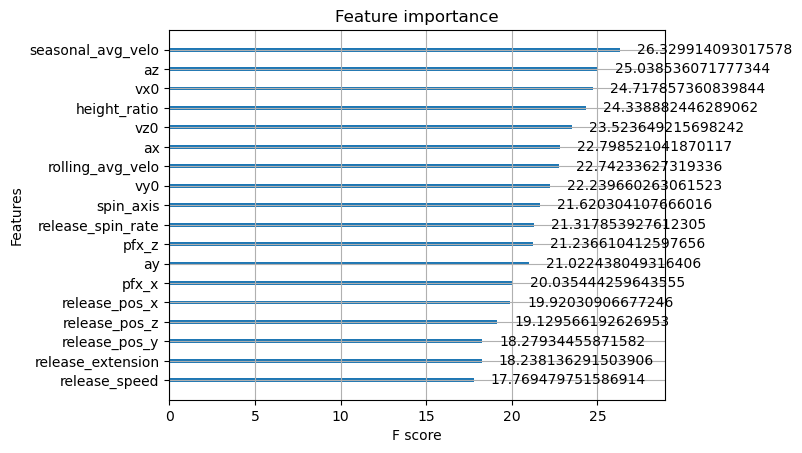

In [20]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

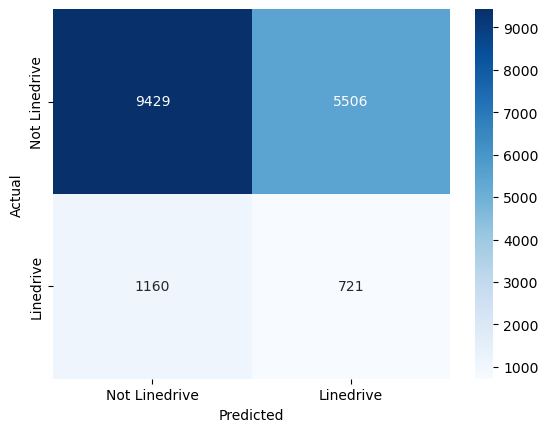

In [21]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [22]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [23]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [24]:
y_pred = final_model.predict(predictions)

In [25]:
testing_identifiers['xld'] = y_pred

In [26]:
testing_identifiers.head()

pitch_id_raw       xld
7   661032_543685_543238_1_59_8  0.581926
8   661032_545361_543238_2_57_8  0.493466
9   661032_545361_543238_3_57_8  0.272984
10  661032_543685_543238_4_59_8  0.202081
11  661032_543685_543238_5_59_8  0.457897

In [27]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fastball/ld_2022&3_xld.csv")